# 1. Presentation of estimation problem 


A **gaussian mixture model** is a probabilistic model, in which we assume that points from a data set are generated from a mixture of a finite number of gaussian distributions. It is useful when representing the presence of subpopulations within a global population. 

Formally, pdf of gaussian mixture can be represented pointwise as
$$
p(y_i) = \sum_{j=1}^K \pi_j \phi_j(y_i),
$$
where 
* $(y_i)_{i=1}^n$ are observed data;
* $(\pi_j)_{j=1}^K$ mixture weights such that $\sum_{j=1}^K \pi_j = 1$;
* $(\phi_j)_{j=1}^K$ gaussian pdf of the corresponding mixture component.

It is mentioned in [C. Archambeau, M. Valle, A. Assenza and M. Verleysen, "Assessment of probability density estimation methods: Parzen window and finite Gaussian mixtures", 2006](https://ieeexplore.ieee.org/abstract/document/1693317), that **finite gaussian mixture distribution can approximate any
continuous pdf**, provided the model has a sufficient number of components and provided the parameters of the model are chosen correctly.

If the number of components is known, we can estimate the mixture model's parameters by utilisation Expectation-Maximization (EM) algorithm. This allows us to approximate distribution of given data.
Therefore, in this project we will implement the EM algorithm and illustrate some of its properties. 

# 2. EM algorithm and its properties



## 2.1. Algorithm 


Expectation-Maximisation (EM) algorithm was proposed by [A. P. Dempster, N. M. Laird and D. B. Rubin in 1977](https://rss.onlinelibrary.wiley.com/doi/epdf/10.1111/j.2517-6161.1977.tb01600.x). It is an iterative algorithm that allows to approximate Maximum Likelihood Estimation (MLE) if there is no explicit formula for it.

It is commonly used when the model depends on unobserved latent variable.


Let X and Y be two random variables, $(x,y) \mapsto f_{\theta}(x, y)$ their joint pdf with respect to a reference measure $\mu$. Assuming Y to be the observed and X to be latent, we are trying to solve the following problem: 
$\hat{\theta} \in \arg\max_{\theta \in \Theta}\int f_{\theta}(x, y)\mu(dx)$

$\hat{\theta}$ corresponds to the Maximum Likelihood Estimator for the distribution of the observed variable Y. In this case, we cannot find an explicit solution (because we cannot calculate the integral and we do not know the distribution of the latent variable). We, therefore, resort to the EM algorithm to approximate $\hat{\theta}$. 

The EM iteration alternates between performing an expectation (E) step and a maximization (M) step.

The **E-step** consists in creating a function for the expectation of the log-likelihood evaluated using the current estimate for the parameters. 

We introduce $(\theta,\theta') \mapsto Q(\theta,\theta')$ defined by:

$$\forall (\theta,\theta')\in \Theta^2, \;\;\; Q(\theta,\theta')=\int f_{\theta}(x, y) p_{\theta'}(x|y)\mu(dx) = \mathbb{E}_{\theta'}[f_{\theta}(x, y)], $$
where $p_{\theta'}(x|y)=\frac{f_{\theta}(x, y)}{\int f_{\theta}(x, y)\mu(dx)}.$

This function is then maximized during the **M-step** to compute the unknown parameters. These parameter estimates are used to determine the distribution of the latent variables in the next E-step.



## 2.2. Identifiability


Finite gaussian mixture model is identifiable up to label switching, if we know number of components [Prop.1, Henry Teicher, Identifiability of Finite Mixtures](https://www.jstor.org/stable/2238337?seq=3). 

We can always swap the labels of any two components without changing the distribution of the observed data. There's no rule to choose which subpopulation is the first or second component of the mixture.

## 2.3. Properties


*  The EM algorithm is useful for models where the Maximum Likelihood Estimate is not analitycally calculable (e.g. mixture models and other latent variables models). The EM allows us to work with a calculable quantity instead. 

*  The following inequality holds for incomplete data likelihood $L,$ $\;\forall \theta^{(s)}, \theta^{(s+1)} \in \Theta^2$ 
$$ 
 \log(L(\theta^{(s)})) \le log(L(\theta^{(s+1)})),
$$
which means that incomplete data log-likelihood do not decrease after each iteration.

## 2.4. Possible problems and their solutions


***Local maxima problem***

The likelihood function can have several local maxima. For the implementation of the EM algorithm, we might want to chose to stop it when the likelihood increases by a quantity lower than a convergence treshold $\epsilon$ we set. If at any point, the algorithm becomes slow at convergence, it may end up converging only to a local maxima. 

A solution to avoid this problem is to run the algorithm for a set of different starting values. The EM solution would then be the one that gives the largest log-likelihood value, as mentioned in [Section 3.1.3, A. Punzo, A new look at the inverse Gaussian distribution..., 2019](https://www.tandfonline.com/doi/full/10.1080/02664763.2018.1542668). If the algorithm starts from different initialization points, in general it lands into different configurations.

***Distance between components***

If the components of a mixture are too close or entangled, the algorithm may not be able to distinguish them. 

***Singular covariance matrice***

Sometimes EM algorithm need constraints to be imposed. For example, for the Gaussian Mixture Model, it might require constraining covariance matrices to be positive semi-definite and invertible, since computer can round very small numbers to zero.

***Bad model choice***

Lastly, it can occur that errors from the EM algorithm estimations may actually be due to the inaccuracy of the model chosen. One important thing to take into account is the choice of the number of components. We will illustrate how to choose it with the Bayesian Information Criterion (BIC). 


# 3. EM algorithm implementation for gaussian mixture



In the case where we are interested in estimating unknown parameters $\theta \in \Theta$, characterizing a model with missing data, the Expectation Maximization (EM) algorithm can be used, when the joint distribution of the missing data $X$ and the observed data $Y$ is explicit. 

Let us consider the following model. 

$X= (x_1,\ldots,x_n) $ represents the components of the mixture model and $Y = (y_1,\ldots,y_n) \in \mathbb{R}^d$ are $n$ observations. We suppose $\{(x_i,y_i)\}_{1\leqslant i\leqslant n}$ i.i.d. in $\{1,...,K\}\times \mathbb{R}^d$, and $ K \in \mathbb{N}.$

For $k\in\{1,...,K\}$, we denote $\pi_k = \mathbb{P}(x_1 = k)$. We assume that, conditionally on the event $\{x_1 = k\},$ $\;y_1$ has a Gaussian distribution with mean $\mu_k \in\mathbb{R}^d$ and covariance matrix $\Sigma_k\in \mathbb{R}^{d\times d}.$

In this case, the parameters we want to estimate are $\theta=(\pi_1,\ldots,\pi_{K},\mu_1,\ldots,\mu_K, \Sigma_1,\ldots,\Sigma_K)$


For all $\theta\in\Theta$, let $f_{\theta}$ be the probability density function of $(X,Y)$ when the model is parameterized by $\theta$ with respect to a given reference measure $\mu.$ Thus, we have the following: 

- **Joint pdf** $f_{\theta}(x_i, y_i) = \sum_{j=1}^K \textbf{1}_{x_i=j} \pi_j \phi_j (y_i) = \pi_{x_i}\phi_{x_i}(y_i),
$ where $\phi_j$ is a gaussian pdf with parameters $\mu_j$ and $\Sigma_j$.

- **Marginal pdf of observed data** $f_{\theta}(y_i) = \sum_{x_i=1}^Kf_{\theta}(x_i, y_i)=\sum_{j=1}^K\pi_j \phi_j (y_i)$

- **Conditional pdf**
$f_{\theta}(x_i|y_i) = \frac{\pi_{x_i} \phi_{x_i}(y_i)}{\sum_{j=1}^K\pi_j \phi_j (y_i)}
$

We will use the EM algorithm to compute $\hat{\theta} \in \arg\max_{\theta \in \Theta}(f_{\theta}(Y))$, an estimator of $\theta$. 





In [ ]:
import numpy as np
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats as st
import sklearn.datasets
from sklearn.cluster import KMeans

## 3.1. Initialization

We implemented two methodes of initialization of EM algorithm: random and k-means.

In [ ]:
def EM_init(Y, K, method="random"):
  """
  Inputs
  ------
  Y: observed data (n, d)
  K: number of components (1, )
  method: initialization method (str)

  Outputs
  -------
  p: weights (1, K)
  mu: means (K, d)
  cov: covariance matrices (K, d, d)
  """

  n = len(Y)
  d = len(Y[0])
  if method == "random":
    p = np.ones(K) / K                                    # equal weigths;
    indices = np.random.choice(n, size=K, replace=False)  # K different observations 
    mu = Y[indices]                                       # are assigned as initial means;
    cov = np.array([np.eye(d) for j in range(K)])         # covariance matrix is Id(d).

  elif method == "k-means":
    kmeans = KMeans(n_clusters=K, n_init='auto').fit(Y)
    prediction = kmeans.predict(Y)

    # weights = #(observations assigned to mean i)/#(observations) for i є {1, ..., K};
    # means are result of k-means algorithm; 
    # covariance matrix is Id(d).

    p = np.array([sum(prediction == i) / n for i in range(K)])
    mu = kmeans.cluster_centers_
    cov = np.array([np.eye(d) for j in range(K)]) 

  else:
    print("There is no such a method. Try 'random' or 'k-means'")

  return p[np.newaxis], mu, cov

## 3.2. Explicit EM


It is possible to derive explicit formulas for EM algorithm for gaussian mixtures.

For iteration $s \ge 0, \;\; \forall i \in \{1, ..., n\}, \;\; \forall j \in \{1, ..., K\}$:


**E-step:**
*   $
\omega_j^{(s)}(y_i) = \frac{\hat{\pi}_j^{(s)} \hat{\phi}_j^{(s)}(y_i)}{\sum_{l=1}^K \hat{\pi}_l^{(s)} \hat{\phi}_l^{(s)}(y_i)} 
$


**M-step:**
*   $
\hat{\pi}_j^{(s+1)} = \frac{1}{n} \sum_{i=1}^n \omega_j^{(s)}(y_i) 
$

*   $
\hat{\mu}_j^{(s+1)} = \frac{\sum_{i=1}^n  \omega_j^{(s)}(y_i) \: y_i}{n \hat{\pi}_j^{(s+1)}} 
$

*   $
\hat{\Sigma}_j^{(s+1)} = \frac{\sum_{i=1}^n \omega_j^{(s)}(y_i) \: (y_i - \hat{\mu}_j^{(s+1)})(y_i - \hat{\mu}_j^{(s+1)})^T}{n \hat{\pi}_j^{(s+1)}}
$

**Incomplete data log-likelihood:**
$ \;\;
l(y) = \sum_{i=1}^n \log \Big( \sum_{j=1}^K \hat{\pi}_j \hat{\phi}_j (y_i) \Big),
$

where $\hat{\phi}_j$ is a gaussian pdf with parameters $\hat{\mu}_j$ and $\hat{\Sigma}_j$.

We tried to use broadcating and vectorise our code to make it more optimal. 

We can rewrite these formulas considering parameters as numpy arrays with the following shapes:

*   $Y$ ~ $(n, d)$: observations;
*   $\omega$ ~ $(K, n)$: conditional pdf of X|Y;
*   $\hat{\pi}$ ~ $(1, K)$: weights of components;
*   $\hat{\mu}$ ~ $(K, d)$: means of components;
*   $\hat{\Sigma}$ ~ $(K, d, d)$: covariance matrices of components;
*   $\hat{\phi}$ ~ $(K, n)$: gaussian pdfs of every component at every point of Y, depend on $\hat{\mu}$ and $\hat{\Sigma}$;
*   $LL$ ~ $(1, )$: value of incomplete data log-likelihood function for iteration s.

Finally, we have
*   $
\omega = \frac{\pi^T \:*\: \hat{\phi}}{\pi \;@\; \hat{\phi}}
\;\;\; \Bigg| \;\;\; 
(K, n) = \frac{(K, 1) \:*\: (K, n)}{(1, K) \:@\: (K, n)}
$
*   $
\hat{\pi} = mean(\omega, axis=0)[np.newaxis]
\;\;\; \Bigg| \;\;\; 
(1, K) = mean((K, n), axis=0)[np.newaxis]
$
*   $
\hat{\mu} = \frac{\omega \:@\: Y}{n \:*\: \hat{\pi}^T}
\;\;\; \Bigg| \;\;\; 
(K, d) = \frac{(K, n) \:@\: (n, d)}{(1,) \:*\: (K, 1)}
$
*   $
\hat{\Sigma} = \Big[ \frac{(\omega_{j} \:*\: (Y-\hat{\mu}_j)^T) \:@\: (Y-\hat{\mu}_j)}{n \:*\: \hat{\pi}_j^T}$ for $j$ in range($K$)$ \Big]
\;\;\; \Bigg| \;\;\;
(K, d, d) = \Big[ (d,d)=\frac{(1, n) \:*\: ((n, d) - (1, d))^T \:@\: ((n, d) - (1, d))}{(1, ) \:*\: (1,)} $ for $j$ in range($K$)$\Big] 
$
*   $
LL = sum(\log(\hat{\pi} \:@\: \hat{\phi}))
\;\;\; \Bigg| \;\;\;
(1,) = sum(\log((1, K) \:@\: (K, n)))
$

The following straightforward implementation of multivariate gaussian pdf works much slower than ``scipy.stats.multivariate_normal()``, but accepts singular covariance matrices and continue working with them without stopping the algorithm.

In [ ]:
def pdf(Y, mu, cov):
  coef = np.linalg.det(2 * np.pi * cov) ** (- 1 / 2)
  p = np.array([])
  for y_i in Y:
      y_i = np.array(y_i)[np.newaxis]
      p_i = coef * np.exp((-1 / 2) * (y_i - mu) @ np.linalg.inv(cov) @ (y_i - mu).T)
      p = np.append(p, p_i)
  return p

In [ ]:
def EM_expl(Y, K, init_method="random", max_iter=100, eps=10**(-3)):
  """
  Inputs
  ------
  Y: observed data (n, d)
  K: number of components (1, )
  init_method: initialization method (str)
  max_iter: maximal amount of iterations (int)
  eps: convergence threshold (1, )

  Shapes of variables
  -------------------
  w: pdf of X|Y (K, n)
  phi: gaussian pdf (K, n)

  Outputs
  -------
  p: weights (1, K)
  mu: means (K, d)
  cov: covariance matrices (K, d, d)
  LL: values of incomplete data log-likelihood function for every of s iterations  (s, )
  """

  # initialization
  p, mu, cov = EM_init(Y, K, method=init_method)
  s = 0   # number of iterations 
  n = len(Y)
  d = len(Y[0])
  # print("init")
  phi = np.array([st.multivariate_normal(mu[j], cov[j]).pdf(Y) for j in range(K)])
  # phi = np.array([pdf(Y, mu[j], cov[j]) for j in range(K)])
  LL_new = -np.inf
  LL_old = 0
  LL = np.array([])

  while s < max_iter and np.abs(LL_new - LL_old) > eps: 
      # E-step:
      w = (p.T * phi) / (p @ phi)

      # M-step:
      p = np.mean(w, axis=1)[np.newaxis]
      mu = w @ Y / (n * p.T)
      cov = np.array([((w[j] * (Y - mu[j]).T) @ (Y - mu[j])) / (n * p.T[j]) for j in range(K)])
      phi = np.array([st.multivariate_normal(mu[j], cov[j]).pdf(Y) for j in range(K)])
      # phi = np.array([pdf(Y, mu[j], cov[j]) for j in range(K)])

      s += 1
      LL_old = LL_new
      LL_new = np.sum(np.log(p @ phi))
      LL = np.append(LL, LL_new)

  return p, mu, cov, LL

## 3.3. Sampling from gaussian mixture distribution

To test EM algorithm we can sample from gaussian mixture distribution and compare it with true parameters.

The following function simulates random parameters of gaussian mixture. 

There exist few ways to create random ***symmetric positive semi-definite*** matrix from a matrix square $C$ that consist of random numbers from [0, 1]:

*   $(C+C^T) * 0.5 + dim(C) * Id$
*   $C*C^T + dim(C) * Id$
*   or just take diagonal matrix with non-negative values.

That will give us covariance matrix, that have specific type. To obtain more random matrix we can use ``sklearn.datasets.make_spd_matrix()``.



   



In [ ]:
def params_simulation(n_comp, dim, coef_means=5):
  """
  Inputs
  ------
  n_comp: number of components (int)
  dim: dimension (int)
  coef_means: allows to adjust distance between means
  
  Outputs
  -------
  p: weights of each component (n_comp, )
  mu: mean of each component (n_comp, dim)
  cov: covariance matrix of each component (n_comp, dim, dim)
  """
  rand_p = st.uniform().rvs(n_comp)
  rand_m = st.uniform().rvs((n_comp, dim))
  # rand_c = st.uniform().rvs((n_comp, dim, dim))
  p = rand_p / np.sum(rand_p)
  mu = rand_m * n_comp * coef_means
  cov = np.array([sklearn.datasets.make_spd_matrix(dim) for i in range(n_comp)])
  # cov = np.array([c * np.eye(dim) for c in rand_c])
  # cov = np.array([(c + c.T) / 2 + dim * np.eye(dim) for c in rand_c])
  # cov = np.array([c @ c.T + dim * np.eye(dim) for c in rand_c])
  return p, mu, cov

In [ ]:
def mixture_sample(size, n_comp, dim, coef_means=5):
  """
  Inputs
  ------
    size: sample size (1, )
    n_comp: number of components (int)
    dim: dimension (int)
    
  Outputs
  -------
    Y: sample (size, dim)
    p: weights of each component (n_comp, )
    mu: mean of each component (n_comp, dim)
    cov: covariance matrix of each component (n_comp, dim, dim)
  """
  p, mu, cov = params_simulation(n_comp, dim, coef_means=coef_means)
  I = np.random.choice(n_comp, size, p=p)
  Y = np.empty((size, dim))
  for i in range(size):
    Y[i] = np.random.multivariate_normal(mu[I[i]], cov[I[i]])

  return Y, p[np.newaxis], mu, cov

For visualization of data and algorithm results we define the following function.

In [ ]:
def plot_results2d(ax, estimations, Y, title):
  #scatter our observations
  ax.scatter(Y[:, 0], Y[:, 1], s=0.5, alpha=0.2)

  # plot of our estimated Gaussian distributions
  cov=estimations[2] 
  mu=estimations[1]
  weights = estimations[0]
  for k in range(K):
    eig_vals, eig_vecs = np.linalg.eigh(cov[k])
    unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
    angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
    # Ellipse needs degrees
    angle = 180 * angle / np.pi
    # eigenvector normalization
    eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
    ell = mpl.patches.Ellipse(mu[k], eig_vals[0], eig_vals[1], angle=180 + angle, alpha=0.5, edgecolor="black")
    ell.set_facecolor("#56B4E9")
    ax.add_artist(ell)
    ax.set_title(title)

## 3.4. Examples


In [ ]:
n = 10000
K = 3 # number of components
d = 2 # dimension
Y, p_true, mu_true, cov_true = mixture_sample(n, n_comp=K, dim=d)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, layout="tight", figsize=(8, 4))

emrand_estimate=EM_expl(Y, K, init_method="random", max_iter=100, eps=10**(-5))
plot_results2d(ax1, emrand_estimate, Y, 'Estimation with random initialization')

emkmeans_estimate=EM_expl(Y, K, init_method="k-means", max_iter=100, eps=10**(-5))
plot_results2d(ax2, emkmeans_estimate, Y, 'Estimation with k-means initialization')

plt.show()

![3.4.1](data:application/octet-stream;base64,iVBORw0KGgoAAAANSUhEUgAAAxUAAAGGCAYAAAANcKzOAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOy9d5xddZ3//zz19jZ9JjPpjSSEYDChF0ERFRUr7LoCuurKCquoP3XXRVj9frPqquu6irq7Aura9WtHBaX3FkII6W0mmX57Of38/jj3XmaSSU8Igc/z8RjInHvuOZ9z7pnP674/7yb5vu8jEAgEAoFAIBAIBIeJfLwHIBAIBAKBQCAQCE5shFEhEAgEAoFAIBAIjghhVAgEAoFAIBAIBIIjQhgVAoFAIBAIBAKB4IgQRoVAIBAIBAKBQCA4IoRRIRAIBAKBQCAQCI4IYVQIBAKBQCAQCASCI0IYFQKBQCAQCAQCgeCIEEaFQCAQCAQCgUAgOCKEUXEcOf/88zn//POP9zAmcffddyNJEnfffffxHspBsX37diRJ4tZbbz3off/t3/7t2A/sGDJz5kyuuuqq4z2MJldddRUzZ848rPfeeOONSJJ0UPveeuutSJLE9u3bD/k8U41RkiRuvPHGQz7WkXK8zit48SM04ch5ITWhMSc9/vjjh/X+lyOHMufvyaFowJE8t1ON8Xjp7otN7w+EMCqmoPHg7uvn4YcfPuhjrVu3jhtvvPGwvggdS77xjW8c1KR7IvL73/9efGk7gfm///f/8stf/vJ4D+OIEM/gSwuhCSc24u/xpctL4bl98MEHufHGG8nn88d7KEeOL9iLW265xQf8f/mXf/G/973v7fUzOjp60Mf66U9/6gP+XXfdtddrpmn6pmkexZEfPIsXL/bPO++8vba7ruvXajXfdd0XflCHged5fq1W8x3HaW77+7//e3+qR3vbtm0+4H/xi198IYd41JkxY4Z/5ZVXHu9hNLEsyzcM47Dea9u2X6vVJm2LxWJTXp/jOH6tVvM9zzvk81x55ZX+jBkzJm2r1Wq+bduHfKyDYV/P4LE+r+DYIDRBaMJUNJ6Lxx577LDH+3Jjqjn/YJlKA47Fc/uZz3xmr+fFMAzfsqxDPtbB8MUvftEH/G3btu312rE877FAPT6mzInBJZdcwmmnnXbMjq/r+jE79uEiyzLhcPh4D+OgkSTpuI63UqkQi8WO2/lfDGiadtjvVVUVVT24aUhRFBRFOexz7cnxem5OpL8vwWSEJrz4Od6aINg/hzLn78mhaMDRfm5DodBRO9aJcN7DRYQ/HSE/+tGPWL58OYlEgmQyycknn8xXv/pVIHCZv/3tbwfgggsuaLrKGzF+e8bPNmIAf/KTn3DTTTcxbdo0EokEb3vb2ygUCpimyYc//GE6OjqIx+NcffXVmKY5aTy33HILr3rVq+jo6CAUCrFo0SJuvvnmSfvMnDmTZ599lnvuuac5psY49hWH+NOf/pTly5cTiURoa2vjXe96F7t27Zq0z1VXXUU8HmfXrl28+c1vJh6P097ezsc+9jFc193vfbz++utpbW3F9/3mtmuvvRZJkviP//iP5rbh4WEkSWpe057xs1dddRVf//rXASaFJ+zJt7/9bebMmUMoFOKVr3wljz322H7HB8+HQNxzzz1cc801dHR00NvbC8COHTu45pprWLBgAZFIhNbWVt7+9rfvFeLQOMYDDzzA9ddfT3t7O7FYjMsuu4zR0dFJ+/q+z+c+9zl6e3uJRqNccMEFPPvss1OObevWrbz97W+npaWFaDTK6aefzu9+97tJ+xyN52sq9sxXmBinfKD7vGfsqiRJVCoVbrvttuZn14gnnSqe9le/+hWvf/3r6enpIRQKMWfOHD772c8e8HlrnKsREtEY875+Gtx33328/e1vZ/r06YRCIfr6+vjIRz5CrVabdD/29wxOlVPx1FNPcckll5BMJonH41x44YV7hdQcyrMjOH4ITXiel7omTEUul2PFihX09vayYcOG/e57/vnns2TJEtasWcN5551HNBpl7ty5/OxnPwPgnnvuYeXKlUQiERYsWMCdd9651zF27drFe97zHjo7OwmFQixevJjvfOc7k/axLIsbbriB5cuXk0qliMVinHPOOdx1112T9juUuXtoaIirr76a3t5eQqEQ3d3dvOlNbzpgWN9U+QqSJPGhD32IX/7ylyxZsqR5HX/4wx8m7benBhzqc3sw8/e+2DO3YX960RjfmjVruOqqq5g9ezbhcJiuri7e8573MD4+Pul+fPzjHwdg1qxZex1jqpyKQ9X7//N//g+9vb2Ew2EuvPBCNm/efMDrPVyEp2I/FAoFxsbGJm2TJInW1lYA7rjjDq644gouvPBCPv/5zwPw3HPP8cADD/AP//APnHvuuVx33XX8x3/8B//4j//ISSedBND8/75YtWoVkUiET37yk2zevJmvfe1raJqGLMvkcjluvPFGHn74YW699VZmzZrFDTfc0HzvzTffzOLFi3njG9+Iqqr85je/4ZprrsHzPP7+7/8egH//93/n2muvJR6P80//9E8AdHZ27nM8t956K1dffTWvfOUrWbVqFcPDw3z1q1/lgQce4KmnniKdTjf3dV2Xiy++mJUrV/Jv//Zv3HnnnXzpS19izpw5fPCDH9znOc455xy+8pWv8Oyzz7JkyRIgmABkWea+++7juuuua24DOPfcc6c8zgc+8AF2797NHXfcwfe+970p9/nBD35AqVTiAx/4AJIk8YUvfIG3vOUtbN269aBW3a+55hra29u54YYbqFQqADz22GM8+OCDXH755fT29rJ9+3Zuvvlmzj//fNatW0c0Gp10jGuvvZZMJsNnPvMZtm/fzr//+7/zoQ99iB//+MfNfW644QY+97nP8brXvY7Xve51PPnkk7zmNa/BsqxJxxoeHubMM8+kWq1y3XXX0draym233cYb3/hGfvazn3HZZZdN2v9Inq9D4XDu8/e+9z3+9m//lhUrVvD+978fgDlz5uzzHLfeeivxeJzrr7+eeDzOX/7yF2644QaKxSJf/OIXD3qs7e3tez0vtm3zkY98ZNLq8U9/+lOq1Sof/OAHaW1t5dFHH+VrX/saAwMD/PSnPwUO7hmcyLPPPss555xDMpnk//v//j80TeNb3/oW559/fvNLxUQO5tkRHBuEJgQITZiasbExXv3qV5PNZrnnnnv2O3c1yOVyvOENb+Dyyy/n7W9/OzfffDOXX345//u//8uHP/xh/u7v/o6/+qu/4otf/CJve9vb6O/vJ5FIAMHcf/rppze/lLe3t3P77bfz3ve+l2KxyIc//GEAisUi//3f/80VV1zB+973PkqlEv/zP//DxRdfzKOPPsqyZcsO+X689a1v5dlnn+Xaa69l5syZjIyMcMcdd7Bz587DKtxx//3384tf/IJrrrmGRCLBf/zHf/DWt76VnTt3Nv++9uRQn9uDmb8PlqmepU9/+tOMjIwQj8eBYD7YunUrV199NV1dXTz77LN8+9vf5tlnn+Xhhx9GkiTe8pa3sHHjRn74wx/yla98hba2NiDQpKk4VL3/13/9V2RZ5mMf+xiFQoEvfOEL/PVf/zWPPPLIIV3vQXOcw69elDTiJKf6CYVCzf3+4R/+wU8mk5NiN/dkf/Gz55133qRYwLvuussH/CVLlkyKobviiit8SZL8Sy65ZNL7zzjjjL3ixKvV6l7nufjii/3Zs2dP2ravOMTGGBrjtSzL7+jo8JcsWTIpDvK3v/2tD/g33HBDc9uVV17ZjDueyKmnnuovX758r3NNZGRkxAf8b3zjG77v+34+n/dlWfbf/va3+52dnc39rrvuOr+lpaUZU9mIib3lllua+xwofra1tdXPZrPN7b/61a98wP/Nb36z3zE2nouzzz57r898qvv+0EMP+YD/3e9+d69jXHTRRZPiQj/ykY/4iqL4+Xy+eT90Xfdf//rXT9rvH//xH31gUs7Bhz/8YR/w77vvvua2Uqnkz5o1y585c2YzpvRoPF9TsWe+wqHc56liV/eVU9G4dxPjTqe67x/4wAf8aDQ6Kc9jqpwKwP/MZz6zz+u65pprfEVR/L/85S/7Pd+qVat8SZL8HTt2NLftL6diz/O++c1v9nVd97ds2dLctnv3bj+RSPjnnntuc9vBPjuCo4/QBKEJUzExp2JwcNBfvHixP3v2bH/79u37fV+D8847zwf8H/zgB81t69ev9wFflmX/4Ycfbm7/4x//uNd1vfe97/W7u7v9sbGxSce9/PLL/VQq1fzsHcfZK1cnl8v5nZ2d/nve855Dvh+5XO6wc1GmmvMBX9d1f/Pmzc1tTz/9tA/4X/va15rbptKAg31uff/g5++pxnigXMYvfOELe+n9VOf74Q9/6AP+vffe29y2v5yKPc97qHp/0kknTfrsv/rVr/qA/8wzz+zzWo4EEf60H77+9a9zxx13TPq5/fbbm6+n02kqlQp33HHHUT3vu9/97kmrIytXrsT3fd7znvdM2m/lypX09/fjOE5zWyQSaf67sap23nnnsXXrVgqFwiGP5fHHH2dkZIRrrrlmUnzi61//ehYuXLiXyw3g7/7u7yb9fs4557B169b9nqe9vZ2FCxdy7733AvDAAw+gKAof//jHGR4eZtOmTUCwKnX22Wcfdkk6gHe+851kMplJ4wMOOMYG73vf+/aK65x4323bZnx8nLlz55JOp3nyySf3Osb73//+Sddwzjnn4LouO3bsAODOO+/Esqymu79BY+VpIr///e9ZsWIFZ599dnNbPB7n/e9/P9u3b2fdunWT9j+S5+tQONL7fDBMvO+lUomxsTHOOeccqtUq69evP+zjfve73+Ub3/gGX/jCF7jgggumPF+lUmFsbIwzzzwT3/d56qmnDvk8ruvypz/9iTe/+c3Mnj27ub27u5u/+qu/4v7776dYLE56z4GeHcGxQ2iC0ISpGBgY4LzzzsO2be69915mzJhx0OeOx+Ncfvnlzd8XLFhAOp3mpJNOmuSlbPy7MSbf9/n5z3/OpZdeiu/7jI2NNX8uvvhiCoVCU3sURWl6XD3PI5vN4jgOp5122pT6dKD7EYlE0HWdu+++m1wud9DXuj8uuuiiSZ6dpUuXkkwmj5leHI35u8Fdd93Fpz71Ka699lr+5m/+ZsrzGYbB2NgYp59+OsCU9/1gOFS9v/rqqyd524+FDk9EhD/thxUrVuw3Ke+aa67hJz/5CZdccgnTpk3jNa95De94xzt47Wtfe0TnnT59+qTfU6kUAH19fXtt9zyPQqHQdA8+8MADfOYzn+Ghhx6iWq1O2r9QKDSPdbA0vqgsWLBgr9cWLlzI/fffP2lbOBzey22XyWQOauI555xz+P3vfw8EQnHaaadx2mmn0dLSwn333UdnZydPP/00f/VXf3VI17Ane97fxuR5sJPjrFmz9tpWq9VYtWoVt9xyC7t27ZoUBzyVcB9oDI37Pm/evEn7tbe3T5rsG/vuGSIDz4dU7Nixoxk+MNW5D+X5OhSO9D4fDM8++yyf/vSn+ctf/rLXl+/D+cIEsHr1av7u7/6OK664guuvv37Sazt37uSGG27g17/+9V7XcTjnGx0dpVqtTvn3ddJJJ+F5Hv39/SxevLi5/YW4r4KpEZogNGEq/uZv/gZVVXnuuefo6uqa9FqtVttrbpi4T29v714GUSqVmvKznTim0dFR8vk83/72t/n2t7895bhGRkaa/77tttv40pe+xPr167Ftu7l9Kj070P0IhUJ8/vOf56Mf/SidnZ2cfvrpvOENb+Dd7373Xtd/sOx5zsZ5j+a8drTnbwgMyne+852cddZZfPnLX570Wjab5aabbuJHP/rRpM/iSM53pHp/rPVCGBVHQEdHB6tXr+aPf/wjt99+O7fffju33HIL7373u7ntttsO+7j7qm6wr+2NL7BbtmzhwgsvZOHChXz5y1+mr68PXdf5/e9/z1e+8hU8zzvsMR0sR1Kd5+yzz+a//uu/2Lp1K/fddx/nnHMOkiRx9tlnc99999HT04PneU1L+2iPcaIhsD8mrj40uPbaa7nlllv48Ic/zBlnnEEqlUKSJC6//PIp7/uRjuFIONzn62id52hdYz6f57zzziOZTPIv//IvzJkzh3A4zJNPPsknPvGJw3rec7kcb33rW5k/fz7//d//Pek113Wb8dKf+MQnWLhwIbFYjF27dnHVVVe9IH9fcHyfHcH+EZpw8GM8GE4UTXjLW97Cd7/7Xb761a+yatWqSa/9+Mc/5uqrr97ncQ/3s218du9617u48sorp9x36dKlAHz/+9/nqquu4s1vfjMf//jH6ejoQFEUVq1axZYtWw753BB4zS+99FJ++ctf8sc//pF//ud/ZtWqVfzlL3/h1FNPnfL9++NYz2vHYv62LIu3ve1thEIhfvKTn+xV1eod73gHDz74IB//+MdZtmwZ8Xgcz/N47Wtf+5LVC2FUHCG6rnPppZdy6aWX4nke11xzDd/61rf453/+Z+bOnXtELtlD5Te/+Q2mafLrX/96knW6Z4UH4KDH1XDjbtiwgVe96lWTXtuwYcMhuXkPREMY7rjjDh577DE++clPAkEC3s0330xPTw+xWIzly5fv9zgv5D1v8LOf/Ywrr7ySL33pS81thmEcdjObxn3dtGnTpLCY0dHRvVYYZsyYMWWVkUb4z9H8jF4IDvbzu/vuuxkfH+cXv/jFpCTNbdu2HdZ5Pc/jr//6r8nn89x55517Jdc/88wzbNy4kdtuu413v/vdze1Thboc7DW0t7cTjUb3+fnJsrzXiqXgxY3QhJefJlx77bXMnTuXG264gVQq1RwnwMUXX3zUw+EgmDsSiQSu63LRRRftd9+f/exnzJ49m1/84heT7sVnPvOZIxrDnDlz+OhHP8pHP/pRNm3axLJly/jSl77E97///SM67qFwsJ/toczfB8t1113H6tWruffee/dKEM/lcvz5z3/mpptumlQ4oRG2N5FDeT5f7HovciqOgIllwSCoi9xYGWiU9Wv0MHghOiU2LNI9Q29uueWWvfaNxWIHNabTTjuNjo4OvvnNb04qVXj77bfz3HPP8frXv/7IB15n1qxZTJs2ja985SvYts1ZZ50FBMKyZcsWfvazn3H66acfsMb1C3nPGyiKspfl/7Wvfe2gSptOxUUXXYSmaXzta1+bdNx///d/32vf173udTz66KM89NBDzW2VSoVvf/vbzJw5k0WLFh3WGI4XB/tsTvW8W5bFN77xjcM670033cQf//hHfvjDH04ZEjDV+Xzfb5YLncjBPoOKovCa17yGX/3qV5NKMQ4PD/ODH/yAs88+m2QyeRhXIzgeCE14+WrCP//zP/Oxj32MT33qU5NK9nZ3d3PRRRdN+jkaKIrCW9/6Vn7+85+zdu3avV6fWGZ6qufgkUcemaQZh0K1WsUwjEnb5syZQyKROKgy5EeTI9GLfc3fB8Mtt9zCt771Lb7+9a+zYsWKgzofTK3hh/J8vtj1Xngq9sPtt98+ZbLnmWeeyezZs/nbv/1bstksr3rVq+jt7WXHjh187WtfY9myZc34tmXLlqEoCp///OcpFAqEQqFmzfCjzWte85rmKtkHPvAByuUy//Vf/0VHRweDg4OT9l2+fDk333wzn/vc55g7dy4dHR17rTpB0Njs85//PFdffTXnnXceV1xxRbN84MyZM/nIRz5yVK/hnHPO4Uc/+hEnn3xyM/bvFa94BbFYjI0bNx5U7Gxj1eq6667j4osvRlGUSYlwx4I3vOENfO973yOVSrFo0SIeeugh7rzzzsPKRQCatdxXrVrFG97wBl73utfx1FNPcfvttzdLzjX45Cc/yQ9/+EMuueQSrrvuOlpaWrjtttvYtm0bP//5z5HlE2vtYPny5dx55518+ctfpqenh1mzZk0ZQ3rmmWeSyWS48sorue6665Akie9973uH5dZ95pln+OxnP8u5557LyMjIXitt73rXu1i4cCFz5szhYx/7GLt27SKZTPLzn/98ytjUQ3kGP/e5z3HHHXdw9tlnc80116CqKt/61rcwTZMvfOELh3wtgmOH0AShCfvji1/8IoVCgb//+78nkUjwrne966ifYyL/+q//yl133cXKlSt53/vex6JFi8hmszz55JPceeedZLNZINCnX/ziF1x22WW8/vWvZ9u2bXzzm99k0aJFlMvlQz7vxo0bufDCC3nHO97BokWLUFWV//f//h/Dw8PHXGv35GCf20OZvw/E2NgY11xzDYsWLSIUCu2lF5dddhnJZJJzzz2XL3zhC9i2zbRp0/jTn/40pSe98Xz+0z/9E5dffjmapnHppZdO2Vj3xa73wqjYD/uqz3/LLbcwe/Zs3vWud/Htb3+bb3zjG+Tzebq6unjnO9/JjTfe2Pxgu7q6+OY3v8mqVat473vfi+u63HXXXcdEQBYsWMDPfvYzPv3pT/Oxj32Mrq4uPvjBD9Le3r5XlZAbbriBHTt28IUvfIFSqcR555035R8iBM2DotEo//qv/8onPvGJZsOtz3/+85PqkR8NGgIysbKBqqqcccYZ3HnnnQcVO/uWt7yFa6+9lh/96Ed8//vfx/f9Yz7RffWrX0VRFP73f/8XwzA466yzuPPOO7n44osP+5if+9znCIfDfPOb32wKx5/+9Ke9VgI7Ozt58MEH+cQnPsHXvvY1DMNg6dKl/OY3vzmqq4YvFF/+8pd5//vfz6c//WlqtRpXXnnllEZFa2srv/3tb/noRz/Kpz/9aTKZDO9617u48MILD/m+j4+P4/s+99xzD/fcc89er7/rXe9C0zR+85vfcN1117Fq1SrC4TCXXXYZH/rQhzjllFMm7X8oz+DixYu57777+NSnPsWqVavwPI+VK1fy/e9/f8rrFhw/hCYECE3YN9/85jcpl8tcffXVJBIJ3vSmNx2T80Aw9z/66KP8y7/8C7/4xS/4xje+QWtrK4sXL272SYHg8xoaGuJb3/oWf/zjH1m0aBHf//73+elPf7pXU8ODoa+vjyuuuII///nPfO9730NVVRYuXMhPfvIT3vrWtx7FKzwwB/vcHsr8fSDK5TKGYbBu3bpJ1Z4abNu2jVgsxg9+8AOuvfZavv71r+P7Pq95zWu4/fbb6enpmbT/K1/5Sj772c/yzW9+kz/84Q94ntc8xp682PVe8kV2n0AgEAgEAoFAIDgCTqy4CIFAIBAIBAKBQPCiQxgVAoFAIBAIBAKB4IgQRoVAIBAIBAKBQCA4Ig7bqLj33nu59NJL6enpQZIkfvnLX056XZKkKX+++MUv7vOYN9544177L1y48HCHKBAIBILjhNAIgUAgeHlx2EZFpVLhlFNO4etf//qUrw8ODk76+c53voMkSQesDLB48eJJ77v//vsPd4gCgUAgOE4IjRAIBIKXF4ddUvaSSy7hkksu2efrXV1dk37/1a9+xQUXXDCpO/CUA1LVvd4rEAgEghMLoRECgUDw8uIF6VMxPDzM7373O2677bYD7rtp0yZ6enoIh8OcccYZrFq1iunTpx/0uTzPY/fu3SQSiUNqfS4QCAQvV3zfp1Qq0dPTc1yaJwmNEAgEghcvB6sRL4hRcdttt5FIJHjLW96y3/1WrlzJrbfeyoIFCxgcHOSmm27inHPOYe3atSQSiSnfY5rmpLbwu3btOu5tygUCgeBEpL+/n97e3hf8vEIjBAKB4MXPgTTiBTEqvvOd7/DXf/3XhMPh/e430VW+dOlSVq5cyYwZM/jJT37Ce9/73infs2rVKm666aa9tvf395NMJo9s4AKBQPAyoFgs0tfXt88v5scaoRECgUDw4uVgNeKYGxX33XcfGzZs4Mc//vEhvzedTjN//nw2b968z30+9alPcf311zd/b1x4MpkUgiEQCASHwPEIBxIaIRAIBCcGB9KIYx48+z//8z8sX76cU0455ZDfWy6X2bJlC93d3fvcJxQKNcVBiIRAIBCcWAiNEAgEgpcGh21UlMtlVq9ezerVqwHYtm0bq1evZufOnc19isUiP/3pT/nbv/3bKY9x4YUX8p//+Z/N3z/2sY9xzz33sH37dh588EEuu+wyFEXhiiuuONxhCgQCgeA4IDRCIBAIXl4cdvjT448/zgUXXND8veFevvLKK7n11lsB+NGPfoTv+/uc8Lds2cLY2Fjz94GBAa644grGx8dpb2/n7LPP5uGHH6a9vf1whykQCASC44DQCIFAIHh5Ifm+7x/vQRxNisUiqVSKQqEg3NwCgUBwELyc5s2X07UKBALB0eBg580XviC5QCAQCAQCgUAgeEkhjAqBQCAQCAQCgUBwRAijQiAQCAQCgUAgEBwRwqgQCAQCgUAgEAgER4QwKgQCgUAgEAgEAsERIYwKgUAgEAgEAoFAcEQIo0IgEAgEAoFAIBAcEcKoEAj2Qc1y6c9WqVnu8R6KQCAQCF5kCI0QCCYjjAqBYB+MlU3WDRYZK5vHeygCgUAgeJEhNEIgmIwwKgSCfdAWD7GoO0lbPHS8hyIQCASCFxlCIwSCyajHewACwYuViK7Q1xI93sMQCAQCwYsQoRECwWSEp0IgEAgEAoFAIBAcEcKoEAgEAoFAIBAIBEeEMCoEAoFAIBAIBALBESGMCoFAIBAIBAKBQHBECKNCIBAIBAKBQCAQHBHCqBAIjhGiMZJAIBAI9oXQCMFLDWFUCATHCNEYSSAQCAT7QmiE4KWGMCoEgmOEaIwkEAgEgn0hNELwUkM0vxMIjhGiMZJAIBAI9oXQCMFLDeGpEAgEAoFAIBAIBEeEMCoEAoFAIBAIBALBESGMCoFAIBAIBAKBQHBECKNCIBAIBAKBQCAQHBHCqBAIjjOiVrlAIBAI9oXQCMGJgjAqBILjjKhVLhAIBIJ9ITRCcKIgjAqBYALHY0WoUas8pqtiNUogEAhexAiNEAj2jTAqBIIJHI8VoUat8orliNUogUAgeBEjNEIg2DeHbVTce++9XHrppfT09CBJEr/85S8nvX7VVVchSdKkn9e+9rUHPO7Xv/51Zs6cSTgcZuXKlTz66KOHO0SB4JCZ2OH0hV6REt1VBS8lhEYIXooIjRAI9s1hGxWVSoVTTjmFr3/96/vc57WvfS2Dg4PNnx/+8If7PeaPf/xjrr/+ej7zmc/w5JNPcsopp3DxxRczMjJyuMMUvIC8FJLJGitCEV15wVekJp5bIDjRERoh2BOhEUfv3ALBixH1cN94ySWXcMkll+x3n1AoRFdX10Ef88tf/jLve9/7uPrqqwH45je/ye9+9zu+853v8MlPfvJwhyp4gWhMsIu6k/S1RI/3cI4YsSokEBw+QiMEeyI0QiB4aXNMcyruvvtuOjo6WLBgAR/84AcZHx/f576WZfHEE09w0UUXPT84Weaiiy7ioYce2uf7TNOkWCxO+hEcH15qE2xEV2iLhxgrm4e1sravVbmXwmqdQHA0EBrx8uKlphFHitAIwUuNY2ZUvPa1r+W73/0uf/7zn/n85z/PPffcwyWXXILrTv1HMjY2huu6dHZ2Ttre2dnJ0NDQPs+zatUqUqlU86evr++oXofg4HmpuWZrlsuagTyr+3OH5d7el2tclAcUCIRGvBx5KWnEkeoDCI0QvPQ47PCnA3H55Zc3/33yySezdOlS5syZw913382FF1541M7zqU99iuuvv775e7FYFKLxEqZmuYyVTdrioSMSpoM5zljZZKRk0pEIH9bK2r5W5V7Mq3VH6/4KBAdCaITgaHM0568DHetI9QGERgheerxgJWVnz55NW1sbmzdvnvL1trY2FEVheHh40vbh4eH9xtyGQiGSyeSkH8FLl6O1gnMwx2mLh1jWl2ZeR2JSCFTNctk0XGLTcGm/7ul9rcodzGrd8XJ/ixUywfFCaITgSDma89eBjtXQh6W9aYBJ8/Wx1ojjGR4lNEKwP14wo2JgYIDx8XG6u7unfF3XdZYvX86f//zn5jbP8/jzn//MGWec8UINU/AiZ88VnMbkmi1be02yU028jW0xXT1gWcB91QYfK5s8ui3Lo9uyRzSx7k8YjtfE/WJeIRO8tBEaIThSppq/9qUR+9OHmuUesOHc/qpAHWuNOJ5f7IVGCPbHYRsV5XKZ1atXs3r1agC2bdvG6tWr2blzJ+VymY9//OM8/PDDbN++nT//+c+86U1vYu7cuVx88cXNY1x44YX853/+Z/P366+/nv/6r//itttu47nnnuODH/wglUqlWelDINhzBacxuW4aKe01yU418Ta2VSzngGUBpzJAIJhUV8xqYcWsliPqcDqQq3LvxlEGctW9XjteE/dLKeZZcHwRGiF4oZlq/tqXRuxPH8bK5gEbzk1lgBxNjdhfzsbx/GIvNEKwPw47p+Lxxx/nggsuaP7eiFm98sorufnmm1mzZg233XYb+Xyenp4eXvOa1/DZz36WUOj5P4ItW7YwNjbW/P2d73wno6Oj3HDDDQwNDbFs2TL+8Ic/7JWYJ3jpMVWc5p7bptpn4mpSxXImTbJTTbxTeToM22V2W2yvCfpgyh+OV0y2jlUOuURizXIZLNSw9pGUOrHyVGNcIo5VcCIhNEJwtNhXHP/E7TD1HLkvjTgYfQCI6SrpiEZMn/x1aU99aMz/jTG1xkJULOewNWIgV2Xd7iJzOvbWpsYX+4kLX41rE/ogOJ5Ivu/7x3sQR5NisUgqlaJQKIjY2ROI/mx1ry/wjW2z22KENYV8xWbNrjwrZrUwrzMx6f2Hmzw21XknHrPhRejNBK+NlU0M2+XRbVkAVsxqIawpxHSV8YrZ3HdfhtHE867uz9ORCLG0Nz3lmCeODXhJ1XcXvLh4Oc2bL6drfamwr3l6okZkKxYDuRq9mchec+qRJBfv69yNYza+0Df+b9guW8cqpCMa+Zrd1K9D1YhNwyUe3ZadUu/2HFvjXEIfBMeKg503j1n1J8FLl2NR/WF/q0aG7bJusEhE23e03qE0VZooBvvyUjT2Wz9YxHJ9wlpwnQ0BWzGrBWDSalTD0AhrSnMM+xpXI8lvf/dwz3si4lgFAsGJwNHWiANVSTJsl5GSia5IjJRMxsrmpPn2cPWhYSxMde6a5bI7XyOqK+wuGJOMiImekcb/D1UjejNRwpqy3zl/f556geB4IIwKwSFzuF1R91z5nyg2DXduY7+GIDVcvI2Vnu5UpLnPxJWe/RkH+xp/RJPpz9ZY2puaeqVopMTTA3lO6U3v9cW+sV9jpagnFaYjGQL8SW7yiWK45/Uf6N5NvCeAWIESCAQnBIejEQerD41996UR45XAm9zQiCPVhxWzWujNRPfSiE0jJe7aMMKZc1r3+mLf2KcFve6VzhHWZDoSYbpSoX2GXB2JRrSgH8xtFgiOKS9Y9SfBS4fDTRKbqiLGVNUt9kygm5gYlq1YrB8q7ZVct3Ws0vz3gRLiGuOXkdg2VmFH3TDYMxluXkeCVy/q4qy57UR0ZdIEvmeCXlhTGCma7MoZbBp5vozgxPc8tn2c367Zzf2bxkQ5PoFA8JLlcDTiYPWhse+eGtEWD7zGAFvHKpMSsg9HHyKqykjJYPt4Ochv2EMj5nUkuGBBB0t60vS1RGmJ63vpQ+N4HYkwA1mDXfkq1SmqSDXy5zaPlPjD2iGhEYITFmFUCA6ZQ6n+sGeFjEZFjImJdY3Jel/VlhrHWTOQZyBXpSMx9UoPMGni31+5WYCa41K1XEKqHBgZksQjW8fJli0AWuI6K2e30hKfvALUGPNArspArophu7TGgmub3R5rut/3fM+W0QrgNxPv9hTM41l7XCAQCI4Wh6MRMV09KH2YqtrS85WS8sDkUNF96UPjffvqJxHWFDRZZiBnANCTCrNtrHzQ+tAY80CuSlRXOG1mZr/6sG6wSK5qkQirU2qE0AfBiYAIfxIcU/Z0g++ZcNYWDzG7LYZhu2weKbFmoLCXu7lmuTyweZSS6TCnPd5sRtdwM0+shNGIQW2IzEjJJBVR2TpaoS0WIhlVyURC7C7W6EmFedOyHuZ1JGiJ6zyydZy7NowAMI8Em0ZKzdfgefe8YXnBmC2PezaOoGsyp/QGTfIAulNMGft72owMuarFkp4giXDPZO3DDSsTCASCE5WJ895U+tAILXps+zhbRiqcPa+tWTgDgnn5se3jrB8ssrA7OamoRkMjptKHRtGN+zePUTEczpvfAcDGkSIgsbQ3xcVLgqaKvZkoawbyPLhlnJCqsFRP7xWqtac+xHSVNQN5nhss4uOzqDvFnPYEA7nqXpWkJurgWXMjzWNO1IiWmH5YVaQEghcSYVQIjin7coNPjIkNa8peidgNoZndFmP9YJEndmRZPqNlv1++9wxPGikZdCTCyEgM5GpsHini+RIXLGwnHdGZlg5c1o3VKlmSOHNOK/M6Es142WLNIaRJZCIhwrrcTLQ7d347hu1ieR4JWeXpgTwD2Sq6JrOsLzNlZY90VGd3waBiObSgB8Li+wzkarTEAsOlJxmZFA98qByLJHqBQCA4VhyMRoyVTbaOViibQXjTRA0wbJcntufwJZ/uVKT5ZXxPjdhTHxr60psJs3ZXkaFSlQ2DZbaNlVkyLUVrLNRcUMqWLYqGzfIZ6eai1qPbsliuy5z2OJmoTq5qsWW0gq7InDu/nYrlMJCrkQirhDR5kkb0pCPNHIjGdQLsLhhB6NWEXJBUJAjDiuoKEU0mX7UOe34X+iA41ojwJ8FxYWIIUSOJbklPullVqRECZdgugwWDk3vTzdyG/XVNbbiJDdtlYVewarV5tITre7THI0zLRJCR2DxSZrxiNj0a928eY+Nwie5UhPGK2TQwkDz+sHaIezaOYFgeHUmdVEQlX7XAl+hMhOnJRLFsj/GqRUciPIVLPtecyCeOu2I5IEn0ZoLk861jFaq2Myke+HDvq4jHFQgEJzJ7asTy6S2cv6AdYFKIrGG7+BKcPC3V9FJMFR41MXSo0XsiWvcYVE2X7aNV2uI6s9vjyJLMppFSM3R27e48T+zIkQwHhsC2sTLzOxLMaY+zZaTC3RtG2TpaoTcTJhXWWD9UQK7P7boqkwxre2lEY0yNfA2YHLbVyAXpTkVY1pchrCn0Z2usGSgIfRC8aBGeCsExZaxssro/R0ciPKl2eGPSz1ct1gwUWNqbaibZrR8qkopodKciFKoWIyWTU6enm16Fhtt54r8b7wtrCsWaTcN9/eSOLA9vG8NxfSzbw3Z9NEVGV2QM+3m3eU8mQjKska/Y3LdlBAl4w9JpRHWVYtVhemsMJJ+1uwrkaw5jZYuz5rZx7vx2YrrKzLYohu02S882rn2kZDZFZM8KJhPLygLN6iVHUhrweHZaFQgEgkPlYDTi8R1Z5rTH6U5FJulDzXIZKtbAh65ksDjTyM+A5zVisFCjULNZ2BUsVG0cLgESpuOydleRkXKNTaMlZrbE6MlE8HyPgVwN03HZMlqhPaGzfEaGqK7wxM4sd6wbYuWsVi5Y0EkmEmKoVKUrEWjAz9btxPF8kmG96VmP6UHYba5mMq8jMcmb0ihBu6+mfRObv0587XAQ+iA41gijQnBMaVS+2LN2eOMLtmG7WI7HxuESuqqwsCtBRyLMut1F+rM1wppMybDZma2yZFq66XYGmNsRZ/NIuemCDmsK96wfYbRs8JpF3QBYrs+8jgSFmsOcthhjFYuq6bBwRrDys3W0gun4hNSgfGBHUsdxPQpVh+3jZWa2xtE1hZrtMFyyGS9bRHSZ2e2xSWUPW+J6UyQaNcgP1ItiXyVjj6Q04J7HFAgEghczB9KIfNViV87AdoLwpon6MLcjzkCuhiT55KoWA7nqpMZz6YjG5pEyFcuhNaazYbjIY9tylAwrMAiiOumIzpKeNJtHSnQkwyR0telBjmoqFaOA7bh0pyJsH68S1iR0ReLJHTnmdyZIx3S2Z31yNZNtoxWyZYtl0zNN46FxPRXLYXex1gx/3dNo2JM95/KIruyzCd7BIvRBcKwRRoXgmBLRleZqzcQEucaKfGssxKKeJGv6C5TMIAltaW+aqK6Qq1q0xkIUazZlw+H+zSPgy8xoieARiJHpuJiOS6HmkIqoJCMqvhQhGdWQpWDyP6krwbrBMq0JnaJhM1Qw2TZSIaKqLJ/eQliXyVdtNgyWmd+Z4PTZbdy3cYwHNo+RjoToSIR4rl6ZoyUW4uTeZLNfxkT2XAVqTODZssWagfykpG+BQCAQTNaImK7Sn61OCgEC6EiE0FWJ7eNlFnWnaYnpGJaH4Tj0ZoLE5tGSSdFwKNYsYprC7LYYUV1tasRA1iCftYiFFBZ0tZKJ6gwVayzpSZE3TEqGQ9m0yFUt0hGNuR1xpmUiXLyki+3jFbaNVljYnWBJT5rRos29m4Z5ZqDIa5d0NTVipFhjWibK/K7EXoaC0AfBywFhVAiOClMlgO3ZoAieT5BrrCQt6k4yryPBA5tHeWagQFcqTG8mSrHqsLtQozVukozo6IrEMwNFhgoGJ3UnaEuEgCr92RrzO+PUVBfb9ehriTFXVRjI1hgrmTy1M093OgxARFVpjYfYOlri7k0jZGsmb1s+nb6WKJuGS+iazM7xCsumZ4iGZJ7aUWK4ZHDhwk6imhq4uJORwMMxVpnUFRX2vQq0aaTEHeuGGSkaXLSoSyTICQSClx17asSev/e1RCclWENQArYnGaE7Fea5oSIbh8vN442WTHJVG9+D8+Z3kAxrPLB5jC0jZbamq7zzlX1ULYctIxXakzrtiRCpiEoiopGOaPzx2WFyFYPZ7QkqpsPczgSG5bFud47+bIVc1eKdr5ze9A4M5KqYjsuufJVkVCUVUVk3mOPkaSnmdSQwHZfFPUlqtkuhZu/V1Xt/+nDXhhFMx2VWW1wkUQtOaIRRITgqTKzW1MgN2DRSYqRksrAr0Szl12w8J0mYTomhQo2a7dIaC3PufJ1kROe3a3ZjOi6KJDOnPc5pM4MSs5IMuqIgS0Fn0qiusH6wxCPbslRNh2zFYFfeZGZblHhIY15HHE2R2DBUoDUeoWZ76KrMwp40ylCJeZ3J5spYayxEPKRw+9rdrB8q4ngemioTUiUiukI6prG7KJGOBlWbshVrr7KAMLVx1ZuJMi0dpmw6ewmNQCAQvByYqBFAPc/BmVIfYrrKrnwVWfIZKtWwXJ9Tp2cIqTKm4/GzxwfI12zOmNVCKqaB5BPVFeZ3Bav9lh3kH+SrFuuHiuzIKuD7QV6CBF2pMPGQQiaSYNNwmaFijY5EmNaEznkLutidqzJcNshXraY+LOpO8fj2LL97epCwKtOdjjJYMMjVTNIxjZrtNY2CRnL5nlX8ptKHhkFiOh6r+/Ms60sLjRCcsIjqT4Kjwp4NhgKDwiAVURks1Hh0W5Y1A3kgyB3wfJ/+bI2Ht2bZOlqhJxNmTkecWa0x5rbHSYZ0NFUiFlaIaipVy2F3zmC0bBBSJbaMlhgp1rAcn6f7s4xXDMKahuG4bBoqM1Iy0FWFJT0pLMdnIFvh0e2j2K5PMqzRGg/RmQixaaTE6v48FcshGdbJVW22jJaZ0RrndUu6mN2WYNNwiXzVoicVxrBdxism+ZrNrnx1UrM8mLq6huf7JCM68ZA6pSEiEAgEL3UmasSj24J5vyMRVG+6c90wj20fBwJ9qFgOawYKrB8ssytXozcTYVF3CoCIKrOwO0EypBALq/RmIgwVDR7aMs7GoRLT0oGW/GntEA9uGadYtYlqKo7nU7Zcto5VeGpHns5kmPndCcCjajkMFqvsGK8Q0WQWTUsS0VSGSwb3bhxlvGKytDdNJqazO2+wu2gwvTXG2XPbmJYO8j5kySdfsYGg6Mb6oRKPbR+f1FhvKn1oievMaotTrDng+0IjBCc04ukVNDmcGtZ7hjg1Js9GSVcIqjLpisRIyWg2B3p2sMBIqcbS3jQd8Qgbh4us2ZVnZmuM1niYkKrw1M4cq3fk2DRcYUFXnHWDeYYLJq7nsmagQEhV6M2EqZkeoaSC6/msmNFCOqYzUjJ4uj9PeyLEtFSYpwYKPLApS7Zsk4hoJMMaNdtltGShKxKyJBHSJJb2pdFkidGyQcXUeG6owOqdBToSOqf0ZdhdMJrVOraNlXlwSyCEK+OtwNTVNdriIXozEUZKZjNJTyAQCE40joZGZMsWfS0RMpEQczvjDOSqlE2HraOV5kr/UMGgULWoWQ6LupO0xHS2jJb47dODJCMa589vQ1dkNgwWWD9UBB+iukLJtBkuVnFdn0d3ZInrGqmIhiQFVf9mtEZZ3J2kbDmEVJlHt2bxJYhqGmsHilQsh/5sjYsWdQS9g3yJXMUiX7UJaybzOuLM7ohSNlxkfMYqFo9uHWeoZOD7MJK0SMe0evJ5kGcRFBx5vnjHVNWXhEYIXioIo0LQ5HA6OgflAIOOn/M6Es2ysI0mPo3mdrIkNV3C92wc5cEt49iux/RMjHhII1cNVvsN26UtLtEaC2G7PpbjUqhVGS8b7BivEdUVetJRdmZrjJdN8jWHommzZayCrsosnZZmWV+a+zeP8Ux/nm1jJbpSEZb0pGiJB96CwXwNWQrcdCFNZt2uQr2pksT0TJTNo2XW78gxsy2Gj0euYnJSd6JeAz1whQOYjsvyGRl6M0EscOMaG1U/GuyZrH6kiAZGAoHgeHA4GjGQq/LotixLe1Oko3oQFmR7zGrTiOgKvZko5y9oJ1cNQkrHyiaPbB1vakQ6qjNUNOhKhklGVFzPo2b7mI7HeMVGVaBouOiqTExTyFdd0hGF9niYXNXCLHnsGK/iE1T5e/OpvUQ0ld+v2c2aXTlSUZ1XzEjjeD6Fmk1rXGe8ZFMxbTJRFcvzWLerwNrdeZb0pAipCmtHC2xsjaIpEuMli2RUY1F3kmREa3oaorrCtHSUrlQoCAceLu1VdrzB0dQIoQ+C44kwKgRNDqeGdWNFZstomXW7CyQjGvM7kqTrk2vNctld/xL/dH+eeFjhpJ4EuiaBLxHSZAZyVTygZDhMy8ggScxojfLOFX3IQL7qMFSokq7XJl86Lc2CzgQPb83iei4zWmO4rkN3OkY6qjFcMNkwVKJkOpw5p52lvQnyNYfpmRhrBwtULZdt27L0Z6ss7E7y3GCJ4WKNBd0pQorCzNYYqbBGLKxgO3DmnDYuWNBJxXIYKQVua9NxeWJHngsWdLA7V+OP64bobYkwVDCA5z0XDSYm6R3ppH84wi4QCARHypH0OdgxHjSJO7Uv3dQHCObDjcMlhgoGpu2TjqrMbIuRjGgUDYs5HTGGCiYjJYPBvEFbIkRXKkRXqpOTe5PIyGwZK2E7PomQQrlmQK1CrJpn4/AwCcVG2eHRP14mHNJZZ3SxM29w94Zx2traeMXpJ3PK7BZGyhaWE+Td3bdplG2jFU6d3gKSR8kIEsIlXyKsyizuTTO/I07V8tEVhZN7U3SnImwdqzBeMcmOWKwbLKIrMjPbojyxc5wHNo8R1VSmZaJ7FfmAo6cRQh8ExxNhVAiaHOykNrEs7HjFJKorhFSZjUMlls/IENZldhftoC53vsZdG0aY0RJly2gZw3ZY1pchEdIpmTabR8r0tURZ1JWgbDi0RYMKHdPSUU7uTQOwabjE6oE8uaqD7VUZK5v49fHKssKSngTbx6pYdpDo9orpGfpagoohS3sTPLEzz/bxCitnttKe0JnTkWC0bLA9W8HxPFIRFdfzqZgOhGC0aGB7HkgQ1VSW9tUb7+VcBvNVdo5XWTErwwULOujNRPndM7tZt7tARyLE4u5ks6vrvtgzqf1QhUM0MBIIBMeDhkY0ukHva+5qaIQsSQwWaiydlmaoVGWwYNCTNoiHtWaYz6aREg9uHsNwPCqWjarISEAmEqZiBsnOK2a1kK9abB2tkI5ptMRCTMtEOJk0z+0Y5sHHN7FuwyZGh3ZRrZRwPDBcn1g0xuzeTtxInKyjYFRrOOt343sObq1ItX8Xf9z9ND82Jfr6elm69BSWLlqIYQWej+FiFVkOFrksBzaPFrFdsF2XjSNlOhJhTpvZwtK6VuWrFndtGCGkKMxpj9GdimDYLvdvGmekaLJydoy+lsgB8yaORCOEPgiOJ8KoEEzJ/lY7Gq81GgvZrse0TIRXndTBkp40QLM6UqOyRbFm14/jU7VdbNdnw1ARH7BcD9txKRoWD2ypMrs9QUhVmEcQTrVpuMiOsTJtCZ2xssXa/jx5w+bU6RkWdiXZMV5huGhi2i6O57F2oMh4xaQ3E+WRrTnu3jiCDGwfKdNSj+uVkKiYLmt3FehrjbG4O8X0lijjZQvb9YnqKqdOT9OVCK49W7Z4ckeWdbuLyDLM70xw9rw2BnJVLMfj/IUdnNqXJlu18Xx/v/c2pqukIxqGHSQNHuqKkmhgJBAIjicHWg1vvG7ZLs8OFjlzTitdyQivXdLJnPYEVctpVkfqzURZ0J2katos7slgug6PbcsxVMwxVrKRJMCX2JmrkK2YFCo1/vLwk9TGd7Nt+w52DY+yebwKsQyhjrnEku3IkSRyNElXa4q57XGqlouXDcJvZ7bFsFwPrWTSFZXZsnUb1sB2nts9wBPP/JC+6bNIzV2OHkvQn63iuD5hVea0ma2UTAfbcdk6WqEvHWXJtDRh/fl6N0/15/nLc8OcM6+d7lSE1liItbuD3L6lvSnmdybYXTD2mzdRs1wM221WyTpUr4PQB8HxRBgVgimZuNqxp9cipqtENBlZgqW9KXJVq14aMNnsLJ2vBZ6KxmrJ7rzB0t4UEVXl/i0jdLdEaJvbzvrBAttGizy3bTfrdwziG2VGMzLP3m9RrVaQJIlNw0UGchV6MjFcF7JVEw+ZNQOt+HOmM1BT0WMJOlrTyJLCuqECqhwkhutKME7b8dhdqDFYMIjoMrYLqiRhAtmSQWpOG9NboiTDOqdOT2PaHv25KuNlm8FCjSXTkliuz6KeJPmazYbhIobt0JUKk4nqrJgVlL3dVynBiVQsh3zNpiWmixUlgUBwwrE/fQCQJQnLdpndHqcjGZT/buTZTctEmv0oICgtiw+vmNHCK2e2snm4zLrdRTqTIaa3+FQNl9+s2cXT67dQHdpCuDrMszGVipqgZdpM9AVLSKgZYtEEshKE0WqKhKbIeL7PlrEyFcPFx0dTZYZLBhXDwQdKjoLa2ktXuoeK6aAObGLguYfIDf+ajpNOIxfuJRZWURWZRERlWibCtHSUrWMlTNvn2d151g8Xef2SaXSlw9iOx4zWwEPxwOYxEmEVkHjlBG9GWFP2qxFjZbO52NTISRQaIThREEaFoMlUzYggCD96YPMYs9tjLOlJs2mkxNbRCpoic+78dqalo2waKWE5Ho9sHQ/er8nkKzaG7bJ+sMhIyeKMOa3oikQlN86TW9eRH9nFA2u3YhsVorpK3nDwJZktba2Ekxk8PU5EU7HiIeJ6C44uE9YUWmwX0zQZz41z34PbqRkWvufRmYqSSacpyAmSnX3oyU7i6RidyTC6KuFLYDs+ZcPl7Hnt5GsmT23P0ZWJYLsed60fIRZSmN4SY7xi8evVu4nqMvGwSiamMbstzumzW6laDo9tz3LXhhGW9qaYlomQr9pAYFCsGSgANJsm7clEQRaJdAKB4ERhqoamE/XhlTODXLInd2R5eqBARzLM0t40A7kqLVGNbWNlYrraNDryVYsto+Ug9LROWJeJaCpl02b77jG2rH+W4u4tFItFpEiS0KxlJOYvpiWRoSsRYaxiMJ6tYTgOOgq6KhPRFAzbYzhvoKsykiyB76PKgaHheD7RkIphu0hAIqLhA+r0hUybOQ955xNkNz9FaLrGyvknk0no3LdxjDntMTJRnW1jVR7fNk7FdKlYDu3xMOfOb+fceR2EdZl81eJ3a/JoisQp0zOYjku2YgWla+v9OabKq4C99UF4HQQnEsKoEDTZn0u7ZASdSUOqwkjJZHZ9cjXswFU7UjJ4eiDPhsFi4Mq2HPqzVc6a205C9Xlq63P8cuvDjAz2M1KoYPoycqqT1nlLiadbkCNxUl4YPRantzVOxXSQkGiN6yQKBlXTQZEldFVGlSV8JAo1CzyPUiGHUy6QUQz8WgFj53bGn9hCMqQSnzWTbLibZNd0ZrbGyJYtCjWLfM2mIxEhpJcYK1ncXxolFdVJRTV2Zmu0xjRSUYWYrnFSdxLLDvpqzGqL05uJsmG4BMCufI2RosF4xWJOe4KF3c8bEvvKSxFCIRAITkT2pRENfZjVFgeCkNZTelP0ZqKsGcgzUjKwHI9Ht2UZyNWwHJeHtoyzfEaGtkSYiukwkKvRnaoCMCticPsDd7HmuQ04sk7rzAUkM7NwEh2koiEUXcZ1fVQ5WPmPhxQkwAfCqhJohSJjuy6G4yJJEpIEEd9DQcb1feIhBU1VcP0gQVuRZWJhUBWN5CnnUa6UyW15BG/pPB7eXML2PJJhjR1jVdbtKlAyHCKawryuDABrBgqcO7+dtniIwUINTZGwPY9SzebxbeM8vj1LPKyhKzIn7cfLI/RBcCIjjAoB2bLFppESvZnolOE4rbEQp/SlyER1pqWj9KQjtMVD9XKyOVIRjbCqBgnOflBlI1s2WfPcJh764yZCZpay5dLaNY3WvoXMfMVs/HgbyAo1O5jwhwo1/IqF7UnUrKDsniZLmLaHTDDR6qpMIqwS1TRkGXRVwvN9JLkNK5lB1xRcYNb8swi5FcLlIcZ2bGTw2QcZXfcQM+cuoGP+qRhShKd35tBVGUWGQsUmHdWwbJfBvMP0TBTb89EVme5UhHPndWDYLjtzFWRJYqxsMloy6GuJsKQnw1jZYLhk0hrXWdKTbtZaF1U4BALBiU7NchnIBV/2g87SkzWiNxPl/Pkd5GpB8Y6IrrBiVmuzs/S63UV6M1EkySGiK2wdLbMrW2H7eA3H9ZHl4Mv3GbNaeHb9Jn5/512MDQ9S1pJMP+MSOmYuoOYr7Bgr49bz5uLhEIblMVoJqvH1ZKIUqhaW65GJ6sRCKjXbIeNq5GsWNcvDcjyyFZuwLpOKaPSkohi2S9mwARldhYgm4/kSRcMhuuAsxga28/gjDxGacSqxsMq2sTIdiaC/huP5jJVNlk5LM68jwVCp2vTOF2o2C7uTlAyHuR0JDNtly2iFGS0xlval6c1EiehKMwxMaITgpYIwKgRsGilx14YRLljQwcrZrXu9XrEcarZHt6ZQsZxmLfGYrtKRCDNSMklFVNqTYSTX5qHHHmdo67NUyhXUTAeJReeybM589GgcWZJxVIls2aJYq+EDPekIqhx4ICzHY6Rk0JkMMy0VJ6TJ2J5Lrmxh+j5t8TC9LRFM22O8YhHXgo7bIyWTsmljWB6KDNFQBK9tPpmuhVizRsnt2MDArmfZvHE9fvscuuctpeYpaIpEXFdZOj2D5fiMlmtI+BQNB0WRaU+GeGJnULljuFijPRFiTnsCyZfJxHQW9SSJaBlmt8eZ15GgJa43E/AaCdmiQ6pAIDhRGSubPLotC8C589unLIWajmnsLtYYr5iELaWpEYYdVFEKaRKGI7F0WornBksgKeiKRLZiUbNttNIQv3r0d8hWGSPaSvcrLibVNp2K5bGzYJOIgKrIyE5Q3jVt6fSkIoRUBfDZXahRqNlEdIWedJAgvX28gum4pNGJaB6jJYOyEXjWTdvFcjxCqkKhFngqEmENRZbIVczA2FHDKG0zGRvaxWnLzuQVfWlGSiY7xitUbZeeTBjTdnlusMBgoYbteayXypw+uwXJlygbDot7UiyZlmJOe5xNI6WmRsDkhGyRMyF4qSC+7bzE2VcIzsTt8zqCkJ3G//d8v2G79KTC9VhQu2lIdCRCxEMqT/fnMUs1xtc9xR0PPM5Y1aV15gL65p1Coq0Lz/NRwxogka+aVEwHRZYxXQ8IjBbf9+lIhslVgupLo8WgHGEmqlOqubg+eK6P63lIQFiTmd8RlKHdMlpCkSSiuoLvg+v5WI5HoWIRD6uo0SSp+aeROXk521Y/zPBzTyJnt9Oz4FRSvfOZ1hJnUU+SzniEZ4fyPLkjh+14zOtM4Lgev3h8NxFdZn5XgkwkWH17qj+LD8xuizOrLc7S3nTz/jY8P1FdaSasRyyludrXWKUSCASC482BNCKmq6yY1QKw15ffiaVj0xENw/LYOlYhHdEYKZlIgO25jBUt5nXF2ThcYv1QkXhYYVpLhNzufnateRjVraK19tK34gJq0Q4Knk/Y8ohoCjnbpmo6ZGIaUV0hW7HIViwcz6crGcb2fAZyNTzPp7clSiqi4XgebQkdy64napsuqYiO7Zi4voft+OQqFumoTlhTsByPmu1iOkECdUhViIUUEm2d2OObOWVaiultMeZ1pniqf5xnNxfpToVZPC3FX9YPg+9z9rwOOpI6Ndtl9UCeDUNF4iGVrlSYtniouWA3UR8ayesRXZnkERIaIThREUbFCc6BmuTsKwRnz+1L9aCbZ8RSmsepWS6PbR9n62iF2e0xduUMDNuhNaqzabjIUF5nKJvlt7f/CS/bz7SeTuasOI95nfNRQlEs16U1FozLcX1KpsN4xcLzfGJ6EAEbC6l4vo/heLTGdUzHo1Sz8HyffNWud18NvCPRkELRcHhk6zghXeHknhQF06Zg2CTCKhFdIxHWsBwPx/HQ6iFUrg+JsIwiS3QsOZPu+cswtj3J+JbV+GPbeeWlb+HhLWPMbU9StlwimkpnUqU1FiZbsWhLaJzSl+G1S7qZ2xEnW7FYObuVZEQloqncu3GUFbNamonZDc/PmXNamd0Ww7DdZldZYJ8JegKBQHA0OZgmagejEfM6E3sdq2a5rBnIM5CroSsSluuTjCjYjseunI3peGwcLvB0f4mWuM4lUhediRAn96Z4busuBp97DDs/RHdPH0vPeBWVcCtDRYNCwUCWJQAyUZ32hEyhauF6ENcVqlbgnSjWbFQJHA8kCaIhhaim8NxgkfGKRXs8RG9LBMfzMGyXqK7REtOx3GBhypckUlGNSN2oUGUJSZaQCBaoFFmmpaMLe0CnUshyX95gTnuMue0Jto5WKNZsWuI6bbEwczrivHV5H7oqI0tB+NTs9ijTW2Os7s/RkQg3F56m0ofGvRUaITjREUbFCc6B4vb3bITTWA0xLG+S23XicRr5AEHlphIjJZPF3SniIYUNwwU2j5TYPFym1Rxg/VOPYFk+va+8iDknv4L2VATX9alaLqNlk+GiQTKiUbNdFAlCqkwspNKVjLBjvBy4xxUFx/MYKhg4nk/gv5ComDaGJePhEwtJ1CyPbNWiZjlIUtBoKKarhBUZx/HxfY+edIRUWMPxAoNlV76G7ZmEVImq5eF4PpF4khlnX4K07JU88+df8tuf/i/OrDMYnzODV8zIYLsuMT1CSywwUF4xo4WLF3ejqzKbR0rkqhaJsMaMligbh0pULGfSPZ/o+alYTrOJ0b5W+wQCgeBYcDB5XXtqxL5y7PbUiIZBAT6DhSCnbNtYlc3DJQqGQ3cqTFTX0DWJVESlP1tl63ABe+BZRp94hJIfoXfFJfTNO4mS65OvWqhSEE7VkQzh+TBaMomGVGRZplizKdR7AIVUhartMlg0UCSpHgYFYxWTobxBxXIpGRbZauBF0dRAP2JhhZ5ohHgo8GZEdYWy4aCrMr7vUzECbVGUoOJfuaazpWpx74Yhwul2TupOomsKrfFgfI7ns6Q32dQHWZJ4ckcWy/U5eVqaXNUirAXFTcbKJn0t0Sn1oVE2VmiE4ERHGBUnOAfqnrlnJYmJqyErZrUwkKuSr9rkayY9qb0TsGe1R9FUiXRMY05HUNnjkWc2k1t9JyW7QuucxSw/9RxsWUfTgsQzWZLRFImWqM5YxWyuxIQ1BU0JJv+orhDSVAqGQTISlPpr1Be3HA/X8+t1xj1836ds2uCD63p4PngejJcsKpqDpso4rkdUVzEdj2zVJqYr5KoW+ZpFWJMxHR9JAk2RcFyPmK6Q7uvFfPXlPPmnn5F//E/MSb8Oa1oSSZLoTIaY2RrHcj2GSwb3bBzhse1ZelNh+lrjdKfCDBVrPNWfoyWmE52QN9ES11kZD1zdEUsR5WMFAsFx4WC6K++pERNz7OZ1JHhs+zgRTSGsqs2FqIFclecGi80qgGvsAvM7E+SqFrbjAz6aItGTjmA5QaWl4vBO7r/7z5QNkwWnnU3vjCUoqobp+IxXTFzPR5YgHlJpiYUo1Gxs18eqV2/yfB98H88nyJ+zPXyChSrV93DdoMiH7QXbq6ZHzTYIKYGXOqYDflBqFt/G9oJFKtP2CKlBF++K5eL5gaegPR4ity2HYTloaoIWNagwtTtXIxXW6GuJ4uOzdbTKA1tGWT9YoisVoli1mdORYKhY4+GtWea0JehtCTdz6/anD/sqQy4QnCjIB95lau69914uvfRSenp6kCSJX/7yl83XbNvmE5/4BCeffDKxWIyenh7e/e53s3v37v0e88Ybb6yXfnv+Z+HChYc7xJcFDUHY1xfWmuXSn62SLVv0Z6vN+NjGisij27L8bs0ufvP0ILmqRURX6g13ZB7eMo7peJw9t53WWIhC1WBo7YOsvvtXxBJxLnjne7j4TW9hRlcrmiozVjYpVG0UOchrUBSJqK5SNhxqpkPJCGJjsxWTwUKNtphOW0zHdgLDIRnRUBUZy/FxvODh1BSJeEjFdgIvQzqq0R7T0RSQAM/3sWwXH3A9MGyHqmWzK1+lP1shX7YYKRqUDAtVkWhPhAhpCpbrUaq5eFqInjPfTPvMOYyuuYfxnZtZ0pOiLxNhza4801uivHpRJyMlkw2DZSwPFnYnsFwf/KA61K58jS2jpUn3u2a5+/x89txHIHgpIjTi+HOw+lCz3Oa/ezPRpkGxaaTEH9YO87s1g9y9caR5TAhy4dYPlojqarNfUSaqM6Mtyoy2GGfMbufMOe1ctrSD0bX388ff/gor2sqsV/8VPUtWEtZDyJJMrmJh2i6m5VKtz4k7s1UMy6UvEyEWUnHq+XdRXcX3fQw7WFzS5MAIkSUJx/WxXZ/2eIiICooEmizheB6m4+IhYTgehhWEzA7ma2TLJtmySb4ahGvFQyqJcHCObMWCaoFwNE4kpKNpErmqSWtM59QZGXRVoT0R4tz5bVRMl6cHCuzI1pjTkSCkKeDLzG2PM5Ars2WkEhQ8EfogeIlz2J6KSqXCKaecwnve8x7e8pa3THqtWq3y5JNP8s///M+ccsop5HI5/uEf/oE3vvGNPP744/s97uLFi7nzzjufH6AqnClHQsNlHdFk+rO1ZufniQl4EU1hza4ctuM3m9dtGKywpj/HeNUkpCo8tnmQ//3hDymXCqQWncm0k04l0Z4hqqsYtknVdhkuGkS0IH+iYNjkqkFuxFjZxPV9FEnCcj08D7Y7Faa3xlAUifGCietBRypMzXKo9ynCdD08G8K6TzKk4vogyRK27eH7QTWQkCrjeD4SPq7nMl4O3OPBKpaP5wUrW22JEPGwhoKE7doUDRsJKJsukqox+5w3omx7hKcf+gut7e0MRzRs1yOsKaSjOpcu7SGqySyf2dJsADhSMpnflcD3IRPZO0RgX+EGotSs4OWA0IgXP425aHZbjGzFYqRksKwvw9LeIMeuNxPlgoVt7MrVKJsu28eqzZKpu3NVto5WKJs273zlDB7cOsYdzw7hej4hVeb8BR1ItSw//unPeGrHOKElF5CevpDWliiFmk22auG4HoWajed5eL6EpkiUaza2F3g6OlMRJAmqlovluFCf9307MDJsF2qWQ1hTiegSMn5zUcqXIBZSMW0vKD3u+5QMG0ORsR2Pqu0SVoNmeADJqEY6EoS8Vm0XxXbJjg5TJkyrIpEKh1AVBdMNPBvtCZ3RkklvRuc1i7qCEuTJCCvntDKQqzJSMpmWiWA6HrPbYwddZlzog+BE5rBn40suuYRLLrlkytdSqRR33HHHpG3/+Z//yYoVK9i5cyfTp0/f94BUla6ursMdlmAP2uIhZrfF2D5exqqv9uyZgGfYbtDErWTw2I4qnYkQm0YKgESubPOTe9ey7oHbKViw9KLLaO3uA3wcz6NYswNhMWxUWUaSpGZ5V88DVamvKPpB5ab6EFBliULVomQ6WG7g9q6ZTl1MwHYCT0XQBdujhIvr+0gmyJJUb3Tk4XiBh8IHdFXB9TxUKfBuWI6LpssoskxvOoIkSdh1QajZLi1RnXRUJx0Fw3KInnQWg7t3ce+ffsfFb3kXkbDGE9tzWK7HGbPbOG9BJyMlg4rlNEVXliRCqgyST81ygzrt9W7ibXF3yhXCgwlJEAhOdIRGvPhpzEX5qsW63UXmdOz95Xdma5yBrEF3KsxArsr6oSKFmkW2EuSSPd2fpzsVYf1Qic0jJdpiOl1dCR5/5GF+vPYxquFWZlx4OUOWhixJVG2PoUIN2/HQFAnfJ8i0roc2ma6PBEiSRLZioiv1LtiujyQFc6omgxtEQ2G7Po7n4BMsXElSoAf41PPvJHyCRSoJcNzgvElFCxawCKoJdsRDJMIaxZpD2XSwy0Xc8QFmzD6ZrlSYsmkxXjJojeqsHyzRFtcZLNQYKtQ4d14np81sYaRk4Pl+Ux9iukomEiJXM4U+CF4WvGBLPIVCAUmSSKfT+91v06ZN9PT0EA6HOeOMM1i1atV+BUawfyK6QlgL4kjntMeAoH/CxEkrrCm0xHTmdsSZlolgOz5V22UsarBp82aefehOOrq7OevVbyWVyZCvWBhOvRys6QRVo3QlKP9q2FiOR77qYjk+igO6FlTSMGw3yGuQgwS3bNlEVWUkCTwf8jWLwFwgSHqTfSzLx/fBctygygeBW9sD8MH3PXwJwopMS1yjVHWwXJdUWMX1FVqjOrIsoSoKhuOSq9gkIgphTcWqGxh9mSijJZOBfI3U0gvYdc9P2PjUQ4RnL2OoYNCZCvPkzizbxyskwzpdyaBEYF9LlP5slf5sja2jFaqWS0tMpz9bo58a6Zg25UpTI8TsQFVZBIKXE0IjXnga4TeNubnBxC+2A7kquiozvx7vv2O8guVEyEQ1HtlmUzYdQqrMG5Z2054IsWtknKfv+g1OJcfsU88kMvsVDJUt2nQI6wr5SpCQXXVdLCdYeFIVGcf38TyQJZDlIH9OQsKVwHY9XB9kz6dmuviSRCKkUKw5mK6PIgWGiEdgmPj16zAdn5AaGB8hRSYe0RgvmdiuR2siTFtMx3KDEuS+D+MVi4rlEA+pFNY/S0zXOO/0V6JqOk/syNKfq9GdjlCxXHbuqLIrX2N6W4RNIyUe2TZGVzLKou7UpLl900iJezeOUagGDfGEPgheyrwgRoVhGHziE5/giiuuIJlM7nO/lStXcuutt7JgwQIGBwe56aabOOecc1i7di2JxNQJTKZpYppm8/disXjUx/9i5GBKBTZoNKmL6grrh0p0JKxmebtG3Ob8zjj9uRqD+Rq2GyS6hfPb6X/yLyR753DWG99GNBLG9byg7KtpUzGDMZRNh0RYRSKo1hF4BAIXtCcBjockSciShK5IKHIQngQg+z6u6zcNi7AmEdc1HB8836NmOXgEidkNHJ/6Slaw3QcsPCzHR5bBsnwqpoPpBEbD/M5kPZfDoGo5hHWZTERhpGQQD6uENJl0VGe8YkKihY6Tz+Tppx9kcaKD5fPmossy6wYLbBut4kvUk7+DsKhGCNlgocZIyaQlph9UBQ/h4hYInkdoxNHlUPShoQGz22MUag4DuWqzGlGDpb0pClWb1QM5CjWb9kSY+V1JJF/mmd05+nM1EmGdkxI2t//wF4xZEqe+6o20z51Lf7ZKyXDoTUfI14KwWMf1aaYMSOD6HrIkIcsQUxQM28Wql4o17aCvhCwRVHrSgutJhDUqhoPrB16Lhk3kU9cHGu/38SUwHBfFkoMQWsdjvGwRUmXaYiFc3adQs6lZQa+KjqjMrudW0z19LrM70yzqSZGv2qzdlWfjcInl01voTobx8TmlN83O8QqP78jSEqvSmQrh+8E9S0d1ejNRTulNNSMFhD4IXsocc6PCtm3e8Y534Ps+N9988373negqX7p0KStXrmTGjBn85Cc/4b3vfe+U71m1ahU33XTTUR3zicDECk3dqciUzXIawmLYLvmaTUtMpyMRqpcBhKW96Wb/hLAm89undzNYMFjWm0QrDLD6obvQZ59K+6IzyNY8BopBMnKQ1OYyUjQom069OpNLzTKpmi5RXaE1GmK8aiL54Hl+0zXtel5zNcrzwXL8QBDqq0uuH5SUtesVmpSYTL5qIREIhyIHhoQLQXyt9Hw4VKlmgSTRkQzRlQgzXAoqf2iyRM12qdkusizh+z6KLJGMBt2uBwtGvTqViuv7tC8+jdX9W9iy+iHeeM6pbBktk4xoLO5Nki2bmLbD2l0F4mGVZX0Z5nUmmnkqB7uyJFzcAkGA0Iijz6Hqw9axCrPbYsxqU8hXbB7dlp1UzKOvJcK9G8d4dOs4qahGbzqKYXt0pkI80e9z/6ZR7ntsNbUtj5DXWuhaeTE5PY6SrTbzIYqGzWgp6FYdrpdwtd16vgOBNjjU53MpMAocL9AHAMWnmZvn+D6m7ZKO6ZQNJ8jJIFjMkgk82T6BrkhSEG5re4HhkIpqdCRCOPW8jfZECMMJSpq7fpCHN7RpLTHJ4dyzTqdsOmwfq1CzbVriIXzfZ/1wiVfOamFRT4q2eIgd41W6EpGg4Z4TeOk3DpfQVZllfRkuWtQl9EHwsuCYGhUNsdixYwd/+ctf9rsCNRXpdJr58+ezefPmfe7zqU99iuuvv775e7FYpK+v77DHfKLQFg/RkQjz9ECeNf0FLl7SNakc3cTGdcuntzQnqN5MFNNxWbe7SFRX2DFeZdNwkXPmtXPm3DYe2TaGXxxh29MPMP3kV9Jy8jl49Uk9E9PRFIkdVDGcoEneWDkQiappE9HVoBlQPITtepRtF9cNysMqkoSuSiBJuK6PrsrNLqZBfkSA5fiUPBu3Xj6wOx0Ggr4XsuehKHKQxG17eICiSCTDGobjUq0fqzsVRpKDZky7CzUiuho0OLI9TNejZstULIe2eFC2cLQclDNMhJTAo6MptM4/lcLjvyfhVTh7bjuDhRqjJQvw2ZmtUDIdZrfHaYuHDmlVsMGeZRwFgpcjQiOODQ19WDdYZOtohZO6k03vNOxbHyK6gmGXsFyX7eNlSobLpuEiM1qinD+/PfBQGw496Sgz26LkKzaXnTqNBx96hAefvZ/pC0/mtNNfw2A5KAcb9BtysOrhsqmIiuXItCVClE0nKEEOzbLfigwSgUdbdT1836NqB9fkAa5Ls8iGYUm0JcLMaAsxWjSp2g4SQbisXfdgI0FMV4iFNEpmEJpbMmzCmozrwmDBJKqrtERDyDLkyjZurUL26Qd501mvYFp7K799ZjeJsIptu0xridKZjLBpuAy+z9yOOL2ZYB6P6SqtcR3q47dcn45EUEpW6IPg5cJhl5Q9EA2x2LRpE3feeSetra2HfIxyucyWLVvo7u7e5z6hUIhkMjnp5+VARFdY2ptmVlsUq94xdCJjZZMtIxVKRhDu0yhb18h9KJsOQ0WDdYMF+nM1PHxOn93KjLjPzqfuJtw9m8VnvxpVCfIhoqEgN2O4aGK6HsmwRjwclN+TpaCxkCIHLmnH9ykbDqosEQ0ppCMauiph2PX+E6pM1XLwfGiN6aQiKnr9SdSVuuHhg+l47BirgiShyBI+EpoiE9UV4mEFVa4n4Dkepu3i1XtbaIoc9KioWtQsj5GSgWF7yIqE7AdlaA3bxXK8YKKvu9NdP1glS0Y0Zs9bgKfHefixJwhrCnPaE7QndKa3RLloYTcXLOhoinTDVT1WNhEIBAeH0IhjR0MfTpuRIRFWGcjVJs1P+9IHgNZYiLZYiG1jVdb05xgpmQyXgtyyZb0Zls/IMLs9qBa1I1vhmUfvZd2TDzJ/+VnMP+f1VF2p7gUI+hVFdAVVCZrXgYSmythuUNhCkSVSUZ1MLBTkx/n1ENb6YlRU12mJKkR1GUV6vsy4Wj/GUL7GaNEMCoL4EpqqENIUYiEZvV523PagZjvB4pYsoclB2fJ8LShluztXYyBfCUrSOi6jz9yLik/PSaczsy3GtHQEw3JpTYRxPJ+ZbVFevbiDomEzkKtRtRy6UxFOnZ4mGdGY3xnnrLntrJjVwtLedLPBndAHwcuBw/ZUlMvlSatD27ZtY/Xq1bS0tNDd3c3b3vY2nnzySX7729/iui5DQ0MAtLS0oOs6ABdeeCGXXXYZH/rQhwD42Mc+xqWXXsqMGTPYvXs3n/nMZ1AUhSuuuOJIrvElS0RXmpU5clWLmuU28yQM2+W0mZmgfBI0XwPAl6jZDttGK8R1le5UiIim0j9W4OE7f4ctR5i+7CJGy8EX862jlSBnQpIomw5tcZ2uVJj2eJihQpCn4Ho+I8UgsS4SCjwDmIHnwfd9zHqfCd9xUeVAdGTJQ5aC42qKTCKsoCky2aoVGBeA4fj4NTtI5pODH88Hu15eUEHCchwkAgMmEdYwHZeaHZSDtR2PXMXCdn18D6LhIGuvWHOwvRqJkEbVdMhENWa3xYOa6J6H40tEu2fxyNPr6F16Bh2JMP3ZIGzs3Pnt9LVEm/XE90x8FwgEQiOONxE9yPuCYLGm0Xxtoj6ENYXWWIj+bLW5kj5eMRmvWCRDKoWQysyQgul45Cs2hu3guHDvxhFsx+Uvf/wdz23cSObkc5k+fwXrhkrYjse0TIT2RBjTdhkuGNQsh7LhoyoSMT0o1101g3k7pAYGh+MG4U6O6+JLQeiS6broiozvu6SjGqosUbbceghrYDDkaxYRTUavl4d1vecLeQTVnlx0RUWRZFIRFSSC90ugKEElwFo+WJQzBzfjDG2h4+RzuGPTOJakYFguvg9nzmmlNR5mXkeCtbvzPN2fZ1lfhsFCjUItaM767GCRCxZ00BLXaUFv3utG00CB4KXOYRsVjz/+OBdccEHz94Z7+corr+TGG2/k17/+NQDLli2b9L677rqL888/H4AtW7YwNjbWfG1gYIArrriC8fFx2tvbOfvss3n44Ydpb28/3GG+5OnNRFnUk2SkZDBWNulrCWL7t45VWNQdrMitGyxi2C5DxRog1Wtx+zy1M4siByVX1+0ucs+dtzOYLTH71e+k7EoMj1Wo1WuSe75HLKQ141yHisEKjeN6RHQF1/MxLBfXD3o/dKXCpCMawyUD1/UACU0Oysva9VWsmB5M8EY9Yy8Z1SgbDr4Pju+TDGs4buBGd1yfsC43myNR77Bq17uwhjU5SNwzHcbLBq4PmhyslFmej+N6JCJBHfKRoolXD8mqWjZlyyGsK8RCgft6vGwR0RRmzJnHjvvWEfFN5nW00xILBLohDhNrvIc1UaFDIJiI0IjjTyPktVEKuwV9kj40KtitGyzSEtHZma0EJVh9GK9aPLB5jPZEiEXdaZ4dyvPItnG6UhEKVYuhZx5gzfoNpF7xaqTO2YxXLHzfx3KDRnr5qoUqSyiKhK4qGHbgnc5XbZBoGgKm41E2gqapiiLjeUGGdlRXkCUJo+6FjoY0IppMwahie0FZWFUJFq4qpoeu+EiyhFzPx/CBetQVmiyhSnWvtuMGfYx8n3RUR1NkSqaDapXwNj/IGa9YRq5tFqWazdbRIltGK0EuIBIrZwfetEwkRF8mRlsiRKHm0JEI05uJ0pEMjI4GjXs9uy0mqjkJXhYctlFx/vnn4/v+Pl/f32sNtm/fPun3H/3oR4c7nJctDTf3QC5oSlSz3ElJXjXLJR3RGCoa/ObpIcDnbct7uXhxJ/dvHuO5XQXGKzXGRgZ5es0ztL3iVSQybUgEDYckgnClqB50tW7U9S5UbUaKJiXDxrQD7wMEK2JuPRHa9cFxfHzAxycWUonqKqVa0PTIcGwkV256V0pVG1WRgWC1qWo5zapQEMTaWraLJBOEXck+thOEYrUlQuysdyH1CRK6dRWQJKR6xoZlexCRmJaJULWC6lCyJBPRFFQ5iL8KqlZ5ZGI6bbOmM/SwSkY2g5WneGBU7OmhMGxXVOoQCPZAaMTx50D6AEEuQDqisWm0yO1rh5jTHuNVCzsZK5m0RHXyFZsntmcZKlXZOlwJwks3Pcmu7ZvoOu0iItPmYzselu0GOiHL5Ks2hhOcL1exAg3wAMVHU6V6fx+Fqu1SMS1cD0K6RFs8RMUM+kRUTQdNlVGkIO6pYtrYrhI8Nx7YXuD5aCRyu76P7PnYHkTqXuuyGYRcpWM6w0WTSt2j4EtBsRBFDsbiWjUGH/w9KVlh6Rnn4csqG4ZK+JJENCSDHzRabeTPtcR1lvaliKgq6VatmQg/LRMBnk+CFxoheLkhWpEeYw4nifdQafSiWDdYJKwFCV6NiWvzSIlHt2U5tS/F+fPaGSzWmJaOoqsymahORzJEJKSx9t678KIptO75gbu53twurMnMboth2i7jlkUmppGO6GQrJqbtYtkenh80KlKVwO3suD6jpVpQ3aluEUgETezQ6lWePDDsoAt2SAuWk2qOS7heJlaqH6dZ+aNeq7z5XscjE9HJVS1szyUZVkmG1aC2uVTvqOqD6bh4PtRsNzAkbJeOVBjP8zBtj7a4zrR0hHhIpWw6OJ7HcNHEdjwc0woEzghCywZy1eY9n7jS1yjJ2BDtQ/2cJwpQI4FcrGYJBC8PjrVG7E8fapbL2t15toxWmJ4Jc/rsVrqTYTKRoIjFRYu7eGJHlh3ZCoWaQ9VxefLxx/B3r2XmyldhtC1EUyUIqUGvB6AzFUaSYDBnUHPc5qKSpspYbjAfI3nBwpIdVPsD8L1gxUqSghBXxwPH9pDloMdE2XBQZBfbC0qQU68G1aDhmXD94LpiMRVdUXDcoElqIqQGuR5yoAeyJGE6LgWjSv+Dv8McG6HtjDfw6M4iy3ozVE2HlmiU02a2Mr0lyuy2OHeuG8JyfdoTOo9vzyFJ8IalPUR0hWzZYtNIiXkdiWYexdHQiInPByA8HoIXNccsUVsQcKySeBur5Y3Jak/vROO1HeNVnu7Pka85tCV1dmQrrN6ZI6arnDW3jXeumMEb5mhE7Ryzlp9NSyLMjNYYPekIEV3BtD1yVYvhkkHN9shXbfrHy4wUDQpVG/BJRTTCqhJ4JtygNqzl+Bh2MOErUpBcp6syihKELTW2+wTGheH4uJ4f5D7Ur1FRJtQerydYy/VkPbzA6PF8n6oZlCtcMi3F4t4UXakouiIHieKaSkiVg5wLXSUcCibishm4503XY1ZbDFmW6M9WKRsuqYiGrsoUDBfT8ciVa83Su49uy2JYHumI1oxRboj21rHKYX3OjWdk00hJJPQJBC8zXgiN2NM70Xht83CZh7eMsWO8jEeQxLxusIThOCzry/Daxd1cdeYszp3fwbzOGDOlcfzdz7Bw5TnMO+V0kMCyfUqGTc1yGCkZ7M7XGCtZZKsWVcshEVLIRPT6ZB54soOFoecNCl2ua4HjoisSgb86+I/rQs3yMN1AIxoCoSoSISX4CiMRaAT1suO+DyXDxpd8HN+nULXoyURY1pemryVKJhoiqqv4nsvok3dgDA/Qc+pFzJ/ZTUtMZ+tYiU0jRfrzFZbPyPC6k3sYK5s8PZAH6jmCroftemwfr7BpuMTa3Xnu2jDC2t35vfIojkQjJj4foiiI4MWO8FQcY45Vven9NceZGOtfqic5l2o2nckwybDGYNFg00iJpb1pduWq/PCXvyeU6WLaSSfjeJCMqODXS7VaLrmqRUhVCKsSrueTrwbuaiTQ1KBRkV//wo/kgxzUBpfr/STCmoSmBPGxQZ+HQExM9/kmRbIEaj0HIqoH5WZlSUKRfRQgpMromkJYVQJDoh6+pMgSChLFmsOIakK93GxYU2hLhrCdoKKH4bgkIxpmvelRa1wnFlKJ62qQlBjW6E6HKRk2ruvTnghhJiJs8n3W9Gdp6a2xdFoaJJ8dYxU2jZSIamozJOpIPufGeyd6KgQCwcuDF0ojJnZpbrwmSz5FwwF80mGd1rjNltEy+apDVypY0R8qGgD45Ry71z7IvGWv5LyLLmbLaIWwqtQ9wB7RUBCaVLWeD2nSZAhpQUlV1/OIh1UqpoPjBF/+paANNhFdwfGCilA126XeJy4oG06gI1o97LVRGapuQ6DK1PPqFCRJoi2uM1a2MC0HCRldCX5Khk0qErzmeB7tiRBbHrobRrcz67RXMXN2H/iwc7xKbzrM3I4E0zOx5v2c15GgaFjsytfoz1bpy0RpS4QZyFYZyNXozYRZPiNNsWazfrDEwu5Es9zskXzOe75PFAURvJgRRsUx5ljVm95zommspK+Y1RIkb9fjOHVNYcm0NBuGi5iuy8WLuxguGfzyqX5+8VQ/1bHd3LN6I6e/8Qo6EmHGK0G3U8NxUGWZlpiO64GMjycF3bAluZ5MF7SSwLADj4GqgOtQb2AUCIbkg+34uF6wquP6k6+j0f00aGrn4SMT1lVs18ZxfUKajOP6eH4Qg92ZDDqDbxurUKhZhBSZcFjFcYOeFzFdQZLA9jw8z6dqOtieh+MGXbaDha5gxSseUomFApFLhFVUWWZXvkZMV2lLhIhHwiQjOj1JnULNpjsVIVuxWDdUYCBXI1d7frXoSD7nie9tQT+sYwgEghOT46kR+apFSyxErmJy14ZhLjypk95MlMF8lX/59VrSEYXBgoVjWxTX3IHe2sWCM1/NYNGkZrvMao8xWjSwHI+wKlOzvXpokoLvu3hI5GsWhu01Q1od5/nmpX69OV2wMCXh+pM1ouGplgG1XmrcD7pRNMUjpMrYrofl+LTFNTqTETRFYVeuiu8Hi1SqGuR5xEJqvbytxbYnHia/5Rmic1ZixDpIR0OMlkyGSybd6TCdyTDxsMpoyWoWQQmpCo9tyxJWFVJRjZltQb+OoI+Ria7IDBZqjJQsNEVmVlu8+dke7ue85/tETobgxYwwKk5QJk402bLFmv48+arNYKFGaywUdNGuWrQndCSCjqdbx6pMS8cYL1ncv2mUkunSVdlKLJkm1TOLkBa4aEdLJtlq0NQuKP0arGZJUiBU01qi5CoW42Uz8DRIz7ufG+5sWQp+b8S5yv7eBgUEYiFJwT6SEnhCktHgi75tB25yWZaQkHA8GC4a6FpQOtDxfMBDVYLEcF2RyNccFFlClWU64mHaYkEDPNfzyUR1MlG9qVSu56PKMiFNxvV8ijWbREhlWiZCIqwyOjqKKkFnS4aFXUElrZGSyal9LZw+W2JJT/qYfsYCgUBwuDQ0oma5bBousX28TMVyGCzUiOoqu/M12uIhTpuZ4S/rh7lz3TBI8NcrZ/Ldh7fx6LYsmZjG7PYE+Q1PULNsVrzuUsYqDqYTGBXpSAjD9rBcD8xgLu9MhGiJ6WwZrQReBd9r6oFpu82FpIZdQD1/wvefD4dqUI+YCkKb6tUD8QMvtut7OG7QW0iuV6wC2Jmt4nkemhosSJVNB831aI+HqFkOIdmn+Mzd1HY+x+lnnU81MwPXlXjF9AzDJZNZbVEuPKmT7eNVnLr1s2OszLaxMjISczsSzOtI0JkMsWGoREiTWNSdJqQqDOSqLOxOcsYcPfCWC4+C4GWGMCpeAqzdneeRbVnmdsbZlTN4ZmAHg4UqiYhObzpKR1JnZkuUkuWwO19l+3iVaEijNR6mxzHoOPkk5rTHsb2gQtOObIVC1UZTJApVG9P1UGUZSQpUQJUlupJhJCBftfC8wJPgAZoahDF5vodZ74TqE1RwkmGSaDTiZn0fYrpMLBRU6yjUbJy6/1vCJxHS8X0fXVOomS5l0yZSN4DiuoKuyqhq0KSvXDMxHBfX97Fdj2hIpWq5xMMqybBGVFfJ1yx0RSYeUhktG/g+6GrQMK8vE2V6S4zd+RrPbdxMtlRjXEoQ1oLwLXyfRT3JZpWPfbGv5MsXInFfIBAIGgzkqvxh7RAhVaY1pvPEjhx/XDuIJEmsnNWKrgUVoobyBqWqxf97qp9CxaKnJcKcthinJC3uqAwy7fQL6ejoYKhoYDoehapNoWrh+0FyXEhTsF2XquUytyOE6/vsHK9StbzmApPnB+W/kYIw1YaF4U2x4KQr4LhB4rUqQTqi4Xk+Rj2fzvdAkiGqq808ClUJPBK+H4TAxnQVs56UnYioDI4V2f7g78n2b6Fr8dlEexewY6jIrLYYLXEdj6CvkuP7JCM64xWTLSNlHt02znjZ4s2nTuNty/toi4d4bPs4v3xqgJAmkwzrLO1NE9VUcjWTaeloMzR2X0ylBUIfBCc6wqg4gZhYgagRqzmQq1Ks2XSlwpzal2aoYPCX53LkDZsVM1voSOrMbkswOt1i3e48IyUDfI+Te1KcNTfNvT+7k5aZr6A/VyVXDb5sZ8tBAjP4WI6PJPkkw4HbGEliy2gZTZGbnaj9CaKgSDKqIuN6EqriokiB98EjqBWuyBJ2vRqH0vBQQN3z4KEpgQvdrlsfNdvHx8b3Ier56IqMJCtULBenHlurKTLpqETZDQQhFdZQFYnWeIiQKpOOaigSDJUMcjULgFltcVJhjULNDpof2S4hVSEV0ahaQTdwLzfInL4els/uoC0eYs1AnmcHi3Qkw1MaFRMFYV85L/vLhREIBIIjYaJGtMZCjFdMto9XCKkyC7sTZCIhHtk2ztaREnM7E9iuR1cqTE8ygr5M4f4NozzdnycV1XjL8uks7Ijyix/cgpuZRjY+nW1jFWzPY3e+hipLWPVGECFNpiWmUTIkSqbNxuFS09MtSVJzMUlVZGQ5KA+uyBIhOfA01OoTvq4E3gin3quikZWt1r3YSEGBcMcNFqgkl2bzVV1VCOtBZShJkrE9n3LFbBoyxXyB7Xf/glp+nLkrX8Pykxdw5uw2fMlH9iWe2J6laNgMFUzmdsTpzUQZLxsgQVRTKchBedoGEU2hKxVmXnvguYjoClXb4cEt44RUhZXxyR3i9zQYptICoQ+CEx1hVLxIOJgVisaKUyKscuFJnQA8ui2L7XqcNbeNJdPSzGl3KZk2a3bmKNQcBnIGybCO5Xi0xIIY0V35GviwY3s/I2WTqJRieKSM6QYNgZx6hQ25PuGrcvBF3zEdEmGNREitx7UGIqFI9YQ6iWAFyQF8H01RsD2v2dDI8X1aoyGiIZVduRqm4yJJoCvPhx9FNAWl3vNCBnQ1yOOwHR/TCVac0jEN21Eom07TqEiGVPKGA5JEJqbh+rAzW8GwPUqGjSRBRFexXa+5LawG3op0RKdqP58gvX6wxLR0mEh1hDkL5pGO6kR0pdnUaGJzo4lMFIR9JeW1xUPMbosddvlZgUDw8uRQNeKk7iSbR8rYrscpfWmW9qYBePtp03l0+zg7sxUe3pZFU4IiGMmwSkhXMAseLfEwhuXx+JNPsWbHKNEVb2GgbJGv2oRUmYrpENWVoDeEFDScGy4YKLJERFWwHA9VlWhPhBgsBEaOQuBNsF0PfKneoC7Ik9BVCcf1URWZjmSYUs0OSnxLPrIfhKoWajaK5yDj4Jo2vusj4eEoPq7rBeVljQjRaJiOTBLXh6GCEXjJazk2Pvw7PMNk5opLiGdaUWWZDcMlNg2VMF2P6S0xNAmyhkl/rkpfJqiCmAhrWI7HK2Zk6EyGuPO5Yea0x8hEQpzUnWLFrJamV2J/GjFV4vyeGiH0QXCiI4yKFwkHWqGoWS6DhRohVWZ2ewxZktgyWmJ+Z5x0VG96LsYrJidPS5OMaDzdX0D2QUZicU+K4VKNsuEyLR1h62iFPz29lmLJo8uLYDpOvXY3REPPPxZ+vZFd0KzOw6pYtER1bM+jVLMCL4QfuKpdj3pStxesIjVKwErUY1OhaNgodV+159UrgMgg++A4QbWRqK4Qqec5SFJQnlaVIawqSATdtYMQWwlNk5GloGu27bhYrkdYU4loCjuzVbJVk2RYIxYKDIqK4eBLkK/ZQd6G6zOzLUoiEqY1pjNSMimbDtmxMTS7yisWLcCwXbJli4rlNIW5P1vdS9wbTaRiurrPpLypasYLBALBgTgUjWiLhyga9l76MJCrko5qnDuvnXs3geW42J7HzGQcWYaOZIjpmQhDJYN7Nw6y9s4/orX2kJZiuL6FY/voqkwspAZlu+txTY7nYTkuEDS1q9kejucRUmSsepI2Eri+hyJJSJKP5QRfQDRVwnbA9sAu13BzQ5iVPMV8DqtaAauCbVRxa2V8L/Aiy7Jc1x6/Hvb0fF6FqkjsVGU8ScFXNIxijtrwdhQtjDZ9OW5xkGmtMnbZ45lRmarlMK8jQTSk8txgCdN22TpaQZFkfIJE8O5UmLPmtjNeMakYDuuHSizsghWzWmiNhdg0XAKCCIKVs1ubJXsnasREfYCpE7eFPghOdIRR8SLhQOXmBnJVto5WWNidYElPmgc2j/L0QJ5z57fTVQ9DGiubPLB5jFzVqldJkhkqG2S3WHQlwqwfKTJetAhrUtCjwXIwUJudSTUvcD1HVJlENMhjGC0ZGI6HLkvISNiOx2jJCJrR1RsNAeDWK3oAvht4rn3fCyZ/3wsSsgmqfAwXakhI6AqoqhKIjhQYF64LpuPRkQxTNd16s6RAyCzXw3I8DMcnEVaDpDtNIRnRgtU2VUFzgqRBXZVpTegoskQqoqHKEqYbxNkmwxqdyRCOG/TCiIdU8lUHsMhEdRZ0JVh//wPIqoYVybB+qERHwiJfs1nUHSRs7ynuNctl00iJkZJBTzqy3ypOe/YUmbj6KGJqBQLBVByKRpiOx13rR3ntkk6WZKKMlU0M2+XRbVks16U3E6UrGWbLaJmHt4xj2h79uSrP7S4ytzPOttEypZEBxvN5+k59NbbnE9VUDMcBCZJhjVRYo2Y5jJWDkFJZkjAcH8dzmknYlhOEukIQIuu5YOM3exQ5RoVabpDSyABmdhinWggaqaoKaiSGGkmgp9Ionb3IkThKKIaqacRCGpIsY9ZzLkK6iixJVA0T3zFRPQe7VqEytAMfidbuXhRNJzuepX/D0xR3PIMug+N4qNE4YbMXL9ZC1IiweFYvbzilm2Q4RN6wAJ9izW02trt4SVe92lNQah2CiAGgaQhMZQCOV0w2j5Rpien7zbcQ+iA4kRFGxYuEgyk3pylBF+xNIyWyFYtp6QgycO/GUZb2pupfmFWeGcgjActntFCs2Ty+I0uxZmOaHh2pEP3jFXJVGx8F2XNoi+v11SUHSZLoSUVQZJkNQ0UMy8V2wVECUdDVIJTJrnesVgBVCYyIupbUvRSNhnUeIU0mrIPr+phuUF1cVyARCprMyZEg3Klo2NT8IMk6XE/ELtVsNNkjpCmoioRZr2OeCKtIUqNTtotbTzJXZSjULAzbpSWqM7cjjuV69VKxQTUO14OK6WI5Hm2JEBFNZdyzGC7YaLKMW86T3fosrzrvXHxZoyMRqq/0VZteiEZficZq1FjZZKRk0pEII0sSj2wdZ15HYkrxmPhZbxouNcs8zutMiJhagUAwJQejEY0KSOmIRltCw3RcNo+UWDNQYH5nnI6kzq58jSd35MhEdRZ1J9kdMdg4XGLHWIWOZBgZibGyRWnLWuIdPSTbp9GeDBPTFEYrJmFVIR5SGauYjJZNDNtDVYIu2HK9EmAjh8LzIVRvbCdJQW8i33UoDW+nsvM5nPwgkiwTTrfR0jcbNdVBqKWTUDKDrmmBN1oJQnAtx6Vqu0gEX95DmoLr+UHpdFUmpCokPA/b8XBrJcq7txLrnM60ZeeQTLdg2C7dBOXRVc/ALhcIOxWoFVg/OEhxwxMork1lg0xoy3SimTYKcpKLT1tMIprgwS2jQfhtVCMTCQy7kZJBS0xnaW+KXNVqeiEOFMY0sfv2nhox8XPuz1ZZ3Z+jIxFmaW9a6IPgRY8wKl7kNCaf3kyUc+e3Y9gu28crtMR0qCfAVUyHezaMoasSkgTZqsXJvSnmtCd4eMsY7fEImiKxYbhIf9Zix3jwRTiryXiuR2ssxFjFolgvx2rFPMYrNbJlC8udWLVDIR5WsWyPfC0o7STLQVKcJEFIDRK7GwLi+UFYU0gNvAllw8au2EH+hSwhyVLgVUDGcDxc10eTJWJhjYimkK/ZmE4QK9sR1ZjVGmP9cImC4ZCr2sFYnKDKk6ZIlI0ghMt2PNJRCVmuJ/f5Eq7rMVZ2qVguqixh6EFvi5JpY6ajFGo2nuczUjJ4/M4/orgyp69YQVvy+aZR+ZpNxXJoiev0tUTpz1Yn5VAs60s3E7rvWDfMSNHgokVdh7SidCSNsA5nFUusfAkEJy57JmYv6kkyUjLoTkU4a047IyWToaLBSNHAdj2yFYuSYVM0bOZ1xAlpQUfq7lSYXMXEtB02FU0Uz6EwNkj7aa8mElIJqTIl0wma05keJdOharlYtodV73QdNC5VUGWp2ROoUSpcliS8apHiljWUBzYhezbRjj46Tr+ESOcMIrE4IVXBsB1cv1GS3G+WJJckr14oKsixU5WgUarjes1O2i1Rnapls3PXDozx3ah6hETvfKLRCK4X5OTZroeqyMRDMRJdSToTQflwebhAoWwR9io4hWG2lccZWbud7MgIzz12L50tacaVFqpji3Gj7bQmQpzcm2ZhV5Leuidod8EI9AF9yjCm3ky0WWb2se3j/GHt/8/enwZJdp53fujv7OfknllZe1V3V+/daDR2gABBkBRJgbRGQ0rXWnhnLjUjj3zDV4rwhMJ2mI6ZCc2MI+iwww55rn1H/nAlekLWnRmNZyhrg7gIJAViI0ACjUajG713VddeuWee/Zz74WRmZ1VXdVcv1WgA7y+iAujKzJMnl3r/53mf5/k/S3zx2CjPHRzZ8vMtZwxGsibLTbe/Tt/J8DuhEYKdRgQVHxDb/UM9u9zkxTPLfPbQSL9Ws2eV1/YC0rrKStPl26cWGctZTBUsZEkiZ2l8590lXjyzyJMzQ7S9gEbHp2DprJgKugI1N8bxfJZbLp4foShJs9x83U6mZscxajc4SLINCg3bJ4a+hR8kQ+tUNZkd0auGSmsyhqZ0m75jHC9EkxPnD02CKIqptr1k8jZJcGLpKiChyhIrTRfXj7pikJQ9IUmYaiImbSfA9YOkf0LXmMibdPwQ2fbBiMkayXvqhRFNJ0BRZKzu2+z6EZMFjTgmsUf0w6RZXI65cmWW5XOneOrZz7HaCchYSVHXZot5WlexNJnawA4VJE16yw0HL4yYq3b6QrKZbeCg0MCdDcK6nV0ssfMlENyfbEcjVltuv/TmuYPD/d3s3tqy2nJZrNu0vZCO38HSVPKWxnzdYaHmcG4l4NJqm0enS8QSVNsuEgoFxeH9MCZKlfCCiCuVDilNQVdkbD+k0QqSDIIqIYdJOZOlKcSAEyQ9dWrX6COKQuoX3qF+9k1Uw2TowEMUZ46SLg4jSdfmBfWGHklxYiUexUmwEofgBxKqIvV7J6KuLvhht+8ujKhUKzTmL+HVa+j5ESJrCBQFSZZI6wqGJtPxkp69jJGU/eqqhBeG+EGMpquUcyO08yVMTWH/0zpr9SZxYxV39Qqts+/xl396hrYHx48coHn4MAf272coPb2lPhSsJNsyW+ms04hiSmc8b1JM6TctcRr8TO90UKLQCMFOI4KKD4gb/aFuvOh8YDzXb7QbXFQsL7Gl21VKcXgsx7HJHDIyZ5ebeH7MW7NVVpouVyodXD+klDF4ZFeRlKUgA7OWQTP0adsuk6UMGUPl0lo7mdsgyziE3Z2sJAUtkwQYSQCSaEAYJzaAuirTtKN+UIEkYeoqTdvHi5LdrN4uVhjF+F0PWiVOejEikov9nKmR6U7IbjgBhqqgKgqmKnNitoYbhKiKjBMm01rDMCKXNdBUmU7bJWOqFEwd20+yFk3Hx/EjCpbKaM6i5QbM12xkSWJmOE3KUAmjmJShsNpwuPjGDxgdKvGZZx7n4kqb0wtNPnNomEJKvy4wODlf49ULa2iyzGN7ith+1P88P390rF/HPJjN6P3uwmq7f9+7tVDfzi7Wne58CQSCnWE7GiFLEtMli+LA+jTY5wVJhnmyYDFVTKY/X1nrcHqxwWLDRlVkFhsOV+sdggDGcyl2ldOce3ceTVNJ50uYmkwQRuRTOpoiUe34eN3eNUWWMTWg667nBCGBFxF17QCDTp2ln/41YXONoUOPUTryCSRVSzaTpGQytty1ifWCZEheSNzvw4Bu1gIIoqQpW1MldC1pAI+JMeWY2sJl2o0VfEnDGtuHbqToeCEyEp4fkdYTHcuaKjNDaSRJYrbSZr7WoWEn2ZHpkoWpKtRtnxiJ8bzJeM6i5RUxjxzmgWc+z6lzl7h87gz1zgI/+N5f8X/92Z/xztOP8HM/8xwPHNizLvhba7u8PVvj7bkaQ+mkWb7Xl7d/JNvXlN7nvLecxtSU6/Thbk5cFxoh2GlEUPEBcaM/1EExAdA1hSiO+0LSy1LU2j5vXqkwWbT4W8cnGEobvHh6iTCKWWzYWJrMRMHE8wP2lDN8cn8ZU1Vx/BCkmKnJSebffQ21s8rMwVHmqjZNJ0lxyxLIcpKdCMIIL4gppdXEkrZqE0TJtGtIdprCMEZRJOResCBLVNouYZhMPVVkaIRhMn8i7k7gBgxNSmZhkDRot7wg8Sgn+b0ixwxnTcI4KeuKoxhdk1AUiYyuIstJmZPT3YEylGSqac32kh2tONkFG8maeEFESlMZyhhE3fM0VJlLq22mSyla53+C3pznC1/+j9lTzlKwXa5WHaodj/m601/0e0JwfqVFxw3IpTSKKZ2ZrkjA+mm2kDSoz1U7XFhts7ec3tYifatp59sRn7spWAKB4O6xHY0oWBq2HzHTtb0eLIdyvKivD88eKPc3pk7M1nD9xClq33CGgqmSNhS+dHyM3aU0jh/x45dW0dM5ZE1nNGsynpfImSoLdYeVpovtJRfeJUtDlSQ6foipy4zmTOYqHRqOT6dRYf5H38JMZ9nzM7+MWZ4ErgUJMXF/zkVPD3qTtnu/oxt89DIaUZwEH5Is4QUhdnWZTn0BOY7QC+OEWpZAlrFkCUtX0JTEi1CVFQqpRPuaTsBctcNa2+1r2EjOIG/pVNouo1kTWU4Gv+ZTGm03pO0mromH9u0mUxqhmNLRQ5t3336bty6c4u2Tv8dD+6d58onHefbJx8ilTQCWmy7VtstnDo1wYCRL2wuuC/56GQ3Hi25JH0BohOD+QwQVHxA3+kPdKCa9puATczXmqja6IoEkkbfUZIGs2OwZSicZijDm0HiOlYbTzxAsNF3yab3b/JxY0l6tOhzYPc0Jw6B69RInh6eotj1USaKY0rC9ECcI8cMQVZYJwpiOm3iPa4pMECYXyzFd9w0lsXZ1gxBLU4Ek0EjpKh0/Igi7u1eApSe1U14YY6hK4lEeh0RRNyMiSRTTOrGUBFJtx6eU1jFUmY4bEEZgqippU8PxQxRZIm2oDBtmv3ZYkbqpcmQypkpGV6i7AWEYUe/2RmS7rlB5S6MydwHn3Bv87ec/h58d4d35Oo/tKpEzkx2mKI6pdbx+U/VUMcXju0t9F5X93eFHm33OkLiDHJ/K9z/X7QjAxp1KUdsqEHx82I5GDJbBzlY6OH7IS2dXabkBh8czfX04PJZsUJ2Yq+GFMftGcpxdajBXs3HDmHNLLWaGMphdJ8FSSiVlaOhK4rrnezGzlQ4xkNEVdFmi6Qa0/RBVkbq24zFNx0eWJZQ4YPUn38XKFtj1M7+CYZrdoajXnJ8gCRjk7kDUOO5XQCWGGXEyz0JXe9oSIXctzsNWjc7SFex2GyNToDQxTYCM0/YTu/I42TCSZQmjW/KVNVXWuvMu3CBK3AKVxNFwOGP0Z2MUUzpXqzaKInFgOIMqS2S6NuvDGZOGHbDW9pgp5/j0z3wWL/gU1auXuPjuT3j5X/2f/MVffYcvf+6THHnoCZ7aW4RY5rHdRUoZfVNXwLYXsNx0yFsae8tppoqpba/vG2cjCX0QfNCIoOI+ZKOY9JqC56o2DdtDlpLppZOF5D7FVLJQLTcdJosmbqDjByHDOZN9wxHVjo/jB/zw/RUMVSYCJgom+0ayHDtymLfefxdl1yPIqoKlKejdFHAQxkRRjC/HGIqMH0X4HkCSfgYgBk1JejgqHa9v5RpHMSGJU4giSTTcCIXEwWoobeBHEaqcLPquFxCjdWdaSDQcH6njoZAIVdsLyadAlZPnUWQJ14+odzyiOGatBS034MBwlvGCSSGl03R8oijZDWs4PvMNm5ypYRkqbTdgJGNgajJLDZelhXlOf/vf8eihGY48/ATfP71MKaWDFFOzfUrpAFNL3pOLqy0OjmY5MKpQSOnM1x1MTdnWYt5r2Bv0MAfWTUnvWdMeGMleF1yK2laBQADrNaKE3ncJylsawxmDmu1iaSoPTef7pVGrLZe5qk3GUPjMwTKSFKMrMqVpnYtrbV45v8pstc1INsXBmWkunDlFSolYa3vYboAThBiKTDFj4HghDdfH8ZKSJVXtDjD1ffwgpnb6NSS/w9SnfhXDtNCVZIaEIkkYmoyqJCVVdpxkxZElgjhGkaS+41OMmsy06PbvmZqEXatSW7lKYLex0mky4/txJRU3ktEVGVNL/itLyaRtuptLbS/E8SNylspkwWK8YNF0fFpOQMP18cKIuhNQtDQkkgz6aM5CUSSWmy4AK00XL4xwg5BCSsfsamDDichNzPDwxAypgwvYV0/zR99+mdyLP2LywHF+7vOfpu0FWJ6yqT4MNmPPlJV1fRVpXWWtnTz/4KyR3r8HNULog+B+QAQVO8zdcltI+iss5qCfqVhtuf3Ud+/CM/HPdknpKn4Y03QDVho2DTvkajW5sK60PZ49OMzRsSxhYRf1ypuorWUePHaEhuNTa/sMZwzWOi4dN0QBLEul0M1gtF0HWQJTVxPrWEicQIK4XysbSsnQvYYbdKdmJ00YQ2mDrKnQckNKGZ3VRvIakJJheJoiJ43ZYdJElzVVVCnpnShnDSbzFh0/5EqlnfR2SBLdRDmVTtKvMJq10BUZy1IopDTeW2jQ6Ta4+0FExwtp+yFBGGOFHS784FtEsk4w/RhnFlvM1Rz8CMppg1xKpdb2ef3SIlfWWjSdgJ9eqTBRsKi1fSxN7qett1rMe83Yg7uJvfsD/Z3FLx4b49Jaiz99e4Gff2icLxwdX3c8UdsqEHz0uFWN2Eofehem+ZTKSNZKSmYHSqPKGYPhrM755TZjeYuJvMW5bnb71EIdkMhYKqcXl8nEGqYq4TdXqcpFDFVm91CatK5StxPnvaHAoNpx8cIYLYasqeIGEYutOtVLp5h6/LPkhkaTQaWyhN91iZK6WYIoSv4dkpTLKiR9Gaoidd2kZBRZouP41FeXcasLBHaHWEuhlHYRpTKkDBU5SIw2cpbKeN4kb2lUOx4XV9v4UUSMhCJBw/VouB55K0+227dnaQr5lMZqy036/eKY+aqDrkgokkTW0AiyyRDXi02HjhsgSzJZU+PyaoexvEkYRcxWXCQJfC2Fvu8xDjz+NAunfszLr7/OmVMnePipZ/nyZ59m11D6us9zsBl7o0YULI1T842+PgD86dvzAPz8QxMcGM32NULog+B+QAQVO8xW6cnebZsJyVY7DqW0Timtk9JVzq80kSXYW073j3dprcXrFyqkDBWJmJFsCl2TuLjSRJZj3CCmlNaYKFp4QcSPL1eZ9yyMVI72udcZ+cRxLq61WajZFCwdTZaRiLpOFRZat/Sp6fjExPhBRBTFZC2tO4lbwekKXhzHhHGMJCfD9ExNxvYjNFUibWjkLJ3lhkPN8ZNJ3kjIUhKUqHIiMilVJZ/WqNs+VTsZTHe52iGOYzKGhpmR8YII2w+JopjLq21aXkDLDUjpCmGsJZa0UTI8L4xiwjhZxGsdn7fPXGDh1T/Hd33SD/wMmZSFocho3UzIqxdWKWUNHpzMcX6lyfsLTUYLJpfX2vzkcoWGE+CFEfuG138OPQZ3myBp3NusZnbfSJoLK20cL2Kl4XdtcOXrvkuitlUg+OixsVH3ZoPOtqMPkLgxjeet/hC1uWqn2wuWaIckSQxljMSFD8ibKiNZE8cLUSggKyqXT59EP/gMw1md6VKa+ZrNxdV24gaoypiqAnFEMa2jq4kRh9RcQVUkCtMHkinaUYzSLWNy/MTWteX4RPG1Taje+myqyRTrjKkSRQGLC/PUF6/i2DaKlSE3sQ9Js4jjGE1RyFoqjifTcn1kOclMV22fUkqjnDWSUlhZYq3t0nQC2l5AHMNEPkVM0m/XcxgsWBp+2HWdiuFKtUMYxdh+SBAlpbi6mgzd8MOYuu31B6223IC2G+B3/x2pWQ594rOEIwd5/7Xv8+J3/gqjMcff/dVfJpW61kg/eD0A12tEWldxg7CvD1XbJYgSC/WNCH0Q3A+IoGKHGRyC02vU3Woq8+BjehedvTkVsgQnrzbYN5JmPG9xYaVN07m2e/HjS2v84PQKV2sOozkNP4R6x6ectTg0lkOWJN5bqLN/JM+uksn3318laypMldKMfPJzvPfSn/E3L/416p5HiaKYjh+Q0VXSZiJyMTFLDRc/jEmbGm0nII6TSdh+d5ZE1lTpeAG2l+zmKHLiHW7qMo1OcrHctBM3plJa7y/kBUun4wY0XZ8wAlVJhhpFUlJ5G0dJFmOl5WK7ESldoZjWCeOYthMQxhGmpmIHEX4QU+/4iUWhQeJj3n1fLU3B0qGU0rhy7gxvf+9PGC3m2POJL3K1I7HWdInjxGVkdzlFxw1o2B4Fy+BnDo8hITGWNzk8luPR3SUqLY/3lxqsNF3G81Y/gLha61DteFiawvtLLaZLFnXb7zejp3SVyaLV/7yf2DPETDmD4yduW198YIzHdhc3/T6JvgqB4KNFv1F3g+vPVsHDVvrw/lKL41N5Km2PCyttYpJ+vKG0wdnlJm/P1ji91KDa8tBkyFo6pqqStWL2j2YIgsTd7/h0gbmKzb4Hn+D8X3+P9OQB5KHdnJyrJzv/cYwUJ8NMVUUmq8gMpXUqHQ9TlcHvIEkKmBkUOTHLCKIYlWTH34/i5GJclpGUZKNKlpILddsL6DRqaG6duFOj1XZIpQsYQ1NEikba1JMBeN3mbdsN++u740fUOh5BGOMFBhISQZQEFX6YbD75YUylnWxQRXGMqSY26UnplELW0DDVpNS36SSa1HAC4jgpBQ6lxKVQkyXKaYOVlsukZTFZsLhas1ltuYzmTEaySaCQL5Y49jNfxmgt8sOXX2Dp//3/4Rd/8T9mLU7RsH1Wmh7PHihjagqvX6zgBiHDWZ2htNEfijeoD/WKzyf2DjGet/rlUIMIfRB80IigYocZHIKzcYd6Y6pycEHoiciJuRovnllmdynF1ZqNH0aM5y32Dqc5v9wGkhrLNy9X0RSZx/YUmMinOLfSZL7q8M78EqosMVkwGc5YSMQsNz0W6jYZM83hiRwXVBlj8gjn3niJMWsEyRzq2r5GhBFcqXSSad4ZHU0GN4y69rBJL4MXRklTnJRMPlXkZEiRJktkDAU3TOwHbS/AVySUIMLUZPKWhtqdjUFMd1hShB+EycyLOJlzIUkSuiYhI6HLEYW0ThTFtG0fSZJI6Srp7gKqKxJ5U6PlBqiyRDGlI0tgaSphHLNQs+lcfJvFt1/CzJX54ld+kWO7h3jp3CqOF2CpSRr9+GQOO4h59fwqS02HZ/aVOTSWBeg30kVxjK4lzlIAb83WII45u9xiteVxbDLLUsPtpt4DlhsOHS9iqphaF1T0ShPmqh2OT+Vv2Kgn6mYFgo8WbS/o9m7p6zRhs3KWjReNPX04MJLBCyLeX2oCEnuHkzKb5abT3+nW1eTi//hkAV2VeX+piS1H/OTyGrYfsquUImMqmJpKxw9JTx5kfOwUl1/9CyTp59CK40jEaKqMG0a4QXJOiiyx2vaIohjDVFFUA4kY2WsTyNn+YDxZllGvmY6DRL/EyWm3aK4t49ZXCX2PTMri8Mw0TSlFICWW4vM1tz+TgjgmJsZQ5SQz3+3D0BQNRZbJGAqVtkcQReQMLTmv7lTunKXRdgPqdkAxpRHGMcMDF+GVbmCSjFiSmBlK44dR0j+nytRsn5ylktJVmq6PKkuYmsLhsRwNx2conZSb1W0fRZYYzZtY5X2E1q9y6m/+lDP/4vfQdz/CxL6jKLLEVMlibznD5bUWl9baHBjJcXgs32/q7mUgKi2Pkay56RTuHkIfBB80Iqi4BwyKw+DFYu9C0vHDvuvGxtr8AyPJhWzP/aKcMbpWgFlmypn+MQqWzq5SCl1VKFoqqy2dUkoniAJW2z6X1mxK6YDTSw2emkm8x8/MN2n7ATlL47Offo7aWy4XT/8N45/6j3HDZEq2R0gYRURxTMcLmO42h6+2kwnTMYnLRkpXaTg+YRT1z9WTJeKWS80OSGsKlq6iy4n9oNq1/LtatQHImgqg4EcSbUBVpH4qfzhj0O7OlzC1ZEep3vGxgwhVTgYweWEy8E6RErvZetMnCCOGswYpXaXa9qi1Q2Z//CLu7CkeeewJpo89wYGJZFdute6w1HTRVYWMqaCpCpoKDSfk3at1hjMGx6cK6+ZU1DoepiYnNrVpg5Gsx1zV5sGpHIaqYKkqi/UVXr2Q7EA9tW+IveV0/zPtHWfj7Aqg38i9MbgQdbMCwUeLrfRhcLNhK43orSVTxRRz1Q7nV1oYqkwxpTNZSCUBS8dDU2xGcjqaIvPkTDLQbrFuk+oNKEUiiiV+cGYFU5EpZ3WqXoy27xnUtb9i9eX/wNihh9j96KcIlRSLdQdVkWg6SclPw/YT+9YY9h46SOXkD2nNn0ffdTwZktdtzO7hex5+p4nktnHbdbxOG1lRUFN5rHKRTCZDupij0XRotFxCQyVnqQRRjKUpSN1BqMO5ZJZEzfa4WrPpeCHTJQNVllEVn44XUY8DMqZCSk/cDxVZotrx8IOIppP0gjTdgKs1m6G0jipLBFHMcEZnuphCkSXOLTeptFwsTcEL4262XcHSVGq2jxMkWjOaM/ulSboioyqJFuZMjaFSAe3zv8TCWz9k9f03ODSkw9hhTl6ts9p0uVq1OTia49MHhzcNJB0/pNZ1LuzNqNrsmkLog+CDRAQV94Ctah1XWy4vnVvlatVmqmjxyf3l/oIwWI8/UbBI6ypjeZOLqy1++P4qKw2X49MFIBGUzx8dxQsiTs3XObfS5s0rFY6M5ShnLJ6cGaLpBPzo3BqzazZ7hhxcP7GxkxWZPUOJi1Hp6DO8/5d/zPkf/F8UHv0Cip40oZmqgqbK1FrJQry3nE0CBz9E6doEth0fNwiJ42uTtv0gohPHBEFEoEiUMjqulwhLxwvpeCHVjpfU4QJuEJK1tO5inHiepzSFlVay4xTFia95xwsopFQkGdpOgKbI5LrZibYbkDFMcqZKHMdcrdlJn8fCHNWTf0NYW2bm0U9x/Kmn0BWZ1y5WOLVQZ63p4kfJjtXje4o07ICCpfLzD40DMctNpz8dO62r/XKC+bpN3qrz+cPjpHSF4azOsYkCpUwyKdUOkiF8tuszWTB5Ys8QQH/C6tnlJstNl8Nj2etcPDbWWN/ou9RDpL8Fgg8XN/qbnqt2eOHkIkEUMZI1eXKmtE4j2l7Qn3/QCzBOzTd443KVasdjPG8xWUhRSOl4QYTj1UnpKqcXKpxaaDBdsDg8nmf/cIaVlsML7y5QNHXSlsq5pRZ+rPC5n/9lqrNneePVl1i9fBZtbB9BepjhyV3IitW3b42JubzWYTRvsGdmL5cunaY8dYxIknA6Lo7dInLa+O0Gvt0mCiNUXQc9hVSYJFsoECN1S2dlFho2C3WHOIaIIOnfAEayBm4QoytS9/9D6raPF4TEcaIPhqowkU8RRR38MKKYMtAUifmaDcQYajKvaK3lMlez0WWZWAJZhoyR9OL17G6vVDrMVmxabkAUQ95SCaPE+nYsb/aDkLYb0LB9VEVCV2TW2h6LdYe67dMppiilddKWwTM/+7c4Xy4y++4rPDM5jpcaTQLBtMFTMyX2j2TX9VqcmKttqhFvzVYZyZrrNru201chNEKwk4ig4i5zK3+w5YzBvuE0fhCyd/iaP7XthdfNpHh4usB0KZW4b3R8rlQ7zJ9c5DOHhvs7WAt1m3cXGhwcyfDYrhK2F7DQcNgzlGY8nyKt1zgymWWqmOKlcyssNl2iCLK6wkLDZU2RSR3+NFdefYFK7d+x61M/T3moTNy9mPeimNDxqXQSiztNlUlrya5+GPUG18WkDJ3hXOIylTVUpLaHG4Qs1R0sXSFjaKR0ldWmgxdEqLpKykjKiZp20kzXa0PLmiorTbfbxJfcZ6XpouaTgGMobZA1kkXeCyOyloqpyRTSOilNod5oMv+TH+JcOcVYucyup36RbLmMH4ToisS+coblRnJekzmTJ/YOkTV0vvveIllT48sPT/TfX6A/cGq56TCU0bs7XjHvLzVYa3u4QVKe1gsqAD59cJilukPDTr4bcK1UygtjpooWQ2mDthf0vxdHx3PrpnFvN5Ut0t8Cwf3L7VzQZQyVqZLJnqFMv45+teVSa/ucuFpjumRh+xFHx3McnypQSuss1G1OLzR441KVx/cUOTZR4K0rK7w9V2MkZ7J3OMNY1qTl+KRMnSPjOWrnPUopnUPjWdwgotrxcP2IlayOl9+Ffvx5lOUzXDz1Dl67yZypURwaQbKyaLqOHUCIRMM0kFtLLJz6CX4M+Ym9EMe4QUgkKVjpHFO7ZpCMNAHddd/xaXuJm18xrTKSM5L11A+RJCikNUxVwQ0iGnZAteOjKknJbMcPu2YcibbUOj6aHGIUZAopjbShUkobLHXXeVNVkKVkPhFxzGLDZSRvYGmJfWsUx8lcCyOxly1YOllLQ1OSnrq8pdNwPBbrSRailNYZyRp4YUQQxqw0kwx22w3ImRpeGFPteFQ7PmldQZElDj7+LC8vLfLtv/wz/u7X/j6xkfTZFVJ6N2CoMZI1KKX1/gwLoP+9GXT7Wm25t7TWC40Q7CQiqLjL3MofrKUr/SasQZFZbbksN110RcILkxr8tK5ydqmJ44eM5U2abkDL8al2PGYrdvd+Js/sG8JSVS5X2lxea9Oyfd6arRGTNKx98eg4u0pplhsuYQgrLYdq2yelK0wXU6wYE+x7+m9x+Y3vsPjD/8D+v/0rqPkyLTdxzQjjZO6DFENKV9HUxAWk7UakjcRitpzR0RWFlpL4hOdTOkt1Gy+MUZWYnCUzkjVouQGyE6ArEi0nxI+SwUZRFBHGyftQbXtkTJVi1xZxseHQboXYfoTXtSb0wgi/6x+uKTKVdmKFa1cusHLyR6RCn1/8yt9i5vAxgkhioW7z5uUKbhDxhQdGOTCaZa3lUs4aTBdT1GyfXSWL+ZrD5bU2mqr0d4h6mYqJgoUsSeRMndWWkwyCcgPW2g61jg/A2eUmf316mZypMp5PMVk0cPywWyqVlDVMFVMcnyowV+3w0rlV9g2neWLPUH+eRS9TsV1E+lsguH+51Qu6XhZ6UB9mKx1OLTSwunMSiimdmZROWk+yC1XbZbKQYqXpUus0ubCS9N4t1B2OjOeYKqZ49cIqq+1ks6bphpy4WuPCSpu9I1k+dWCUd6/WqQz5rDQdGm5IHMUcmCiz59hufnB2GcduoTQrjMgN1NhDkyLOLtXxHA9bAkVTSGWHsc+foDA+Q35yL4GkEkjJnIhCSqfp+qw0XAxVAQLCKEZVkonbth9iaclE7JhkRpEXJv12XhgTxxFeCAsNG12RKWcN9pQyrLWdxB5WlxLTED/C1BXqnWRjy1QVwjim7vg0HZ+JQoqMqVFMaYnFuKYSxhGLdQc3jKh0PMbyBkNpnbYmY+lq313L9kMcL0wCj5RGvuse1ctUWJpCECVBR6Xt9fsPL6+10WSZ3U99gb/8o/8v/78//ncc++xXODCaZJrSuspI1mC56VBK6zw8XewPXnX8ZEZGuVuOu9E9ajsIjRDsJCKouMvc6h/sZunKcsbg4ekCsiRxfqVJSldYa7u8frFCpe0Bye7V4fEcxZRO0TKo2i512+fwWB7HD4ljKRku5Ec0HI/dQ2mOTeT5xL4yHS/gK49M8tieEueXm1ytdsiYGp89NMybl2uckGLMZ3+epbe+z/kX/5hHP/1FxnYfYdFIUtG2HwBS3/kp6E4wLaZ1iikdU1VYaNjEJM5NpiqTtVRkZFJ6Miui4fgEQURaV8ilNBp2kPRjqDIjOQtVkei4IU3XJ4OK7YeEcdyftj1dSFG1k+F31Y7XH6pnaTLvnnqPi2++hNJaZt/Bo6RnHuE932DlUg1LU+j4PpMFi4W6DbHEF46OsthwuLjS5qezNZYbLiM5gyCKaToBxyYy1DpePyDoTbA9OV/j5HwVXVVIaQodP6DhhN33J+mHOVWqc2ahkXxOKZ0Lq21MTemXKhwYmMTddgLOr7T6QebtpKiFraBAcP9yt/Th6Hji6GeoCqW0kQwBbbv84P1l5us2T+9Nyiz3DWc5OJoDKSZtqByfKnQHhnqM5S1cN+DEQoPpIYsD41kOjmbYXUwzmjV4YDLPatPl/HKThuPzhaNjzJQzuFHITy7JhOkszxwb5xN7h5gspHjt4ionrlQTS2xJwvUD3v7Bn7P87qvkRqdJ53NkTZWZoTRrbY+mExCEUM4kpapN16ecNvCimIYdoMgSWUNFlpO5FbabTO+2NIW0oRIEIU0vTLLUQdS1lE1KsQopjbGcxULDodp1e8qbGvJAPwWqjB0EaLLMhdU2HTckbyXBgakl/RctN8D1NcYLFmstF0WWulmVZJ0vpw3G88lcpLVWos0pPdnocvxkNtRQ1kCRk17ApuvTdkOcIGSslOOpz3yBd7/7f3Lq4jxjub19fehtNPU+b8dPst7Vjsd83bmjoEBohGAnEUHFXeZu/MH2jjFb6XStY+t85tAwxycLLDaTpmxTU6h2PC6tdTg8lmVctxjPJ70Xjh/yhaOjXF7L8uqF1f5kVUOTOTXf6GYnPOaqiS2tKiscm8wzW7Wx/ZA95QxXFYVH/2+/zNzbL/PeD/8cKfsa4eTDmGN7kCWJPUNpdFVmuen0y3biOAl2iim9mz2IyZgqWUOlkNKZKFioskSl7VFzPJASm9emHST9FIZKPqVRShvkTI1T83WQNCxNIYyTHRzbCxnOGIwXTNKGykIj8RJ3nTZrZ8/iz52iVVnhYHmEfT/zyxj5ES5VWqy0XDKmCnHMhZU2x6byPHtwmLYTsNiwGctZGKrM1aqNXpLx/IgjE1l0VaFqu7w9WydrqpQzBm9cXmMin6La8ZCIGc2ZXK0mvRvHJnLsG872P8djEwX8MMbUVExN6XuP93opJgoWlpcEDZ8+OIKpy5tOR73bdbCirlYguPfcbX2o2T5u0GS2YnNwNMOh8SyHxjMcHS9wfqXJ+ZU2pp5suHS8kJSe2H4/vW8IU1N4Z67OSttjXznLRNGi0Ql480qFnKny8rkVAHKWwXBWwdJkfnR+FTmWGC9aZA2N/SMZTi80OLPYZLnhslB3aXmJlfmDk3mkT/0sL/3lv+fcd/81u5/+IlNHj1FIJXbiKS0pRSqmdExNZb+ZpZTWabsBc/UOtbZPMWNQ73jUOz4gkU1plFI6wxmT5aZDWO2gyt0ZGF5SfpSzVKYKaYrpxKZ3rhbgBWFfl0azZtfGVsJSVep2smGkKRJuGDJb80lpCnkzuV/bDUkZCqM5k7YbYqgyhhZSaSfOV6Yu0/FCzi23UGUJRZao2R5pXWOt45E1NRQ5sTePIhjJGP3M+9GjRzj5okGweoXp4jF2D8w7qrQ9lpsuZrfMd/9IUv4WxfF1GnG7m1BbIfRBcLuIoOIDwPZCzi03qXa8flPvID3v8aliinLG4NJqMvhmrGAy35AYyyd2pJfW2n07054jSNsLODFXR1ckHt1d4tBYllrH50fnlnnjYoWxvMVI3uT0QpOzyw1qbZ+RnMGecor3Fps07YDPHCozlrPYU04jK8/hFPYwe/J1rnzn35Gd2M3Bpz6LMZal2vGSSdp+TKs7Z6Ju+6QNlfGc2RULGUNVkKWI1abLZNHCCyOWag5hFGOoCl4YkLc09gylCePER7xue3hRTNZQUVUZwoi647PW9siZSX3p+dUmC/PztC+fojN3mrQc8beefZyfee5XmJic5C9OLvCddxdpuD4zpTSP7S5xfqWNHYS8N98k352P8YMzK+RMnUd2F9g/kuXbpxZ5Z67G3354kidnStTaPhlDZbKQ4v3FBm/N1pirdDg4muMT+8rIwHdOLbHW8DC0RLR/fHGNn87W8IOkLKzXMwNJ492FlTYZIymlWm2517l+bdzRvFHZxGYCcDNREHW1AsH9yc30oTfIzvEi9pbTLNUdLq62yac0NEXm6HieyaJFxwuYrSTuej3bWuj0e/U+uX+YzxwaoZzVma/ZfOunVzEUiJAYSpv8+HKFtZZLPmXy7P4hTi+1+N6pZUppjWMTOT6xt4ylqbx2YY33F1ssNDooksxY3uToeJaMoZFLZ5h64ku88+pf8863/z3VxQXqn3gOJ4jJWipjOYuWGwIxKT1xUjJVBdePcIMIyfHxwghTS2YTlVI6VdvDdP2ujTkoXVva5ZbNWttDk5Om8as1m9lqh063RClvRQRRxK5SivGCyVrLY76WNIObmszhsRy2H3JhtYUEXK13sHSVKIq4Wk2CkryVDGNdabr4UcRoLnEXbNg+uiqjyjKz1Ta1js/uIZmhlI6uyXTckEovOMoZrLQcVpoSSDHK8DT26hyjebMfHNQ6HqcW6uwbvpa1rtk+E4V4U4242Xq+UQ+EPgh2iuvH9m6TH/7wh/z8z/88ExMTSJLEt771rXW3x3HMP/kn/4Tx8XEsy+Lzn/88Z8+evelx/9f/9X9lz549mKbJU089xeuvv367p/iBYXshs5VOv1F3I6stl++fWeGFk0ucnK9dd9+zy01ePLPMXLVDzko8w69U26R1tb+IJCVSRY5PFZgqptb9Xlck3rhc4dULqzh+yNnlJq+dr7DYSJwugjBi11CK8ZxFIaWRMVRSusJDkzlGcnpS5z+dx9JkCpZOcWSUQ5/6j3j001+CVp0zf/l/8Nf/5x/y/js/pd2xsXSFkVySXei4AStNh5rtM11MkTO1xD5WU/DDiCuVDlfW2rT9ZBbFeMFkdzmNqsgsNV06XlJba2gKB4YzTBXTyJKUBDmlNEVLQ3EbvP6jv+G9b/9bLvzV/8HKuXcZ33OEB3/2Vzj2yZ/lwUN7sf2QlUZiEfjpA8M8sy/pC9lfzvCzR8fIp1XWWg7TxRRZS2WtY/Ojs6ucW2qy3LAZyhgcGEkWdFOXefZAmUJKpWZ7HJvIMV1M88juAscmCiw1XdK6wpP7Sjx/NBlG+GfvzPNXJxfxwoi9w+l+mdNqy2WuauP4AZW2z4/OrSBL0nXp7N5uZG/Bv1HZRE8Aek3gW/1ukI3Hu9l3ViC4VYRGbM2N/t4G9eHscvO6+662klLYE1drmJpCRNLn1rA99g7sdE8VUzx3cLi/OXV0PMeBkWxfH148s8Ra26WY0nn1/CrvXK0xW3GotHzGcjoPThbI6CqyBGN5i/Gcyd7hFHvLGfaPJKW3bneHf99omlLawNBkoihivubw9myFxYZDOm3x0KeeZ/rwoyydfIVX//zfML+0gqEqTBVTZIzubAwvoOn4VNpuf/K2E4SUs8kgOCeI8KMkG7HWdillDA6OJWtYztSYKqSZLFiUs8ngu0rb62dngjBmsd6h44c4QdSfpK0qEkMZnelSiqGMjiJLTHffr7YXktaSddgPYy6tdbhS6TBft4mlmOliivF8EryldIVdpRSGlgQ6GUNlPG+ybyRDxlBQZFAkmcmixUQhxXLD5cxSgysVm0zKYrJr1tFr0n5/qYkfRLh+zFy1s077ewxqxM3K6jbqwa3qw82+swJBj9vOVLTbbR566CF+/dd/nV/8xV+87vb//r//7/kX/+Jf8L//7/87MzMz/ON//I95/vnnOXXqFKZpbnrMf/Nv/g2//du/ze/93u/x1FNP8bu/+7s8//zznDlzhpGRkds91R1jq2j/ZlF+OWPwiZkhrlTbWN3BeIM7DlPFFJ89NNKvu693fFpuyMn5GuPdLMXGNPrg/z+6u8RCw+Hk1Ton5urIQNpUQErSzpaukFcUZkZSPD5TZCRrkjV1iGMuVzpcXG3hhTFrLYeVpsfh8SzHJgtYT+/lpYeOcvn8aX7y5k+49NILmCmD/YcOMzS1lyg9Sko3yVgqB0ez5C2N1VayUx9EES03wI8iUoaKoshYmsx4Pik76rh1Om5AOa2TMZIUsiJLpHWF2Asw64tcOH+es+++x5l2DQmJ0YlJ0g9+ktTYLo5Plbhas3n1wgqjOZMr1TaxBAfHcjw4leO7p5Y5u9zi0V1FntpbYqnhJuVJkwUenynx4ullXjm/yt7hNI/sKiHFMFFI9bMIEzmLl86tcGapyVMzQ7hBspN2cr6GF8Q8/8A4n9w/3Hd9emiqwFrTJQgjVpoubS+gRNJgN1W0mCOmYfu81XVjeapbA32j79hWKe6eAKR1tT/f4mYis/H7I3amBHcboRG3pxGD+jBVvDZZu2cxndZVnpwp9e+b1hOHvLWWh+NF655vM4345P5hvDDi5NUaJ+bqPDSVx9RUCimDuh0wlNMZL1rs72TpuCGHJ3I8u7/MYsPl4FiONy9XWeu4rDadZEJ1x+fzR0Z5/oFxLq60OTVfp2F7+GHEUt3l4FiWTx4o03p0in/z4giX3vgh9R/9GyL1Z/BHngGSwXVeGCWD8jSZkZyJhEve0jg+VWCp4XBupUnDCciaKllTw1JlmjFMFix0VcbrrsnFlM5q26HZtRsvZ3TW2h5hDLYbsNJwgKQPI4qS8lVZklioO1xe61BKJ+6EhpK4CO4qpQjDmPOrLbwgopTSiePETjYmcXsqphJL8/majdvtFVRlmdWWSxjBUEYnZ2nJHAxF7g9rdYOIZmWV6bE8bS/oujolJh7jeYu5aoflpsNzB4dvmoHolcluNuOonDHYW07j+CG2F96yPtzsOysQ9LjtoOJLX/oSX/rSlza9LY5jfvd3f5d/9I/+EV/+8pcB+Ff/6l8xOjrKt771LX71V39108f9T//T/8Rv/MZv8Pf//t8H4Pd+7/f48z//c37/93+f//q//q9v91R3jK3+yLbzBztWMKnYHoWUzljeui6FOXiR+fmjY5yYq3FqvsFsxcbs7p4MzrJYayc7DlPFFB0voOUEdPwATZKZGcuQT2vMVTvUOz67S2kcP2ah7lBIGTy2a4iq7SJLEk/uGWKx4dKwHVpOhCQl07FzpkY5Y3BgLMcTM8/w6MMP89cnLrE2d46y1ODqj79LpeMRmzkyhRK5mUlGhkdwtQx+Jg9GlomChakqtLyAS2ttmrbPQs1mrGBSNGL8RpV4bZlavcrs/BIrq2soThMjaDGeMwhVi1DLcuDxR9m3d4Yjk0O8cWUNS1d4aLqEG65i6RpXqm3euVpnIm/x9N4ySDFDGR2kNE/vKzGSNRnJGmiqTCmjU0rrZEwFQ5NZrNssNVxiYmZG0liaQsvxebfl8vK5StLwqKvEccD7S01KKYO9w2nG89a6tPKB4Ryn5htcXuugyBKf2Fu+dttItu8eNVftcGAk2y95601L3Woo3sbv26CobPw+3srCLxxBBHcboRG3pxGD+tCrn99oMd1zCurd//hUgdcvVqjaLvMNe10v1uDwvKliilJG5+BolpfPr9LoBIzkDMbyJn6Y2Mg+NVNmbznLT6/UyFkan9g7xEQhGXi3r5xK+s6UZDbDG5crDKV0potpCimNgqlTzuhcrnS4Wm3jBUmPg+1FpA2N/Xv3cXTfHryrZ7AvvMlLF06i7H6YiYPHGc0l+qAqErOVDleDxOzDCyNGcyYNJ3HVy5k6QRRxca3NlUqH4WySqXCDpMTWUGVkWWYorSErMlldRVdkkKDa9pFliabtE8ZQTCfOTjXbJ6OpjGYN8pbet4otppJSW0NT+mW3bT9kqZ5k6HcPpfGCkOVmyErLpWH7BFGMqiRN3qstl9Gc2bWWjVCVpDgkJhmOV11ZYm1hjtJDR5ElaZ0+DOq6LEm8dmFt3TTtnvX8ctPh4eki06XUdd+3QX0wuxuYveuHWw0MhEYItsOO9FRcvHiRxcVFPv/5z/d/l8/neeqpp3jllVc2FQzP83jzzTf5+te/3v+dLMt8/vOf55VXXtnyuVzXxXWvpfAajcZdehU3Z6s/su004202RfVGx+v5jzt+2N9tmKt2eP1ihZGczumFFllT5XNHRgEopfW+ld0DYwUWGzaLNZcj4xbTpTQ/vVKFOOlZqNsuP3x/lZGszmcPj3Ic+KuTS/x0tsaeksV0KcVy02Wu0uEHZ1cZzekMZ032jA2RyWb51P4R0lrA4uwsl2bnOH15AZYvc+7s28zX2kTIKJpKPmUkQ/PCGMdLhsItaCrvEOO7LjIxNVPF0DVyWppGBJnhMaYnJzmwd4bjM2O8dnENQ5UwNY2m6xNFMbtLaTKGwr7hLGN5k4eniwAs1m0WmzYFS6Ng6dQ7Hh03ZHI6xa5SijevVPnJ5Qp7hjK0nJBHd5dYaSSN5w9OFmjYPn9xYp6lpsv+4QyWpvDI7gKfOjjMhdUWa83EprBhB6w061TaHqV04vBUSmnsHU6jKxJX1jq8emGV41MFLqy2+zuOpbTOZDHJPL12YY0XzywD8FRmaN3uZC8LcbVqY2lJg2FvN2pjs97tLvrCEURwLxEaceO/t436cDOL6aliqp/FWOuWD/U04s9OzFPv+Owpp/nckVGmS8l9D41m8aMYYomUrqApiWHHpw+OcH4lcQWcLKaYLCQWtK9dqPCFB0b5u5/YDcCfvb3A5dUO+45kKaQ0Xjq7ytWaTVpX6HghdTuglDEYz6fIWyqWJvPAZJ6OGxIPPc6hz3yC119+ib/8m79k7t3XOfzQE0wcfJBCPocThMmGT0pnpRso+GEyP6KU1rqW64lta8cLsf2QmaEMWVPFUBKXJdPU8cOQpabDru5kbD+MGcuZGGriqBhGMY4fosoSMTFBHCPLYOkyzWbSOxHH0HaTngpDU5itdFBkmbA7M+nCaosoijE1BUtX2JVNMZwxuha2anfonkPT8ZkupVAVibYbYskhs6/8Bal0FmNsLz+5XAEJHp4urqtasHTlOn2Aa9bzI9mkF6PS8ri42qJk6f3P/27pw3a+swIB7FBQsbi4CMDo6Oi634+OjvZv28jq6iphGG76mNOnT2/5XN/4xjf4p//0n97hGd8ed/JHttljb3Q8S1c4MJrte5QPDmRzgxg/jChn9b7t6Sf3l7m01sYLQmqOx1jO4omZ5GK7kNI4PJ6lZrt969eG7TNVNFmo2xybKPDU3iILjQ67Syl2ldKYmszZpSZZUyWtq1xZ6yDLEsQxb81VGMtZWIUpfvnR40RxYqv3+oU1riwtYzfqXFlYJgrDZLcGOFJMMZYzqTs+EwWTXaNlYiNNMzLJpC1absCrF9YoZ3SOTuRxg4iMqfL4nhKmJrPSdHn53CrnVlrU7cTdI2VorLWS3b3jUwWuVDr86NxK4iseS+wuZ1hqOPzJW3M8OZMszF4YUbXdrt1iHkhs+4opnVfOr7Ha8hI3kmqHbEphZijN995bYqXl4odhYj+bNXlwKs9y0yWlK8hSzOsXKyw3HQ6P5mj7IeeXWxwczW451G7QYhbWlzS1vYC1tsuJqzUADFXpionBgZHsdRcfAsH9jtCIW3/czfShd1vbC9ZphB+GBGHEZNHsl0imdJWHpov4YcRbV2rsG86hKYntaRTHiQV2Wu82PHdYa3lYuoIbJPX0U8UUT+wpcLHSZDSXbBblLJW6rTCSM/GCiItrLdqOz5VKm5rt4QUxI1mDR3cXAKjbAY9/+guspXazcuEdfvKDb/PKi9+hPHOI1PRRjhw6wGjOZK6a9MYpXWtZVZYxVJmm61NM60TdzMBYPtmNv1q1yRgaELPctFluuGiKTNZQ8cOo79ik2MmI1dmajeOHHBjOMpYzabvJENdCSkvscYGcpdJ2QwqWRmY8y1rLACTCOCKIYmw3QFVkMoZKztRYrDtU7GR4X93xSGkKqiITRBFBKCHFASf/5gXatQrP/ke/zEguxULd4fB4dtOs80Z9gGvW8z2zj4urLV4+v8YD4zkqtte/X6/PRuiD4F7woXd/+vrXv85v//Zv9//daDSYnp7+AM9oZ9lst+GduTprbZfVlkYcN3h4uoipKTh+Mt15rmKzrLo8OVPq72Y5XsR0MU3TCdhVTPoaKm2PPz+xAMATe4aIYnh7rsZrF9bYU05xYq5OSlMYy1m03QAJhYd3WcQkfuJLDZua7fHs/qS22dQUFsayXFzpUJ7czVLDpmEHPDRd4NMHRyCWePNKJZkkauksNW2aLY8zi02Q4BN7y0wWTfaWs/1dmyiOu/7fTjIl3NBo2B5tN6LtOqiKzJnFBkhQTGlI3XpdJJgomJyab/DefINyxuDzR8eS3Z6Gw1LDRpYKPDCZx/ZCTl5NeiX2DadZaricXWyiaTIvnV3m3Eqb3UMpvnBknKbr03QCRnMm1bZH3fZ57UKVlabDw9MFnjs0wmTJSqwdu7uMc9UOe8vpdT0Qlp5kLq7WOqy1k9fas43sZSx6ddRD6eSzX246TBQsIRQCwQ34uGvEI9NDvH5plasVB1jD8SNGsiY128fSZIppHU2VKGeN/q63LElMFFL4QYSlKcyUM+iaxKmrdVabHp87Mspje4ZYarq8dnGNtKHQcpKmaAnImVoyS6jjYekyU4U0y80OSMnsjFJa708Ff3D/NN7MJPseeoYLZ07Smj9L541zLCxOEx44Rpyfws8aaIpMy/FoKD7LzSTzNJxJpk6rioQqy+iKTM7SWG26xMB4ziKKQAK8MCaKk162StvDUOVu359HIEeJU6GW9EGsNF0OjmaZLCYzKNpuQMv1Gc7qjOZMLE1lrtohjBITkrabNJnHMSzUYa47+2kkY4EUU7B0FCXpj7wyO8f5V/4KrVPhV37hb/O5Z44BcGKunvSDdEuaB3sgLF1hopBktc8uNQGu04iJnMVnD42s08le6aywhRXcK3YkqBgbSxxwlpaWGB8f7/9+aWmJhx9+eNPHlMtlFEVhaWlp3e+Xlpb6x9sMwzAwjA+2xm8nPZ03HnvjboOpKZxdbnJppU1KUzgylu+LyeGxLI4XsaecpLh7A3QcP+TNK8lO+r5yBkNTWajVqTuJp3bPQ/v4VAE3CDm/0mK+5nKl0ubBySLzdZurdYeJvMlzB0YxdZk3L1W5sNLC7w4uOjiaZbKQotbxcMOQ0ayVZBz8kIeni+hqUsaTNVV+crmK7QVUOj6ldFK3mtJUDFVmrpo01c1VHBqOz56hNCk9sWh9YCIHscSVapvFuk3bDSikdN68VOXMUotDoxnGi0kAlDZU5qsOaV3luYPDHJ3I99/X755a5IdnVyimdMbzFj86t8J7Cw1WWx5HxrOUMyaGLhOGMYqc7Ih9+uAonzs6mgQg8zXOLTc5tdDkkekCI1mDI+NZPntotF//erVic2YxmYjeG17U21HcW05TaXu8PVtjuekyVbT43JHR/tCjveV0Pw3e47h+e9NUBYL7AaERO3fcjRoxljdo2AGza2sctLN8cl+ZAyNZ2l7QH6A3VUxRaXlUbbdfNnWl27Ts+hFnFht0/ABVUdg7fG3n++Bolvmag4zM+ZVa4hKVNzm73GKp5TKS1fnUgRH2DWf54zeu8MPTyxDD03vLmLpMylBAkgjCmM8cm+IrT8xQbfuE9UXmzp7kxyd+yGLD5YRRRBvZjV7exe7d0/hhRNZQablJT4gqy1xabSf9KHmTYlpHlZNAo5DWWG64SEDWNGk5IedWmozkTQ6PZjE1GVDxo5haN6sxXUyRt7T+XI9Lax1WWy4ZQ8XSFM6vtFhuOuRMjYm8lVijByFRnPRKFFI6u4ppJosW1Y5HEEWs1dqcPfFj1t59leMzY/yd/+f/i0cOzWB7IS9fWEGSWJfFHuyBcPyQl86tkDM0Gq6Prij9TaqtNOJG5XICwU6xI0HFzMwMY2NjfO973+sLRKPR4LXXXuM/+8/+s00fo+s6jz32GN/73vf4yle+AkAURXzve9/jt37rt3biNO8aO+mKsNWxB5u0H91dQCLmkd2JxWxvYTE1ZV2T7w/fT4YZHZ/Ko6sSlZaLH0Z4QYQkw0jWJGOolNIDtnWaSs7Q8NWQjKlxYDTN7qE0BysZDEVlsmjR9gJOzteYq9nkUzqvXagwX3N4cqbE6xcrzFbbfGr/MKNZg1cvVMhZTaJYwtJkrlTaOF5y0T9RSAKPvKVR7Xj85HKN+VqHvJU4a5y8WmOualNO69AVw5rtMZo1WGu57B/JdRv7QtJVhViKWah1qDsB+8oZxgsmqy2PJ2eG+vWoD08XeHJmiGon+f3Z5SZvz9WYKlrsG8nw8HSRq7UOMTETBYu1lpf4vKtyf+LpbMVmrtZBgkSMUsn5237ixHFxtcUrF9eIoojPHh7l4EiuX6bWK4dabjpkTJVqx6OcScrYzi03OTFX58mZ0nVisZ0LFDHASHC/IjRiZ4+7sUF333CGjKny4GSe/V176xJ6f4DeRCGm4we8fH4NgGJKZyijcWq+gYxEylQpZ1M0nIDJwrWL11LaYKJgUml7BFHMrlKKT+4fZk/5mkYcmyiw1na5uNphuenx7nwdL4gopnVypsr55RZZM5lT5Pghr19aYiSb5aHnvkTp6NOcPnOOn5w4iT93gta5N1g4O0R+eh9BeZKqkkNX5aRsyUtmQQAEUdJ/YfuJW1SYial1fFRZQlKTwKtgaVTaHot1p2+F64dR0nOhySw1ksFzOUtjz1CKtKEwnDVYa3tUOx5pXWVXKUXW1NBVGduLUGQIo5i8mZSO2X7A3OwsV99/h+aV07idDp9/9hme+/SnOTydlOD+6NwKf3lyAU2RGc6YFCwNWZLoeEG/dGmu2qHthHTckLGcya6hNLVO0kNRtwMeni7cskYIfRDsBLcdVLRaLc6dO9f/98WLF3nrrbcolUrs2rWLf/gP/yH/7X/733LgwIG+XeDExERfDAA+97nP8Qu/8At9Qfjt3/5tfu3Xfo3HH3+cJ598kt/93d+l3W73nT7uV3bSFWGrYw+KybP7R9gzlFl3u+2F/R2M3mN75TOOH7JYd1FkBT+IaXoBu4opzq00ubjaZu9whsmixWrL5bULa1xcbTFVSvHo7gKjWYv9I1kKKZ1TC42+Dd4n9pVRZJnnDpTRVJliSmeykCKlK1Q7efYNZ/nBmRXena+RNVQ+eaCM44ekDQ0viLoDiFR2D11bREezNlcqLRw/4DOHhiGWqNouK00PQ4Pzy20OjKa5Uunw0tk1dg1ZfPGBMXZ1/cNnKx2uVDsMpTUenMqz0nT54Zll3rxU4Yk9JQ6OZal1EoE4MJojZ2mM562k+dpJmvQ63WnhupqIy2rLo+P7fPfUIqfma3z28CjTJQtLk7lcaScD9bxEnOsdH11TmMhZ/PxD46w0kqmwHT9gvuGvc/EyNYVaxyOOIWdpnF5s4AWJyG2k16D/5ExpnQtM73Pfyg1KILiXCI24xk5pxHb0YaqY4ksPjvf7s3ps1Ii0nlwOpHSFS2ttdEUhiGLafsjT+8vMVTu8ebnCeC6ZvwDJWvTyuVWCOOLYRIGclRzjwanCOo0AODiW4eBohoem8uStZP5PSlfJp5LseEpX+at3F7m82urP9gE4vTJJ4YEiP3OgTNBaJajMceHCeZZ+epK5tQ7vyxb79s4wOjlFrjRGRrNYaUdU2x5ZK+mnW2t5rLRcSimdvcPpJOuvKcxWO2hq0gvRcAKuVm28IOm7iKK4OzAQ0oaKF8YocuKEWEzpSCQuTrYfYHshxXSSlb602qZdW+GdSxexapewnArFTJpPfeopnNwupkaHee1SjZShM1Gw8MKYTx0YppwxGcsbzNcdIAn2eqVLU8UUzx8bY6FuU7cDbD/g1Qt1DFXioW5j9yBbaYTQB8FOc9tBxRtvvMFnP/vZ/r97Nau/9mu/xje/+U3+q//qv6LdbvOf/qf/KbVajWeffZYXXnhhnf/4+fPnWV1d7f/7V37lV1hZWeGf/JN/wuLiIg8//DAvvPDCdY159xv3ugFqoxhYunKdXdzglObeLkRvcXlnrgbA0/tKjGYt7CDZfTJ1BYiZKiZ1mmld5dMHR9BViTOLTeq2RssOKaS1dQP3AA6NZjk0mr0uBdsr/5mtdGi5PnlL709ITexvk/Kq6VIyKK/W8XD8kBNzdWIJjk8XaDlJ2VYhrfUzI69fXOMHZ5fImhN8Ym+ZE3M1Lq62OLvcImclJVT7R7KkdIWZ4TRFy8APQnRF5sxSo2sDO8LrFyu03YDxvNkX1XrH5/xKm5brM1V0cPxkgF3RMnhsdyIm3zm1SExMzfaI4qQe2fYjTF1mspi8z73a1nLG4MHpfH9BlyUJ6PSfr/f9KWcMCimdtK5ydrnJXNXmSPeiYBDHSwTT8a4POO6m24dAcCcIjbjGTmlEb/DZxmnJG/VhsPa+dxG5USMsXeGpzBC2F1Lt7vh/+sAIkyWTAyNJA3HD9tk7nOn3gh0YyXJoPMfphQZuEPLi6VUMVeG5gyPr1h/bC3l8d2mdJWqPQQe8CystShmDByfzlDI6x/UCDTtAUypYlk55eA/Fo4eYOv4MeTngpRNnePfcRbJhk87pV+jEMfORRE1K0ZTTFEtlDs1MoWtpJE+mpUg0nWTA6korKXU6OJolYyi03ZCm47PYcPCDiOlSiobt07SThvBiSkNXZJabLn4Yo0hQaXRQgw7V5VVaToX68gL1patUa3Xmaw7PPXKU/8ev/N/pWMOkDZXZis2B0TT7Rq4NRH1yprTusyuk9E014kBXX3sTtzOGyr6R9LrqBEiuDxbq9qYbUkIfBDuNFMdx/EGfxN2k0WiQz+ep1+vkcrkP+nSAm6cZN96+2W7C3nJ63WN6YtC7T28XarNjbHzOs0vN/i4GwOsXK0yXLGw/6pdKvTVbYyRrcHyqgO0lPRjzVRs3jJLBfAO7H+/M1fj+mRU+c2iYyUJq3byF3uubq3aSi2Ap6e8wdbl/sdybx/D6xQqQZFROLzR4a67G0bEcThCtO7/pUorzyy1++P4yT84MkbOSbMdbs1VGsyZLTYd35uo8OJXn+FQBoG936HgB1Y7HV5/azWO7S8xVO1xaazNXsXn2QJmFus2fn1hg11CSZXl8d4lCSl/X9FZr+/zrN64gEfPFY+NoirwugOi9po2fSY9Bcd9qoN12P7+eyGzncxcItuJ+XDd3ivvttd6JPli6sq5Rt+Mn0517fVuD6wuw7bWit8ZMlyzqts9I1uzbZRcsjZrt962xe/N2Wo7HKxeqPP/AKE/MrB/m2dOIT+xN1lNg3QaU7SXlnosNh4Kp9zeueufZm9Okq3LfcOTiaosfvL/CVMECSUKV4GgxJm5XOHX+Cq+9d4nYbYPv0PRCWm6IE0J5qEQn1qh5kMtm2DNaQFJ1VuyYhp80dOcNhd2lFFEU0bBdWo7PcFrFc2wuza9gN+sofoesGlG0VCAmY1mYuSEeP7qPipzn+7M+v/zUXj5zcISzy82+RgzqwsbPpMfNNOJGn91spdPX717vjNAHwZ2y3XXzQ+/+9GHgZmnGjbdvDCR6LhDfP7NCxlB59kC5/7u5aqd/sTt47MGdsY0LSc/TvFdmBGBpCoaaOENZukLeUjm1UKeU1jkwmuXwWI6G7VNS5L77UI9qx2Oh7lDtlhK9cHKJLx4b5bmDI/3XN3iOvQUT2LSRbKqYIqWrydCjrEHeMkCKGe/e92rV5ofvL2NoCi034MJqux8AXVhtc7Ab8Ky1EoeQobTRbcaDT+wf4tBojqH0NR9wgKtVm0trbdwgZCijs3soxaHRa1mCc8tNLE0mrauUMwbPPzDK6YUmS3UHXZPXuTD1Xp+lyVxYabN3OM0Te4Y2nUfS+6wn8iYdL+wHY1vtbNpekrXp2d9u/PyFbaBA8OHiTvSh5+Z3dDzH6cU6L55e4bOHh9lbzmyqD7eqEYNZUzdIsh9DaYO1ttsvxXl4usBTe4c4u9TkSsXBHnAs6tHTiCuVDu/ON2g6AV88NtbfnFptuf1ACLhOH3pzmuBaMCJLEitNl9GsgaGq2EHAzESBUmYv8dBerqQXeP6BcVJqzA/euURe8Vir1hjSAjzX4cfnl4gCm7zt0WzbOCt1Oq02aV1lrJwhrqn4YYwaxrhNDztrkkunKCkSuw/vZny4xEN7J5geGwItzeVWRCllsn80w7nlJh1jiayZzMPo9a1sdPRbqNtcWGnzyf3ldRt1GzXirdkaeUtlPG/1X/9W63xaVxnJGkwVkw2+Xu+g0AfBvUAEFfeAm6UZN94+OEF1sNE6ayauR73d6cHhaDdKYW4UpcGFpScevedaa7uYnkLRMtAVe905ThVTLDeT4XAlrk193jec5csPKxwYyXJ+uUVKV7BUdd1jt3p967y4BxbVqBXTdALmaw4PTef7WQpLV/jJqQo/Or/KJ/eVk3NqOMxVbVJaMmCJWOLgaJY3HJ9Lay0W6jZNNyBtyORM7br3D2DvcJrzy20kCY6M5Yhj+sOMZisdTszVAZgpZyhldJ7YM4ShKsxVO30bxo2vt9bxaDp1zi+3mSln1u049d7/3n17HuNuEPbvu9lOUi9AK1ga83VnW5//ZogdK4Hg/uBO9GFw/ay1fSbyFmPZVL8cdrvrw4004rheABIL6/G81e+R6GUweseeKqY4OpFjuemw2nLXTXTuaUQ5Y/DWbBUvWF+as/E13kwfADpewELNoeEEHB3PYftRX5uurLU5s9TkyFiOg6M5IiPH7l0FpuOYYrefI3eohq7IjOVNXr1Q4ZAqcXg8179w72/45CwurbXwwpjhrM5sxe5nzvd0z+21C2u8cmGVzx4awdIV9o9k6XiJAUfv9Wz2+Z1fbtNyk/dz45o8qBEjWYP3FhrMVhJN7gVbm63dbS/o9oJ0WG461+nTdhD6ILhdRFBxD9i4I9TLDmzsP9h4/0FLONsLOTKe69dhDi7CN/uj37hgD55DL+uQ7OYr/YV8bznNcweH+4/pWcxuTKX3Fv2n9ibp7rW2xkw5TaFrDbvx9d/o9Q2WDKW7trHnl9sULYOZstZ/3kd3l/r/7XgBqy2PfSNpTF1m9qrNLDZPzpQ4Op7n7dkabS/gwGgG19dZaXr919C78D8xV+f4VJ5nD1j9Eq3BDEqyU5bvO370zvXASJaJgrVpWlqWJKodr5/uT+sqJ+ZqLDcdHp4u9t+P3mdZ63g8s2+IYre5catdy955b1VatV1Ek55AcH+wWcZgY4nMZvffuH6auszzx8b62dXt6gOs14iNGgVQSuv9TEFPH3qTnwetbG+mEbOVDrqq8NB0YV2v2EaN2GyC+GbnlTYV9nWbugffr0/sK6OrMkcn8lytdUibKlEcM1u5pg9TxRRzVZsrlQ6yBEMZg2IqKfHqPW9PI1bbLvuGM+wbzvYteAfLXaeKKR7Y0P/We882lnn1Pt9ax2OqZDGWM7vnsnlztaUnG3ZukEz17n0G29GIjfq0XYQ+CG4XEVQMcC+i89WW2+8dGGyqHvwDHjyP3h/0aitJoba9AMtTbuk8Ny7Yg+cwXbKYrdj9hWxwId947I3H2WyHbbC06lbOq5cS7tXrHh3P8cSeoU137SeLFpPFSSCp/ZWSwagMpY1+n8hUMcVUMYUbhFxYaZMzNepxsrPWm0Bazhj92R29xvHkwt9dZ9Fn6QqFlM583WGt7VJZ9q4LDgbf21MLDTw/5N2FRn8Y0Y8vrXF6scnhsex1781g6n+wWXtwMN5m71mJ9Q2Pt4Jo0hMIbp2d1oje+jG4DgI31YfZSmdd03WvTHK7bFyLe/oAUGlfW+/KGeOGu+Q304hyJpkCvZ3370a61VuvP39krH+swfWwpxGzlQ4rTY9yWmffcJbxfNIU3tMHgLmqza5SCqTkuL3SYkiCG8cP0RWF8bxFxws4t9zqlwX3iOIYvTuNvNcD0nvPBl/n4Od7brkFwJ6hdL+3b2MGp0fbC7D9iJmU3n8vnU3KzDa+b7erEUIfBLeLCCoG2InofKMIlTPXLnw3pkM3293ZWCbT64O4mV3cjRq6BnfeZSQqba+/iA7ugg1O7tyOgGz1u+28Rz23kqG0sW4Hfqu+gt5rmiqmODKeY7npdjMS61PkvcBkMAOS1Jk6HB5LBHuw4XmrdPFgynq56ZK3tE0X9d79euLQO+75lRZed8L5xoa5jVmnjU4tmzXq3SmitlYguHV2WiM2y0QCt6QPsLml6O3oQ63jc2q+wb6R9U5S29EH2DpLfTvvT1pX12nndvQh0QiL5aZLFMfX6cPxqQITBWvd+91773qvDRjIbHQ2PceNPRBzVRtdkfruTRvvl9bVrt36NbdDP4w4OpFkOza7bhjUiEG3R6EPgvsJ+YM+gfuJnYjOewKw2m0a7lnDHRjNrtsJ79WxbnUeg9aBm1mJbvZcW/0OoOOF1O2AiJhSWsfUlOuO9frFCq9frFz32EFsLxnwNrgzttnvbkSvT6DXw7Cd+/deUy/l3tv92kjvfesJRtsLWG66jGQT28rB50120YrXWfT1jjNdSjGUTupbi5bB6cUGJ+Zqm77OwZ2rcsbg2f3D60oTNr6Gwc8fNm/mvtHnIBAIdp6d1ojeWlDK6P01Ybv6MJhpuJHd9K3og+0H6Krc3wwZfNx29AGu14Pb0YfevItBW9WtHn8n+rBx3d+oTVPFFM8dHL7O5nvw/Xf8kOGsDhKstd11r3Xw+UxNSWzItcRW9pP7y33t2ey6YavvgNAHwf2EsJTdYe5murxvHZg3qXY8iim9Px2191wb+zU2e/7Ecq7KSNa8znJu8Lxv1vsxeE6Du2ab/e5GbDWQp5dV6PWR3I414uD5DNryDl7cb7c/4Vpa2+XwWLZbFnDNWWPjc92oTOBWvheiaU6w09xv6+ZOcr+91p3QiFJKY7Hu8OjuUn8OxAehD4PntNH973b0oWecsVEjNrP0vh196DlebbR83a5G9Kx4j0/lr7MivxWNEPoguN/Y7ropMhU7zGa70Ftxsx2c3u6EqSnMVmxOzNXX7U700qIXVttb7nD0jvPwdHFLweg9bmNG5UbnNLgLdKu7eYPnOPjYs8tNvn1qkR+dW2Gu2tlyZ3+u2uGH769cl5ruvZ89y0Vg04zIWnt7Oz3JOdQxtaSJ48BI9rodsN75TxVT685x42d7K9+LwSzVrdZKCwSC+5vtrgXb2eHvrT92t6drcE38IPRh8Jy2Kve9GTfape9pxLffXeCt2dot6QOsL70F+hmRje/JdjXC8cN15cRD6a31cVAjhD4IPiqIoOI+4mZpzN5CM1VM8eRMqT+Jc5DtLNi947S94I7TppstfjdaEG8mjIOPPTCS5eGpAk03YKFu9yfEbpfBtHnvfdusNhnW1yzf6Bx1JZnncWG1van4DJ7/4HF6zzVX7dz0wmCz5xcpboHg48121oDe+nNsopAMKR1Z30Nwr/Vh8HhblfsOsp3AaTONkCUZuoPlboXB8qaN+tC7/VY0wtQUSmkdu+uieCONAK7Th15gcKP3QOiD4H5GBBX3EdvdwbnRLtGt7HB8EA4Pt7L4lTI6nz86xr7hDHU72LLnYqs617SuUrC0vtBsteM1VUyt2+nZ7Bx7C/iTMyWOTRRuyfu9lz4vdJu7Nzv2oEhs9vwfxGclEAjuH25lDShldJ7aO0Qps97956OkD3BNIw6PZ0GS+jM0BtlKHwazFION35v1tt1MI3pr+FDa4LmDw9vSiMFjlDPGuoG2mx1b6IPgw4AIKu4jbrbg32qD250+305wO6nvGzXa9e6z2evoDQHaTGg2Pm7jAr/ZjlVvR2uwifJGyJKE54fIXbGr2f46y8KtROJGjZiiZlYg+HiynTXgbmrEh0Ef4OYasdXr2I5ByHY1YmNWfDsaUc4YTORNLq62+lbuF1bbOH64bjNM6IPgw4QIKj5E3GwX524Kyt0OYHrczuJ3uwvmjQRq4+vbaNm31Y5Vb37Edt6XuWqnX9c8uOO1sa5543neqEZ2pz4XgUDw4edeacT9pA+3+7hb0YeN979Rn8d23xtLV+h4IS+fX+PscnNdz+TgZtit6MNW5y4Q3CtEUPEh4ma7OHezrvJ2j3U/LWg3EpqbWfZtdaxbqTM+MJLt1zVv1Yy+1XNv9f6L2lmBQLAV90oj7uQ494tG3Io+3Oz+W2U0bsZmGrGxt+NW9OFmtwkEO42wlP0IcbvWctsdirQdbtUu8IPifnivbuf8hH2gYCf4OK2bH6fXupHbWT/u9pr3YdCIO3l990IjbnQ8oRGCnUBYyn4M2cxVYjvc6q7MjdjphrG7tct1N9PsO7EztNX5idpZgUBwu9yO/ejd1Af4cGjEnby+e6ER282aCAT3GhFUfAS51QXsbi7y213Qbnfh36nU7p0IkXDeEAgEHxY+SH2AD6dG3GmgIjRC8HFBBBUfQTZbwG60KN6LnY3t2OJth51anO9EiMTOkEAg+LDwYdAHuL804k4DFaERgo8LIqj4CHKvSnRuhe3Y4m2HnVqcxU6SQCD4OPBh0Ae4vzRC6INAsD1ubfyk4EPLB70obuV4dDPuVdPZds9HIBAIPmrcb/oA21uThT4IBPcXIlPxMeGDTr/e7vN/0DtoAoFA8FFH6INAILgbiKBCcF/zQe+gCQQCgeD+ROiDQHB/IcqfBPc1Iu0sEAgEgs0Q+iAQ3F+ITIVAIBAIBAKBQCC4I0RQIRAIBAKBQCAQCO4IEVQIBAKBQCAQCASCO0IEFQKBQCAQCAQCgeCOEEGFQCAQCAQCgUAguCN2NKjYs2cPkiRd9/Obv/mbm97/m9/85nX3NU1zJ09RIBAIBB8AQh8EAoHgo8WOWsr++Mc/JgzD/r9PnjzJF77wBX7pl35py8fkcjnOnDnT/7ckSTt5igKBQCD4ABD6IBAIBB8tdjSoGB4eXvfv/+6/++/Yt28fn/70p7d8jCRJjI2N7eRpCQQCgeADRuiDQCAQfLS4Zz0Vnufxh3/4h/z6r//6DXeXWq0Wu3fvZnp6mi9/+cu8++679+oUBQKBQPABIPRBIBAIPvzcs6DiW9/6FrVajb/39/7elvc5dOgQv//7v8+f/Mmf8Id/+IdEUcQzzzzD3Nzclo9xXZdGo7HuRyAQCAQfHnZKH0BohEAgENwrpDiO43vxRM8//zy6rvOnf/qn236M7/scOXKEr371q/zzf/7PN73P7/zO7/BP/+k/ve739XqdXC532+crEAgEHxcajQb5fP4DWzd3Sh9AaIRAIBDcKdvViHuSqbh8+TLf/e53+Qf/4B/c0uM0TeORRx7h3LlzW97n61//OvV6vf8zOzt7p6crEAgEgnvETuoDCI0QCASCe8U9CSr+4A/+gJGREX7u537ulh4XhiHvvPMO4+PjW97HMAxyudy6H4FAIBB8ONhJfQChEQKBQHCv2PGgIooi/uAP/oBf+7VfQ1XXm0197Wtf4+tf/3r/3//sn/0zvv3tb3PhwgV+8pOf8Hf/7t/l8uXLt7yDJRAIBIL7H6EPAoFA8NFhRy1lAb773e9y5coVfv3Xf/26265cuYIsX4trqtUqv/Ebv8Hi4iLFYpHHHnuMl19+maNHj+70aQoEAoHgHiP0QSAQCD463LNG7XvFB91wKBAIBB82Pk7r5sfptQoEAsHd4L5q1BYIBAKBQCAQCAQfXURQIRAIBAKBQCAQCO4IEVQIBAKBQCAQCASCO0IEFQKBQCAQCAQCgeCOEEGFQCAQCAQCgUAguCNEUCEQCAQCgUAgEAjuCBFUCAQCgUAgEAgEgjtCBBUCgUAgEAgEAoHgjhBBhUAgEAgEAoFAILgjRFAhEAgEAoFAIBAI7ggRVAgEAoFAIBAIBII7QgQVAoFAIBAIBAKB4I4QQYVAIBAIBAKBQCC4I0RQIRAIBAKBQCAQCO4IEVQIBAKBQCAQCASCO0IEFQKBQCAQCAQCgeCOEEGFQCAQCAQCgUAguCNEUCEQCAQCgUAgEAjuCBFUCAQCgUAgEAgEgjtCBBUCgUAgEAgEAoHgjhBBhUAgEAgEAoFAILgjRFAhEAgEAoFAIBAI7ggRVAgEAoFAIBAIBII7QgQVAoFAIBAIBAKB4I4QQYVAIBAIBAKBQCC4I0RQIRAIBAKBQCAQCO4IEVQIBAKBQCAQCASCO0IEFQKBQCAQCAQCgeCO2NGg4nd+53eQJGndz+HDh2/4mD/+4z/m8OHDmKbJgw8+yF/8xV/s5CkKBAKB4ANA6INAIBB8tNjxTMUDDzzAwsJC/+ell17a8r4vv/wyX/3qV/lP/pP/hJ/+9Kd85Stf4Stf+QonT57c6dMUCAQCwT1G6INAIBB8dNjxoEJVVcbGxvo/5XJ5y/v+z//z/8wXv/hF/sv/8r/kyJEj/PN//s959NFH+V/+l/9lp09TIBAIBPcYoQ8CgUDw0WHHg4qzZ88yMTHB3r17+Tt/5+9w5cqVLe/7yiuv8PnPf37d755//nleeeWVLR/jui6NRmPdj0AgEAjuf3ZaH0BohEAgENwrdjSoeOqpp/jmN7/JCy+8wL/8l/+Sixcv8qlPfYpms7np/RcXFxkdHV33u9HRURYXF7d8jm984xvk8/n+z/T09F19DQKBQCC4+9wLfQChEQKBQHCv2NGg4ktf+hK/9Eu/xPHjx3n++ef5i7/4C2q1Gv/23/7bu/YcX//616nX6/2f2dnZu3ZsgUAgEOwM90IfQGiEQCAQ3CvUe/lkhUKBgwcPcu7cuU1vHxsbY2lpad3vlpaWGBsb2/KYhmFgGMZdPU+BQCAQ3Ft2Qh9AaIRAIBDcK+7pnIpWq8X58+cZHx/f9Pann36a733ve+t+953vfIenn376XpyeQCAQCD4ghD4IBALBh5sdDSr+i//iv+AHP/gBly5d4uWXX+YXfuEXUBSFr371qwB87Wtf4+tf/3r//v/5f/6f88ILL/A//o//I6dPn+Z3fud3eOONN/it3/qtnTxNgUAgENxjhD4IBALBR4sdLX+am5vjq1/9KmtrawwPD/Pss8/y6quvMjw8DMCVK1eQ5WtxzTPPPMMf/dEf8Y/+0T/iv/lv/hsOHDjAt771LY4dO7aTpykQCASCe4zQB4FAIPhoIcVxHH/QJ3E3aTQa5PN56vU6uVzugz4dgUAguO/5OK2bH6fXKhAIBHeD7a6b97SnQiAQCAQCgUAgEHz0EEGFQCAQCAQCgUAguCNEUCEQCAQCgUAgEAjuCBFUCAQCgUAgEAgEgjtCBBUCgUAgEAgEAoHgjhBBhUAgEAgEAoFAILgjRFAhEAgEAoFAIBAI7ggRVAgEAoFAIBAIBII7QgQVAoFAIBAIBAKB4I4QQYVAIBAIBAKBQCC4I0RQIRAIBAKBQCAQCO4IEVQIBAKBQCAQCASCO0IEFQKBQCAQCAQCgeCOEEGFQCAQCAQCgUAguCNEUCEQCAQCgUAgEAjuCBFUCAQCgUAgEAgEgjtCBBUCgeC+x/ZCZisdbC/8oE9FIBAIBPcZQiPuD0RQIRAI7ntWWy6nFhqsttwP+lQEAoFAcJ8hNOL+QAQVAoHgvqecMTg6nqOcMT7oUxEIBALBfYbQiPsD9YM+AYFAILgZlq4wXUp90KchEAgEgvsQoRH3ByJTIRAIbhlRvyoQCASCzRD68PFFBBUCgeCWEfWrAoFAINgMoQ8fX0RQIRAIbhlRvyoQCASCzRD68PFFBBUCwUeUnUxB9+pXLV2568cWCAQCwc4i9EGwE4igQiD4iHKzFPRHoe71o/AaBAKB4F6znRKlj8L6+lF4DR8mRFAhEHxEuVkK+qMgKqJ2VyAQCG6d7ZQoCY0Q3CoiqBAIPqLcLAV9p6JyP4iJqN0VCASCW2c7JUpCIwS3yo4GFd/4xjd44oknyGazjIyM8JWvfIUzZ87c8DHf/OY3kSRp3Y9pmjt5mgLBx5LtisrechrHD68ThvthB0jU7n54EfogENzfbGd9TesqBUsjrV8/9kxoxMePHQ0qfvCDH/Cbv/mbvPrqq3znO9/B931+9md/lna7fcPH5XI5FhYW+j+XL1/eydMUCARbYOkKpqZwYbV9nTB82HeA7oddtI8zQh8Egg8/bS+gZvu0veC62z7MGiH04fbY0YnaL7zwwrp/f/Ob32RkZIQ333yT5557bsvHSZLE2NjYTp6aQPCxwPZCVlsu5Yyx5U7Nze6zlTDcyQTTzZ5zO+d6N+ntoh0dz4lJrB8AQh8Egg+WndQH+HBrhNCH2+Oe9lTU63UASqXSDe/XarXYvXs309PTfPnLX+bdd9+9F6cnEOwIO7Hjsd1jzlU7/PD9FeaqnS0fe7MU9U6kjzd7znudKv8w76J9FBH6IPg48kHqw2rL5a3ZKifmav373g/6sNXz3kuNEPpwe9yzoCKKIv7hP/yHfPKTn+TYsWNb3u/QoUP8/u//Pn/yJ3/CH/7hHxJFEc888wxzc3Ob3t91XRqNxrofgeB+YicWwjs55sbH3qhv4la4FXHc7Dnv9SIuam3vH3ZKH0BohOD+5oPUh3LGYCRrstx0+/e9H/QBNu/VuJcaIfTh9rhnQcVv/uZvcvLkSf71v/7XN7zf008/zde+9jUefvhhPv3pT/Pv//2/Z3h4mP/tf/vfNr3/N77xDfL5fP9nenp6J05fILhtdmIhvFFz3CBTxRTPHRxmqngtfbvxfG7UN3Er3Io49p7zxFyd755apNLybrqI73SNq6ih/eDYKX0AoRGC+5sPUh8sXeH4VIGHpwv9578f9AGSXo25qs2Pzq1QaXn9cxEacX9zT4KK3/qt3+LP/uzPePHFF5mamrqlx2qaxiOPPMK5c+c2vf3rX/869Xq9/zM7O3s3TlkguGvcyY7HVovYjZrjbvTcvZrUtK6y2nK3nSXonUel5W25qA7uaF2t2rx2Ya0vBptRzhjoisRbczVOztduulj3RGmu2tn0vjda8LcjBveDU8nHkZ3UBxAaIbi/+SD1Yavnd/yQuWrnruvD0fEcaV3l7FKTd2brnF1qbrkmD+rD2eXmttfwjeVcG89xq8cLjbg77GhQEccxv/Vbv8V/+A//gb/+679mZmbmlo8RhiHvvPMO4+Pjm95uGAa5XG7dj0DwUWGrRex2d7d6xzu73Fx33JsJ21aPG2RwR+snlyu8eGaZs8vNdfcZFJ/Vlsuju0v87NExiil904Ch0vL6wUnvNQObnsONFvztiIGoob233At9AKERgo8ud1sfesd8/WKF1y9W7ro+TJdStL2A1y9W+MH7y+ueA7bWhwMj2U03lQb1ofe6N5Zz3ey92u7tveMLjbgxO+r+9Ju/+Zv80R/9EX/yJ39CNptlcXERgHw+j2VZAHzta19jcnKSb3zjGwD8s3/2z/jEJz7B/v37qdVq/A//w//A5cuX+Qf/4B/s5KkKBPclG+tZ77S+c3C3qO0F214ce+n0qWKKiUJMWleZrXSuc+HoHV+WJEZyJgdGssC1DInjh1xYbVOwNGq2z9HxHE/tHcL2QgopHccP1zlunF1u8uKZZQCe2jvEdClFpeVRaXvXpfYHF/yNLiHbEYOtnErutSvVxwWhDwLBnTG4ng+ux70173bWrXLG4MmZUv//t/uYnk6V0vqW+jB4fMeLMHW5/xy2F3JirsZy02Eka67TBwDLUzg6nlunEfM1+5o+ZIb65Vxz1c51mrlRA4RG7Aw7GlT8y3/5LwH4zGc+s+73f/AHf8Df+3t/D4ArV64gy9cSJtVqld/4jd9gcXGRYrHIY489xssvv8zRo0d38lQFgvuS3u7/qYUGpnZNKBw/5PRik5GswfGpwrYXssFFsYS+7rbBhRFYt0j20ukThZjpUorZSoe3ZmvXPf/g8SeLVv+4PbHYM5SmYGn959gYGAyljf7rBPpByYGR7LrApJfaH3wNg889W+msC07uxNpQWAvuDEIfBII7o7eu9da7veX0Op3YbI3ezjEPjGY3vW2wfLa3KdULYnpZ6qPjOdpesOVzb3b8nkZcWGmRMdTr9GGjNvVeY+/2QX0oZ4x1mtlbszdqwMZ1XWjE3UGK4zj+oE/ibtJoNMjn89TrdZHmFnwkGFwse4vX3nKaSttjuenw8HTxhgvZxl0U2wv7FrNTxVT/d8mFv8vhsWz32C4PTxeYLqWuewzQDxQ2Pv/G5xsMQEppfV2moieCvQzGjRblzYTzdr3Vb4WPwy7Ux2nd/Di9VsHHg42Z4N6O+1Zr9GaPHdSHzQKHQY3IWyqzFZsnZ0r9AKHS8ji73OTASBZLV2743FtpBHEMEusyFdt9HYMbSdvJ0giNuDW2u27e0zkVAoFga7ZqFBvcQXH8kL3lNENpg5Smkt/C4WPwWBtrRTermV1tud20c7ITtNx0yFvqOhvBStvj9GJynGuuIcXr0sUbZ2OUMwaHx7KkNLV//gdGsuv6I4BNU8+Dr6OXnh5KX5+evlNXjhs9frN6YuECIhAI7iU3W6N6a+fecrpvxDFVTDGSNW+oEXPVznX6sFl/xKBGFK3kuRwv6vdAnF1ustx0aHvBDfWhF5y8NVtdZ1u7ZyiFqcvsKWX6+tALDpabLiNZc1v6sFn50k7qA2xuiPJx1QcRVAgEt8DdXCxudcjQasvlwmobU0vKkU5crTFbsTd1+Bg81kZ7wXLG4PhUnpGcQa3j9Rfkw2O5/oX/4bEc43mrbyO42cK+1cX2pbUWV2sdziw1OLt0rVH7++8v88alKqaW3H++ZpPSVY6O55gqpjZtBBx8HYONfjcbinSj93KwuW8rYb0ZwgVEIBBsxk5pxK3qQ6+peSsXqN7xHD+8Th96a7KlyX2NSOvJJlZKV5gsWjx3cBhTl/sByHb0AZJNpzcuVbi8arNYt/vv06XVNq9eqNDxk6Ck50CV1lUeni5sWsK1mT5YurItPdjq/dzY/L1ZEHQzPs76sKM9FQLBR427WTu58Vg322lx/JCJnIXjhwylDQ6OZrmy1kaWpOvu3wskZEnqL/gTBavfg9DxQuaqNlerNh0v5MBIUvJ0ar6Brso8d3C4X5vaa3weyRr9HoezS00cP8TUlH451GrLpdbxeOdqg44b8P5ii3on6AcRWVNl73C6n85+8cwynz000m/E24zNGhE3e582/u5GTduDzd8TBatfUrXxmDdKaQsXEIFAsBk7pRE3W3MG1/yOF1CydGqOy0Te2nSHv6cn1Y5L3Q7W6QNAxws4v9Km7dT7a/jbs3UyhkrhqN4vizU1hbSuUkrr645/brlJteNxbKLQv9BP6yoLdZuVpstq0yUmZiyf9N55YczDU4W+09PrFysAPHdweMv3catG9RvpwcbHbtSIdeYgmaGbZko204iPsz6IoEIguAXu5mKx2ZCh3uK5cbGaq3Z46dwKOUPDC2MyhoIkw5tXqgznjH5TdI9eYzV0+m4agw3Yc1WbnKGSs3SWm8luynLTYd9ImvGuCA06iAw2R7e9gJfOrnK1ZjNVtPjckVEcP+T1ixVGcgallM6DEwUKKRXbT3a4yhmDzx0Z7R93sAG70vI4OV+jmNKZLKTW1fH2WGu76xrTb9TDsfG93Ni0fWAkixuEpPREDCdyFgt1uy9+PW50cXAnTX0CgeCjy05pxI30AZI18tRCnblKBy+MWagnZUlP7R1i/8j6xuheVqNgadRt/zp9OLXQYCJnkTNU/DDqP25wYwhYpxFAP1MC8J1TS1xaawMwnrd4/WKF6ZJF3fb55IEyrhdh6BJpXcXSFZ6cKV1r/PaUvgOVLEm8dmGNqWKKKI43dS7cqA83e696576ZRgzqw7UMjUpqk16JrTTi46wPIqgQCG6Bu7VY3Kyxa+MO1ULdptbx8MMYTZY4v9JiqmiR0lVkpOvs+3q7VhlDZblxrSEbEqEazuqcX25zcCzbb5Q+PJZbdz9IUtWvX6xwfLLQ3xFaa7tMlSz8MKKcNri42sLqCslYzmTPUJpa2+dKpY0bRLhBiKEq6y7aSxmdA2Q5u9xkpeXw7XeX2TOU4pP7y/0GvelSqutgUiVvaeQtleWmw2rLvaGLx0Y2inwpozNTznBqoUEhpdPxA14+v4ahKjyVGdrycQKBQHAz7oZGDOrDZsfaqA+rLRfHi2g7YV8jlhsuhiaz1vY4MVdbVz7U04dyxuhfQPforXu1jkfDCTg8lmUobbDWdvnk/vK2NeLgWJYgjGjYAW7Qwgsiiimd8XySbV9sOFyt2oxlbZBiqh2vH2BYepIBT/rzlvnplSpPzQyRsbR1duTAHevD4GvuaeigPgDMVmxmKzaFlL7uGEIjrkcEFQLBXeBW3R/6C/FUnkJKv2H6dLWVpKcf211iPJ8EEudXmsxXOwRRSM32qM7663ZpepmK5YbD23M1AErpMWwv5Oxysx8EVDselqbwN2dXeXAqz1Da6DdYD6WTYMYLQ5wgYL4WkNIV5usOe8tpDo/luLja4uXzazyzb6hfMrXacnnt4iJXKm2OjOd452qDy6st3rhU4Vee2N3Pqpycr/HnJxYYyxtMFU0enMpzYCTLWjspo1qsOyw1bdaaHlfWOhwczXF47PoF/GYL+2ae7YOPGbQl3Gk+Di4hAoFgPberD0/OlJgqpq577EZ96JVwPn9sDICUrpKzNC6stFhuOhiqQimt98tZr2Wy4cJKm2a3xGkobfQdnGodj5YbYGkKb15Z452rDb5wZBSg3yvX04ia7fH+coPPHhql7QVcWG1zaDTLcMbgvYUGMTFHJ/LsHyhtWmo4aIpM1XZ55cIap+cbfOGBUX7hkel+udSLp5d5d75O1lTZNZRmLG92y307eEHEhdUma22X88stRnMmxybzt6wPm7HxMZvN7diJtfyjoA8iqBAI7gK3Ukdre2FysR5EVDse83Vn3eMG7Vsh2VUayRr99G8prRPFGd64VKXSDjA0mZyp93dpyhmj77KU6l4we2HMasvtDws6Np4HYuaqNoYq8/5ig8trbVaaLl4QoSky0yWL04tNhlI6tU7Am1cqPLNviIm8yULdZt9wlqJlcGwijxuE/Ytzxw95eFeB8bzJ4fEc891mvLdmkxKnX31yd7IbpSkEUUS94/MzR0Z5Yk+SJViYt3nzcpW67VFp+1iaTMsN8cOQnKUylL4WIACcW26y2HAYy5lblk/dyJPc0tdnKG7nM90uws9cIPj4cat/944fUml7OH645WN7jcypbtYhpatEcdxf+45PFXhvoUm17XJk7JrTXi+b0Btm6gYh55eTMqVeP4EbhLhBlGxadQJ+eqXKyfkGhiJDLHHiag2grxFtJ+CdZp2pYoqpYgrPD5EliVJa54HxPDXH7WdD0rrKSM4gn9IYzRqYqspo1uC0BBdXO/2sSjljoGsylY7HI7uKHJvMA4mV+VzV5tR8nfcWG8hxzFLTI2UqZAyVyUJqnT70BuHV2j6mLjOUNq7TiJvNrNhsbofQh80RQYXgI81ORv6Dx77ZbsjGWRN12+foRFK/OVgf2nOa6DVM9+pTe/0RvbRvWld5cCrPg1M5Hts11N/Z6R2/51U+WbSwtGFOztdYrNvISDyzbwg3CJmr2Rwdz7GrlOLB6QLvzNaYrXR4dHcRQ5WRkZiv2qw0HR6aLvDMviGOTRQ4OV/jhZNLPLbbJW2odNot/ub8Aucv6KSViKVqk3anw1KlyY+1mIWGy0w5g1F3+HHlDMrK+5RyGRpuRFi3kYpFRrPX/MrPL7eJYzg+WcD1I6odl7ev1omB9xYauEGI7Uf99Pf3z6xweqHBeMHiqb1FlhvedTt8Gx2wtvNdKWduPs38Vr9fIl0uENxf7JRG3K4+9AbJDWYWNk6CHtSI/SOZ6/RhupRiKG3w1N4SEPc1YnAwXm+Y6bGJApAEKeWMwQPjOSxN6a7DEkgRRycLLDVdzq80eXAqz/HJAovNDg07oNb26Hg+5ZRCRnJ588wS3313katXU1iaQs5UObvYpOH4PDJTZtdwgTNzLVbsiENjWbwgptr2eWZvmaGMwduzVdwg5NhEAV2RyJoak0Wzrw/LTRddkZAlif3DWSQJWl6NgqlSafv86NwKSPDwdBGgnxXpeAEjOZPxnNm/vfdepHX1pmv9Vp/pjaaHb/bZ3oiPgj6IoELwkWYnI/+Nx77R8Xu9ASNZkwMjWQ53d44sXaGU0dfdb7npMJwzcAd2ewZrVR0/7P+MZM1+DWpvgfSCqL9TdLVq8+13F7habXFudpmC5PD0tEnkObQuLvLKOy7ftR2i0KfZsblsqqyZOlUnxA1hvu5g6joXixl2D6U5kzd592qV9+aqtIZN5NCl1XG4WrP5fsdDkWUMTcGPFVxJQ9E0nCBmYVlHIsZxXS6dO02rY6NIEIYReUvlvRdVJoeH2D85gmJlmCoWGWKCtpUjm8pQ6QTsHspgeyHFlM5Mt2QM4DOHhskaKsstG9dPmgodP1w3MAmSwGyt7a4L4nqC0vaC/uCoweF6m01mvdF34GZ8nBv4BIL7kZ3SiNvVh+NThb6jXo+NPQIXVtr4UcSx0Rz7hpONqUF9sL2QtbbLcsPlyZlSX2PKmaS8tdZJMsBeEPH6hSXOr7SSi3M3YG85w+HxHI/vKfLO1RrvL7XYVbJ4fFTHblXwFs5xslLlh+9eZm55DTnwaLebyMT8TTrJks9WbS4VLQopHVWWqHV8lpsO3wmjrkMVLDcc/toy0XSDqiuxZ6zAk4d2M9tRmb86wjsjw3QCODCSpmmHvDNXY7KQ4uHpAmld7bsajmVNVFlClmRK6cTIZKp4zfHqyZkSl9ZanFlsQRzTckMmi2Y/09PbgOut9XBtYnfv/R7UiNOLjf7nNDjNfKvvz618vz4K+iCCCsFHmrsd+W+2U9Fzpzgwkl0XIGw8j5GsyXIzSQNfWm3jhdF1F6vljMHD08WkV+Fqkk6eLFr9+6y1k3rUg6NZiJPU7kQhuX2u2uGls6t0bJuzFy5x+VTI6Ytz/PjMJYJ2k5brkzI1ZseKqGaaVqSCbpJNF4gMFS2vkyqlkeIYu9JkqdqkHi5jry2xeOkUP2q1kAAnBCVVoNoaIVccojA8SWEqjypnSBWHmBopM5y3WGt5SRmXJPHgRA4/jGm5iV/6YsMmDnxit40R2FQqFS77bVoVD9Wbxz3xLnIUIAHpQhk1O4xZOMqh3bvQN0zT3j+Spdrx8MIQJImRnM5iw6FhBwxndRw/7JcI1DoeJ+cb7BtOU0zpnJirM12ysP2obyvr+OG2bRw320X8sNfECgQfJ3ZKI9LdGTzljLFu2vRmGjGoD73S14W6Td32N9WIjKFwfqVFFCfGEz0r2J4+wPoSqt55nZir8fZcjeWGw0jO5Pxyi5Pz9aTE1Al5b7FJEEYcLCmsLC7xNz8+yeLCAnajghyFlLImqqoSqBb1WKeq5MiV8hwcHyGVyRApOg03wqt77BkrMFlK4QQRx0yNCysdrqzUUGOP3XmNXe0OK7UGzVabgmcTKyE/OXOBpeUV5DiiYXsYZgrZypHLl3j0gQP8/S99gv3jySbRcb3AXLXDQt0m1y3l6jV396Z6Q1K6NJQ2cLyIxbpL0/Fo2Ap1O2DPUGqdDe9E3uTSWpu5is3je4p0vLBrJ2tQs332ltP9z6nXEH4rGvFx0AcRVAg+0mwW+d/JH/Zmu0+vXVhb52u91Xkcnyqw2nK5uNri7bk6D03lN11oyplkKN0z+4auax52/JClpp1MrZQkMoZCSlOYn5/nx6+f4Nsv/ZSV5QWQZGazGTyzQGnXPgpDw+jZErniMEOlPH4YU3N8giDi4GiWtNGdnm3bVOcuUKldZW3uInHgY+VLTB99guLkbszCMLXQwHFd5MjDdxy8wMVz20ROi8pcHa+6hLlnnEImR0WT8UIIIgCJKIqpOz5DKQPbV2kpGun0COMz+1EkicmiRRyD54fYtRXWFme5cP4CjXffZfHCSXRFIjKLPPPko/zcp54kkBLnqpWmB5LEqas1NFWhmNI5Mp6jlNb71ok1O9mdazsBpxebiTNW0+bgaJaZstl//69WbTw/xAuidbW5vebEje4nN/p+bIePg9AIBPcrO60RQH8uD2yuEYP60LPn9sJo0/IaS1d4dHfSOLwxowHgBRGX1tq4QbjODrY3byGrq9RUmayu4oVR0lCdVjlx8jTZxXf5ybtLvPzvbWRZwZYNhiem2X/wAUoj4+TKI8SaRceL8IKQ+ZqNokjsGskwkbdoOD7vL7bIqDaBaXCy4oMks9+0sHIaJdkkoyukUjqHSymuVm0urLZI6yqjORNVlsmu1ND8Fq3KKq3aGouLi9jNFU69Nss/fvP7PHp4huGJXeRHp9m3e4qrVRvHD5nam6LjBZyab/TLp3pZ6bW2y0LDodbxWOpO/X5m3zCmlhiP9ErHCpbG1WrSeP7O1Totx+fw+Poy5aF04phV67pV9bJEvWBwUB82fo9ultXYjA+bPoigQvCx407S3ZvVUQ7OXLgRPfFK6yqGqvR3U3oLTa/sxvHDvsPS1arNyfkaxyYK/R2ujhuxENm0lq9w9cJZXuis0rBtXDQyY7t54OhjWMNT5AslvDAijGJyloapyTh+RNsN8UKf5bqDJCWBStSp8ZPXXuXsqRMoRMj5EUqHH2d09wHUwjC6ktTj1m0PJwiINYtIsrAyRUwtCWwcx2F5ZZVOp8F7lxdJq1dpOSEdOY0ejzNcLLDUTGpbiymd8YLJatOnnNVw/IjlpkMQxQA0nQA3MDh08BFyM8dZrNsUsFmev8Ls+6f419/6c176/veY2r2Xpx9/FDU9jB9EqIrCgdEsOTOZjXG11mEiZzFZtPqLv6WpvH5pjfeu1pBVBVOT130Pzq80eeVCIuoZU+v3bvR2AAd3DrcaYHizOtu79X0UCAR3nzvViI31+dvRiJ4+DE7i7vWFXWcf6ydZ2d6FbG93fihtUM7oXFxps9x0adgeddvvDys9PJbF8SKcICKrxczNn+enJ04RNJboeCFGrkzh2BN4ZhHfKuHKBpOlNA+M52i5AXPVDmHUwdQUOl6IJCfneaViY6oKKy2Xq7WkJ26p7tD2A4YyBqYmY/sSliZT6fisNBPXwZGcwVzNptrx0FUFXZVY60SUswWOHJ8ipSnM1Wx2D6VYXlnl/TNn+NHiVVZ//D2arTb7xors37uPqLSbI+M5FFni9GKDthdgqEq/x8TxQ5YbLhlD5pm9ZXYNpTG708ItTWaqmGKikMzASGkqb15Z48SVKpmUxmHWlyn3ys+aTp2HpvPYflLSdW65BWxPH24la/Fh0wcRVAg+dtxJuru38G/ccdgqQ7ER2wtpe8E6z/De+fTKbgbLcH7w/jLzdbs/QyH0bNqX3+Hd909yZaWGkhtmdPcBskd2MTk+zZ7hLEEUsdzwmG/YEEuUMzqmJtN0QrJm4rhU7UTIskTcWuXNb7/IwuVzRHqK8gNPsevww9iKSRDFKIqE7UXIhky149LxQogBYuJYQldlVEmi44f4KKSKI+jDY+QtjZTkMz+/QG1ujrPvneSinsIsDlMsDdFyA/wgpmZ7IMU0nQBTk+l4AbIk4wUhlZZLPWeyfySDhMRiQ0IaPchTB44j+x1WL57m3fff4e13/w9U3eCpxx7nwcceRVdl6rbPSrPKm5erfPHYGA9O5/slAmeXY66sdfCjiOms0W+G75F4qZvsKqUYy6+vze19Xlt9l7b6ftyIj0JznkDwUeJONWJjL1Ypo29LI3oXmhvnCm1mHzuSNVhuOiw3HN7t9gJMFCyQYKacoeMFzFV8TszVuLTaZvdQhp9/aJzK1Uu8/t3vcebcBQxdJcqNsvfw0xw9fBRPTZM1FRZqDhfX2mhRTM5QabkBq00XP4yJophWGMD/v703DZLrOu+7f3e/vS+zL1gGO0EA3CRQpCSKlGiRsmyLiS1ZdhIv0SsvJVfZJccly2Wbsf1BseM4ThSXlzexlMSr/NqWvMiSKJoULZEixZ0giX0dYPbpvfvu5/1wups9gxksBEBggPurQgGYud19+t7u87/nPM/zfxRBwpAR7oW6y3FVoeL4UiMAXVUxNY1CwmS+7lFt+aiqgq4qJE2NSICCgqEqNNyAM6Umpq4SCLkRVnfkuSg1PVp+SM7OsH7nbVRbuyjeFjBzepKoPs2puUm8wwf4s6PPYgxtopFdx+bBNP1pi6rjSUt1AfmEwUje5h2b+pksNXnuRInFhoehqYzkEl2Hp4YXUGp6VL2ATUMZKi1/Se+L/rTFpoEUR2Yb3fq+3o7iF6IPcHZT1tVYa/qgCCHE1R7E5aRarZLL5ahUKmSz2as9nJhrmEsJK/bavnYE4HzP18lpna253Lou3y2a6zxHywtlZ+mExZYhWZT85JF55msOab/M6SP7eHHf65yqBYxsuRl1ZAdqpg/Xj0hZGn1pi4G0xelyi4YbEEQRhqbRl5INh/woQgGOzDWo1KqU9n2LhVOH0VIFRnbfycCmm0naOgiFquMTCTnBun5EJqETRoKWF6CpKooiO50amkIQClRVQVMVFBS8MMQPIoopCycIWag5BI0yrcVpgkaVZCJJamgdiUQagUBTFBpewIZiCi8SVJoetqERRoLdYznW9yV57UyVV89UyCcNNhRTNDyZnoQQVOenmT3yKu7k6yQMjR277+D+e99JuRXx8mSJ+3cOs6Ev1b0unQ7eKhBBNwrUmwu90HCXXNvL/dm61N+/mdc8FzfSvHkjvdeYS+PNfqd655LlxhAXqg+dqEVv36BOIbZtaN1+RX4QUm4F3LquwGLD5dBsnWxC5/BMnVOLTRKmxoGpMuuiGdypQ8wulplV85gjW9m1exealUJXFfozVjeafarUpNz0GMzY9KUtmm4ICCxDAyE3gTK2Qc31OVVq4ngR2YSOqiiUmh5E8tikpWNoKkEUkbbkHnYYQdPzafkRfSmTqXKLUtMnaco53wsjcrbBaCFJqenScEMiIRjN2WRsGRFI2zqmrjLRn2ZjX5KTx4/yzW8+yakDr5Kzdd79jr18173vYt+sx6HZOuMFi4G03a29mCy1AIGiKJxYqPOuLYMM597oKn54ps50rUk+YZJPmt00s+VWtXBlNOJK6MOlPA4ufN6MIxUxNyyXElZcaTfqfM/XcXYazNjdXafelBqA/dM1ZqtzfOiWcfIpg9ePnOCxxx6ltjCNXRhkeNs7GOzfRDabxo8iDFXB1FRSlk7DDTA1DTeQN9yBEN3J1AlCGm6AF0bMnjrCzPOPEQoY2fsAg5t34UQRjSDCjgAEmqpAOxUpbevYunzeKAIhIgxdxr39UKAokLV0BND0Q4JQdIuyVQVUVaXQP0j/4BBOvUpt6jj104fR+obIDIxQasoFUMMLSFk6hq7SlzLR2+8LIJcwyCdNrHbYXdotSs/0oLiJ4bFxyuW91I68yLHXX+Afpg9jrN9NYWyCmapDqel3hbqYNrln22B3p6jhBRQxl1y/87k+Xcjn43xuL5fLMeRSHhMTE7M6b/Y7tVLEErgofej8rKMRWwbTzNZcvCCk5gRsGkhxdK7BsYUGqbZ+nFhocniuTjFh0J8xESLg8Kuv4J/ez4HAI+qbYOLd95NLFKk0fYSRYCRnU3cDqi2fhqtQdwPSluwHFIQRTTdAUxXmGx5BXTorDWQspqsOLS8knzBJ5eSCYL7u0vJCkoaKH0aoCoRRhK1r5GyTxZZLw5ObTq4fEkSClK1TcwOKaQtTV5ituCRtTda/6RqqB2+PIQAAcaVJREFUolBp+e1GrHKDK9u2B+9LmZi6yoaJzbTsAVLb3oF76lX2H3gdf/Yob7vr3Wzfs416K+LwXI3xYqKbgjZZaiGETHk6udhguup0NWL3uhz5RYPXpqoM5xIr1kNcSY24EvpwKY+7GOJFRcwNy6WGFZc//nxOQClTl2lBPWHt5Sk1fUmTA9NVXjkxi3vyJb7+tW9S0zPc9N4fYGjDZvrSFgsNj4WGS6nukW03PZKhXh9FEWRs6WYxV3dRFQXbVFlouMyX67zwzUdZPPYa+fVbGH7b/STSGertyR2g0vJxArkwUFSFIIxIthvVmZpK3QnwwhAtUtB1hZoTIAQYmoqCguuHaIqCbagIZHjc0jUMTcEPBWYuj5nchbMwTX1ukka1hFYYQ0ukWKjLXSlTV8klDCxDIwgFLU/uzO0cydLwAjRFZTAjz9dCw0NBWiHqiQx3vu+7UZx38S+P/BPTT3ydm3dsI7v3Pnat71tynVte2M2n7fSu6K2HWGi4bOpPrXgt4dw7jm/ms3Oxv79cj4mJiVmdy60RF6MPncd3NKIvJR/37PEFSs2ALQMpMraOqSk0/ICFusvu8SzDOZtj83UOHZ/khSe+SrPVYNvu27j9zndTU5JEkaDQXoTU3YBW2x2q4QbM1l0iIWQxdztdqTPXVptSG9wgImGozFQc9HYvpdG8jRBQdXy5IYUCiiL7WDQ9TEMlFIJQyGi3qWskTYW0pbOukCRt6UQCMpYBAnRNpeGFJAwNTwEEOEHEYsOTNRq6bHRnaCoLdQ+AsUICGMLaNMpQ8rs4+Mw3+MrXvsbY2D623vEeJss+t20oyPqIlIkbhJwuya7ebhAxXkguuTaOHzKas7u1Mcvr5XrdvZZfT7g0jbgS+nApj7sY4kVFzA3LxXpCLxeB5Y9f/v/JUpNnji2yd6LI1iHpHtEp8LINWVDcyePsPPet6wu8/vqr/PWffQEngvG338+GnbcyVpSpQklTZySf4OVTZRbrHqoiX2uhLi3ubENlNJ9kMG2BohBFMm81qQue+8oXWFxcYPTt95PZuIsAaLghQRhhmxr5hEnLD6g5AaamUkwYRAL8KKLseOiKitnegfLCCEWR+bF+KAgjQRhFOH6IQKZGKci8WkNVqDgBCgpBFOEFEXp+iIF8kcVTR2jOHGNo/RbMVBZTUxjJJcglDWaqLhV8/MjE8SNsQ6Xhhji+Bwq4vrT7s3SVpheyrpAgmzBoajm2vuchChsPcPKZr3Hm77/ALR//URLmYPdcvzxZ5rWpCqamMdGfpoi5ZHex412+UsdVOPeO4+X47L0Zv/LrweM8JuZa4mK+Uyullix//Pn04dRiiyNzDZpe2K272zqUWVJrIdNuHGZqMkXz3VsHKCRlo7zxQpIoivijv/onXnj0q5Ab5Ob3/gDZvgGmPIgiH11TGM0nSJoaNScgaqcqNSpON/W0HPrM1lwMTaHe8omQ0eK0ZTBXc0gYGoauMpy1CYRgruYSRnLh44UR8zWXSEAuISPPIpIbVq4X4IUCgYxia6qCH0Y0vZBmO6W14QX4QUTa1klbOg0vJGXrFHUTN4gYztrkk1ITqo7PYkMuKoopkyAStJoeKSvByB3vhf4J/uXrf89Tr/wvBrbcin37WLc57Gg2QaXp4wYhGUtfYkPbuTYdu/FONOJc9XKXUyOuhD5cyuMuhnhREXPD8WbzCldy4Tjfc3hBxFSlxXhBuj5lbJmmNFVpdXNkAcoNn6eOztM68QLPfPsZkmPb2L73vQz05RnK2hia0h37QsMjaWlYhoYA3CAkiBRoLzDcIAICSg2PessnZSq89tjfoXgNdjz4w+T6h/HCiJYXEkVy98gLZN6qF0T4QYQQMoXJ0BQiIQhDgSsiTF1FUxXcICIIAyxd1ld0GvXJxYVMn9JUBYGg5spwt21qRJEAAYoClpViaMvNTB56nYXJI6SHN5HL57B0GaGwdZUwgprjY2oaSVNDVxVafsh0pYWhqVi6SssPaLjSDaXpyQVRNqGjTewg19fPU//4V/zR//x/SXzs3zEwtp5y0+O1qSrjhQQb+9JnOXGs1H37XDuOl/KZuhjWmrVgTMxa5HLoQ6ce4nzP06sP/WmLPWN5Ds5UOTonLWE7iwXHi3j2xCLZhJyT1heT3SZvvaYf5XKZ//1nX+Brzx1gcPddFLe/HV8oNN1A3twLgW0a+FFEqenT9EMWmx5j+QQT/SlMXc7hCBm5cIOImhegKwqeqRFEgmrLxw1DkoaOE4TkbJOTi00EkOpLdmsjWn6IEAJTU0FVqDs+biCLsAFMXcULI+puwFzNxTY0TF2l2hK4QUSadsSjXfWrKtD0AppeyES/KXsTtfVK02QasKXLTa/pikPN9enrH+OeD3+MF598nNdffJp/zKn8wr//wa4RihcKRLsh3qHZGluRi7ty02Ox4bFtKM1E/1KNWK379sVEpa4U14JGxIuKmBuON5tX2GsV2NuJcyWP88lSE8cP2TyY6rpHAJi6xvpikkrLZ9+ZMi+dqmDpKmEQ8Mg//T3e4mluec+DbLt1LzU3oK/tKDFTcbtpSafLzW4fhqYrd35kd1SDfMokbcliZNtQSegaT33tH5g8doSxdz+Emumn6YcIqRuoqoIaSSEpNT06tg1CQKXlyYhDe0cJ5AID5P+FEO26BxUUCEKBqWt4QYiC0n2utKVTEz4KkLEN/DBCU1USpkalFZIY2UTz9GHmJw+ja9vYHwosQ8HSNfxQUGp46JpC1jaIhMA2NHIJk8WGi6YqFFMWCSNEUxWmKw62IRcftqGS6Btk2/0/xOQzX+G//OHneN93f4gtW7Zgaiob+9Jdy8ZON+3OLlO55dPwAhKe1p2klzeg6g1193bv7j3uck7yb+amJSYm5uK4HPrQ+W6u9jyLda+7mOh1F8qnDExDw9QF+6dq3cZrfSmTUstrG1okuX1DkaYnG4l2Xqu0MM9n//B/Mu1q5O/8EFu3bCGX0JmuuEQiImXpeEFEf8ZCV2XUOKGrOAqUmj6mFjBf8wgigRfKlFhdgwiFMIyoNH10VZpbBIGgJUImF1vUkgGhEIBgpuoQhIKEIRcgpq4ykJEbNXN1D4GPELLOQlcVPD+kP20ymLXxApmGNZi1qDoBQxm7PQ4ZyWh4CpqiUHM8nj2xKOs1BMxXHbxQMF1x0DSFgZQFKKiKwkLDYzRn8473PoCZzvP0s4/xl/1ZPvqh76bc9ACBqqg4ftAtvO70MyqmTGz9jVvklWru4I3u28ujAL0asTwq1eFyz+HXgkbEi4qYG44LzStcKd0JZL+CPeO5VXerO82L/DBi00CKHcNvHLdjONN173C8iIytg+/zlX/6G0qzc2x51wcpbt1NueXj+BEJI6Tle5xabFJ3AwbaO+mgoKnSnSlrG2zoSyGQu0KzNZeZmoPrR0ztf4ET+19h9K4PoubHUJALgjCMZJQB0FUNIaSDUxQJjLZNLEAoIqK2bbqiKERCRiBURUHXpKVs1jYAGd4W7UhGGEa4YUSt5ZOxDRRFhrkztkG+nVYVRBFuEKEoKsmxLTB5kPLUMYyhrSRMg5QlsEwVN4woNQMWGnKXaMtghiCMOF1uYWkq24az5BMqtZZP0tS7XWQ1RaEvY5HLphh84AeYfuafeOFfHmH7hjH2jOdwvIhvHp7ldMnh5pHckuhE59+ricHyUPdszSWXMLo3FJ1jehcrq92gXOjEv/xzGxdmx8Rcfi4m73z5d9c2NF48Ja1Ktw5mVt2tPjRb44mD89w0nGFP2wkQIGXqDGYsxgtJjszVAEFf2sQLBCNZGzcMOTJXwwtl09LjC00QVZrNBv/4V3/K0abK7R/4KLplU0wZOEGEH4UM52xGcwmZtorsb+GHEQstHz8U2KZGrelTdX0GMjaaqoGQ6TKuH2HoclMpjCJCAZoCpqbiBHLTB8CLBH4gsHSVvrSJqqrtm3OL/rSFH0Xo7enN1GRNxqLjY+jSkMMPBE0vYOdIDk1VKDU8Ti060uUPQAiKGYtIwLH5BklDY0NfUroUuj5uII1KkrpOIWXgBRGzNZcgjOhPW2zdfQdnNME//vMTaIaBObaTctNlfTGFF6iYmuxXUUwFOL6MEk1XWzx1dJ6JgSTDmWS3zk4WqBuUGz4HZ8/WBzhbI0D2hOr0L4LVN6PO9zm70M/u1dAI9S15lZiYa4jOjkLvl7PlyS97b+OhzheyE2XopZNj2fscneMB9oznyNg6c+28144rxmLD4+BMncWGx1ghwV2bijz3+N8zOV9i033/GnNogulKi8WGR8qSz91wAwYzNsNZm4YbEgpkmDqUN/LzDQ8/jEiaOmfKDkfmarIAz3WZ2f88g1v3kF+/A0UF29RQUFAURfapgPbiQEPX1G6dhAD8SKCikEkY8nHtaETQDhnTjka0PBn5iNq7VZqqEAlkylQg3UMUhe7CouWH1By/myaFAqFQyIxOEEUhollGAVp+hCIUCgmDtKWTMqXrh9b2Otfb+bhH5+scmq1xZK6OG0hnqIytU3d9vEAW2Bm6xi33fZCyMPmLL3yBuWqTxw/O8vyJMqWmx+G5Gq9NVVhouCw0XA7P1rv2jZ1FSi+9k3d/2uLWdXlGcgmOzjeYLDV5ebLMi6dKwNmpUss51+fsXJ/buDA7Jubys5I+wIVpRH/aYjBjM1tzaXjBkufpPXa8kGQsb+OFouv8d2imxr4zZSZLLSZLTXaN5rlvxxDriylMTWGx4XFsvsmpxRbPHFuk1PQYzFg0Wg7PPvr31IXGlnseQjVsiikTXVWZrrSYr3uAgq6pBKHgxEKDU6UmkQDHl5tL+YSBQBpupEyZWhsKgetHFFImA2mblCWdmDRFQVNV3FAQIejPWEz0p8laOn4UMV93qbQCxgo2iqLIKErDI2HIwmovkCHsphfihhELdU/akisyHazhBuiqwmLTQ9dVoraVua6qREIQCblwcQNZvzeQMUlbBhnLIJs0CYV0HnQDqUuOH3Bkvs6xhQa5LbcytPtunvrWv7AwdZqFustQxmbTQAoUupHw4wtNjs83uk0Enzm6yJdeOt3VgUOzMopUdtwV9aHzWejMz+OFJPdsG+hGODoaMVlqLnH7Wo21pBFxpCImhpVX9Ct9IccLyW64s0NvrmVvvYWpawxmLBw/5JuH57E1VeZ5pi1may7FlMnX/vlxnjt4gnXv+QGGxzbghSEDaZu+tEnSlPap+YSJrimkbRlSttq1Brr2hmuU44fMVB3OlFs0vZC0rbNwbD9eq8n63XdiJQ0abTGMRISpa/hhiONHdBYCCVNHIAgi2eBIUcA0dBK6hh9GGJoqaywiOVE7XkBkqPjtugw/EKCAoYGhS2/ySAjcMMIPBbqmEArBQnsRlLJk7wvZ3UKAYZPI96O2SmQSwwgU2e0bGCskpZhoKopQOFlqEgQRWlsoLUPFMhSqLb9bp1L3QqarLjtHTPJJ6ZL1jg98P//y1/+bp77xOPntb2coa2HpGouNN1K/QIrb8YU6CJWMrZ/VIK+3+21vGlSnI7pMW7AvyMP8zU78cWF2TMxbx4VoRMLU2DOeXzInrKYP/RmbwXZq0MuTZZ49vshczWXbcLqrD1OVFt8+uoAfCHIJk0JCZ6I/yVguxa7RPABf+bu/5kypyu7v+jCumSNhaIQR1D2/a8ltqApH5+pUWj4VxycSAkNVMXQVy9ToS1nUnAAnkHUGSVMlaeqUmx5hJLqpTLqqdGsbIiEbhW4ZkNH3hYaLqasYqkoQRlRaPlXHJ2loLDQcIoG0sRWgJwwGMhYzVUcablQdVFUhYWhMVVocna/TdEMGMxZl6G5adaL7w1mbhYZHJARCUUhZOklLI2fLTaczlRYtNyCXNHreqyLfx8RtHD5ygONf/Rrjex+kFQTcsXGwe81aXghCsNjwSVsGowWb+brHa2eqlJoe83WXyVITU1NJGIYsZRTKWZ+XhKktSYHq6EWvRowXkktqYlZjLWlEvKiIiWHlL+1KX8jen/WmOx2dbzCas2l6smDZ8UN2DGcYLyQ5PFPndKkpi9dc2VH77Rv6ePngUf7+a/9MassdqLkhDE1B13QsQ5UuRl7Q3ZkII3njnLUNFEUwX/doegGGqjJeTNJwQw7O1Ei2w+ellsfU/uexhjYQJHKkNRVL79w1C4IwQohOrQSAQhiKdpdTus3t/CCiKny8IGrXgavtAmwZyfDdEE2NCEOVMBKosgCj3Z9CIWpHNZT261SbPl4oC8EjIY9PmBpRpEpRGRpn/uBLNCslCn0DnC7LPNdCQloA1hyfltek4YYoisBWFMYKFlnb4Nh8g/l6A4SCoUF/xsLUFBAKSVOn6QUUBkdYt+cdvPT8N/no2+6i6kmrwt3jOUZyiW4Twv60ycGZOp4fccfGQrf50fIw9PIbjV7huNA81nhxEBNz7XOxGtGJbPSmQKZMne8cX5BNOtv6MFlq8vpUFT+MOF1ukrRUdo6aHF9ocHC6ykzVQVcUDF1h80AaUMgmdBKmxisHjvL8qwdY/67vRSQKmEi3PzcMma15hBFs7E/ih4LjCw3p2qSquH5IpeVh6SrzVRcNyFg644Ukiw154xxFQjasExAh5/Gwp+ZOAfxQ9n8II4HjSztwy1CpOQELNZemJ9NBq67StopVyNomaVun6sgItqyxkJtObhAyWQq6TVYNXUVVFNmnKGVQTMqGql4g3QDn6x51xydhSqeo+YZL0w0ptzx0VaWQljbo6wpJTF3h0GydMIzQ1t/Kicf/loHFGfKJHUuuX8MLQIFiymCh4VFpCu5YX+Cm4Wy3x4WpySLzlh/IOnLljR2pXo1Yrg+9n43rVSPiRUVMDG/uSztfd3nxVJlcQrpBTFVaPHlkgZtHspjtvgotL+TgbJVCyqSQNHjiwCzPnSwhwoiXv/4ltMII62+7mxCFbEIWMTfcgKYXkDR1UpbOfM2j5Qdo7YnZCSJqri9TgEy5U19zfKIIsrZOMWUxuVClWZpn7Ka9+IGc8CMhnZkURRbpqQoYmoKqyJxWU1OpOr4s1Avk7/V2x2wviGQKE6Aqquysiizmk0XbUmBUVYEAEJ2O2ypRJJ0+QKZyKe16jSgS2JZG2pTNj3RVITJshJGgXKmSyhdRFYWmH3K60mxHbFQUAgYyJilTwzalFaAfRszVHdwgJGnpREJQTFmy4NyR0QsviEiYGuu37+HMy08yEC6ye8s2YGlX1Pm6CwoMZ22qTsBIu/lR53e9IrGSU9RaEoCYmJgL42K/18v1oT9t8fJkma/sm2EkZ/PQbWNde2svCNkykOH4fJ2nj5Y4U3LYOpTGaFtepy2NUtNnKGNTanpMlpqM5hPsf/lZ1EwRtW8DIPtOyEJjTTr0RTJNNRQRQRTh+DCYsXH8gHLTl25SQlBq+QxlNExdaTdPDfFDQcLU0FUomCbDGdlEdbLUwtRkrZtA0PIiHC+g2V5UpE2djKXL5wllJFyl3acikvbnXhgRRTJlV0FuQCmKdKnquENFQhAEIeNFGaV2/JAwgrmqiwAsQ0W09azm+KQtvZvWmzJ1+tIm4/kEjh91rWAjIRgpJNCKO5nf9y3UyiQg+PLLZzhVarKumOQdm/q5dV2h268IlurDqcUmKPJnSVNjtuotiWT3asRK+vBmPktriXhRERPzJug0x8kldCotn4n+NLtG81h62ytciK6IvD5V46aRDNuGMjJftuzQKs3QaNTZ+d6PksolqbsBTTdkvuEwmkuSNHWCMGrXHUDLD8nZBgNZi4YXkk3oFJMmAii1czptU2Wu5uCEIXbYRNUUUpkcqioXIrqm4IURqqKQtDRcL8ILw25PiboX0HQDuvEMRcE2NDxVjiNCpjkFfkjSlPmxqiKL/CIhaPlyw0YBQiHQFAVFVVB00FQV21C7kZBOtKIjTi0/QFFk3UQimaBRb1JzAjK2bAYl2ja0GrL+QiDTm0IB+6erREKmLFm6xnhOuqgUktJ28MhsjboXkjZ11JaC3Z/C6h/jwOv7ePc77jjr2soaCSkqDS9YsjO5vAGS44ddp6giZvezEbsyxcTc2KRMecM+V/OY6E/LnhODGR7cNUQhaS7Rh1vGc9y2ocCJUoP5uoetqwznEoDCQMbE9QVeUOfwfJ3ZqsNt64rgu3zj2Zfp2/ouGn5IDmk1m2/JeoJsIonWdsGbKvvoqmwod6bSImFoDGU1qo6PbkjDjk56UrW9KNE1QcP1ySdNml5IqeXT9AJmq9JlKW3qmMYbVt9eKOd8L4owFRXb1HHDCEvT6E+bzNZcWl6AaDdJVRSFXNKUNoSKdIxybJ0ggKbnU2v5KIpCxtY5vtCg6QakTI18yqDWCgjbDVqLKRM/jLobV67XsUcXnKk6iEhQc31afoihSuvZsXyCXTtvot+Z4uRik385NMtC02P/dJVswmDHsOxRtDWdOeu6dvShowv59rXs/X1HI2TthcNoPnHD6EO8qIi5rrmQL/Cb+ZJ3Guhs6k91fawTpsad6b4lx3XCpUlT40zF4b5tQ9w0nKV08BmOFots2bSBihPgBRGLTZeFukfGMjg0U5OF3U2PkayNrqpUWj4ANTeQN9qAbaiM5BK4QUh9uspMxaPUClCbMvSNpiOQNRc20sfb9SM0Xe4ctTeFqLR8gijq2swKgXSEakcbPDWSXoLIn1m62q5BaFvMKopM32qHrCNfOnb4YYSmKJi6dIyyDBU/kHaCyEoKhJCCYumqtM0VCpamkE/KSThj2diGFIymJ3NRS82QpKHhtJsmJU2tO+5Sy8M2Zf2HrcsFTyf0nrENdFXBGtrEc68+yUNVhyPzDbYOZiimzSXXLmFqS362Ulh7U3/qrJSIi3Xc6FgQAxdUgxETE3N5uFL6AJ00GoXxwhuFuMW0yT3bBrvHdPRh66DsjzCctflXt4+zbSjDWD4peyY0fJ6amgNF4XSpyelyi0LC5JvPHWf/TJ1b714HusaZSgvL0NA0mFp0ZI1BwiKIIgYyFpahcmSuzulSC9vQGMiYLDY8aYJh6yy2ayIsQyOMIkQkiCLwg4iGJ1NPbV3tFk/7kSDV7kekaQppS/anUNraYWgKhYSJpim4oUyfTZrytbxANkp1XLkBlbF1TF1DURQ0U0FVRbfQutLy2jUULgsNaZWeT5m8YQcbsqEvRdLUqTQ9FtpdwUMhqDsBlXZdSOd9ltr/N9NZGvOHqTkBKUvWzemawnzN5UW/zK1tV67lc/NKtRIrfVbm6263tu5G0od4URFzXXMhX+CVmtr17lKv9CXuza9d6fe9k8udm/qkBV17R+NtRoH/9MgxBjdulQXNoSBttwvq8tLh4tUzVVKWRtLUZXOguoMfRNQ9H8eTaTynyy0KSZOtg2mmqw7lhofRbvyGYqMATquFLQRCQBAJDE1DUUTbWpC2raxMh5KPlXavtZaPqsodrKDdQVsI2YdCazegU5A33gKZHqWratcxRFMVkqZGy5cN9rwgwm/bGYIci22oWJoqHahUWUTn+CGe56NEgrrjk04YqCqgQLkp+2akTZnepOkqnicXL4oi07QMXS4mpipvWBHqmkbaUikkrbYNb0ikGtRbHi+fWuCZk9Vuo6lS06OQlPnMgxm7K/bL82M7Ye2+lHXWYuRii+rm6y7PHFsE3nAVi4mJufJcrD508uEv5Cav4wq3kkYs1weAhKexd6JvyfFFTBy/hhsILF3hlnV5BjI2B6arPPXiQVyhUiwWOVlqslDz2nO0SrXpcnweTiw0sXSNrK2z2O5DlDBldEFaxMr5WknQdfdLmCqVlowCJE2ta+aRS5gUUxbDCOarHkKR6VFeGNF0ZL+kUMgNIxFJQ4+MreNHsh7DNDT8IMLxI4IwIp80SRgaCw0XPxLdzthDGZtI+KjtVCZNUUmZOn4ouv2fEobUq7QtFzRhKJirOVQdH1NXySUSBJFcmOiaCkiLc9WLGMpapC2d41WHoNxklxsQRgqbBmSju9PlJouLDRQBG/pSvHy6jBdG7BzJdmtgkqbG8YUGuYTRrcXrrbHb1J8C6NbN9F7/610f4kVFzHXNhXyBe4/pTAr5hEG55bOpP7XE7al3x6q3GE9VpPd3Z8e7d3LpPL5z/L6jpzl8Zp6hje9EQWE4Z2FqKgsNj2pLhmlTlnxMPmkwXXGwdBllMDWFhhu27U4jHDcgEoKFuker3dW64YZoWgorkaJ2+giDGzajKoIoigijqHuzLydtGWvw/QhT1+lLmTTckFrLJ2p3TxXI+ogIWYNhGxo1JyCMIiIhhcNQVepugNN2zkiYOkJ0HicdqwSyIE8IKV4OEZoaoijy54amkjRUyk4NNd1H1ZFdYE87AUIIUpZOMWkxkleZrTk03ZCUrTOat4kELDY9NEVhIG0hgLmaS831MTWVlGlgGXLhMV2Rlo2taouEYXDzSJaErvP4gTlOLTa5dX0eS1OZLLUAup8DoJsbPV93l6Q9Ld/NvNimWXsnit1/x8TEvDVcrD7A2Td5q21ELd/Rbnntrs3tjYrlG1m9GtGrKeOFJA/uGu6OR9q8yvRON2GSsmU9nGXIDaqm5+MGgtmqdFxKmBqlptbtqh1FgoYTyA0aW/aH0DUVq91FWwuVdn0COJ7sk+QFIWEkGM0nsHUVx6tQdQLqTkDLl4XTfiQXCn1Js2vp6vghpqHSlzLlppEXdG3RCykTy1Ax2g5+2YROy5f1gvWW7L6tuD5JV2Oh7mGbGuOFBKqqMFt1aLZ8nEBuYJXqHpqqUEiZbCimqLsBB6Zr3bnYDyPcdk2GbWiM5G1edyo01STzdaerDdWWBwp85/gir5+p8JG3r+92Oe9Y/T53oszdm4sgYP9UjVOLre5noePw1VucnzC1G0ofrnifit/7vd9j48aN2LbNnXfeyTPPPHPO4//qr/6KHTt2YNs2u3fv5stf/vKVHmLMdcxqnuOrHdMRkE7jIqDrD72SV/RkqckTB+f49pF5Hnlthm8dnqPlhd2dbMcPu77Upxab0p/6VJmTiw2OlVxKTY+kqeOFEX0pk2zCAAFpy8DQ1G6jub6URSFpYuo6uYQUFFtXCQWUmrLjdMLQMDVpnZe2DUY276B15hAassjaaKc8dYq0dV0hjKDpBtJGtp0K5QYRYbswzg3lvxXkjX/dCbr5q0JIa8FyUxaSu+2oRChkDUilJR2qHD/sNoWTHcAjLEMl2Q6XN10Z9chYOopTJ2UobNswSiFlYmoy/3axveBSVRjK2gxlpO1uPmFgGRo11ydj6Uz0p8glDdYXk2wdSjOYsdtRmoi5mkvdDbANDStyGO/P0Z9LYBoyT/fe7QPcualI3Qmouj7jhcSSz8HR+Qa2oS35nHQm+c7noLODeSF0bh4Atg5lus2TlnvhX+/EGhFztbhYfYA3bvL2ThSXbEQdmq2tqg+TpSb7zpT50otn2HemvKSAt1PQ/fJkuRsFeeLgHE8cmOVLL57myFyta2Xel5I9DwxNI5/Po4qAmdlFBrM2mwbS2IZOPiHdlYx2I9KOHaumKm1jDmkKkjQ1xvIJcgkDTZER6ZSltedwQS5hgNLuJxFIMxDPl1axjh9RbnpUWtLNzwtDgjCi2vJZbHooqkIkBH4UUW36TFccKk1fLkIC2fR0utzi+EKDatt6tu4ELDY8ZiotovZ5Tls6nh/hBnKzKpcw2dyfZn0xxVBONvjz2vrg+iHFpEnK0hnJ2ozlbYpJo+tMlUkYDOekbihRRKo5y/vffhPbhjK4vnSxeuFUCYRgLJfgbRv72DWa73Y5Hy8kWF9IMZKzsQwVFNgxkune8L82Ve32JhkvJK+IPnQWKNeyRlzRRcVf/uVf8slPfpKHH36Y559/nltuuYUHHniA2dnZFY9/8skn+aEf+iE+9rGP8cILL/DQQw/x0EMPsW/fvis5zJiYLh0BKabfKL7q7E6fa1drfV+KW8ZzeKFs/tPwAmZrDqWmx6b+FI4f8sTBORw/ZLiQIgwFge/h+nIinqt5eGHEUNZmY3+K7cNpRvM2snO2TBqyDY1C0kRTZU1D2jboz0hXqZGsjdGOBuTaaVbJsa14rQbTxw/j+NLNo+WGlJs+LS9sF7bJlYSlq5i6SqUV0PIDTF1FUaVDUxDKfhOdYj4vkIsKQ5PpUV4Q0fJCuVhRO82RZH2FaK9UZHQi6jYv0hTpZBVFnZ8hd77K85iWRT6TZjBjYRsG2YRB1jYYyNj4YcSh2RpNL+yG3ufrLrauMTGQYjBrMVPtNCSKyNrSelFRpJgmDB0V0BZPcO8t27uTf1/KIp80uW/7EPftGORtG4oUU2b387BcJFa6GfHCkKlK64In+5UWqRfa5Oh6IdaImLVGwtTYOiTTWnr7TyzvoL2cQtJkJGdTSJpdfTg0WyNl6uQSOq9NVbo3nX4o03XySR3Xl2k/nZvWPeN5PnDzKB+591aShsrc6ePS2c7QmBhIMpix8dupnwMZi/6MyYZikr6MJW28VYVc0kBRFGn32pI3/VXHp+lFzNUcpssOlXbBtqrQ7Yw9V3e7EdyEoWHqsqbBCwWaKqMgNcdHazsw6arsV1R3AxpeiB8JtPbzJUxd1myEMnW25clNKbkgeUMXWu36vIYnI9ZhJP8MZWySho6qyojLhv4USUtn/3SVk6Vmd7POC0IMTcXWNUbzCdKWzvPPv0CtvMjolp3Yus66viSmprG+L0V/ymbrUIZ3bunv3gfsGM5QTJlsHkzz0G1j3LG+jx3D2W7q04XoA7zRUftCNGI1LbjWNeKKLip+53d+h49//OP8+I//ODt37uQP/uAPSCaT/PEf//GKx/+3//bfePDBB/mFX/gFbrrpJn7jN36D22+/nf/xP/7HlRxmTMyKzNdd9k/XmGqnywBnTRTjhSR7J4rYhsrG/hR7xvPdBchgxqbSCgAZTfDDCNvQeMf2cUYLSVS3xnStxZmyQ8aW9RMgC4qLKQtdVSm3C+lsUzZocwOZtqSpHSvZgMW6j6oqDGUSGJpCX1J2lE7mB7BzQ5x57nGUwCVhanJyNTTySbNdSyGwdPl/IYSsgRDSpi9hyN0uU5M9JGSoWu58eUGEbWqkLANdVds37Sq2rsrQvyELxMOOG1S7mV7K0rF12fyn3i5Q98OIuuszNzfPwswUarJIqeXR9ELqrrRR3DWWY9tQmjCUkY1Ky2eq7DC52KThBgxlbfIJmbo1VWlxfL7B/ukqB2fr1N2AQtJg21BGeo+fPoGozlGYuJmWF7KumOymIzS8gK1DGfJJk6Pzje7Efb4dTSkqOeZqXnfH8XystEi90bpkxxoRs1bp3NzJVFSZkrq8fqLTSTlpygLhe7cPsGUwc1bn7ULCouGEOF7EeCHJTSPZdqdrk4OzVY4vNLqbWwD5lMHEcB/FgVEax15GCMGZSgtdVUlYcnPJDSLqTsBCXdYnZC2ZkrqukGBzf5q0pUsXwyAEFEYLSfrSJrauMZi1GMslsHS1XdRtk7ENFuoOXiCj1cm2bWvS1LA0hZGcTT5pAApOuw9DX8oglzTlRo4q59G0ZTCYtaFtQy77G4FAkLV1BtIWUdt6tur4VFoei02XmarD/ukqp0pN5utyE04AuqayvpjippEsIGtE5usuC02P0yWH2aq8Lhv6khiqykypyavf+RaO3cc/Hmzy6OszbBvK8K9uH+O2dXnm6i5jhQSOH3JopgbIDb2j841uJKKYNrs/m6+7F6QPnY7avVGpc7GaFlzrGnHFaio8z+O5557j05/+dPdnqqpy//3389RTT634mKeeeopPfvKTS372wAMP8MUvfnHV13FdF9d9Y8VWrVYvbeAxMW06loD7p2Xe5GpFUlOVFs+dWCRlGtyyLt8tzOp0VnX8kEor4KZ2oRfAzs0beGH6CM6m3Rxp1LD0HLahEYSCUtNnICPrDiqOBwL6UnICKSRNRvMJVEXmc1Ydn6SpSUtaL6DlR7T8EAGkbY29D3wfz/3DnzL/7NcYeeDDpE1dFkwr7WJrRaHdNgIBtDzZRyKKIgxdRVFUwjBCaTco8kO5CEgI6bYEMrXIbC8mkqZGww1perKxkW2o7UXHG432vECKgdLpsicERAHuzDGSiRSelaPezpftCI/TDGWebhhRSJk4fkBSkYXlxZQslJ6pOrT8kFLDx/FDBjMJvCAgFHIizrbrZM7sf5ahXIH9DZu+M2VGcglZBI5CuemRMnUcP1wi4nBuF47O9QaYrTlMlprnbW50vuaK1zuxRsSsZfrTVrc/0ZG5OqamnaURnVTJL79yhqePLfBdO4e6hh29nbcdP6SQMrFNtWs9O1t1mKk5nGpvnAxnEkuarSYMlY277uDwP/w19pH9WEObUIDRXIJbxgtUWrLj9HTVeSNy3vAYySVQVAU3iOhPW9LWFUHG0kmaMoVWV1QqjqzvMzWVjG3gBSE1JyCbMLDaqbSgtO3PpStgzZHztBeECCHtxptuiONHpCyd8WICL5CpqFUnIGFo5BImKUu6GVqaIiMTbV1S21qkq2AYGopQmK46CCFr5uQx0PIDTi40aXgBtiHTgtOWhtdOkc20O4tPV1t86ytfZGF6ird96MMUBhJoqkbCkOf8uZOLlFsu4yR4ebLSvY6OH6IqMF12KDe9bipa7819b+f05SYvvTWYiw3vgjRiNS241jXiii0q5ufnCcOQoaGhJT8fGhpi//79Kz5menp6xeOnp6dXfZ3PfOYz/Nqv/dqlDzgmZhkdS8AdwxlGcokVdwbm6y77p2os1F2MnCzuHc0nlnTPPF1qQbtvRUcU+rfswX/tbwgXTqNmRii3PASQT+rYhowO1CPZuyIUQtr4CUHDlalJhqGiqApeIAuvFxty8VFMm6QtvR2W1hgoDFD83n/NY3/3BQ49900Gdr4D1w9RVVlwjRC0/KjbDTsUot1PQuAHUdt5SSFlat0FRWcXLBIC29DatR/thUNbDMJI9sPIpSwsXaPUks4enR4YZjvdStrWQnNqkqwJAxs3M10LqLmhFC4EZ8otWn5IX9okYxnS3cTxMTSFbYMZUODoXJ3hrE0hadCXNnH8sL0zpjNVcThTluJ85NUXaJw5xvv/zYfZtH2IpKnxzLFFFhseQRixf1rllnU5Wn7ULbLrvdbPHFvEDyNuGsmyZzy/4sKic41Xc5W53n3KL5RYI2LWMglTLiIqrYDNA+lzasSpklwY1FpL54XOjabcBLG7tWcd+9R80mS+5uAHgoMzVUxDY2NfknzCIG3pBMk+fLvIiWf+mXXvybOYT3Tr1VTVotKSKbalpk8k5LwrzbwhnzBouAFbB9MAHJmrc3KxiaqA48t0Ki+MqLcXJJqq4EeyPi9t65wpt6i0fNKmTjZhMJC2aLgB9XaN3lzdxTI0ErqGYajo7ZQoVZELDtlIVfbWqLo+rh+SMA1KrRaaqjCYScqu2TVZPN2XMqVNbEt2vG64ARlbR1MVFuouDTfoRslB4PgRhaRJX8pkuuoSRIL5V58knD7E5jvu49btm6i6AccXGjx5ZI6XTpU5tdCgkLYYztps7Et1r+HLkxVmqk7Xvnwoa3PPtoElc3uvyctszWEwY9+QGrHm3Z8+/elPL9m5qlarrFu37iqOKOZ64VyWgL3H7BjJUPd8TE0Wcy3fudg/XeWpo4vU3YBIwLahNMXhdWDlOPHik+x68KPSocjS0FVVFsSFEU4gU5FSpoapqnhKxImFBscW6uwYzjGWs+XNfhChaSoZS8cJQs5UHEayspPo8fkG+fQogzvexv5nn6DWcBnc9Q4s06DlBfihvM0PIoGugtq2GexETYJI2v85yEhDwtRls7x2dCNrG1QdX3qaC4W6Jzui6qoMwUdCLjBcX4bDTV2lEckGe1EkCMOIxvRxqC2QW7eJZqBg6RqGpjCUtUkYGpPlZjeqUnZ8MpZBPmHKvh2KwNY1VEWh7spITbIdMWl6IaM5mUNbafm8/tprzD/zNX7gfXfz/nftpemH7WiUwnStiesL5usuhaTJxLKGRp1rvXeiyFSlxWzN7e40Le+82rlR6HUN62UlG8u1LCLXOrFGxFwpLlQj1hWSnCm3yCQ0dgxnu25QnZvLZ0+UOF1qMtjumF11fGarDvmUQdY25TyhKO06M9nzaLbq0HA87rjnAWqvfJ3XvvG3hPd8P7O1Arah05826U+bNL0EGVvunrcsHS+KmCy10FWFuXZvCoE0iKi3G8zJCV469WmKQsMNCISQ6a2GbJpnaioKQhp0AFM1h/60RRgJkqaGoipkbQM3CAlrcjNqpuqAopBPmWiqNPGYrrTkgsCSLlauHxFFsvZDzqMqXihwggi/7SaVNDWCSDae0xSVllfDDwV6IAgjXy7QAvk8uYSBpirsf+Fp5l58klve/i6S49vRNY2q47BtKAMovHiyRCgEb9/Ux5Z2/5D5uouqKKwrJsgldM6UHSYGkmzsS6+altTpnt2rEcvdIS9WI9aSPlyxRUV/fz+apjEzM7Pk5zMzMwwPD6/4mOHh4Ys6HsCyLCzr2swti7n6XMqX8ULCjAlT4+0b+xjJJYClaTGdiUFVBAMZabNXanooKJSaLsXNtzDz7a+xcPAFNt79boaydvd5g1DeLOeTJqamEYqIcsun6QZoqsJMVe6EbB5I47TdL3LtnSc/cPDDkJYnX6/S8hnddSfNQHDixScJa3Nsu+d7cdExNYVARpsxdQ1VledMbacrKYqKqihdf/G0rdOXstDbnVqrToCCtI0VQuAH0jkkZcvFh9q2i9Xa/SVSlmx85AcRRBGtqcOojTJjE5txjAyV9vtImjqmpjGQsXACGfWwdQ03CEkYUgSrDhyarTGSTaAAczWHfNKUDihJHUuXhe1Vx2f+zCTuvkd56J238TM/8mHOVByeObYo62FMldmqx57xHLe0bxA61295CLtToDlZajJVkTt1gxmbw7N14MJ8xFfKib3YhkjXA7FGxFwLvBUacd/2IcYLySVNNk8tNru245sHUjTcgIbn89VXZzDavYC8KCRnW+way3XTpjopNP0DaebrLkfmGqx/z/fw2p//Ca99/a/Y8b4PU+wrMFsTbB1Ms3ssJyPcLZXxvExPbbWbhjbdkOMLDXRNRo5zio7SbniKAoamomsq1ZaP1k4jbfoh9WaAbWlkEjIq0HRD5qsuTStky1CGsXwC29Aotzz2T9dImjotXzbQ09uuhuPFhLQ/V+SmVqpdbzFeSOL4AY4vi9VHsjaKqjBf82RBuA6gkE3oaIoKimAwK+swFEVuZClIE5BqK+D0fJmZl77J0ZefIzO2jc0330LSMujPmmwaTJEwNF44Wead2wYYy9vcsV72DXl5stxuXmdRaQXkEgbbh7Ndje+4MPVaCHc+C3vM/BKNQMCrUzLt8s5033k/cyvZGK8VfbhihdqmaXLHHXfw6KOPdn8WRRGPPvood91114qPueuuu5YcD/DII4+senxMzPm4XE4JF2rj1ntcZ2K4Y30fd2/ubxc4C+quTyFlsnnrVu55590Eh5+mfuJVQFq0BlHE6XILXVPYPpQlZcmbaU2R/uFJS6fa8gHZ22G66nBsvsHR+Xp3F6fm+viRwA9l0bWpq2y97S42v/t7aU5PcuArf4pTme/WVJia2rWl7VjZaqp0eOpLmeia0nXdANEWiICa60NbFMJIyOhG+4/WthX02iFzgaDckjUgOgGLx15FdWrsuOlm1o+NMpy1Segafti2LwxDnCBituqwUPOYqrYQQN0LpT2s43NqocWB6Sp1N+hGRtKWRhDKMR2fr/Pst5/i8ON/zQdu38IPf/TDqOoq055QLuhz05v20GmQ12sxeSGPX17Ud60X310JYo2IuRa40hrRSWfquMl1juu4Ro0Xkrx9Yx9v31jECwSlhkcuKYugdw7nuWVdjrF8snszue9MmdfOVImE4P03j7B5IIWnWGy9+7tJRB5T3/pbgoXJtp237Fz9ypkKJ0tNKq0ATVVJ2zp1z8cN5WZRxtJlMXbSwG2bcPRnLFn/1r5JN9tRCl1RyHcKtHWVbUMZJvrSKIpsmlpq+lRaMg2q5cmU2VDIhqs1J6DUkKlKYSSbnmqqQi5hIADHD7qNSEMhuiYgG4spRnM2mYROGAoqLZ8oirqOe/M1j4WGR7nlY2kqs3WX6YrLmVMnePQv/icHXnqewva9FLbezvpimh3DGeZqHglD4/Bsnbma011QNLyAyVKzncJksXUw015Y+N3PS2dRcKEacfuGIvdtH+x2UD/fZ24lG+O1og9XNP3pk5/8JD/6oz/K2972Nvbu3cvv/u7v0mg0+PEf/3EAfuRHfoSxsTE+85nPAPCzP/uzvOc97+G//Jf/wgc/+EH+4i/+gmeffZY/+qM/upLDjLmOuVxfxnPtFPQ2Q9oymO7ubuwZzy/ZuSimZK6/bUj3o4W6x8itd7F7JM2/fPvr+EIlMbYdQ1OIIkHdDdHbdRMCBctQ0FSNdLvoLJcwmKq0mKu5qO1dpbRpQFbhdKmJCgghKCZNCkmTU6Um+ZENiHu+n/nnv8rxr/0pfTveRnHH2/AVk9ALyFjS8rBToCeEXLikLL3r0jHf8EDI7tUtT9r1me2mSooCGnJxAuCHAseXaV/Vlk/TD9GcCv78KYTvk9+4jdBIUnelx/hCwqPW8rEsaTfYcgP6UhYZW9oDri+kyCZkmpcfCCZLDaqtgMWmjHAYmkyfQoEjkzPs/9bXcKePsmfXbm6/73s4ONdE1/VuwTzIIvh7tg0syXE93+emk/bQKcq71K6p13rx3ZUi1oiYq82V1ojlzfIAXjxV7mpEZ97YM54naWqUmvJm9+BMnf6MScuPuk025+suR+ca1N2ActNn/1QVy9AYyNr09RV47/f+APuf+QbTT34Jc2wH3r3fRdOT0Y1i0pR1DZZGEEXS+hu6TePCUPZzEEC16Xfr5WxDIYgiHC+k4viM5eV7a3ghpirn29GCzpmqxULdxfEDpqtNWn6EocqmckII8kkTL4hwPNkrSFPBDQSLDR+rXce3f8aj2vQZySekJWwgIyoNT47Lam866aqC0barTVsG6woGXiAb543kEwwEGvu/8yTlV77N1sE+GkPvoSwMRmyTdYUkrSDAD0JeOFVm/1QVRYF9pytYukbLj9jUn2LHsOxPtFodxMVqRO+1vp714YouKn7wB3+Qubk5fvVXf5Xp6WluvfVWvvKVr3QL7U6ePLlk1/Duu+/mz/7sz/jlX/5lfumXfomtW7fyxS9+kV27dl3JYcZcx7zZL+Py8OS5JoH+tMW2oTQn26FQNwh5abJM1fHY2Jfu3nB2fM07Iexb1uUoJCxGb30Qz/V49JtfRlt3kr3veR/9GYu5mksUia6r0mTZIYwiDE1lKGsTRIKWFzKQsRhIW6Ta7h3SIhBQIJc0GMzIhkkpS2e+5kpnqHt/gLn9z1M5+DyNk6+T3Po2+jbtkl2tTQ3Nkb0x3HYPCtE+l24QEYYRQRRhRxqpdudVU1XxI0HLC1BV6QhSc30cX9ZtqIqC67SoTx0n4dfZsn4ELzmIL2TRtRtEgGBjX5IzlRZCQKXlsdDO+S2mTOxIdl1N2zpFzcQLIwazFsfmGzS9oN0cUKPS8mhNHebw418hoUT86498hPzIBrKpBJGQrl4JUy7sHj8w17V5nCw1u45Py7vhLg9Rdz5XnRSG5TcSa0kEriaxRsRcba60RkinpxzTVekcVExZeEHIs8cXcIOQt2/s66bPbBnMdB2E8km5CTXSrts6NFOj3PAZK9gMZxOUmh7PnlhkY1+K9+0YIm1pPHl4gZE7voub7TJPf/Mxvv3Xn2Pn3fezaWgT44UkliH7SpxYcDANGY0ASBoaxbxFPmUQCUGl6VNqehSSJqoCuYTcoAKFfNJAU1TyyYgwlI3dcrZs5FfTA1peSKnhEURyPh/J2SjIBYGiwKlSE0tXyVgm5UaDSsvHClRMVcUNZCH0SE7qW6VFOwIue1WYukqfbsqid1dakoPcGCqmdRQRMnvwBWZee5a86vKBf/UA4zfdxitnKpQbvrSdVQRHZhuYhsrpUotbxvP0Zcxu5MLSpbPTQsPlm4fn2DyQZtdovvs6q9VBrPa5Wkkjrmd9UIT8pFw3VKtVcrkclUqFbDZ7tYcTs0ZZ7Waxw3JBefroAo8dmOW+7YMUUyZf3TeNF0r3ic2DqW7Nxf7pGoMZi6Sp8eyJRcYLCSxdo9z0ePXF5/jy1x6lb6Cfm9/9AFpxHMuQnattQ+NMuYUfRfSnLHIJg9mai97OvU0Y0ltcV1Vmqm67A7hD0tQppkxyCdllGuDwbIMjczXqTkBO82gcepaDr+/DTGVZt2cvo1t30cRAQRbplZoeoZD9LLwgktGTMELXZCFe05NOTQLZnTtpaeRsk3LLww8FgefiLEzRKs0QRgrbt21l58QYThChIF08qo5swDSQsam5Pm33WfxA7nBFQkZr1hcTCCHrOUoNn7m6g+OHDGVtkoZKdfIwrz/7LfJBhcGxDSjrb+cDt06wYyTTtWLsXNMnDs7ylX0zPLhriIn+9JIdqF7rxt6fLV9grKUCunNxI82bN9J7jblyXIxGzNddnjg4B8ho9utTVSZLLcbyCd61tX/J43o14qmjC/QlTbYNZXnu5CKTpRaDWdmMTUXhtakqGdvgXVv7OTZf56+fO81o3uKdm/t55cQs068+xf6Dh5hXs2y55R3ctfd2nBBemixTafkMZ20iIUDAeDHJYMai6vi8PlXjTLlJPmFS6LHsTts6lqbSaptc2KbGsfkGiiJtV4NIYCgqThAACuOFBIryRlqpoSnM1VxyCZ3BbILJUotK0ydpybmz2vLJJgwm+lMU200Cg1AwlLU5MlfndLmJqUlXqo79rR9FKL5L9cSrBJOvU9Q9xjduY+9dd/PibMDx+Tob+9K8e1s/LT8iYaicWmyhoPDSZIm9E0Xu2z5EwwuWzPmOH/LVfdOkbJmmVm75q+rDuYqpbzSNWPPuTzExV4JeJ4dO/muv9/TyUHcnV3LrYIaEqfGe7QNMVx0Ajs41OLXYYu9EkcGM1e11UG7I/NO0qTOSs9m7dy91e5DG4Wd48kt/hjm+g3fddz8jQ/2Ymkra0im3fKotH6fdZRRkGHqu7tL0Qjb2JwFBJCLyCZORXIKa63eL8frTJsWUQalpMZS1WV9Mktk9wdihvTz7zW9w6MlHmHzucayhjeQ27iQ1vJFIyHQsIWR6U9LSsCK12yDParsvNdo9LnRVQwho1Sq45TmUZhkNKAyMYOf6CUydl09XSFkahYTM27XbRdWmrpAINUZy0hpxvu6SNHQqjtct1hZI16m5mstMxcFzmlQOv4B76jVSYYNbN0/w0AMfpqylef5kGTeQYpE0dRKGSrnh058O2TWax9K17jXrFYxOAeXyn8URiZiYGHijT0XHBhaWmjv0zhkd5ziQu91JU2OskGC4bc7RSY/aO1HsdtceLySYrTocma2TTepkbJ20rYGQPYrcICJj62wakNHVlKkzV3NZqHu0fIGdSPG+7/4Qm3ce43/9f1/h2a/+NQuvPcnWPbejZjYgMMknDUxd48RCo+1UJJvdrS8mcIOQsbyMNDh+iBuEVFsBM460lw2FTJdquAGmquCHMopu6ArZpE3WNkgYOqoC2YRBqeEx33ABhZQlXQN1FUbyNhlLp+4GGO3avZMLTZkq1V6oACQMnfF8Ei+Srk79SYPK1HHmDu3n9KFXyRjwkfvv5n3vuYf5wEBFYfbwMQ7N1Kg5AZsHU/SlTRKGzp7xHI4foiiChYbH6bJ0aSo3PRKGSsrU6U9bPLBruHvNOvq/kj50rn2sEfGiIiZmRZaHLvPtxmmdCWN5qLuYNpe4OtiGRiRgU3+q63c9XkiSNHVeO1NBVVTu2FigkDTbDk0Bhq6xc+MoW/f+W7a/8Bzf/pcnOPxP/5vFDdsZ2XkbQyPj1F2562MbKm6gUncCxvIJNFUhbWkglHZBmSIFCEHTC4kE1FoBtVZAueXiBRHDuTSDWZsgjMgX+7npng/gtprkG2c4fuAVjn3ji0S6RXFiJ6mRTegDIyi6iamqWJZGyw9p+gFJQyMSAkNVSOjQXJhisTxLtVIlUnSGR0ZoaRkaEfTZJpoKlWYg06v8FpEQFJImY4UEdScgZSkU0wblpk+l5eMHsuFdX8pC1xRKTR/FWYAzRyg/9xIzJ48xkDaY2LyVDdvfx8b140yHJp4XsHM4y3zdo3JskS2DaY7MNWg4sqlRPiWdRg7N1tg6mOlO/J2bhc6/z5f+1uFczY9iYmKuLzrFuK9NVbu1Er03lb1zRsc5Dug6Lzl+2HV06pBsLwz8QDCcSfKhW5KUWtLm2vEbbO5PU3MDLF1lfSFFPmXQl7K6885AxqLaCsgndRzfZLLUYmRsI7/wM/8PzVKJ5pn9fOOZpzgy/3WUwjj6lq2MbtiMEDahUJgqO1SdAE2RN/EJs2PfGtGXshBC9pYopiyEEMzWHYJQYOkqvidQlIi8aTJeSFBImiw2PaotH1OXblKKInsxmZrKTM1pL8YCFuouri+j35mEga4qNL2AuiMbnoJg80CGwIt4ed8BwvljnJ49QavRxEpm2LnrVv71A/dw/+4NzNddyu2b/u+6aYSGG9LwAp45vsh4PslQ1mZdMcGpRRn1iQSUmh6nFlvMVB1MTWUkl2DclHrQ6ZbeSWNeSR86/z6XRtwo+hAvKmJizkFvxKIzEZwrnDlZavLMsUX2jOeWCEqnG/PLk2WOLzR424ZiN5e283yqIoveEqbGph17uGfvHRzd/yrffPIpvvX/vUSiMEhu4mbWbdlBEJm0vLCdlqQymLFkb4tOPwhNZb7hSoEKZXdsLwwJI8F0xQEF9FITTVVw25OmZWh4QYLhHbey9+67eeKlg7z20ks4pw+xePB5hKJiFYYojK4n2T+GXRzFSCQQnovi1WlWStTLi/i+TzKTJzeyichIYCQMAl+Q1BXWFWT/jKQh/dIdT6ZuDWVtBjMWiw2PxYZHpRngBYKBtIXrR9SqVdz5Cv7CaWZPHMZwKuSSJu9cN0Cw837eecetzLsKYwW583dsvsmO4Qy7RvPdHhJ9KVnvsn+6xsGZKigK1ZbHZLkFSKs/OPtmobeR4bnobX7UuwCNiYm5Pll+I9kb3e5PWys2NXt5ssxkqdXtadRZcCzWPb704iRHZuvcuamPLUPprr60PLkAURWF508s4oWCfMrANjQWGi5H5xvkEwaVls/mwZS0ow2lq1PV8aSd7aZtHFo3gr3xNk4e2c+Tz77Ia098lX1CoKfybNiylcrgelqJAQzbxjY0Tiw0aboRYST7TNiGRs0JyCdl8726FxAlZbF3zfFxA7qpQUlLby8OpHNhNvFG5KLS8ik3fAQyJcrQVQazFqoiG5YWU5bsYdRsoVXnKZ+eZ/++BRrTJylV62xbP0py5x6279hBQ0nhBxG5THrJNUmZOttH4MeSE7w0WcYPQ24ey7KxL025KXVm21CaHcPy2JFcguMLdSZLLRw/5DvHF3juxCJCyJ5JvVqwXB/g/BGJG0Uf4kVFTMw56EwULU/udsCFeUZ3JpuWF3JopsZUpcWR2QYNL2BjX4rbNxSX9D/oREXKLV82cnN8Drg+leQ4P/zjH2fuzEm++e3v8J1nHuXItx/BzvUztG6C4tgGyuooji/D7/mEyUA7HzdhapyutPBCmUc6lLUxNAU/FJi6dJU6Md8gErKQeqJfilHa0ml6IUa6j8JN70Dd+Q5Ut4rVmKU0c5qFIy9z6umvo0Q+yWSSZDpDMpMlme8jXRjC7xtCTRZwhUbG1llXSOGGERnLwPEjTldk46UgFKQsnQ19KYazFkroUa+UOHR8Gq+2iO1VcasLTE6eJoGPqSlsH+vjbVu3UBh5F5smJnhuso6lq1jJJGNJQT5hUW553dbdCVNj3JQF8p2eIiDTB/rSsqfFzuEsSUOn5YXda5IydfIJo9vI6EJYaQH6VnK95O7GxKwVevWht37iXE6BszWH8UKi6wa0WPc4NFuj6nicWGywvi/Fxr70iq9zarGJF0pb7wPTNc6UW0wMpNjUnyJp6lQdn/1TNeZqLns3FbhjfV/XgtYNQuZqHqmEzb/54Hv5wHvexQsnZvja069y7OgR7PJJnKnXmakH5Pr6aWaK1NU0iwMDFPuHKPT1Md7uPzGcs5mrudScgCCMaPmy9i2XMIgELNZdBIItAxkyCV06FgpZn9fyQ1RFaVvGKt2av5weMjk9y/7jJ6CxiNaYZ3pqmrSpsnkwy9tu3oy+7V2civJMjA0yWWqh2EnmF+okDY390zUKSbPrrnhsvs5czQOkJ+5QJsFwJklfymKq0sLSZW1IZ562PY071vexsc9lqtJi/1QNUNg2nCZrL9WCWB9WJ15UxMRcAMvzY5eHOTtf2I49aW+e5TPHFvHDiM2DMmRaaQWyOK6HVjscvqk/xVSlxdNHFwlExLpCgqRlsH3bNl5vpCjY26jPT3FTuoXtTHPs268w1wxw7SLDo2Okc3kCM83o8BAbx4bIJQwWGx7FlMlg1mam6qAqMJJL0HRDDs3W8ELZ8Tpt62weSFNq+uiqSkoP0RqzNMuLiGYJnSbBwgx+o0bK1NhUSLF+IMdwXwGh6ZycnaV6YpLFmsdU1SFQTXKZJOVsipqvgKpi6joRCoWkjiZ8WoHPYuShi4AojNBUqNVlD4pCociW9SMkkjczNDTI2Mgwt28b5+XJKq9VHBL1gIytY+oq+06XEYCpSkeqkZxNpRV0fcB7rx1IF5FtQ5muw8rR+Qb5lNG9CWh4AeWW37VyvJAJuXenqoh5+T58F8haapAUE3M9caH6kDJ1bl1XWDKPHJqt8diBWe7YUOADu0ZJmhpnKq0l81Hv48cLCV47U2WuXmehLm+adwxnpSXrVI3vHFskFBG3rMvR8AIShk656TFfM3CDgIV6wGLDJZ8y+Z5bN7JpqMBrZ3bzvpuGOXp6hr/7lxeYSPnMzszyL/ue49R+n9e9kFDR2DA+SrZYZDGTJlJNfBeakUYr0lg3VKBg52j6EV61QTplYDoBKVUHJ6DZ8tBLdcxWg9m5EqdPz6B4DaqaR+Q0cD3Ze0II6O8f4N7bttF3/7sYHxlj47ph+tM2p8tNtjU95usesycr7BzNsm0ow/PHF6k6PhP9SWarMgqRsXX6UiZTFZe5msNczcUNI5p+lkorWFEjNvWnWGx4zNU8doxkugYrR+cbXS2As/Wh9xqtphE3ij7Ei4qYmAtgeX5sZ3eqE+ZeLiqdyaW3QK/TG6HzO3hjIup1ktg1mmeu5jJdabFtKAfInZHb1uWYqbZwilk+eOs4hq5y9PQMkydP8O2X9pOoTXHqyD6mSjX2WwZjhRRmMo2j2eTSSZK2hRspVN2IKJtksRVyarGFKgJcz6VpwLQNbrMBgcN8uU6l6aIAW8eHeffuCUoTI7w0F1HoH+SDb9+G1W7g1J+2eOlUicOn5zh+Zo5v7z9JWvW4aShNq+UwuVBlptJkLG+TMjQ29afJpBOUPEHFVZkYzuNh0JdLMtxXwNESnFx0Sds6B6drzNcdhJVivJCimLIoNT02D2SIhKDc9HCDiIGMiaXpDOcsiilZEN+xj+29LnM1j76UyVg+STFtdossy00Pxw8ZL5xdM7Pa9b2WXD7WUoOkmJjriYvRh+W/6zX56MxHvbUWnZSp2ZrLrevy7BmXPY+OLzQ4Ntdgoj+N0979z9gaO0bSREIBFJ44OMdg1kTXVE4s1ml6EYsNF9NQ6UvZ3Louz4a+lOw5oavs3DiKo8hmbUfmatQ3nMQQPrXSAodOnGbzgMaAFRH6ZQ5OLuLUG4SuS63hUi+mmEnKXhonFhrMWzpzSZORnEwdKjc8HD+gL5PAd0CrCcYGi2xfN0GxkGO6CcJKc8vWdaiqxh3ri9imyvGFOt86vMDmwRRzNQ9TUxhMm2wdTLOukOTkYpOaG6HpGnM1mdJkGzJFqWMNe3yhzrG5JmMFm6Shs2PYJGnqZ2mE44fM1lwGMtLkpLef0bn0Ad7QiE39qa7t7HIduJoa8VbpQ7yoiIm5AHp3GVZaCPR+Yc9yhmoX6HVY3hhpuZNEwtT47t2jsuCs6XVrNGZq8oZ4IGNwstSg7oTsGOln7/b1bNqxi3zC4PUzVZ47Ok1GcbltSKfPCJhbLJPUIQgCjkyXsYRDn9ckqreYL1fJpZIMFpJsGMiTySQp+yrj/TnmWipHawq+meaH75rgnm2DfOfYAq0XTrN1KMMdG/uIhCBl6nzn+AL7p2tkrCSk+9l+U4btI1numuin6Qf4QcQLp8q8Y6IP29A4OFOVPSi8kFwQkSqk2Jg1OF1yOO2o7J3IUUh5TJZavHNrPwem6hycrfDiqRLfvXt0Sa6x44e8bX2RUsul0vLJJ9uLjc5OUtrsXhdZzGhydK4hu9ym5Y7RYsPj9alqu9mTvNa91+lc13f5tbxakYIbzWUkJuZa4WL0Ac6eKzr1XMufq3Os7O5sL6nBGC8k2TGcpdz0+Oahefwo4sB0lYyl886t/bh+xEzVYdtQmnu3D3Bous4rZ8pUmh6zVZdN7cVIX+qNsU2WmlSdgKYXSOenfIIgtPme2ydoercxnLNZbPps6k9xfKHOK5NVikmD104v8p7NOSbyJo/tn+bkQoObxwtsHkgzkElyouxwquSSS1mYps3jh2Z5Z8ZiKJukmDK6i5gjc3XetqEIQulqRLnp0/RCBtIWCMFLkxXu2TbAQ7eN4fghJxdbvP/mIWpOwLPHF7F0tasRLS/sSWtKM1VpcXyxzq3rCks0oqMnfSmLW9dplBt+15FrvJA8rz7AGxrR2yBvpfS3q6URb5U+xIuKmBuei909mK+7vHiqRC5hLGmW1usetNKOQKdYG1jiJLFcbHqfr1MrUWp6sgN3zmbbcIa641N35e8iIai2Al6fqlFIGnzPHRNkEwaOH3LrukJ3XKcWmySPLWJqChv7Uzx+YA57vs6usRwfunW8u0vWEcT90zV2GbJ4vNP8p+WHRCiMFhJEQnRvso/M1fH8iEzWIGVq3LpuiO3DsjfE4dk6e8ZzPNi255uqtHjldJnRQpK3byjynRMLPHZgmr0b+xjJ21iGSl9KNuwbzctixuGsTbnlMV1p8fJkuZuPPF932T9dxfMjFhouO5YVTa4k4oWkSc2p4Pghi3WPxw7MMF1x2DacYWNfasWdnAu5vm8mzzYmJuba52I0ojPXjGYT3flg+Q3danNIp76iE7XoHNtJmQK6EY5ejai7Aaoi2D6Ugbbhx+mStDRvtV2mji82mKq0uG1DkXu2DmAbGkfnG0uKjR0/ZLEhd+Sbnvy3pigMZhLsXpdbch4AZqsyMnDTaI6tgxkOzdYokeFdt4zzzi0D3d4PThUGijZeKKh7AeOFJO/aPEArCDgyK5uXdiy+x/LSke+V02X6Mxb5pMFs1eFfjsxx58Yid070U+iJ5HSiAodnaxxbkD2YJktNtg5llmzayTqJ6ooasfxmv9wsd8/D4dka3zgwy2DWZs94btWd/t4I1WoN8m4Ejbh+31lMzAVysbsH/WmLwYzNbM1lol9btdvySq/T2f1YyVVopWZKfSmLLYOyK3cnv7MT0p2qtKi0fEZyCTYPpvDDkB0j2W4xcm/37t583Nmag21o3Lt9gFfSBnUnXLJr33mNW9ctDeEu1j3cIOS+HQMMZ+3uWFOmrMVI6DplxyWfMtg+nGHrUIZDM7Xu++04ZoxmE9yxoYgXCgxdpdL0OVN22D9dwQki0pZO1q6xZzzfPQ9bBjN86NZRDs7UmCy1ZIftdqfZwYzNS5NlvEAwkksssfjrTUPrCIjjh93HH5qt8fSxBbK2yca+1FlRpV56BXWl67tSnm1MTMza52I0onfH+kx15flgNY3o1FfAUje682nELetyFBIWY4UEDS/ouhn1asTu8RyKIrhnyyC7x3Pdm99etyrb0Lpz41g+ydvWFzlVboIiumPpzKu99YOdqICqwE0jGW7fUKThBXK+z9kMZmzGC0mOzNXYP1Xjjg0Fdo3nmCw1ObUo3fd658+tgxlmNxSZqjhty3WfcsunL2Xyjk19vDxZwTZkxKZzHsbySfaM5Vhob4p1+kt1rsWRucaqGpHqSeMFlpyHqUqLyXILQ1fJJ81zLirPt/i8ETQiXlTE3PBcbK5hwtTYM55fsmNzoa/Tqa9Y6XErjaMzCY3mxZIb3mLaZLyQ7E6IIIuvk6bOy5PlJX0XTi02eebYAqamsnNU1mgkTR3b0Ng9luflyUr3eVcSz5YXcnimzlNH5zhTdvjA7hG2DGa6eb/zdZl2VBE+XijYOZKjL2VxarHZFZ6UqXO63CRhqIwVEmwZSnfHfmQ4y0zVYfdYgTs2Fig1PWZrzhI3lf60RT5pYuoqgxkbx4v45qF5Ng+m2DWaJ2lqlJoefamzc1w776VXhNcVE5SbsnP3d+0cZjhrL8mfXYmOXfDeieKKi4+4piEm5vrkYr7bF7JjvRq99RUXOo6GF9DyIyb6DYpps3uzupJGbOyTLlFPH13oakRnoTKasyk1ZeSh05th13iOCLp9OGB1jfjm4Tm+dWie0fwbUezu4qriUExJ90Sj3Qeiw96JYjfFyGvXhhTTJvfvHGay1OT4QoMgFLS8gNvW5ykkLE7R6r5uRx8aXoCpq9yyroBtaF3Ne+eWgfbGV4pC0lwyz6/2Xhw/ZF1R6mkhafK9t4wynLXPey1jjYgXFTExbyrXsHfH5kLTpnobIF3oOHpt6HrD3r2pVJ3c3U39KZ4/schzJ0vMrne4f+dwd5x1J+CxA7MsNOUO02xV9qrYMZxd4lbVn17aJbaTYvSNg7McW6izqx3m7n3/nWjBZKnJeCHZXXD1TtanFpvdxctILoHtvREFec+2QTKWzu0bihRTJpOlJiO5BKn2AqlToNibBjBZajJXdzixUKeQsLBNjVOLLUZyiSVpA8vfC0gRPjJX53SpxVghwf03DV+WXNO4piEm5vrkrdKIThPVixnHavPcco3YP11jMCPtVJ84OMdsVWpEf9qimDT4p31TVJs+t20ocKbskLF13rmlf4k+wMopPPN1l32n5Vy9e1mKUF/K6tq8Vlo+O0ez3cVOp+YkYWpMTjZ5darKYNammJIF3+OFJOOFJMNZu2vO0fQC9k4U6UtZq+oDwP6pKk8fW2S+7vK2DX1UWj6WvvQarKZ3z55YpOHI9OKWH122GogbQSPiRUVMzJvkrSi6Wt7Zu7PL8fJkuVs4tnei2N0R8kLBhmISLxRMlprd8HbNDag5AQiFwYzN0bk6aUunL2V1J9LOZLzY8LopUp10oTsn+tizLseu0Xz3pr33/e8Zz3frHxKmtkR4Ojs/e8ZzSzrPdrqSTlVaoMjakF6haXjBWQWKnfM8XkiyuT/N08cXKLVcRswEXhAxVWnRl7K6PuArNSnqT1tsHkjjh4LNA+kL3jUaLyQveucxJibmxuWt0ojl81zHMapXIwYzFrM1h419KW4Zz1N3w25Ue9/pCvtOV7l1XY71hRQLdbdtybpUHxKmbLZ3eLZOMWV26/AcP+Rdmwe5Y4OsjUiY2lmpWssjNx0L9U6KbtLUuHtzH1sHM+26xTKDGemO1fTkgmSy1Ow2jjuXPgC8c8sA83WX4wsNNg+m2xtfMsKxdTCzqkZ09OHIXINC0mRiWdfzcxFrRLyoiIl506wUyrzclnG99RA7R7KoisKXXzmzpLC4U/TdmyPbKZDrdPDsS5l8z54RvmvnMMWUXBTM1lwaXtDNfd05ku3+vDNR997k9zbz6xSQr1So3vJCnju5yCuTFVQFIgGzNadbNN4Zp+OHPHNsES+I2Dkq39uRuRqjuTfCzMs93TskTI37dgwxXkx2Iyc7R7PM1hwOzda6wrPSNeo0wZvoT1/UdboRdpliYmIuH8vnnythKdrb4yhl6rwyWebgTA0vEGwaSHWtUTvRgf60xZbBTHuXXxZz24bGfdsHeP/NIxRTJhFiRX1YrVawVyMW6x5PHJwloetdfYCl8+crk2UeeX2G3WNZ+lIWh2ZrXY0opk0SntZdBIHUpFzCQFUUEobaLX5fTR9ARn0+dOt4t/C9c0znOVfTiDerD8vf441KvKiIiXmTrDSBXO6dqV6nqULS5OBMjScOzmEbGvdsG1gxnSphat0dpM4ioxNF6Dzn1sHMkp/1TqqdUHJvxEFVFE4tNrsLgdmag6GqPLBr+KxJd7LU5Bv75zi52EBRZKO54YzdDZd30gImS81u9GK8kOTlyTJPHlngvu2D3ec81zlcnirQSbvq7Vi62iR/rsn/QoT/avekiImJufZZyR72ckcuOg54uYTB8YUG3zgwy3zd5bt2DvP2jX1L5qfedKze+fJi9KF3N76zoBnNJropRIdma3xl3zQDGZO7Nw+sWKt2YqHJc8cWKdUdjs038YNoSdpUwtS6dSUdF8CO9gBM9Kcpps3znsM3qxGxPrx54kVFTMxl5HIXYnWcpl47U6XUWiQIZMG22fbL7vBGg6Q3IgIrdfBcyT0EWPXfMsTstmswFHYMZ9gznmPfaai5warjziZ1+n2LphvQcBWS7Um8M47lu1tw/iLFlVg+eV+OjqUXIvxXuydFTEzM2uNKFOp2NOKlU2XOlFsEQcRwNsG2ocySG9qVNOLN6MNyN6qj8w0Shsqp0zK1aLyQ5I71BSxDZbbmMl93z5ojLUMlnzKxDJ0DU1UKKWuJKxMsNSnpRLh73/OFsFwfLodGxPpwbuJFRUzMZeRSwp8r7W50nKZkB9U6kyWHt20oLOm4CnISmyw1MTX1nB7YHVFTFaXrANJrJbtY93ju5AKgcMf6Iv1pi1xC5+XJCiM5u1uvkLZ1Ng2kuy5PvQXkAB+4eVTaEAoFFLFkZ2uy1MTxom64vvP4lYoUz7fjcyUm79WEv3csN4KLR0xMzOXlUtNjzqURbiDn3omBJBv70mdFCCZLTV47U2Xz4Mq9eGCpMUjHDryTXtvhyGydJw7Ocs+2QUbzCTb1pzgwXWW21sLxImxDkG73cAJWLCAfztr84NvXMZZPcrrcXOLK1KsRozl7yeNXisyfSyPeSn3oHctyi9obCfVqDyAmJkbSmQAnS00OzdQ4NFNbMpm+a8sg9980xJbBTDeM3bmJ709bDGQs5useCw3581OLzSW7O/CGqE2Wmjx2YJZDs7Ulvz80W+Nvnz/DXz5zkn1nyiRMjZFcAiGg2gq6IeNb1xXYM57v5tvO193ue9g/XaPpB2wZzLBlKH2WHeEzxxZ5+XS5+3ovnip1H7/aOVnt91fi5r5zjlYTqPm6e9Yxq53vmJiYmMtFJx32O8cXuvoAb9QBfGD3CO/aMti9+T5rTlLkX+fTh4YX8MyxRZ5puyf18ujrM3zhuVM8+vpMt0h8ruahqxq2qXbn5E6a1NH5xpLnkMXTTSxdo5A0pRvgKhpRano8c2yx62K12jlZTSPeSn3oHUvDC25YfYgjFTExV5hz7aSstPvdmzva61p0riZInZv/TiOhc+3QLNY95mouG9rFe71sHczw7q39nFqUzhcgd6o63bA776HXTrZ30paheKvbZwJY8l7602/06oClReErcT5ReCsL485VmN+x9b0Rw90xMTFvngvVh868O5iRjUdPLbZW1Qc4WwPGC0l2jpxtZrF8vmp5IdNlB0URbG1vYPWycyTLkblc19ijP23xrq39wBtRjU66Uq/DU4dejQA4PFsHWOK+1NEI2cSudc7zdy6NeKsLp1fTiOVpZ9cz8aIiJuYKc64b/JUatF1I7uhKk9dyO7vVJtpDszWePLLASM4mEmLJ74ppk4duG19iMbtS2Ll33J2i684YljcG7G341/tcvRaDqxWzXUtuGucqzN/Un7phw90xMTFvnovRh950WDh3bcFKrkYrFSqvNJ5vH1tgquKweSBz1tx8x8YiG5a5Oq2UltSpm9vUn1qiD8vHsfy9LNeI5am+y1kLGnG+zbPrCUWIZXcVa5xqtUoul6NSqZDNZq/2cGJiLmon6q1gse6x70yZQtJky+DZonGhz9Gx6mt4AU8cnAPgnm0D3YXRSi4bV4PVzvHlOPfXi8vHjTRv3kjvNeba51rTh5YXcni2RqnpLelLdLHP0Zuy1IlWd/Shc8y1oBFXUh8u5/NcbS503owjFTExV5hz7aS8Fbssyye1Ytrknm2Dl/ScHWeOjhj0RiNAFgU+c2yRdcXEZe1I+mZYbSfwchTxXUu7ZDExMWuPq60PcLZG7B7PX9Lz9br7LU996rxepxv2YMZaNRXrreBK6gPceBoRLypiYi4j1+KuROcGf+9EccUw9Zuht2P2auFvYElH0qt1blbLuY0dnGJiYt5qrjWN6L3Bv3Vd/rLcAPenLTb1p7pNUldKn+10w+5Eu3udAGN9WLvEi4qYmAvkQsRgea3BmxWPc4Vkl+enXg56X6/zPs417t5IxUp+38vrOyZLTaYqLSqt4LIJ14XyZhrgxcTExFwMF7pYuNIa0ZuaeiGpS703+Oe6gb6YdKWOK9RrU9UlxeQdOg6C3eeow7cOz+GFgr0TxVgf1jCxpWxMzAVyPntTWLq7cSHHX+xrdez2vnV4npcnyxdkUTdeSHLPtpU7m670ehf7PnvpWOcB3cLCzpiPzNUZzFjxzk9MTMx1x4XO91daIw7N1njswCz7zpQvyMa01yL8QhZDh2ZrF/0+e1lpMXRotsZLk2VMTYn1YY0TF2rH3PBc6A7TxYatLyXMfb5IxeXe9b/YSMVqrNSR9UpFV3q51ood1xo30rx5I73XmEvnSunDm33M+R7biVQkTY0zFeey1SpcrsLqlTTiYqMrF8v5znOsEefnQufNeFERc8Oz0iR3rXOt3kRfrdc+1zVci9f3reZGmjdvpPcac+ms1fkj1og3ON81XKvX+K3kQufNOP0p5oZnLRZkXUhXzzcTUr+S47qSnOsarsXrGxMTc22wVuePWCPe4HzXcK1e42uRK7KoOH78OB/72MeYmJggkUiwefNmHn74YTzPO+fj7r33XhRFWfLnp37qp67EEGNiulytG+ErxY04QZ7rGl5v1/d6INaImLXC9Th/3Ggacb5reD1e46vFFXF/2r9/P1EU8Yd/+Ids2bKFffv28fGPf5xGo8Fv//Zvn/OxH//4x/n1X//17v+TyTgUFRNzMcSuFTHXOrFGxMRcPWKNiLlSXJFFxYMPPsiDDz7Y/f+mTZs4cOAAv//7v39ewUgmkwwPD1+JYcXExFwnxIV1a5tYI2JiYq4UsT5cPd6ymopKpUKxWDzvcX/6p39Kf38/u3bt4tOf/jTNZvO8j4mJibmxuJo5wTFXhlgjYmJiLgexPlw93pLmd4cPH+azn/3seXegfviHf5gNGzYwOjrKyy+/zKc+9SkOHDjA3/zN36z6GNd1cd03PjjVavWyjTsmJuba5EbLCb7eiTUiJibmchHrw1VEXASf+tSnBHDOP6+//vqSx0xOTorNmzeLj33sYxfzUkIIIR599FEBiMOHD696zMMPP7ziOCqVykW/XkxMTMxqNN1AnFxoiKYbXO2hXHYqlcplmTdjjYiJiblRiTVCiIvqUzE3N8fCwsI5j9m0aROmKZuXnDlzhnvvvZd3vOMdfP7zn0dVLy7bqtFokE6n+cpXvsIDDzyw4jEr7UKtW7cu9iCPiYm5rFzPXuaXq3dDrBExMTE3KrFGXGT608DAAAMDAxd07OnTp7nvvvu44447+NznPnfRYgHw4osvAjAyMrLqMZZlYVlxiCsmJubKEofUz0+sETExMTcqsUZcoULt06dPc++997J+/Xp++7d/m7m5Oaanp5menl5yzI4dO3jmmWcAOHLkCL/xG7/Bc889x/Hjx/m7v/s7fuRHfoR77rmHPXv2XIlhxsTExFwwsZf55SPWiJiYmOuNWCOuUKH2I488wuHDhzl8+DDj4+NLftfJtvJ9nwMHDnSdO0zT5Otf/zq/+7u/S6PRYN26dXz/938/v/zLv3wlhhgTExMTc5WINSImJibm+uOiairWApcrNzgmJibmRuFGmjdvpPcaExMTczm40HnzLetTERMTExMTExMTExNzfRIvKmJiYmJiYmJiYmJiLol4URETExMTExMTExMTc0nEi4qYmJiYmJiYmJiYmEsiXlTExMTExMTExMTExFwS8aIiJiYmJiYmJiYmJuaSiBcVMTExMTExMTExMTGXRLyoiImJiYmJiYmJiYm5JK5IR+2rSaeXX7VavcojiYmJiVkbdObL66wX6orEGhETExNzcVyoRlx3i4parQbAunXrrvJIYmJiYtYWtVqNXC53tYdxRYk1IiYmJubNcT6NUMR1tjUVRRFnzpwhk8mgKMpFP75arbJu3TpOnTp1zlbk1wJrZaxrZZywdsa6VsYJa2esa2WccPnHKoSgVqsxOjqKql7fWbE3ikaslXHC2hnrWhknrJ2xrpVxwtoZ65UY54VqxHUXqVBVlfHx8Ut+nmw2e01/aHpZK2NdK+OEtTPWtTJOWDtjXSvjhMs71us9QtHhRtOItTJOWDtjXSvjhLUz1rUyTlg7Y73c47wQjbi+t6RiYmJiYmJiYmJiYq448aIiJiYmJiYmJiYmJuaSiBcVy7Asi4cffhjLsq72UM7LWhnrWhknrJ2xrpVxwtoZ61oZJ6ytsV5vrJVzv1bGCWtnrGtlnLB2xrpWxglrZ6xXc5zXXaF2TExMTExMTExMTMxbSxypiImJiYmJiYmJiYm5JOJFRUxMTExMTExMTEzMJREvKmJiYmJiYmJiYmJiLol4URETExMTExMTExMTc0nc8IuK48eP87GPfYyJiQkSiQSbN2/m4YcfxvO8cz7u3nvvRVGUJX9+6qd+6rKP7/d+7/fYuHEjtm1z55138swzz5zz+L/6q79ix44d2LbN7t27+fKXv3zZx9TLZz7zGd7+9reTyWQYHBzkoYce4sCBA+d8zOc///mzzp1t21d0nAD/8T/+x7Ned8eOHed8zFt9PgE2btx41jgVReETn/jEise/lefziSee4Hu/93sZHR1FURS++MUvLvm9EIJf/dVfZWRkhEQiwf3338+hQ4fO+7wX+zm/lHH6vs+nPvUpdu/eTSqVYnR0lB/5kR/hzJkz53zON/P5udSxAvzYj/3YWa/74IMPnvd5L/c5vVG5ljXiWtcHWDsasVb0Aa5djVgr+nC+sV5LGrHW9OGGX1Ts37+fKIr4wz/8Q1599VX+63/9r/zBH/wBv/RLv3Tex3784x9namqq++e3fuu3LuvY/vIv/5JPfvKTPPzwwzz//PPccsstPPDAA8zOzq54/JNPPskP/dAP8bGPfYwXXniBhx56iIceeoh9+/Zd1nH18o1vfINPfOITfPvb3+aRRx7B933e//7302g0zvm4bDa75NydOHHiio2xl5tvvnnJ637zm99c9dircT4BvvOd7ywZ4yOPPALAhz/84VUf81adz0ajwS233MLv/d7vrfj73/qt3+K///f/zh/8wR/w9NNPk0qleOCBB3AcZ9XnvNjP+aWOs9ls8vzzz/Mrv/IrPP/88/zN3/wNBw4c4Pu+7/vO+7wX8/m5HGPt8OCDDy553T//8z8/53NeiXN6o3KtasRa0AdYWxqxFvQBrl2NWCv6cL6xXksaseb0QcScxW/91m+JiYmJcx7znve8R/zsz/7sFR3H3r17xSc+8Ynu/8MwFKOjo+Izn/nMisd/5CMfER/84AeX/OzOO+8UP/mTP3lFx9nL7OysAMQ3vvGNVY/53Oc+J3K53Fs2pg4PP/ywuOWWWy74+GvhfAohxM/+7M+KzZs3iyiKVvz91TqfgPjbv/3b7v+jKBLDw8PiP//n/9z9WblcFpZliT//8z9f9Xku9nN+qeNciWeeeUYA4sSJE6sec7GfnzfDSmP90R/9UfGhD33oop7nSp/TG51rQSPWoj4Ice1qxFrVByGuTY1YK/qw0lhX4lrQiLWgDzd8pGIlKpUKxWLxvMf96Z/+Kf39/ezatYtPf/rTNJvNyzYGz/N47rnnuP/++7s/U1WV+++/n6eeemrFxzz11FNLjgd44IEHVj3+SlCpVADOe/7q9TobNmxg3bp1fOhDH+LVV199K4bHoUOHGB0dZdOmTfybf/NvOHny5KrHXgvn0/M8/uRP/oR//+//PYqirHrc1TqfvRw7dozp6ekl5yyXy3HnnXeues7ezOf8SlCpVFAUhXw+f87jLubzczl5/PHHGRwcZPv27fz0T/80CwsLqx57rZzT65mrrRFrVR/g2taItaYPsHY0Yi3rA1zbGnEt6UO8qFjG4cOH+exnP8tP/uRPnvO4H/7hH+ZP/uRPeOyxx/j0pz/N//2//5d/+2//7WUbx/z8PGEYMjQ0tOTnQ0NDTE9Pr/iY6enpizr+chNFET/3cz/HO9/5Tnbt2rXqcdu3b+eP//iP+dKXvsSf/MmfEEURd999N5OTk1d0fHfeeSef//zn+cpXvsLv//7vc+zYMd797ndTq9VWPP5qn0+AL37xi5TLZX7sx35s1WOu1vlcTue8XMw5ezOf88uN4zh86lOf4od+6IfIZrOrHnexn5/LxYMPPsj/+T//h0cffZTf/M3f5Bvf+AYf+MAHCMNwxeOvhXN6PXMtaMRa1Ae4tjViLeoDrB2NWKv6ANe2Rlxr+qBf8jNco/ziL/4iv/mbv3nOY15//fUlRTSnT5/mwQcf5MMf/jAf//jHz/nYn/iJn+j+e/fu3YyMjPC+972PI0eOsHnz5ksb/BrlE5/4BPv27TtvDuFdd93FXXfd1f3/3XffzU033cQf/uEf8hu/8RtXbHwf+MAHuv/es2cPd955Jxs2bOALX/gCH/vYx67Y614K/+t//S8+8IEPMDo6uuoxV+t8Xg/4vs9HPvIRhBD8/u///jmPvVqfn49+9KPdf+/evZs9e/awefNmHn/8cd73vvddsde93ok14q3nWtaItagPEGvEleZa14hrTR+u20XFz//8z59z5Q6wadOm7r/PnDnDfffdx913380f/dEfXfTr3XnnnYDcxbocgtHf34+maczMzCz5+czMDMPDwys+Znh4+KKOv5z8zM/8DP/wD//AE088wfj4+EU91jAMbrvtNg4fPnyFRrcy+Xyebdu2rfq6V/N8Apw4cYKvf/3r/M3f/M1FPe5qnc/OeZmZmWFkZKT785mZGW699dYVH/NmPueXi45YnDhxgn/+538+5w7USpzv83Ol2LRpE/39/Rw+fHhF0bia53QtsZY1Yq3pA6w9jbjW9QHWlkasNX2AtakRV1sfrtv0p4GBAXbs2HHOP6ZpAnL36d577+WOO+7gc5/7HKp68aflxRdfBFjyZbkUTNPkjjvu4NFHH+3+LIoiHn300SU7Dr3cddddS44HeOSRR1Y9/nIghOBnfuZn+Nu//Vv++Z//mYmJiYt+jjAMeeWVVy7bubtQ6vU6R44cWfV1r8b57OVzn/scg4ODfPCDH7yox12t8zkxMcHw8PCSc1atVnn66adXPWdv5nN+OeiIxaFDh/j6179OX1/fRT/H+T4/V4rJyUkWFhZWfd2rdU7XGmtZI9aKPsDa1YhrXR9gbWnEWtIHWLsacdX14ZJLvdc4k5OTYsuWLeJ973ufmJycFFNTU90/vcds375dPP3000IIIQ4fPix+/dd/XTz77LPi2LFj4ktf+pLYtGmTuOeeey7r2P7iL/5CWJYlPv/5z4vXXntN/MRP/ITI5/NienpaCCHEv/t3/0784i/+Yvf4b33rW0LXdfHbv/3b4vXXXxcPP/ywMAxDvPLKK5d1XL389E//tMjlcuLxxx9fcu6azWb3mOXj/LVf+zXx1a9+VRw5ckQ899xz4qMf/aiwbVu8+uqrV2ycQgjx8z//8+Lxxx8Xx44dE9/61rfE/fffL/r7+8Xs7OyK47wa57NDGIZi/fr14lOf+tRZv7ua57NWq4kXXnhBvPDCCwIQv/M7vyNeeOGFriPGf/pP/0nk83nxpS99Sbz88sviQx/6kJiYmBCtVqv7HO9973vFZz/72e7/z/c5v9zj9DxPfN/3fZ8YHx8XL7744pLPreu6q47zfJ+fKzHWWq0m/sN/+A/iqaeeEseOHRNf//rXxe233y62bt0qHMdZdaxX4pzeqFyrGrEW9EGItaMRa0kfhLg2NWKt6MP5xnotacRa04cbflHxuc99TgAr/ulw7NgxAYjHHntMCCHEyZMnxT333COKxaKwLEts2bJF/MIv/IKoVCqXfXyf/exnxfr164VpmmLv3r3i29/+dvd373nPe8SP/uiPLjn+C1/4gti2bZswTVPcfPPN4h//8R8v+5h6We3cfe5zn1t1nD/3cz/XfU9DQ0Piu7/7u8Xzzz9/RccphBA/+IM/KEZGRoRpmmJsbEz84A/+oDh8+PCq4xTirT+fHb761a8KQBw4cOCs313N8/nYY4+teL0744miSPzKr/yKGBoaEpZlife9731nvYcNGzaIhx9+eMnPzvU5v9zj7HyfV/rT+Y6vNM7zfX6uxFibzaZ4//vfLwYGBoRhGGLDhg3i4x//+FmT/1txTm9UrmWNuNb1QYi1oxFrSR+EuDY1Yq3ow/nGei1pxFrTB0UIId5cjCMmJiYmJiYmJiYmJuY6rqmIiYmJiYmJiYmJiXlriBcVMTExMTExMTExMTGXRLyoiImJiYmJiYmJiYm5JOJFRUxMTExMTExMTEzMJREvKmJiYmJiYmJiYmJiLol4URETExMTExMTExMTc0nEi4qYmJiYmJiYmJiYmEsiXlTExMTExMTExMTExFwS8aIiJiYmJiYmJiYmJuaSiBcVMTExMTExMTExMTGXRLyoiImJiYmJiYmJiYm5JOJFRUxMTExMTExMTEzMJfH/AwjybF1p4FS9AAAAAElFTkSuQmCC)

We can see, that result of our EM algorithm depends on initialisation.

In [ ]:
p, mu, cov, LL = EM_expl(Y, K, max_iter=1000)
x = np.arange(len(LL))
plt.plot(x, LL)
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.title("Log-likelihood of incomplete data")
plt.show()

![3.4.2](data:application/octet-stream;base64,iVBORw0KGgoAAAANSUhEUgAAAlgAAAHHCAYAAABjvibXAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAABSPklEQVR4nO3deXhTVeL/8U+6b7QFKbRlB9EioCgIFhBQ6lRFRwYcFDtKBXEDZdGp4j4jDoIyIriAK8joiKg/UUQQKTBftbIJKquKICi2CKUL3duc3x8lF2JbSEua0PB+PU+eJuee3JzkRvLxnHPPtRljjAAAAOA2ft5uAAAAgK8hYAEAALgZAQsAAMDNCFgAAABuRsACAABwMwIWAACAmxGwAAAA3IyABQAA4GYELAAAADcjYAE+oG3btkpNTbUer1q1SjabTatWrbLKBgwYoC5durjl9arbf2pqqtq2bWs93r17t2w2m55++mm3vKY7zJ07VzabTbt373bbPtetW6fevXsrPDxcNptNmzZtqrZedZ+Zr3N8B+bOnevtppxQfXw3cHojYAF14PjHeP369d5uCryorKxMf/3rX5Wdna1nnnlG8+fPV5s2bbzdLJ+wdetWPfbYYw0i8Lz11luaMWOGt5uBU0yAtxsAwP369eunoqIiBQUFeew1X375Zdntdo+93qlg586d+vnnn/Xyyy/rlltuOW5dbxyThmzr1q36xz/+oQEDBjj1jJ6K3nrrLW3evFnjx4/3dlNwCiFgAT7Iz89PISEhHn3NwMBAj77eqWD//v2SpOjo6BPW9cYxAeA9DBEC9Wjjxo264oorFBkZqYiICA0cOFBfffVVlXrffvut+vfvr9DQULVs2VKTJ0/W66+/Xuc5Ia7O9/n0008VFham4cOHq7y8XJK0fft2XXvttWrSpIlCQkLUo0cPffjhhyd8zT/OwTrWSy+9pA4dOig4OFgXXnih1q1bV6VOenq6Lr74YoWHhys6OlrXXHONtm3bVqWeq5/pli1bdOmllzp9prXpYTtRe1JTU9W/f39J0l//+lfZbDYNGDCgxv0db17c1q1bdckllygsLEwtWrTQtGnTqjy/uLhYjz32mM466yyFhIQoLi5OQ4YM0c6dO606BQUFuueee9SqVSsFBwfr7LPP1tNPPy1jjNO+bDabxo4dq4ULF+qcc85RaGioEhMT9d1330mS5syZozPPPFMhISEaMGBAle+go90bNmxQ7969FRoaqnbt2mn27NkufbYn+o7NnTtXf/3rXyVJl1xyiWw2W5XP7pNPPrGOT6NGjTRo0CBt2bLFpdd39buxaNEiDRo0SPHx8QoODlaHDh30+OOPq6Kiwumz+Pjjj/Xzzz9b7XT8d1BaWqpHHnlE3bt3V1RUlMLDw3XxxRdr5cqVLrUTDRs9WEA92bJliy6++GJFRkYqLS1NgYGBmjNnjgYMGKDVq1erV69ekqRff/3V+hGZNGmSwsPD9corryg4OLhe27d48WJde+21uu666/Taa6/J399fW7ZsUZ8+fdSiRQvdf//9Cg8P1zvvvKPBgwfrvffe01/+8pdav85bb72l/Px83XbbbbLZbJo2bZqGDBmin376yer1+uyzz3TFFVeoffv2euyxx1RUVKRZs2apT58++vrrr60fLFc/08zMTF1yySUqLy+33sdLL72k0NBQl9rsSntuu+02tWjRQv/61790991368ILL1Tz5s1r/fkcOnRIl19+uYYMGaJhw4bp3Xff1X333aeuXbvqiiuukCRVVFToqquu0ooVK3T99ddr3Lhxys/P1/Lly7V582Z16NBBxhj9+c9/1sqVKzVq1Ch169ZNy5Yt09///nf9+uuveuaZZ5xe9//+7//04YcfasyYMZKkKVOm6KqrrlJaWppeeOEF3XnnnTp06JCmTZumkSNHKj09vUq7r7zySg0bNkzDhw/XO++8ozvuuENBQUEaOXJkje/Xle9Yv379dPfdd2vmzJl64IEH1KlTJ0my/s6fP18jRoxQcnKypk6dqsLCQr344ovq27evNm7ceNwhxdp8N+bOnauIiAhNnDhRERERSk9P1yOPPKK8vDw99dRTkqQHH3xQubm5+uWXX6zPOCIiQpKUl5enV155RcOHD9fo0aOVn5+vV199VcnJyVq7dq26detWYzvhAwyAWnv99deNJLNu3boa6wwePNgEBQWZnTt3WmX79u0zjRo1Mv369bPK7rrrLmOz2czGjRutsoMHD5omTZoYSWbXrl0nbE+bNm3MiBEjrMcrV640kszKlSutsv79+5vOnTsbY4x57733TGBgoBk9erSpqKiw6gwcONB07drVFBcXW2V2u9307t3bdOzY8bj7HzFihGnTpo31eNeuXUaSOeOMM0x2drZVvmjRIiPJfPTRR1ZZt27dTLNmzczBgwetsm+++cb4+fmZm266ySpz9TMdP368kWTWrFljle3fv99ERUW59Jm62h7H57Bw4cLj7u/Yun88JpLMG2+8YZWVlJSY2NhYM3ToUKvstddeM5LMv//97yr7tdvtxhhjPvjgAyPJTJ482Wn7tddea2w2m/nxxx+tMkkmODjY6XOYM2eOkWRiY2NNXl6eVT5p0qQqn5mj3dOnT3dqt+NzKy0tNcYc/Q68/vrrVj1Xv2MLFy6s8nkZY0x+fr6Jjo42o0ePdirPzMw0UVFRVcr/qDbfjcLCwirPv+2220xYWJhT+wcNGuT03XcoLy83JSUlTmWHDh0yzZs3NyNHjjxuO9HwMUQI1IOKigp9+umnGjx4sNq3b2+Vx8XF6YYbbtDnn3+uvLw8SdLSpUuVmJjo9H+zTZo0UUpKSr207b///a+uu+463XbbbZozZ478/Cr/GcjOzlZ6erqGDRum/Px8HThwQAcOHNDBgweVnJysH374Qb/++mutX++6665T48aNrccXX3yxJOmnn36SJP3222/atGmTUlNT1aRJE6veueeeq8suu0xLliyRVLvPdMmSJbrooovUs2dPq15MTIxLn6mr7XGXiIgI/e1vf7MeBwUFqWfPntbnI0nvvfeemjZtqrvuuqvK8202m6TK9+zv76+7777bafs999wjY4w++eQTp/KBAwc69fQ4ev+GDh2qRo0aVSk/tj2SFBAQoNtuu82p3bfddpv279+vDRs2VPte3fEdW758uXJycjR8+HDr+QcOHJC/v7969ep1wuG32nw3ju3VcrT34osvVmFhobZv337c15Ekf39/66QGu92u7OxslZeXq0ePHvr6669P+Hw0bAwRAvXg999/V2Fhoc4+++wq2zp16iS73a69e/eqc+fO+vnnn5WYmFil3plnnun0ODc3V0VFRdbjoKAgpwDgil27dulvf/ub/vrXv2rWrFlO23788UcZY/Twww/r4Ycfrvb5+/fvV4sWLWr1mq1bt3Z67Ahbhw4dkiT9/PPPklTjZ7Vs2TIVFBQoPz+/Vp+pIxgcq7rn/pGr7QkPDz/hvlzRsmVLKyQ5NG7cWN9++631eOfOnTr77LMVEFDzP9k///yz4uPjncKRo82O7cf643GJioqSJLVq1aracsfxcoiPj6/yGZx11lmSKte/uuiii6q00R3fsR9++EGSdOmll1a7PTIyssbnSqrVd2PLli166KGHlJ6eboV3h9zc3OO+jsO8efM0ffp0bd++XWVlZVZ5u3btXHo+Gi4CFtBAjBs3TvPmzbMe9+/fv9aLVsbFxSkuLk5LlizR+vXr1aNHD2ubY5Lvvffeq+Tk5Gqf/8fQ5wp/f/9qy80fJl6frrz1+dT0uvXZHnd8xxz7mD9/vmJjY6tsP14IrY2cnBz1799fkZGR+uc//6kOHTooJCREX3/9te677z6XTpj4z3/+o9TUVA0ePFh///vf1axZM/n7+2vKlClOJyfANxGwgHoQExOjsLAw7dixo8q27du3y8/Pz+opaNOmjX788ccq9f5YlpaW5jSUdOywm6tCQkK0ePFiXXrppbr88su1evVqde7cWZKsYbfAwEAlJSXVet915ViYs6bPqmnTpgoPD1dISEitPlNHT8exqntuXdvjSR06dNCaNWtUVlZW43IYbdq00Weffab8/HynXizHUJa7F0Ddt29flZ6877//XpJqnGRem+/YH3v1HDp06CBJatasWZ2+p65+N1atWqWDBw/q/fffV79+/azyXbt2udzWd999V+3bt9f777/vVOfRRx+tdbvR8DAHC6gH/v7++tOf/qRFixY5neKelZWlt956S3379rWGMpKTk5WRkeF0iZXs7Gy9+eabTvs855xzlJSUZN26d+9ep7ZFRUVp2bJlatasmS677DLr/6SbNWumAQMGaM6cOfrtt9+qPO/333+v0+udSFxcnLp166Z58+YpJyfHKt+8ebM+/fRTXXnllZJq95leeeWV+uqrr7R27Vqn9v/xMz2Z9njS0KFDdeDAAT333HNVtjl6lq688kpVVFRUqfPMM8/IZrNZZyS6S3l5uebMmWM9Li0t1Zw5cxQTE1Pjd7M23zFHcDv2GEiV/71ERkbqX//6l9OQW3X7qI6r3w1HT96xPXelpaV64YUXquwzPDy82iHD6vaxZs0aZWRkHLeN8A30YAEn4bXXXtPSpUurlI8bN06TJ0/W8uXL1bdvX915550KCAjQnDlzVFJS4rTOUVpamv7zn//osssu01133WUt09C6dWtlZ2fX+H/HJ6Np06ZW25KSkvT555+rRYsWev7559W3b1917dpVo0ePVvv27ZWVlaWMjAz98ssv+uabb9zeFkl66qmndMUVVygxMVGjRo2ylkWIiorSY489ZtWrzWc6f/58XX755Ro3bpx1Kn6bNm2c5jadbHs85aabbtIbb7yhiRMnau3atbr44otVUFCgzz77THfeeaeuueYaXX311brkkkv04IMPavfu3TrvvPP06aefatGiRRo/frzV8+Mu8fHxmjp1qnbv3q2zzjpLCxYs0KZNm/TSSy8dd9FZV79j3bp1k7+/v6ZOnarc3FwFBwfr0ksvVbNmzfTiiy/qxhtv1AUXXKDrr79eMTEx2rNnjz7++GP16dOn2iDq4Op3o3fv3mrcuLFGjBihu+++WzabTfPnz692qLR79+5asGCBJk6cqAsvvFARERG6+uqrddVVV+n999/XX/7yFw0aNEi7du3S7Nmzdc455+jw4cMn8emjQfDW6YtAQ+ZYpqGm2969e40xxnz99dcmOTnZREREmLCwMHPJJZeYL7/8ssr+Nm7caC6++GITHBxsWrZsaaZMmWJmzpxpJJnMzMwTtqe2yzQ4/PjjjyYuLs506tTJ/P7778YYY3bu3GluuukmExsbawIDA02LFi3MVVddZd59993j7r+mZRqeeuqpKu2VZB599FGnss8++8z06dPHhIaGmsjISHP11VebrVu3Vnmuq5/pt99+a/r3729CQkJMixYtzOOPP25effVVl5e+cKU97lim4Y/HxJiqn6UxlUsGPPjgg6Zdu3YmMDDQxMbGmmuvvdZpyYr8/HwzYcIEEx8fbwIDA03Hjh3NU089ZS3l4CDJjBkzxqmspuNV3Xt0tHv9+vUmMTHRhISEmDZt2pjnnnuu2n0eu0yDMa59x4wx5uWXXzbt27c3/v7+VT67lStXmuTkZBMVFWVCQkJMhw4dTGpqqlm/fn2Vz/OPXP1ufPHFF+aiiy4yoaGhJj4+3qSlpZlly5ZVacvhw4fNDTfcYKKjo40k69jZ7Xbzr3/9y7Rp08YEBweb888/3yxevLja4wvfYzOGmabAqWj8+PGaM2eODh8+XOPEY8AbBgwYoAMHDmjz5s3ebgpwymIOFnAKOHb5BUk6ePCg5s+fr759+xKuAKABYg4WcApITEzUgAED1KlTJ2VlZenVV19VXl5ejWsFAQBObQQs4BRw5ZVX6t1339VLL70km82mCy64QK+++qrT6eEAgIaDOVgAAABuxhwsAAAANyNgAQAAuBlzsLzEbrdr3759atSoUb0sJAkAANzPGKP8/HzFx8fLz6/mfioClpfs27evylXrAQBAw7B37161bNmyxu0ELC9xXIx179691vXTAADAqS0vL0+tWrVyuqh6dQhYXuIYFoyMjCRgAQDQwJxoeg+T3AEAANyMgAUAAOBmBCwAAAA3I2ABAAC4GQELAADAzQhYAAAAbkbAAgAAcDMCFgAAgJsRsAAAANyMgAUAAOBmBCwAAAA3I2ABAAC4GRd7BtCgGGNkjGQc96UjjyvLj9ZzLjPHPv+YOsdudGxx2s8xz6u2PU5tc97PcSufQHVVa2hCrdTYNlef74Y2nKxToAk4oqb/Lk4VTSOCFRLo75XXJmABpxFjjApLK3S4pFwFJeUqLK1QUVmFCkrKVXTkfkm5XSVlFSout6ukzK6S8gqVlttVWmFXWYVdpeWm8n65XeV2u8rtRuUVRmUVdlXYjcrtxvprtxuV2+2yG6niSLndVN4q7JXtqbxfGYQqt1X+NZJ0zH27MafEjzuAhuONkT3V76wYr7w2AQtooIrLKvR7fokOHC7RgcOlOnC4RIcKS5VbWKZDhaXKKSxTTlGZcgvLdLikXPnFlX/thBSPsNlqKK+2bvWVa9hFrV7P5efX6tVq3EmD0sCaizrwO9n/ME4CAQs4BRWWluuXQ0X65VCh9uUUKzO3WL/lFiszr0iZucXKyivR4ZLyOu/f38+msCD/I7cAhQZW3g8N8ldwgL+CA/0UcuRvcICfggP8FeRvU6C/n4IC/BTo76fAAD8F+tnk71dZHuBvU4CfTQF+fvI/Uh7gZ5Pfkft+tsq//jab/PxkPfazVQYMP9uR+7LJZpP8/Jwf247cd9S36WiZrO1Ht+mY7X/8N9Z6npyDic2pjq1KuVNdL/7DDeDUR8ACvMAYo+yCUu0+WKCffi/Q7oMF2n2wUL9kF+qXQ0U6WFDq0n6C/P3UNCJITRsFq2lEsJqEByk6NFCNw4MUFRqo6LBARYcGqVFIgCJCAtQoOECNQgIVEuhHQACAekTAAuqR3W70a06Rftx/WD/sz9f3WYf1w/7D2vX7YeUVH78HKjIkQC0bhyk+OlRxUSGKjQqp/BsZomaRIYppFKzIkACCEgCcgghYgJtkF5Rqe2aetv+Wr+2ZedqRWRmoisoqanxOfFSI2sWEq+0ZlbdWTcLUsnGoWjUJU1RooAdbDwBwJwIWUEul5Xbt/P2wFaa2ZeZr+2952p9fUm39IH8/tY8J15nNItSxWSOd2SxCHZqFq02TcIUGeef0YQBA/SJgATUoKa/QrgMF+uHIsN7OI8N8uw4UqKyi+lPxWjcJU0Jso8pbXKTOat5Ibc8IU4A/a/oCwOmEgIXTVnmFXfvzS/RbbrH25RRpT3ah9hws1M/ZBdpzsFC/5RXXuO5So5AAdYqNVEJcIyXERurs2EY6O7aRIoL5TwoAQMCCj6mwG+UWlSm7oFTZBaVH1ogq0YH8Eh0oKNWB/BJl5RUrM69Yv+eXnHBNqMiQAHVs3khnxkSoY/MIdWgWoY7NItQiOpTJ5QCAGhGwcMoyxii/pFzZh0uVXVhq/T1UUKpDhWU6VFD5OKewMkwdKixTTmFprRbSDPS3qXlk5dl5rZqEqU2TcLU5I6zy/hlhOiM8iCAFAKg1AhY8rsJutD+/WPtyivVbbuXCmY6VyB0rk/+eX7kqeU1znU4kMiRATcKD1DSicn2opo2O3m8eWbnUQWxUiM4ID5KfHwEKAOBeBCzUi+KyCv18sFC7DhzWrgOOvwX69VCRsvJLVFGLbqbwIH81Dg/SGeFBahwepCZhQYoOC1KT8EBFhwWpcViQmoRX3hqHB6pxWJACmVQOAPAiAhZO2uGScm35NVffHXPbdaDguBfm9fezWb1IsVEhanZkJfKYRsGKOabXqXFYkNeuhA4AQF0RsFAnecVlen/DL3pn/S/alplXbZiKDAlQu5gItTsjTO2aRqht08q5TfFRoYppFCx/huYAAD6KgIVa2fxrrv7z1c9atGmf0wrlcVEh6toiqvLWMkqd46PUNIIJ4gCA0xMBCy7ZuOeQHvtoq77Zm2OVndU8Qn+7qI2u6BKnmEbB3mscAACnGAIWXDLjsx/0zd4cBfrbdEWXOP3toja6sG1jeqgAAKgGAQsuyS4olSTNGn6BLu8S6+XWAABwauNcdrgkr7hMktQ0IsjLLQEA4NRHwIJL8ovLJUmRoYFebgkAAKc+AhZOyBijvKLKHqzIEAIWAAAnQsDCCRWVVaj8yMrrjUKYtgcAwIkQsHBCeUWVw4P+fjaFBbGqOgAAJ0LAwgk5JrhHhgSwLAMAAC4gYOGE8h0BiwnuAAC4hICFE3IMETLBHQAA1xCwcELWEGEoE9wBAHAFAQsn5FiioVEwPVgAALiCgIUTyrMWGaUHCwAAVxCwcEIsMgoAQO0QsHBCeVwmBwCAWiFg4YSOXQcLAACcGAELJ2RNcmeIEAAAlxCwcEIMEQIAUDsELJxQfhFDhAAA1AYBCydEDxYAALVDwMIJ5XEtQgAAaoWAheMqLqtQabldEkOEAAC4ioCF43L0XtlsUngQAQsAAFcQsHBceUWV868aBQfIz8/m5dYAANAwNLiAVVJSom7duslms2nTpk1O27799ltdfPHFCgkJUatWrTRt2rQqz1+4cKESEhIUEhKirl27asmSJU7bjTF65JFHFBcXp9DQUCUlJemHH35wqpOdna2UlBRFRkYqOjpao0aN0uHDh93+Xk8FzL8CAKD2GlzASktLU3x8fJXyvLw8/elPf1KbNm20YcMGPfXUU3rsscf00ksvWXW+/PJLDR8+XKNGjdLGjRs1ePBgDR48WJs3b7bqTJs2TTNnztTs2bO1Zs0ahYeHKzk5WcXFxVadlJQUbdmyRcuXL9fixYv1v//9T7feemv9vnEvyXecQcgiowAAuM40IEuWLDEJCQlmy5YtRpLZuHGjte2FF14wjRs3NiUlJVbZfffdZ84++2zr8bBhw8ygQYOc9tmrVy9z2223GWOMsdvtJjY21jz11FPW9pycHBMcHGz++9//GmOM2bp1q5Fk1q1bZ9X55JNPjM1mM7/++qvL7yU3N9dIMrm5uS4/xxs+3PSraXPfYnPdnC+93RQAALzO1d/vBtODlZWVpdGjR2v+/PkKCwursj0jI0P9+vVTUFCQVZacnKwdO3bo0KFDVp2kpCSn5yUnJysjI0OStGvXLmVmZjrViYqKUq9evaw6GRkZio6OVo8ePaw6SUlJ8vPz05o1a2psf0lJifLy8pxuDYFjiJDL5AAA4LoGEbCMMUpNTdXtt9/uFGyOlZmZqebNmzuVOR5nZmYet86x2499Xk11mjVr5rQ9ICBATZo0sepUZ8qUKYqKirJurVq1Ou57PlU4JrkzRAgAgOu8GrDuv/9+2Wy24962b9+uWbNmKT8/X5MmTfJmc0/KpEmTlJuba9327t3r7Sa55Ogkd5ZoAADAVV791bznnnuUmpp63Drt27dXenq6MjIyFBwc7LStR48eSklJ0bx58xQbG6usrCyn7Y7HsbGx1t/q6hy73VEWFxfnVKdbt25Wnf379zvto7y8XNnZ2dbzqxMcHFyl/Q1BnnUdQnqwAABwlVcDVkxMjGJiYk5Yb+bMmZo8ebL1eN++fUpOTtaCBQvUq1cvSVJiYqIefPBBlZWVKTCwMgwsX75cZ599tho3bmzVWbFihcaPH2/ta/ny5UpMTJQktWvXTrGxsVqxYoUVqPLy8rRmzRrdcccd1j5ycnK0YcMGde/eXZKUnp4uu91utcWX5HMdQgAAaq1BjPu0bt3a6XFERIQkqUOHDmrZsqUk6YYbbtA//vEPjRo1Svfdd582b96sZ599Vs8884z1vHHjxql///6aPn26Bg0apLffflvr16+3lnKw2WwaP368Jk+erI4dO6pdu3Z6+OGHFR8fr8GDB0uSOnXqpMsvv1yjR4/W7NmzVVZWprFjx+r666+vdvmIhs4aIuQyOQAAuMxnfjWjoqL06aefasyYMerevbuaNm2qRx55xGl9qt69e+utt97SQw89pAceeEAdO3bUBx98oC5dulh10tLSVFBQoFtvvVU5OTnq27evli5dqpCQEKvOm2++qbFjx2rgwIHy8/PT0KFDNXPmTI++X09xDBFyFiEAAK6zGWOMtxtxOsrLy1NUVJRyc3MVGRnp7ebUKOnfq/Xj/sN6a3Qv9e7Q1NvNAQDAq1z9/W4QyzTAe5jkDgBA7RGwcFyOSe5RTHIHAMBlBCzUqLTcrqKyCkn0YAEAUBsELNQo/8gZhJIUwVmEAAC4jICFGuUdGR6MCA6Qv5/Ny60BAKDhIGChRkcnuNN7BQBAbRCwUKOj1yFk/hUAALVBwEKNrMvkMMEdAIBaIWChRtYQYShDhAAA1AYBCzVyDBFymRwAAGqHgIUa5RU5hgjpwQIAoDYIWKgRk9wBAKgbAhZqxCR3AADqhoCFGjHJHQCAuiFgoUbWECE9WAAA1AoBCzVyTHLnLEIAAGqHgIUaHZ3kzhAhAAC1QcBCjY5ei5AeLAAAaoOAhWqVV9hVUFohiWUaAACoLQIWqnW4pNy634iFRgEAqBUCFqrlmOAeGuivQH++JgAA1Aa/nKgWE9wBAKg7AhaqxQR3AADqjoCFanEdQgAA6o6AhWrlWdchZIgQAIDaImChWkevQ0gPFgAAtUXAQrUcPVgs0QAAQO0RsFAtJrkDAFB3BCxUi0nuAADUHQEL1cq3JrkTsAAAqC0CFqp1dJI7c7AAAKgtAhaqdXSSOz1YAADUFgEL1To6yZ0eLAAAaouAhWoxyR0AgLojYKEKu93ocAmT3AEAqCsCFqo4XFouYyrvs9AoAAC1R8BCFY75V8EBfgoJ9PdyawAAaHgIWKgir4gzCAEAOBkELFRxdII7w4MAANQFAQtVcB1CAABODgELVViXyWGJBgAA6oSAhSqsIULOIAQAoE4IWKiCSe4AAJwcAhaqYJI7AAAnh4CFKpjkDgDAySFgoQquQwgAwMkhYKEK6yxCJrkDAFAnBCxUQQ8WAAAnh4CFKhxnEdKDBQBA3RCwUMXRdbDowQIAoC4IWHBijDl6FiFDhAAA1AkBC04KSitkN5X36cECAKBuCFhwkn9keDDQ36aQQL4eAADUBb+gcHJ0gnugbDabl1sDAEDDRMCCk5zCUknMvwIA4GQQsOAku6AyYJ0RHuTllgAA0HARsODkwJGA1YSABQBAnRGw4OTg4RJJ0hkRwV5uCQAADRcBC04OHq7swWoaQQ8WAAB1RcCCk4MFR3qwGCIEAKDOCFhw4ujBYogQAIC6I2DByUHHWYQMEQIAUGcELDhxTHJvSg8WAAB1RsCCpbzCrkOFlZfKYQ4WAAB11+ACVklJibp16yabzaZNmzZZ5atWrdI111yjuLg4hYeHq1u3bnrzzTerPH/hwoVKSEhQSEiIunbtqiVLljhtN8bokUceUVxcnEJDQ5WUlKQffvjBqU52drZSUlIUGRmp6OhojRo1SocPH66X9+tJ2UdWcbfZpOgwAhYAAHXV4AJWWlqa4uPjq5R/+eWXOvfcc/Xee+/p22+/1c0336ybbrpJixcvdqozfPhwjRo1Shs3btTgwYM1ePBgbd682aozbdo0zZw5U7Nnz9aaNWsUHh6u5ORkFRcXW3VSUlK0ZcsWLV++XIsXL9b//vc/3XrrrfX7xj3AMcG9SViQ/P24DiEAAHVmGpAlS5aYhIQEs2XLFiPJbNy48bj1r7zySnPzzTdbj4cNG2YGDRrkVKdXr17mtttuM8YYY7fbTWxsrHnqqaes7Tk5OSY4ONj897//NcYYs3XrViPJrFu3zqrzySefGJvNZn799VeX30tubq6RZHJzc11+Tn37v+9/N23uW2wu+/cqbzcFAIBTkqu/3w2mBysrK0ujR4/W/PnzFRYW5tJzcnNz1aRJE+txRkaGkpKSnOokJycrIyNDkrRr1y5lZmY61YmKilKvXr2sOhkZGYqOjlaPHj2sOklJSfLz89OaNWtqbEtJSYny8vKcbqeao2tgMcEdAICT0SACljFGqampuv32252CzfG88847WrdunW6++WarLDMzU82bN3eq17x5c2VmZlrbHWXHq9OsWTOn7QEBAWrSpIlVpzpTpkxRVFSUdWvVqpVL78OTjq6BxfwrAABOhlcD1v333y+bzXbc2/bt2zVr1izl5+dr0qRJLu135cqVuvnmm/Xyyy+rc+fO9fwuXDNp0iTl5uZat71793q7SVU4erBYogEAgJMT4M0Xv+eee5SamnrcOu3bt1d6eroyMjIUHOz8w9+jRw+lpKRo3rx5Vtnq1at19dVX65lnntFNN93kVD82NlZZWVlOZVlZWYqNjbW2O8ri4uKc6nTr1s2qs3//fqd9lJeXKzs723p+dYKDg6u0/1Rj9WCxRAMAACfFqwErJiZGMTExJ6w3c+ZMTZ482Xq8b98+JScna8GCBerVq5dVvmrVKl111VWaOnVqtWf1JSYmasWKFRo/frxVtnz5ciUmJkqS2rVrp9jYWK1YscIKVHl5eVqzZo3uuOMOax85OTnasGGDunfvLklKT0+X3W53aktDdMBxFiFDhAAAnBSvBixXtW7d2ulxRESEJKlDhw5q2bKlpMphwauuukrjxo3T0KFDrflQQUFB1kT3cePGqX///po+fboGDRqkt99+W+vXr9dLL70kSbLZbBo/frwmT56sjh07ql27dnr44YcVHx+vwYMHS5I6deqkyy+/XKNHj9bs2bNVVlamsWPH6vrrr692+YiGhEnuAAC4h8sBa8iQIS7v9P33369TY07GvHnzVFhYqClTpmjKlClWef/+/bVq1SpJUu/evfXWW2/poYce0gMPPKCOHTvqgw8+UJcuXaz6aWlpKigo0K233qqcnBz17dtXS5cuVUhIiFXnzTff1NixYzVw4ED5+flp6NChmjlzpsfea31xDBE2pQcLAICTYjPGGFcqHns2njFG/+///T9FRUVZZ/Vt2LBBOTk5GjJkiF5//fX6aa0PycvLU1RUlHJzcxUZGent5kiSujy6TIdLyrXy3gFq1zTc280BAOCU4+rvt8s9WMeGpvvuu0/Dhg3T7Nmz5e/vL0mqqKjQnXfeecqEBdROcVmFDpeUS2KZBgAATladlml47bXXdO+991rhSpL8/f01ceJEvfbaa25rHDznYEHl8GCQv58aBTeIqXkAAJyy6hSwysvLtX379irl27dvl91uP+lGwfMOHj4ywT0iSDYb1yEEAOBk1Kmr4uabb9aoUaO0c+dO9ezZU5K0Zs0aPfnkk05ztdBwsIo7AADuU6eA9fTTTys2NlbTp0/Xb7/9JkmKi4vT3//+d91zzz1ubSA848CRHqwmLNEAAMBJq1PA8vPzU1pamtLS0qyLFjO5vWFzzMFqyiruAACctJOazfz7779rx44dkqSEhAQ1bdrULY2C52UXMEQIAIC71GmSe0FBgUaOHKm4uDj169dP/fr1U1xcnEaNGqXCwkJ3txEecMCa5M4QIQAAJ6tOAWvixIlavXq1PvroI+Xk5CgnJ0eLFi3S6tWrmYPVQHGhZwAA3KdOQ4Tvvfee3n33XQ0YMMAqu/LKKxUaGqphw4bpxRdfdFf74CGO6xA2pQcLAICTVqcerMLCQjVv3rxKebNmzRgibKBYpgEAAPepU8BKTEzUo48+quLiYqusqKhI//jHP5SYmOi2xsEzjDHHBCx6sAAAOFl1GiJ89tlnlZycrJYtW+q8886TJH3zzTcKCQnRsmXL3NpA1L/8knKVVlSuwM8cLAAATl6dAlaXLl30ww8/6M0337QumTN8+HClpKQoNDTUrQ1E/cs+0nsVHuSvkED/E9QGAAAnUud1sMLCwjR69Gh3tgVe4pjgzvAgAADuUeeAtXPnTs2YMUPbtm2TJHXu3Fl33323OnTo4LbGwTMOMMEdAAC3qtMk92XLlumcc87R2rVrde655+rcc8/VV199pc6dO2v58uXubiPq2dE1sOjBAgDAHerUg3X//fdrwoQJevLJJ6uU33fffbrsssvc0jh4xsHDjjWw6MECAMAd6tSDtW3bNo0aNapK+ciRI7V169aTbhQ86yDXIQQAwK3qFLBiYmK0adOmKuWbNm1Ss2bNTrZN8DDHdQibMEQIAIBb1GmIcPTo0br11lv1008/qXfv3pKkL774QlOnTtXEiRPd2kDUv+wjPVgMEQIA4B51ClgPP/ywGjVqpOnTp2vSpEmSpPj4eD322GO6++673dpA1D8muQMA4F51Clg2m00TJkzQhAkTlJ+fL0lq1KiRWxsGzzm6DhY9WAAAuEOd18FyIFg1bBV2Yw0RErAAAHCPOk1yz8rK0o033qj4+HgFBATI39/f6YaGI6ewVHZTeb9JGAELAAB3qFMPVmpqqvbs2aOHH35YcXFxstls7m4XPMSxREPjsEAF+NcpbwMAgD+oU8D6/PPP9X//93/q1q2bm5sDT3Ms0cB1CAEAcJ86dVm0atVKxhh3twVe4Jh/1SSc4UEAANylTgFrxowZuv/++7V79243Nwee5liigTWwAABwH5eHCBs3buw016qgoEAdOnRQWFiYAgMDnepmZ2e7r4WoV47rELIGFgAA7uNywJoxY0Y9NgPecoAlGgAAcDuXA9aIESPqsx3wkoNMcgcAwO1cDlh5eXmKjIy07h+Pox5OfdYcLCa5AwDgNrWag/Xbb7+pWbNmio6OrnbtK2OMbDabKioq3NpI1J+D1hAhPVgAALiLywErPT1dTZo0kSStXLmy3hoEz3Ksg8UyDQAAuI/LAat///7V3kfDVVpuV35xuSSWaQAAwJ1cDljffvutyzs999xz69QYeJZjkdEAP5siQwJPUBsAALjK5YDVrVs32Wy2E67gzhyshuPY4UE/P64nCQCAu7gcsHbt2lWf7YAXMMEdAID64XLAatOmTX22A17gWAOL+VcAALhXna5FKEnz589Xnz59FB8fr59//llS5WrvixYtclvjUL8ca2CdwRmEAAC4VZ0C1osvvqiJEyfqyiuvVE5OjjXnKjo6mkvqNCAHCljFHQCA+lCngDVr1iy9/PLLevDBB+Xv72+V9+jRQ999953bGof6lX2kB4s1sAAAcK86Baxdu3bp/PPPr1IeHBysgoKCk24UPOMAc7AAAKgXdQpY7dq106ZNm6qUL126VJ06dTrZNsFD9uUUS5Jio0K93BIAAHyLy2cRHmvixIkaM2aMiouLZYzR2rVr9d///ldTpkzRK6+84u42oh4YY/RrTpEkqWVjAhYAAO5Up4B1yy23KDQ0VA899JAKCwt1ww03KD4+Xs8++6yuv/56d7cR9SC3qEyHSyovk9MimoAFAIA71Slg5eXlKSUlRSkpKSosLNThw4fVrFkzSdKPP/6oM888062NhPv9cqiy96ppRLBCAv1PUBsAANRGneZgDRo0SCUllROkw8LCrHC1Y8cODRgwwG2NQ/1xBCyGBwEAcL86BayIiAj95S9/UXl5uVW2bds2DRgwQEOHDnVb41B/fjlUKImABQBAfahTwHr//feVm5urlJQUGWO0efNmDRgwQMOHD9ezzz7r7jaiHhztwQrzcksAAPA9dQpYoaGh+vjjj7Vjxw4NGzZMAwcO1E033aR///vf7m4f6onjDMIW9GABAOB2Lk9yz8vLc3rs5+enBQsW6LLLLtPQoUP18MMPW3UiIyPd20q4HXOwAACoPy4HrOjoaNlstirlxhjNnj1bc+bMkTFGNpvNujYhTl2OOVitCFgAALidywFr5cqV9dkOeFBuUZnyiytPUIhnDSwAANzO5YDVv3//+mwHPOjXI8ODZ4QHKSyoTkuhAQCA43D51/Xbb79Vly5d5Ofnp2+//fa4dc8999yTbhjqD0s0AABQv1wOWN26dVNmZqaaNWumbt26yWazyRhTpR5zsE59jgnunEEIAED9cDlg7dq1SzExMdZ9NFxHL/LMGlgAANQHlwNWmzZtqr2PhochQgAA6pfLAevDDz90ead//vOf69QYeAZrYAEAUL9cDliDBw92qR5zsE591iru0QwRAgBQH1wOWHa7vT7bAQ/JLy5TTmGZJCa5AwBQX+p0LcJj/fLLL4SvBsTRe9U4LFARwayBBQBAfTjpgHXOOedo9+7dbmiKa0pKSqxlIjZt2lRtnR9//FGNGjVSdHR0lW0LFy5UQkKCQkJC1LVrVy1ZssRpuzFGjzzyiOLi4hQaGqqkpCT98MMPTnWys7OVkpKiyMhIRUdHa9SoUTp8+LC73mK9+pUlGgAAqHcnHbCqWwurPqWlpSk+Pr7G7WVlZRo+fLguvvjiKtu+/PJLDR8+XKNGjdLGjRs1ePBgDR48WJs3b7bqTJs2TTNnztTs2bO1Zs0ahYeHKzk5WcXFxVadlJQUbdmyRcuXL9fixYv1v//9T7feeqt732g9sSa4M/8KAIB6c9IBy5M++eQTffrpp3r66adrrPPQQw8pISFBw4YNq7Lt2Wef1eWXX66///3v6tSpkx5//HFdcMEFeu655yRVhsUZM2booYce0jXXXKNzzz1Xb7zxhvbt26cPPvhAkrRt2zYtXbpUr7zyinr16qW+fftq1qxZevvtt7Vv3756ed/uxBINAADUv5MOWA888ICaNGnijrYcV1ZWlkaPHq358+crLKz63pf09HQtXLhQzz//fLXbMzIylJSU5FSWnJysjIwMSZULqGZmZjrViYqKUq9evaw6GRkZio6OVo8ePaw6SUlJ8vPz05o1a2psf0lJifLy8pxu3sASDQAA1L+TDliTJk2qdq6TOxljlJqaqttvv90p2Bzr4MGDSk1N1dy5cxUZGVltnczMTDVv3typrHnz5srMzLS2O8qOV6dZs2ZO2wMCAtSkSROrTnWmTJmiqKgo69aqVavjvOP6Yy3RwCruAADUmzqdRjZx4sRqy202m0JCQnTmmWfqmmuuOWHP1v3336+pU6cet862bdv06aefKj8/X5MmTaqx3ujRo3XDDTeoX79+J34DXjBp0iSnzy0vL88rIYseLAAA6l+dAtbGjRv19ddfq6KiQmeffbYk6fvvv5e/v78SEhL0wgsv6J577tHnn3+uc845p8b93HPPPUpNTT3ua7Vv317p6enKyMhQcHCw07YePXooJSVF8+bNU3p6uj788ENrfpYxRna7XQEBAXrppZc0cuRIxcbGKisry2kfWVlZio2NlSTrb1ZWluLi4pzqdOvWzaqzf/9+p32Ul5crOzvben51goODq7Tf0wpLy5VdUCqJswgBAKhPdQpYjt6p119/3RqOy83N1S233KK+fftavUkTJkzQsmXLatxPTEyMdQHp45k5c6YmT55sPd63b5+Sk5O1YMEC9erVS1Ll3KhjV5BftGiRpk6dqi+//FItWrSQJCUmJmrFihUaP368VW/58uVKTEyUJLVr106xsbFasWKFFajy8vK0Zs0a3XHHHdY+cnJytGHDBnXv3l1S5dwvu91uteVU5ViiITIkQJEhgV5uDQAAPszUQXx8vNmyZUuV8s2bN5v4+HhjjDEbNmwwZ5xxRl12f0K7du0ykszGjRtrrPP666+bqKgop7IvvvjCBAQEmKefftps27bNPProoyYwMNB89913Vp0nn3zSREdHm0WLFplvv/3WXHPNNaZdu3amqKjIqnP55Zeb888/36xZs8Z8/vnnpmPHjmb48OG1eg+5ublGksnNza3V805G+rYs0+a+xeaKGf/z2GsCAOBLXP39rtMk99zc3CrDZJL0+++/W2fHRUdHq7S09CSin/v17t1bb731ll566SWdd955evfdd/XBBx+oS5cuVp20tDTddddduvXWW3XhhRfq8OHDWrp0qUJCQqw6b775phISEjRw4EBdeeWV6tu3r1566SVvvKVaYYkGAAA8w2ZM7VcKTUlJUUZGhqZPn64LL7xQkrRu3Trde++96t27t+bPn6+3335bTz/9tNavX+/2RvuCvLw8RUVFKTc3t8azHt1tyifbNGf1TxrZp50eubrmuXEAAKB6rv5+12kO1pw5czRhwgRdf/31Ki8vr9xRQIBGjBihZ555RpKUkJCgV155pS67Rz35hcvkAADgEXUKWBEREXr55Zf1zDPP6KeffpJUebZfRESEVccxSRynDpZoAADAM+oUsBwiIiKsta6ODVc4Nf3KHCwAADyiTpPc7Xa7/vnPfyoqKkpt2rRRmzZtFB0drccff1x2u93dbYQbFJdV6MDhypMOuNAzAAD1q049WA8++KBeffVVPfnkk+rTp48k6fPPP9djjz2m4uJiPfHEE25tJE6eY3iwUXCAIkNPquMSAACcQJ1+aefNm6dXXnlFf/7zn62yc889Vy1atNCdd95JwDoFOZZoaNE4VDabzcutAQDAt9VpiDA7O1sJCQlVyhMSEpSdnX3SjYL7OS7yzPwrAADqX50C1nnnnafnnnuuSvlzzz2nc88996QbBfc7egYh868AAKhvdRoinDZtmgYNGqTPPvvMuo5fRkaG9u7dqyVLlri1gXAPlmgAAMBz6tSD1b9/f33//ff6y1/+opycHOXk5GjIkCHasmWL5s+f7+42wg1YogEAAM+p06VyavLNN9/oggsuUEVFhbt26bM8famcnk98pv35JfpobF91bRlV768HAIAvcvX3u049WGhYissqtD+/RBI9WAAAeAIB6zSw78gZhOFB/ooOC/RyawAA8H0ErNOAYwX3ZpEhrIEFAIAH1OoswiFDhhx3e05Ozsm0BfWksLRckhQe7O/llgAAcHqoVcCKijr+5OioqCjddNNNJ9UguF9haeVJB2GBXCIHAABPqNUv7uuvv15f7UA9sgIWPVgAAHgEc7BOA44hwrAgAhYAAJ5AwDoNFJQc6cEKYogQAABPIGCdBoock9zpwQIAwCMIWKeBgiNzsELpwQIAwCMIWKcBxyR3erAAAPAMAtZpwDHJPZSABQCARxCwTgNWD1YwQ4QAAHgCAes0wDINAAB4FgHrNGAtNMokdwAAPIKAdRootNbBogcLAABPIGCdBgoYIgQAwKMIWKeBIia5AwDgUQSs04CjBys0kB4sAAA8gYDl4yrsRsVldkn0YAEA4CkELB9XVFZh3WcOFgAAnkHA8nGONbD8bFJwAIcbAABP4BfXxx1doiFANpvNy60BAOD0QMDycSzRAACA5xGwfBxLNAAA4HkELB9XcCRgsUQDAACeQ8DycUVHhgjDgwlYAAB4CgHLxxUcmeQeyoWeAQDwGAKWjys8sg5WOJPcAQDwGAKWjyssOXKZHAIWAAAeQ8DycY5J7uEMEQIA4DEELB9XxDpYAAB4HAHLxzl6sMLowQIAwGMIWD7u6EKj9GABAOApBCwfV8AkdwAAPI6A5eOKypjkDgCApxGwfBw9WAAAeB4By8cVskwDAAAeR8DycY6ARQ8WAACeQ8DycYVc7BkAAI8jYPk4Rw9WWCBDhAAAeAoBy4fZ7eZowKIHCwAAjyFg+bDi8grrPpPcAQDwHAKWDysoqQxYNpsUEsihBgDAU/jV9WGOCe5hgf6y2Wxebg0AAKcPApYPO7pEA8ODAAB4EgHLh7FEAwAA3kHA8mFWD1YgAQsAAE8iYPkwxyT38GCGCAEA8CQClg8rKjsyyZ3L5AAA4FEELB/m6MEiYAEA4FkELB9WdGQOFouMAgDgWQQsH1Zw5CzCUHqwAADwqAYXsEpKStStWzfZbDZt2rTJaZsxRk8//bTOOussBQcHq0WLFnriiSec6qxatUoXXHCBgoODdeaZZ2ru3LlVXuP5559X27ZtFRISol69emnt2rVO24uLizVmzBidccYZioiI0NChQ5WVleXut3rSHGcRMskdAADPanABKy0tTfHx8dVuGzdunF555RU9/fTT2r59uz788EP17NnT2r5r1y4NGjRIl1xyiTZt2qTx48frlltu0bJly6w6CxYs0MSJE/Xoo4/q66+/1nnnnafk5GTt37/fqjNhwgR99NFHWrhwoVavXq19+/ZpyJAh9fem68ixDhbLNAAA4GGmAVmyZIlJSEgwW7ZsMZLMxo0brW1bt241AQEBZvv27TU+Py0tzXTu3Nmp7LrrrjPJycnW4549e5oxY8ZYjysqKkx8fLyZMmWKMcaYnJwcExgYaBYuXGjV2bZtm5FkMjIyXH4vubm5RpLJzc11+Tm1NeHtjabNfYvNnNU/1ttrAABwOnH197vB9GBlZWVp9OjRmj9/vsLCwqps/+ijj9S+fXstXrxY7dq1U9u2bXXLLbcoOzvbqpORkaGkpCSn5yUnJysjI0OSVFpaqg0bNjjV8fPzU1JSklVnw4YNKisrc6qTkJCg1q1bW3WqU1JSory8PKdbfeNSOQAAeEeDCFjGGKWmpur2229Xjx49qq3z008/6eeff9bChQv1xhtvaO7cudqwYYOuvfZaq05mZqaaN2/u9LzmzZsrLy9PRUVFOnDggCoqKqqtk5mZae0jKChI0dHRNdapzpQpUxQVFWXdWrVqVZuPoE4ck9zDmeQOAIBHeTVg3X///bLZbMe9bd++XbNmzVJ+fr4mTZpU477sdrtKSkr0xhtv6OKLL9aAAQP06quvauXKldqxY4cH31X1Jk2apNzcXOu2d+/een9NxzINrIMFAIBneXXs6J577lFqaupx67Rv317p6enKyMhQcHCw07YePXooJSVF8+bNU1xcnAICAnTWWWdZ2zt16iRJ2rNnj84++2zFxsZWOdsvKytLkZGRCg0Nlb+/v/z9/autExsbK0mKjY1VaWmpcnJynHqxjq1TneDg4Crtr28FVsBiiBAAAE/y6i9vTEyMYmJiTlhv5syZmjx5svV43759Sk5O1oIFC9SrVy9JUp8+fVReXq6dO3eqQ4cOkqTvv/9ektSmTRtJUmJiopYsWeK07+XLlysxMVGSFBQUpO7du2vFihUaPHiwpMqesRUrVmjs2LGSpO7duyswMFArVqzQ0KFDJUk7duzQnj17rP2cKhxnEYYH04MFAIAnNYiujdatWzs9joiIkCR16NBBLVu2lCQlJSXpggsu0MiRIzVjxgzZ7XaNGTNGl112mdWrdfvtt+u5555TWlqaRo4cqfT0dL3zzjv6+OOPrX1PnDhRI0aMUI8ePdSzZ0/NmDFDBQUFuvnmmyVJUVFRGjVqlCZOnKgmTZooMjJSd911lxITE3XRRRd54uNwmTXJPbBBHGYAAHyGz/zy+vn56aOPPtJdd92lfv36KTw8XFdccYWmT59u1WnXrp0+/vhjTZgwQc8++6xatmypV155RcnJyVad6667Tr///rseeeQRZWZmqlu3blq6dKnTxPdnnnlGfn5+Gjp0qEpKSpScnKwXXnjBo+/XFYUl9GABAOANNmOM8XYjTkd5eXmKiopSbm6uIiMj3b5/Y4zaP7BExkhrHxyoZo1C3P4aAACcblz9/W4QyzSg9orL7HJEZy72DACAZxGwfJRjgrvEpXIAAPA0ApaPOjrB3V9+fjYvtwYAgNMLActHFbBEAwAAXkPA8lFHr0NIwAIAwNMIWD6qsKQyYDHBHQAAzyNg+SjHJHd6sAAA8DwClo9yDBHSgwUAgOcRsHwUc7AAAPAeApaPsi70TMACAMDjCFg+qqDE0YPFECEAAJ5GwPJRhWX0YAEA4C0ELB/lWKYhLJgeLAAAPI2A5aMck9zD6MECAMDjCFg+iknuAAB4DwHLRx1dpoEhQgAAPI2A5aPowQIAwHsIWD7q6DINBCwAADyNgOWjisqOXCqHswgBAPA4ApaPKig5crHnQHqwAADwNAKWjyoqpQcLAABvIWD5IGOMCpjkDgCA1xCwfFBJuV12U3mfSe4AAHgeAcsHOdbAkqQw1sECAMDjCFg+yLEGVnCAn/z9bF5uDQAApx8Clg8qZII7AABeRcDyQSzRAACAdxGwfNDRJRoIWAAAeAMBywcVcKFnAAC8ioDlg7jQMwAA3kXA8kGOSe4s0QAAgHcQsHzQ0YBFDxYAAN5AwPJBhUfOImSSOwAA3kHA8kHWJPdAhggBAPAGApYPKiqlBwsAAG8iYPmgo8s0ELAAAPAGApYPshYa5SxCAAC8goDlgwqODBFyFiEAAN5BwPJBrIMFAIB3EbB8kGMl9zAmuQMA4BUELB9UWHKkByuQgAUAgDcQsHyQY4gwPJghQgAAvIGA5YMck9xZpgEAAO8gYPkYYwzLNAAA4GUELB9TWmFXud1IogcLAABvIWD5GEfvlcQ6WAAAeAsBy8c4LpMTFOCnQH8OLwAA3sAvsI8pLGEVdwAAvI2A5WMKmeAOAIDXEbB8DEs0AADgfQQsH3N0iQYCFgAA3kLA8jGOSe70YAEA4D0ELB9TdGSIkDlYAAB4DwHLxxSU0IMFAIC3EbB8TCE9WAAAeB0By8c4lmkIC6YHCwAAbyFg+RgrYDFECACA1xCwfIxjiDCMIUIAALyGgOVjCujBAgDA6whYPqaIS+UAAOB1BCwfY5MU5O/HMg0AAHgR3Rw+5tXUCyVJxhgvtwQAgNMXPVg+ymazebsJAACctghYAAAAbtbgAlZJSYm6desmm82mTZs2OW1btmyZLrroIjVq1EgxMTEaOnSodu/e7VRn1apVuuCCCxQcHKwzzzxTc+fOrfIazz//vNq2bauQkBD16tVLa9euddpeXFysMWPG6IwzzlBERISGDh2qrKwsN79TAADQUDW4gJWWlqb4+Pgq5bt27dI111yjSy+9VJs2bdKyZct04MABDRkyxKnOoEGDdMkll2jTpk0aP368brnlFi1btsyqs2DBAk2cOFGPPvqovv76a5133nlKTk7W/v37rToTJkzQRx99pIULF2r16tXat2+f0+sAAIDTnGlAlixZYhISEsyWLVuMJLNx40Zr28KFC01AQICpqKiwyj788ENjs9lMaWmpMcaYtLQ007lzZ6d9XnfddSY5Odl63LNnTzNmzBjrcUVFhYmPjzdTpkwxxhiTk5NjAgMDzcKFC60627ZtM5JMRkaGy+8lNzfXSDK5ubkuPwcAAHiXq7/fDaYHKysrS6NHj9b8+fMVFhZWZXv37t3l5+en119/XRUVFcrNzdX8+fOVlJSkwMBASVJGRoaSkpKcnpecnKyMjAxJUmlpqTZs2OBUx8/PT0lJSVadDRs2qKyszKlOQkKCWrdubdWpTklJifLy8pxuAADANzWIgGWMUWpqqm6//Xb16NGj2jrt2rXTp59+qgceeEDBwcGKjo7WL7/8onfeeceqk5mZqebNmzs9r3nz5srLy1NRUZEOHDigioqKautkZmZa+wgKClJ0dHSNdaozZcoURUVFWbdWrVrV5iMAAAANiFcD1v333y+bzXbc2/bt2zVr1izl5+dr0qRJNe4rMzNTo0eP1ogRI7Ru3TqtXr1aQUFBuvbaa0+JNaEmTZqk3Nxc67Z3715vNwkAANQTry40es899yg1NfW4ddq3b6/09HRlZGQoODjYaVuPHj2UkpKiefPm6fnnn1dUVJSmTZtmbf/Pf/6jVq1aac2aNbrooosUGxtb5Wy/rKwsRUZGKjQ0VP7+/vL396+2TmxsrCQpNjZWpaWlysnJcerFOrZOdYKDg6u0HwAA+CavBqyYmBjFxMScsN7MmTM1efJk6/G+ffuUnJysBQsWqFevXpKkwsJC+fk5d8j5+1deLsZut0uSEhMTtWTJEqc6y5cvV2JioiQpKChI3bt314oVKzR48GDruStWrNDYsWMlVc71CgwM1IoVKzR06FBJ0o4dO7Rnzx5rPwAA4PTWIC6V07p1a6fHERERkqQOHTqoZcuWkqRBgwbpmWee0T//+U8NHz5c+fn5euCBB9SmTRudf/75kqTbb79dzz33nNLS0jRy5Eilp6frnXfe0ccff2zte+LEiRoxYoR69Oihnj17asaMGSooKNDNN98sSYqKitKoUaM0ceJENWnSRJGRkbrrrruUmJioiy66yBMfBwAAOMU1iIDliksvvVRvvfWWpk2bpmnTpiksLEyJiYlaunSpQkNDJVVOhP/44481YcIEPfvss2rZsqVeeeUVJScnW/u57rrr9Pvvv+uRRx5RZmamunXrpqVLlzpNfH/mmWfk5+enoUOHqqSkRMnJyXrhhRc8/p4BAMCpyWZOhRngp6G8vDxFRUUpNzdXkZGR3m4OAABwgau/3w1imQYAAICGxGeGCBsaR8chC44CANBwOH63TzQASMDykvz8fEliwVEAABqg/Px8RUVF1bidOVheYrfbtW/fPjVq1Eg2m81t+83Ly1OrVq20d+9e5nY1IBy3honj1jBx3BqmU+W4GWOUn5+v+Pj4KstDHYseLC/x8/OzlpioD5GRkfzD0QBx3BomjlvDxHFrmE6F43a8nisHJrkDAAC4GQELAADAzQhYPiY4OFiPPvoo1z1sYDhuDRPHrWHiuDVMDe24MckdAADAzejBAgAAcDMCFgAAgJsRsAAAANyMgAUAAOBmBCwf8/zzz6tt27YKCQlRr169tHbtWm83CceYMmWKLrzwQjVq1EjNmjXT4MGDtWPHDqc6xcXFGjNmjM444wxFRERo6NChysrK8lKL8UdPPvmkbDabxo8fb5VxzE5Nv/76q/72t7/pjDPOUGhoqLp27ar169db240xeuSRRxQXF6fQ0FAlJSXphx9+8GKLUVFRoYcffljt2rVTaGioOnTooMcff9zpun8N5bgRsHzIggULNHHiRD366KP6+uuvdd555yk5OVn79+/3dtNwxOrVqzVmzBh99dVXWr58ucrKyvSnP/1JBQUFVp0JEyboo48+0sKFC7V69Wrt27dPQ4YM8WKr4bBu3TrNmTNH5557rlM5x+zUc+jQIfXp00eBgYH65JNPtHXrVk2fPl2NGze26kybNk0zZ87U7NmztWbNGoWHhys5OVnFxcVebPnpberUqXrxxRf13HPPadu2bZo6daqmTZumWbNmWXUazHEz8Bk9e/Y0Y8aMsR5XVFSY+Ph4M2XKFC+2Csezf/9+I8msXr3aGGNMTk6OCQwMNAsXLrTqbNu2zUgyGRkZ3momjDH5+fmmY8eOZvny5aZ///5m3LhxxhiO2anqvvvuM3379q1xu91uN7Gxseapp56yynJyckxwcLD573//64kmohqDBg0yI0eOdCobMmSISUlJMcY0rONGD5aPKC0t1YYNG5SUlGSV+fn5KSkpSRkZGV5sGY4nNzdXktSkSRNJ0oYNG1RWVuZ0HBMSEtS6dWuOo5eNGTNGgwYNcjo2EsfsVPXhhx+qR48e+utf/6pmzZrp/PPP18svv2xt37VrlzIzM52OW1RUlHr16sVx86LevXtrxYoV+v777yVJ33zzjT7//HNdccUVkhrWceNizz7iwIEDqqioUPPmzZ3Kmzdvru3bt3upVTgeu92u8ePHq0+fPurSpYskKTMzU0FBQYqOjnaq27x5c2VmZnqhlZCkt99+W19//bXWrVtXZRvH7NT0008/6cUXX9TEiRP1wAMPaN26dbr77rsVFBSkESNGWMemun8zOW7ec//99ysvL08JCQny9/dXRUWFnnjiCaWkpEhSgzpuBCzAS8aMGaPNmzfr888/93ZTcBx79+7VuHHjtHz5coWEhHi7OXCR3W5Xjx499K9//UuSdP7552vz5s2aPXu2RowY4eXWoSbvvPOO3nzzTb311lvq3LmzNm3apPHjxys+Pr7BHTeGCH1E06ZN5e/vX+XMpaysLMXGxnqpVajJ2LFjtXjxYq1cuVItW7a0ymNjY1VaWqqcnByn+hxH79mwYYP279+vCy64QAEBAQoICNDq1as1c+ZMBQQEqHnz5hyzU1BcXJzOOeccp7JOnTppz549kmQdG/7NPLX8/e9/1/3336/rr79eXbt21Y033qgJEyZoypQpkhrWcSNg+YigoCB1795dK1assMrsdrtWrFihxMREL7YMxzLGaOzYsfp//+//KT09Xe3atXPa3r17dwUGBjodxx07dmjPnj0cRy8ZOHCgvvvuO23atMm69ejRQykpKdZ9jtmpp0+fPlWWQPn+++/Vpk0bSVK7du0UGxvrdNzy8vK0Zs0ajpsXFRYWys/POZr4+/vLbrdLamDHzduz7OE+b7/9tgkODjZz5841W7duNbfeequJjo42mZmZ3m4ajrjjjjtMVFSUWbVqlfntt9+sW2FhoVXn9ttvN61btzbp6elm/fr1JjEx0SQmJnqx1fijY88iNIZjdipau3atCQgIME888YT54YcfzJtvvmnCwsLMf/7zH6vOk08+aaKjo82iRYvMt99+a6655hrTrl07U1RU5MWWn95GjBhhWrRoYRYvXmx27dpl3n//fdO0aVOTlpZm1Wkox42A5WNmzZplWrdubYKCgkzPnj3NV1995e0m4RiSqr29/vrrVp2ioiJz5513msaNG5uwsDDzl7/8xfz222/eazSq+GPA4pidmj766CPTpUsXExwcbBISEsxLL73ktN1ut5uHH37YNG/e3AQHB5uBAweaHTt2eKm1MMaYvLw8M27cONO6dWsTEhJi2rdvbx588EFTUlJi1Wkox81mzDHLowIAAOCkMQcLAADAzQhYAAAAbkbAAgAAcDMCFgAAgJsRsAAAANyMgAUAAOBmBCwAAAA3I2ABgJe0bdtWM2bM8HYzANQDAhaA00JqaqoGDx4sSRowYIDGjx/vsdeeO3euoqOjq5SvW7dOt956q8faAcBzArzdAABoqEpLSxUUFFTn58fExLixNQBOJfRgATitpKamavXq1Xr22Wdls9lks9m0e/duSdLmzZt1xRVXKCIiQs2bN9eNN96oAwcOWM8dMGCAxo4dq/Hjx6tp06ZKTk6WJP373/9W165dFR4erlatWunOO+/U4cOHJUmrVq3SzTffrNzcXOv1HnvsMUlVhwj37Nmja665RhEREYqMjNSwYcOUlZVlbX/sscfUrVs3zZ8/X23btlVUVJSuv/565efn1++HBqDWCFgATivPPvusEhMTNXr0aP3222/67bff1KpVK+Xk5OjSSy/V+eefr/Xr12vp0qXKysrSsGHDnJ4/b948BQUF6YsvvtDs2bMlSX5+fpo5c6a2bNmiefPmKT09XWlpaZKk3r17a8aMGYqMjLRe7957763SLrvdrmuuuUbZ2dlavXq1li9frp9++knXXXedU72dO3fqgw8+0OLFi7V48WKtXr1aTz75ZD19WgDqiiFCAKeVqKgoBQUFKSwsTLGxsVb5c889p/PPP1//+te/rLLXXntNrVq10vfff6+zzjpLktSxY0dNmzbNaZ/Hzudq27atJk+erNtvv10vvPCCgoKCFBUVJZvN5vR6f7RixQp999132rVrl1q1aiVJeuONN9S5c2etW7dOF154oaTKIDZ37lw1atRIknTjjTdqxYoVeuKJJ07ugwHgVvRgAYCkb775RitXrlRERIR1S0hIkFTZa+TQvXv3Ks/97LPPNHDgQLVo0UKNGjXSjTfeqIMHD6qwsNDl19+2bZtatWplhStJOueccxQdHa1t27ZZZW3btrXClSTFxcVp//79tXqvAOofPVgAIOnw4cO6+uqrNXXq1Crb4uLirPvh4eFO23bv3q2rrrpKd9xxh5544gk1adJEn3/+uUaNGqXS0lKFhYW5tZ2BgYFOj202m+x2u1tfA8DJI2ABOO0EBQWpoqLCqeyCCy7Qe++9p7Zt2yogwPV/Gjds2CC73a7p06fLz69yUOCdd9454ev9UadOnbR3717t3bvX6sXaunWrcnJydM4557jcHgCnBoYIAZx22rZtqzVr1mj37t06cOCA7Ha7xowZo+zsbA0fPlzr1q3Tzp07tWzZMt18883HDUdnnnmmysrKNGvWLP3000+aP3++Nfn92Nc7fPiwVqxYoQMHDlQ7dJiUlKSuXbsqJSVFX3/9tdauXaubbrpJ/fv3V48ePdz+GQCoXwQsAKede++9V/7+/jrnnHMUExOjPXv2KD4+Xl988YUqKir0pz/9SV27dtX48eMVHR1t9UxV57zzztO///1vTZ06VV26dNGbb76pKVOmONXp3bu3br/9dl133XWKiYmpMkleqhzqW7RokRo3bqx+/fopKSlJ7du314IFC9z+/gHUP5sxxni7EQAAAL6EHiwAAAA3I2ABAAC4GQELAADAzQhYAAAAbkbAAgAAcDMCFgAAgJsRsAAAANyMgAUAAOBmBCwAAAA3I2ABAAC4GQELAADAzQhYAAAAbvb/Afg33cKqgBtgAAAAAElFTkSuQmCC)

Log-likelihood of incomplete data does not decreases with every iteration.

In [ ]:
p, p_true

(array([[0.49569819, 0.3543    , 0.15000181]]),
 array([[0.49797272, 0.15237817, 0.34964911]]))

In [ ]:
mu, mu_true

(array([[ 2.82790256, 12.03122623],
        [ 9.41601899,  0.36446219],
        [ 3.99261938, 10.5467615 ]]),
 array([[ 2.8424821 , 12.04498412],
        [ 4.03285707, 10.5485073 ],
        [ 9.43314324,  0.34908089]]))

In [ ]:
cov, cov_true

(array([[[ 1.90885997,  0.88961431],
         [ 0.88961431,  1.12480885]],
 
        [[ 2.77229627,  0.04366507],
         [ 0.04366507,  0.68764334]],
 
        [[ 2.49482644, -0.31472027],
         [-0.31472027,  0.50232287]]]),
 array([[[ 1.93531487,  0.92170487],
         [ 0.92170487,  1.1317303 ]],
 
        [[ 2.40888151, -0.32637355],
         [-0.32637355,  0.49538211]],
 
        [[ 2.69323308,  0.03776654],
         [ 0.03776654,  0.68623879]]]))

## 3.5. Choice of better result

Since result of EM algorithm depends on its initialisation, we decided to run the algorithm 5 times with "random" initialisation and once with "k-means". Then we choose the result with the highest log-likelihood value.

In [ ]:
def EM_fit(Y, K, max_rand=5, max_iter=100, eps=10**(-3)):
  p, mu, cov, LL = EM_expl(Y, K, init_method="k-means", max_iter=max_iter, eps=eps)
  for _ in range(max_rand):
    p_, mu_, cov_, LL_ = EM_expl(Y, K, init_method="random", max_iter=max_iter, eps=eps)
    if LL[-1] < LL_[-1]:
      p = p_
      mu = mu_
      cov = cov_
      LL = LL_
  return p, mu, cov, LL

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, layout="tight", figsize=(8, 4))

rand_estimate=EM_expl(Y, K, init_method="random", max_iter=100, eps=10**(-5))
plot_results2d(ax1, rand_estimate, Y, 'Estimation with random initialization')

better_estimate=EM_fit(Y, K, max_iter=100, eps=10**(-5))
plot_results2d(ax2, better_estimate, Y, 'Estimation with better initialization')

plt.show()

![3.5.1](data:application/octet-stream;base64,iVBORw0KGgoAAAANSUhEUgAAAxUAAAGGCAYAAAANcKzOAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOy9d5wcZ334/56+vVyvOjVLsizLNnLDuGKDMAYCBAgOCTYkQHACIYQkpAAm8Ip/QDoBB0gChiSEEhKqw9eAG+69q9c7Xb/tOzv1+f0xu+vbK9KpWZI979frXrZmZ2eenX32+TyfLgkhBCEhISEhISEhISEhIUeIfKIHEBISEhISEhISEhJyahMqFSEhISEhISEhISEhR0WoVISEhISEhISEhISEHBWhUhESEhISEhISEhISclSESkVISEhISEhISEhIyFERKhUhISEhISEhISEhIUdFqFSEhISEhISEhISEhBwVoVIREhISEhISEhISEnJUhEpFSEhISEhISEhISMhRESoVLyCXX345l19++YkeRgt33HEHkiRxxx13nOihLIk9e/YgSRJf+9rXlnzuX//1Xx//gR1Hli9fzvXXX3+ih9Hk+uuvZ/ny5Uf03htvvBFJkpZ07te+9jUkSWLPnj2HfZ+FxihJEjfeeONhX+toOVH3DXnxEMqOo+eFlB2Ntevhhx8+ovef7BzOs1yIw1kTj1T+LTTGw5E/x5ITdd8TQahU8PwCsNjf/fffv+RrPfvss9x4441HtBE6nnzxi1884gXgZOcnP/lJuGk7hfmrv/or/vd///dED+OoCOfgS5NQdpzanEq/28XGWq1WufHGG08Z5W4h7r33Xm688Uby+fyJHsoR82L4Ho4JIkR89atfFYD4y7/8S/GNb3xj3t/k5OSSr/Wd73xHAOL222+f95plWcKyrGM48qVzxhlniMsuu2zecc/zhGmawvO8F35QR4Dv+8I0TeG6bvPY7/7u74qFpvLu3bsFID73uc+9kEM85gwNDYnrrrvuRA+jiW3bolarHdF7HccRpmm2HIvH4wt+Ptd1hWmawvf9w77PddddJ4aGhlqOmaYpHMc57GsthcXm4PG+b8iJJZQdoexYiMa8eOihh454vHNZbKyTk5MCEJ/4xCeO2b0OxULP8nCYuyZ+7nOfE4DYvXv3vHNrtZqwbfuw79H4Dr/61a82jy0kf44VB/sejud9TzbUE6DHnLRcffXVnHvuucft+rquH7drHymyLBOJRE70MJaMJEkndLyVSoV4PH7C7n8yoGnaEb9XVVVUdWnLjqIoKIpyxPeay4maN6fS7yvkyAhlx8nPiZYdpxoHk3VH+ywP572GYRzxfeZyOPLnWHKi7nsiCMOfDpP/+q//YtOmTSSTSVKpFGeeeSb/8A//AASu8Le+9a0AXHHFFU0XeMMdNjcuthGT+u1vf5tPfvKT9Pf3k0wmectb3kKhUMCyLD70oQ/R1dVFIpHgXe96F5ZltYznq1/9Kq985Svp6urCMAzWr1/PzTff3HLO8uXLeeaZZ7jzzjubY2qMY7G42O985zts2rSJaDRKR0cHv/Ebv8HIyEjLOddffz2JRIKRkRHe+MY3kkgk6Ozs5CMf+Qie5x30OX74wx+mvb0dIUTz2Ac+8AEkSeIf//Efm8fGx8eRJKn5mebGSV5//fV84QtfAGgJO5jLl7/8ZVatWoVhGJx33nk89NBDBx0fPB/acOedd3LDDTfQ1dXFwMAAAHv37uWGG25g7dq1RKNR2tvbeetb3zovdKFxjXvuuYcPf/jDdHZ2Eo/HedOb3sTk5GTLuUIIPv3pTzMwMEAsFuOKK67gmWeeWXBsu3bt4q1vfSttbW3EYjEuvPBCfvzjH7eccyzm10LMzVeYHX98qOc8N7ZUkiQqlQq33HJL87trxM8ulFPx/e9/n2uuuYa+vj4Mw2DVqlV86lOfOuR8a9yrET7QGPNifw3uvvtu3vrWt7Js2TIMw2BwcJA/+IM/wDTNludxsDm4UPzwY489xtVXX00qlSKRSHDllVfOC5U5nLkTcvITyo7nebHLjgbVapX3ve99tLe3k0qleOc730kul5t33q233soll1xCPB4nmUxyzTXXtKz9i411z549dHZ2AvDJT36yeXz2erNlyxbe8pa30NbWRiQS4dxzz+UHP/hBy/0PJusWYqF8hcP5TmeP8cYbb+SP/uiPAFixYkXLZ4P5ORUzMzN85CMf4cwzzySRSJBKpbj66qt54oknFh1vg7ny5/rrr19UBjTGZ9s2H//4x9m0aRPpdJp4PM4ll1zC7bff3vI8DvY9LJRT4boun/rUp5pza/ny5fzZn/3ZvN/p8uXLed3rXscvf/lLzj//fCKRCCtXruTrX//6IT/vieCloTotkUKhwNTUVMsxSZJob28H4LbbbuPaa6/lyiuv5DOf+QwAzz33HPfccw+///u/z6WXXsoHP/hB/vEf/5E/+7M/4/TTTwdo/ncxbrrpJqLRKB/96EfZsWMHn//859E0DVmWyeVy3Hjjjdx///187WtfY8WKFXz84x9vvvfmm2/mjDPO4A1veAOqqvLDH/6QG264Ad/3+d3f/V0A/v7v/54PfOADJBIJ/vzP/xyA7u7uRcfzta99jXe9612cd9553HTTTYyPj/MP//AP3HPPPTz22GNkMpnmuZ7nsXnzZi644AL++q//mp/97Gf8zd/8DatWreL973//ove45JJL+Lu/+zueeeYZNmzYAAQbOFmWufvuu/ngBz/YPAZw6aWXLnid973vfRw4cIDbbruNb3zjGwue85//+Z+USiXe9773IUkSn/3sZ3nzm9/Mrl27lmR1v+GGG+js7OTjH/84lUoFgIceeoh7772Xt7/97QwMDLBnzx5uvvlmLr/8cp599llisVjLNT7wgQ+QzWb5xCc+wZ49e/j7v/97fu/3fo9vfetbzXM+/vGP8+lPf5rXvva1vPa1r+XRRx/l1a9+NbZtt1xrfHyciy66iGq1ygc/+EHa29u55ZZbeMMb3sB3v/td3vSmN7WcfzTz63A4kuf8jW98g9/+7d/m/PPP573vfS8Aq1atWvQeX/va10gkEnz4wx8mkUjwi1/8go9//OMUi0U+97nPLXmsnZ2d8+aL4zj8wR/8QYtV+Dvf+Q7VapX3v//9tLe38+CDD/L5z3+e4eFhvvOd7wBLm4OzeeaZZ7jkkktIpVL88R//MZqm8aUvfYnLL7+cO++8kwsuuKDl/KXMnZATSyg7AkLZ0crv/d7vkclkuPHGG9m6dSs333wze/fubSpkEKyB1113HZs3b+Yzn/kM1WqVm2++mYsvvpjHHnuM5cuXLzrWzs5Obr75Zt7//vfzpje9iTe/+c0AbNy4EQjWmle84hX09/fz0Y9+lHg8zre//W3e+MY38t///d/zZMVCsu5wOJLv9M1vfjPbtm3jm9/8Jn/3d39HR0dH87MtxK5du/jf//1f3vrWt7JixQrGx8f50pe+xGWXXcazzz5LX1/fksf7vve9j6uuuqrl2P/93//xH//xH3R1dQFQLBb5l3/5F6699lre8573UCqV+Nd//Vc2b97Mgw8+yNlnn33I72Ehfvu3f5tbbrmFt7zlLfzhH/4hDzzwADfddBPPPfcc//M//9Ny7o4dO3jLW97Cb/3Wb3Hdddfxb//2b1x//fVs2rSJM844Y8mf9wXhBIdfnRQ04h8X+jMMo3ne7//+74tUKnXQOMKDxcVedtllLbGpt99+uwDEhg0bWmIGr732WiFJkrj66qtb3v/yl798Xpx4tVqdd5/NmzeLlStXthxbLC62MYbGeG3bFl1dXWLDhg0tMYA/+tGPBCA+/vGPN49dd911zXji2Zxzzjli06ZN8+41m4mJCQGIL37xi0IIIfL5vJBlWbz1rW8V3d3dzfM++MEPira2tmZc/UJxkoeKi21vbxczMzPN49///vcFIH74wx8edIyNeXHxxRfP+84Xeu733XefAMTXv/71ede46qqrWnID/uAP/kAoiiLy+Xzzeei6Lq655pqW8/7sz/5MAC05Bx/60IcEIO6+++7msVKpJFasWCGWL1/ejHE+FvNrIebmKxzOc/7EJz4x77taLKei8exmx9ku9Nzf9773iVgs1pLnsVBOBYeIO77hhhuEoijiF7/4xUHvd9NNNwlJksTevXubxw6WUzH3vm984xuFruti586dzWMHDhwQyWRSXHrppc1jS507ISeOUHaEsmMhGvNi06ZNLd/PZz/7WQGI73//+0KIYN3OZDLiPe95T8v7x8bGRDqdbjl+JDkVV155pTjzzDNb1kbf98VFF10kTjvttHnjXUjWLcRCz/JwvtO54z1YTsXcnMJarTYvj2f37t3CMIyWey80xoXkz2y2b98u0um0eNWrXtV8Dq7rzstnyuVyoru7W7z73e9uHjvY9zD3vo8//rgAxG//9m+3nPeRj3xEAC0yaGhoSADirrvuah6bmJgQhmGIP/zDP1z0s5wowvCnWXzhC1/gtttua/m79dZbm69nMhkqlQq33XbbMb3vO9/5zharxwUXXIAQgne/+90t511wwQXs378f13Wbx6LRaPP/G9ayyy67jF27dlEoFA57LA8//DATExPccMMNLXGP11xzDevWrZsXYgPwO7/zOy3/vuSSS9i1a9dB79PZ2cm6deu46667ALjnnntQFIU/+qM/Ynx8nO3btwOBteniiy8+qnJsv/Zrv0Y2m20ZH3DIMTZ4z3veMy+2f/ZzdxyH6elpVq9eTSaT4dFHH513jfe+970tn+GSSy7B8zz27t0LwM9+9jNs22668Rt86EMfmnetn/zkJ5x//vlcfPHFzWOJRIL3vve97Nmzh2effbbl/KOZX4fD0T7npTD7uZdKJaamprjkkkuoVqts2bLliK/79a9/nS9+8Yt89rOf5YorrljwfpVKhampKS666CKEEDz22GOHfR/P8/h//+//8cY3vpGVK1c2j/f29vLrv/7r/PKXv6RYLLa851BzJ+TEE8qOUHYsxHvf+96W7+f9738/qqryk5/8BAg8WPl8nmuvvZapqanmn6IoXHDBBS0hNofLzMwMv/jFL3jb297WXCunpqaYnp5m8+bNbN++fV5Y2kKy7nA5ku/0cDAMA1kOtq6e5zE9PU0ikWDt2rULyt6lUqlUeNOb3kQ2m+Wb3/xm8zkoitL0Xvu+z8zMDK7rcu655x7x/Rrf/4c//OGW43/4h38IMO+3sn79+ubcg+A3sHbt2mP6XI8VYfjTLM4///yDJtvdcMMNfPvb3+bqq6+mv7+fV7/61bztbW/jNa95zVHdd9myZS3/TqfTAAwODs477vs+hUKh6Va/5557+MQnPsF9991HtVptOb9QKDSvtVQaG5W1a9fOe23dunX88pe/bDkWiUTmuSmz2eyCcaNzueSSS5o/rrvvvptzzz2Xc889l7a2Nu6++266u7t54okn+PVf//XD+gxzmft8G0JiKWOEIM5zLqZpctNNN/HVr36VkZGRlvjehQTyocbQeO6nnXZay3mdnZ0tQq1x7twQGXg+VGLv3r3NsICF7n048+twONrnvBSeeeYZ/uIv/oJf/OIX8zbfR7IRAnj88cf5nd/5Ha699tp5i/y+ffv4+Mc/zg9+8IN5n+NI7jc5OUm1Wl3w93X66afj+z779+9vcWm/EM815OgIZUcoOxZi7nqeSCTo7e1t5gs0FKBXvvKVC74/lUodznBb2LFjB0IIPvaxj/Gxj31swXMmJibo7+9v/nshWXc4HM13ulR83+cf/uEf+OIXv8ju3btb8jWORG41eM973sPOnTu59957513nlltu4W/+5m/YsmULjuM0jx/p89q7dy+yLLN69eqW4z09PWQymXkGo7nzEI79cz1WhErFYdDV1cXjjz/OT3/6U2699VZuvfVWvvrVr/LOd76TW2655Yivu5hlYLHjjQ3szp07ufLKK1m3bh1/+7d/y+DgILqu85Of/IS/+7u/w/f9Ix7TUjkaq8bFF1/MV77yFXbt2sXdd9/NJZdcgiRJXHzxxdx999309fXh+36Lhn4sxzhbETgYsy16DT7wgQ/w1a9+lQ996EO8/OUvJ51OI0kSb3/72xd87kc7hqPhSOfXsbrPsfqM+Xyeyy67jFQqxV/+5V+yatUqIpEIjz76KH/yJ39yRPM9l8vxq7/6q6xZs4Z/+Zd/aXnN8zxe9apXMTMzw5/8yZ+wbt064vE4IyMjXH/99S/I7wtO7NwJOTaEsmPpY1wKp4rsOBSN5/yNb3yDnp6eea8fTcWgxrU/8pGPsHnz5gXPmbupXUjWHQ7HslrfYvzVX/0VH/vYx3j3u9/Npz71Kdra2pBlmQ996ENHPG//4R/+gW9+85v8+7//O2effXbLa//+7//O9ddfzxvf+Eb+6I/+iK6uLhRF4aabbmLnzp1H9VmW6kU7lWRAqFQcJrqu8/rXv57Xv/71+L7PDTfcwJe+9CU+9rGPsXr16he0a+IPf/hDLMviBz/4QYsmu5DLdKnjGhoaAmDr1q3zrCdbt25tvn4saCz4t912Gw899BAf/ehHgSCx7uabb6avr494PM6mTZsOep0T0anyu9/9Ltdddx1/8zd/0zxWq9WOuHlP47lu3769JSxmcnJynjViaGiIrVu3zrtGI/znWH5HLwRL/f7uuOMOpqen+d73vteSfLl79+4juq/v+7zjHe8gn8/zs5/9bF5y/VNPPcW2bdu45ZZbeOc739k8vlAIy1I/Q2dnJ7FYbNHvT5bleVbmkBcHoex46cmO7du3t4RTlstlRkdHee1rXws8X5Siq6trXsLwXBYb62LHG3JE07RDXvtEczjfw3e/+12uuOIK/vVf/7XleD6fbyZ5Hw533303H/nIR/jQhz7EO97xjgXvt3LlSr73ve+1jPMTn/hEy3mH8xmGhobwfZ/t27e3FGMYHx8nn8+fcjJ8NmFOxWEwPT3d8m9ZlpvZ/Y0yYI26zi9EZ8iG9jo39OarX/3qvHPj8fiSxnTuuefS1dXFP//zP7eUNrv11lt57rnnuOaaa45+4HVWrFhBf38/f/d3f4fjOLziFa8AAoGxc+dOvvvd73LhhRce0lrzQj7zBoqizLMSfP7zn19SadOFuOqqq9A0jc9//vMt1/37v//7eee+9rWv5cEHH+S+++5rHqtUKnz5y19m+fLlrF+//ojGcKJY6txcaL7bts0Xv/jFI7rvJz/5SX7605/yzW9+c0E39kL3E0I0y4DOZqlzUFEUXv3qV/P973+/pVTu+Pg4//mf/8nFF198VCEPIScnoex4acqOL3/5yy3hMjfffDOu63L11VcDsHnzZlKpFH/1V3/Vcl6D2aWjFxtrwxgy93hXVxeXX345X/rSlxgdHT3otU80h/M9LCR7v/Od78zLD1kKo6OjvO1tb+Piiy9etHrgQr+VBx54oEX+wuLfw0I0lMq58v1v//ZvAY7pb+WFJvRUzOLWW29dMNnzoosuYuXKlfz2b/82MzMzvPKVr2RgYIC9e/fy+c9/nrPPPrupbZ599tkoisJnPvMZCoUChmE0a4Efa1796lc3rV/ve9/7KJfLfOUrX6Grq2veIrJp0yZuvvlmPv3pT7N69Wq6uroWjOPUNI3PfOYzvOtd7+Kyyy7j2muvbZYFXL58OX/wB39wTD/DJZdcwn/9139x5plnNuNVX/aylxGPx9m2bduSYmIb1qgPfvCDbN68GUVRePvb335MxzmX173udXzjG98gnU6zfv167rvvPn72s58dcUxno573TTfdxOte9zpe+9rX8thjj3HrrbfOs7589KMf5Zvf/CZXX301H/zgB2lra+OWW25h9+7d/Pd//3czie1UYdOmTfzsZz/jb//2b+nr62PFihUL5oxcdNFFZLNZrrvuOj74wQ8iSRLf+MY3jsgF/NRTT/GpT32KSy+9lImJCf793/+95fXf+I3fYN26daxatYqPfOQjjIyMkEql+O///u8F41gPZw5++tOf5rbbbuPiiy/mhhtuQFVVvvSlL2FZFp/97GcP+7OEnHhC2RHKjoWwbZsrr7ySt73tbWzdupUvfvGLXHzxxbzhDW8AgpyJm2++md/8zd/kZS97GW9/+9vp7Oxk3759/PjHP+YVr3gF//RP/3TQsUajUdavX8+3vvUt1qxZQ1tbGxs2bGDDhg184Qtf4OKLL+bMM8/kPe95DytXrmR8fJz77ruP4eHhJfV2eCFofLY///M/5+1vfzuapvH6179+weZ7r3vd6/jLv/xL3vWud3HRRRfx1FNP8R//8R8tHv6l8sEPfpDJyUn++I//mP/6r/9qeW3jxo1s3LiR173udXzve9/jTW96E9dccw27d+/mn//5n1m/fj3lcrl5/sG+h7mcddZZXHfddXz5y19uhvU++OCD3HLLLbzxjW9s8W6dcrxgdaZOYg5WFpBZJcm++93vile/+tWiq6tL6Louli1bJt73vveJ0dHRlut95StfEStXrhSKorSU3FusLOB3vvOdBcfz0EMPtRxvlCWbnJxsHvvBD34gNm7cKCKRiFi+fLn4zGc+I/7t3/5tXnm2sbExcc0114hkMimA5jjmlgVs8K1vfUucc845wjAM0dbWJt7xjneI4eHhlnOuu+46EY/H5z3PQ5Vtm80XvvAFAYj3v//9LcevuuoqAYif//znLccXKhPnuq74wAc+IDo7O4UkSc17N8793Oc+N+++HKK8qBCLfw9CBCXl3vWud4mOjg6RSCTE5s2bxZYtW+aVv1vsGgs9d8/zxCc/+UnR29srotGouPzyy8XTTz8975pCCLFz507xlre8RWQyGRGJRMT5558vfvSjHy14j6OZXwuxWEnZpTznhebGli1bxKWXXiqi0WhL+dyFSsrec8894sILLxTRaFT09fWJP/7jPxY//elP5z3LQ5WUbTybxf4aPPvss+Kqq64SiURCdHR0iPe85z3iiSeeWPIcXOgZCCHEo48+KjZv3iwSiYSIxWLiiiuuEPfee2/LOYczd0JODKHsCGXHQjS+hzvvvFO8973vFdlsViQSCfGOd7xDTE9Pzzv/9ttvF5s3bxbpdFpEIhGxatUqcf3114uHH374kGMVQoh7771XbNq0Sei6Pm98O3fuFO985ztFT0+P0DRN9Pf3i9e97nXiu9/97rzxLiTrFmKxkrJL/U4Xeoaf+tSnRH9/v5BluWUOLlRS9g//8A+bcvIVr3iFuO++++b9RpZSUvayyy5b9LfbGJ/v++Kv/uqvxNDQkDAMQ5xzzjniRz/60YIyZrHvYaFn4DiO+OQnPylWrFghNE0Tg4OD4k//9E9byv82Pv8111wz77nO/bwnC5IQJ2GmR0hISEhISEhISEjIKcOpFScREhISEhISEhISEnLSESoVISEhISEhISEhISFHRahUhISEhISEhISEhIQcFaFSERISEhISEhISEhJyVIRKRUhISEhISEhISEjIUREqFSEhISEhISEhISEhR8WLovmd7/scOHCAZDJ5WK3SQ0JCQl5qCCEolUr09fWdco0Sj5RQRoSEhIQsjaORES8KpeLAgQMMDg6e6GGEhISEnDLs37+fgYGBEz2MF4RQRoSEhIQcHkciI14USkUymQSCB5BKpU7waEJCQkJOXorFIoODg81186VAKCNCQkJClsbRyIgXhVLRcGenUqlQYISEhIQsgZdSGFAoI0JCQkIOjyORES+NgNqQkJCQkJCQkJCQkONGqFSEhISEhISEhISEhBwVoVIREhISEhISEhISEnJUhEpFSEhISEhISEhISMhRESoVISEhISEhISEhISFHRahUhISEhISEhISEhIQcFaFSERISEhISEhISEhJyVIRKRUhISEhISEhISEjIUXHYSsVdd93F61//evr6+pAkif/93/9tef36669HkqSWv9e85jWHvO4XvvAFli9fTiQS4YILLuDBBx883KGFhISEhJxAQvkQEhIS8tLlsJWKSqXCWWedxRe+8IVFz3nNa17D6Oho8++b3/zmQa/5rW99iw9/+MN84hOf4NFHH+Wss85i8+bNTExMHO7wQkJCQkJOEKF8CAkJCXnpoh7uG66++mquvvrqg55jGAY9PT1Lvubf/u3f8p73vId3vetdAPzzP/8zP/7xj/m3f/s3PvrRjx7uEENCQkJCTgChfAgJCQl56XJcciruuOMOurq6WLt2Le9///uZnp5e9FzbtnnkkUe46qqrnh+ULHPVVVdx3333Lfgey7IoFostfyEhISEnO6btsX+miml7J3ooJ4zjLR8glBEhISGnHi8G+XDMlYrXvOY1fP3rX+fnP/85n/nMZ7jzzju5+uqr8byFH9LU1BSe59Hd3d1yvLu7m7GxsQXfc9NNN5FOp5t/g4ODx/pjhISEhBxzpsoWz44WmSpbLcdfDMJkKbwQ8gFCGRESEnLqsZh8gFNHRhx2+NOhePvb3978/zPPPJONGzeyatUq7rjjDq688spjco8//dM/5cMf/nDz38ViMRQaISEhJz0dCYP1vSk6EkbL8YYwWd+bYrAtdoJGd/x5IeQDhDIiJCTk1GMx+QCnjow47iVlV65cSUdHBzt27Fjw9Y6ODhRFYXx8vOX4+Pj4onG3hmGQSqVa/kJCQkKOF4eyEi3VihTVFQbbYkR1peX4wYTJi5njIR8glBEhISEvLMdCRiwmH+DUkRHHXakYHh5menqa3t7eBV/XdZ1Nmzbx85//vHnM931+/vOf8/KXv/x4Dy/kRc6p4jIMOblpWImGc9UF59PB3NZL4WDC5MVMKB9CTiShfAg5VkyVLR7fn+fJ4fyC8+mlIiMOW6kol8s8/vjjPP744wDs3r2bxx9/nH379lEul/mjP/oj7r//fvbs2cPPf/5zfuVXfoXVq1ezefPm5jWuvPJK/umf/qn57w9/+MN85Stf4ZZbbuG5557j/e9/P5VKpVntIyTkSDnaH3LIS5O5m42GlQhYcD6dKlak400oH0JOJUL5EHKkLCQjupIGE6XagvPppSIjDjun4uGHH+aKK65o/rsRt3rddddx88038+STT3LLLbeQz+fp6+vj1a9+NZ/61KcwjOcf5M6dO5mammr++9d+7deYnJzk4x//OGNjY5x99tn83//937zkvJCQw+Wl8kMOObbMjV9tWIlM2yOiKfPmU+P1lzqhfAg5lQjlQ8iRspCM2DiQYapsLTifXioyQhJCiBM9iKOlWCySTqcpFAph7GxIyEsI0/aai/ixdAsvdt3DPX68x3MkvBTXy5fiZw4JCXlhZcSJkg/H+h5Hs14e95yKkJCQkOPFQuELxyJOenb86uzrLRYuMTfnYqZsH5NY7ca9h3PVMEwjJCQk5DCZu2YfqzyahWTEYuv0Qjl5x2IcS5FNLzShUhFy3AiT4EKON3PDF0zb48nhPI/vzx3R4jp3zjau9+DuaZ4czhPX1QXDJebmXGyfKB2TBb4hKIAwTCPkRUcoI0KON3NlxHCuyl3bJhnOVY/oegvJiIf2TPOz58aoOd6S5MNU2TomSsDsa5wsoXzHvE9FSEiDU6Wucsipy9w41amyxUTJoisZOaLFde6cbVxPV2QmSjX6MtEF5/LcnIu4rlKx3RZl51Cu6YXOmS0oTvaqHyEhh0soI0KON8c6l2EhGbFzskKlFqz9S5EPDbnQWNuPlXw4GX5DoVIRctw4WTTnkJcOHQmDswczS16cgZaFuiNhsLIjTs0J3NON68V1lemK1Txu2h7bJ0qc1pWkLaG3XLOxsLehN+/ZEER9qShVx22+bzYLbbBOFkEREnI8CGVEyAvNQDa2YLGN2TTW89nGodkb+bky4uLVHdSc5z0XQNMTMpB9PkRqrlLQWNv3zwRhUys74i3jnC3DThX5ECoVIceNk3HCh7y4WWjOzV3MZy/OwLwKHgAP7p4B4LTuZPN6Fdvl2dEiEU3hQN7k9q0TAGzUMzw5nGeiVGNdT6pFYDXu29g87Z4qc+/OaQAuSLS3jDOuq2SiGnE9XJZDXhqEMiLkheZwZEQmqpE3nXmetJmKzUSp1vRMnNadbCoGEa1VhjTkwcFkRCOstuZ4Le+bfc+5yszJ6rkOpVdISJ0XokJDyAvDbEvT9okSEyWLdT3JZmjSbOvobBf0cK7K1vEi4yWT8YLJTMVuehUai/pYwWSyaLFpKMNANsaTw3mGcyadSZ3RgknBdDh7MAu0KiyDbTHiuoqhKpzWlZw35umKxY6JMm1xvcWLEc7LkJATT/g7fHHRWO8bbBkr0ZU02DiQaRqB5oaxzpRtbt8yzljRYk1PnHzVpuZ4DGRjzffIksSzowXSUY2h9mDNX6qMmJ1btFDZcmg1eDU+x8k0L0OlIiSkThjfe+KYvcC3x40Wl/ORlOmbbWmaKNXoSkaaVqChthi5qs3Lhtroz0ZbXNAP7p5hvFhDVxTGSxbPjZaYKNZ4xepOpisWW8dL3PbMGFXb5TUbeqnaLhOlGgPZKG1xnSeHC+iKhCxJVG2XlR3xFuHQltDneSgan6PhPp9LOC9DQk484e/wxHEw+dB4/UhkRGODfv6KNtJRlWdHC8Tq5+WqNhv6Mi3f9faJEg/smSYV0TDUFE8OF3A8n5WdcXrTUdrjBj94Ypj/e3qMdb0pOpMG0xVrnowAQb5q05+JtRi4orrSVBYW+gwLcbLNy1CpCDlpeaE18DC+98Qxe4Ff3ZVocTkvtmjOPT5b8MTqoUQJQ2WiGMSnVm0Xx/O5d9cU28ZLAPRn+4FgrtUcj40DaSBNRFOI6Sq6ImN7Pk8fyPPInhw7JkuM5mu0xzWmy4GVKh3VkCWJmuNhaDLPHihQshySEZ11PclDzuHG51jZEef8FW3N8SyUjBcSEhIQyoeXDgeTD43XDyUjOhJGS56ELEl0pQwsx6fmeGSjBhIVto2X2DtdZapsY6hK0whk2h4xTeVV67vpScboz0bpTUcZLZhsGS3yyJ4c3akoD+2dIW86aIrERKlGTFeIaDJF02UgG8NQJW7fOslYocYbzu5vjmuxeTz7Mwxkn/9sDRlxss3LUKkIOWl5oTXwML73xNGRMJob6tmWqMZrc8vGTpUtZElqyUFYSPBMFGs8M1qkKxVh40CGlZ1xJko1TutKsL4v3bzeQ3um2TlR4dzlWTIxvbnAR7VOnj6Qp1hzqdoeErCiI86Zg2k2LWsDIfHwnhzTZZuOpE42prF1rIzj+Vx1emBxaszhRijW3OTu2eFYjTk/O562IThOJhd3SMiJJpQPLx0OJh8ary9USWl2ntrcPIlMVGOiaDFTsSmYDuevaOP03hS7Jsu0JXR60xEGss8bq4KwJbcZRhvVFQb0GDXHIxkJrrl7ukRC13jNGd2cu7yd7lSEmu1z55ZJRgomv37+ckqmy57JStOLPduo1KChPMyVD1FdIaIpLTLiZJMPoVIRcsQcb0vR0WjgJ1ucYcjBabh9Z2+0Z39/C1mfgtCmoMb3Rj2o0DTYFiWqBQtvTFMpmBbL2mLIUvDe3nQUTZZxfJ+RfJW+TJSpssWuyQplyyVXtdkzXW3G1lZsl/0zJhXLoTOpk45p9KYiIElUbQ9ZgpmKxXS5hiQJhtrirO1JMJCNNvMmZip2U6GYn9xtcfbg8y72xRSomuOxa6py0ri4Q0IORSgfQo4Vs8OCTNujYrvzvsO5lZQahTgaMmIgGyMT1RjIxmiLu+SrNumoSlRTSEYV2uNGczP/8J4ZhqsOG/otfCF4cPcMtuexvjfdDKM9f0UbEU3hyeECFcthVUcCQ1OYLFms6oqTq9r4QlCsOUxXbMqWi+W5rO5OcuZgmqG2RNND3lAoZidpz77P7JCoxXozzZUlJ4pQqQg5Yo63pehoLEMnW5xhyMLMLd3X2Dw3rEmzrTcNC1XDchPXVSzX47nRIm1xnYimYDo+ANvGy3QlI2wZK+L6HpbrkTcdSqYLEjieYMtYEAKVjemc0ZvGdF36MzEK1QJb6rkULxtq4/wVbYwWTCZLNp1JnWxMJ1e1mShZRDQZEHhCULQcupI6Hcl2dk5UmK5YRDSFiVINCITBGXVh0EjcG8hGWzZFs+uZ75+pNp/Hyo74gspGuCkKOVkJ5UPIseBQMqIvHaFqB8nSvhAtln3T9kAIhnMmAHnToS3uMlOxeWI4z0TRIm7IdCWjTFcs8pM2zx0oUbVdchWLsWKwdnelDDJRjYiqMlYMjEx7pqr0pA02DqTJVW0KpstQe4zOZKCcDOeqPLE/z76ZMoosMdQWo2S6nN6js2lZG5bn14uIBDl/A9lY3SimUnM8ara/4PNYSEY0rjFblpwoGREqFSFHzLGM5TtYXegTPbaQ48NsC0tX0mCiVCMd1VjZEW8qEDXH454dU5RqLmcNpjEdv2Uj0JuOsn8mEBiN6kx7pivYro/lBTkUa7qTGJrMHVsm2DJaQgDnLs/ieD5PDRfIxHQG26JsGS3x1P4CyCCE4InhHLbnc/ZgluGciSxJDOeqjORMOpI6EU3CcjyimoLrw0zRYV+uymldKSqWS832GcjG6EpGmtYyJHj2QAHbC17bOJA5aBztbGWikbQ+W9kIN0UhJyvHeg0+ljIilA+nBkuREVvGity+ZZJNQxkSEW1ergWSxEA2wmldSaYrVtNA1B7TcTyfbEzjzP40+arN1+7dw56JMomYyqahLJbr8cjeHJoiA3DH1hE8z2ddT5qnR/LsnlJY0RnHcnwcV/DonhyW7xPTFWK6gq7KOL4gG1UQyDyxb6aee6eQNNSmZ6QhHwqmQ6HqMFY0WdeT4tI1nYdM0F7ZEefswWzzvP0z1ZawqhdaRoRKRcgRcyxjTA9VF3ohDqaJh/GvJz/DuSrPjRZZ2RlvhgpNlCx60zQ3DabtkYyoVCwXy/VY2ZFosdZDULmj0Sio5ng8NZIPFAlFJRvTGWqPM1awqFgOrucj8NkxUURTVC5f28mG/jRjRZN9MxX2zlRZ1RHn3BXtTJZstowV2TJW5KHdM6SiGilDoz2pky3qlC2PrqTBut40IDFRsutlAw2ycZ2ILhPVFTYOZJqboeBzmwdVKGa7xGfH1s6Nvw03RSEnM8erk/FSZUQoH05tGgpFw6PbkBHDuSqGqsxqDifIRFUMTZ5XbS+uq3QljWYeW8V2GcmZlCyX9T0pOlMGBdMB4NF9OQqFArXcBNPDFfxxlX1JjWVplYQm8dSMySP7SqAZpM5chpHMYMsZ7twyVVdeBEXTpTMZQVclZsoOrufRk4oQNzT2TldpS0ao2i6pqAaShC/EIvIhOq/53dxns5CMmG1sOlGKc6hUvMQ5HBfZoc49GnfbYnWhD8ax0sTDUJLjx6GerabI9KajRHUFWZIo1xyeGi5QqNlcvLqTiBZYe3rSEUZyNZa3J5rXGc5V+eWOSTqTBqMFkw19GXJVm7G8haEoaIrEis5Aobh35wSjRQtZhvZkBE2RMRSZwWyMqu0xVXLoSQf5GOev6GDTUBZDlbhzywQF0yFuKLTHNGw/UHwShoppu/Rl0ly0qpM13UmeGslTrnn0pKIsb09Qczy2j5fqbu1gfm7UM7TF9UWfzfOWuRpnD2aJ6kpLjPBsQRHO1ZDjzeGujSeTjAjlw8nPoUq+TpSspkIxXbFwXI+xYo2xgtUMea05Pqf3prAcwUzFbm6yTdvj6QN5toyWKNYclrcH3g1dkXls7zR79u6jX63glPN8a9tentw5goyH60sgwUjMYEwzGMkkiEWjTJdMPMvCqVV5JL8NVYaqL6MkOujoHcToWo4qg+14PLYvBwIuW9PFmQMZYrrKzskSRdNhsmSzpjsJQmL3VLmeCzhfPiz2fA4mI+Z6tk+E4hwqFS9xDmfhnSpbPL4/30xiXaw3wNxrHWzhmP1a4z1t6CyFxZJaD3fxD+Nrjx8He7YD2Vizs+hwrspPnxnjQMGkK2GQiqg8vW8KSTgovse+8Tz7Jisc2L+PTFRGRcLzffZMFbirWGOyWGVNV5y1XXHi+RqP7yrj+z5P6xLTRZORfBXP81AkmPJAliEV1/niFh0hJDRNIRnRWNmZYtTZzy/26VQdGN8zRdmB7nSctBfh6dEyvmIQV3yqnsSBQhBzWzAdHtg9zYa+DG3x4PM8e6CI4/m0x3XWdKfoz0ap2C4Au6YqzFTsZt5I4zk0BOns+Ni5ikQ4R0NeKA53bTwSGXE4isjhyIhQPpz8HOzZdiQMzh7MNNfFX26fYstYkXzVoTcdGJL6MzEQ0B7XuX/3NMMzVZ4YzjOQiTCcr1G1HHJVlz1TZazCFIo5jVSeYPuzu3A9F1SdWLaTmp4ltnaAru5uYpk2ZD2Gruu4vkCRZVRZYpUmc1pXEkWSKFXKSJUc27ZtZ+eObUw8cg+J2GMMrD8XJzvAyJRNRFYo1oL1PqopFE2XX26fYlVXAoCcaXHntklGcib92Sgb+oLfS9Ct22p25m4oC4cjI04kkhBCnNARHAOKxSLpdJpCoUAqlTrRwzmlOFxPxWwN+VCt7hvMtrTOfc/BXjvcMR/JtRa6XmiZOjpc18U0TSzLIl+qMpYrEVcE+A6WZc37q5omeycKPL1/Gt9zUPHxXYfJUo2y5aEoEmY9ac32fGzXR5Ik0jGVtliEmusxWjBBkulOx+hMRak4Al+SKNZ8hCTjIxGP6CiyQrFmI3wfGYFpuwjho0kQ1WRSEYVipYbjusS1wHMihCCqKSQMlalSjaLpoMiQjBoomkF3expklR05j9X97Vxy+iCKEaWvI03V13hqyqM9GeXSNZ2Yjt9MPq85XlNwzHZZL2SZOpbz8aW4Xr4UP/Ox4Eg8FYcrIw61bh/uun685cPB7hFyeCz1OTbKfj9az28Yao8jEJRqDvfvmqEtrrFltERUV5gqWDjCp+Y4bMq6SPkDPPTk04zmykiqzrp1p7FsxSq8RDc1I40jJFRJolQLvNWSDGP5GpoqYzseZctFCEE6prOhP03V9tg7XWUwG8PzfUaLNRSryPQz92OP7aSsZFBPewWZeHC+AGKawli+xt6ZCsva4lywsoNzh9rYM13mudECU2WHS07rYF1vii1jRdJRrdlMb3Zy+qkgI0KlImRRjtViulRPxUKdMBdKyltMOByrH9aRCp8XK57nUa1WqVQqVCqVlv+vVCqUy2UK5QrFUoVCuYxZC0rpeQJ8AZ4Q+PX/lxQVRTOQNR1ZCzblQtVwhIKqG0iqRsmV6cokUDWDKdNn0vSwfZmuVJSy7TNjukiyQiYeYXlHkoih8cyBErYvWN6RYGVHnJrjMVOxGS/V8EXgkpYAyxMYqkxH0kAisJR5nkDTZJKGiu35TJeD8RuKjKqA7PvULIuUIaP4LsNTeXyrSkRyMStlatUysmPh21VSiovs1tDx0RUJ03axXJ9UJsv6lUMM9Pdw0YbTkOMZHh8pN/NBDvY7O9aW0pfievlS/MzHmyPpYnw41znY63O7DM9+/XjLBwhlxAtNo1fEnukKwzNms5/QE/vz/PiJA8QjCtNlC0OVGR4ZYdfWZzEn99Gb0mnv7ELtWk4p1kMs28W6vizpmIbtCKYrNSbLNq7r4QnIxnWqtofrevRkotiuYKJoIkkShiaTjGhYrs9UySJuKEhIKHLgNXd90AvDPPeL/8XoWsGKs17O+r4Mzx4oMl2xWdMdZyAbJ24onNGfZnl7HFmSuHvbFBOlKpqqsKE/xfL2wJOxZaxIVzLorwQc1PB5rOfj0ayXYfjTS4jDXVQX2szMDb+YKdstDb0Wus/BQjYWe+1gSXkHc2sfix/US6EyiG3blEolSqVSi4LQUBgKpTKFUoViuUy5auL5AtcHVwg8H1BU1EgM1YihROMYkSRGew/xgRjZaAzdiKDpBppuoOo6uhFB1XQ8ZGYqFjXHpysZzI+C6TCSq6HIkDBUxgo1orrCio44puNx365ppssWbkQnk5RRay5RQyWqyWTTUSKqwtpemYrtUrZcHt2XQ1EkKqZLxXYDZUYCWQJJksgaGr7vU3UCj4crfAxJIhszmCjXiGoKkgSO6xMzNPrSUUzbo2g52K5PV3+KjqSBoarEdJmZioMkCTJRnXRUwxcCyXfZun8CP5fHMAuo1Rnu2zGC/ciT3H3nHRiqhKvG8S88h1e9YhPt2Y6W38zcTrAv9vkYcnJwODJiMWV39po+u8t9I/H0cOTD3OstdG+gZRwL/V6OtSU3/E0eH0zbY8dEiVzVDkJJ63uK4VyVX26fwtCChkM12+eAbdKbjtCe1Nk7WcQc38Ou3c9iVfIYaoL+l13A2vUbGRoaxBcwWjBxPcGBgsn2iTKGKlNzfCzXw/UEkgS65mFaLhFNQZYlwMcToMmQMDQMVcZQZSq1oCO3L4K5IEswU3WQuoZY8/JXsuv+n9MmzuCq09fQn43y8N4ZzuxPc96K9qAsbanKPTumSEZUnhsr4Hg+MV3msX0+hqqwoS/TrBo4Vbaa83oxQ9PJNB9DpeIU4Fh5DA7X4nmoiWraHvfsmOSJ4QIAFyTa57m/F3LVLYXGvWVJAqrNyggwX8gca0vuqRy3LoTANE2KxSKlUolisdj8KxSLTOeLzOQLlKs1HF/g+oFHQaCgRGOoRhTFiKFHoxjJNiJdMXpicYxojEgsjh6JEonGUXUdxxNUbZdY/btZ6P81RWoZX8l02DVZIW86uH6STFSjYrlMlS1KlsOybBxdldmfqwbKCwLb9TEUGdf3qdiC7lSE3kyUqZKFIslMlizypoPn+0yWaggBmbiOIksIwFBl4kbQ0yJuqMiShO0JZMB2fWzXQ5UliqZNqeogy0Gnbk+A6wuKNZf2uEHZdimaLpoiockyigypiIYQULZcTMejYDr4AnrSBu0dHWTa2lEkiUxcZ6JYw3EcspKJas4wNryP2x94hAcevJ9MKkXPmrN4/RUXMVSvcBXmUYQslWMVwnk4a+lS5MOTw3meGy2iKXIzJvxYyoe4rjJdsVqq/hxKCXmpy4gXksU8SrP/f/b3PlW2uGPrJPtzVQpVh5cNtfHsaJ6RXI0D+Qogsa43xXjJ5K5tUyieyQMPPkTlwHYQPqJ9GUObrmRoxSokRaY7FSFhqOycLDNVtrAcH9Px8IVArXsYVFkirisIAYYiIxlq0H9ISLi+wPV9PB8cz6dcC9b3REQlFVEp2x6O55GK6sQMn6miRWr5RsTjD1EY3YuhXcjZgxlGciYHCjUe3D1DTFeo2h6+gDP6AqV4rFAjG9cZzlV4eG+O3nS0WRVq9vNazNB0Ms3HUKk4BVhoQTySRXIxIXA0Asj2fM4aSDfLvTWSiCKazJaxAiBRc/zD7vTY+JHsn6mSNx0qtrtoct6x0NJPlRhZx3ECBaFQaPnL5fJM5gpM5/PULAfHB8cXeEJCjcbRogm0eJJIvIfYqtPoT6SIJpJEYnEi8QSabiBJ0qEHMIuq7dYbwoHrCfbNVGmL6yQMlVzVoTMJMV2lWC/ZF9MVXE+QiWnUXB/P9xnJm+SrDvmqjY/AdFwyMR1fwO7pErIkocoSkqagKhK241OxXfZMl3E8QcxQKNYc9k1XkCTwhaA7HaE3GeVA0aRsBfe2HI+K4yFLEq4qkAi+86rtIQXFPhjJmxRrDoosoygycV1BVyRcz2OsaCKEwBcCWZKZrthYrk+0Xp0ql7NxPUE6qpE3bdIRlYShkoyolGou2ZhGJqpRtlwqVpxkVw+rz3wZCj4H9u3huSceZeedv6Cy/zl+49feQn9//0kjJEJOfubKgyPdRB9LK39DFqzsjNObjrYkmR5L+dCINT/Y2I5WRpwq8uFkY3YJ7NGCyc6JChef1kFEU5rzM66rbJ8IquTVHI9zBtMYmhx4nffOcNtz49j1cuICmC7beLUyT933M4Z3bcVXDZafcQ7JFRuoSjEiUR0hSUGZVyS8hGCqbDFeqCHLEklDozNloCsSOyfKeL7AF0H4kqoGZcA932eiVKNSc/A8gaHJmLYb3FsIOhIGcUOhZntIuoLj+ViOjywFIbZqppM9I6M8sGuajYNpJAn2TVfJmzaeJ3FGf5JzBjPkqy7dSYPOpMGqziQ7J0tsGS0yWjBbqgbOLiF7shuaQqXiFGChBfFIFslDhRrNFUCHEkwdCYPzV7S3LLQdCYN1PUmeHM7z4O4ZetIGF61avIHLYl6Yhsu8PX5oa9iRLvbHM279SBFCUCwWmZmZafmbmskxmStQLFVwfFH/AzUSR4sl0eIpYqllJPs30F1XGAKlIYEsy8dlrDFdbVEcHNdnpmIT0WQimoyuyFRtl5F80JwuHdUomA4RVSGiythusLnvTRtoikTFckBIRNTgvTNlC0mCTFTHQ+B5Asv1sat2kKxNUOd7qmhRtlwSEYVUREWSJLaOl8hXbQSCiAoxXcPxfDzPR5EldFXG0AJhUHM8HM/H9Xw0RSYT1UhHVXIVB0OVycR0pusKtOf7SJJCR1yn4ngkDRUBVG2PfMUGSSAhUXU8SpZL1faoWC5xQ2UgGyUV1Rgv1qhYHlXbJR3VSPYsY0W8B/msC3jmlz/ls1/8V/74A++nv6fzuHxvIS8+5sqDI91EH46VfynyoVG951jLh0a+3eyN1mIcqYw4GeXDqUZjHtYcj12TFcpWUA0prqtkolpTobh96wRn9KZACrzHCOhI6siSxGA2CgLihkbNqrLtkYd4+qnHmXZksmdeRsfKM4jHo9iewK/3Mxov1Zip2JRMh4mSynTZwvN9IpoGCGqOx2jepmi6SDIkIypxTUYIQdl0AhmhyVQlgjAoEfROkiRI6Cq96QiyJFNza6iKRKnmUrFcHE/gCxcdl0wyysquOFFVxfF89k5XSJVV2lMREBK5qsN9uwLPxYqOOCs6Epy3vB1DVVrCniD4rTVyLNrjR+bde6EIlYpTgIUW+iPRVBdbXDsSRjO51bS9FgFwJIJptGAyVqhx9mCGDX0ZVncnWu53qMV6qmzx4O4ZAC5d03nQ0oNHs9jvGC9z57YJLlvTxeruxAsWk+h5HoVCoVVpmJ5mfGqGiekcpu1gewLHl9DiSfRElmgyS2xoOb3JNLF4klgyRTSRQlFP3E9YUyTSUQ2AVFRrlsoDKNUcbM8npqt0pwxqjl93NwuqTpC8XMpXqdoefZkouiJT8GGkUEFXJbJRjfGCCUj4iKBDteshfEjFNLJRjartIxG4pSUJfB8KNZfpskOj+kSjz4UAbE9QsT3kmkPU0IgbCq7nY7uCmuyBJJEw1CAfw/JIRoIys4jAlaEpEtF6eFexHu40UbYo1Rx8X5COafSmopRqLoos0Z4wiKgyqaiGRGBhS0U1ulORllCxhnLmxnrou+j1PPHj/+D7P76VG37rnS/YdxlyajNXHpwM8iGqP18Cc3b+RM322TlZ4vTeFJuWtR2RfJibb3ewkK8jlREnSj68mGjMQ9P2eMXqDoBmYYpGBMJpXUks1yOqKeRNmyf3BzkGKzrjPLJnhkf35RlMqTC1i7vvuQ8HidPPu4iBZRuYMgWGLlOxvHq5boHtSmiqTExTiOoqqiyDACHJ1NzgvJLl4vkCWQl6JUW1QEHNly18X6CpMglDAwGW6+NJoKsKWj2nYrrqkImqZGMaICFLkI1pTJVtLMelOjVKauV6hnMmW8dKTJVrdCR01velSEUNJAkUWWJDf5LupIEP5CsOHQljXtgTBL+1Ro4FsOQGwSeCUKl4EXEoi8zBEusa7siI9rwwOpRgWmzB3zlRwRdw7vI2TutOYtpes3V8Iwm1Uct8IBsjqsnkq3bz9eCHlSZXtZEl6aBt54/GrZ0zLQ4UTHKmRVRPL/pZj8TS5TgOuVyOmZmZ5n+npqYZm5phKpen5njYvsATCnoyjZ7MEkv2k+7bQH86SyKdJZ7KICsnnyViITRFIqYrTFdsUhGNzqTeklMxVqjRm45gqDITJQvPF8QNlartUXN9+jNRHN+nmguqNgHUXJ++TIR0VGe6ZOG4ArmuPICE4/kIQNeCnAkB9ZwGn4Sh1TcaLpWaS00JQp8imoyEhOMLiqaDKstoikBRJFxXIAR4ngDhocgqMxWbcs3F9nyyMZ1UQsP1BRKC9rhOKqKSrzpk4zorO+NossxEuYBV8UhHNUzHBwQjZYuq7TKYjdOXicx7dumohuMJlne3MT24DN+xXsivL+QlwqGajR1L+bDYNXOmRb7qcuHKOGcOpueNa3bIDEBfOkK+4lBzghCZppJj+8R0pansLDb+I5URx1M+vNSI6kEH7OFcleFctSUCIaorZGM6d2ydpD8ToWRa1FxBVJUZbItz/5PbePyhB0hoguyas9AGzyTd0850xUGRXAazCQ4UqsxUbDRVRpNlbCfwOttBYh66IiPLQS5crmrjen7gAReCiuVQthwkSUJXZDxZoMgSVctBVmQ0JQjBlWXw3MAT7derBBqqTK5qIUsy7QmdiCrj5icxcLnorHWkDJW9UxV60zFedXovZy/L8vMt4zy2d4bJssVQW5yq7TNaMHlsX55VEwkuXNmx4POb3Xl7qQ2CTwShUvEiYm4iz9yF7mCL6+zXDlaub6H3xHWV/TNBMnW+ajPQFqEnGWtpH//4/lyzPFqgdRtMlILGYftnTPbPmGRienPhrtpB0uvOyRL7Z8xm6c2Fxnik2vqGvgyGqjTzQZbyXOfeq1KpMDk5ycTEBJOTk4yNTzA2Oc10vojti8AlK6sYySx6MkOibSUdK7LE0xkS6SzRROq4hSe9EDieaFZzshyf/bkqq7sS9GWizVyKgukwU7VRFYm86WDaLoam0BYPYkk9P0jgFgIGslGQwHK9ek6CRk8qwnTZouYEVTqE7zNWtANXMwLfF6iSwPIEvu8jSTKW52OZQWiTIkFEUUhFdQxVxq6HaVWsIHwpFdXwfJ+a8MmbNklDoz2hM12u4XoCVZXxfIGmSqzsTDBRqjGSM9EUmaly0MdiIBMlYahMFC0kAvd+VFNwfJ981cX3BdNlm5rjgSQQQiIbE6iK1JLcjlmAqT1suOCKE/ithrxYmb1hbyROH658gIOXdF3ofQ0ZIUsSlutxxdpuNvRlWsbVkBGndSWfD5mZqpCJauyYKAO0KDVPjuTpShlMFAMFfLZ8mDvGI5ERx0I+hAQVIp8+kMdyPXZPVbEdn8vWdhLRlKaCsW28xO6pMp7vU6h5TJdtRnJlJp99hPJz92C093H2la9jSgSV+LJRnbLlosiBJzwb0yjXAk+FJAeecsf1QFaIqBKqLCNEUL0QAsNRxXFxPYHjCQQ+7fEIcUPGdAQl06bqeci+TzoWzKeK5WJ5Pp7pkIyq+H7gxbBdAXi4ns9ANspTDzxENtuGG8nyyJ5p8qbLlad3s3EwQ9XyyFdtUjGdvkwUQ5OYrtjYns+e6QrbxopMly16MzHW9STn/UYhUDAaVbFORkKl4kXE7IV/KeVgZzPbTfnkcJ7hnMlANkpbXG+pl9yY3I2FIqopmI7HZMlGVySmyjaO51E0g9jJ1d2JoHKTCMrC9WWiDLbF2DiQYcdEibFijTVdSTJxrUVANTpGxnSF/TPmvPFvHy/x4O4Zzl8ReEMW42BWpLaEzgWJ9iU91xVpler0GA/tnGZycpLRsXGGxybIFcvUPIGLgp7MEkm3k+w5nd51gbchkc5ixOKHnQR9PJhdrWluVaYjfU/VdpvVnHrrlTZUWWK8WGOqZCEIkqCjmozvQ77q4AeuBibLNbJRg+lKjaLpEtUV1nYnMR2PognJqMpMxWG67iqXJShUHTw/KBELULUcorpGxfZwvCCJWlNl5Lp7ueZ4SJJEVFOaVTdKNYeK5eIJqDkuPgqO6yOEAB9URaIjaVCxPUqeQ0xTQIOS6VI0HQqmQ7meJ1EwazieT3cqwngxUHyysWDBHy3U6EgaaErQA6NQc3A8H5DoTOq4nmgmugPs3jfC/nt/zMa+Ni6++OKj/LZDQuYzO8b9SOXD/pkq+YrDkyN5zl/RBjBvLW6UBh0r1uhJRag5HlvGSkyVauydrrKmJ8HTB6RmF+GaE3j2JkpWU0bMlG1GCyayJLFxIN3cYLUi5o2xcf+gypR10CTwYyUfXgyhUcci92Sh9z19IM93HxmhPxNhdWeCouUyVqyxdbSErsn0piKUax4D2ShF02a8WMOcGeffvvJ9qrZDx4aLyazciK3HUCyXvnSUdFRjuGBiOR77cyZ508ZyPSzHR+Dg++AJUCQPGQUUgeV5QXdsRULVgpBYIUBRJHRFIaIrWJ5P1Xbr8iQYv2q7aLKE6XioUiB7VFkOwnJtl0xUx9AlLNtn+zNPYE6OMHT+Zp4YyaMgU3N9pioWu6YqyJJAU2TOHshQqrmMFSyG2mPYrkdbVMfUgvt2JYO5dCyKL7zQhErFi4jZi+pcz8PsWuFASyL0dOV5S89wLmiikjJUJkoWMV2pKwRmc7EH2D5R4v+eHiemKwxko7THdWxPsKorzmTJ4oFd04zma2TiGmMFk4f35ThvebalBFquanP7lkles6Gb87oD4dSocrCuJ8lANtas0NMen+9BORiNc2d3olxSN1bTbPE8NJSHmWIJywVbSE3lIT24kaH2TlJt7STSbSd9qNLsak2NXIiD4XiinlTs0pOOLPiemK7SlQrCedrier22N0yWLOK6gusLypaLoSqAwPN8rPpG33YspkoWEVUhEVEAif25KqZdj3utBZYky/UCT4EsBw31AF0OXNKqLKEpEp4PhiaTMFQc18fxg81GpF41SohAIREIYpqCpXmYjo+sBOFQkhS4xnU9uGbV9ujNRBB56g2PPKZKFvtzFbqSEWRJYnVngrLlUqw5QfiSHySee77AEwLPF1APk6q5Hqf3pBDQ7M/heIGnIqopjOzYwp47fszLhjp59zvfgXoCc2VCXrzMVg4am/S5jUYbZVphvrwA2DJWwnY9bDfwBObqhRNm0ygN2uhh9JoNPXQlDUo1h6H2GMM5k6dHShhqoOzf9uw4a7oTrOt5fnNesV12Tpap1Dw2b+hpUVgAzl/R1iK/Gscb6/5EqUZXMrKgvDhS+XCwZ3qqc7ib1qU+w2zUYEVHlNO6kgy1JYjoQbiz7fkkIiqjhVq9B4TCSLXKyLYnKe99gkjHAN0XvpLuvm4URcZ0PEzHZaLeeM5xPEzb5ZkDeVxPYNTlbz3iCUUKDESqLOHWS8e2J4LKgqblYvs+ES14zah3z645HoYiB0Yw4QXhtp5ASDKKLJOIqPhCkIiouL4PErQnNTRF5rmxYfbf9wtefvppnHvmGqq2RzZqMFyocnpPCk2VKdYcMjGN1V0J9s1Um/mACUPnNRtSpKMGEV1u/u5mK9KnivIaSq4XAQtZCmYvdPtnqs3E54gWWIV++vRY00owVQ5i2Nf3pYhpKhJBMuzy9iCmFSkIS5kbdrShP4mMTHtSZ31vOgjfAPozwX2XZYOqHA/unmbXRIV13cmWcWZjOr3pCFFNacmbmF0icKpsMZwzmSjWWN6e4EDRZH1vioFsbBHLVcBsN/9CP0TP85iYmGB0dJSJiQnGxyfYPzrOVKGE1UiSTmaIpNtJ9W9g8MwO0u2dJDMnv/KwGLOrNR2KhkKRq9joarDxLphO02Mx24PRmTBw61WVTMdvejRKlkuh6tCVjOD6gv25SrNGuOv61OrKQsJQkWUd03EpVh1sz0MImiVcHS/IO9BUCR8Z1/OJGyq+7yPLcpCf4nkk9KA5kSSB5PjkTAfPF0Q1maoIPCa266OpMpmojiK7uL6H4wtUVYKg6AhVJ9gw9abigWei6lBzXWzXZ7xoIUSQCCjLEqu7EkxXbDRFIl8MckViuoLngyIHpXbLnstkKajkkYlpqEoQ7qYpEqI8w/2//BnO5H4uOmMN73jbW8gkT/0NSsjJw1Lkw+zE56gm8+T+AvGIwsWrO5mp2DyxP4/l+ly+tpN0VGXLaJV1vSkiWtC8cn1fqrkRahiG1vcmcD1BfyaoWDOQjdEW16k5HoWqzXjJYiAbY+dkiT3TVSRJsLYn1RxrR8JgVWeCLWOlZonNhkxoyIi2hM50xeKeHVPN0rW7piqs7Ig3+2AcLL9wMfnwUuRwNq2zPUHL22NkolpL/uPsxPn+bJSrTu9h23iJbRMlzl/RRiamk43pVC2PnZMlVncmeXjPJDseuovc8C661p9H8rTzMT2Yrth0pSKMFWvYjsdMPdcyZQTJ1TU36DmUjkgIWULxAvmjKFLQ9BQCL4MsoUjB55ySwC7bzYpOCJey7RK8MyjYIckSwg8qDjqeR1xXESLo7WS5fj2nLhifVSmx+67vU6nYsOxsto5XWN4e44JVbZxpp4npCk8OF7A9n/W9aTIxnbFijWVtMbZPlpgqOQy0RZoRG405e7AiNScroVJxktHoUD2QjeHX6yEfaWfTBkHp18ATENdVdk+V0TWZ9tjz3gWAiVKNdT0pTu9NMZwzmanYnNaVbC7OQDM0SlckLNcnX61xoGhiqHJzQc9ENRIRjZ5MhKiucPZglumKjaEqPLh7hoFs0NilPxPj/BVtRFR10aYuHYmgnvTjw3nSMa1ZhQRocccvVLGkcR1dgcnJSbaMjnLgwAH2Do+wZ3g0iJH0QUvUlYfe9Qye0UGqrjycyMpKx4PZ1ZoWo6EsuF5QcUmpW+1z1SCHoeHlmO31KNVcxosWXiJoTBerfw/PjRYpmjaJiEq13u3a9X0MJehW6ngCSRIICMq6uj61ehiSpgSeDdv1kaTAou/6Al2RA8uT5+N4PrIULPACMCUfXfXxfYEsS3XFJPizXb+ZbFezPTwRCCKQ8TwPQ9WQlKCSVDoWJF2noxqTFS0IjUJBRiKiK3QlDby6cKnaHjXHJ6ppdKcMypZHRA0afTXCrSqWS1tcR5UlJks22ZigPDPOgeceo7zvOdYNdHHur70NM9ZFyYHMcZ0FIac6jdDTbExndVfymMiHRt5DxXYZK5jYvs/abFDNbaJUoz2hU6oFnYZ701H2z5jNML91Pc8rFI3QqCeGc7hmieee28l2u8jWB0EXDqVKhZHpErLvUqya3B43iEV0CmWHRwSM3JfA9KC3PcOmtUPEU1n0GoxMCVZ0JBbtHlyqueycqJCN6WSiGu1xg7aEviT5cLJv0l4olupxeT5Eutr83ndMlLHcwPu7ULhOrmrzwO5pLqiXoAdY1RXne48Ms2emQqVa5cHbfoRVyTF04Wa6V2+gWnOwRZBHV6m5Qc6EEMhSUG3J8QVCiMAjIRMkWssKlu8hkFAkCdP2cH2BL0AgKNdcVCXwEtv1Qh9CUH89wPU9KjZBTyM/SNpGgBA+ri+I60HVp6H2OJbrMZErs/eeH6E5Jqte/hrW9HYQMWRO60qQq9oUTJd1PUnOX9EW7F2EVI/GSBHTVSQZepJB9avF8p1OldAnCJWKk47ZNZt1TTkmnU3heTfaVNmiYDqs60k28yEaCXPbJ0pNixIELm/LDWLEa3XX4LOjRSKqzHTZZUVnjIFMnKdH8uycLNObjrZ0OW1U5dBVmbiuMlW20BSJXW6gFMR0hR0TZTYOpBcdf1RXeMXqTtIxjWzUoOZ4PFnv4D2QjTWtJY2kpqgqs390DKs4zczkOPuGR9g9PErZcrA80JJtJDq6yW68lMH2HrRUO6l4dEk5Bo4nmsnHqai25LyEU4mGspCNafSkI9Rsn/FSjYiqkInJ88qgxnQVXZGDHAU/2PwDFE0HvV69I6ap1ByfbEzD9wXdKYOKFSz2qiRhaAqpqErVDkKjPBH0nwiUhSCkyHJ9hA+GrmCoEp4XCBRfIvi3L9BVCcvxsFwfRQmEiF9/LxL4vkRUV3AlH8+rv1eRQdVQZIlsPNgkDWUDhcL1BClDw3J8klIgfJKGymBbjLLlYjkeRJ+vdFW1A+WqYsFQe2BVtT2ffH3O6IpEcWQXDzz1MNPDezljsJO3v/X1bNq0iYLpsX2i1NI5PiRkIRqhp73pSEtxi8U43NKvNcejOxkU22jkOvRngk1ie9xoVoPKV20e3D3Dmq4kwxPDTA7v5ekduxmfmGBkdBxFCn69shFjnx5Hi8bp6WgnuXyAiGGQloO5HpEhXqoyMlVCaCBrPvuHczy3/wHcaplcpUY2qrFlsJONa1exbMUq0l0DUP88A9kYl6/tJFcNCiHsmCjTFtdpS+gM5wIv/caBwDp8qMTyuRyuhbhhFDytK3lSJ9MeDUHOY42BbJAb2QiNC8KctBaDYGPe5as2g9k4a+ohbMO5KsVakPC8oi3Cngf+H1GpxsDlv8qyFSuIaCplM/AceCKozhc3VLx6yJGERNV2cOuagOtBwbRRFAkIeh0B+HVVQVeCvhOuBzNli6rrNitDBZF7Proq43oCRZKQANcL5E8yoiGQkITA0BVWdSRJRIPcQc+zKDz6Y+TSFK9/81vxjDRnLcvQnjCI6Qp7poNw2YaXbf9Mlbu2TQJBuXxfCArVIMIjE9PpSUcXzHea3dfjZOfkH+FLjEalidmeikMxN0FtOFelZvsgCSJasBA23MUdCYOzB7PUHI9fbp+ibLn0pqNAYFm2XI/zlrezcSADwBP7c0yUbPqzUVZ1xtEVmY6kgeX6GKrChr4MyztiTe9Bw9pVs32eHMmTr9rkqy7pmEo6qnEgb2KoEs+NFunPxLBdn1zVblrc9s9UWypFNSodrOhI8OxokagWLBY12+fB3VPc/+weRGWGp+7PcWB0jHJ+ikLVJmpopDs6ibd3k91wMUOdPWQ7e1D15xf66bIdNGaTVdqXIABmN3JTl2D1P1WYHco0W1nQFAld8XB8nVRUbRGqs70erhc8DwkpUEJqNbaOlwDBsrYEM1Ubu65IShJUbI9yzW02yFNliXRUR5M9Jku1oIN2UIkVzw8284ggnCihK0iShCWCECnHERiqRMzQiGgyubKNKwQ6ctP05ItgvEldxfaDC2ZiQSWoiu2hyIG7e2VHgprjIcswPGPWXwNDVXC8wLth1H9PZcttJn83nktMV+nPBEIhX3XQlUAJ6zQE+7Y8ySO7niTmVjhv1RBrX3UtF75sI/FI8AwrtnXIzvEhIUA9R6Gb7KxN8sGYKx+myhayJLFzstT0dsy2hDZCS/NVmzu2TpIw1HpDrhqW69GbjtKfibJ/5ABPPfwwP9mzk30HRmlLxohm2hHxDnrPWUMs00VvXw99nW0UzaDPTFfSQK03xazZPgcKJoah0g9kbRfPCzZx+arNUHsc17XYsnuENtnErxX4+bO7mbn9IcqmzQXrV3LZeRvZuHEjmZjOgUKt5XPPlG0e2p1jz3QZSQpyo84ezAAsyer7fIhPjbMHs0uyEDeMgsCSkrxPBeYqVo09ROPf7XGD1V0J+rPRFkVqdv5OzfHoSOjUHJ8dEyV+8PgBdkyUUCTB8ON3UZqe5IyrfpWS1h4UyKhXcopqSr3XkELS0Bgv1ZoebpCQEQgpWONdn8CAaQSFYUzHDfIrRGBUjeoKtutTMoNiHwKoxzshfIjrgZFViKCwSEzXqNguQgTyrSsVCeSiKlE0HfZOTbLjzu/TqbpseO2b6OjqZrxQY/dUhfGSxYa+VLOa2ewKaxv7M4yVquSrdjNaA2gqHrPznRpUbPeUkQ+hUnGSsdSKEw3mJi8/tGeau7dNMVO16u3fo6zqis9r727aHgNtUZ4eyZOvOpiOS65q89RIEAf/sqE2YrpCIqKSN4PybO1xA0NVSBgqW8eK3P7cOJbrcfHqrmbvCdvJU7Rc0lGVZw8UeHJkhn1TNbpSOq86o4e4odKZ0hjOeSD5rOqKUzCdZvfI2U1eZneU7EgY9CcU9uzbhzt+gB/eP8y9z+xksmiiqQrJbDudvQN0nHk6p3X30j/QTzwWPaLvYLGKR41NY+P/TyUOVsVpbgL3bGXJ9nxqjk/V9prN7Oa+f7pis2uyEngEEHTEI7i+j+36TJVr+D4UTbv5ftP2MB0PSQLDCJoJjRdrgbdBkdFVOfAkCEHVCRreSRLEDZV4RKVcCxQBVZHx67Yo3/eRJRVFlXFsD9vxkSWgntiNCHpTVGwPRNAIzxM+FSt4Jtm4TntcJ1e1Kdc8KraH63mkoga26zNZDwGRgJG8Gbjio8x7Lu0JneGcya4D04xWRvGn91Ie3UtbROb1523kwgsvpKenZ973c6ok4YWceNoSOpeu6VrSuXPlQyN8dbRQ5ZG9OVZ3Jbnq9O5mGdfZMiJfcXB9j4G2oGjGRLHG4zvH+P7WJ5netwPh1pi0JJSOAdZedh7LVq+muy1DrupgO0EVnTHTI1FziOgKpXpRg3zVwbR9bC8oG75/ptLsVRPTVRQFNDVoVBZRDTp7+ujPROuGnysYGZ/mmWe3sC8/wjd+fAfJ//s5Z61fy7qzzmWgcxBDDTa6Tx/Ic8+OSSKaTGfCZSAbKPyzeyQcjNlVCGefezDvRcMoeKgytCcjS20eODdMqrHhna5Yzf4Jc9//yx1TPDGc5+E902TjBiO5KmPFGubux5jat5tVl76ektpGzQ2SoytOUKI1HdEwNIWq7aJFtaCKohT0iogZCjVbwnY9hBR4I7JxnYimMFWykGUZCQ9JBsf3MISCrsgU6+FOMV3B9jw8AAlqTiDrRF3b0NQg708IyKgyHYkIUV1mumSTP7CLrXf9mGTU4JW/8jaem/YomQ5re5JMVYLnlY6q9TBe2Khnms0fM3GNJ0dsJoo2mZg+r3rlQmFop5J8OLV2RiHzmP2DB9g5UWGiZAaJP9koA21RCqZDbzo6r3FKTyrCllGFvGlRND2WtQWeg0f25Rgt1IIKDb6HJCS2jBVpTxjoqsKzBwo8PVKgaLqkYjrretLN3hMP78lxoGCiyTJ7pioUajauCwjBnqkqF6xoAySKVZepkkNHMqi8s2WsQFxXaUvoDGRjPDda4Dv3bUOpTkNpmunJA+w7MMZo0aK9LUtH/zIGzrmUTiPD0NAgPW1BE6Vc1aEzqROf40VobKr1ekOcmB70J5jdJ6DB3E327A35UjwaJyMHq/x0sATuZrfnWeVP576/Pa7Tn4mydbzETMVGlSVWdSSYrlgkDI2JUu35DqayxEA2hixZ5KoWVdtDUWRmKjae5yPLUvBfSUJTFTRf4CGQ5cColKs6SIAiBaFMkhM03ZMIYl41RcKWwfOC83U1sGb5wqdq+/g+BM6GwNIlAMf32T9TRVfkevytYKJUQwIMTaVsOdRcj2REQ1dlhvNVYrpKR73sX+O5aG6VkV3b2L11CyN7djKQNjj39JWceeFm1py+gaqvkD5ICMrJHisbcuoxVz5MlKyg9HfJCnKcXL9Z2a8jYbRUCYzoctOjt2/kAL/8+R1s2/YcVV9B6TmNnhVrWN3ZT82DtpjOgbKDK5nkqkEzMUWW8EWwWQt60sBU2WbfTBVNkclVbDRVwvYENSco9RxRFSSkwItoec0KbxUrCBFJRTWSqTS9p21AYgOycMnt3coPn3iUOx9+mv6BflZtvJC+zOlENYXOVNCh+Mz+QD7smqq09LqYzUJVsM4ezBxykz37vR0JgwtWnpoeiiNtHniwMsWN1zf0p5gqBUVXnh4tsrEvzdq4yX2j2+h72WXY6QEs0wnKb6dUEobKgbxJyXLrHgWJ6XJQZcz1feKagq4oSHoQKuu7QSW/Us2plxEHTQrmkSxLaIqMrgT1YGXAl8AXPpqi4Iugl5Hl+ng+dWOUX6/Q51OsOZQtjz3TZdI67Hn0bg488wherJONL7+aGUdl/0yJFV0JzlnWxu1bx4O+SragvyvoxzXXQNpo7js7nOlgyuqpJB9CpeIk5lDxnA23YsMLAXDxaR10Jgwe3jdNXA8qODUqPjUqfDRK7cV0hba4Tk8qCpg8PVJkbXeCVESlYDpUHReQ0GSJtniETFRj52SFgulw4coOXNdn70yFe7ZP8uozetk4kMFyPUYLVYZzZVZ2xjCdCCs7EwgRNLmr2hOAIBMz6E1FGMmZbJ8oMV6oYVar9Cll/vuOR/jpA89QLOaJGBrtnZ109g+RPf1ylme6WT7QS1cywnC9/GhHOvix1RyvHrIThEjNVgYam+qIJlNz/AWt8g3mbrKLpsNI3pxlLTv10BW5GW40l4MlcM/u9ryQAgbBgndadxLfFzznFXF9MB2f6bJDqeYhhECVg82/Ksv4vo8vBKocjEcmsDJVPYKcCjlQNPW6QHBcH88DXQ08EtmoDpJE1XLJxnSieqCU4AVubKmedOcD0frndX0fX0BUkYjXQ6WqdhCCFdUULMdnrGhiuUEJWMfzkUSgjFluUG0qG9MRCLJRnZ5MhL5MlFJumqmtz7BlzzaUyhTtcZ31fQOcteZVXHXhOaxbFliUGxV2ToVEu5BTgyORD2cPZojrKhFdgXolnEZlv6my1awS2CDpFfnet3/E+IFhZkSEvjMu4YKNZ7Ov5AUd7hUFvMBzmDRUJILmdumoRlfSIF91GM5VkYDeTJSE4ZGKaMgSzFQEMU0lGzXQ1OD3PlaoMVowScU0htriuL5gJG/iC0EqorGmO0nedNg2UcL3wVBlom2raH/FKuSZfdz36C95Zts30SpXMrj+Zaiy1Kz5n6/aRDW5uZGb+/wam+pGFaxDJbbP3mQ3cjcO1TfpZGWhudLgUBvahcoUz3394tVd9KSi3Pr0KNU9LpKQeOy+O6lGO+kb2oDp+mRjOoam4LhBcrSqyggh6sYhGcsOQqIcV2DiIytB9UBfBLlzvu/jSzIeQS8IXZORlSDJumK7eL6M7QVGLNfxsVxB3Ag8FpbrI/mCmC6DCAxWDRmVMDQUYP+unTz++O1kZZsVGy9gRO2j4knMlG2kuiHNdFy6khE2n9HDZWs7aYvrTUV1dsGARrje7HCmUykZ+2ActlJx11138bnPfY5HHnmE0dFR/ud//oc3vvGNADiOw1/8xV/wk5/8hF27dpFOp7nqqqv4//6//4++vr5Fr3njjTfyyU9+suXY2rVr2bJly+EO70VFI6SoK2m0NJ6b/frs8qsAp3UHruq1vc/nZkR1hZGcie14dHQ2KnoEyc2XrumkI2GQq9pMlmziRo1izaUvHeHlq9oxHZdM1CAT0xgtmGwdL6LKEpev7eIXW8a4fdskW8ZLxA2Vq9b3sKEvw/BMjagu05WMUqq5XHJaJ/2ZGN99ZD/375zC0BQ29GmsajPQymM8uv1xnn56K9P3esQiOpNelOyKtazsGWTZ0BB6LIkiS9ieT6nmMpwLwk/GSzWyMZ2y7VAyg81f8IPViKK0WOcbm+pURCMZEQcNX1pKlaRTjUYYk+35RDk21U4aietBDXCZzpRByYrh+wJdlREIarYLUlBJI66r+EDN9UlFNRKGiicE+aoDIniPIkvoioQQEpm4iuX4FOuLuywFORaeEPieT8V2USQo15xmOUApqAyLIKgIAiB8n4gWlDBWZImy6WJoMgIVXZVI1GNnnXoPDdcXxA0V2w2EZFtcr+d0SJi2T9ovUtz6FHft245bnMYT0N07yKs2/wqXnLsRIWvz+qmcSu7royGUDy8cB+uO3Xh9rnxobFYuXt3ZLBneKMyRr9p0JSP0pA2qlQrf+9H/sXfnFkSyk76LXktbcpDebAxVUxDFMnEjqASlyFJT4Z4qB2GOihtUd5uqWIzmg9LUcUOlLW6gyjLTZZuC6eAJ6MkYLGuL43o+pu2xb7oCUuAd7UwGHvXxYqBYQNANWZagPamTjGhBUq0viK1Yi58dpLLrMb7yPz+l/57HkVdeSFcyyuP78ti+R3cyyoqOBG3oLZu4RoL6yo447XGj6c1fiFPJarxUFporh8NiCu7sapZV26MrGeHytV3k922hWi7Qft6bsLxAfhi6giIHRTd8XzCYjVGx3XojXQ9PgK4q+L5AUyUiqoKqyEQUj6rj1isKgkLgfbZqfuAdl6BcD7lFSChyICdE3fgkS4HMV1SZ3nSEfNVFVerejaiMcGz2PHoXI88+Rrqti85zXkl3ZydJ20WRJLozEbozEVZ0ximYLqf3ppr7tUbvlOmK1dLLYyF58GKREYetVFQqFc466yze/e538+Y3v7nltWq1yqOPPsrHPvYxzjrrLHK5HL//+7/PG97wBh5++OGDXveMM87gZz/72fMDO8XLeS7FinSoqhKNkKK57rPG++daXmZft6FMzJRtnhzOU6w5PDGcx/Z81nQnm83lGvduVICSCSrczFRsxgs1dE0m064R0RRWdSa5aFUH02UrSILyoC2mkYnpPDVcwHZ91vQkSUZVNvZn2TlZZrxYY+dEmft2TgclPO0Se7ftYMcvR7hXs4noKjN+hK7lpzG0+jROX7uakq9zIG8SrSdX7ZmuBEnrcQNFDqwOjbj+muMHYVhRlZgn6t0xZRxP4HqCbExDV2QmShbjxRpFw2FFR/ywKjctFiZ1KnGoHhWH6pxdNB32z1RJRjQyMY1UvazsSN7EtL16wp6OLwT5mkNbTKctrpOr2EiSRMyQWdWZQNSvpchS04KjyDIl06ZseRiqTKxe5cP1go2FoSpkohrTZRvX87HcunCQAne26bhNAYEIrJeqHMTdRlQF15eQRNCUrlRzsV2PVExjIBNFU2WyMY1izWWmYtNWb81iexKyJJOOqHRrFqP7drP7yf3MjOxFcWsMdaTYfNbpZPteSU7J0teWYONAJrAAw7xNx4txI7IQoXxYGsdKPiwWdrKYfJh97UZz0SeH8806+hXLYduWZ9n9+D2MVj1Ov/hqTjvzHCxXMF2xSUU0So1mj67PVMliVVeCqB4YcToTBlZ7nJmqjWl7JPSgSo7jCw7kzcBbqQRhh6mIzkTZJF918LxyUKbZEyAFnspSvVFYKqphOh4JQyWmK7gxlb50LOh6b7nMVCwqtkd7XBDVVdrOfDl2vIvhR26jcsf3OLP77XT29LE8GcNQgwT0joTRrKgjSxJPDufZMlrEF4JXn9F72L/VQ/VNOtlZyob2YHOy4alZ053EF6JZ/Wp2NUu7XsY1V7W478FHifWdRrq7j6imoCgSqYhGZ8JAIjB6aopMvhpUiIppCmWriusL2hIGkgRVy0PgockS3akIVcsj59lIUhC25AuBoaq4vhf0IJKCalCqJBMzZHwfhC+QVQVNlai5HrlqUFBAR6FLBXPvs4w+8wBxz+HyK65k5elnMlm0cH1BfyaK7fmcN9TOUEe8JWyu8ZwW64eykDx4sciIw16Zr776aq6++uoFX0un09x2220tx/7pn/6J888/n3379rFs2bLFB6KqCyYwnqocypUVeCFypKMaveloywa/QVRX2DiQaXGfNasrzSqtuqIjQdQO3Lf5qs3De4NeEMvbE4wWTO7dOc2moQyn96Z4bN8Md2+b5NK1ncDzVqqKHYSSPDlcoCtlMF222Z8zSUdV8kmHsVKRiBYk1fZlo8hSEM5iqAqVmsu+XIV9MxUsz+e85UGn05LlsnW8xP899Cz3PvIEUn4UxauiGVH6Vp3GwLp1tPcuI+9HkAga1DhKhK544CVQ61YLTZaZKtcQIqhFHdUCd6UsS8QNJaj2gETVDqwVtufXF68gv8L2fHKVwDKWq9oossTKzkRz83yoDfVSPReHus7JzKG6bbu+T7HmUrGDP7WuvKWjGpmoRs3xGcmbFEwH3xc4vk/C0CiZLnFDIRUNSg3mKnbQgToSlGyVJYmhthjjRZmqHSR764pPPKKQqzg4no9Wz7kwHQ9DkzFUhXLNRVODbqiKHCgRqhJ03E4YKpIUWF4lKfAwRDSl3nvDIW4EwqtsexTqMbjTZYtUVKcrqbP3wAT+zAHKY/vZVh1nUnFIRjTOWT5Ias2F1KLtXHbO6Qx1JE6ppkQvBKF8WBpLlQ+N6jELJcDODjsBmiW8IUjIfm60iKbILfKhI2GwY6LEbc+Oc+ZACkNVuHfnNBetaufcoQz/+LX/4q4HH2PF6WdywWtfy2B3G56QsD2P7lSEoukwnDNR67+pnOk0K/+N5E3a4zqqIhNVFWKGQslygmaXXlDpSal3Ne5I6CQMhYrjMlGqsXuqUX5cQlcVhtridCYM8qZNvuIEXk1fsG+mSmfSoD8bbfbDsRyPqu0xVi/20JOKkOrup+ea3+S52/+HJ+66lbf++m9iqFFGciYTRYtMvcdGUO65ykSpxnTF4qnhIgBvP3+o5Vkf6nd+OD0eTtX14lBz1vY8Hts3w0Qp6HB+QaKdgWyMM3pTrOxM8MRwjp0TJXzfITczSfyM01EkifaEETSziwQVIifLFrbnBUnSCDrjEQBUJWh8WrM92pMGjisoWw62JKHZQa6k5wflZmVZQnhBWXHXg4gmkzQUqo6PqkhENbUe2ipQhE86aiBZYHkeshCYw8/x+B2PINfKDKxcS2xoA72dHbTFDOKGRsG06c9EEUB3OtJ8Hm3oLaGuL8V+KMfd3FMoFJAkiUwmc9Dztm/fTl9fH5FIhJe//OXcdNNNBxUyJzuH0vzjelD2bMtYif0z5qLJY43FKii1mqe+s242U2ncq/GDlyXBSK7GRMliomizcSDNFWu7OK0ryXTF4t6dU+yYLAGwd7rCaV2pwPKLhKFJ7J6q0JPSWduTYttYkR2TleZG7on9gTVHloON4GTZIqYrvGyoDU2ReXI4zyN7p0noMnotx7bHnmDfY89QNavIrkKsfyW9K9cysHwlXek40xWbKUeibAcWsGLNYddkhaim4PmCTFxnumThCYGqKM3jmiIFpeIILM81x0OWgpJvCUNpNpjJxrSmZX6wLUZn0ghc7n6w+W9snqu2y1jBIm64dKciR6QQNDpQVyyPnvT8jfmJVjhmKw2NHJPGs2kksDf6LcwebyOxHYKSe7oq0xbXcT1BzXGaidmTJYuy5dCeMEAEjYk64joRTSZfDRSJoukwUjCZKdtEVAVDCyq8TJYtVEWmMxlhrBgoJpYXVG/qy0aDDUnOrH/HUXQlqPxUNB1KNRdBEB4VUVViRuDdmigFVaesetM73xfEDAXLVclGNbx64yRdkdm7f5iJ4X1k3BwjlUlGJ6ZYlo1w4WnLOf2C8+nsG2Tj2lWkE9F51XQOtZk4lTcRLwShfDi4fGgkTh8sxr/RN+Lx/fm6t01nomQ1O0zPtZhuGy+xYzIos3rV6d1csbaLFW1Rfnbr99mxfTudL7uK1Joz2V30KHlFkhGViu3Rl4lQtjwczycVMShZDpbjMVOxiRkqjuuzb6bKcK6KEJCIBMae7nSE7mQkyKurV/1Z251ElWU64jrFWmA8sp2ga7GmyuiqxHQl6IfgC0hGA6Vi52SZ4VyV9nhQiadccynbHhFVIaIqIAlM28VyfKJxnbOuejNP/uQ/+Pq/f5MLN/8q6wfaMXSJfMWhP/t8X6W+TJT1vWmysQkimjovMuBocyYa60DN8VrCYBY650SsFXMVhrnrXMOwOXvONsrXA/WKWmm2jJboz8h0JAz2z1QZy9eCbumyxLMjRUZmTHq1Cqos0dM/SE9XgmxMZ+dkmZLlMFO1KJpuUL67Hr9aqDnE6t/RgXyVkuUGXmhdDsLpFCnwdvl+kCea0LGdoDlq3nQwHQ9dkZEkmVQ0KOohy0FjO8/zkVQV2/VJGhLTe3cy9sxDUJnh9DVr6Tn9tZSFzp6pChYlhtqjCCRSEZ1NQ0Fn8Ln5EnMViUMpmy82GXFclYparcaf/MmfcO2115JKpRY974ILLuBrX/saa9euZXR0lE9+8pNccsklPP300yST83/AlmVhWVbz38Vi8biM/2g41GSq2G5TOWgs/AejEQo1nDMZyEbmeTYaEzlfcehKVtHrCahjxRrre9NUbJf2uMHbz1vG9vEKsix4brTE/bsmsT3BJas7QUhMlmrsz9Uo11wkGVZ3xinXPGxVsLIzwd6pCuPFGp2JwJsR1RU6kzp7p4pMj+xh6/BOHvvJBK5j4xtJOpevo3fZarr6lhGPakTUoJvlTMViOFdFlkGWZBK6RlRXOFAwkQQkoxoxXcETgoFMFNcX7M9VKZoOyzvi9GUieJ6gVHNQlKBzZkQNwp4mSxaKLNGfiTY3z40Qpra43qz+NHvjHDcUKpZL0XSaoU4Lbf4XUw6qtkvFcokbasu1G+cdyhNwvJkd/jR7LNCoXqS3jKuRnJ6ueyEimkwyqjFdtlBlmX0zVXQ18CA4nocsyWiqgu34jBdraFpQiWNZW6weomDj+4J0VKMzFYSxTZeDY8moRltMZ6g9huUGYRtV2yWqKxhKUFtcSFJQocPxyFWCqjCu7zcVTCEElhv0mHD9oBN3RFeI62pQ3tLxAsUlriBVpnhm6z6s6QN4uTGsahBet/KMVbzi/PPwYm0MDS2jOxusWbumKhRtQZpW6/BCnXrnsph178UmSI6E4yUf4OSXEUuVDwPZWIunYjFmh8q2xfV5VYtmh0qBxPnLsxiqgixJ2JbFN/7jv3l0+z5e8Ya3ITIDaEpQ5nmyXKNkKUTrDSzzFRvX9ylZDmUrMMzYro/nOyQiKuPF4JlrihyEoPiCdCwo9GBoMqWaiyLDTMWhWLOxHJ90VCNhaHQlIyxvj1OyXCaKNSaKNYQEqiwzPGPSlYxgOUFfIwmJNgyQAmNHJqpjuR4jeZNSzaE7FSEbNQCdi173Nh764X/w1AN3MNj5BiYrPhNFm4guN/sXNBK1f+XsgeaznruxhqA/0sF+94cqyzo7DGaxRPETkag7V8mdWzVsoXEN56r839NjGKrMWYMZTutKUqw5PLh7mh88MdI0SG0dK2LaDo7wiRkKz41WmChadNU9XCXTYapk4QrR9FYIYKJYo2p7TeNPbzqC5XrUnCo1z8Op+WTiOpmoznjRwvMF2ZhK1XIDRURTiWoSjicBPlXHRfNlbFcgSRDVFDRFRpgVRrc9iz38LFa5xPKhZQxd+kq6e3oomg6S6bCuL01fJsr5K9rRVbnpnWs0BZ6tKL7UZcRxUyocx+Ftb3sbQghuvvnmg547212+ceNGLrjgAoaGhvj2t7/Nb/3Wb807/6abbpqXuHeqETSQeX7hP9QEbIRCNUr/LRQq1Ug2W9ebZOdEhWdHi1Rtj5rtNbtzb+jP0JOOMlYw2TtdJWlEyMY11vel2TVVYqg9TkcySLrrTBoYSvDDzJtB5YVrNvbxxHCOmK4Q0xQimDx2z53c9cDDWK5LV08vfWdegN41REVPIwRYsozlCdpUBccXjBZMCjWn3tRMQpElKraD4wXNbhIRFQWp2UWzrd40J1JWcP2gsoPrCToSOt3p4DMfyNco1DsXt8V1EkYwtSdLNsmIV7dkBOVPHd9vLniNDXV3KkLVdg9aOhUWDxOK6So96UhTiSiYTotnoJHf8ULlZcxVamaHcDUUDF2RqdpeM++kYDrzlKWIGiTP5SoOuapFoebi+D6TRYu4oeJ6QVWlrqRGzQ2slhXbIylL5C0HRa5iOj6uJxgr1shXg81HuZ7boCkKEU1GkiGqq3SnI9Qcn7LlIAmJfTMVJEmiLabhC5guB/GsuiqjKTJ+vVysLNc7edccYoYahMR5LpHaDKXxUSYPjDBcmKBDrpLQZVzb56zVyznrosuoRbLsqOgs70xzxtpOnhrJc+tzUwy1mVyxrnvBTcBSNwCLWaRfLJU+jpTjKR/g1JcRc+XD7PClg8mHQ5WknCnbDGSjFGsKj+zNU7Ucfvy9/8KqVTjjql+lb8UqYnpQzlOVJdriBh0Jo+4NlMjUjTIAPakICUPF8QWaHMSkt8UC76Tl+liOS1RTm+u7pujEdIV0RCNuyBwouNTqfV5M26M7mUQgmC5bjJdqyHJ9jbI8fF/QlvCJG4GhCSkoFw1BaKUmy+yaslCVIJxmIBvD8QRxQ6G7dxmlCy7l4Z/9hAOTM5y3pr/Z8LWx0R8tmOycqHDu8iwRTWla4BubxUbOxGJlUxsspSxr47uZGyazWPWl48XcTetC443rKtMVi750pBleN3tuJSMqyYjKrskKE8Uaju/z+L48puMy1BEnUW+oajo+UVVBSxlsG43i+YLC2DB7Ex0o0vON6mp2EMqWiqhIBE3n5LoBKW86pKIalhuE4dmOT6FeYtxQJSQpqBY4VrRwPZ+4poIISs7KUhDyZLmB/IqqCnJ5CnP3U0zt3oLwfJK9yxk855Vs3nQaZdtlTXeS7mSUfTMVdk6WyVeDXhy96Sh7Zyo8tGeG/nQ0lBFzOC47nIbA2Lt3L7/4xS8OaoVaiEwmw5o1a9ixY8eCr//pn/4pH/7wh5v/LhaLDA4OHtWYj5bD1Srn/ogPNYFmuxoXY3ay1EA2RjqmkoxorOxIsGuqxJbREj1pmwOFGrmyzTMjBdriOmctyzJVDnpV9KQjlM3AvThVstg+MUNUk5ks2agKbOhLcyBnsm/fHiIzu5kY3Y+nRtBXnE3P8tMZ6O8JQk10DcPzOJA3EcIjr8rkTRvXFyAEmhp8fsv18YVPMhLEKcY0jZ5MlIrlko7odKdkarYfuPVjBpIUuMobcfpa3asQVCIKErYbIUyNJmuFqsue6QodCYOyLTGSM6lYEZa1xcjGgth+4JClU2HxhOe5eRdzPQON/I4XKvTpYJ6RxliDHJPn805mnz83Ob1iuZRrLsIXQWM5WUKWIBs3yMaCSk4j+aDefUxXSBga0xULxxM4nk8ioiIDiiI3Q910NWhGlDA0Imrg2dDlwHpo2oHXoWwFoW1D7XFMx6Vg2kgEoRKKFCidcQT5So1KcRq7MEmlMoNuzmAWpogpgdVUODrJTAeXbrqQeKaT3p5O1vZmyMSCkK9Gd+Fc1eaeHdNUbZeXLWtr8QguFit7MBazSL9YKn0cCcdbPsCpLyOORD40QlQOdo/pisWOiTI9qQjdSQN35FlErcTLXvN24p191BwP1xOM5k1Gi7W6F0HFcn1KuCSjGu1xHdsVlC2XshVUwKnYHtOVGqmojiJJzFSsZmx7terhA7LkYNoeAoibKumIVs+XsgIPQK7KzqkyZcsjocsMZIOqCSMFk2REw1CC/DlVDvLq2uMGET3oWj9TCTwkcV2jbDkIoCdtNI0ky9dt5Ml7bkfN7eG85RubRUxmKkHOxv27gt/8QFuUiaKF4/ms7Ayaxs5+psBBE7IX+10fqqHZ0VZfOhIONqdmh13vmqqQiWocKNRawrQHsjGuPL2buK5yz45JHtk3ExTekECTFKKKTE86yob+FJbrs328TG8yUOb2FE5nz65H6F6+GluNo8gyigIRVQ4MgkEl2CDRX5GJaCrtcYOq7VLWAjmgKBKu5zNdDpK6ezNRyjUHXwQN7Cwv8GQbqgxCYLsuopLH3L+d4thO1FqRoe421l10EZXkILkavGxFO32ZGHumKxRNh6FsgivWdrOmK0XOtMhGDR7cPcO2iRJTJZuN/ZlQRszhmCsVDYGxfft2br/9dtrbD78RTLlcZufOnfzmb/7mgq8bhoFhnBwPeimxkkvhUBNodg3x2T/s2cpGwyVn1pPfAM5bHgjsLaNBLOpZgxk6kzpbxgvsm6kG9f5tl3LNxnY9nhkpsGe6QsVyWd4RI66rbB+vUKq5bOhPUBzexv77fsnw2CTJzl46Nl3FinUbcAkqLuSqNrYr6E3LdCUjgYdACIo1l5rtYqhBGI2hyvRnoi2CyVAU2uIGIILkXzewitTc4HMlowq2F1jOY/VqIw2h0Z2KkIy4da+Az3jRRpODnhQQWCo8X5DQNToSPgXT4UChhipLzefW2EQfLDxpqUnbC3kGXsjqUUu5Z0xXycaCiiuxehhb4/y5n3NZWwzPFxzIV6nYLroaNIqL6wqGplBpWhMNUhGNsaIZeGfiOpoSVKARBJatmuNRrDlkYxqqEvSLqNhBaFPN8ZGAmC7ji6CpVjqm4bgeU8UaQRqeh1vK49h5xvITiOIU0+OjyMIjpssk0210dHZz3is2MTjYT29XDyU7SPKWkfjJ06OM7y+wfapKfzrGWYMZVnUmGc5V6c/EeOM5/YBg07Jg7Wp4EGdb747WLf1iqfRxuLwQ8gFOHhlxJJbLhViKfFiox8Lchm6NtS5ftdmxd5i99/+SlZsuglQXE8UaU5JEbzpC1fYwrSBUaaIk1T3TatC4TpYo1BxmShZDnXEiqsJ4oYYrfAYyKrIkkTdtJAGqrKAogpSuNuv+V2ou43Kt3q8i8IZMeBbjRQtZCjzRqaiOriqko0HZ6YrlUrIcUhENNa6jK0HFnnz1+UTxuBHIgprrYbte01gE0J5Jsu6sc8jt307VcoOKV5pK3nSCDs6WF3ibU0EI1tbxEvfvnOacoQwQ5D42SrsvpWfDUph97onYQC7lno0KWQPZGH0Z0XLu7PG/YnVQ+OXJkRwxQyNmCCq2R3fKoCcZY2+uTMXysGIev3L2AA8kNvPcv/4r++/5MWe88lcwklEQ0JuOEtVVDuSrVGWPdEzHtD0qtkuuYjGSr1FzXIQf9K7QZJlsPFBOy5ZLsRYYRHU1KC1rKOCaUxRH9zKxfweSmSOmawwuW0n34MX86uVnI+qN9YSArqTBI/tmcFzYPl5k12SVXzm7j6CVatDN/vwVbazpTmA6XrNq5mwZsbIj3pyTR7PGn6oy4rB3OeVyucVCtHv3bh5//HHa2tro7e3lLW95C48++ig/+tGP8DyPsbExANra2tD1oOLClVdeyZve9CZ+7/d+D4CPfOQjvP71r2doaIgDBw7wiU98AkVRuPbaa4/FZzyuLFYy7HCZO4FM22PHeJmcabGqM0nN8dg4kCaiKS2JQbOVjY0DaQbbokQ1hY39GSK63BzPOYMZiqbDcwfybFMUYrrKazf2ko3pbB8vk6sEoUMF0yEdUShWbfZPm/RlIvSmDCrje/jZ/Q9h2xbx3pVsev1r6B8aAoI8Bcf3mS7bJAyVXMVipmIHSbKKRGfMwHZ9Rgs+7YmgckfV8ihbQXO9dDSo6z9TtYHAwhAk+/oMZoPNLEA2plO1PPbnqkE5USAb1+lKGlTrVU9cz2f3VIWRvMnKzjidSYNyzSVhBJaOtoSOqkiUJspMFAPLS2fSwPXEcWtw90L2vZgd9rSUe5qOV08uN1oSuOd6VBoN7gxNYc9UJchnkIPY0pG8SVQP4rNH81VUVSYd1WmLGfhCMGy5mE7Q82GmalOuuSDAEyCLwMMkiSC3olAN4qzluhUqJgm0co7Ht+6mNDONlZ/EKUwS1wQxVcbVk/T19jBw7oW87PRVtHd0cfvWKWquj9rdwb6qz+hwnqvW9ZKJa2wZK1BzguRtXQnadA/nTCaKNZ4ZLXLF2i5etf75KkNzm9Y1rHenolv6hSCUD63M7YVwpDJioQ3GSM7k0b0zrO9LBzlB9R4L0xWrGaoyW9mYKFmkoyob+zNUbZu7tt2P0dbFOS+/jKmKQ832cHzB/pmgdOey9jjtCYPxevEEgFLNIRUJSnxOQpCkrQU9aRqhkmPFGjLQk4mSNFR65AieCLzNA21RchUL2xNM1/871BYjqimM5KvoikJPOkJUU4kbSt2zDYoUFFsYL9YQBA3LpisWk2WLpKHSkTDoTgXr+Hixxmi+RtXy6EgaRLSgoVl733ImH3iah3Yc4PadRc4ezHDu8jbyFYdMTGVDX5bVXUmiusJowWQ4b6KpMsvbE818RmDBnlFHywu1gTxYyNNC526fKDFRsvj/2fvTIMnS67Dv/t/95r7UvvXePT09PT0zmA0DDAeAAGIoUjRB2zRf2A5SkiW9H0CHFQzbEVDYMiU6DL9SKGQ7rKD0hUQ4GJQl2eIikIRAQFgIDIBZgFl7et+quvbKPfPm3d8PNzMnq7qql6lep88vomOmqjKzbmZVPSef5ZwzXUxdN0+gnDX53LFJ9o1k+eGFNd64UkVVVWxd45unllhveklRjqbDcsNBVVR+6T/+Tzn1g6/z/p/9X+izx5k5/iyVjka75hD2elfkrGQyvF7v0umGSanxKKbjhah+RDljsrec5fx6k6s1h9D36VZXievL1GrLOOuLZI0YXTc4vOcAf+1Tf40wM86fvrvCmgIXNvrVwAye3Vem0fVYqLpM5E2OTORpuwHLDYfTSy0W6w6/9KR2Tcf0rfHANjROLjV2LL7zUXfLk4rXX3+dz3zmM4OP+1vMv/7rv85v/dZv8Sd/8icAPPnkk5vu9+1vf5tPf/rTAJw/f5719fXB1xYWFvjiF7/IxsYGY2NjvPjii/zoRz9ibGzsVi/vrvswJcNuZht8veXy3TOrLNYdnt7j0g2iQeWJ4V/ijKkzV05RSpvYhsZ8JRn4nttfxjY+eOxqx2Ojt0U8WTD5+IERnt03QqXt8aPMOilD5afzyVnIsYzFdAnWWx5XFldpnv0RG+urGBP7KR/7BEauSJixuFrvYukqS40ueVvH0FTG8zbFVFKfuun45FLJWfgYsHrNatwgKfnqOxFjeRtbV1lpuLS6flIqlqRZWy6VrGSHUfJ65VPJr2sYxXT9ZBs9biclYivtZEJSziQrG5au9eqa69Q6PraRNMUzNIV8yuDQeJagd9QpnzJo9ILmsHtdsenDuJmE8P7zSkqsfpBc3r9vzg7xw6SzdP/3s9/oztZVxnMWjh+SMjSqHQ+rt2UdRjGOn5yPzhg6pazJqeUG9Y7fm3RApeOhqyrFlI4XRoOGhWnFx+iuo6ws0t1Yo1Ndx6mvsx66lNMGTsfHV20UK09x32M8emgfbSXDaCnL4bEcK02HdDHPRDHNSM7CC0KW606y6mkbnFlpYBoa+0bS/Oqzc6QMDccPWWsmZ8xnS2nG80n5zuG/z+3eCD6o29J3g8SHzW61EkzfzcSIn1yu8LV3FpPb5WzGc0kuge198KZmeKUZYLXZxdI1Tl+4xEalwuM//5+jahpB5PWSWzXcMGIsZ3F0MoeuqeRtnXpvRX+xnqxAzxRS1Ls+HTck7PUEiuOQy5UOlV5VwHrXZ7230BREEV4QUU5b5MoGlyttHD9A7+2UW7rGaNam2kmOHkFStjoII0xdxdQ11lpd1ppJ3kTdUbANFV1Ncqv6O/OWkaxeh2qyELXeTHKwFMALdNpuiBV75GyDZjfANjRsM0RXNSYLH7zW/RXoUtpktpQeev3cQWWoBzGR9mZ3y/r9SxaqHWZL6WsSuKd7u1n9fhT9ExO2qfLZRyeTExBu0vOh4wZ0/YDJQgpDVTm31iJtarz0yF5i8z9h7QevsPTeq9TOvoGWH0UpzjC5Z46JsTHa7ZjAj7ANnXxKIw4jsl6A22gQel1alTbnVzwqG6tU5pdo1zbwvADLMMiPTZLb8xh/5dnHSBdGWW91md47zVrT7TU91VFiaDgepbTBycUGx2fy/KdPz1BKmxArvH21xmQuzWQuTdVxOTyeG7w+O8WIhz0+3PKk4tOf/jRxHO/49et9re/SpUubPv6//+//+1Yv477xYVYYbuYPezRr8akj41Qdl5Shc2aluelrw2cxHT9if9oc/BJf2Wjxhz9dIGvpFNMGXhBT7Xg8u6/MXClFBBwcyw2ObWVtA89PSgU+tafEdDENcczilYv8+df+Ax1SHPnsr6CVZ2i5AbauoqsKzW6AbyRl/Wptj1JvW7qUMShmTBodr7ctmUwWZkopTE3l0nqHmCRxuen4XOpVENJUlVY3OQ9rairFlEG79/0sXSPsbWePZi1sQydtqbh+Eqwypp6sSJEcsSlmDFKG3ivzGjCWs8j33mQbmrJpN8LvPe5MMTW4DdzcG/T7zc0ce+o/r1La2JRc3r9vrZM0ugOYNVOD+1ytOXS9EENXmcgnlVi0XuOhZOvZJ2XoEIeEcUwYRaQMndFcjOP1qi9ZCuvryyzOV8iGLZzaBtX1FWK3k3RCDWMw0mQzeZ586kmMbJE9M1Okc3nOrnbwgoisbXB0Mstb8zUeny3QckO6fpw0akyZ7BvNUE6buGHEdDGF64XJG6W81Ss1nEzADw51zk2ZGjOl5Llutzsx7EHdlr4bJD5s9mF/V24mRnxsb1JS/Nh0gfWWO2iSujU+1Byf6WI8SOT2gog/fO99lrsaxTCLu9rC9UPSZtIh2+9NKrwwQtdUsnaSaOsFyUJCqdfY0jI0Wl2fbpDsdnpBNMhnsHQNt1fW0/FCFJLVZUWBQ+O5pIldFJGxdOJYYb7aYV85QyFlsNrsUml5jOUsRrLJOfpmNyCKI/woIoyS5FtNNchaHxyjrba9pJllxsQyVFw/RlFi6o5PxjQo5CzaWhIjnpwrJMchFYVqJ5n4DC/ClbMmLx0ZH3zseCHlTPK8t6uQ9KCMBzf7hrf/+zRbSm/amenf/+J6i1fObwBJP4rhExOHxrNMFWya3aSnyUw5gxcmi5TP7x+h7ng0veTYc8oy+fznPs3Zo4+zvniJnF/l/MXTLF15i2avAmS9G9J0QxY1BVtPdphXaw4QY+sKE3smKFtZRo7sR7EexzELpPIlNF1jttg7reAGlNIWa00PP0hObmRsg0enckwW7OTExmqLmuMzmbexezk7xYyx7aRx689++Of/sMeHB7st6QNm+HzrzfxhFzMGhyayyf+njcFjDJcs21oxwjY0zq93+N6pVWZ6v9gt16eQMnnx0BiTBZuTSw3OryWJ21lb4/B4jrVmcpwlbxm8v1Rn/txpaqd/hD6xl0ee+CvMjhbQFZXlRoeuH5HpleHT1aSyUMcNWWsmx4nKGYO8pRP1ztyrSnIisZgy0bXkTX2q1ziv0jsqFUVxUvZTSSqMQHKUqeMGZKxkC3ut6fUqgmhoKqw1XZYbXTKmxljWTqoKuUHvnKwCJCtd+V5y4U67Dv3yqTPF1Kav3cwb9PttN+N6R62GS+j28yeS/JPuYFeikDJQSPJM8vbmxPOJvJUkUVpJI7nztTZhFDOWtSlnTCptn6rj0vEDNup1nA2fbqNCt7rO0tISdb+BFjh0ugF52+DIwRlKB0uEj+6lElkcP7iHRUfle2c3cP2I2f0lHp0u0uoG/PRyhdWWx6HxDD9zZJzL620yts7ekQzECllLJ2vpRMSM5+zBUcGlusNVxydn6ZRSFm9f/aCW/0tHxjblJl1vd0KIO+1WfwfLGZMn95QYzVpMF1MsVDubznJvFx8AFqpt/vIn78DYftaa3mBCcHAsSyFlUO0k/V/qjs9IxiSI4l7eQXKMNGcbLPfKfdp6UkFuMm9j6RorTYdqx0/KvKZNLE1lreXi+AGeE9H1k5XrcsbCD5PGpoaqYKgKlq6xZyRNFMe4fgjEg4nJRivZZfeDmEJKw9Q1NA2iiF6jzaRQhBYklamylk0n8lludFltuEwWbcbdJu2uz9vLDqtu0l+H3lh3bDrPSMba9mhPf9V+tdnlybnSNW+wr/czut92M262r07G1HlyrjSoaPT2Qm2wKzGatah1PD5xcGSwcj+atTgxW6Da8ZgtpSlnTH5wbp0zy0kDxp99dBzHj1lrJcfKmm7ATNFhPG9zaDybnCiYKPOpI6MsN7pcWt5gOh1RMmI6jsMPz62Qs0ymRnMs1kP+4myFcs7mmSNzTJfz/PDcGk7vNEfG1Kl1PE4utZIj4aUMZ9ca5K1koSlnKWTtHGM5i4jkVEREzMHxDBfW2pxaal4TH4ZfG4kR1yeTirvoeisbO9WsPjCaGZSy63fQ7jff6Vd7OjGbrFTV2j5vX61xcDTDS0fH6Xo+uZRJx02aEtUcl4NjWYopAz+IeHuhwlLd5cXDo6y3PH5yuUrOMgi8Dhf+8lvsOXqc2Wc/TzFjMZa1uFp1iFEI4piUqZMydBpdjzhWMHUVP4jxgpClepcoTqr+LFQ9YgAlZrnpkLeM3spWQNZOdiuyYUwQhMQKFFMGk/lULy+iSyljMKWmaHsBK7Wk/0E5Y6K4yaQiCCJSRnKWt9UN0FQV1w9wvJhSymCqaKOrSeBLKh3d/K7DzeRCPEi7GUmTvy4ZSx9Msmodn8sbbdquPegyHhOjqck56WFdP6Lh+BRTBh3Xo16tEXTqeFcdzKBDq16hurFOu1al1mzTKtqU0yZmKoONydEjR8HOc2TfDD//7CNcqnS4sNam2vE4c26DMc8kiJO8GzeIKGdSXFxvcXGtzUbbI2Mk51nzts5SvUM5bbHe9PHCAENLur2rwFw5xUwxzUbb5cJam5ytg5I0S3puf5luL79jOCBcb+VJiLvhRr+Dtxoj1lsup5YbjOdsRjIWZ1ebSTfsyCGj+OT27meqYKMpKssNB8vQSJvJsUAF8IOIs2stGh2flKmy3mtEutHyejsBEb6Z9LBI997IJUnWBkGv7KyqKmiaihKogzLQ622XiZxNFMUsVDuDTsnLjaRvkR/E+FHMRtsjVhTKaZORbETbC4ihVxUq5txqi64ZkW4mTVFbrk/cm2SEUcxKw8X1Q1QFbE3l4tn3SeeKjI+UOHV6mbV2wBNzBR6fKQJJZaztiq0kq/Yu4zl7x0Tlm/2Z3u+Gm/zNltK936E63z61zs8dn+ClI+Ost1wW612OTeUpD+34Vzse59faTBVS2IaGF4RYRpL/eXwmT9eP8AN4ck+JKxttGp2APaUMNcfjykab5/aNAArvLjZ4Zt84e8sZ3rhcxbMjglKGJT8kZWWZ2Wsy56SZLdpMlfK8enGDlYaHpkLWMvj0I+OcXmlyacNhve2y3vZYrDk8s68EYUwpbTJRSNH1It64UiFn69SdYNAzbLv4ABIjbpZMKu6CrTsUw4nWwLbVo/oz4X5d7FTvaM+wbq+b6eWNNm9crmLpSe+F8bzNU3uKfPfUGn4Y8ehUjphkp2Cj7XJysdE7KqRS7/icWWoyW86QMw3qHZf6pfcxDINnP/0yipkabIkbuspY1sLqJisuNcdjo3ftpq5SypqM523ytk7bTRKq1pouKVMjjqHe8SmnktWruudjagppQ6PueMQoZEydQipJpC6kDbxGhOOGVNsecRwzXUqDElNr+4xkTSYKNkqs4EdJDkU3CHsDi4mmJl05/V6DvFLa2FTdaNjW8qnDbrQTcS8qO31YaTPp39B2Q8Cj60fkrKQEbxgxaPzX38mwNYXKxjrra+s0qhUuXV2h3agyr3TxW3XWGm2Ktk5HVdjApJgv8OT+aXL5Y1RCk7nJMcx0gZRtUO14lNImr12qsuybvH21zmuXqhhaUppWUxUUktrzn39sst84nu+fbdDo+kwUbHRFIY5hppjm4FiOq/UOJ5fqPLmngKVrbLRcFmtJ86/9o8kOXwzkUzr7RrLXNIwcJitP4l7auquwtWrTdtWjbhQjPujK7dBwAt69WmOiYNN2PHRNwbaS436FlI4XWmRMjY6XxJSRjImqKtTbHo4XEsUaaUun2Q1odn38SGOulGYybxMDuqrQ9lRGUiagsNZwqTseVyoBuqqQsXXSvZ3t0YxF1tKTv8V2spts6RpeGLPedrH1JF6EvZ0M108mKOM5i7rjo6nQdJMGmP1juHEcM1NMD/Lrml2frKUxU7QJohjX81m6cJZf/NTzjOZM8mmbbtAlZ5mDxNqdiq1s7Rmy9ed2vZ2IB3lc6f++qb2KYClDY77S2XTSYrj65fm1Fu1urxKXqbN/NMdoziJnmbh+wHdOr/LIVJ6fe2yKN+ernFpu8v5yk4ylMpK1ODKR553FGu9dbbBvJI2lq1xcb5O1kgqDizUHq9rl6T1lMpaBbSpc3kgWnKZLNpqqstprvvjUXIm1Rper9Q5rDbe3ow1vXK4xVbD5Qi8+GJrKnnKaKGZQyGUnD/LP8m66/98JfQRsDQbDZ7aBbQe04SNO/YS7/aPZTb/QyVEjc9Cp1NNVjk7lqHY8Lq4lK0CGppFL6ewfzVBMJ38wVcclaEX8lUcnODieYaHaoel4TJdt1BrkSyncKEMpl2apGfLeYp2DY1kOjGUwteQP/cxKC8dPShSqikIxbTKVTzpYE5OsLJsaaUuj2GtO1Oidtz02nWeh2iWKI5abSfKdgsJozqLR9VlpdClnTcZySSCtd33GsjYzpWQHY7XhUrAN5kbSrDRczq+1QEkqgnhBxN6RNLauoWsKhqYCPuneca3tDO9I3Gon7LtZ2WknN3sEy9AURjIm4JG3DbJWhB75qLTZqG1w5vwGi8trpKI2lt/Cbzfxg4BW109K5ZVKFKYLjI3NEhhpztZiPv/UIfZMjfHDC1XyKZ2NlkfLDXhhJM1y3eFSxWGqAIfGckwXU6w2upi6RrObPG45a+EHIQfHMhQyBnGkMF1MMV9xWGk4yREKI3kDk7Z0lutdfhys44cxT86WsHQdlCSJfP9YlqQcsUnXDxnJJEFgtXcsr//zr7Q8zq42B9v5IOdgxb21tU9BP0YMl4jd+qbmRjEi6cpNr9mdx1rL5fBklk5o4AUhcRSgKkqSi5Q2BjkFYZTkIehq0h+m5vjUnKTJWM7SKWbM3tfS6KrK+bU2EDNTTDGetwnCZEfzcsWn4SS7FzEwkbfR1KR/UKPrY2gqYzmLjd4kJsnDipns3e5qzUEBlhtdqh2PPeUUs8U0VyodHD9kPG8RxsmxrHLWYqaYNFVba3ZRFYX9vV35S+ttFi6dwYxcTjx2jJYf8blj41i6xsGxHB0v4MBoZsdFh+0qM95smeD7YVy5lSNY/YR0YNMi6NHJZPL65nxtUFp3+Pf0wGiGFw+N0fWSCeBG2x0qa5+j1vEoZSyI4WqtQ8MJmCmleHu+ymI94tm9ZcpZs1cxKUU+ZbJQdchYSaXKtBEwlrfJ2RrJYaWYq1UXQ9V48dBoLzcmKbby+sUKozmbfCp5D7FY75LtLZ49vbfIRM4axIeXjowNFnTbXkCZJB5IjPjwZFJxF9yoOsDw//dXp/qVmmZLH2yz9X/h+/pdPjOmzmQ+RbXjkTJ0fnqlQtYy+YUTSXOvkV5CqqoonFxsMJJOEpdGsyaHxyf583eX2Gi7lGyTOI554uDTnPrLJU5+90/xD3yCpVZIy/U5OJaj7QZJroSVVMvo51I4fkjHT/IZ4jim7QWEUYSta0kuharghhFLdQdT13rHo0LiONkhyNlJU6OOFyYVmSyD8TGL0ytJDfFqxydtadQ6yWp6ykrO/3f9pIurqScrWqauUkqb+GHSxbnlenR7lYr6ZWf7TfO28nvlCJMSq8kk4kY7EfdDTsVOE58wCHBaDTrNBp3ef9c2Kqytb5CKHHS/gxIFvTPN4EcKVmzxxKFpHjtwmHK5jGplWXI1ZkZHODKV/6D6Rz7Fk37A4V4JxoxtkjF13l2scWqpSd42sXSNthdQTJus93JnLlccnt07wqHxLHGscHG9iaZp7C1amJrG7GhSySxlaIznTYq2Bb2OqylD40cXKsxXHNKmziOTeWxD4835GmO55MjU1WoXYpUzKy2e21/e1GW47+xqk2+fXgWSJEMh7rWdYsTwTkXfdrsY28WIZIX9g3Pxlq7R6ARUPYVSyqKguhwYy5C3DbwwQiFJWs70xtmspTOetzB1DUtXky7XvUnKaDYpQb3a6DJfbeO4yZGpuuMTxTHNbsDekTQdz6La9uh4ARkzg6mrnF5pEkZJKdmcrdPqBti9N7trTZeL623COCaOY+qOh6EpjGVNbEOnG4SEcVJK9OhUno2Wx2rTBWIWqg6WnvQmyqeSqlf5lEFW9Vl967sc2XsQLVtiXyppmjeSsXh3sZZ00t5bHvR72mlysV1PqhutXt8PORW3cgQrZWrblkQtk1R4qrS9QUGAuXLSxyplJA1qD01kNx3Je25/Ukign4Pwq88mzSdrbZ+WGzBTSDGZt5NdB0Pnu2dWOLlYZ7JgM1dMM5o1GcvavDVfxQ/h2f0lPD8GFI5MZKk5HpO5NDOlFFerDsvNDmtNl5/OV5nKp/jEoVHKGZMYhUJKx/FDQGGl6XJurc0nD41yeCI3mJRLjLg9ZFJxF2yd4W79uP//Z1eavHqxwnjO5vRyg4yt88ze0qbSbVsft79aAjBfcUiZycrRnnLMZGF08PXRrMVrlzb42ttXGcvZzBRtLq51uKC0UAAlgrShs2cuzecfm+LEuMX/73d+j6vvnUHd9zHMA8dw/QinN2CXUmaypajELFQMKo6LpioUUwZBlNQkt1SFmXIGFLhc7eC4IV4Y9hL/lKThnZFU7zB0lUrHGzRVq3Q8cr3vE0UupqYk2+GawnQhxVjWHlRt6ldvaHR92m7IWqvL1WoXTe0fT+pVxap08IOIg+NZRrLmtrsSwyVW4cY7Efcqp8L33GTC0GrSrDeo1etsuG18p03QaeJ3WoRuB0NlkAhZyGU4mM/z6N48sxMHGB8tUygUMFNZAs1mrFSg44ebAuB8pcPJM2tUlxqUc9Y1b3ZSvR2g/u/ws/tGsHSN1WbSjXemmKGQ0rm03sEyVDRVwTSg0vGZLdu4QdgrFawwW0pRzpiDDq5dPyKyY8ppk8q6x1Qhxc8dnxycee2vqj05V6Trh3z/7HrS+0SJBq/TdqtL/eTC/n+FuNeuFyP6E4V+fJgrp5K+ETF4YcxYzmSqkLrmzfDwTkZ/kercWpOlepe9+/dx8dy7fOz5F9C15NhstZMcpc1YOn4QUY+SiYUXhDh+ctxoPGeTNQ1MTaXh+CzXuzhuSBQnfSeuVDqYvVKve0fyjOcsTi42WOmVss2nko7Lddfn8kaHctaklDEIe70HGo7PYt0hjmIsQ0MFxvIW4zmb5UYXQ1MHOyobraSM+HjOIoySXQ5dTYqATOXTpE2Ntusz//q3ODSS4hf/2s9TdwIAzl9pk7d1NloubhBTdVzOX0mO77x8fHLwZnOnHJabLRN8P+RU3Oqxna23H34dti7StL2A+YrDPM6gUtLWyXD/d7KfC3p2JUmEzqV1ZkoZjkxkWa53eXuhSaUT8NSeMsWMQWXdI5/SSZk6aQue3lOm44WsNl0iO8nx6/hJDCpmDBYbCo9Pl5gtpSmlrEGRm36+0anlJqamsFR3cQOJEXeKTCruoptetVAiMrbGwbEM1Y63qXTb1sd77dIGF9bazBSTP4qu98Eb7a3bsykjqcgxV0qRtQ0ajscrZ9dZa7scGsuSMpP8hh9dWMfSi5Sf/gWWXn+FhR/9e5rvv8KRY8cY2XOYqfEDhKrGWrPLei9YaYqaHFPKWDS7STlRD4WW6wEx41kLLxVhahpL9Q6rDZeImJRlY2gqlzeSN52TeZu1ppscoyJJAHeDCFuPsY2kYpSpJUnEHS9gpeESRTGaqgyqFXXcEDcImcynmC7agzKx5YzJetOl5QaD3hTDDe/Spr6pxOrNuF05FXEc43subqeN63ToOm3cTmfw/57j4Hc7BE4Lr9OEwMdQFfTepCGfy1Au5ChPFCgWDpDL5cjn8xSLRfL5PPl8HsPYftIzX+lwfqlBJhte06m91vEYz5tM5tKbguj1GsD1Sy+OZCymCikubbTI2BrHpwucmC0yW0oqvHhBxFrTZSJnMdF7U9TX9cNeeUmXcsZMupR6EbapDhpU9fXfOL14eBRgsDO3UxAtZ02ez45c08jpflhVFA+vm/39K6WTXcCFagdTU7mw1ma+4lzTbKv/eLW2z3fPrGIaKmkrGacef+IZ1r7+RzgbyyijU73+NMkiVX98DKKYlhtwcb1No+szXUxWlheqHaglf6OLNYcwjpIjKpbOWC7Jqev2Sn2/OV+j5nioikKlk1SGm8jb1B2fZtcDJaaQMpnKJxOVvKUnFZtaXbpeSNrS0RSVq9UOLS9k30iGrKmz2urScHxKGZNq2yMkZjRjoavJhCZtaXhhxBuv/ICNS2d4/jN/lclSkYgYFYV2N8APQo5O5ZkqpBjJJGPFqaUmS3WH2VJ6U9Ly4Ynch+pJdT+cw7/VYztbb79dgrLjhZxdaX6o+DCSsTg0nuS47RsJWKo7eGHEcwdGsHSV49MflLCttX2OTGR7i4/pweROVRRWG10Wqg7TxWTnrB8jtk6wtx4RHD4FspPtYkT/tZD4cH0yqbiLbrRqMXyc6ehksGnberumK+stl/OrbVpuwGTB4uhUDi+IyNnaoIZ5cjzI4K35Gkt1h4ylcmy6QDFtUOv4rLe6OFcCZns9JOYrHRZrbpL8ms1hHPg4pfIRjqXr7NUabLz3LX78gz+lGtto+TGU7AhWYZSZ2RlcTBw3KQUYRUln7KYToCrJ6lLN8SmnFfIpEzeIiCLYV86QNnUUJUZTFHJWsmqlqQpjWQvHT/ojNNxky3TfaPK6BWFM2tSYKaaodXzWmi5hlCRmF1IGRyZy2Lo2OOrkhzG2oZIyNdpuQMdL8kFqHa+XZ/Dh8iOud5/A85IJQdeh25ssuJ02XaeD25sohG6HoNsh7DoohGhKkvSoKUkSWT6bYSKXIZ/LkJ8uk83uGUwS+hOHXC6Hrn/4P+XtAl+/7ni//OrRycJgIO0nlU4X7KRYQMuj7QWD408XelvL5axJ2wvo+jHHpgocn9ncifZ7Z1b53pk19o6m+ZWn9wy+b7+KzZHxHFZOG0wS+nXQgcF2df/x+h2/+7YeFdzO1r/H+2FVUTy8bjY+9P9Op4upTW+Stq4s94/ppAyVjK1zcCzDwbEc59eaFG2TpZMTnP3JDznyqV8iiiMqraS0rKYovWMjSb+g1UwXL4yw9CQ3ou2FOH5ynLbl+kRRcrtSyuTQeJaOF3JmpcnF9TY1x8NQVQrppOfQYs0h3Ss3HoTJtYahi6YmR0nztkHWNjB0hWrbo5BOzsUvN2KMIIZYIWWq7C1nSFsatq5Rd3z8IOmFU8yo7BtNY2kq517/S5zTP+TlT7+IPruPK9U2pq5ydDLPy1t2PFNmkl9xfrXF1WqX/aMutY7PxfUWR3rjyoc5U/9ROId/u+JD//79GFHOJDkUdSe4ph8GJGP8u0trXK06zJRS7Btxsb3k/dHZ1eZgl65fRtk2tB1jxKadv+skY281/DcJSHy4CTKpuItutGqx3ZZ3ytQ4YSZbjilv8xYswDP7SpsGxvlKB9NIchb6yX+eH/IX76/SdHz2jKRx/IAiBpWOx5NzI+hasvo7kU8xXbKB5BjTSqPLcr3LZHGKuZFD7BvLst/rYJw6x+ryIpfml2DpHN0oov0TDVe10TN5ysUCLga+YhFlMjjpDPFIkWag43fTpNNpDoxmKWYMpguppEKTm8EPIsIoaaimKQqNblIn/cRMcRA4dVXF6U0GJgvWoIld2wuwDZWspRJEydZmzfGwTZW0mTTBSxLCYTRnDTpt+2FMEG0undrfNQg8F9/zNv+/28Xv/X/yObf3dY/Y94gCl9D3CL0uhAGaCrqS7ChoqkI2naKUzVLIZSiM58lkpkin02QymWv+pVIpFOXO5GlsXRXdOkiOZq3rll/tv1mZrzjMlVM4fkQxZQwmucOPs1PllFLaZO9ohsdnPmjUNVzFxgkCHD8aBKT+GV34oLjB1snFrbhRrpMQd9OtxAf44Nhsf/W2b73l8uZ8jUJK58BohpGMNUjgTplJbDi51OC5T7zE7/+rf8NrP/gOhcPPUO0kfYBmi2l0TaHZq+QznktW8tNWkvs2U7Lx/IiWG9ByLVwvQFEUHD9ko9dzqOb4hFFMxtTJWBpBFOOFyYJJ1tTIjGapdjy6boAfxrS6Ya/giE/HC3u7IqnBrmc5Y7Jc7+JHES03YqaYjDmBGnNgLImFXT/pg2HpKq98888wl0/yd371F/nYsx/vdYd2BgtA/RK7lzbaQPIG9OJ6i6u1Lk/MFhjNWlxcb9HpTaAeRsMx4nbEh/4b8+EYcb34MJq1ODiWxQ9jDo4lR5n6xQtWm+6m47L9axiOEW/OV3s9i4ofemfhevmvYnsyqbiLPuyqxdba0f0ygltram9XlrCYMtAzJvtHMliGwp5yhrrjM1VIcWwqT8Px+el8zPtL9d45QwVTgzfna6w3PX7+8SlsXefdq1VMXeN8BZa0CZ74+BFyhzvsH01TUD1ef/8Czco6ZuxyuKxzZbXKmYU1mr5LkxijkKbS8ak6Ppahk8/nmZsc4WIqzVrLpxNCxrZwAghQKGdTLNomIzmblGnQdAK6YcSyquFHkLV04pzNmgpO16fW7hKaKl4YslTt4PsBhhozb6oocUS946KrYKpQ1+AiMa7v0+y4nDYULigxYeARecmkQFVAU3p11hVQFVCVpIShbZqkbItCyiadsknnLFJ2EcuysCwL27axLOuayUI6nUbT7v226QfNnNzBgL418TNlaoM65RlT33SOtv871vVD5isOpbTJ/nSSqJ02dKqOOzhO0P+dr7S8TQ2UIOmsC0l9c8cLN53H3T+aveZ6+jsR/a3sfinND7tydKNcJyHupt103x5+AzWatRjPWaw2u+wfzVLOmoNE2+GSoJm9ZZZXVvl//vxbWNki+/YfxQ2jwRGisVzS/6HRq/y02ugSRhFdP0pKuboBI1kLU7VpuT6mplJte1Q7Po4XYBkaGVMjiqHb9bF0lVLeZjKfwjaSvhdLjS5BlOTKldLJDnbQy68gBjKw2nR7zfDAC5Iy5VlLp5QxBw35dE0hZeisbFR5/Vt/TmP+LP/fL/7HfPKTn9zUDRvgwnqbpbrD+bU2syWbpbpD3fHZN5LhZ49NDIpPHJ8ubjol8DC5mRgxnHcyPAHJmEmSvNpbD+vHh/57koPjGUppc7AQulN86P8M+o8xkrEGJzn6R55g847EcIxIksrdQVL5h7HTRF7sTCYVDwivVzmpXw3K6VUy6vrhoMv28OSjv3p1aqnJWwtVvCDikcl8ryJHSNrUqbRd/uTNRV69sM5YwSJG4eBYlo22z3y1w2rd4fhMgZGcQYTCTMlmtdml5njEccQvf2wWSBrW7Z+dABQmcjbz1Q6nXr2MNebyxEyBI6MpilbIn75xEW29zuGyjh57HCoZrNVaXKg38YKAveMZGm4X4pgpw6Sy7qDlLbpxxNW1Fh03KUNYSuvoGZNqFOEGMbGi0HBDrHyKXMpC9SM6fkTNCfB0nQNjWQ4WDYoZi7RloOs6mqahaRqqqqJpGrquY1kWimbQCRUmSjkK2fQ1EwXTNO/Y7sHdkjRz6g6aOfV3CIbLVw4fBxr+PDCYzM6W0hR7waK/EtT2AhYbzqbyfLB9NY1Ury7+986ss9Z0B/kWKVMbvAlqe9euEm4tpSkrR+JhlkwibBaqDgAnZouDhNrhnkj9HYx+SdD1lkt233EKk2d59Rt/zLM/G7H3kcdJmVpvt1dlo+VyZqVFTIwCpAwNVVWwDY04TiYceVsnRiGX0gnCpBxtGMVM5VIU0gaKEtPoBkmitq3T6AacW2sSRPHgDX8/8bvWe7x0bzxZrnep9JrqpQyNsZxJGEfoWtLXxja0XmGQgNr8Gd7+7r8nrYT8jf/8V3n5pWev6YY9mk3emNbaPqbmYOnJ8ZvxnH1Nrlb/XP2whyXvarcxoub4HBjN8NKRsU2v1XrLxfEj9qfNTa/fTtWW2l7AhbU2lU6FZ/aWeXbfyCA+AIP3QVulTG3byn/izpNJxQNgtpTm4FiG82stSmlz8EYOGJwh7M/QveCDycdo1mKl6fDWQo0n54rsH0tzeaPNYq3LQrXD5Y0OlzaaTJVSnJgt0vUj9pTTLNe7tLsBQQQX1toUUjqjWZOMoWNoKgXboOPF5G2d+YpDveNzaDzLatPlykab/3B6hY2Gy3g+aSYzOZJDiRWsosNze/fw+UenmK92yNk6U0HMIy8keRiHxnI4QcBCtUve0jm71uITB0eSLpdeBEqSrD2Ssdhou70VpqQT5tZjMP1E4/7rNzyAXS8w9BPMxm+w+v0gB5fhUpP9CmLbla/c6fP9XQr4IAmu/8alv0qVGUpcd7yQtKHziYMjzJbSnF1pAsnP5fB4jtVGl6V6l1cvVjYlmz4INeCFuNdSpjb4O7qw1gIY7FhsfUNdSOmcXKpTziQrxRP5FKVHnke5UuX0d/4d/voCx1/8WS7UkiOkKUMDYvReP4tyxqTQy8fzw6TYQnIERkdBIWWomLpCqxsRxBExYOkaqpLsosdxzMWNNtWWx3jeIpO1MFSFsbzFRu/svW3opAwNTVWSfMF8ikJKx49ibD3pzL3aSHIeMpaO32xw8gffxKgv8nNPP8ILn/5Z0qnsYPwf7obdHzNGsyHFjLFtlaLrje03m3f1IMcHuD0xov914LrxAZJY8FhvoWq4R8Ro1uLAWIbqpaRb9/7R7HWTyIdJfLg3ZFJxn7jeIJQyNaYKSUOwasdjsd4drAgMmy2lOTad31RH+hMHRthoeTx/oEy9E3Bpo8Vircuh8SxHxnOUswajGZuJvMW7Vxs4fsjH9pbxgojXL1WYr7YxdIXTy02u1hxWal1mijYb7S6VlsdcOUXK0LENFUWBVy9VcLyQiaLNeN4iipOOp6MZi3I2qfCx2uwyU0zT6PocGEtTzph8+9QKf/H+CvtHMvhhiGIbHB7PkjI0Lqy3N52fX2+5fOO9Jc6vt/krR8e3rSu+NXH3ZhsW3ey5+gc5qfdmylde7/Nb65hvTWarOT4bbXdTJ+DFhsOxqTxRHA8mwv37f+7Y5OANwPDrLjkOQiRu9Ca13+gua+mD8R+ufUPdjyPwwWru2vEZFP0XcVcvcfmtV/iLhStMPf1ZSlNzpE2NY1N5Ol6IFyaThLSp93YWUlytObTcAGcoedtxk//qikrOTq51JGMOjqMEYdJPSFUVYvpHTFVMTWWqkMIPI7wwYixlEUQx00UbXVM4t9Ki4QbkbZ0wilCba1w8/RP81UsUcln+s//Pr/LIkSN0/ZBvn1phsdblmX0ljk7mdyy3C2xa9d7ah+JhjA9we2MEcE18aHvBIEd0NGsRxfEgF3TTrsWBEZ7dlywsAte87hIj7j8yqeD+WFW4lcpQwysCw8c/hrf8+tvex6aLTBRSg5VlPwy5Uukwkbd5ZCrH2rkuZ1eaWLrGbNnmwlqbqUKKjx8c5dVL6yxUHeZKaZ4/MMJrF9e5WO3Q9U1WWx5fV5Z4fLZIKW3hBiF+FHJ+rUXG1NhbTlPOmjy1p0TK0Hn9UoUwiliqedQdnxcOjDJTSkq/dbyArG2w3KjRDXwOjuaS52DpFNMmk73r7ycfpgydmuMzv9FhsZZ07bzRz3D49d06EG2XtLy13OhWD9NgtnXX50YJzv2cn51e7+GmSHDtBLBPVprE/eBBiA/9leWt8WFrEuxwBan+83pqrkzeNkgZe3jzkYP86//n/2Hl+/8Wf+4g+vHnmZjdQ7MboKkKDSdAU7uMZJJO916QxJW0raOhUOt4vc7GMfO1ZEEKFIIo6jUkDfHDGFVVyPQmJ8W0iReGg6NPLTeg0U1yNAopA0NT8cOkgEe17bB87jy1c2+T9ytMjY3y8hd+gSeeeIKWFyXV5Mopao7PQrVD2tIYy9mMZKwb/gy360PRtzVpWeLDB7Y7FXC9BOf+/+8Uk/u7GP1clp3iQ/9rEiPuLzKp4O6tKlwvOG03CO1UoWd4RaD/uf6W4WwpTdcPubjeou4EPDlXxO6t9h+byvP03jLVjs9YLkl8mi2luLTR4fRKI1lN6rjUOknS1Eoj6RGQsQyOTuaoOx6XNpJ66OWMSasbcGalQRDHlGyT6WIKvVcK9rPHJnoJeRpvz9f40fkNTEPl4GiWqVKKppuclVxrujS6Acen80DMe4tJqbgTs/lN9ab7iVdvLdRYrHZAUXhiroAfRIMBbTiZfevrPPz63qgO906fG3Y/DWZ3+k1Pv3wgfLC7cKNmjpWWR6XtJR1XhyZq6y13x461/edyo862H9b98OZQPHju5qrzTr+ju40Pw39XaVPn7YUaaVNjsd6lmDKSc+6jWT7+6B6a/8l/Tr67wvq5t3n/B/+Wq+kR4slHGd9zEDIZFmsBDcdnve0RRlDOWKRNjZSh4QQhquujo+IHMdWOByjUHI89pTSjWZtGtzUoB66qCoamcG7VodbxiOOYrKVjGxpOL1+w67pcvXie+tWLzJ87RTrucnDPPr7w+Z/n8WNHGMvZpEyNsytN/DDirat1rla7HJ8pMJ5Pck3cICkq0e85sd3rvDVGDLvV8tMPe3y4XoJz//+Hj0INx4i2F+xYsUniw/1PJhXcvVWFWz3/t3Umf71f+P6W4WNTeRrdAD+MeHSb1YHRrDXoStn2AvaNZLm41gEFKm0fU9WodQLOryUTlI/vHyWf1llrehwczfELj6soJCUDp4tpWq7POwsNDMUnVmwOjWf52N4S+0aSEnBvL9Rpej7PHxil6wfkUjrHJvNYhsqVSoflukMcKxTTJs/uG6HlhoykTY5PFzfVk+6fG16odFiqdYnjiCfnRlhvJbkVpfQHt93atGin17dvu5//g7TSdKff9IxmrWt2F26k7QWDbe7+m5ybuc7tAtTt8qAfSRD3xt0cC3b6Hb1RfBietO/0prj/d5W3dd5bavCJgyPXnIf/ID7k+fwnn8GvLfNvv/5t/uLVb7D6ExWzNIk9sYfRmQOMT01jFGxGshYdNyBt6hwZz2JqalIlz0j6A9Q6PnGclO22DJVcymAsY2HpGjXHQ9dUMpZOqZe8O5UzcRobXLl0mZXL51DqiwSex96pMT7+5GM89/RTPHVk3zVvKkcyFiMZk7WGi6UrHBrPEZP0LXKDEC/8IKl3tzFC4sMHPkx8gA8XIyQ+3P+UuP/X/gBrNBoUCgXq9Tr5/LW5BveLm50J9283PNjf6Bd+eKei4wWD7sPDK/39GX4/0bn//2dXmyxUHfIpDVBwg4jFqsPRqRzP7ksqMby9UOPkYoOWm0xYAPaW03hhTNP1qbY9FGLSpsGJuQJ1x6eQMriw3uLVi1V+/vFJ4gi+fXqVcsbipSOjrDWTbttHJnKD8qLDiYVbu8O+dmmDU0tNcrZONwh5Zm95MEEaTtbeWoL3ZlY2HuRVivvx2re7ppu5TlmJuvMelPHydnpQnvPN/o1sVwL6el2Mt+5UnF9rUkqbg4pHw4+50XY3NYYD+OGpeX705nssX7nE5flLtB2fkZEiudFJCqURQiuHmi6SyhepRSY5y8ALo+R4U8bE7e06eGFyDCpr6YynFZbWayyvrtOtbxA0K1RWl9C7ddQ4RFUUjuzfy+c+/hT7Dx5kZmKcs6vNW4oPxXTSHO3UcnNQ9aq/q/HqxQonZorYZtIXR+LD3fVhYoTEh7tjN+Ol7FTcYTdqMrbd7babQNxoZWRr+bt+gBlOpu3P8F86MrYpkerEbJFyxmSp7nBqqUHbCzk+kx8kRwGkTY2xnMVYzqSYMrhS6bLccHh8tsjBsTHOrzVRgQiYKaapd+pcXGuzUHWIwhhL13h6TxkvjNhouZRSyUrVatOlOFRe7sRskYVqZ1Op3H5ZwFNLDdwg5oWZwqYKWMOvb7/E3PAxqFcvVvCCiGPT+U3bqjebvH2/u5+22vu2u6abuc7rnZ+9E9ckxL12MzHiZsaq68WIrX9X/QZ4xbS5bWnQYspgsd4dxI8nD0zTjgwKs4fZ6wWMay3ixio4DdYrK1y68g5X6w5eGNPxY1RNoxsplHNpxgoZYkWj7obEvovbdYmDLramsN7qUm+7FDM2zx3di3F0D2a+zNH9s5RGx3BCjSfnioPn2W8EO1wqF9gxPvRjwnDu4Xylw0jG4qUjY3T9cMcuzBIf7qwPEyMkPtz/ZFLRc6dmqTc7GO2UtHS9rpbXszXAqIqCbahM5Cy6fshIxtpUGtQ2knrdWTtJgr5adbha7fLJQ6NJXsRCnUrbo5wxGcvZrDY7nFpuMVVIUUqbmzpnXlhvcm6thampdP2Ij+0tMZlLJihHJnIspwxQYg6P5zY1semvQvRLxQ5PiFabLkenNudZ9G3Nj+jnj/QTxp7bX2ap7myqirVdc58HZTv7Xtvpb0VWesRH2b2METdbaOJmY8R2x3mmCzbLjS7ltDHIm+u/ee/6ISgKpYzJghcSpkchPcYnD41yeCLH5fUW//4nF5hfWqHbadHpulRbHUbTOh/fV6LldDmz3GRqJEetGxMoOhPlPIFuca4S8NThOX7l6T04fsiPLqyzp5zm4FhuU9J539acQeC68WH4zeLW3ZytfQ6GX2OJDx+OxIeHm0wqeu7USsTNDkY7JRJfb0v7erbOuheqHc6uJm/0235SW/zSepuWmyRAHx7PcXQyx6WNFisNl4VaB2KVrh8yW0rz3P5yElhiBZQYXdNYrjv84Pw6pq5SaXuU0jorDRdNhXMrLZ7YU+RTj4wBMZcqLTp+wLnVFqvNLqeWmvzc8clNqw79XQU/jJgp2Vxcb6EqCsu1Ll4QcnCsxEwptc2z3fn17q9sDCdv97/XcHMfWaW4eTv9rTzIq3lC3Mi9jBG3WmjiRrYrGdrxQt64XOWxqTwoCoWUzqWNNgsVh2f2lXhyrshyrcuFtQ6XN9poqjZYlBrPp/jME/upHZ6h5ni4Xsw3319ivtqFmTmOlm2M1TZ7yjanVlp03IB1J+DQeJb8aETOMpLGmTWHVy9WeH+pya8+a16zKt2PEW03YCRrUut4pE0dLwhJGdYNj8TsFB+ATTsaEh8+PIkPDzeZVPTcqZWImx2MdrrdzVT92OmM7bB+ebbZUpoojrm43uKNK1XydvIr4PZKAzackKf3lmh0fc6stAbX1h94+5Oc5/eXURSotX1QoJwxWah1efXiBvtHs4zlLIjB0lXOr7Y5OJ7h8HiOcsbk0kaLhUr3mueaMXXmyilKKYuq4/LK+Q3qHZ/LGx0Wew39bjSp2O513KnSx3BzH3HzdvpbkdU88VF2L2PErRaaGB7zgG3//3oxYqHa4eRSnbWGR8cLGMslnahtU2WmZGNrGk0voNrxBsdUD0/kmK90qHR8HpnKghrzo3Mb+GHIWtPl2HSeC2stvnNqjQNjKY5OFvCCJD8vayXl0g+P53huf5mNlrftc+3HCNePuVrr8PZCnbyt88blGou1LpOF1A2Pz1wvPgwfN5b48OFIfHi4yaSi535dibhe1Y9+Q7h+s56Uoe5YNm9rzkXG1Kl3fFpuSNbSOL/WQkHh0ak8h8dzvLtYo5QyB81r+oYHBtvQ+M7pNSayKZ6YtfGCCENVCKOYUsbkyESOrh/RdgNKqeQayllz067BcOIV0CttaDBTSiW9M0pp9o1kqTruIOjdqu1WSG7m7PLDGkxu9Brs9Nrdr39DQtwO9+vv941iRNJ0Lklu7ucQbFd6ezhGlDNmbwGozTsLdc6uNqk7Ps/tL/O5RydRFYWfXK6w1nQHR0phc3yYLaXJ2wanlpvs7yVJq4rCI5M5Do1n+NljU1RaHmdWG3hhTNsLmCun+fnHpzfFh+EFs64f4vgRB0Yz7BtNvmfa1CmkDUpDeXa3QuLDrbtRs16JDw8vmVQ8gPoDd7/BWL9ZT63tM48zuN1O2439WtCfPDRG2wsGFT+AQaCpOz7HpvOD6h99wwND/9xtMWMMzqe+eHhskBNRTCfb0zGAEm+7IjRf6fDtU6usNl1efmxiU4nDflL1jXYnbvb1upmAczNbtB/1wCLb1EI82IZjxHBX7eEFnOvFh34/mWRRJ7OpGlS/0hTKB80w+7a+cex38J4qpEiZGgfHsjy/PynYEcUxxYwBKJiagqoog+Trrcd/VSXm1FKLjx8oc2A0A2yu/rObGHG74wNIjBAPL5lUPICGG8UMV6sYzYYUM8am5LvttsWHE9AGDZOGekJcb+t3eLAc7vJ9dqU5mEwcncwxVUgS6rpeNLjvdgNRxtRBgWrbxfFD5srpD51HcjOv1/W6oO70mm31UR9QZZtaiAfbTjFiuKM2sO3f+dYeDttV29kpRmx9M91flOr6IWdXmsmNFIXZUnqwmJVPaSxUHc6vNXH86JqqhwdGM7x2qcJCtYPjF5gcqlx4P8YHkBghHl7qvb4A8eH1B8P+AHijj+GDBOVCSh+Ubb3R4w7rD5brLXdwu7YX8OrFChfW2oznPphsXFhv4wQBOVun2km6K28diNpewEjG4tOPjHN8ugjc2oDVDwTbPY/rXftOrvfc+z7qA+r1XoNbeb2FEPfW9WLCjca6rhft+Le+0323jrEpUxtUD+yXbn1yrsiJ2SJtL+DCehtQaHdDUsa18aF/f0vXePHQKMenb70S082OWbcrPoDECIkRDy/ZqbiNbueW524ea6ckvX6J1f7Z2mRA31yb+0a2GyxHsxYnZgtUO0kVqf736R9lAji/2maqkLpm1Ws0m5R8Hf7+t3L28lZWhG7XQP8wnw39qK/ACXGn3O4jMR/28a4XH4DBolDXD3lzvrapadyN3Cg+jGSswa54/7bLdYcYsA11x2IlW2PErYw9Nztm3c6JgMQIiREPK9mpuI1uZqXjbjzW8H23WzmaKydnZY9NJZ0St/s+/dWGSsvj7EqTsyvNQZWPrSsUKVOjmDZx/Ii2F2z6PuWsyVQhhalf/1ftw65u3EoguNlVJrGzj/oKnBB3yu2MD7t5vOvFB9gcI8Zz1qC/z7Dh+DD8X+Cm4sPw9ymmk6TwrUVB+t+nn6i93nI/1Or3zY5ZEh9uD4kRDzcljuP4Xl/Ebu2mpfjtdCd3Km7lsW+0EnUz19zPayimDM6tJqVlXzoytm1C342+z/Wufb6SnN9tOB75lMFz+0ce2gRpIe6G+2W8vJvuh+d8J3cq4Prj/Ie9383Eh34H7prjb1qdvl3xYThR+9OPjPH4bPGmnpvECCE+nN2Ml7JTcRvdzpWOrY91K6tSt3JudnibdninoL/a0K8b3t9+HrbecnlzvsbbC7XBfbZbTbreNYxmLUxN4XKljampN5UgfbtW+oQQ4m653Svhw493L+PD8H+Hx+/bFR+SHXWFpXqXamf7/hXD31NihBD3juRUPCB2u6V4oxWcrecgh4PJcGWo4cfr+iGFlM5qs8tCtdOrh765qtTN2DeaoZA2OD59/XO7sq0qhBDXuqfxAXPTf/uPd7viA8CxqQJ527hhryKJEULcW7JT8YDY7SrXjVZwbmYwHs57WG+5XFhPkq+fnCsBsNrsMp6zbmlAX2+5LNa77B/Nbjt5GSZnXoUQ4lof5fhwcqlBFMc8f2BEYoQQ9znZqXhI3Cgo3Ey1iuHVquHH6+d83EoVqZu9LiGEEHeWxAchxO0gk4oH0IdJRrsdJe62Borhx/uwj/8wl94TQog74VZjhMQHIcTtIMefHkB3MxlteEtbtpaFEOL+dy9iBFxbTlYI8XC55UnF9773PX7xF3+R6elpFEXhj/7ojzZ9PY5j/v7f//tMTU2RSqX43Oc+x9mzZ2/4uP/sn/0z9u3bh23bPP/887z66qu3emkPjdu1JXwzvSF2Ck7SNVMIsZXEh/vD7YgRu+1ELTFCiIfPLU8q2u02TzzxBP/sn/2zbb/+j/7RP+L/+D/+D/75P//n/PjHPyaTyfDyyy/T7XZ3fMx/9a/+Fb/5m7/J//Q//U/85Cc/4YknnuDll19mdXX1Vi/voXC7dgxuZjVrp+AkpfuEEFtJfLg/3I4YcbNjvMQIIcRAvAtA/Id/+IeDj6MoiicnJ+N//I//8eBztVottiwr/pf/8l/u+DjPPfdc/KUvfWnwcRiG8fT0dPyVr3zlpq6jXq/HQFyv12/9STzEOm4QX9loxx03uKv3FULcO3drvLxf4kMcS4z4MHY7xkuMEOLBtJvx8rbmVFy8eJHl5WU+97nPDT5XKBR4/vnn+eEPf7jtfTzP44033th0H1VV+dznPrfjfVzXpdFobPon7q7rrYTJtrcQYqu7FR9AYsTtkDK1HRvW3ez9t4sREh+E+Oi6rZOK5eVlACYmJjZ9fmJiYvC1rdbX1wnD8Jbu85WvfIVCoTD4Nzc3dxuu/uFzp7anZdtbCLHV3YoPIDHidrkTY7nEByE+uh7I6k9f/vKXqdfrg3/z8/P3+pIeSHeqBvjdqi0uK15CiO1IjLg97sRYLvFBiI+u2zqpmJycBGBlZWXT51dWVgZf22p0dBRN027pPpZlkc/nN/0Tt+5GyXwfdlC+W6VnZcVLiAfH3YoPIDHidrkTMULigxAfXbd1UrF//34mJyf51re+Nfhco9Hgxz/+MS+88MK29zFNk6effnrTfaIo4lvf+taO9xF3x/0+KEu3VSEeHBIfPnru5xgh8UGIu++WO2q3Wi3OnTs3+PjixYu8+eablMtl9uzZw9/9u3+X//l//p85fPgw+/fv53/8H/9Hpqen+cIXvjC4z2c/+1l++Zd/md/4jd8A4Dd/8zf59V//dZ555hmee+45/rf/7X+j3W7zN/7G39j9MxQf2v0+KEu3VSHuLxIfHi73c4yQ+CDE3XfLk4rXX3+dz3zmM4OPf/M3fxOAX//1X+erX/0q//1//9/Tbrf5O3/n71Cr1XjxxRf5+te/jm3bg/ucP3+e9fX1wce/+qu/ytraGn//7/99lpeXefLJJ/n6179+TXKeuLtkUBZC3AqJDw8XiRFCiGFKHMfxvb6I3Wo0GhQKBer1upydFUKI63gYx8uH8TkLIcSHsZvx8oGs/iTuHamoIYQQYicSI4R4eMmkQtyS+zkxTwghxL0lMUKIh5dMKsQtuZ8T84QQQtxbEiOEeHjdcqK2eLhJYp4QQoidSIwQ4uElOxVCCCGEEEKIXZFJhRBCCCGEEGJXZFIhhBBCCCGE2BWZVAghhBBCCCF2RSYVQgghhBBCiF2RSYUQQgghhBBiV2RSIYQQQgghhNgVmVQIIYQQQgghdkUmFUIIIYQQQohdkUmFEEIIIYQQYldkUiGEEEIIIYTYFZlUCCGEEEIIIXZFJhVCCCGEEEKIXZFJhRBCCCGEEGJXZFIhhBBCCCGE2BWZVAghhBBCCCF2RSYVQgghhBBCiF2RSYUQQgghhBBiV2RSIYQQQgghhNgVmVQIIYQQQgghdkUmFUIIIYQQQohdkUmFEEIIIYQQYldkUiGEEEIIIYTYFZlUCCGEEEIIIXZFJhVCCCGEEEKIXZFJhRBCCCGEEGJXZFIhhBBCCCGE2BWZVAghhBBCCCF2RSYVQgghhBBCiF257ZOKffv2oSjKNf++9KUvbXv7r371q9fc1rbt231ZQggh7gMSI4QQ4qNJv90P+NprrxGG4eDjd999l5/92Z/lV37lV3a8Tz6f5/Tp04OPFUW53ZclhBDiPiAxQgghPppu+6RibGxs08f/6//6v3Lw4EE+9alP7XgfRVGYnJy83ZcihBDiPiMxQgghPpruaE6F53n8/u//Pn/zb/7N664stVot9u7dy9zcHL/0S7/Ee++9dycvSwghxH1AYoQQQnx03NFJxR/90R9Rq9X463/9r+94m0ceeYTf/d3f5Y//+I/5/d//faIo4hOf+AQLCws73sd1XRqNxqZ/QgghHiwSI4QQ4qNDieM4vlMP/vLLL2OaJv/u3/27m76P7/s8+uijfPGLX+S3f/u3t73Nb/3Wb/EP/sE/uObz9XqdfD7/oa9XCCE+6hqNBoVC4b4YLyVGCCHE/WU3MeKO7VRcvnyZb37zm/ytv/W3bul+hmHw1FNPce7cuR1v8+Uvf5l6vT74Nz8/v9vLFUIIcRdJjBBCiI+WOzap+L3f+z3Gx8f5hV/4hVu6XxiGvPPOO0xNTe14G8uyyOfzm/4JIYR4cEiMEEKIj5Y7MqmIoojf+73f49d//dfR9c0Fpn7t136NL3/5y4OP/+E//Id84xvf4MKFC/zkJz/hv/wv/0suX758y6tXQgghHgwSI4QQ4qPntpeUBfjmN7/JlStX+Jt/829e87UrV66gqh/MZarVKn/7b/9tlpeXKZVKPP3007zyyiscO3bsTlyaEEKIe0xihBBCfPTc0UTtu+V+SjwUQoj72cM4Xj6Mz1kIIT6M+zJRWwghhBBCCPFwkEmFEEIIIYQQYldkUiGEEEIIIYTYFZlUCCGEEEIIIXZFJhVCCCGEEEKIXZFJhRBCCCGEEGJXZFIhhBBCCCGE2BWZVAghhBBCCCF2RSYVQgghhBBCiF2RSYUQQgghhBBiV2RSIYQQQgghhNgVmVQIIYQQQgghdkUmFUIIIYQQQohdkUmFEEIIIYQQYldkUiGEEEIIIYTYFZlUCCGEEEIIIXZFJhVCCCGEEEKIXZFJhRBCCCGEEGJXZFIhhBBCCCGE2BWZVAghhBBCCCF2RSYVQgghhBBCiF2RSYUQQgghhBBiV2RSIYQQQgghhNgVmVQIIYQQQgghdkUmFUIIIYQQQohdkUmFEEIIIYQQYldkUiGEEEIIIYTYFZlUCCGEEEIIIXZFJhVCCCGEEEKIXZFJhRBCCCGEEGJXZFIhhBBCCCGE2BWZVAghhBBCCCF2RSYVQgghhBBCiF2RSYUQQgghhBBiV277pOK3fuu3UBRl07+jR49e9z7/5t/8G44ePYpt2zz++OP82Z/92e2+LCGEEPeYxAchhPjouiM7FY899hhLS0uDf9///vd3vO0rr7zCF7/4Rf6r/+q/4qc//Slf+MIX+MIXvsC77757Jy5NCCHEPSTxQQghPpruyKRC13UmJycH/0ZHR3e87f/+v//v/NzP/Rz/3X/33/Hoo4/y27/923zsYx/j//w//887cWlCCCHuIYkPQgjx0XRHJhVnz55lenqaAwcO8F/8F/8FV65c2fG2P/zhD/nc5z636XMvv/wyP/zhD3e8j+u6NBqNTf+EEELc/+50fACJEUIIcS/c9knF888/z1e/+lW+/vWv8zu/8ztcvHiRn/mZn6HZbG57++XlZSYmJjZ9bmJiguXl5R2/x1e+8hUKhcLg39zc3G19DkIIIW6/uxEfQGKEEELcC7d9UvFX/+pf5Vd+5Vc4ceIEL7/8Mn/2Z39GrVbjX//rf33bvseXv/xl6vX64N/8/Pxte2whhBB3xt2IDyAxQggh7gX9Tn+DYrHIkSNHOHfu3LZfn5ycZGVlZdPnVlZWmJyc3PExLcvCsqzbep1CCCHurjsRH0BihBBC3At3vE9Fq9Xi/PnzTE1Nbfv1F154gW9961ubPvcXf/EXvPDCC3f60oQQQtxDEh+EEOKj47ZPKv7b//a/5bvf/S6XLl3ilVde4Zd/+ZfRNI0vfvGLAPzar/0aX/7ylwe3/2/+m/+Gr3/96/yTf/JPOHXqFL/1W7/F66+/zm/8xm/c7ksTQghxD0l8EEKIj67bfvxpYWGBL37xi2xsbDA2NsaLL77Ij370I8bGxgC4cuUKqvrBXOYTn/gEf/AHf8D/8D/8D/y9v/f3OHz4MH/0R3/E8ePHb/elCSGEuIckPgghxEeXEsdxfK8vYrcajQaFQoF6vU4+n7/XlyOEEPeth3G8fBifsxBCfBi7GS/veE6FEEIIIYQQ4qNNJhVCCCGEEEKIXZFJhRBCCCGEEGJXZFIhhBBCCCGE2BWZVAghhBBCCCF2RSYVQgghhBBCiF2RSYUQQgghhBBiV2RSIYQQQgghhNgVmVQIIYQQQgghdkUmFUI8JBwvZL7SwfHCe30pQggh7iMSH8TtIJMKIR4S6y2Xk0sN1lvuvb4UIYQQ9xGJD+J2kEmFEA+J0azFsak8o1nrXl+KEEKI+4jEB3E76Pf6AoQQd0fK1Jgrp+/1ZQghhLjPSHwQt4PsVAghhBBCCCF2RSYVQgghhBBCiF2RSYUQQgghhBBiV2RSIYQQQgghhNgVmVQIcR+SmuFCCCG2I/FB3K9kUiHEfeh+qhkuAUwIIe4fEh/E/UomFULcpLs5eN6tmuE385wWqh2+d2aNhWrnjl6LEEI8yO5WjLibPSVu9JzWWy5vzld5e6EmEwshkwohbtbtXB260UDdrxmeMrU78vh9w89JVpyEEOLDu1sx4m7FB7hxjBjNWoznbFab7n2xcyLuLZlUCHGTbufq0O0IPtcLDNs9/na3z5g6xZRBxtR3vKbZUpqXjowxW7q2MZJMRIQQIvGgxIibjQ9w4xiRMjVOzBZ5cq54zfOW+PDwkUmFEDdpt6tDw25H8Lle0Nnu8be7fdsLqDk+bS/Y8Zqu97zvp7O9QghxLz0oMeJm4wPsLkZIfHj4yKRCiHtgu0F4u1Wd6630XC/obPf4wytOWx+jvwo1mrVuKSDezbO9QgjxsNg6ht9qfICdx+ft4sNo1uLAaIauH15zvKn/eeCWJk0SHx4+MqkQ4j6x3arO9bap4dYG+OEVp75+cGl7wYdaUbqdK3NCCCG2d6vxwfHCWxqfU6aGbWhcWG9fc7xpu8/fDIkPDx/9xjcRQtxujhdeszOw3arO8Of69+n6IRfW2xybyjNX3j7PoV+pabaUvu7jb/d9dvs8buY+212fEEKIexMfdvoe1/v8h30uN3MfiREPJplUCHGXOV7I2ws1VptdnpwrDQb+/qrOsOHPzVc6nFxqcGA0c00gGR6w11sur16sAFBr+yw3HI5NFzB1ddPttt53+HtXWh5nV5scHs9RzprbPoftAtjNBIPh67ONa5+zEEI8rO5mfADo+iHLjS6TeZtD47nB492O+DCatQa7Kf1rupnJgsSIB5dMKoS4y9ZbLqtNl/Gcfd2Vn62D+vBqUX8w7geS4VWpjKkzV05RSlmcWW3wjZPLLNUdMpbBc/vLHJ7IDa5j63373/cH59Z4a6EOwPPZkWuupX/f4QDWf8wbBYPRrMVz+8uD/xdCCJG42fgAm2PEzcaH0azFidkC1Y5H1w/5zuk1zq422TeSoeOFnJgtbhrjdxMf+tfT/+/NThYkRjy4ZFIhxF02mrUG5feut627dVDvrxb1z8xuDSR9G22X+YrD1P4UHz8wiqmplDImlzc2N6/baUt7odphqd7l0akch8dzg8+9erEymJRsF8D6j3mjYJAytcHERgghxAduNj7AtTFi6y5DxtSvGeP7ORLzFYdS2uTTj4xxdCoZj1ebXdZbLnPl9I7xYb3l0nJDZor2oMz4jeLD8ITmZiYLEiMeXDKpEOIu224be9j1AkJ/a3yh6jBbSnFitrjtY3lBxKWNNvtGMnzu2CQAe0cyqIrC986skjJ0imljxy3ojKVzYrZIOWvieCFLdQc/jK77HPrXvfUxr3emtn9cquuH2IYm52eFEA+1G8UHuHGMeO3SBhfW2nzy0Oi2b867fkilnexUTBZSHBpaPKp1PJbrDo4fcny6eM14PJq1ODCWYbXpEsXxruPD8NckRjz4ZFIhxH1mp23n/tdWmy7EMW/N13CDkGf3jWwaZGdLaY5N53l/qcFqw8U2tEHQOblU49+9tUQ5bbB3JMux6TyHx3NstF1qHY+a41FMJatJs6X0IED9+MI6MQqqouwYALauVt3s83n1YoVK26OcMeX8rBBC3MCNxtTzq21Wm13eXqgxkrGuyXuwDY1yxsTxw03HlJbqDq9fqlJ3fBwvpN7xB4tS51ZaLDc7FG2LtKFzdNIc5Ej85HKVlhuyUncGuxdbY8RO8eFmno/EiAeHTCqEuM/cqErTk3NFam2f75xZ5cJam/2j2Wu2vQ+P5yhnTLp+SNcPObfa5O2FOgXbYP9Ihr2jGbp+wGuXKpxfbbPS7FDrBFQ7PvtHU3ziYNJBe6Ha4Y1LVc6ttWk6AQfHslytda67CjbM8ZLvf2A0s2231VrHYzxnc2QiSzFtyvlZIYS4gRvFiBcPj/L2Qo33lxrMltI8nx0ZfL3fg+K5/WVGMlayoNT2ubje4tRyE0WJeXZ/mfWmy/vLDUoZk2rb4/3lBgtVh3LGYDRj8/LxSVKmRtcPObva4mqtQxBF9Pcr6o6/KdF8JzvFiOEdihMzRVDiTQtk4v4kkwohdunDlMy7nuttf/e/NpoNsc2kzczWrqhvztcYz1mcmC32Pq7S7AasNh0mCxaHxrNMFmx+eqXGfKVDveORsjQenciz4bhM5VOsNt1BTfJixuDlxybpejGWoXJqqYEbxHT9JLcjY+qDnY65coqRzObrObXcYDz3wfnb4a+93Uv2Ozo1dk2+iGxxCyEedLc7PsCNY8ThiRwjGYvZUnqQF9c3vGNQzpq0vYBvn1plsd7hmb0jTORLOH4AxJxcqvODc2t0vJD9o1kmsjZuGIHywePZhsaxqRyPTuWYLqR5/VKVrKVzdCo3aKTXPyJ1pHct/R4asHOMGE7qfunI2KaFM4kR96/b3vzuK1/5Cs8++yy5XI7x8XG+8IUvcPr06eve56tf/SqKomz6Z9v27b40Ie6I7RoQ3Wn9wHF4IndNonQhpXNyqc5CtdP72GCh0iFGodb2eW+pgeOHHJ1KygfOlFI8PlNgJG/Q7AaM5sxBouBsKc2Lh8Y4PJ5jLG+wWOuyfyzDpx8Zo9rxeHO+xtnVJq9erPCjCxXmK04vUTxpvjSatRjP2ZsmKcPX+tz+Ms/tL2+qHjX8Wt6oY6x4sEh8EA+bexEfAMpZk+cPjFxz9Gk4nwKScThra6w2PSxDIYpjXjm/gaXpPL9/BFVRmCmleWw6j66rGJrKE7PFwQRgtpTmpSPjnJgtMp5Lvtd0Kfn7PLXcZL3lcna1ySvnN1huOFxYb7NQ7dwwRmwXH0BixP3utu9UfPe73+VLX/oSzz77LEEQ8Pf+3t/j85//PCdPniSTyex4v3w+vym4KIqy422FuJ/spjHQVsOrWnDtudQb3SdlapRSFu1una4XJR+nTXRd4chElolcirG8xcGxHJW2SzljcmGtRbXj8ey+EfaW0jScAC+I+P65NSCmmDL50YUKjh+QNnQmc2k6XsBC1SFn6cyW0puOWr29UAMUnttfZq6c5sRscbCNPbxCNVzhox8YVEUhZajU2j6j2fC6Z23Fg0fig3jY3Ov4cM39YiXZaIg/+Bsay9kcGstSTJnYus7Te4sUbQM3DKl1fGJibF1nbznFyeUmWUvn3GqT5bpLMa1zZah0bTlj4voRa77HWC6JC7OlNJ95ZJyspXNhrUWt41Hp+INxfbsYsbUCVP84VK3jkTJUMqY+eA0kRtw/bvuk4utf//qmj7/61a8yPj7OG2+8wUsvvbTj/RRFYXJy8nZfjhB33M1U67hZw8eXyhnzup1RYYdKH0pMDKAklTmqHY+sadBwAtabdT55aJSOF/Cd02s4XogfxkCyQrXe9nhnscFas8tP52uEUcwTc0UUBYopE1NXuVxp0eyGuH6IgsL5tSYpQ8PxQ9wg5P2lBk/MFgeBr1/C8ORSY9O1D1fx6AeGYspgvuIwj0MxY9zWgCzuPYkP4mFzr+NDUiLcGeQ4DMcHSI5DXVxvs7ecBhTevlpjPGfzo4sbOF6IrqkYmoZtqlza8HnjcgVDVWi5IaeX62Qsg7lSmkNjWRSSCctyo8uRiRxuEPL9s+scny7gBiHn11qcX2vxqfTYpnH9ZmPEcML2/tEsZUyJEfeZO55TUa8nZ6bL5fJ1b9dqtdi7dy9RFPGxj32M/+V/+V947LHH7vTlCXHXbN1R2O6sbcbUIY5ZqHYoZ0wOjGauWeEftlDt8PqlKgArdYdTSw1KaYOspVPteJxbbXJhrc1I1mSj5eEGSRpd1w/xw4hD4xlyKZ2ibWGbKk/NFZgu2uwbyWAZGu1ugBfEZC2N1y9WWGm6PDlX4sRs0qHb1BR+fGGdV85uADG/+tw+XjoyRiltbnre/US8frOlnK3zyUOjg9uMZJLAoCoKbhBSSlnbdnL9MK+zuH9JfBDiAzeKEcPHW5/ZW76p+PD1d5exdJX9Y2lOLTdwg4islbz1O7vS5NJGi7brY2hqL5cC3DDADyOOTeeYyNs4fkja1CmlTZ7eW+bEbJFKx8PSVdaaLvvGMqy3XP783UVyKYNDY1ksXeXCWpu1psOfvtPivaUGaUPnM49McHAsRxTHm55zvzxurePxndNrWLrK0akcU4UUs6X0oGnfcsNhMpfeNCGRGHH/uO05FcOiKOLv/t2/yyc/+UmOHz++4+0eeeQRfvd3f5c//uM/5vd///eJoohPfOITLCwsbHt713VpNBqb/glxv9t6FrS/6vT2Qm1wHrTtBaDAWO6DVZcL6+1rzuP2jwut1Ls0uj5HJrOsNF2+9s4iK02X2XKKH52v8KMLG6w2u1iaxgsHR/j0I2ODx5jI25iGyqmlFvO1Nn/27iJvzdcBhSCKydkGGcug7Xlc2ehwarlJ3fFJWyrHpgvMllJMF1OcWW5xpdrhar3LTxcqpHSdxXp30/N8e6HGqaUGXT/E0lVMXeH0coOvvb3ID86t0/aCQXnCtaZL1XFZqHYGSX7zlQ6VlsfZlSbvzNc5u9Lc8QztvTrDLG7NnYoPIDFCPJi2jl0L1Q7fO7PGQjVpXJoyNaYKKYgVqh0PuH58qLV9HC8gZyeTiG+fWuPsSpOD4xmWG13+9WvzfOu9FUppi2f2ljg+XeS5/WUsPTk2O5G3Wa53WWt6/PjiBv/ytSt03IAgioli2D+WJm1pXNlo8+33V1iud2k6PofHcxwcS5rgOX7Ie4tNVhtdLqy3qDpdOl4weJ7JDsQGPzi3RsbUsQ0NS1dpez7feG+Zb59aZb3lDnYzFqoOy83OID70n+/ZlSZnV5qDOCEx4t64ozsVX/rSl3j33Xf5/ve/f93bvfDCC7zwwguDjz/xiU/w6KOP8i/+xb/gt3/7t6+5/Ve+8hX+wT/4B7f9eoW4k7Zu0yYJaharzS4L1Q62oaEqCuM5m7Shc2G9zYHRzI4N8FabXbwgwgti8rbBzGSaRm+L+2qtw0LNoe546JrK2bUGj/S6pr56scLechrbUFmqdbm03qLueFxYa2HqKntG0syW0pxfa/H2Qg0/irha6eDHEeOpJMj85blViBW8IKLpBjw2U6BgayzVXM6uNVBR+d3vX+DFQyM8tWcEU1N5a6GObWpMFWyW6l2W68mAfmAsM5hQvL/UIGfrnF9tM19x6Pohl9bbeGHMbCnFudUW1bZH6Tr1ymU7/MFwp+IDSIwQD6brjV391fW0qTOaNVlrekwVUteND4WUQdrU6QYhk7k0nzk6BsSU0iavX6pS6SR9j2xT45OHRilnTTbaLqeXm5iawnzV4ccXNnhirsjFtTZnV5rsHUkqSp1fa/HqhQ0qbY+Lqy1Wm13Spk4UwWLdwb2wzvm1FvOVDsW0zp5ymSvVDo1OwBuXKpxeaVJtufzMkfFBfBjP2xwezzFVsHl7oUul4/PUng9KjXe9iKtVh7WGy2rDGzznpbrD+dU2pq5yaDzLudUWgMSIe+COTSp+4zd+g6997Wt873vfY3Z29pbuaxgGTz31FOfOndv261/+8pf5zd/8zcHHjUaDubm5XV2vEHdbytQGZV+7fsib81VI0hs4OpkfDHpbt2f7DfD6JfjGchaltEkUx0yX0pi6yvHpIq4fs9HuslTvYmoqXT/k8kabs6sN/DDizEqLQkrnkak8680ue8pZTszm+eShMTbaLmeWm1Q7HntG0rTdgJlSmpGMxXy1w7mVFnlbp5ixeP7ACH6YbKnHMewpZfiXr13m1YtVzq+1iFAopQ0encpRTBks9ypPldLmNR1SDU3lSC85r9rxWK67vLVQ44nZ4ge9N7wI21QHAWHrVvbwdrhsc9+f7mR8AIkR4sGz3Vg1W0oPejP0y4MTgxdGzJbS23aXHo4Ph8dzlFIWVcdlppSimDE4udTANjSe2VciZaicXmlSSCXHVSstj9cubXB2pYmuKuQsg4mChe9HKMCz+0r8wuPTpEyNd6/WeO1yhdmiTS5lMFG02FNKs9ZyubKeHMWdK6d5bKYIMYxkDMpZk4OjWV67tMFrl6q8e7WO44eDODiatQa79c8dSHZMhrt626bKTCnFWM4ibxt0vYi3r9bww4iD4xmmCklJ83ImeT4SI+6+2z6piOOY//q//q/5wz/8Q77zne+wf//+W36MMAx55513+Pmf//ltv25ZFpYlM0zxYNmuSkV/cHO8pMzfQtVhLPfBgJgytWQ7d7XJbClNFMdkTH1Q8jVlanS8gG+fXiVn6hyayCWdsTtJecDFWper1Q6PTOW5XGnzl2fXWKp3mSmkeWZviUbXQ1VUTi03aLshz+wrUs6aXK06GJrK3pEMEGHrKrqm4IcRkwWLVjdgzQu4uNZhsmixUHFYaXZ5fv8IEwWbXzgxDYpCWlf5wbk18imDiVyKYtpkspAiY+pcrXW4tNGm64ccGs9d08ei7gTYhsLz+0eZLCR/71snITu9rjfzNXH33Y34ABIjxIPnevEB+jvbNhfWWmQtncPjuZuKDxttl/NXWrhByGQ+RTltslR3SBka59baVNsee8pp0qbOv39viT97e5GsZfDxR5Iysc1zAW8uVLhScTg2leTSJVWYkmNOU3mbqlMhCiMW6y57R9L4QcxSPeD8agtdVSllTE4u1llsdJkppvnlp+aYyNtU2klZcj+KqbQ91lsuJ2aLPDlXQlUUTi42eOPKBk/vSUrj9kucL9Ud1prJTsWJ2QLECrapMpJJJiUSI+6d2z6p+NKXvsQf/MEf8Md//MfkcjmWl5cBKBQKpFIpAH7t136NmZkZvvKVrwDwD//hP+TjH/84hw4dolar8Y//8T/m8uXL/K2/9bdu9+UJcc/0t1wzpj5oGtfPJQAoZ8zBCsuF9fZg6/bsapNvn17l8HiWrh9xYraAbWicW20C8N7VOt8/u0bGUOkGIR0/5MpGhz3lNI/P5tk7kmaj5XFmpYmhaYz1VoOuXGnxkys1MlrEwtUF2tU1/qTyHt/4dz7rtSarlRqtbpeNdoiiGeQzFhnLwkdj1TMojYwwPTXBSq1ApGpstH2uVtq8c7UGscJ0PoWpKXhRxHQhhaGppE2dcsbk7YUar5xf59xKi6liil96chrb0Li00eZq1eHpPWXGcxbn11q4fshaq8ul9TYoXNOl9UbdZWWb+/4h8UGI7Q2PVcPJy1tjhBukqDsBbS+gjLljfFiodkibOq9d2uDdhTqvX95gTznLRM7iJ1fqfGxPkfGcxXjeIp8yBr0jghgKaYPRnMU3Ty7z5+8uE8YR1Y5PxtSTo0urTRqOSylj8Zfn17i42iaf0vHjKMnBaHUhitE1lSiO0dSkqEe763N6uc5ozuLYTJE3LlXo+C62prK3nEZVPngtvnlymT995yq9dhocnSygKgqnlho03YCcpbNQdah3fCYLKd6+WmOunMLxo2smCBIj7p7bPqn4nd/5HQA+/elPb/r87/3e7/HX//pfB+DKlSuo6gc54tVqlb/9t/82y8vLlEolnn76aV555RWOHTt2uy9PiHumX72jf951PGdTc5Ja3V0/Kb13cDzD8ekiwKCqx+HxpDRfoxvQcAKWG11OLzXxowgviHhvsUG16TG3p4CiJAO3G4RMFmxePDQOwLmVFperLbyRpOLG6ctLfP1br7B4+SJW0MQyNFKZLO9HeRzVQrczlPdOM2OnyHUcjDjE9z2crocWuGiNFRrnL6EvGrRcn3Q6Q0PJ8L3LE7x5YZbZyXG8MOTQWJa9I1lcP+KV8xvkUzpHJwssVB0m83avSpXLe1frvHapgkLETDmLbaocmiiy2uhyermRVKPSNWZLqcGkbHgru388YLuqKbL6dP+Q+CDE9oZ3ra8XI2ZLafaNpDfFBwA/CPnpfJ3lRperVSdpZJo1+e6ZddpOQKTElFIepqoRRRGjWZMn5kqDiYsXRIznLT57dIKRjMmrFzf43qk1rlbbjBdTlFMamlvl//3mWU5fXKRkxszldRrtNmq7QzMMWOlE1DMpmj6k0ymOTJXR7RwLnoVdLlPr+HzzvRVevbjBgdEcaUsnbxtsdDy8IOL8WrKYZhsaS/Uuj0wW6HgBV2sOZ5Zb1Douqy2Xlw6P88lDY/zg3BpvLtQ41qtqWEqbTBnadStiwbVHniRG3D535PjTjXznO9/Z9PE//af/lH/6T//p7b4UIe4751ab/ODcOo/P5jk8nttU9ajlBpxaamDpGmlT4+2FpNzm4Ykc+0ezvHqxwmjWpJgyyNg6syWbq1WHdxZC9oxl+NyjE7y31KDadjk0nuPjB0YHb7CXmw7feX+FtY0a3uL7XDz7Pm1fYXR6jszkXkoTs2SL5eTIkqGBAraRvLEbjWJGcza6orBYd4CYqW6A33XJRG2c+jq19TVaC1eonn+TtdOvsV4oMLPvEHbxBPtGxliqu3hBwFrT48BoRMPxUBQFQ1PoeBFXqh0ubnSYKtjsKSe5GylT45OHxhjP24Ot/f5r9erFCs/tLw+aI23dwt5pS1vOz95bEh+EuL7rxYhqx6PmuFhGmboTUGl7nJgt8vyBEd6Zr6MARdvEGlM5v9rG0lVSuoKZ0dkzkqGQMlmudyimDfaPZj84ZuVp/N4PLvC1t5Z4em+BqcIYl9bauKFLXLnE0sVFwvo6l5WIQsYmkykQRDaLrkWuNM3IVApdNzCbbQLPRXddfLfL+ZV1bO8ytWaLRS9grR2h2DlS+RLKoQM8cewIx6dHiIiptX1OLtW5vN5Jypm7Ac/uK3Ol2ubtK1W6QUzL9SmkTfIpfcf40K+q2H9tUqYm8eEuuuN9KoQQH6h2PNZbHpauUc6apLxkwBvJWPzc8UmW6k5SjcNQqbY9am1/cFRqLGdyfq1NKW0wmjE5NlVkMp/inYU6Ldfn7GqL9xebrLa6OH7MycUG5YzJesvlh2dX+eZf/HvaSxeYHC8z+dRL7N/zKLpu0vFCgt6ZVsvQmMhbVNseCy2PtKliahqLNYe0qVN3fKodjygCXVWxsyNMjk+T3eOTOeKxXmviVhahMs/64kW++Sen+cu/yFPcc4THTzxBre3xf/3wIq4f8chkjqs1h/NrbY5OZvmPnpxCjRVeu7BOsxvwHz0xQ8rUmC6mSBnJ2eCFaoeuF13zumZMPZls9bqsbv24726fn5UgJYS4FdeLEc/sK3F+rUXK0Kh3fC6stQE4MVvENlUylo4TBMwU09Q7PqW0wVQxzUqjSxRD2/NZaXqsNVz+9O2rRBEcmshybqXFf3h/maW6gxflUWKPpTNv0jr/LmkigswE2qPPY41MMT07SzGTYrXhYmgquZSOpirYukbQ6FJ3PExVJYhiDE3hsak83VaDk+cvoa+s4DUrBLVVLv3ku2y8930u7JklzE6y79Bh7HSB95fruEFM2tSIiDmz3OT95RZ/5dEJJnI2p1fq/PRKDUvXeHbfyCDJO2Pqg67chZTOajMpaz5XTnpaDPf0uF/iA3z0YoRMKoS4i45PF7F0bbBlPTyIHZ7IMZKxeOPKBmeXmyzVHVaaDhXH49hUnqlCivmKw5Wqw7tXGxTSBsenizy9r8xCtcNsKY0Xxoy3DE4uNfnaOwtMFizKlsJ73/saQXWJxz75OZ594QWcSGW50cUPI3RNRVVjmk6MokCjG1B3fNpuiKbopE0dP4y4UmkThDHEEMYRSqwSxjGrjS6uH6KqCqZtk5k7iLbvML4XorVWWD//DvNv/JCFk69Tmj2AOnKAx4/spZAySRkqlzfaXFxr89z+Ec4sN3n1co3z6x0OjGV6OzQbNByfjhfgBjGPz+Y5MVMEkmolbS+g64fUHH9wzrjtBYOPU542qPPeb7J3vZKNt3NwlyRAIcStuF6MeHbfCKW0yRuXalzeaDGSMzF1leli0iDu2HSe1WaXtWaVNy7X+MzRMT62p8xP5yscmyxQTBtkLYPzqw3euFKj0Q341Wf3cGalSd62eHLOYLJ7la/9wR9SuVqnuP8YM8efpRHZdLyQMI5RVJ1ax6flBeQtnTCKMXWV9bZLte2hagoKMZ4foirJ5GLV09FH91IuzPZ2wXWcRhWvssjC2hXqF9/g/Z/+EDtbYmLfoxw/cZzD02X8ICaIIvwwIm1qOH7AWwt1TE0lY+rsH80OjoVZhspCpYOuq/zMoVEsXSNj6oNxHT7IVQQ2xYf+pKTfpPVuxYetP9+PQoyQSYUQPbsZNIbvC+z4OOWsyfPZkcHHW5Pzzq42+emVGj+5Uk2aABkqRyfzgwHvuf1lVuoOF9bag9V71494ak+JM8tNvnt6lcdnikzmbZpOyH94+xJXXvsGV9Yq7Pv0L3PkyGEWWwHVjkO17RHGMZpCchRJVzFVlXrHx/VDiGMcz0dTwAlC2m5yRjVj6TS7PkEYUe/4RFGcJONpKpqqYhsqacuggU9UmmLsmSkmHn+R9sJp5s++hXfqPTbOzbD4sRd56pE96IqCG0a8cnYdQ1OZK1qomoYfJJ243SDk3cU6B0azQMzVape8bXKp0sXzIxquz/HpwqaVp+HXNWmuVAHgpSNjg6MEwKYqIf3B/cBoZlDGcbfBQ5IAhfhouBvxAXaOERlTZ73lUu14/OjCGmstj4/tKfDsvpFrin2s1B3SpkYxZWAbGqllHVWN+dpbV1lpuzw6mWe56dH1Q354foONVhcvCAguv8G/vXSWwqEnGP/043RVm6VuTBj5pEyNtJaMr44foABt16fjh4xkLWptN3nzr2mgKMSAH8YsNbpUOz5BFKOoCgqQMjT0UhkvVyDe8ygjHwvpri1QuXiS+fdfY+nM67w1e5BHTzxFS8kwUbBRYoVTy01mCjZ1J8ALQ2qd5DlcrTkoSowXRhR1A8cPqTs+wOAo8ZGJ7CBGpExtU3w4udSgmDKoOT4HRjN3LT4M/3w/KjFCJhVC9GxdMbiVIDJ8X+CmVx6Gk8TmKx0urLXxgojDY1mOTRUGpfTOrjQHeQSFtEnG0lhputQ6AX4YsdZ0eeNShYVqh5GsyccPjjC/0eHP/vhf4cdQeu6XcO08S40Orh8RhBFuEBGGEaah4gdJiQ1DU/GCEC+MCEPwQ1CUKOmgGgExdIMQRUlK+GkKKKqK31utSqc00pbORstDUSAIQFXASGcZe/Q57H1PUJ0/w/r7r/LDP/9XXDn1CPa+J1D0pNLTs/tK7BnJcrXm8P5yi44fo6LQ6iZdYV/aU6LrR6w0HZpOyGqzS8sNmC2liGKFjbY7OIPc/xl2/XBQEaU/ofj37y6TsTU+9+jk4PXvb4l3/ZAL6+3bsnIkSYBCfDTci/gAH4wh85UOJ5caZAyNuXKGsazFcwdGBnkD/RhxYraA48eYOtQ6AcU0+GHEd8+u88OLG2QtnWf3lPn8sQm8IOLUYp0zizV+8pd/Tiposv/jnyc1dzTZGXYDol7vJDdICoOkTZ2uF+KFSX6UoiRv7t0gJgZiRSHs7YDrGnheSM7SaXY9bFOnnDZxw4hmK1mQAgXbMknPHcSe2E+3VWfjwntcmT/J2pUzBFaRPY9+jDctnZOLdQ6NZclYGufX2mSsDY5O5siYGg3H59HJArPlVDLpiRXemq+RtXW8INo00TgxW7xm3J8tpZkuxnT9kB+cS47g/tzxyUHe3p2ID8M/348KmVQI0bN1xeBWtiW33vdWj9j03/yaukIQRTy3f4TPHZvcNljZhoahqpxZbpK1NAwtyb/YO5ph72iGsZzFSqNL/eo5Oq060z/zH9Myi8RhRBRBFMeEMZiaQqSqxEAQgUISfFRVIQ5AU0EFVBV0FBRDxdJVdFVFT6l03YBGNyBlqRi95npRFOP4Ia1uQNrU0BQGK1YKESGQmTmCOX6Azvx7rJx5nfDyOaypo9gzj7LcdEnpIa4fcnalwUjapOK4XFhrYegqT82VubLR5hvvLzOWtTg0kaXecXn3ap0XDyaVrrYm5J1abjKeszjUq+ve9UO8KOKRUnbTz6h/ZKqcMa8p7fhROe8qhPhw7kZ8gJ1jRP9NbaPrExPz3IERXjw0fs24VO14XK118AJ6K+5pOl5AwTb47CMTpEwVLwzZaMFTc0WuVh2WTr2O7rcYfeEXycztR1GSBnuqmhTTiCJw/YgYMLTkv3EMpq4kkwdFwVBVNCUma2rEsYaiQrMb0HR9ShkLFJWWGxJFLl4UE0fJcVsFUFDwwogojlDsDPlHnqN05GmiyjyN829x5sd/wZXTb2HvPcFVXaOYNgnjiI4b4AcRG72fRdsL6IZ5Xr1Y5fB4hjhWaLsBhq6y3nLJ2QarTXeQawHJuL/aTI5HnZgt4nghud5EZJjEh5sjkwoherauGNzKtuTW++4UZHYKROstlwvrbY5MJE3g+o2N+vqdVTOmzkbb5VNHxukGAVcqHVrdkHJG48hk0rH6G++tsLBR58Jrr2BOHUIrTaE6PgZKr2a4ghdEGLqCpes0HB+VJED0W3rbRlJ2sOvH+E5APqWTNjR0XcXUVYIwJoyTf1EIhgGeFxFqvc8BXhDSDWJsXSGOFXRVIWXoxEBkapSPPU1w8BiVMz9h7fRPCasLZGb+GnumJri0FrNY7/LeUp1WN0BRFKotlzeubND2QlK6Shwr2FrSwKnheEzkbZ7NjHBgNLOpF8h4ztqUtGcbGhM5m30j2U3lZzOmfk0X8/7q4EflvKsQ4sO5G/EBdo4R/Te10wWbnz02uWOMUJWk2cNj03lsXWe52aGUtiinDUbzFovVLgu1Dl3P47XLEWcuXmb1yinmPvYZ7PFZVFVBU5PVoJxtEscRHS9A7U0AAGxdI457i0hBSKCGFDImqpLc1zY1am0fxw8x1SRmaBo4XkQ9iFAU0BSIYjCNpLFq4IOla5i6hhWGaKqGlj3MyJ7D1K5eYPntH9B651vowVHGT7xAMzZYqHQ4u9riar2DpigoioLng+eHNJyAIxM5FqodXjm9zkjG5D95ZpbxnLUp12JrjAAwdZUn5oqDhqz9Rb8Do5lNR6IkPlxLJhVC7OBObEtuDUT9gU1VFIopg5li8v3OrjY5TI5y1hx0TO2XFzy13KSQSv50W92QixstVuodRjMpJoo2S/UOb797kla1xZ5nn2Oj5eIHMSkrGdyJY+IYOl5Aw/GJIpKvaRodLyRjaRiqQrXj0l+rabkBetrEUhXqHT/5WEvOzYbEdIOQAAjCeLC7EcYQRTF+1yF228RxQKfrQhSgKRFaHBGjYORKjD36DJX3XuHPf/cfse/wY8wdOU4qV+T8VYc1V4FYpeOFXK06/MyRMY5MZDmz3Ob8egtFUZgqpsinzMG2dNsLeHO+xnjO4vB4juliavCa94PvdiuOW/tdfNTOuwohbo87dWxluyZ4o1lrsFORNnU6Xji4/XB8mCunObvSZL7icGK2QLXjcma5Ta3j8vqVDSZzNrahcWqpgaYoXFzv8Nr3v4OSGcHee5xCyiRvJ2+4dU2l4/kEYbI7nrZUul6AG0QUbAOlFwsiIIwgR1KGPIpgvenS6gaEMcRqTNcLcb1wEE+0GDRdIQxigjCk6yUzlhhouwG6BhndAAWark9uaj+piTk686dZvfhTlB/8IdNHn8KffoT5jTbrbY8ojJkqpnhqT5GjU1ncIOLMcpMzK000VeXxuSKTuTSLDYe2F1w3Rjw5V9q0uNRf9OsfX+v3SZL4cC2ZVAhxF21t1LY1SaztBVxcb/H1d1f4xKERxrIWja7Hjy5UWG10+djeMsQxp5aaGL0JwoW1FvOVDjm7y0w7jaoquNVV7NIodq5Aq+miKDGj2RSllEnD9Ym8CM+PiBXI2RrFjIUfJtvauqbgeCGapibRguR4lOMFxFE8uF0ypYCuF6FryVGpCIhDD6VTJ3Q7BE6bANAMAzWdwUilUHQdVTMwDANVUQiCAHVsivLsflbf/SELp1+nunie1MgU6y0PVbcpTMwSjM+ROVRirelydDLPxfUOSzWHp/YUOD5d4sBYZrDyBMlOyVvzNdKGTjFjbPoZ7LTiuHWV8KN23lUIcX8bjhHD5/chqVi02ujy1kKdhWqHIxM5zqw0ObnUwA1C9o9mqXU8Km2P5YbDQrVLteNyab3NqcUGa1mXqYJFGMWM5k0q9QZOdZWJ538BTdeYyNuoCgRRsjjUCSIyps5ozkJRoGtoOG6ycxxGm3vO1DsebVehkDJ7x2hBDcENYmqOh6lrBFFIGIOqKmRNnQ5J/l7bC1AVBUVJFqICoNH1MXSVMIwJiMlaFuWjT5E/8QTdC29y/p3X8M+cJZp9Bk23iVTYaHR5f6nGo5NFSmmVqxUHgOcPlHlu3wgo8aC6k+OFeEHIa5cquEHIs/tGBpOIrWP+9WKExIfNZFIhxC7d7LnK/u1qbZ+3r9Z4bn85KQPYq+zRTzBe7lXuWG8luQJP7ynz5GyRlhvyowvrbLQ8pgsp8mmdkYyFoiicXqpxacNB1RRmCjZ23CHMjqKpCqWMQd5O3sCfW20Sk2wzq6pCRIwXxjQ6/qDeeLXtEkbJbkN/ogDQ7Z2pDYKIIII4SrawgziZe6h+B6+2Sux1wDTIlcpYIxNgZtDtNKauEkYxCsm2t6GpaGqSQ6IqCrqqMnnwKMvnPs7i69+gHcDY00+huC2aVy+w8dPv8Afnf0xudIpPPfsUxZn9WLpGKZ304liotsmnDKaLKQAaTrKqttzs8PZVb9Asb+vPa3jisJuVJzlfK4TYzs2MDcO36Tf4PDFTvCYXQ1WS/INza02u9I54PjlbJKXrfO/MGoWUQRCFuH7MM3tLHJ8u8P5iAxSoND2iSOHIRA5Dh7OnF0nbJrP7DlDO2VxcbxGEESldIyZOjjNpSaGMrJXEh44f0nQDwihmeFoRhMlOdRz5ST5G77hUDL1x/4NbR70jsqah4YYRcZwU9FAVBdNQUFHQVJJGrHFMFIOiKuRSOoamEh58logSiz/+Biz+KWOPPk96dI7L1Q5//OYSV/Z02T+aYTRvMlNMk7V0vn16GV3V+MUnpgcN8RpOQK3jc2qpiaVrg6T3OxEjHpb4IJMKIXbpRgl7/cGkv+qU6nWq7vofnOnsTyhSZpKEtn80w95ympG0yYGxDB0v4MxKk6V6lziGfFrH8SNabpAc/bF1rlQWWKl1yBkqXrdLXDCptj00VSFtxaxUHLp+cp41MGMsTU2Sqr0AVw/p+AGeH+KFyWRCIcmziOMkeIQh+EFEGCWBIop7k44wwK0soPgdzFQWa/wgdr6MruuEYZIBripK8r0BRQWtl6Hnh1GSOK4kAaftxlhTB5n+1H/Gxe/8W6pn3+TAS79E4ejH0dwGI+4ajaXzvP6D/4BmmDC6DyN6inIpS6Xl8kiv/C7AwfEMpbRJ149492qdSxttZks7d1Pt6/rhoO/HrQz+H7V640KI2+N6Y8PW+NDflfCCiKrjMlNKDd6M9u97YrbIRssjZ+scGs9RTBvUOj7VtkchpaOrGmtNlyfmigCcWWkylrZYrndpez7rbdBUhZX1dQLNQrNS1B2fWtsnBjwtQtUUTE2h0w2IifGCED9KdrgjkgUlTQVDBQUVL0oKgXhBUpAjij/IwQjDJPG7L46TcrR+mDyOriv4QYzfqyhlGSqGqtLxQ1CSyUrT8UnpKktOQBRFBNkJxl/6Ferv/iWLb/8lmekDPPfiZ/nY3hH2jWZw/BAVhVrHY7nRpZAyKGcUluoOs6U0GVPn4HiG49MFVhpdXjm/RtrQeXyucN2O2/1ys7fzd+CjRCYVQuzSjVYuhutb93clpgopluoOlzY6FFI68xVnsJI+krE4NJ4lbWq0exOPc6stvCDpQm3pKgfHcnS8gJW6Q6vr4wdJKbxmN6TS9kilM/i+g66pdP2A9V51i5ShEsQQxRGmrhPFMTHJ7kHHC4l7476iJAO/H8XoqoKmKIRKrzIUSXnZCAg6DYLqIoapk547gp4toQC6phL3VqMMRSWKk2ARk+xwKGoyQYl6+R2KokAc4QbJBMTKj7DvM/8ZC3/5b5n/wZ9w5LP/KY8c2kvWPohtfJJzlxc4/9ZrrJx8h4VTb/OxJ07w1HOfwDI03rhSoeH4uEGU7Mgo0HYjLq61OTqZ3/HMMsDbCzVOLtUxNQ3buLWjT3K+VgixneuNDVvjQ39cGs2arDVd3l2sbYoPkDTxnCrYeGHSI6i/WJWxdSxD5dOPjA2Stk8u1SikdCI1Yr3pktJS2LpGylAoWiod3aDlBkCyW6Ak5ZiwNBVFUfFDH01T8cKIrhcN9hv6FaBilCS5O1ZAiZN8urD39d5tw6Hnq5DsgkdxL1FbTxbZ/PiDnQwvSMqexySTjjCGKFapOj7tbpLPp6gKmmEz+ezL6PsPsv7mdyiu/ISpx3+elUaXyxtt0pbOWjOpNvXxA2VmSmlOLTVw/RiUmKtVh6f3lnDDkKVal6rjXvPz2rqD9PV3l8nZOp99dELiwzZkUiHELg1vjW63xTk8mPQ/t9F2ObXUYCRrkTIsvDAcrKAkJe6SlZUDoxlGMhbljDn4fhfW23S8gErb4ztn1nhvoUHGVhkrmGRtnbob4CgpgmYVW1dQ0AiiGFPXKKYN2m6SpFbr+KiaQiltJaX4gi2BhWTQj+MYL0rK0KY0BVtXqXdDgvoKcWuDVKFMenI/ivbBcBITJ9vjcbIbsVWczCTQ1P7Z3LifvtGrdQ75UonDn/0VLn7739B848859MTfoYvOasMltguMPfEp5k68wP+/vTeNkeu88rt/d69b+9JdvZPdTTY3cbMlkZJlS6ORbMn2OOOJ38Qx8iLOYDAfEnsQRwiCTBCPM0AAYzIIYGRixMiHN8Eg8CxGYk/GsT3jkS15075REkWKO9n7VnvV3e/74VYVqxdSlLg0JT4/QCK7+lbz6VuF51/nOef8T/n8G5w6fQxr6QL77/0oF3Pbmau0yMZ1GpZPKIVk4xp7hlJrGrA7p4Mn5qsUUzHyCZ3Fms1ozuxOY+1wLalr0X8hEAg242oasZk+TJearDQcRrJxbM/H8SP3oU6DcMPxcPwQXZG68xUSuoqhKizWLLJxnb6kwfdemeZvjs8zlNQpNV36EjqphMbJhTqmppLL5Vm58Baq5OMGCsmYRkiUcYiyyH40f0hXaLQbrdsxB7T/9LwQT/YhiPZtQ1Ug9HF6tn2Fy4HF5WAk+s9yA+R11/jt76uyhCRFs4pkAhpW284WCUONzEUUGYbu+hCHdowy/cwP+PmPvktiz6+BorDasBnLx/B8SBs6tuczU2kxV2lRbXnkExq6KrNadzg6WWD/cLb7em2mEXFdIWmojORMLNen5fiblku903vgg4y81QsQCD4otByfY9NlXr1U6lrTweXNZP1mY3sh1ZZHNq6zoz/JmaUG06WoRtbxAl6fqTBXaWHqStfartxwkaWQ8yt1pkutaAhevcXx2SoJTWMoYzKUNjk0NUbQKFG3HAKijV6Sw8sZgxC8ICAMwm7Jla5IqHK7DjaMMgoh4ATRJg9QtwNqlo/UKEFjhcTgNuIjU2sCCohqaDt9fB3x6AQqEGUj5J6vO6dWQRg1CXZ6L/RkhomH/wGVZosf/tV3ObNY58Jqk2rLpWJ5+JrJjg9/lKGHv8CCOcpf/d8f8OpP/oqsbFFqOizULE7OVRnKxLqNeJdfpzIAxVSs61N+eCzLeCFJpeVyarFGq+2y0jlN7H1dBQKB4FppOVFQMF1qrtlLrqQPmiJjaBKWG7JvKAPAz95e6mqE7Xkcn6uy2og+zK40bOK6wnghQbnp8ML5FU4u1LBcn5WGy9nlBmN5k3RMYzwf5/4defRklkrToVZaQZKi6dOyJLdLXKWoxFWWSJsaphbNHers41L77z6RkYdHpBM120fu3dxZm6mAdulU+5Kw/X1ZhnbSIpq6rUYzMkDC9UNaHtg+OH6UyXD9oJ0ZiSzOzeI2Mvd8mhdOzfA3/+c7vHlphVMLdWpOQEyTeW2mzEvnV6k0nPbP89FUhYWqRbnlsmsgcltc/zrBZY2IaQqP7htgMGXy/LnVbimU0IfLiEyFQHCDWK7bLNZsiqnYO6Y4R3NxHt8/iOVG223ONNCVyKmi4XjULI9Sw+XEfA3bizy3V+o2ddun6fjk4hrb8nF2D6Z59WIFy/HQ5ajZORaXefyhD3Pu9eeozZ0lVpwk0BUMJZo6KktgqHLbizyMnDfaAuIFlxuzO30V4bq1e1adoDJHvDCImR+CdkNerxlI5++dMiqIflD7n4zKnoKNwUbv870gKs0KjSSZg7/Om7/8PyzIOQqTB7pDkzpBkBqLM3bk4yyN7OLU80+y9H//kgNHH6I4chBdkUibarce9vxKnXPLTfYMRqVmAPmE3u2haDlRCVnvkKQ7JXUtEh5ydgAATSRJREFUEAhuDpuVOV2J3pkT06UmU8UUK43LH1gbjtcu8Wny9kINyw34mzfnKKZj7BlM8dqlCrIE/SkDSGO7PlXHIxs3KLUcHtpd5MFdRS4uVXBcj8bKAon8AIrcdv6TIR3TaLk+qixRd3yajofXKwZBe3/fZP22F3bnUEi0g4+eC0PWfk37GiWMghMJaLnR/q/LkW70HlJ5QdTPEbR7M2zPZ7nuULdj6Iceo/Srv2bm2M/ZeeRR0rqMqso0Wi7llstKw6GYDtgzmEZTZRKGQhhGvXSnFmrMVVos1Rz6UzrDmRjAGsvZaIBqbc3ahT5cRgQVAsENoi9pcHgse03uDqauMDWQ6g7PmexL8OCu/m4N52R/gruGMrQ8jxcvrDJftjk6mWc4q3B8rkLCUJmrWjRtj5imMJiNcXG1QTauM5yJMzI8yO7J7fzi3DHyY1MMZeO0XJ+Fqo0mR8PtJN/H8aBh+VEdbBDSW6jU+eDe2fxlwNQkaguzGKks6aHthO1TJFkGTZYi94/en8Fl0QnbX3f8yDvf7Cml7V7fyZb4QfSz89unaCweZu7YL1EzAwwMDdIX08jF9SgIa7n4QYiaGWTs4c+z+uYveeVXP8VrVPm1h3+dasvnpycXOLNYp2q5FJI6QxmThuN1myN709jrfcvvlNS1QCC4OWxW5nQlOvvNpdVm12q8d75Oy/HZP5JlMB053V1caVCzPPYO6piaSsv10OTo2D+uKUyvNlGQaLouhCFGuzQoHo/RNziKN3OCwbuPtHsXQnRZxvYCPD/qqXNcn2BdFaskReVJflsgJKIP+nI7gIjrChISTdsjBGJKlGXozLUIWesu6PgQ0yR0QryeUli7t4xKin6+23YeDPwQLwgxdZkgDHA8Hy1dZOy+x6i/8iP6rWlyyQOcW65zfrlJpenRn9RoOQHnl+sYusrR8QKEEqcWGkyXFkGCHf1RttpQFWYr1pr+uk72uuPe2Pt6CUT5k0Bww7hSGvtqdIRmNBfvPrfheLTcgGwiKmf62M5+Pn5XkV3FNFlTxfFCYqrMbLnJ+eUGSUPh/okC44UElYbLSsNisWYhD0zRWpolqC51T3lShoKuSLQcjyCIhhr5QUDL8rrXaG1HD11TuuloiDb4ZrUCgUe8fwxNUbq1tVHvRLjh1Gp9wBC0g4hw/YW0RUqRutkMy/Xx285Tjh/Qf+CjmJkCy6//nIGUyZ7BNBKR3aGiRNPCZVnGNA1Sd30Mc99HeeW1lzn5/E9QCJivWDQdn7SpsX8kC7BmijZEp4mvXipxarHWFf9OOrwjJptxLdcIBII7l+vRh85e1KsRQQj7RzKM5uLsGUrz0Z193LejDwhZqTusNiwulZrUWi77RzN85tAQA2mTlabLWwsV3pypcHaxweiugwTVJeYvnsVQJWKa3LaBjZz73CDAa//XQZPB1JTIYKOHsGM1TuTwl9CV7iDUTkAB7XlGwLoqKRw36q0L2tco676vyBJq+0leEGVsfC/Acn1cP0CRZUIkEoMTTB6+n+njL3D6/HkIQlqOhyRFpWSaInF8psrphTq6KjHZn+BSqUGl5aIpMtvycYqpWNfyvTcDsVy3OTFfZbXhdB97p/3/TtIHEVQIBFvIZkLTERKAE/M1yk2PpZrNM2eXuFhq0XR8bC9qmYtpEgPpGOWWi+VGNaYtx+f7r83wSiVGKpWmceoFyg2bIADLC6g7PnXbp2Z5WI5HGIZ44eWMQueDv+v5eAGoPbWvdnUZNZFBMuI0HB+vZ+7EZlzh4eh769PfXJ5dgRTV2IZhexiSHyKpGv13HcUuL1AvLZCKqdQdl+WGjesHZOIaxbRBXFfQFIXJA/ey46O/wTOvvsmP//ZvyCV0Pn1wiN/60CjjhQQn5mu8MVum3HSYLjXbjitGt362Ux87XWp2a5mvhKipFQgEN5orBSK9GnF8rsJr0yXmKhZnlmqUWy5hCPlkjLguE0ohcV3FcuH0Yh3PD1mtu/zq9BIXVhqMj08wOlRk4a0XqTRdbDekaUca0XJ8/ABc73L2ADqZhqhHr3uw1P7TDaM+vHLLY7Fqdw04Ntp1rC2B6trPXuV+GKqMpsrdrEgIIEttt6gQTZG62fWpex+iafbxzN/9iKVqk2RM4+BIhkLKYLFqMVqIs3MgyUDKxFSj7M7d43l+4+Aw2Xhk2tHpX5kuNTm1UHvPGnEn6YMofxIIbgPWW5tCZBtYTDk8/fYix2drbC/E+fjeDIYi03B8ai2XgbTBvpE0x2eik5OYplK3Ay61Z1IcefBRLr30Y6wLrzJ06H7KTSdqyDMUbM/HDwIcvz2TQo7SytFgOlDlyApWksBzQ8LAA6+FnhntrrFt4rQhQOhNaysyBEFP+VPnuevuQWdIkqbISFJIEAR0DG+jfyMkPrwTLZHhteefJYjn0WSJvqSB7QUEQUjT8UnoKrrqUW25ZEanSGkhx5/+Abm+IqMP3Q8Nl7LlENNkzi41qFmVrrtWTFM2lD516HVfuZLIi5pagUBwo1mvD52/W65PuemwXHPQFBkIGc6ZfGhblobtcWHZ476JfobzMf72jXlW6y65pMaphRpBEBDXNQazJvqhI5R+8kOq029j9E+g+goQ4voBjhsdLnXKmgBUJbINV2WQQq/bi7c+IPBpH0qt2+w7NrEdy9hOxsJrZzk6mYxgXdARhlE2OxlTolLbMESRQzRFwfWiGUyOH+K1HE4s1ske+nUWZ/+UWPkC8aE9+CGcXqyhqTKGKuF7Pgu1FoYm07QD7HaPoyxJLNcsapYLRMGY6wfsHUpzcDTLwdHsBr2GK2vEnaQPIqgQCLaIXqHoHYwDdP9+cDRLteXh+j4j2QQtz6dqe5xZqHJmuc5SzeZD2/M8vHuAYsZADiXmaxbnlhoUMwb7t+Vxygu88dqzZAe2oej5yA1KliIHKN/vNkubuoLUHn4Xtl0/ZCRMTSEMXZoNO5p8bcQvW8Fu0mQNa0+lZEnGbz8SEgUZEhLe+vRGCJ4fIMtKN1Dp2A/qqozjRZ2BmZ0fYuGVp7k4t0w+m6E/bZA0VObLkePTUHui9nLDxg1C9k8dZGF2huMv/px8fz9NNUvT8Xl8/wAP7OzDcn1imoLl+vzy9DKT/YmuUxRcbpq0XP+Kw4s2q6m9UyaoCgSCm8OVBuN19qHRXJy7t+c5MReVay43bC4stwjCkBPzFU4vNji8Lce94wVkogOYluvzNjWyMZWhXJzBlMlsZYDs8CTTL/wduz7+BWw9mtztBW7bMAN0RcKQwHYjkw3L8YgbGpouYyDRdPxuNiMKb9qD7WSJYF2/3vom7SC8/FhIdKgVBKxpDJdp99i1y2wvW5VH7k9+0G4Ob9ufz5dbxHST1Nguzrx1jL2DO6hZEqtNh1zc4MJKM7Km1TQe2FnA1GUulZoEIaRjKtPlFodHs0wVU+QTOudXGrx2qYzt+dw7Xliz37+TRlyp5+KDqBGi/Ekg2CJ6U6IJXSVraiR0dUMd7Uen+nh07xCOH/DKhTIxVebD4wX2FJNsy8cZTMfIJjRW6y4nF2qs1mwKSZ0Hp/pp2C4Duw6TyuR462ffJyU7DKRjSLJEXFeIGxrJmIKmSIRIpE0dU5eR2jMkdEWOgocQDCmIggpNazsvSW0f8Xf6TdcqiCxJXWvb9Vf5Idiuj++HSD0/vzMwCSC9bQpJCvEri4TAxZUWSzW7Xfcbsly10VWZbFxHkSUW6xax3ffhJIu89vMfc3Qiy+P7B9jRnyKmKYxkI0EAqFkeZxYja99ODWxHEDarr73W11cgEAjeLZ09BGCyL4Hl+mv6wExd4d7xAp88MEQqpnFmsU7CUNgzlGTfcIahTIy+VHRdJq5xsdTk1Utl0qbKvZN97OhPoSoypq6gjX8YXTNYeflv0fCIaTLpmEbCUDGUSA9SMR1Dl9G1yHo2DEN0SY5cBxWpm3XQlEhfdFVCU+UNvRNr6Omxk2hnLcK1E7khOqiyvQDbD7Hdtha1DUJkooMnWZGROqWzhMR1hfyuDzGzUual14+zVHdZrjnIwN6hFJPFBJIUcG6lwcXVFq4XUkzF2Dec4RP7Bvnw9nzXdWswHcP2gg36AAiN6EFkKgSCLaI3eFiu212Xj3xS33DKMVVMMV1qUmo4WG7APeN5DoxksNoe3OWmS9VysL2oYS1vqDQcHySJ/rTJA498iv/7v/6Myks/ZPxjv8WSH3RnQWTjOkhQbbl4QUBSV3GDaEK34waXU9Fe2E5JRydCYdius92kcUKRuVxLuy6AiBqqI4/A3mRFt0wqjIYodU48JCJf8k75lBZLouoxnEaFhu3hBSGGKlFMx1ipO9QsD931ycV1dFVhKB0jZWgMPfAJnvlf/x9nTpxgx969/Pj4PA3bZzBtoGsyewbTPL5/sLueK2Ul3svrCx/MUymBQHDzWK8Rx+eqa5yI4PKgNqQqA+kYI7kYQSjx4FQ/92yPHIpOLdR4faZMzXKJxxSShs5A2uDMUoNK06aYMqi04kw88inOP/dDll97iuT+h5EVGU2R0BUVP4zKoTRZIh3XqVuR617vHt75a9QPF2K7IYG7sUtCAnQVHI/uQL3u99pfKO2euk62ojOUtWP0ERJGQ/NkCT8M8f2oWFaWpPbPk7AcHzmWIzE0gbx8jszuvSzXAsotl91DGSaTGkgSQ+kY90/mcf2AmXITpEiEniuv8Np0iZFMnIf3FK+qD+9lf7/S5O73sz6IoEIg2CJ6U6LvtLk0HA9dlbl/R4FcXI+CCV3G8jx+fGKZpK5gairDmTiLNQsJiYvLdWwv4OxSnYShkdr/MMvHf0r1b/+S7D2fxkPFCULqtkdfUsfXVLwgOgFyPQ/PuxxQAEi6gR+E+E4L3TAuD9LrfJ/LcyckKZqESng5uIDeU6ho2navhSxEz+lkJjpN4IYq47TT26ocnZgZqSxuvdwVkU4pVbY9ITVhqMR1lWLaiFypwhASeYZ27OHpnz/NM2UTN5BIaDL5lM7HdhYB1syqiGnRVO1OjWxvidq1BBrrU97v9vkCgeDO5lo1olMi9cDOPqaKKWbKTUrNaCL3s2eXOb1Yx9BkDm/LoSmRDfiJ2RrHZir4gc9K3aHlBpR1DXPyXlovPUXdDsgeeAhd10hoKooUoqoyvi/TsDwCP7Ii99bFDDIgyRJSp3y1/bgqR85QAZ35QhIdv8Cw97lE/wvbQ1c7/XmS1JlXEaKpMq4fdHsA0zGNxaqFH0LCUFDkKKBwggAtlIgXhuDCK4zmTJKGRjFlEIYBmqqQNBROL9XZlktgeR6OF/DUiUVWGg6EIY4XkNBVZElCV+XuIdH16sP617djL/9+1wcRVAgEtwGbbS6TfYmuL3k0AyPX3byefGuBmuVRSOpcWG4Q0xRMTSGfAM8PycZV+tNpfnZyifmqw95BnXy+j/rkA9Te/jmNX/xv+o58GkVPEgQh5WbUkNawPRw/wIvcBEkYMp4XoCoygRajqchITgtNziERbezr51DI7SyGRJRx6M1krG+jkKXIetAPQoIgbAuHFD0liMQpJCq1CnsyHnoyjdOoRT8vDPGCgErLxfUDtucT9KdiIEUuJnPVFhISluczuO8Ix3/4P5mozzExsYtay6Vm+djtmmWge887PvGdjf7dNNttFhjeSc16AoHgxrJeI169VKaYMjg4ml2jD6au8MZsmR+9scB4X5wzi/X2c00ulZq4HhRTOk3PJ5tQmV51mSu3GEjHiCkSC2offXs/wrlXnsZxXbYdfQwnCHC8ALmddWjY0Z+SDLoS7eGyBJoahQVKu2fP9QKc9qFSpwlbV9rD8IJwjaEHXJ5hAZezF4oCanh5arfetrMljDTD9gISeoiqSChBiCJJ0Xra5bNhCEoyy0K1wamZFfZtK3LXSIa0oaPrErMli7fmqm3nJpl8QiOuK5h6HL1tfdiwPY7PVtA1ZY0u9wYS73Z/X68RHxR9EEGFQLDFXGlz6W366t1o+pIGk/0Jziw2mComGc2ZVC2X4zNVLqw0MXWFbELD8QJSMZViUkdRJLYVEqw2CmTv+xQXX/gxpWe+S/HuRzD7t6MpMk3HQ5YllEAiIESRI1Ho9DoYqkJgxrEbFfT8IDE16sVouVEpFXQcnC6nsGVpo4tHB0UGRZYjL/L2CVR3Kl4YtgOKkCC8PLbVD6Ksg2c1kY04QRCgqyoSULMij/Ga7eEGLWzPo+kEyBJkTZ1UTKWQSHM6mSUT1Ng9kKYvpWGoCjv6UwRhuKHRbjOf+Cu9br1sdmolBiQJBIL3wmYaUUwZLNasTV2IcnGdoUyMfYMp9gymutntt+frtBwfXZHYlo8zX2nRtKKS24/u6qdmecycXGRs+04UReH0i09RevEHjH3kU6CqhO0P8qoS7elBACiRy5Ouymiqguv5WF6IjEQipmH4Aa22g5QPhG23wVCKSqD8gMsN3usmb0c9EzKaGk369gLQNRkvCPDDKJAIQyg1o4ZyQmg6XhQMhBJ+GDWYxzN9+KFEaXWFmVQKU1NwgpDVWjTYLhPT+PD2HHXbo2F7jOVMqpbPnqEUO/qj0uPRXHyDRrxXfYCNGvFB0QfRqC0QbDHrm7U2a/rqvabTnPfovqjZeKIvyUcm+9k3kiYkpD+pc26pyUsXSsR1haFsjJWajeV65BMGsWSGAw9/lmKhQPXFH1A7+StajkPD9iPBUCXihoKmyNh+lN52/ICm4+PHMtjVMk6jge35QHRC1TlVujxVVepaAG426A6ia2Jq1BQuQ7c5LwiDKLiRIlvbmBYFL3L7HwqCgObqImY6R9bUSRoqshQ5RxHCUs1ipW7TsP1uBiYEWo7HhdUGVTXDuQvTTPYnuHtbgaGMSdPxSOgqlhNgajIJ/Z3PW67WZPdBOXUSCARbz2YacXA0uyZ73fv9ncUUn/3QCHePF7h3vNDumwsxdYVCUieUYKXhcH6liarJ5OLRz1htRCYX2/MJJnbu4sCDn8JsLnHpyT+nOn8JLwiinjiJtoVtpA++H81HqjTdyNLV82nYHpbrY2gKpnr5Q7XcbqRWJFAVpTtdu3N41UECEjGNfFInpqpdfXC8ANcPkZDQNYlcXCNtaCiy3B6gKiNLUeDRsRzXVDk6JPM9zi3VqdkuKzWLc8tR07WqSFhuwGuXyjx7ZpU3ZqPm+JwZlflOFVM0HY9yw8VyfSb7Eu+4t79TE/YHVSNEpkIg2GKutLl0gouWE3mR937Y7XyvNw1uqDJhKJGMaYxkJSb64vSlYpiqzLPnVnntYgnXDxjvj5M1deYa95FNn2Pm+As4F86TO/wIUiyLLEPG1NvzIpzLgYEU4sbShNIC1uosWnwnjh90eyuigEKK0tCyjB9EA4m8K0QVfhC2T7DCbroc2hayity2k416JnRDQfFkGrZHbWkG17bRc0OYutr9GUEo4fgBhqaQMbXIIhebVExjtWHjBSH5hI6ZK+LOvEIurrHSsHn+3CoAO4tJTi/WARjKmDQcb42V4/pTpL6k0XVk6bhErX/tBAKB4HrZTCN69xhZknBcH7mdIt6sVMrxfDRFxvN9EprGodEsuYSOTOSq9PpMmYvLTfqTBqoiMV1qIpl93POJf8Avnvwh55/6X2R3301+z70oioahypFdbBjZuBqajOUFuG6AT7uUKQxoOh4QlT4hR85QmiJHg04libq9+bg7ici2tm657V6K6HHPh3RMQVMVGraL7QcUUwYJU2WxamF5Pp3e8KgEK8Rp1lBlCUeKYzs+mixzeFueQlJnqeri+SHHpkus1m3ScY265aEpEkghx+eqZE2N04t1Sg2HXELnyER+g9XvZvqwbyi9pu/iTtAIEVQIBFvMO6VNl+s2x6YrAEz0Jcmjd69J6CrFlMF0qUk6pnetUjtp2hPz0aCfQ6NZai2blbqD64fMVS3qtk+usIPU/iwXXvkptSf/nOzOD5Hb9SFkSScZU9C1GE3LxfKiEqeYrqDkizRX5og1ayjJDBISkhw1XvthSOiHSJLUnXWhhiGhdHkAXocghKDHnFxVIj9zRYkCEkmS2qdSAaosR019YcDy679ATuWR0kUqLSeapyFJQIChqcRUBVWRKaYM0jEtmonhBwQhDKZM6vkM5YvRTIp7thc4MpHHcn0sJ6CYNhhMxwC6fS1Xc3CKacqmjiwCgUBwo3gnjZguNXlzrkoxHWMkZ665JqGrZEyVE/MtDoymGUybxDSF0Vyc7X0JXr1UpqBJrDbjzJYt8gmNk/M1FqoWo/k4Sswkf+gRFniRhTeex1meZvTIJ5C0QrspWqZhu1EDtSKhywqWF03i1hQlmlERhihKZKjheCGyFP1nBwExJdIPz2fN1O4AsNrWT4oEubhG1fJQlcgIpOlETdW2FzIfWMTbzdSdgMJQopIp22/hrM6jKBpaLEHM0FBlicNjWfYOJjkxXydlqrw5XWUkJzOSixMSRsFQKLFvKJrZUbUcMqbK9kICuDZ9WN+XdydohAgqBILbjPW1ln1JgyMTeYA1E1V7B+TZns+x6WgydC6us7OYAmC14XB8rgKhxKcOjmBqCm/OVjk5V+XX9xTZnk+y2uznlaE+3nrlBdzzr7IyfxJ1/31YQ7txgqgfwdAkGnZITFOQU3ms6iqN2TPI2+9C0XTU9jA8v+3Y4XpRzatElI4OQwikKKqI0t9S2wIwEoxoLkZ04ub5AV77XgRhZ9pq1NtRufAWjeU5+o78Bl4QuWIpcuSHrioyhiKjKBKVZmSvq8pylD1pTwdPmyp5I6Qsq5xfbTCaN/noziLLdZufTS/h+D6GKpOL60z2JSgkDFYadremdrPX5oOYwhYIBLcv6/ehqfZ+3/lz/TVDGZMTc1WWag5ZU+/O5en0Zhyfq5DQVT734VEkSeKFsyv0pww+vC3PZH+CoWwcuJfy6Dj+ueeYf/ov0bfdRXLHh0ilkhiqjBtEDn2SFPVX+EFk8+p4ke25JIfdD/yeH2B7AX4QNW7HVBUJv2tz3qmW6iQx1LZtbEJXsNyAUtOJMtkBKEpIy203kvcU9Dt+FLhgOyydeo1YbpjBfJz+uM7p5SavXSqzWLOZLTfJJ3Qajs9Hd0TTx0/M1ag7HvO1JjE9CcBi1Yl+cCgxV2kxnDYpJAwajrfpkMLNXLvuBERQIRDcZmy2CXXcJjZzEmo5PktVm0urTV46v8pC1SIb17tiU7VcIGT/cJZ8Uqfccnjh/CpTxQSKKvHJA8MUMzFCSWVb8j6si2/y7MtPUXnzZTK77sUcnyJmRIP5ogZqmfzIJKsX36Y+e4bk6G6kde1Zl2dTSF1XJ01pD0tqlza5UtCeSxHiB5FbeWQnGPVTeO0sRsebvLU0zcIrTxErTmDmh7qPB0FAGCiRi1QYUjA1koZK3Xbbv3uUnldkGTcIaFZLmIk0jZbDKxfLjBeSjObiHBzJ8vZClZcvlKjbPr95eJiG4/H8uVUcL2DfcJqpYmrNa/Num/MEAoHgelmvEaauMJw11+w5veU35aYDksRzZ5d57VKZvUNpHtk7sEEj7t5WYKbc5LWZMiEBy02b+zMF9g1neGuuykem9pH/tf28/OIL/OyXv2D1zBv07b2X4q5DFLNJai2PcsslHYs+Wq60P/y7fhhZjNPun+jptQsB2/OJaSph6BPXo4Zv2/MJLQ/a+3rd9jBUpaslnh/g0v4QG0qEUlTq1Onv09rN5OXTL9Gq1dl+z8eJqSqqKrMtrVNI6JxdikqaFqsWYSih7ZG6jdlIIc+fW+H1mQof3zvIwZEspZbNfK3JL04tM15IgJRntmKRNTUWazYZU93Qb9GrEXeCPoigQiC4zXi38w1OLdZ4a77KtkKcQkJj/8hlsVlp2LwxU456DdSowXswFac/qTNXsaNypFBiJGsyVUyiyBLbjz7MqXCQ5Zd+zvILP8Q5/Rz5nQfon7yLlmREJ0mqhtE/RnP+HNbCedIjE0iSjCSF3T6IDp3JqNGMCRnXiyZfy3LkVA6AFE3vlmUJ2wuin9GeSSFLUL5wkulnf0g8P8jY0UeJmwZ1x0eTJLwQNJlubS+EkduJ6xMGIYaq0Jcx0BWZluVw8vibmNlBFuouKdNjrtKikDAotWxWmg6aKlOrWJSaDjuLKY5M5Dm/0uCtuSr5hM7UQIorIWZRCASCm807aUTvh9du+WwId41kcT2fyf5E90Dq1GKNc0t16raPoSrkTIOsqTLv+lRbDpYTkI3pDGZiDKQMVhs2iW13Mez3sXLmVUpv/JLG+dfR7vkoxvBOJBliukLD8ggDUCVImyotxwNCNEVBlqJAQ5aibAZENrC6KmP7IS3XJaYpSLLUHoIXaUdfwoiswwOfMIz692Ja5DgVIhESkIwpFBIGkiRx8cI5qqdfJb19H5l0uvvv5hMGVdtDapfMHhhLkjE1sqbOs2eXeel8qdsTmE1oWG5Ay/U4s9Rg/3Ca8UKCC6tNdhST3cDN9nzOLjUYyphXDBjuBH0QQYVAcJuzWeZiutTk+XOrHJnId1PeSUPl7FKdfUNZIGrQs9xos23ZQXfDi+kyD+wscm65zp6hFEgh55aaOH7AyekaQ1mT4kAR5cHfwK2topXOY198hdMnn8fPbSO5/S5SfSOY8RTm8HYai5ew5qF/fAo/lLDcqJ5WIsQP2zawEkhSiOMH+H57onY3npCQpKh8yfUjkdFUibSh0qpXmTn2HCtvv4IxMMnA3Q8TM2O47SF9gQRpQ8XxAhq2i4TEasPF9eu4XkDG1IGQlKFStTxOn3yNoNXgw48cwVJ0hrJxlmoOvzy9xFzVwnEDjk4WuGf75fsa0xQG0zGmS81uANJwvE1Pm+60VLdAINh61u87vfowmotHfWNOEJlKeB77h7MAHJsuM11qUkga1O0mZ5ca3L1d5+7teaqWy1LNBimkbNl4XsizZ1cot1xGsjEmBvOM9j/E9Px+/LnXWX3lJyw/9xTGyG4S+w4jx7PEdBlVlikkDVxfo+X4KO1+CLfde+eF0RAKSYqCkJYXoMoSqZhEGITRMAwgoatoqkTT8zEUiWIqChzKTQdVkbFdHx/oMzXCEFYunmT+Fz9Aj2fpnzzApVKLmK4S12Rajk8+oTOYjTGmKAxnTOq2x0sXVwlDmOhPUGm6NF2/nd23eX2mggRk4zq/eXiUU4u1rs2sqSsMZUzOLNWvqhF3gj6IoEIguM15J5eIfFLnaLLAc2dXus16QRh2G8k+c3AYy/W7dbRnlxsMZ2KkTZXRXJwzSzXqtkdcVxnvS1JMG6w2LHRVZknpw0rkGN93hPiFt7lw8nWmz59E0k2K41McPnQAa2KcmUuXWDz9JrGhHYSyRkjk8qEi4UpBO+MQzbSIsiORK5QE7cbsEDeIvhcQ4jTq1N86xuybL9PyQrI776G450MkDQ1FglCSiOsKluujqTINx0OWomFHpi7TnzSiiahSiOuHeEGIKgXUz7zGgT27+H8e2EPL9TE1hZbrM11qUYjr7BpIs3MgqqFdrtusNGzOLjfaDXkZFms2pxZrlFvupqdNH1RHD4FAcPtytX3H1BWmBlJcWm3ys7fLQGT40XA8Fms2o7moBGqlcdn6tOW2h4gmY1hOwOszFZAkhjIxBtMGcV0jpjms1h0CI05270eZSEsce/UVLp56gzfPvopeGGXy4N2MTu7CDqLeurplR5lrKXIKNFSpa8KRNDRKzahvIQxD6o6PG0SHUZIk4fg+LUciDAI8ZBw/OliyvagXQ1MlDEkhJodceuM5Fl//FZn+UQbv+giqqjFTbSEDhqKwezDFWCHOpeUm5abLbKlFytQYzZnYbsg94zkA5qsWg+kYlhsghRL7R7KM5qL7PJyNrMg7PRSRBfzVNeJO0AcRVAgEtzFXqsEczcW7fRa9j93V3tzyCX3NUJ7enxfTog/jsxULaDJTsjBUifHRLI4b8OzZpWhQURiSj+vEDYUjE32o+0fJfO7j/PlTx3jhtTfwli5x8ienWWn6mLlCNKju7BskxvaSGtkJiolPiKbIUVYhDNHaDXdBe0CeqkSN1J7nUl1Ywl6ZozJzBntllkTMIDV5kOzwPhJxE11VaLg+SV3F1BVUCQxNo5DQI7cO24saxf3IItFyfSQJiqkYigzTLz7JeMzht//hp5nsT3FqscZ81WK8kOj6q8d0eU3D3WRfgsm+yO1jqphiOGuS0NXuKZRAIBBsJZtpxGb60Jc0ODiaodR0SLT30MNj2e7z8km9+/N6NUKWwPNCthfiuH7AxZU6mbjGTKVBueXyobE8ubjGgdEsD+2f4LULKzz9/MvMnjnO6vM/YO6FvyVWHGfH7j0YRj/NMJopoSpRYKDIEqaqIMvR3CK/3fDt+j6aAmlTw/Uj227PDyIrWllGVSQ0OcqEOL6PZLvULx5n8dLrJLHYvvcQ8W0H2D2Ypi+l89qlCgsVi5YX4Ho+jgulloPjh6TjKlMDSQZSJtm4RiFhcGqxhuX6ZON6NxsymInu57HpqMl7z2CqaysOcHA023XculM1QgQVAsFtzJVqMDc78QjCEF1TuunYTj1tr9i0HJ/Zcqs7WC+hR97er15qRQPu7IDzK022F+JYjo+pqQxl4vSldM4uNpAlg2SunwNHHmAkY/L2pXkuvn0Gu7lIn9Rk7uQrXHrmR+ipHJmRHZj5IkbMJJRVQllF0XVkWcWxWuC0cFt1rEYNp1nH91xkWSXeP0zf/gcojO0iVFWaToCuSqRNlaYdZSZMPRqapElgeQGj2QSrDQtFlkmbGjXLxfUDRnNxCkmdnz35dyy/8RK/+//+Qya3jXFqscbZpTpJQ8VyfZYbNjv6owzFq5fKxDQZU5O7aez1trF59Fv0DhAIBIIrs5lGbKYPpq6QjevMViwajnfFuv/1GlFuOpi6St32OLNY59RCjXzSIKVrzAcW+YTKtnwCJJgrt0iYGlN77mLb1D7mF+aZPnmS4NxFvLlTyKpCXcti9I2gpfvI9w1gZnIEQNP2CJFIGCpuEJA3dZAkLNfD8UNsL8o462pUDhWGYDs2zspFqpfO4cydAtdmbHIXH7r3KJYcxw8iS/KGFXDXUJqEoTCeT9CXNnj1QhlFlrl7PIMmy7w5U+VFd5UHdvZFU7Nnq4zmzchu3L08S2O5HrkBAt0KgLPLja4+3OkacdOCim9+85v88R//MfPz8xw6dIg/+ZM/4ciRI1e8/jvf+Q5f/epXOX/+PFNTU/zRH/0Rn/rUp27W8gSC9wUJXSVratc04Xl9veZmYnNqscZPTy7y8O4iRycLADywsx9Jlriw3KAl+ezoTzKYidG0fWzP5+WLK5xZqqFIEoPpGOdLTYoJnZGcyUIlS2psJ5o0RS4T59DjOi+/8CJnX3qa6oWThHaTxMgYuqJQa1nULBsFn3g8TjyRxE2nMTJ9mIkURqYfJ5YFWSEkpOZJJNWoec/xojkTIzkTRZIICKm0XCQ5qqm1PZ9Sw+0GU9n28L6BhMKpZ/8O69QLFHceYjrs443ZMpWWh67KrDQcJEmiYfmYanSPM6bK2aUGmiIz0Ze8I+pgbzVCHwSCG8N71YgrHVit14i+pEFMU1ioWKzULbIJA0NRGMjGqDseb8/XeWOmSiKmIgFNxyeuKSQ0SKTyZMf3I08cpD8JGb/C4sxFzp95k2ajTiMdA1khkc1jZvrxjSSBrJFOxZGScexQxQtkUni4lSp2s0ndbuG0mjjlJezKCioBrqzTNzzB3fceIZ/LkIppWDWLhKHRsD1WG3VsL2Cm3GLvYIa7hjLULR+JkCPjBVpuVMb07JllfnFqhY9O9XWDl1+eXkZXZQxVptR0GMnGGc3FeWuuyrHpCkcm8kIfergpQcVf/MVf8MQTT/Ctb32Lo0eP8o1vfIPHHnuMkydPUiwWN1z/q1/9ii984Qt8/etf5zd+4zf49re/zWc/+1lefvll9u/ffzOWKBC8L2g4kUVfw/He8eSjdwL3pdUmCV1dYzvbyVp0SqR6H+tPGrx6scRkf5KJPnjt4io+IdvyUWr31EKDTEKlLx1jdzGFIktUmh6FlME+KUNfQkdRJYpJk9bhu8mM7kZfPsHMmeM4pQXk0b0kJu+jL52lkDBAgmrTRVOjGRMJXaWQMDi9WMMPg3YzX+RYldEVwjCqq9VVmXRM4+xyneWaTTqmERBZCabbVrItN5ocm/IqPPO/vw/NCp/7e58iO7aLctPF9nz2DKaw3Gi2h6FJJGIqF0sN5msyewYjX3dgzRAjuHZLwDvBOvC9IvRBILhxvFuN6AQUvfoAXFUjRnNxVhsOITJ7BpOUmi4zpSYjeZO9QxnemquwXHMwVBnTUEjHVMJQZjCjENMVthfi5JMGdcslN7qTbR/2mF+u0q/bNKqrONUS07Pz1BpV1DCgJvm8ZblIkkQqppHUFUxdhUCi6UhIskommccrbufDe3fgqElURWbnUArXg8WaxXSphecF5FMxFClkOBsjHYuavd+craIrMkOZGBByabXFXUNpdEXm0mqTbExnz2CUpTkxV8NQZQpJvWt2cnA0Sz4R3evRXHxDifGdrBFSGHYN5W8YR48e5d577+W//Jf/AkQ+8mNjY/ze7/0e/+bf/JsN13/+85+n0Wjw/e9/v/vYfffdx+HDh/nWt771jv9etVolk8lQqVRIp9M37hcRCLaYa9l41l+z2QTPzmOyBK/PVDgwkma8kOz2DViuz3y1BUicW2qwVLeotlzqtsfhsRyOH1BuOPSnDPYMpbG9gHNLDYYzJoYuYbsBpxZrvDlT6Z5a3TOeI7Atzr31Gi+89DKu59M/sYtDhw+jFkZIxhO0XI8LKw2CEIrtSdZhGKIqEmEokUvoDKYM5qsWizWbdExlOBPnQqnBat1hJBcjY+o0HI+cqQMStZV5Lr3xArOn3mSw0Mfjn/l76IkMdw1nmK+0cPyQIxN5+pLRJPJy0+HiahPHC5nsT3BwNLvhXl9tuNFm3M5TVLd6v7zV+gBb/zsLBDeLd9KIa9EHuLJGnJivUkzFGM3FefbMMvNVm4Qh88rFMlXb5e5tOQ6P5rhYanBuqYGmSozm4tQtn+GMSTquYmoqb85WOL1Y45enl5AkmUJC5/C2DOeXmpxZqrNQs9BlhbuG00z0JViuN5A8j+PTq6xYPruGC4wVol644baLYRjCodEci3WLuXILVVbIxRVURWGu0mRmtcVHpvrJmDqGqpBPaNRtn4VqkxPzdbbl4tw7mWOmZDHZn8DUFJ49u8qv7e7nwGiWluPzxkyFiysNBtIxLqw2I8fFTWzFhUZE3PBMheM4vPTSS/z+7/9+9zFZlnn00Ud55plnNn3OM888wxNPPLHmsccee4zvfe97m15v2za2fdmpoFqtXv/CBYLbkGtxi7iWKc8JXcXUZM4uNjm7UAdCBtMmWVPrNuRlTZ3FmsWeoRQTXoLnz67g+SGO53NgNEsuHk1i7ZxgpWMao7k4x+fKHJ+tsi0fp+n4tNyA/qTBtnyCtxd8Bvbew8cnDvDCi6/gLZ3h4i/+mlYgMzw+ida/HUcuQCxBzfLIxjXqlgcODGZiJDSFTFzDD2CuYrFQtVAVmXxcp9ZyKTU8FFnCLq+wOrvMubeOUV+coeEpOIUp0ofvoSHFKNUs+mo6Kw2Hyf4ECV1luR7tIW8v1LvD7TYLKDr3+NVL5U2HG20m6r2Dpy6tNt9VUPhB5lboAwiNENw5vJNGXIs+tBw/6p3QZKqWx4XlBh2NIITpUovhrMnBsSzWuVV2DaTQVYXnzi5zbqnBwdEs944XODCSJaYpxHWV6VKT0VycpuNxcr7KQq3FeCGB5Xg025au/UmTt2ZqZEyNTFyDEFqOx1LD5sFdIzi+x3wTFuerXCxZICvduUdBKLF3KEVIVBY7vdrg1FKd4UyM+yf7WKo52F7AhZUmO4syw1kTQ5OQZInvH1vl+GyV8lCa8f4EfSmDE3M1UjGVVEwlpindfbnlepxaqtOfNnhwV/8Vy5w6Nr4HRzNXzACtt5ftHOi1HP8Dow83PKhYXl7G930GBgbWPD4wMMCJEyc2fc78/Pym18/Pz296/de//nX+8A//8MYsWCB4H9Nyoiay3g+6m4lMw/G4tNrC8X0e3ltk10CKmKZwfqXZ/aAcb9fkduwFzy01mOhP0J80qbTcbn/Bct1mvtLil6eXySc0Ti/WKTVc4obCSt3h3vE8d42kmexLkYtrvDZdJqnH+dgDR2k493BkKMYLx17n5Mm3sU+doNTyCFWdWH6QdL5IIpsnnkpjaDksR6Uhp2naAb5VR3VaxLQKuDalMzMszU3jleZJyh5D6RhGup89H/s4ZIc4u9TC9kLemK7QlzIgjCaxDmXMbvP1cNpkLG+SMw12DiQ3TWMn9KiZO2OqVFouQxlzzSZ/tUbJazmNuhMGInW4FfoAQiMEArh2fegOyAMOjmb43N2j3UMkxw+iwaTtgaZHJvIApGIqH987hO1Hhh6d0/m+pMGx6TJnl+q8dqnMUt2i5USzJxY8i2RM5yNTGfqSBq4XcnyuwqAcY6I/ydvzVbwwZDyf4PRSlTdnqhiajKpKWI7Pat1CkxVycZV0PMZkX1SKZWoKng8ZQ+eebdEE8GOXKrRcn9eny9iuj6ZIlJoek/1x8okY43mfoZTJ/3l1mvsn+6jZHq6vc894NNujsy/n4zp3DaXZ0Z9iJGeuube9Tk+WE0TfCKUN9/ZKZisxTdlgArKe95s+vC/dn37/939/zclVtVplbGxsC1ckENx6Wo7ftrazODyWu+opRl/SiAYgtd0qOl7bc5VWt040CMNube5oLs6hsSzTpRZIATFNodx0uqnduuVydqnOmSWIqTL7htPsGUwxX7E4t9xAUxTSMZ0DI1nmqxYt22dHf4pkTCFt6Pz03CThjgEm0yoXLl6kVVmhtrJIbel1FK+JBJTyCcbycc45Pst1Bz8IGErHaKYMKi2HVsnBDWIMje1i+/gYO7ZvJ5WIkYvrJGMqDWeBUws19o9EgrC9kCAb17vium8oHZ0SVQMm+jRMXWG17nBqsdYNrJ4/t8pY3qTlBkz2JZjoS0bOINdw8rdZ3fKVXhvR6HdjERohuNN5L/oAUEgYa/bJjkacWarRcoPuXtXRhGPTFWzXw3F9ZEliuW6zWIvKgN6crVCzXUxN5ZE9A1iex/PnVjm9WMd2Q3RFYjhroskyewZSaIpMX0Ln9FKdF8+VKFsOBVMnaxo4vo/thaw4Ns9fKJOKqWTiGg/t6uelC6sAPLS7ny8c2c5MuUlMl8knDExNRVUknju/yv7hNNtyceb7bCb6EtRaNsdmHcpNm219SXb0J7vZ6s6+bLk+q02HIAxpOf5l5ycn4NhMeY0+PLir/5r0ofP6rA/4rvTavJ/04YYHFX19fSiKwsLCwprHFxYWGBwc3PQ5g4OD7+p6wzAwjPfHDRYIbhadzbuYil3ThtM7/K7zdS6uoyktYO3mZeoKB0ezALx2KfLkHsmafHSqj8m+BOWGy0d2Fji1UKPa8gDQVJm7hjO8eGEViIbv7R9Oc2Akw0wpapybq0SnWrsHExTTOsO5GL6kkY3vwQtCQKJUbeK6FhM5gwd3Fji7UOLiSpWJ/iQHtw2CbjBfhxOLNRZrDnuHUpxdrPPSTI39QzI7+pN8eHuegVSMV6dL7B1Msa2Q7DbU9aaTO/eh08z+y9NLvDpdxvYiC0HH98nFdSbaItt5fq8H/JVO/q71dOlOGIjU4VboAwiNEAjeiz50MtGvXipRTMU4OJplKGNyabW1YR8cy8exXB/HCzg+X2OhalFMx5gqpiimIi0xNJlfnV7B8gJCQh7aNYDtBpycr6HKEoVEjLFcnL6UQcsLODlfpZI2cD3YVohzKJ6hbrn4yyG5eILdA2nOLtdYKDdRJImVus18xWamHA2vOzSaYaVht/sDQZYlHtrdz0zZ4skT8+RNjYxpcM94jpxpIMswlEuwoy9+TRoxXWryozfmo8bthP6e9aHz+nSyO1cL+N5v+nDDgwpd17n77rt58skn+exnPwtEjXhPPvkkX/7ylzd9zv3338+TTz7JV77yle5jP/7xj7n//vtv9PIEgg8MfUljzfCiq9H5kBtNhk53T1OG0yY7i0kKCWPD5tUJLGzPx/EDDE3qpnjfXqxxcCTHaC7OibkahaROpeWyfyTDZH8SGYm3F2uUmx6vz1RZrdsghSzVHKZLTeK6yheObmMsF6fS9Flt2IwXEkwWEpxfjhrFy00XPZPn3uIgzulFPEXhpeWQYho0WUJTFB6c6mOqmML1fCaLCbKmwVzVoul43D2eR1NlpktNtEokMr1p7cm+xJrN/9h0mZrtcbjdP3J+pcm+oQw7i6k19/daNvn32+nSrULog0Bwa3gv+tDZs4qpGIu1y/MYjkzkN7gcQbSf7htOc2apTmEojSzBG7NllmrRZOwDw7moR06SgGgA6m8eHuWXp5eo2z5JQ+FiqcmZpQb7BtMoksRLF8rUbZfBdIzH7hrj+HyNc6tNCkmDzxwe5sJqg++9Mk254QIhSAGaLBHXo591eqlBCIz3JbGcgKGsSSFpsFyz2DWYZr7WwnKDbjlv3fY21YjewKoTbFlO0O27AOk960Pn9fkgasRNKX964okn+OIXv8g999zDkSNH+MY3vkGj0eC3f/u3Afgn/+SfMDIywte//nUA/sW/+Bc89NBD/Kf/9J/49Kc/zZ//+Z/z4osv8t/+23+7GcsTCD4QXOvm1UmzDmcid6Xe0xfL9Zmtuqw07O4E0PUnNfuHs1SaLhdXGzz19iJ7hpI4XkCpZbN/ODrJ6i2r6jw/m9CiBr1KCySJo5MFHM/nB6/PMb3aZLZsMVVM8aGxLHNVi+2FBGEYnVBNl5qEIeiKAlKIaSgMJk3sIGDPYIod/SnOLNUwNZWFmkXcUJnqT3NqqYbrB8y1BWKxZqMrMmeXGlxabXWDiE5g9eqlMsWUQT6hs1izu+lvoFsC8F7sAt9vp0u3EqEPAsHN593sQZ1ZF53ypaliiuGsucbJCOiaTgDdfXCqGDkhxXWFF8+XKDUdthfiTJda9Kd07t/RB1w+7Td1hUf3DbJct3G8gLfmqsxXWozmYzy4q5/Xpks8c3qVmuVzqdRiR3+Ch3YV2V6IQyixVLNRZRkvCCkkDQZTcfaNBLx4rkSp4XJgNMNQxkSWJLbn42RNjeNzFQ5uy+L6AW/MlNk/ksVyo1KmK2lEb2C12nAiE5PBNI/sHVgzMfu96MO7fX3eT9yUoOLzn/88S0tL/MEf/AHz8/McPnyYH/3oR91mu4sXLyLLcvf6j3zkI3z729/m3/27f8e//bf/lqmpKb73ve8JD3KB4AbQSbNmTY3ZirVm8mcnVbu+DrTjdtT5wI0kMZgxI4emmIGVDFiqOTScqPSpMwSoNyCJ/m2HmK6SjWukYgon5locGMlweCzL3sEUPz6+wEw7lX339iglfaFU55MHhqPhQ1LI82dXcf2AHTuSaIrMaC5OEIYMZUx+eXqZc8sNMqaGoUtkTZ20qbJUi/79PYMpCgmDlUb0dWez76SyM6bKYs0in9A3nOpdKWX9fmqaux0R+iAQ3F50Zl1Ak3LL7e5vvaU8vXsf0M32Rh+47eiwp5jg7BJsyyWYr7ZYqjkYqsJizera0vZ+8D42Xabpekz2J2hYPrVWk0OjOTRZJaErrDZcTs5XQYrmIsV0mf1DWTw/RJMVdhYTPHN2CceD/pTOrsEUQxmTQsLg1GINJGh5Pos1h1xcYzAdo2p7GKrMifkqGVPbVCMA8gm9O4uiU0bWm63ZbCaI0IebNKfiViM8yAWCK7PepWKzU5T1JyydJr/pUou0qWKoMjv6UwRhiOX6nJivUUwZHBzNMl1q8ovTy+zoT3DveGGN/WrONEAKo6a+hsvPTy+xayDJ7sEoU/Dj4wu0HI+RvMlIJgFSyEsXSjy8u0g+ofPXr82y2rDIJ2LcM56j5QaYmsyl1RYHRzOUmg6vT5cZzJjcN9lHEIYkdJVTizWmSy1Gc2a38a73d9ysBOpa7Preb/Z+m3En7pd34u8sEFwr71YjgO5MhhfOr2K7Pp+4a4h8Qu8+3tGIqWKKN2bLnFls8NGpPmKa0j2wGs3Fu9azZ5ZqnJirMZyLkY5p3Wz0s2dXgMhYI21q2F7Q1Yi4rvA/n71Ay/X4+N5B9gylObvcwNRkziw22FFMYKoqvzizyP6RLHdvy9NwPBK6umZNUwOpTfWhd/r4tez5HwR9gNtsToVAILg96N3gOqcmefTuxO3eje9K/RQAx2er6KpMzjRoupEzVGci9XSpSSFhsKM/wZmlOkMZk7iuMlducXE14MGp/m5AcWqpStJQSZsaZ5cbDGdiHBjNYLsBNcvluXPLHN6W7U5zXa07SFLIfZP9bC/EsdwA8DDbDecxTemWZtXtaC2dNecTOrbnR+5VRDa5pxZrXSeU9fWsndrhzRr13ku9rEAgENzOrN/junbYjnJNe18nk3FirsqZpTrTpSampjBbbrXLh6KgoeFEe3bd9rBcn0LCwHF9Xjxfwvb8bvAgA4WkzmypRcXwGMqYDGVMHt5dpNz0WK5bvHh+ld2DaT6yo8BUMcVMqUUhqTOay7JvOMNMudkt89XVqLm81HTIxnUG07FuQBENSzWQpAZzlVY3s7GZPvRmtuHqGiH0QQQVAsEHliulYq81RdsJLDop4LlKi1+dWeHh3UWGsybPn4ts/B7c1d91CIHoA/rppTrpmEap6XBptcW55QZVy+XoRJ5cXCcXSpSaNjOlFjUrSkcfGs0ykDJ5e6HGat2h1LLJxnV2D0YzNZ58a4Ga5fFru4rdIUTLdRskiaShdAOIfELvTgqPUu9RWrvXCaUjFJ1Ttc7v0ikNE2lsgUDwQeZ69QEijXhgZ3/X9enUYo2fnlzkrqE0uqbQKacyNZl8Ipp70XA8qrZHqWlzZqlOpenyzNlV4rrCaM5koj+JocqUmy5vL9QYy5ss1iwatsdwLk7NchnKRKW2pZZNf8rg3vE8M+UmP3pjgcf3D3DveIFsXMdyfSotj31DGQB+9vbSGgvYvUNpFmt2O6BYqw+doOnSalNoxLtAlD8JBB9QrnTafrUU7dW+15nh0JmSarl+NOhHCrt/dqapnlmqYaoqMT2qjbecgJbnkYvrzFasbnp6NG8ymI51m7yjUqolYqpCzfLYM5Ti3vECAC+cX1mTru5dbyedfXapwd3b8mQTWjcLcXqxxnzVYjAdW+PU0RlMN9mX6P6OnfkdvadSwAcipd3hTtwv78TfWSC4GjdaHyDSiDdmy5iaQjaur9GCbELr9i70aofl+pRbLllTIxuPDrBOzFdx3ICq7XLP9nzXDt1yfY5NV9hVTDFfbVG3fSb7ExwczXJ6scZTJ5f4td39HGhnrHvXe3qhztNvL3J0ssBgJrYmS11uurRcj/3DWfLJy70Sm2lEIWGsyXisb1y/0zVCfudLBALB+5HOacv6Te5Kj8PlU6pOo3Uv+aTO0ckCQRhGjd9xnWxC49h0hWMzZUpNh+fPrdJ0PB7cVWQwG2O2YpGN6+wfzTDRl2QkG2ffUJpcXEdXZcYLCQ6MZpkaiD7sj+bi7BvKULM8bC9gKGNi6gqmrnDveIFH9w10P+iv/52GMiaaIhPT5ctZDKDp+Lx0oUTT8bu/c+/godFcnKmBVHcNncb2mKasmZi92T0RCASC9yM3Wh8g0oiJviSrTZeYphCEIZdWW7y9WAPg1GKNE/M1snGdA2MZsnGd1abLnsE0+0eyxDSFQiJyXkK6bNna2Z93FlM8uKuflufx2nSZpKF0e+Z2FlN89kMj7Gy7Ua0npsvkEjrZuLZGH2KawtsLNS6ttrrGI50MRWd4aa9GNByP43NVGo7XvU9CIy4jyp8EAkGXa/HO7r2m5fiM5c1uQ3anBAou2xQmdHVT3+/eqa0d1pdc9QYQ7zRkbjQX39SppGN5ONUjNlcbPLT+HnxQ/cQFAoHg3fBu9QHoGmpYrt91gepoR+9E6V6N6FjaXqmvI6GrGKrCVE/m+b3qQ+808d6sw5VKmza7B0IjLiOCCoFA0OVaGs16r1mu27TcgIk+bUOgsNKwOb1YJ5/QGc3FyZgax2er3a/X05uq7pQ3vRN9SaM74dty/W4T3fpGu6PJwobnXasIiOY7gUAgePf6ANG8n9mKxZCmdJugTV3h0mqz6xA1mosCBcKoHKkTUKx3JOx8nU/qG/b0zbhWfVivN1fTh95+vM7zhUZcRpQ/CQSC98y1fjg3dYVcXO86gGyWLr5SCrnl+JxaqHFqoUbL8Tf83JimcGymzPPnVq+Yfu6kszvP7xWB3sevtg6BQCAQvDs6GlFIGBseL6YMFmsWy/Vo+Krjh+iK3M1u9+7DV9uXV+sOz51dYbXurHn8SvrQGxh09v5ejegtAVuvHe+0ljsdEVQIBIL3TO/mu36jHc3FeXBXfzcrEdMUUjGVUtPp1qpeKYXcu5Ev122eP7d6xaChk74+MpHfkL5+J0Ha7HGRyhYIBIIbQ0cjOr0IvR/sD45mu9mLvqTBaM7E8UNOLdY2aMSV9AHouk6davdu9LKZPoDQiJuFKH8SCAQ3hPUb7fqU8Ggu3rXw6zS5XYn1Na+dutyEfnnLWl8u1fv1tfZFbPa4SGULBALBjeVa9trOnKHFms1w1twwO6nXBrzTEzeWjzOai3fnG/XS0YTNXPyERtwcRKZCILjD2Sy9+164mmtI5/vRyVR20xOe3hOh9TWv2bhOyw267hzrr1//9fr09ZXs/t5pzQKBQHCncyM04lr22mvVCGDNB/0gDNHbblObXb9ctzfohdCIm4MIKgSCO5xbWR96tQ16fSDRe93606L1ziGbXdNB1L8KBALBe+d204jRXPyq+gAbNeJqJUtCI24cIqgQCO5wblV96NVOu95pqNJ6oVk/S2KzazqI+leBQCB472y1RnQeB655tsZ6jbjWAy3B9SGCCoHgDudWpXevdhr0bk+K3osl7I3+/W5U2ZhAIBDczmy1RryXTILQiK1BBBUCgeCWcLVN/t2eFN0Oda4iZS4QCAQ3jnfTLP1OCI3YGoT7k0AguCVczTHj/eimIVLmAoFAcOO4kg68H/UB7kyNEJkKgUBw23GlYUa3E7fDSZhAIBDciQiNuD0RQYVAILjtuNowI4FAIBDc2QiNuD0R5U8CgeC2Y6qYWvOnQCAQCAQdhEbcnoigQiAQ3HbkkzpHk4WtXoZAIBAIbkOERtyeiPIngUAgEAgEAoFAcF2IoEIgEAjWcSf6iwsEAoHgnRH6cGVEUCEQCATruBP9xQUCgUDwzgh9uDIiqBAIBIJ13In+4gKBQCB4Z4Q+XBnRqC0QCATreL8OWxIIBALBzUXow5URmQqBQCAQCAQCgUBwXYigQiAQCAQCgUAgEFwXIqgQCAQCgUAgEAgE14UIKgQCgUAgEAgEAsF1IYIKgUAgEAgEAoFAcF2IoEIgEAgEAoFAIBBcFyKoEAgEAoFAIBAIBNeFCCoEAoFAIBAIBALBdSGCCoFAIBAIBAKBQHBdiKBCIBAIBAKBQCAQXBfqVi/gRhCGIQDVanWLVyIQCAS3N519srNv3gkIjRAIBIJr43o04gMRVNRqNQDGxsa2eCUCgUDw/qBWq5HJZLZ6GbcEoRECgUDw7ngvGiGFH4DjqiAImJ2dJZVKIUnSVi/nuqhWq4yNjXHp0iXS6fRWL+e2QdyXjYh7shFxTzay/p6EYUitVmN4eBhZvjMqYIVGfLAR92Qj4p5sRNyTzbmRGvGByFTIsszo6OhWL+OGkk6nxZt+E8R92Yi4JxsR92QjvffkTslQdBAacWcg7slGxD3ZiLgnm3MjNOLOOKYSCAQCgUAgEAgENw0RVAgEAoFAIBAIBILrQgQVtxmGYfC1r30NwzC2eim3FeK+bETck42Ie7IRcU8+WIjXcyPinmxE3JONiHuyOTfyvnwgGrUFAoFAIBAIBALB1iEyFQKBQCAQCAQCgeC6EEGFQCAQCAQCgUAguC5EUCEQCAQCgUAgEAiuCxFUCAQCgUAgEAgEgutCBBW3Gd/85jcZHx8nFotx9OhRnn/++a1e0pbx7//9v0eSpDX/7dmzZ6uXdcv52c9+xmc+8xmGh4eRJInvfe97a74fhiF/8Ad/wNDQEKZp8uijj3Lq1KmtWewt4p3uyT/9p/90w3vn8ccf35rF3gK+/vWvc++995JKpSgWi3z2s5/l5MmTa66xLIsvfelLFAoFkskkn/vc51hYWNiiFQveC0If1iI0QujDZgh92Mit0ggRVNxG/MVf/AVPPPEEX/va13j55Zc5dOgQjz32GIuLi1u9tC3jrrvuYm5urvvfL37xi61e0i2n0Whw6NAhvvnNb276/f/4H/8j//k//2e+9a1v8dxzz5FIJHjsscewLOsWr/TW8U73BODxxx9f8975sz/7s1u4wlvL008/zZe+9CWeffZZfvzjH+O6Lp/4xCdoNBrda/7lv/yX/PVf/zXf+c53ePrpp5mdneXv//2/v4WrFrwbhD5szp2uEUIfNiL0YSO3TCNCwW3DkSNHwi996Uvdr33fD4eHh8Ovf/3rW7iqreNrX/taeOjQoa1exm0FEH73u9/tfh0EQTg4OBj+8R//cfexcrkcGoYR/tmf/dkWrPDWs/6ehGEYfvGLXwx/8zd/c0vWczuwuLgYAuHTTz8dhmH0ntA0LfzOd77Tveatt94KgfCZZ57ZqmUK3gVCHzYiNGItQh82IvRhc26WRohMxW2C4zi89NJLPProo93HZFnm0Ucf5ZlnntnClW0tp06dYnh4mMnJSf7xP/7HXLx4cauXdFtx7tw55ufn17xvMpkMR48evaPfNwBPPfUUxWKR3bt388/+2T9jZWVlq5d0y6hUKgDk83kAXnrpJVzXXfM+2bNnD9u2bbvj3yfvB4Q+XBmhEVdG6MOVuZP1AW6eRoig4jZheXkZ3/cZGBhY8/jAwADz8/NbtKqt5ejRo/yP//E/+NGPfsR//a//lXPnzvGxj32MWq221Uu7bei8N8T7Zi2PP/44f/qnf8qTTz7JH/3RH/H000/zyU9+Et/3t3ppN50gCPjKV77CAw88wP79+4HofaLrOtlsds21d/r75P2C0IfNERpxdYQ+bM6drA9wczVCvZELFQhuJJ/85Ce7fz948CBHjx5l+/bt/OVf/iW/8zu/s4UrE9zu/KN/9I+6fz9w4AAHDx5kx44dPPXUUzzyyCNbuLKbz5e+9CXeeOONO662XHDnITRC8F64k/UBbq5GiEzFbUJfXx+KomzotF9YWGBwcHCLVnV7kc1m2bVrF6dPn97qpdw2dN4b4n1zdSYnJ+nr6/vAv3e+/OUv8/3vf5+f/vSnjI6Odh8fHBzEcRzK5fKa68X75P2B0IdrQ2jEWoQ+XBt3ij7AzdcIEVTcJui6zt13382TTz7ZfSwIAp588knuv//+LVzZ7UO9XufMmTMMDQ1t9VJuGyYmJhgcHFzzvqlWqzz33HPifdPD9PQ0KysrH9j3ThiGfPnLX+a73/0uP/nJT5iYmFjz/bvvvhtN09a8T06ePMnFixfF++R9gNCHa0NoxFqEPlwbH3R9gFunEaL86TbiiSee4Itf/CL33HMPR44c4Rvf+AaNRoPf/u3f3uqlbQn/6l/9Kz7zmc+wfft2Zmdn+drXvoaiKHzhC1/Y6qXdUur1+poTlHPnzvHqq6+Sz+fZtm0bX/nKV/gP/+E/MDU1xcTEBF/96lcZHh7ms5/97NYt+iZztXuSz+f5wz/8Qz73uc8xODjImTNn+Nf/+l+zc+dOHnvssS1c9c3jS1/6Et/+9rf5q7/6K1KpVLcGNpPJYJommUyG3/md3+GJJ54gn8+TTqf5vd/7Pe6//37uu+++LV694FoQ+rARoRFCHzZD6MNGbplG3GCXKsF18id/8ifhtm3bQl3XwyNHjoTPPvvsVi9py/j85z8fDg0NhbquhyMjI+HnP//58PTp01u9rFvOT3/60xDY8N8Xv/jFMAwj28CvfvWr4cDAQGgYRvjII4+EJ0+e3NpF32Sudk+azWb4iU98Iuzv7w81TQu3b98e/u7v/m44Pz+/1cu+aWx2L4Dwv//3/969ptVqhf/8n//zMJfLhfF4PPyt3/qtcG5ubusWLXjXCH1Yi9AIoQ+bIfRhI7dKI6T2PyYQCAQCgUAgEAgE7wnRUyEQCAQCgUAgEAiuCxFUCAQCgUAgEAgEgutCBBUCgUAgEAgEAoHguhBBhUAgEAgEAoFAILguRFAhEAgEAoFAIBAIrgsRVAgEAoFAIBAIBILrQgQVAoFAIBAIBAKB4LoQQYVAIBAIBAKBQCC4LkRQIRAIBAKBQCAQCK4LEVQIBAKBQCAQCASC60IEFQKBQCAQCAQCgeC6EEGFQCAQCAQCgUAguC7+fzCoYG5I1K6oAAAAAElFTkSuQmCC)

# 4. How to choose the number of components?


The ***Bayesian Information Criterion*** (BIC) gives us an estimation on how good is our mixture model in terms of predicting the data we have. **The lower is the BIC, the better the model fits the data we have**, and the better it predicts the true distribution. It can be presented by following formula

$$
BIC = k \log n - 2 \log L,
$$ 

where $k$ is the number of free parameters to be estimated, $n$ is the sample size, $L$ is the maximized value of the likelihood function for the estimated model.

In our case $k = K - 1 + Kd + Kd(d+1)/2$, where
*   $K-1$ weights,
*   $Kd \:$ mean parameters,
*   $Kd(d+1)/2 \:$ covariance parameters, since it is symmetric.

By plotting BIC scores according to numbers of components, we get a curve, which can help us to choose the optimal number of components. This number corresponds to the point where **the slope of the curve does not change much**. 
After this point, not much will be gained by adding more components.


In [ ]:
def plot_BIC(Y, max_n_comp=10):
  n = len(Y)
  d = len(Y[0])
  x = np.arange(1, max_n_comp + 1)
  BIC = np.array([])

  for K in x:
    _, _, _, LL = EM_fit(Y, K)
    k = K - 1 + K * d + K * d * (d + 1) / 2
    bic = k * np.log(n) - 2 * LL[-1]
    BIC = np.append(BIC, bic)
  
  plt.plot(x, BIC)
  plt.xlabel("Number of components")
  plt.ylabel("BIC")
  plt.xticks(x)
  plt.show()

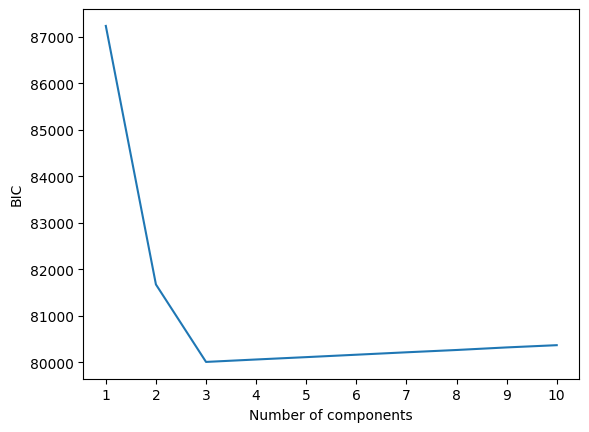

In [ ]:
plot_BIC(Y)

# 5. If we change some parameters...
Let us investigate the influence of parameters (such as number of components $K$, number of dimensions $d$ and sample size $n$) on ***execution time*** of EM algorithm and ***estimation errors***.


## 5.1. Influence on execution time

In [ ]:
sample_size = np.array([100, 1000, 10000, 100000])
n_comp_max = 10
d = 3

ss = len(sample_size)
cc = n_comp_max - 1
time_ = []
for size in sample_size:
  time_row = []
  for K in range(2, n_comp_max + 1):
    i = 1
    while i: # to avoid singular covariance matrices occurrence in EM iteration
      Y, _, _, _ = mixture_sample(size, K, d)
      try:
        t_start = time.time()
        EM_expl(Y, K, init_method="k-means")
        t_stop = time.time()
        i = 0
      except:
        i = 1    
    t = t_stop - t_start
    time_row = np.append(time_row, t)
  time_ = np.append(time_, time_row) 
time_ = time_.reshape(ss, cc)

X = np.arange(2, n_comp_max + 1)
width = 0.2

for i in range(ss):
  plt.bar(X + i * width, time_[i], width, label=f"sample size = $10^{i+2}$")

plt.yscale('log')
plt.ylabel('Execution time (seconds)')
plt.xlabel('Number of components')
plt.title('Dependence of execution time on number of components, dim = 3')
plt.xticks(X + 1.5 * width, labels=[str(k) for k in X])
plt.legend(loc="upper left")
plt.show()

![5.1.1](data:application/octet-stream;base64,iVBORw0KGgoAAAANSUhEUgAAAmEAAAHHCAYAAAD3WI8lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAABxr0lEQVR4nO3deVxU1f8/8NcwyCL7vigC4soiuIsbqCRRaWqlZSlKahqoSFZauZNgpqJGopZpVh8tTeuTK5HLxw1ccTc1FVIWVxBQkJnz+8Mv9+fIIgyDV/D1fDzm8XDOPXPP+9yZYd6ee+65CiGEABERERE9VXpyB0BERET0PGISRkRERCQDJmFEREREMmASRkRERCQDJmFEREREMmASRkRERCQDJmFEREREMmASRkRERCQDJmFEREREMmAS9gy7fPkyFAoFVq5cKXcoT01eXh5GjBgBR0dHKBQKREZGyh2SLJ7F9/5ZjOl5FhgYCG9vb7nDqLTVq1ejRYsWqFevHiwtLeUOh2SwcuVKKBQKXL58WSoLDAxEYGCgbDHJrVYlYSVvYMnDyMgIzs7OCA4OxqJFi3D37l25Q6Rqmj17NlauXIkxY8Zg9erVGDJkiNwh1aiffvoJcXFxcoeh4VmMiWq3s2fPYtiwYfDw8MDy5cuxbNkyuUN6Ll27dg3Tp0/HsWPH5A6lVtu9ezf69u0LFxcXGBkZwdHRES+++CL27t1b5X3p10B8NW7mzJlwd3fHgwcPkJmZiZ07dyIyMhLz58/H77//jlatWskdImnpr7/+QqdOnTBt2jS5Q3kqfvrpJ5w8ebLUiJ+rqyvu3buHevXqMSaq9Xbu3Am1Wo2FCxeiSZMmcofz3Lp27RpmzJgBNzc3+Pn5yR0OAGD79u1yh1Blf//9N/T09DB69Gg4Ojri9u3b+OGHH9C9e3ds2rQJL774YqX3VSuTsJCQELRr1056PnnyZPz111945ZVX0LdvX5w5cwbGxsYyRkjays7Ohqenp9xhyK5kpPdZ8izGRDVLrVajqKio2u97dnY2APA0JJViYGAgdwhVNmLECIwYMUKj7P3330fjxo0RFxdXpSSsVp2OrEjPnj0xZcoUXLlyBT/88IPGtrNnz+L111+HtbU1jIyM0K5dO/z+++8adUpOde7evRvvvfcebGxsYG5ujqFDh+L27dul2tuyZQu6desGExMTmJmZ4eWXX8apU6c06gwbNgympqa4evUq+vXrB1NTU9jZ2WHixIlQqVQade/cuYNhw4bBwsIClpaWCA0NxZ07d8rsa1X6s3fvXkRFRcHOzg4mJibo378/rl+/XmZ/AgICYGZmBnNzc7Rv3x4//fSTRp3k5GS8+OKLsLCwQP369REQEFDp4dfs7Gy8++67cHBwgJGREXx9fbFq1Spp+86dO6FQKHDp0iVs2rRJOuX86NyBsvzwww9o27YtjI2NYW1tjTfffBPp6enS9u+++w4KhQIrVqzQeN3s2bOhUCiwefNmqawyxxV4+F5NmDABbm5uMDQ0RMOGDTF06FDcuHEDQNnzHh7t486dOwE8nAuxadMmXLlyReqvm5sbgPLnX/3111/S587S0hKvvvoqzpw5o1Fn+vTpUCgUuHDhAoYNGwZLS0tYWFhg+PDhKCgoqPB4VjWmks94WloaXnnlFZiamqJBgwaIj48HAJw4cQI9e/aEiYkJXF1dS32mSo5nZGQkXFxcYGhoiCZNmmDOnDlQq9UVxlri66+/hpeXFwwNDeHs7Izw8PBS352S+VOnT59Gjx49UL9+fTRo0ABffPFFpdpQKBSIiIjAxo0b4e3tDUNDQ3h5eWHr1q0a9YYNGyYdr0eVvCdl7fOXX36Bp6cnjI2N4e/vjxMnTgAAli5diiZNmsDIyAiBgYHlfhcOHz6Mzp07w9jYGO7u7khISChVp7CwENOmTUOTJk1gaGgIFxcXfPTRRygsLCwzph9//FE6po/38XFPOv5ubm7SyLadnR0UCgWmT59e4T7Pnj2LgQMHws7ODsbGxmjevDk+/fRTjTpHjx5FSEgIzM3NYWpqil69euHAgQMadUq+i3v27MG4ceNgZ2cHS0tLvPfeeygqKsKdO3cwdOhQWFlZwcrKCh999BGEENLrSz7zX375JRYsWABXV1cYGxsjICAAJ0+eLBV3TXw/n/Q3Dqjc53vnzp1o3749AGD48OHS97vk+3z+/Hm89tprcHR0hJGRERo2bIg333wTOTk5Fb5X5Tl16hR69uwJY2NjNGzYENHR0WV+px+fE1byd/Lnn3/GjBkz0KBBA5iZmeH1119HTk4OCgsLERkZCXt7e5iammL48OGlPsdyqF+/Puzs7Mr93S6XqEW+++47AUAcPHiwzO3p6ekCgHj99delspMnTwoLCwvh6ekp5syZI7766ivRvXt3oVAoxK+//lpq3z4+PqJbt25i0aJFIjw8XOjp6Ynu3bsLtVot1f3++++FQqEQL774oli8eLGYM2eOcHNzE5aWluLSpUtSvdDQUGFkZCS8vLxEWFiYWLJkiXjttdcEAPH1119L9dRqtejevbvQ09MT77//vli8eLHo2bOnaNWqlQAgvvvuO63707p1a9GzZ0+xePFi8cEHHwilUikGDhxY6rgqFArh7e0tPv/8cxEfHy9GjBghhgwZItVJSkoSBgYGwt/fX8ybN08sWLBAtGrVShgYGIjk5OQK37eCggLRsmVLUa9ePTFhwgSxaNEi0a1bNwFAxMXFCSGEyMzMFKtXrxa2trbCz89PrF69WqxevVrk5eWVu9/o6GihUCjEoEGDxNdffy1mzJghbG1thZubm7h9+7ZU75VXXhEWFhYiLS1NCCHE8ePHhYGBgXj33XerfFzv3r0rvL29hVKpFCNHjhRLliwRs2bNEu3btxdHjx7VOPaPfhaEEGLHjh0CgNixY4cQQojt27cLPz8/YWtrK/V3w4YNQgghLl26VOq9T0xMFPr6+qJZs2biiy++kPprZWWl0da0adOk937AgAHi66+/FiNGjBAAxEcffVThe1XVmEo+456enmL06NEiPj5edO7cWarn7OwsPvzwQ7F48WLh5eUllEql+Oeff6TX5+fni1atWgkbGxvxySefiISEBDF06FChUCjE+PHjK4z10b4GBQWJxYsXi4iICKFUKkX79u1FUVGRVC8gIEA4OzsLFxcXMX78ePH111+Lnj17CgBi8+bNT2wHgPD19RVOTk5i1qxZIi4uTjRu3FjUr19f3LhxQ+N4uLq6lhvn4/ts1aqVcHFxEbGxsSI2NlZYWFiIRo0aia+++kp4enqKefPmic8++0wYGBiIHj16aLy+pE/29vYiIiJCLFq0SHTt2lUAEN9++61UT6VSid69e4v69euLyMhIsXTpUhERESH09fXFq6++Wiqmli1bCjs7OzFjxgwRHx8vfa61Pf4bNmwQ/fv3FwDEkiVLxOrVq0Vqamq5+0xNTRXm5ubCxsZGTJ48WSxdulR89NFHwsfHR6pz8uRJYWJiIr0fsbGxwt3dXRgaGooDBw5I9Uq+i35+fuLFF18U8fHxYsiQIdJ3oWvXrmLw4MHi66+/Fq+88ooAIFatWiW9vuQz7+PjI9zc3MScOXPEjBkzhLW1tbCzsxOZmZlS3Zr4flb2b1xlPt+ZmZli5syZAoAYNWqU9P2+ePGiKCwsFO7u7sLZ2VlER0eLb775RsyYMUO0b99eXL58udz3qjwZGRnCzs5OWFlZienTp4u5c+eKpk2bSr9pjx6PgIAAERAQID0v+Tvp5+cn/P39xaJFi8S4ceOEQqEQb775phg8eLAICQnReC9nzJjxxJjy8/PF9evXn/i4detWpfuZk5Mjrl+/Ls6cOSMmT54sAIhPPvmkKodK1KkkTAghLCwsROvWraXnvXr1Ej4+PuL+/ftSmVqtFp07dxZNmzYtte+2bdtq/PH+4osvBADx22+/CSEe/ghbWlqKkSNHarSbmZkpLCwsNMpDQ0MFADFz5kyNuq1btxZt27aVnm/cuFEAEF988YVUVlxcLCUqj/7oVbU/QUFBGgnkhAkThFKpFHfu3BFCCHHnzh1hZmYmOnbsKO7du6cRZ8nr1Gq1aNq0qQgODtbYV0FBgXB3dxcvvPCCqEhcXJwAIH744QeprKioSPj7+wtTU1ORm5srlbu6uoqXX365wv0JIcTly5eFUqkUn3/+uUb5iRMnhL6+vkZ5RkaGsLa2Fi+88IIoLCwUrVu3Fo0aNRI5OTlSncoe16lTpwoAGonZo/WFqHwSJoQQL7/8cpk/2mUlPH5+fsLe3l7cvHlTKktNTRV6enpi6NChUlnJH/mwsDCNffbv31/Y2NiUautxVYmp5DM+e/Zsqez27dvC2NhYKBQKsWbNGqn87NmzAoCYNm2aVDZr1ixhYmIi/v77b422Jk2aJJRKpZQ4lyU7O1sYGBiI3r17C5VKJZV/9dVXAoBYsWKFVBYQECAAiO+//14qKywsFI6OjuK1116r8HgI8TA5MTAwEBcuXJDKUlNTBQCxePFijeNRlSTM0NBQ43OydOlSAUA4OjpqfC9K/sA//uMFQMybN0+jTyWfk5K/Y6tXrxZ6enrif//7n0b7CQkJAoDYu3evRkx6enri1KlTTzwmVTn+Jf2/fv36E/fbvXt3YWZmJq5cuaJR/ujfnn79+gkDAwNx8eJFqezatWvCzMxMdO/eXSor+S4+/rfL399fKBQKMXr0aKmsuLhYNGzYUCMhKPnMGxsbi3///VcqT05OFgDEhAkTpDJdfz+r8jeusp/vgwcPlvoOCyHE0aNHBQDxyy+/CF2IjIwUADT+g56dnS0sLCwqnYR5e3tr/Ba/9dZbQqFQiJCQEI22/P39y/zOPa7kuD/pUZl9lQgODpZeZ2BgIN57771Sv6NPUmdOR5YwNTWVrpK8desW/vrrLwwcOBB3797FjRs3cOPGDdy8eRPBwcE4f/48rl69qvH6UaNGaUw8HjNmDPT19aXTVomJibhz5w7eeustaX83btyAUqlEx44dsWPHjlIxjR49WuN5t27d8M8//0jPN2/eDH19fYwZM0YqUyqVGDt2rMbrtO3Po6dBunXrBpVKhStXrkj9uXv3LiZNmlRq3kfJ644dO4bz589j8ODBuHnzptRufn4+evXqhd27d1d46mjz5s1wdHTEW2+9JZXVq1cP48aNQ15eHnbt2lXua8vz66+/Qq1WY+DAgRrvg6OjI5o2barxPjg6OiI+Ph6JiYno1q0bjh07hhUrVsDc3LzKx3X9+vXw9fVF//79S8X0+OkmXcrIyMCxY8cwbNgwWFtbS+WtWrXCCy+8oHFatURZn7ubN28iNzdX5/E9Oj/C0tISzZs3h4mJCQYOHCiVN2/eHJaWlhqf/V9++QXdunWDlZWVxvsYFBQElUqF3bt3l9vmn3/+iaKiIkRGRkJP7///KRs5ciTMzc2xadMmjfqmpqZ45513pOcGBgbo0KGDRjwVCQoKgoeHh/S8VatWMDc3r/Try9KrVy+N05cdO3YEALz22mswMzMrVf54W/r6+njvvfek5wYGBnjvvfeQnZ2Nw4cPA3h4jFu2bIkWLVpoHOOePXsCQKm/WQEBAZWal1nV418Z169fx+7duxEWFoZGjRppbCv5fqlUKmzfvh39+vVD48aNpe1OTk4YPHgw9uzZU+oz/u6772p8Pzt27AghBN59912pTKlUol27dmW+n/369UODBg2k5x06dEDHjh2l711NfD+r8jcOqN7n28LCAgCwbdu2J05ZqIzNmzejU6dO6NChg1RmZ2eHt99+u9L7GDp0qMZvccl7FhYWplGvY8eOSE9PR3Fx8RP3l5iY+MTHjz/+WOkYY2NjsX37dnz77bfo1KkTioqKnhjH42rlxPyK5OXlwd7eHgBw4cIFCCEwZcoUTJkypcz62dnZGl+upk2bamw3NTWFk5OTNB/j/PnzACD9AXtcyQ97CSMjI9jZ2WmUWVlZacwzu3LlCpycnGBqaqpRr3nz5hrPtenP43/IrKysAEBq/+LFiwBQ4XpDJX0ODQ0tt05OTo6078dduXIFTZs21fhDDQAtW7aUtlfV+fPnIYQo9X6VePwKvjfffBM//PADNm3ahFGjRqFXr17Stqoc14sXL+K1116rcrzVVXKMHv9MAA+P47Zt25Cfnw8TExOpvKL3/vHPaXWU9Rm3sLBAw4YNSyWmFhYWGp/98+fP4/jx46VeX6JkQndZyjsmBgYGaNy4canPVVnxWFlZ4fjx4+W28ajHj2fJ68uaM1pZj++z5MfQxcWlzPLH23J2dtZ4zwGgWbNmAB7OZ+rUqRPOnz+PM2fOVPoYu7u7Vyr2qh7/yihJGCr6e3T9+nUUFBSU+11Qq9VIT0+Hl5eXVF6V41zW+1nW35lmzZrh559/BlAz38+q/o2rzufb3d0dUVFRmD9/Pn788Ud069YNffv2xTvvvCMdq6q4cuWK9B+HR5V1fMpTlfdMrVYjJycHNjY25e6vcePGGkm7Ljx6hek777yDNm3aYNiwYVi3bl2l91GnkrB///0XOTk50iXQJaMzEydORHBwcJmvqerl0iX7XL16NRwdHUtt19fXPKRKpbJK+69M21XpT3nti0cmn1a23blz55Z7WfPjCWRNU6vVUCgU2LJlS5l9fDyemzdv4tChQwCA06dPQ61WS0mhrj8n5Y2IPX4xRk3TxXtfnXYq075arcYLL7yAjz76qMy6JQmFLlT3eFTm9VV976tz7CpLrVbDx8cH8+fPL3P74z9qdfHK8qocZ11/P8rzpPe4qn/jqvuZmTdvHoYNG4bffvsN27dvx7hx4xATE4MDBw6gYcOGldqHLun6u5GXl4e8vLxKtVvef1gqYmBggL59+yI2Nhb37t2r9PeoTiVhq1evBgDph7Qk661Xrx6CgoIqtY/z58+jR48e0vO8vDxkZGTgpZdeAgDpdIS9vX2l9/kkrq6uSEpKQl5ensYX69y5cxr1tOnPk5T05+TJk+UmGiV1zM3NtWrX1dUVx48f10h8gIdXQJVsryoPDw8IIeDu7l6pH+rw8HDcvXsXMTExmDx5MuLi4hAVFQWgasfVw8OjzKuiHlXyP9rHr5Ipa2SgsqcwS47R458J4OFxtLW1LTUioq2aPK36OA8PD+Tl5Wn9uQIeHpNH/4dbVFSES5cu6ew7UhVWVlZlXh2lzahQZVy7dq3UCMvff/8NANJpTg8PD6SmpqJXr146fW9r4viX7Kei75idnR3q169f7ndBT0+vVGJZXSVnAx71999/S8e4Jr6fVf0bVxlPev99fHzg4+ODzz77DPv27UOXLl2QkJCA6OjoKrXj6upa5jEr6/g8LV9++SVmzJjxxHqurq5PvCq/PPfu3YMQAnfv3q10ElZn5oT99ddfmDVrFtzd3aXzzvb29ggMDMTSpUuRkZFR6jVlLdWwbNkyPHjwQHq+ZMkSFBcXIyQkBMDDBM/c3ByzZ8/WqFfRPp/kpZdeQnFxMZYsWSKVqVQqLF68WKOeNv15kt69e8PMzAwxMTG4f/++xraS/1m0bdsWHh4e+PLLL8v8n8ST2n3ppZeQmZmJtWvXSmXFxcVYvHgxTE1NERAQUOW4BwwYAKVSiRkzZpT6H5AQAjdv3pSer1u3DmvXrkVsbCwmTZqEN998E5999pn0Y1WV4/raa68hNTUVGzZsKFWvJI6SpPXR+UwqlarMVcJNTEwqdQm4k5MT/Pz8sGrVKo0f+ZMnT2L79u3SfxJ0obIx6cLAgQOxf/9+bNu2rdS2O3fuVDi/IigoCAYGBli0aJHGZ+Dbb79FTk4OXn755RqJuSIeHh7IycnROAWUkZFR5udFF4qLi7F06VLpeVFREZYuXQo7Ozu0bdsWwMNjfPXqVSxfvrzU6+/du4f8/Hyt2q6J429nZ4fu3btjxYoVSEtL09hW0oZSqUTv3r3x22+/afxYZmVl4aeffkLXrl11erodADZu3Kgx3zYlJQXJycnS70JNfD+r8jeuskoSwcf/o5Cbm1vqu+bj4wM9PT2tln946aWXcODAAaSkpEhl169fr9J8K13T5ZywsqZJ3LlzB+vXr4eLi4s0JaoyauVI2JYtW3D27FkUFxcjKysLf/31FxITE+Hq6orff/9dY4J5fHw8unbtCh8fH4wcORKNGzdGVlYW9u/fj3///Repqaka+y4qKkKvXr0wcOBAnDt3Dl9//TW6du2Kvn37Ang4GrRkyRIMGTIEbdq0wZtvvgk7OzukpaVh06ZN6NKlC7766qsq9adPnz7o0qULJk2ahMuXL8PT0xO//vprmT+EVe3Pk5ibm2PBggUYMWIE2rdvj8GDB8PKygqpqakoKCjAqlWroKenh2+++QYhISHw8vLC8OHD0aBBA1y9ehU7duyAubk5/vvf/5bbxqhRo7B06VIMGzYMhw8fhpubG9atW4e9e/ciLi5OYwJyZXl4eCA6OhqTJ0/G5cuX0a9fP5iZmeHSpUvYsGEDRo0ahYkTJyI7OxtjxoxBjx49EBERAQD46quvsGPHDgwbNgx79uyBnp5epY/rhx9+iHXr1uGNN95AWFgY2rZti1u3buH3339HQkICfH194eXlhU6dOmHy5Mm4desWrK2tsWbNmjITirZt22Lt2rWIiopC+/btYWpqij59+pTZ57lz5yIkJAT+/v549913ce/ePSxevBgWFhZPXHepKqoSU3V9+OGH+P333/HKK69g2LBhaNu2LfLz83HixAmsW7cOly9fhq2tbZmvtbOzw+TJkzFjxgy8+OKL6Nu3r/Sdbd++vcYk5aflzTffxMcff4z+/ftj3LhxKCgowJIlS9CsWTMcOXJE5+05Oztjzpw5uHz5Mpo1a4a1a9fi2LFjWLZsmTRnaMiQIfj5558xevRo7NixA126dIFKpcLZs2fx888/Y9u2bRqLX1dWTR3/RYsWoWvXrmjTpg1GjRoFd3d3XL58GZs2bZJutxMdHY3ExER07doV77//PvT19bF06VIUFhZWeu23qmjSpAm6du2KMWPGoLCwEHFxcbCxsdE4ja7r72dl/8ZVdZ+WlpZISEiAmZkZTExM0LFjR6SmpiIiIgJvvPEGmjVrhuLiYqxevRpKpVJjDuz06dMxY8YM7Nixo8L7PX700UdYvXo1XnzxRYwfPx4mJiZYtmyZdFZEDrqcExYSEoKGDRuiY8eOsLe3R1paGr777jtcu3ZNY7ChUqp0LaXMSi43xiOXhDo6OooXXnhBLFy4UOOS7kddvHhRDB06VDg6Oop69eqJBg0aiFdeeUWsW7eu1L537dolRo0aJaysrISpqal4++23NS45LrFjxw4RHBwsLCwshJGRkfDw8BDDhg0Thw4dkuqEhoYKExOTUq8t63L1mzdviiFDhghzc3NhYWEhhgwZIl02/PjlxFXpz+PLeZS1TIIQQvz++++ic+fOwtjYWJibm4sOHTqI//znPxp1jh49KgYMGCBsbGyEoaGhcHV1FQMHDhRJSUllHvdHZWVlieHDhwtbW1thYGAgfHx8SvVLiMovUVFi/fr1omvXrsLExESYmJiIFi1aiPDwcHHu3DkhhBADBgwQZmZmpda6+e233wQAMWfOHKmsMsdViIfvVUREhGjQoIEwMDAQDRs2FKGhoRrrRV28eFEEBQUJQ0ND4eDgID755BORmJhY6tjn5eWJwYMHC0tLS43Lo8taDkIIIf7880/RpUsX6X3q06ePOH36tEad8pYDKG/pjMdVJabyPuMBAQHCy8urVHlZ7+/du3fF5MmTRZMmTYSBgYGwtbUVnTt3Fl9++aXGJerl+eqrr0SLFi1EvXr1hIODgxgzZozGGkoVxVPekhKPAyDCw8PL7E9oaKhG2fbt24W3t7cwMDAQzZs3Fz/88EO5S1Q8vs+SYzx37lyN8pLv7aNLCJT06dChQ8Lf318YGRkJV1dX8dVXX5WKs6ioSMyZM0d4eXkJQ0NDYWVlJdq2bStmzJihsVRLef2sSGWOf1WWqBDi4Tpg/fv3F5aWlsLIyEg0b95cTJkyRaPOkSNHRHBwsDA1NRX169cXPXr0EPv27dOoU97fwfLiefzz/Oj7MW/ePOHi4iIMDQ1Ft27dylzrrCa+n0/6GydE1T7fv/32m/D09BT6+vrS9/mff/4RYWFhwsPDQxgZGQlra2vRo0cP8eeff2q89oMPPhAKhUKcOXOmVFuPO378uAgICBBGRkaiQYMGYtasWeLbb7+t9BIVjy+XUdX3siZ99dVXomvXrsLW1lbo6+sLOzs70adPH7F79+4q70shxFOahfiMW7lyJYYPH46DBw9q9b9CIiKqWy5fvgx3d3fMnTu3yqNOdVGHDh3g6uqKX375Re5Q6oxaeTqSiIiInp7c3FykpqZq3G6Oqo9JGBEREVXI3Nz8mbhHY11TZ66OJCIiIqpNOCeMiIiISAYcCSMiIiKSAZMwIiIiIhlwYn4F1Go1rl27BjMzs6d6KxciIiLSnvi/2wc5Oztr3C7vWcMkrALXrl3T+T3IiIiI6OlIT0+X5QbklcUkrAIlt9NJT0/X+b3IiIiIqGbk5ubCxcVFq9viPU1MwipQcgrS3NycSRgREVEt86xPJXp2T5QSERER1WFMwoiIiIhkwCSMiIiISAacE1aG+Ph4xMfHQ6VSVaq+SqXCgwcPajgqIt2qV68elEql3GEQET23eNuiCuTm5sLCwgI5OTllTswXQiAzMxN37tx5+sER6YClpSUcHR2f+cmrRERV8aTf72cFR8KqoSQBs7e3R/369flDRrWGEAIFBQXIzs4GADg5OckcERHR84dJmJZUKpWUgNnY2MgdDlGVGRsbAwCys7Nhb2/PU5NERE8ZJ+ZrqWQOWP369WWOhEh7JZ9fzmkkInr6mIRVE09BUm3Gzy8RkXyYhBERERHJgEkYERERkQyYhBHVMenp6QgMDISnpydatWqFX375Re6QiIioDLw6kqiO0dfXR1xcHPz8/JCZmYm2bdvipZdegomJidyhERHRIzgSRs+UwMBAREZG1tr9PwucnJzg5+cHAHB0dIStrS1u3bolb1BERFQKR8LoufLrr7+iXr16codRrt27d2Pu3Lk4fPgwMjIysGHDBvTr169Uvfj4eMydOxeZmZnw9fXF4sWL0aFDh1L1Dh8+DJVKBRcXl6cQPRHR/3emRctK1Wt59kwNR/Ls4kgYPVesra1hZmYmdxjlys/Ph6+vL+Lj48uts3btWkRFRWHatGk4cuQIfH19ERwcLK1+X+LWrVsYOnQoli1bVtNhExGRFjgSVgPcJm16qu1djn25yq9Zt24dZsyYgQsXLqB+/fpo3bo1fvvtN5iYmGDr1q2Ijo7GyZMnoVQq4e/vj4ULF8LDwwPAw1N6Pj4+UCqVWLVqFQwMDBAdHY3BgwcjIiIC69atg4ODAxYvXoyQkBCpzcDAQHh7ewMAVq9ejXr16mHMmDGYOXNmmetVqdVqzJkzB8uWLUNmZiaaNWuGKVOm4PXXX9eqXyUx+Pn5ITIyEu7u7qVeHxAQgJ07d2rdfnWFhIRoHLOyzJ8/HyNHjsTw4cMBAAkJCdi0aRNWrFiBSZMmAQAKCwvRr18/TJo0CZ07d66xeImISHscCXsOZWRk4K233kJYWBjOnDmDnTt3YsCAASi5l3t+fj6ioqJw6NAhJCUlQU9PD/3794darZb2sWrVKtja2iIlJQVjx47FmDFj8MYbb6Bz5844cuQIevfujSFDhqCgoECj7VWrVkFfXx8pKSlYuHAh5s+fj2+++abMOGNiYvD9998jISEBp06dwoQJE/DOO+9g165dWvXrUS4uLsjIyJAeR48ehY2NDbp37651+wAwe/ZsmJqaVvhIS0sr/815gqKiIhw+fBhBQUFSmZ6eHoKCgrB//34AD+8LOWzYMPTs2RNDhgzRui0iIqpZHAl7DmVkZKC4uBgDBgyAq6srAMDHx0fa/tprr2nUX7FiBezs7HD69GlpJMvX1xefffYZAGDy5MmIjY2Fra0tRo4cCQCYOnUqlixZguPHj6NTp07SvlxcXLBgwQIoFAo0b94cJ06cwIIFC6TXlSgsLMTs2bPx559/wt/fHwDQuHFj7NmzB0uXLkVAQECV+/UopVIJR0dHAMD9+/fRr18/+Pv7Y/r06Vq3DwCjR4/GwIEDy9xWwtnZucLtFblx4wZUKhUcHBw0yh0cHHD27FkAwN69e7F27Vq0atUKGzduBPBw5LG8Y0FERPJgEvYc8vX1Ra9eveDj44Pg4GD07t0br7/+OqysrAAA58+fx9SpU5GcnIwbN25II2BpaWlSEtaqVStpf0qlEjY2Nho/8iVJwuPzlDp16qRx6tHf3x/z5s2DSqXSuIH0hQsXUFBQgBdeeEHj9UVFRWjdurVW/SpPWFgY7t69i8TEROjp6WndPvBwzpm1tXWF7dW0rl27aoxaEhHRs4lJ2HNIqVQiMTER+/btw/bt27F48WJ8+umnSE5Ohru7O/r06QNXV1csX74czs7OUKvV8Pb2RlFRkbSPx68wVCgUGmUliZa2yUBeXh4AYNOmTWjQoIHGNkNDQ636VZbo6Ghs27YNKSkpGhP2tWkfeHg6cvbs2RX27fTp02jUqFGFdcpja2sLpVKJrKwsjfKsrCxpZI+IiGoHJmHPKYVCgS5duqBLly6YOnUqXF1dsWHDBoSGhuLcuXNYvnw5unXrBgDYs2ePztpNTk7WeH7gwAE0bdpUYxQMADw9PWFoaIi0tLRyT/2Vpbx+RUVFlaq7fv16zJw5E1u2bJEuOqhu+zV9OtLAwABt27ZFUlKStHSFWq1GUlISIiIitN4vERE9fUzCnkPJyclISkpC7969YW9vj+TkZFy/fh0tW7aElZUVbGxssGzZMjg5OSEtLU264k4X0tLSEBUVhffeew9HjhzB4sWLMW/evFL1zMzMMHHiREyYMAFqtRpdu3ZFTk4O9u7dC3Nzc4SGhlapX487efIkhg4dio8//hheXl7IzMwE8DDJKVnGoqrtA9U/HZmXl4cLFy5Izy9duoRjx47B2tpaGj2LiopCaGgo2rVrhw4dOiAuLg75+fnS1ZJERFQ7MAl7Dpmbm2P37t2Ii4tDbm4uXF1dMW/ePGlphDVr1mDcuHHw9vZG8+bNsWjRIgQGBuqk7aFDh+LevXvo0KEDlEolxo8fj1GjRpVZd9asWbCzs0NMTAz++ecfWFpaok2bNvjkk0+06tejDh06hIKCAkRHRyM6Oloqf3SJiqq2rwuHDh1Cjx49pOclI3ihoaFYuXIlAGDQoEG4fv06pk6diszMTPj5+WHr1q2lJusTEdGzTSHKun6fAAC5ubmwsLBATk4OzM3NNbbdv38fly5dgru7O4yMjDS21YZ1wuRQskZXXFyc3KHQ/6noc0xEVB1yrphf0e/3s4QjYTWgtiRFRES1HW+NQ7UZF2slIiIikgFHwuipKZlrRURERBwJIyIiIpLFc5GE9e/fH1ZWVjV642UiIiKiqngukrDx48fj+++/lzsMIiIiIslzkYQFBgZq3JKGiIiISG7PfBK2e/du9OnTB87OzlAoFNi4cWOpOvHx8XBzc4ORkRE6duyIlJSUpx8oERERURU880lYfn4+fH19ER8fX+b2tWvXIioqCtOmTcORI0fg6+uL4OBgZGdnP+VIiYiIiCrvmV+iIiQkpMzbzpSYP38+Ro4cKd03LyEhAZs2bcKKFSuqfM/DwsJCFBYWSs9zc3O1C5qIiIjoCZ75kbCKFBUV4fDhwwgKCpLK9PT0EBQUhP3791d5fzExMbCwsJAeLi4uugyXiIiISFKrk7AbN25ApVKVunGxg4MDMjMzpedBQUF44403sHnzZjRs2LDcBG3y5MnIycmRHunp6TUaPxERET2/nvnTkbrw559/VqqeoaEhDA0NazgaIiIiolo+EmZrawulUomsrCyN8qysLDg6OsoUFREREdGT1eokzMDAAG3btkVSUpJUplarkZSUBH9/fxkjIyIiIqrYM386Mi8vDxcuXJCeX7p0CceOHYO1tTUaNWqEqKgohIaGol27dujQoQPi4uKQn58vXS2pjfj4eMTHx0OlUumiC0RP1Z07dxAUFITi4mIUFxdj/PjxGDlypNxhERHRY575JOzQoUPo0aOH9DwqKgoAEBoaipUrV2LQoEG4fv06pk6diszMTPj5+WHr1q2lJutXRXh4OMLDw5GbmwsLC4tq94HoaTIzM8Pu3btRv3595Ofnw9vbGwMGDICNjY3coRER0SOe+SQsMDAQQogK60RERCAiIuIpRUQ1KTAwEH5+foiLi6uV+38WKJVK1K9fH8DDte+EEE/8DhER0dNXq+eEEVXVr7/+ilmzZskdRrkqc5su4Mm36rpz5w58fX3RsGFDfPjhh7C1tX0K0RMRUVU88yNhtdL0p3wKc3rO022vFrO2tpY7hAqV3KYrLCwMAwYMKLNOya26EhIS0LFjR8TFxSE4OBjnzp2Dvb09AMDS0hKpqanIysrCgAED8Prrr1frFD0REekeR8LKEB8fD09PT7Rv317uUGrMunXr4OPjA2NjY9jY2CAoKAj5+fkAgK1bt6Jr166wtLSEjY0NXnnlFVy8eFF6bWBgIMaOHYvIyEhYWVnBwcEBy5cvly6IMDMzQ5MmTbBlyxaNNgMDA6VTxxYWFrC1tcWUKVPKPVWmVqsRExMDd3d3GBsbw9fXF+vWrdO6XyUxREZG4vLly1AoFKUegYGB1Wq/ukJCQhAdHY3+/fuXW+fRW3V5enoiISEB9evXx4oVK0rVdXBwgK+vL/73v//VZNhERKQFJmFlCA8Px+nTp3Hw4EG5Q6kRGRkZeOuttxAWFoYzZ85g586dGDBggJQM5efnIyoqCocOHUJSUhL09PTQv39/qNVqaR+rVq2Cra0tUlJSMHbsWIwZMwZvvPEGOnfujCNHjqB3794YMmQICgoKNNpetWoV9PX1kZKSgoULF2L+/Pn45ptvyowzJiYG33//PRISEnDq1ClMmDAB77zzDnbt2qVVvx7l4uKCjIwM6XH06FHY2Nige/fuWrcPALNnz4apqWmFj7S0tPLfnCeozK26srKycPfuXQBATk4Odu/ejebNm2vdJhER1QyejnwOZWRkoLi4GAMGDICrqysAwMfHR9r+2muvadRfsWIF7OzscPr0aXh7ewMAfH198dlnnwF4eLun2NhY2NraSkshTJ06FUuWLMHx48fRqVMnaV8uLi5YsGABFAoFmjdvjhMnTmDBggWlllAoLCzE7Nmz8eeff0prvjVu3Bh79uzB0qVLERAQUOV+PUqpVEoL+t6/fx/9+vWDv78/pk+frnX7ADB69GgMHDiwzG0lnJ2dK9xekYpu1XX27FkAwJUrVzBq1ChpQv7YsWPLPQ5ERCQfJmHPIV9fX/Tq1Qs+Pj4IDg5G79698frrr8PKygoAcP78eUydOhXJycm4ceOGNAKWlpYmJWGtWrWS9qdUKmFjY6PxQ1+SJGRnZ2u03alTJygUCum5v78/5s2bB5VKBaVSKZVfuHABBQUFeOGFFzReX1RUhNatW2vVr/KEhYXh7t27SExMhJ6entbtAw/nnMk976xDhw44duyYrDEQEdGTMQl7DimVSiQmJmLfvn3Yvn07Fi9ejE8//RTJyclwd3dHnz594OrqiuXLl8PZ2RlqtRre3t4oKiqS9lGvXj2NfSoUCo2ykkTr0VOYVZGXlwcA2LRpExo0aKCxrbz7ez6pX2WJjo7Gtm3bkJKSAjMzs2q1Dzw8HTl79uwK+3b69Gk0atSowjrl4a26iIjqDiZhzymFQoEuXbqgS5cumDp1KlxdXbFhwwaEhobi3LlzWL58Obp16wYA2LNnj87aTU5O1nh+4MABNG3aVGMUDAA8PT1haGiItLS0ck/9laW8fpUs8vuo9evXY+bMmdiyZQs8PDx00n5Nn4589FZd/fr1A/D/b9XFtfKIiGoXJmFlqOu3LUpOTkZSUhJ69+4Ne3t7JCcn4/r162jZsiWsrKxgY2ODZcuWwcnJCWlpaZg0aZLO2k5LS0NUVBTee+89HDlyBIsXL8a8efNK1TMzM8PEiRMxYcIEqNVqdO3aFTk5Odi7dy/Mzc0RGhpapX497uTJkxg6dCg+/vhjeHl5ITMzE8DDJMfa2lqr9oHqn4580m26ANTIrbqIiOjpYxJWhrp+2yJzc3Ps3r0bcXFxyM3NhaurK+bNm4eQkBAAwJo1azBu3Dh4e3ujefPmWLRokcbSDdUxdOhQ3Lt3Dx06dIBSqcT48eMxatSoMuvOmjULdnZ2iImJwT///ANLS0u0adMGn3zyiVb9etShQ4dQUFCA6OhoREdHS+UBAQHYuXOnVu3rwpNu0wWgRm7VRURET59C8H4m5SpJwnJycmBubq6x7f79+7h06RLc3d1hZGSk+UIu1lqm5+GWQbVNhZ9jolrgTIvSI91laXn2TA1HQo+T872p6Pf7WcKRsJpQS5IiIiIikg8XayUiIiKSAUfC6KkpmWtFREREHAkjIiIikgWTsDI8DzfwJiIiInkxCStDXb+BNxEREcmPSRgRERGRDJiEEREREcmASRgRERGRDJiEEREREcmASRgRERGRDJiEEREREcmASRgRERGRDJiElYGLtRIREVFNYxJWBi7WSkRERDWNN/AmqqMKCgrQsmVLvPHGG/jyyy/lDqfWO9OiZaXqtTx7poYjIaK6giNhRHXU559/jk6dOskdBhERlYNJGD1TAgMDERkZWWv3/6w4f/48zp49i5CQELlDISKicjAJo+fKr7/+ilmzZskdRrl2796NPn36wNnZGQqFAhs3biyzXnx8PNzc3GBkZISOHTsiJSVFY/vEiRMRExPzFCImIiJtcU5YDfBZ5fNU2zsReuKptlebWVtbyx1ChfLz8+Hr64uwsDAMGDCgzDpr165FVFQUEhIS0LFjR8TFxSE4OBjnzp2Dvb09fvvtNzRr1gzNmjXDvn37nnIPiIiosjgS9pxat24dfHx8YGxsDBsbGwQFBSE/Px8AsHXrVnTt2hWWlpawsbHBK6+8gosXL0qvDQwMxNixYxEZGQkrKys4ODhg+fLlyM/Px/Dhw2FmZoYmTZpgy5YtGm0GBgYiIiICERERsLCwgK2tLaZMmQIhRJkxqtVqxMTEwN3dHcbGxvD19cW6deu07ldJDJGRkbh8+TIUCkWpR2BgYLXar66QkBBER0ejf//+5daZP38+Ro4cieHDh8PT0xMJCQmoX78+VqxYAQA4cOAA1qxZAzc3N0ycOBHLly/HzJkzazRuIiKqOiZhz6GMjAy89dZbCAsLw5kzZ7Bz504MGDBASoby8/MRFRWFQ4cOISkpCXp6eujfvz/UarW0j1WrVsHW1hYpKSkYO3YsxowZgzfeeAOdO3fGkSNH0Lt3bwwZMgQFBQUaba9atQr6+vpISUnBwoULMX/+fHzzzTdlxhkTE4Pvv/8eCQkJOHXqFCZMmIB33nkHu3bt0qpfj3JxcUFGRob0OHr0KGxsbNC9e3et2weA2bNnw9TUtMJHWlpa+W/OExQVFeHw4cMICgqSyvT09BAUFIT9+/dLcaenp+Py5cv48ssvMXLkSEydOlXrNomIqGbwdORzKCMjA8XFxRgwYABcXV0BAD4+//8U6muvvaZRf8WKFbCzs8Pp06fh7e0NAPD19cVnn30GAJg8eTJiY2Nha2uLkSNHAgCmTp2KJUuW4Pjx4xpX6Lm4uGDBggVQKBRo3rw5Tpw4gQULFkivK1FYWIjZs2fjzz//hL+/PwCgcePG2LNnD5YuXYqAgIAq9+tRSqUSjo6OAID79++jX79+8Pf3x/Tp07VuHwBGjx6NgQMHlrmthLOzc4XbK3Ljxg2oVCo4ODholDs4OODs2bNa75eIiJ4+JmFliI+PR3x8PFQqldyh1AhfX1/06tULPj4+CA4ORu/evfH666/DysoKwMMr66ZOnYrk5GTcuHFDGgFLS0uTkrBWrVpJ+1MqlbCxsdFIeEqShOzsbI22O3XqBIVCIT339/fHvHnzoFKpoFQqpfILFy6goKAAL7zwgsbri4qK0Lp1a636VZ6wsDDcvXsXiYmJ0NPT07p94OGcs2dp3tmwYcPkDoGIiMrBJKwM4eHhCA8PR25uLiwsLOQOR+eUSiUSExOxb98+bN++HYsXL8ann36K5ORkuLu7o0+fPnB1dcXy5cvh7OwMtVoNb29vFBUVSfuoV6+exj4VCoVGWUmi9egpzKrIy8sDAGzatAkNGjTQ2GZoaKhVv8oSHR2Nbdu2ISUlBWZmZtVqH3h4OnL27NkV9u306dNo1KhRhXXKY2trC6VSiaysLI3yrKwsaWSPiIhqByZhzymFQoEuXbqgS5cumDp1KlxdXbFhwwaEhobi3LlzWL58Obp16wYA2LNnj87aTU5O1nh+4MABNG3aVGMUDAA8PT1haGiItLS0ck/9laW8fkVFRZWqu379esycORNbtmyBh4eHTtqv6dORBgYGaNu2LZKSktCvXz8ADxPdpKQkREREaL1fIiJ6+piEPYeSk5ORlJSE3r17w97eHsnJybh+/TpatmwJKysr2NjYYNmyZXByckJaWhomTZqks7bT0tIQFRWF9957D0eOHMHixYsxb968UvXMzMwwceJETJgwAWq1Gl27dkVOTg727t0Lc3NzhIaGVqlfjzt58iSGDh2Kjz/+GF5eXsjMzATwMMmxtrbWqn2g+qcj8/LycOHCBen5pUuXcOzYMVhbW0ujZ1FRUQgNDUW7du3QoUMHxMXFSVemEhFR7cEk7Dlkbm6O3bt3Iy4uDrm5uXB1dcW8efOk1dXXrFmDcePGwdvbG82bN8eiRYs0lm6ojqFDh+LevXvo0KEDlEolxo8fj1GjRpVZd9asWbCzs0NMTAz++ecfWFpaok2bNvjkk0+06tejDh06hIKCAkRHRyM6OloqDwgIwM6dO7VqXxcOHTqEHj16SM9LRvBCQ0OxcuVKAMCgQYNw/fp1TJ06FZmZmfDz88PWrVtLTdYnIqJnm0KUt0gTSXPCcnJyYG5urrHt/v37uHTpEtzd3WFkZCRThLVLYGAg/Pz8EBcXJ3co9H/4Oa483sD72cT35dkl53tT0e/3s4TrhBERERHJgEkYERERkQw4J4yempK5VkRERMSRMCIiIiJZMAkjIiIikgGTMCIiIiIZMAkjIiIikgGTsDLEx8fD09MT7du3lzsUIiIiqqOYhJUhPDwcp0+fxsGDB+UOhYiIiOooJmFEREREMmASRkRERCQDJmFEREREMmASRkRERCQDrW5bVFhYiOTkZFy5cgUFBQWws7ND69at4e7uruv4iIiIiOqkKiVhe/fuxcKFC/Hf//4XDx48gIWFBYyNjXHr1i0UFhaicePGGDVqFEaPHg0zM7OaipmInsDNzQ3m5ubQ09ODlZUVduzYIXdIRET0mEqfjuzbty8GDRoENzc3bN++HXfv3sXNmzfx77//oqCgAOfPn8dnn32GpKQkNGvWDImJiTUZNxE9wb59+3Ds2DEmYEREz6hKj4S9/PLLWL9+PerVq1fm9saNG6Nx48YIDQ3F6dOnkZGRobMg6fkRGBgIPz8/xMXF1cr9ExERVValR8Lee++9chOwx3l6eqJXr15aB0VUU3799VfMmjVL7jDKlbhyJV4KDISTvT0UCgXWLlyIeydPlnrEx8fDzc0NRkZG6NixI1JSUjT2o1AoEBAQgPbt2+PHH3+UqTdERFQRrSbmp6enQ6FQoGHDhgCAlJQU/PTTT/D09MSoUaN0GmBtdKZFy6faXsuzZ55qe7WZtbW13CFUKP/ePfg0a4ah/fvjrcjIMuus27oVUZ9+ioSEBHTs2BFxcXEIDg7GuXPnYG9vDwDYs2cPGjRogIyMDAQFBcHHxwetWrV6ij0hIqIn0WqJisGDB0vzTDIzM/HCCy8gJSUFn376KWbOnKnTAKlmrFu3Dj4+PjA2NoaNjQ2CgoKQn58PANi6dSu6du0KS0tL2NjY4JVXXsHFixel1wYGBmLs2LGIjIyElZUVHBwcsHz5cuTn52P48OEwMzNDkyZNsGXLFo02AwMDERERgYiICFhYWMDW1hZTpkyBEKLMGNVqNWJiYuDu7g5jY2P4+vpi3bp1WverJIbIyEhcvnwZCoWi1CMwMLBa7VdXcLdumD5uHF6tYCR50fffY+TIkRg+fDg8PT2RkJCA+vXrY8WKFVKdBg0aAACcnJzw0ksv4ciRIzUaNxERVZ1WSdjJkyfRoUMHAMDPP/8Mb29v7Nu3Dz/++CNWrlypy/ioBmRkZOCtt95CWFgYzpw5g507d2LAgAFSMpSfn4+oqCgcOnQISUlJ0NPTQ//+/aFWq6V9rFq1Cra2tkhJScHYsWMxZswYvPHGG+jcuTOOHDmC3r17Y8iQISgoKNBoe9WqVdDX10dKSgoWLlyI+fPn45tvvikzzpiYGHz//fdISEjAqVOnMGHCBLzzzjvYtWuXVv16lIuLCzIyMqTH0aNHYWNjg+7du2vdPgDMnj0bpqamFT7S0tLKf3OeoOjBAxw9fRpBQUFSmZ6eHoKCgrB//34AD9+/u3fvAgDy8vLw119/wcvLS+s2iYioZmh1OvLBgwcwNDQEAPz555/o27cvAKBFixackF8LZGRkoLi4GAMGDICrqysAwMfHR9r+2muvadRfsWIF7OzscPr0aXh7ewMAfH198dlnnwEAJk+ejNjYWNja2mLkyJEAgKlTp2LJkiU4fvw4OnXqJO3LxcUFCxYsgEKhQPPmzXHixAksWLBAel2JwsJCzJ49G3/++Sf8/f0BPLz4Y8+ePVi6dCkCAgKq3K9HKZVKODo6AgDu37+Pfv36wd/fH9OnT9e6fQAYPXo0Bg4cWOa2Es7OzhVur8iN27ehUqng4OCgUe7g4ICzZ88CALKystC/f38AgEqlwsiRI9G+fXut2yQiopqhVRLm5eWFhIQEvPzyy0hMTJQmOl+7dg02NjY6DZB0z9fXF7169YKPjw+Cg4PRu3dvvP7667CysgIAnD9/HlOnTkVycjJu3LghjYClpaVJSdij84uUSiVsbGw0Ep6SJCE7O1uj7U6dOkGhUEjP/f39MW/ePKhUKiiVSqn8woULKCgowAsvvKDx+qKiIrRu3VqrfpUnLCwMd+/eRWJiIvT09LRuH3g450zueWeNGzdGamqqrDEQEdGTaZWEzZkzB/3798fcuXMRGhoKX19fAMDvv/8unaakZ5dSqURiYiL27duH7du3Y/Hixfj000+RnJwMd3d39OnTB66urli+fDmcnZ2hVqvh7e2NoqIiaR+PXymrUCg0ykoSrUdPYVZFXl4eAGDTpk3S/KYSJaOwVe1XWaKjo7Ft2zakpKRoLDCsTfvAw9ORs2fPrrBvp0+fRqNGjSqsUx5bKysolUpkZWVplGdlZUkje0RUO1Xloi5ekFU3aJWEBQYG4saNG8jNzdUYZRg1ahTq16+vs+Co5igUCnTp0gVdunTB1KlT4erqig0bNiA0NBTnzp3D8uXL0a1bNwAPr7TTleTkZI3nBw4cQNOmTTVGwYCHy5wYGhoiLS2t3FN/ZSmvX1FRUaXqrl+/HjNnzsSWLVvg4eGhk/Zr+nSkQb16aO3piaSkJPTr1w/Aw0Q3KSkJERERWu+XiIiePq2SMODhqMPjp3nc3NyqGw89BcnJyUhKSkLv3r1hb2+P5ORkXL9+HS1btoSVlRVsbGywbNkyODk5IS0tDZMmTdJZ22lpaYiKisJ7772HI0eOYPHixZg3b16pemZmZpg4cSImTJgAtVqNrl27IicnB3v37oW5uTlCQ0Or1K/HnTx5EkOHDsXHH38MLy8vZGZmAgAMDAxgbW2tVftA9U9H5hUU4OIjE/evXL2K1LNnYW1hARcnJwDAuKFDMfKzz9CuXTt06NABcXFx0pWpRERUe1Q6CWvdurXGXJ6K1PbL4ePj4xEfHw+VSiV3KDXC3Nwcu3fvRlxcHHJzc+Hq6op58+YhJCQEALBmzRqMGzcO3t7eaN68ORYtWqSxdEN1DB06FPfu3UOHDh2gVCoxfvz4cteWmzVrFuzs7BATE4N//vkHlpaWaNOmDT755BOt+vWoQ4cOoaCgANHR0YiOjpbKAwICsHPnTq3a14Ujp07hxbAw6fnHc+cCAN7p2xfLPv8cAPD6iy8ix8gIU6dORWZmJvz8/LB169ZSk/WJiOjZphDlLdL0mBkzZkj/vn//Pr7++mt4enpKV44dOHAAp06dwvvvv4+YmJiaifYpy83NhYWFBXJycmBubq6x7f79+7h06RLc3d1hZGSksY2LtZaNtwx6snsnT1aqnvH/XSBRXRV9jklTZb/XteX7WFfUpfelrs0Jk/O9qej3+1lS6ZGwadOmSf8eMWIExo0bV+r2L9OmTUN6erruoqulasOXg4iIiOSl1WKtv/zyC4YOHVqq/J133sH69eurHRQRERFRXafVxHxjY2Ps3bsXTZs21Sjfu3cvT2lQuUrmWhEREZGWSVhkZCTGjBmDI0eOSOuCJScnY8WKFZgyZYpOAyQiIiKqi7RKwiZNmoTGjRtj4cKF+OGHHwAALVu2xHfffffENZKIiIiIqBrrhA0cOJAJFxEREZGWtE7CgIf30cvOzi51axptb8lCRERE9LzQKgk7f/48wsLCsG/fPo1yIQQUCkWdXeSUiKguqEtraxHVZlolYcOGDYO+vj7++OMPODk5VXolfSIiIiJ6SKsk7NixYzh8+DBatGih63hqncdPxRLVJvz8EhHJR6skzNPTEzdu3NB1LLWKgYEB9PT0cO3aNdjZ2cHAwIAjglRthZVMihT371erHSEEioqKcP36dejp6cHAwKBa+yMioqrTKgmbM2cOPvroI8yePRs+Pj6oV6+exvZn+T5NuqKnpwd3d3dkZGTg2rVrcodDdcSD69crVe/x75y26tevj0aNGkFPT6ubZxARUTVolYQFBQUBAHr16qVR/rxNzDcwMECjRo1QXFz83PSZatbF98MrVc99y+Zqt6VUKqGvr88RXCIimWiVhO3YsUPXcdRaCoUC9erV09nIBD3f9DIyKlWPtwcjIqr9tErCAgICdB0HERER0XNF68Va79y5g2+//RZnzjxcR8bLywthYWGwsLDQWXBEREREdZVWs3EPHToEDw8PLFiwALdu3cKtW7cwf/58eHh44MiRI7qOkYiIiKjO0WokbMKECejbty+WL18Off2HuyguLsaIESMQGRmJ3bt36zRIIiIiorpGqyTs0KFDGgkYAOjr6+Ojjz5Cu3btdBYcERERUV2l1elIc3NzpKWllSpPT0+HmZlZtYMiIiIiquu0SsIGDRqEd999F2vXrkV6ejrS09OxZs0ajBgxAm+99ZauYyQiIiKqc7Q6Hfnll19CoVBg6NChKC4uBvBwBe8xY8YgNjZWpwESUe10pkXLStdtefZMDUZCRPRs0ioJMzAwwMKFCxETE4OLFy8CADw8PFC/fn2dBkdERERUV2mVhOXk5EClUsHa2ho+Pj5S+a1bt6Cvr/9c3DuSiIiIqDq0SsLefPNN9OnTB++//75G+c8//4zff/8dmzdX/752uvLHH3/ggw8+gFqtxscff4wRI0bIHRIRPSN8Vvk8udL/+bkG4yCi55NWE/OTk5PRo0ePUuWBgYFITk6udlC6UlxcjKioKPz11184evQo5s6di5s3b8odFhEREZF2SVhhYaE0If9RDx48wL1796odlK6kpKTAy8sLDRo0gKmpKUJCQrB9+3a5wyIiIiLSLgnr0KEDli1bVqo8ISEBbdu2rXZQJXbv3o0+ffrA2dkZCoUCGzduLFUnPj4ebm5uMDIyQseOHZGSkiJtu3btGho0aCA9b9CgAa5evaqz+IiIiIi0pdWcsOjoaAQFBSE1NRW9evUCACQlJeHgwYM6HWnKz8+Hr68vwsLCMGDAgFLb165di6ioKCQkJKBjx46Ii4tDcHAwzp07B3t7e53FQc+2yi6FwGUQiIjoWaLVSFiXLl2wf/9+NGzYED///DP++9//okmTJjh+/Di6deums+BCQkIQHR2N/v37l7l9/vz5GDlyJIYPHw5PT08kJCSgfv36WLFiBQDA2dlZY+Tr6tWrcHZ2Lre9wsJC5ObmajyIiIiIaoJWI2EA4Ofnh59++kmXsVRJUVERDh8+jMmTJ0tlenp6CAoKwv79+wE8PG168uRJXL16FRYWFtiyZQumTJlS7j5jYmIwY8aMGo+diIiISKuRMAC4ePEiPvvsMwwePBjZ2dkAgC1btuDUqVM6C64iN27cgEqlgoODg0a5g4MDMjMzATy8qfi8efPQo0cP+Pn54YMPPoCNjU25+5w8eTJycnKkR3p6eo32gYiIiJ5fWiVhu3btgo+PD5KTk7F+/Xrk5eUBAFJTUzFt2jSdBlhdffv2xd9//40LFy5g1KhRFdY1NDSEubm5xoOIiIioJmiVhE2aNAnR0dFITEyEgYGBVN6zZ08cOHBAZ8FVxNbWFkqlEllZWRrlWVlZcHR0fCoxEBEREWlLqyTsxIkTZU6Wt7e3x40bN6odVGUYGBigbdu2SEpKksrUajWSkpLg7+//VGIgIiIi0pZWE/MtLS2RkZEBd3d3jfKjR49qrMtVXXl5ebhw4YL0/NKlSzh27Bisra3RqFEjREVFITQ0FO3atUOHDh0QFxeH/Px8DB8+vFrtxsfHIz4+HiqVqrpdICIiIiqT1veO/Pjjj/HLL79AoVBArVZj7969mDhxIoYOHaqz4A4dOqRxe6SoqCgAQGhoKFauXIlBgwbh+vXrmDp1KjIzM+Hn54etW7eWmqxfVeHh4QgPD0dubi4sLCyqtS8iIiKismiVhM2ePRvh4eFwcXGBSqWCp6cnVCoVBg8ejM8++0xnwQUGBkIIUWGdiIgIRERE6KxNIiIioqdBqyTMwMAAy5cvx9SpU3HixAnk5eWhdevWaNq0qa7joxrCVeaJiIjkpfVirQDg4uIijYadOHECt2/fhpWVla5iIyIiIqqztLo6MjIyEt9++y0AQKVSISAgAG3atIGLiwt27typy/hkER8fD09PT7Rv317uUIiIiKiO0ioJW7duHXx9fQEA//3vf/HPP//g7NmzmDBhAj799FOdBiiH8PBwnD59GgcPHpQ7FCIiIqqjtErCbty4IS2IunnzZgwcOBDNmjVDWFgYTpw4odMAiYiIiOoirZIwBwcHnD59GiqVClu3bsULL7wAACgoKIBSqdRpgERERER1kVYT84cPH46BAwfCyckJCoUCQUFBAIDk5GS0aNFCpwESERER1UVaJWHTp0+Ht7c30tPT8cYbb8DQ0BAAoFQqMWnSJJ0GSERERFQXab1Exeuvv16qLDQ0tFrBPCt42yIiIiKqaZWeE7ZmzZpK7zQ9PR179+7VKqBnAa+OJCIioppW6SRsyZIlaNmyJb744gucOVN6FfWcnBxs3rwZgwcPRps2bXDz5k2dBkpERERUl1T6dOSuXbvw+++/Y/HixZg8eTJMTEzg4OAAIyMj3L59G5mZmbC1tcWwYcNw8uTJat9Em4iIiKguq9KcsL59+6Jv3764ceMG9uzZgytXruDevXuwtbVF69at0bp1a+jpabXqBREREdFzRauJ+ba2tujXr5+OQyEiIiJ6fnDYioiIiEgGTMLKwBt4ExERUU1jElYGLlFBRERENY1JGBEREZEMqpWEFRUV4dy5cyguLtZVPERERETPBa2SsIKCArz77ruoX78+vLy8kJaWBgAYO3YsYmNjdRogERERUV2kVRI2efJkpKamYufOnTAyMpLKg4KCsHbtWp0FR0RERFRXabVO2MaNG7F27Vp06tQJCoVCKvfy8sLFixd1FhwRERFRXaXVSNj169dhb29fqjw/P18jKSMiIiKismmVhLVr1w6bNm2SnpckXt988w38/f11ExkRERFRHabV6cjZs2cjJCQEp0+fRnFxMRYuXIjTp09j37592LVrl65jfOri4+MRHx8PlUoldyhERERUR2mVhHXt2hXHjh1DbGwsfHx8sH37drRp0wb79++Hj4+PrmN86sLDwxEeHo7c3FxYWFjIHQ7VAT6rKve9+LmG4yAiomeHVkkYAHh4eGD58uW6jIWIiIjouaF1EgYA2dnZyM7Ohlqt1ihv1apVtYIiIiIiquu0SsIOHz6M0NBQnDlzBkIIjW0KhYJzqYiIiIieQKskLCwsDM2aNcO3334LBwcHLktBREREVEVaJWH//PMP1q9fjyZNmug6HiIiIqLnglbrhPXq1Qupqam6joWIiIjouaHVSNg333yD0NBQnDx5Et7e3qhXr57G9r59++okOCIiotqOS9RQebRKwvbv34+9e/diy5YtpbZxYj4RERHRk2l1OnLs2LF45513kJGRAbVarfGoCwlYfHw8PD090b59e7lDISIiojpKq5GwmzdvYsKECXBwcNB1PM8ErphPRCQvnsKj54FWI2EDBgzAjh07dB0LERER0XNDq5GwZs2aYfLkydizZw98fHxKTcwfN26cToIjIiIiqqu0vjrS1NQUu3btwq5duzS2KRQKJmFERERET6BVEnbp0iVdx0FERET0XNFqThgRERERVU+lR8KioqIwa9YsmJiYICoqqsK68+fPr3ZgRERERHVZpZOwo0eP4sGDB9K/iYiIiEh7lU7CHl2SgstTEBERPX8qu34bwDXcKkOrOWFhYWG4e/duqfL8/HyEhYVVOygiIiKiuk6rJGzVqlW4d+9eqfJ79+7h+++/r3ZQRERERHVdlZaoyM3NhRACQgjcvXsXRkZG0jaVSoXNmzfD3t5e50ESERER1TVVSsIsLS2hUCigUCjQrFmzUtsVCgVmzJihs+DkEh8fj/j4+DpxM3IiIiJ6NlUpCduxYweEEOjZsyfWr18Pa2traZuBgQFcXV3h7Oys8yCfNt7Am4iIiGpalZKwgIAAAA9XzG/UqBEUCkWNBEVERERU12l12yJXV1ddx0FERET0XNEqCSOqy9wmbap03cuxL9dgJEREVJfx3pFEREREMmASRkRERCQDJmFEREREMtBqTlhWVhYmTpyIpKQkZGdnQwihsZ3raxHVXZW9dxzvG0dEVDGtkrBhw4YhLS0NU6ZMgZOTE5eqICIiIqoirZKwPXv24H//+x/8/Px0HA4RERHR80GrOWEuLi6lTkESERERUeVpNRIWFxeHSZMmYenSpXBzc9NxSEREpA3O1yOqXbRKwgYNGoSCggJ4eHigfv36qFevnsb2W7du6SQ4IiIiorpK65EwIiIiItKeVklYaGioruMgIiIieq5ofe9IlUqFjRs34syZMwAALy8v9O3bF0qlUmfBEREREdVVWiVhFy5cwEsvvYSrV6+iefPmAICYmBi4uLhg06ZN8PDw0GmQRERERHWNVktUjBs3Dh4eHkhPT8eRI0dw5MgRpKWlwd3dHePGjdN1jERERER1jlYjYbt27cKBAwdgbW0tldnY2CA2NhZdunTRWXByiY+PR3x8PG+/RERERDVGq5EwQ0ND3L17t1R5Xl4eDAwMqh2U3MLDw3H69GkcPHhQ7lCIiIiojtIqCXvllVcwatQoJCcnQwgBIQQOHDiA0aNHo2/fvrqOkYiIiKjO0SoJW7RoETw8PODv7w8jIyMYGRmhS5cuaNKkCRYuXKjrGImIiIjqHK3mhFlaWuK3337D+fPncfbsWQBAy5Yt0aRJE50GR0RERFRXab1OGAA0bdoUTZs21VUsRERERM+NSidhUVFRmDVrFkxMTBAVFVVh3fnz51c7MCIiIqK6rNJJ2NGjR/HgwQPp30RUx0y3qFw990Y1GwcR0XOi0knYjh07yvw3EREREVWdVldHhoWFlblOWH5+PsLCwqodFBEREVFdp9XE/FWrViE2NhZmZmYa5ffu3cP333+PFStW6CQ4er75rPKpVL2fazgOIiKimlClJCw3N1danPXu3bswMjKStqlUKmzevBn29vY6D5KIiIiorqlSEmZpaQmFQgGFQoFmzZqV2q5QKDBjxgydBUdERERUV1UpCduxYweEEOjZsyfWr1+vcQNvAwMDuLq6wtnZWedBEhEREdU1VUrCAgICAACXLl1Co0aNoFAoaiQo0h7nUREREdUOWk3Mv3LlCq5cuVLu9u7du2sdEBEREdHzQKskLDAwsFTZo6NiKpVK64CIiIiIngdarRN2+/ZtjUd2dja2bt2K9u3bY/v27bqOkYiIiKjO0WokzMKi9O1NXnjhBRgYGCAqKgqHDx+udmBEREREdZlWI2HlcXBwwLlz53S5SyIiIqI6SauRsOPHj2s8F0IgIyMDsbGx8PPz00VcRERERHWaVkmYn58fFAoFhBAa5Z06deIti4iIiIgqQask7NKlSxrP9fT0YGdnp3EbIyIiIiIqn1ZJmKurq67jICIiInquaDUxf9y4cVi0aFGp8q+++gqRkZHVjYmIiIioztMqCVu/fj26dOlSqrxz585Yt25dtYMiIiIiquu0SsJu3rxZ5lph5ubmuHHjRrWD0rX+/fvDysoKr7/+utyhEBEREQHQck5YkyZNsHXrVkRERGiUb9myBY0bN9ZJYLo0fvx4hIWFYdWqVXKHQkQEAHCbtKlS9S7HvlzDkRCRXLRKwqKiohAREYHr16+jZ8+eAICkpCTMmzcPcXFxuoxPJwIDA7Fz5065wyAiIiKSaHU6MiwsDPPmzcO3336LHj16oEePHvjhhx+wZMkSjBw5skr72r17N/r06QNnZ2coFAps3LixVJ34+Hi4ubnByMgIHTt2REpKijZhExERET0ztBoJA4AxY8ZgzJgxuH79OoyNjWFqaqrVfvLz8+Hr64uwsDAMGDCg1Pa1a9ciKioKCQkJ6NixI+Li4hAcHIxz587B3t4ewMPFY4uLi0u9dvv27XB2dtYqLiIiIqKapHUSVlxcjJ07d+LixYsYPHgwAODatWswNzevUkIWEhKCkJCQcrfPnz8fI0eOxPDhwwEACQkJ2LRpE1asWIFJkyYBAI4dO6ZtNzQUFhaisLBQep6bm6uT/RIRERE9TqvTkVeuXIGPjw9effVVhIeH4/r16wCAOXPmYOLEiToLrqioCIcPH0ZQUJBUpqenh6CgIOzfv19n7ZSIiYmBhYWF9HBxcdF5G0RERESAliNh48ePR7t27ZCamgobGxupvH///lWeE1aRGzduQKVSwcHBQaPcwcEBZ8+erfR+goKCkJqaivz8fDRs2BC//PIL/P39S9WbPHkyoqKipOe5ublMxIiInjO8cpWeFq2SsP/973/Yt28fDAwMNMrd3Nxw9epVnQSmS3/++Wel6hkaGsLQ0LCGoyEiIiLS8nSkWq2GSqUqVf7vv//CzMys2kGVsLW1hVKpRFZWlkZ5VlYWHB0dddYOERER0dOmVRLWu3dvjfXAFAoF8vLyMG3aNLz00ku6ig0GBgZo27YtkpKSpDK1Wo2kpKQyTycSERER1RZanY6cN28egoOD4enpifv372Pw4ME4f/48bG1t8Z///KdK+8rLy8OFCxek55cuXcKxY8dgbW2NRo0aISoqCqGhoWjXrh06dOiAuLg45OfnS1dL1oT4+HjEx8eXOdpHREREpAtaJWENGzZEamoq1q5di9TUVOTl5eHdd9/F22+/DWNj4yrt69ChQ+jRo4f0vGRifGhoKFauXIlBgwbh+vXrmDp1KjIzM+Hn54etW7eWmqyvS+Hh4QgPD0dubm6Z98ik0jiRlYiIqGq0SsKuX78OOzs7vP3223j77bc1tp04cQI+Pj6V3ldgYCCEEBXWiYiIKHWfSiIiIqLaTKs5YT4+Pti0qfTIx5dffokOHTpUOygiIiKiuk6rJCwqKgqvvfYaxowZg3v37uHq1avo1asXvvjiC/z000+6jpGIiIioztEqCfvoo4+wf/9+/O9//0OrVq3QqlUrGBoa4vjx4+jfv7+uY3zq4uPj4enpifbt28sdChEREdVRWiVhANCkSRN4e3vj8uXLyM3NxaBBg+rM2l3h4eE4ffo0Dh48KHcoREREVEdplYTt3bsXrVq1wvnz53H8+HEsWbIEY8eOxaBBg3D79m1dx0hERERU52h1dWTPnj0xYcIEzJo1C/Xq1UPLli3Ro0cPvPPOO/Dx8cG///6r6ziJiJ5P06uwTI57o5qLg4h0TqskbPv27QgICNAo8/DwwN69e/H555/rJDAiIiKiukyr05GPJ2DSzvT0MGXKlGoFRERERPQ8qFIS9tJLLyEnJ0d6Hhsbizt37kjPb968CU9PT50FJxdeHUlEREQ1rUpJ2LZt21BYWCg9nz17Nm7duiU9Ly4uxrlz53QXnUx4dSQRERHVtColYY/fXuhJtxsiIiIiorJpvU4YEREREWmvSldHKhQKKBSKUmWkHbdJpe+/WZbLsS/XcCRERET0tFUpCRNCYNiwYTA0NAQA3L9/H6NHj4aJiQkAaMwXIyIiIqLyVSkJCw0N1Xj+zjvvlKozdOjQ6kVERERE9ByoUhL23Xff1VQcRERERM8VTswvA9cJIyIioprGJKwMXCeMiIiIahqTMCIiIiIZMAkjIiIikgGTMCIiIiIZVOnqSCIiosdVduFpgItPEz2KSRgR1Rq8ywQR1SU8HUlEREQkAyZhZeA6YURERFTTmISVgeuEERERUU1jEkZEREQkAyZhRERERDJgEkZEREQkAyZhRERERDJgEkZEREQkAyZhRERERDLgivlERETamG5RuXrujWo2Dqq1OBJGREREJAMmYWXgivlERERU05iElYEr5hMREVFN45wwojrObdKmStW7bFTDgRARkQaOhBERERHJgEkYERERkQyYhBERERHJgHPCiIiInndc80wWHAkjIiIikgGTMCIiIiIZMAkjIiIikgGTMCIiIiIZMAkjIiIikgGTMCIiIiIZMAkrA2/gTURERDWN64SVITw8HOHh4cjNzYWFRSXXTiEioifjelREEo6EEREREcmASRgRERGRDJiEEREREcmASRgRERGRDJiEEREREcmASRgRERGRDJiEEREREcmASRgRERGRDJiEEREREcmASRgRERGRDHjbIiKqe3hrHCKqBTgSRkRERCQDJmFEREREMuDpSKLq4GkvIiLSEkfCiIiIiGTAJIyIiIhIBkzCiIiIiGTAJKwM8fHx8PT0RPv27eUOhYiIiOooJmFlCA8Px+nTp3Hw4EG5QyEiIqI6ildHEhER1VFukzZVqt5loxoOhMrEkTAiIiIiGTAJIyIiIpIBkzAiIiIiGTAJIyIiIpIBkzAiIiIiGTAJIyIiIpIBkzAiIiIiGTAJIyIiIpIBkzAiIiIiGTAJIyIiIpIBb1tET9d0i8rXdW9Uc3EQERHJjCNhRERERDJgEkZEREQkAyZhRERERDJgEkZEREQkAyZhRERERDJgEkZEREQkAyZhRERERDJgEkZEREQkAyZhRERERDJgEkZEREQkAyZhRERERDJgEkZEREQkgzqfhKWnpyMwMBCenp5o1aoVfvnlF7lDIiIiIoK+3AHUNH19fcTFxcHPzw+ZmZlo27YtXnrpJZiYmMgdGhERET3H6nwS5uTkBCcnJwCAo6MjbG1tcevWLSZhREREJCvZk7Ddu3dj7ty5OHz4MDIyMrBhwwb069dPo058fDzmzp2LzMxM+Pr6YvHixejQoUOV2zp8+DBUKhVcXFx0FP1TMt2i8nXdG9VcHERERKQzss8Jy8/Ph6+vL+Lj48vcvnbtWkRFRWHatGk4cuQIfH19ERwcjOzsbKmOn58fvL29Sz2uXbsm1bl16xaGDh2KZcuW1XifiIiIiJ5E9pGwkJAQhISElLt9/vz5GDlyJIYPHw4ASEhIwKZNm7BixQpMmjQJAHDs2LEK2ygsLES/fv0wadIkdO7cucJ6hYWF0vPc3Nwq9ISIiIio8mQfCatIUVERDh8+jKCgIKlMT08PQUFB2L9/f6X2IYTAsGHD0LNnTwwZMqTCujExMbCwsJAete60JREREdUaz3QSduPGDahUKjg4OGiUOzg4IDMzs1L72Lt3L9auXYuNGzfCz88Pfn5+OHHiRJl1J0+ejJycHOmRnp5e7T4QERERlUX205E1rWvXrlCr1ZWqa2hoCENDwxqOiIiIiOgZHwmztbWFUqlEVlaWRnlWVhYcHR1lioqIiIio+p7pJMzAwABt27ZFUlKSVKZWq5GUlAR/f38ZIyMiIiKqHtlPR+bl5eHChQvS80uXLuHYsWOwtrZGo0aNEBUVhdDQULRr1w4dOnRAXFwc8vPzpasla0J8fDzi4+OhUqlqrA0iIiJ6vsmehB06dAg9evSQnkdFRQEAQkNDsXLlSgwaNAjXr1/H1KlTkZmZCT8/P2zdurXUZH1dCg8PR3h4OHJzc2FhUYWFUomIiIgqSfYkLDAwEEKICutEREQgIiLiKUVEREREVPOe6TlhRERERHUVkzAiIiIiGTAJK0N8fDw8PT3Rvn17uUMhIiKiOopJWBnCw8Nx+vRpHDx4UO5QiIiIqI5iEkZEREQkA9mvjnyWlVy1mZubWyP7VxcWVKperqLiq0cfpbpXubXN8iq5Blpl+/489gWofH/k6gug+/dG130B5PucVbYvAL8zFeF3pmL8zjyh7Rr4jS3Z55NWX5CbQjzrEcro33//hYuLi9xhEBERkRbS09PRsGFDucMoF5OwCqjValy7dg1mZmZQKBRyh/NEubm5cHFxQXp6OszNzeUOp1rYl2cT+/Lsqkv9YV+eTbWpL0II3L17F87OztDTe3ZnXvF0ZAX09PSe6Qy6PObm5s/8F6Sy2JdnE/vy7KpL/WFfnk21pS+14Y43z256SERERFSHMQkjIiIikgGTsDrE0NAQ06ZNg6GhodyhVBv78mxiX55ddak/7MuzqS715VnBiflEREREMuBIGBEREZEMmIQRERERyYBJGBEREZEMmIQRERERyYBJWC0XExOD9u3bw8zMDPb29ujXrx/OnTsnd1haWbJkCVq1aiUtBOjv748tW7bIHZZOxMbGQqFQIDIyUu5QtDJ9+nQoFAqNR4sWLeQOS2tXr17FO++8AxsbGxgbG8PHxweHDh2SO6wqc3NzK/W+KBQKhIeHyx2aVlQqFaZMmQJ3d3cYGxvDw8MDs2bNeubv/1eeu3fvIjIyEq6urjA2Nkbnzp1x8OBBucN6ot27d6NPnz5wdnaGQqHAxo0bNbYLITB16lQ4OTnB2NgYQUFBOH/+vDzB1nJMwmq5Xbt2ITw8HAcOHEBiYiIePHiA3r17Iz8/X+7Qqqxhw4aIjY3F4cOHcejQIfTs2ROvvvoqTp06JXdo1XLw4EEsXboUrVq1kjuUavHy8kJGRob02LNnj9whaeX27dvo0qUL6tWrhy1btuD06dOYN28erKys5A6tyg4ePKjxniQmJgIA3njjDZkj086cOXOwZMkSfPXVVzhz5gzmzJmDL774AosXL5Y7NK2MGDECiYmJWL16NU6cOIHevXsjKCgIV69elTu0CuXn58PX1xfx8fFlbv/iiy+waNEiJCQkIDk5GSYmJggODsb9+/efcqR1gKA6JTs7WwAQu3btkjsUnbCyshLffPON3GFo7e7du6Jp06YiMTFRBAQEiPHjx8sdklamTZsmfH195Q5DJz7++GPRtWtXucOoEePHjxceHh5CrVbLHYpWXn75ZREWFqZRNmDAAPH222/LFJH2CgoKhFKpFH/88YdGeZs2bcSnn34qU1RVB0Bs2LBBeq5Wq4Wjo6OYO3euVHbnzh1haGgo/vOf/8gQYe3GkbA6JicnBwBgbW0tcyTVo1KpsGbNGuTn58Pf31/ucLQWHh6Ol19+GUFBQXKHUm3nz5+Hs7MzGjdujLfffhtpaWlyh6SV33//He3atcMbb7wBe3t7tG7dGsuXL5c7rGorKirCDz/8gLCwMCgUCrnD0Urnzp2RlJSEv//+GwCQmpqKPXv2ICQkRObIqq64uBgqlQpGRkYa5cbGxrV2FBkALl26hMzMTI2/aRYWFujYsSP2798vY2S1E2/gXYeo1WpERkaiS5cu8Pb2ljscrZw4cQL+/v64f/8+TE1NsWHDBnh6esodllbWrFmDI0eO1Io5IE/SsWNHrFy5Es2bN0dGRgZmzJiBbt264eTJkzAzM5M7vCr5559/sGTJEkRFReGTTz7BwYMHMW7cOBgYGCA0NFTu8LS2ceNG3LlzB8OGDZM7FK1NmjQJubm5aNGiBZRKJVQqFT7//HO8/fbbcodWZWZmZvD398esWbPQsmVLODg44D//+Q/279+PJk2ayB2e1jIzMwEADg4OGuUODg7SNqo8JmF1SHh4OE6ePFmr/5fVvHlzHDt2DDk5OVi3bh1CQ0Oxa9euWpeIpaenY/z48UhMTCz1P+Ha6NGRiFatWqFjx45wdXXFzz//jHfffVfGyKpOrVajXbt2mD17NgCgdevWOHnyJBISEmp1Evbtt98iJCQEzs7OcoeitZ9//hk//vgjfvrpJ3h5eeHYsWOIjIyEs7NzrXxvVq9ejbCwMDRo0ABKpRJt2rTBW2+9hcOHD8sdGj0jeDqyjoiIiMAff/yBHTt2oGHDhnKHozUDAwM0adIEbdu2RUxMDHx9fbFw4UK5w6qyw4cPIzs7G23atIG+vj709fWxa9cuLFq0CPr6+lCpVHKHWC2WlpZo1qwZLly4IHcoVebk5FQqqW/ZsmWtPb0KAFeuXMGff/6JESNGyB1KtXz44YeYNGkS3nzzTfj4+GDIkCGYMGECYmJi5A5NKx4eHti1axfy8vKQnp6OlJQUPHjwAI0bN5Y7NK05OjoCALKysjTKs7KypG1UeUzCajkhBCIiIrBhwwb89ddfcHd3lzsknVKr1SgsLJQ7jCrr1asXTpw4gWPHjkmPdu3a4e2338axY8egVCrlDrFa8vLycPHiRTg5OckdSpV16dKl1DIuf//9N1xdXWWKqPq+++472Nvb4+WXX5Y7lGopKCiAnp7mz5JSqYRarZYpIt0wMTGBk5MTbt++jW3btuHVV1+VOyStubu7w9HREUlJSVJZbm4ukpOTa/X8XbnwdGQtFx4ejp9++gm//fYbzMzMpHPyFhYWMDY2ljm6qpk8eTJCQkLQqFEj3L17Fz/99BN27tyJbdu2yR1alZmZmZWal2diYgIbG5taOV9v4sSJ6NOnD1xdXXHt2jVMmzYNSqUSb731ltyhVdmECRPQuXNnzJ49GwMHDkRKSgqWLVuGZcuWyR2aVtRqNb777juEhoZCX792/0nv06cPPv/8czRq1AheXl44evQo5s+fj7CwMLlD08q2bdsghEDz5s1x4cIFfPjhh2jRogWGDx8ud2gVysvL0xjlvnTpEo4dOwZra2s0atQIkZGRiI6ORtOmTeHu7o4pU6bA2dkZ/fr1ky/o2kruyzOpegCU+fjuu+/kDq3KwsLChKurqzAwMBB2dnaiV69eYvv27XKHpTO1eYmKQYMGCScnJ2FgYCAaNGggBg0aJC5cuCB3WFr773//K7y9vYWhoaFo0aKFWLZsmdwhaW3btm0CgDh37pzcoVRbbm6uGD9+vGjUqJEwMjISjRs3Fp9++qkoLCyUOzStrF27VjRu3FgYGBgIR0dHER4eLu7cuSN3WE+0Y8eOMn9XQkNDhRAPl6mYMmWKcHBwEIaGhqJXr1514vMnB4UQtXQpYiIiIqJajHPCiIiIiGTAJIyIiIhIBkzCiIiIiGTAJIyIiIhIBkzCiIiIiGTAJIyIiIhIBkzCiIiIiGTAJIyItHb58mUoFAocO3ZM7lAkZ8+eRadOnWBkZAQ/Pz+5wyEiKheTMKJabNiwYVAoFIiNjdUo37hxIxQKhUxRyWvatGkwMTHBuXPnNO5vR1UTGBiIyMhIucMgqtOYhBHVckZGRpgzZw5u374tdyg6U1RUpPVrL168iK5du8LV1RU2NjY6jIqISLeYhBHVckFBQXB0dERMTEy5daZPn17q1FxcXBzc3Nyk58OGDUO/fv0we/ZsODg4wNLSEjNnzkRxcTE+/PBDWFtbo2HDhvjuu+9K7f/s2bPo3LkzjIyM4O3tjV27dmlsP3nyJEJCQmBqagoHBwcMGTIEN27ckLYHBgYiIiICkZGRsLW1RXBwcJn9UKvVmDlzJho2bAhDQ0P4+flh69at0naFQoHDhw9j5syZUCgUmD59ern7+eKLL9CkSRMYGhqiUaNG+Pzzz6XtJ06cQM+ePWFsbAwbGxuMGjUKeXl51TpWJadu16xZU+Gx2rVrFzp06ABDQ0M4OTlh0qRJKC4u1jhW48aNw0cffQRra2s4OjqW6uedO3cwYsQI2NnZwdzcHD179kRqaqq0veTzsHr1ari5ucHCwgJvvvkm7t69K/Vv165dWLhwIRQKBRQKBS5fvozbt2/j7bffhp2dHYyNjdG0adMyPw9EVDlMwohqOaVSidmzZ2Px4sX4999/q7Wvv/76C9euXcPu3bsxf/58TJs2Da+88gqsrKyQnJyM0aNH47333ivVzocffogPPvgAR48ehb+/P/r06YObN28CeJgQ9OzZE61bt8ahQ4ewdetWZGVlYeDAgRr7WLVqFQwMDLB3714kJCSUGd/ChQsxb948fPnllzh+/DiCg4PRt29fnD9/HgCQkZEBLy8vfPDBB8jIyMDEiRPL3M/kyZMRGxuLKVOm4PTp0/jpp5/g4OAAAMjPz0dwcDCsrKxw8OBB/PLLL/jzzz8RERFR48fq6tWreOmll9C+fXukpqZiyZIl+PbbbxEdHV3qWJmYmCA5ORlffPEFZs6cicTERGn7G2+8gezsbGzZsgWHDx9GmzZt0KtXL9y6dUuqc/HiRWzcuBF//PEH/vjjD+zatUs6rb1w4UL4+/tj5MiRyMjIQEZGBlxcXKTjtWXLFpw5cwZLliyBra1tmceYiCpB7juIE5H2QkNDxauvviqEEKJTp04iLCxMCCHEhg0bxKNf72nTpglfX1+N1y5YsEC4urpq7MvV1VWoVCqprHnz5qJbt27S8+LiYmFiYiL+85//CCGEuHTpkgAgYmNjpToPHjwQDRs2FHPmzBFCCDFr1izRu3dvjbbT09MFAHHu3DkhhBABAQGidevWT+yvs7Oz+PzzzzXK2rdvL95//33pua+vr5g2bVq5+8jNzRWGhoZi+fLlZW5ftmyZsLKyEnl5eVLZpk2bhJ6ensjMzBRC1Nyx+uSTT0Tz5s2FWq2W6sTHxwtTU1OprYCAANG1a9dSx+Djjz8WQgjxv//9T5ibm4v79+9r1PHw8BBLly4VQjz8PNSvX1/k5uZK2z/88EPRsWNH6XlAQIAYP368xj769Okjhg8fXuZxI6Kq40gYUR0xZ84crFq1CmfOnNF6H15eXtDT+/9/FhwcHODj4yM9VyqVsLGxQXZ2tsbr/P39pX/r6+ujXbt2UhypqanYsWMHTE1NpUeLFi0APByNKdG2bdsKY8vNzcW1a9fQpUsXjfIuXbpUqc9nzpxBYWEhevXqVe52X19fmJiYaLShVqtx7tw5qawmjtWZM2fg7++vcVFFly5dkJeXpzGi1qpVK419Ojk5Se2kpqYiLy8PNjY2Gsf80qVLGsfbzc0NZmZmZe6jPGPGjMGaNWvg5+eHjz76CPv27auwPhFVTF/uAIhIN7p3747g4GBMnjwZw4YN09imp6cHIYRG2YMHD0rto169ehrPFQpFmWVqtbrSceXl5aFPnz6YM2dOqW1OTk7Svx9NemqSsbGxTvZTE8eqOm2XtJOXlwcnJyfs3Lmz1OssLS0rtY/yhISE4MqVK9i8eTMSExPRq1cvhIeH48svv9SuI0TPOY6EEdUhsbGx+O9//4v9+/drlNvZ2SEzM1MjEdPl2l4HDhyQ/l1cXIzDhw+jZcuWAIA2bdrg1KlTcHNzQ5MmTTQeVUm8zM3N4ezsjL1792qU7927F56enpXeT9OmTWFsbFzu8hUtW7ZEamoq8vPzNdrQ09ND8+bNK91OeSo6Vi1btsT+/fs13qe9e/fCzMwMDRs2rNT+27Rpg8zMTOjr65c63lWZv2VgYACVSlWq3M7ODqGhofjhhx8QFxeHZcuWVXqfRKSJSRhRHeLj44O3334bixYt0igPDAzE9evX8cUXX+DixYuIj4/Hli1bdNZufHw8NmzYgLNnzyI8PBy3b99GWFgYACA8PBy3bt3CW2+9hYMHD+LixYvYtm0bhg8fXuaPfEU+/PBDzJkzB2vXrsW5c+cwadIkHDt2DOPHj6/0PoyMjPDxxx/jo48+wvfff4+LFy/iwIED+PbbbwEAb7/9NoyMjBAaGoqTJ09ix44dGDt2LIYMGSJN3q+Oio7V+++/j/T0dIwdOxZnz57Fb7/9hmnTpiEqKkrj1GdFgoKC4O/vj379+mH79u24fPky9u3bh08//RSHDh2qdJxubm5ITk7G5cuXcePGDajVakydOhW//fYbLly4gFOnTuGPP/6QEkgiqjomYUR1zMyZM0udVmrZsiW+/vprxMfHw9fXFykpKeVeOaiN2NhYxMbGwtfXF3v27MHvv/8ujbqUjF6pVCr07t0bPj4+iIyMhKWlZaUTixLjxo1DVFQUPvjgA/j4+GDr1q34/fff0bRp0yrtZ8qUKfjggw8wdepUtGzZEoMGDZLmQ9WvXx/btm3DrVu30L59e7z++uvo1asXvvrqqyq1UZ6KjlWDBg2wefNmpKSkwNfXF6NHj8a7776Lzz77rNL7VygU2Lx5M7p3747hw4ejWbNmePPNN3HlypUqJZETJ06EUqmEp6cn7OzskJaWBgMDA0yePBmtWrVC9+7doVQqsWbNmiofAyJ6SCEenyhCREQ6d/nyZbi7u+Po0aO8nRIRAeBIGBEREZEsmIQRERERyYCnI4mIiIhkwJEwIiIiIhkwCSMiIiKSAZMwIiIiIhkwCSMiIiKSAZMwIiIiIhkwCSMiIiKSAZMwIiIiIhkwCSMiIiKSAZMwIiIiIhn8PxsHta7Xmw2CAAAAAElFTkSuQmCC)

Execution time increases with increasing of sample size and does not seem to depend on number of components.

In [ ]:
sample_size = np.array([100, 1000, 10000, 100000])
dim_max = 10
K = 3

ss = len(sample_size)
cc = dim_max
time_ = []
for size in sample_size:
  time_row = []
  for d in range(1, dim_max + 1):
    i = 1
    while i: # to avoid singular covariance matrices occurrence in EM iteration
      Y, _, _, _ = mixture_sample(size, K, d)
      try:
        t_start = time.time()
        EM_expl(Y, K, init_method="k-means")
        t_stop = time.time()
        i = 0
      except:
        i = 1 
    t = t_stop - t_start
    time_row = np.append(time_row, t)
  time_ = np.append(time_, time_row) 
time_ = time_.reshape(ss, cc)

X = np.arange(1, dim_max + 1)
width = 0.2

for i in range(ss):
  plt.bar(X + i * width, time_[i], width, label=f"sample size = $10^{i+2}$")

plt.yscale('log')
plt.ylabel('Execution time (seconds)')
plt.xlabel('Number of dimensions')
plt.title('Dependence of execution time on number of dimensions, K = 3')
plt.xticks(X + 1.5 * width, labels=[str(k) for k in X])
plt.legend()
plt.show()

![5.1.2](data:application/octet-stream;base64,iVBORw0KGgoAAAANSUhEUgAAAlMAAAHHCAYAAACbXt0gAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAABxCUlEQVR4nO3deVxU1f8/8NcwyCL7vigi4squuCEqqCgfLU3NNCtBSU0DFclKKjWXQDMUJRK1TLNFS9Msc0Fy+WgGbriE+lFTMQXcZVMQ5vz+8Mv8HNmGmYEBeT0fj3k8uOeeued971yYN+eee65ECCFARERERCrR0XYARERERA0ZkykiIiIiNTCZIiIiIlIDkykiIiIiNTCZIiIiIlIDkykiIiIiNTCZIiIiIlIDkykiIiIiNTCZIiIiIlIDk6nn0JUrVyCRSLB27Vpth1Jn8vPzMX78eNjb20MikSAyMlLbIWlFffzs62NMjVlgYCA8PDy0HYbS1q9fj/bt26NJkyYwNzev8fvHjh2Lli1bKpRJJBJ8/PHHGolPmyraN9KORpFMrV27FhKJRP4yMDCAo6MjgoODsXz5cuTl5Wk7RFJTTEwM1q5di8mTJ2P9+vUYM2aMtkOqVd9//z3i4+O1HYaC+hgTNWznzp3D2LFj4erqitWrV2PVqlXaDonUJJFIEBERUa48JiYGEokEYWFhkMlkdRLL6tWrERAQADs7O+jr68PFxQXjxo3DlStXarwtXc2HV3/NmzcPLi4uePz4MbKzs7Fv3z5ERkZiyZIl2LZtG7y8vLQdIqnojz/+QPfu3TFnzhxth1Invv/+e5w5c6ZcD5yzszMePnyIJk2aMCZq8Pbt2weZTIZly5ahdevWGtvuw4cPoavb8L/+Vq9eXWeJR21auHAhPvzwQ4SGhuLLL7+Ejk7d9POcOHECLi4uGDJkCCwsLHD58mWsXr0av/32G06ePAlHR0elt9Xwz6YaGDhwIDp37ixfjo6Oxh9//IEXX3wRQ4YMwdmzZ2FoaKjFCElVN2/ehJubm7bD0Lqyntf6pD7GRLVLJpOhuLhY7c/95s2bAKDS5b2qPC/n4/PwD8rixYsRHR2NkJAQrFmzps4SKQD44osvypUNHToUnTt3xjfffIOZM2cqva1GcZmvKn379sWsWbNw9epVfPvttwrrzp07hxEjRsDS0hIGBgbo3Lkztm3bplCn7BLigQMH8NZbb8HKygqmpqYICQnBvXv3yrW3Y8cO9OrVC0ZGRjAxMcELL7yAv//+W6HO2LFjYWxsjOvXr2Po0KEwNjaGjY0NZsyYgdLSUoW69+/fx9ixY2FmZgZzc3OEhobi/v37Fe5rTfbn0KFDiIqKgo2NDYyMjDBs2DDcunWrwv0JCAiAiYkJTE1N0aVLF3z//fcKdVJTU/Gf//wHZmZmaNq0KQICAnDo0KEKY3zWzZs38eabb8LOzg4GBgbw9vbGunXr5Ov37dsHiUSCy5cvY/v27fJLudV103777bfw9fWFoaEhLC0t8eqrr+LatWvy9V9//TUkEgnWrFmj8L6yrujff/9dXqbMcQWefFbTp09Hy5Ytoa+vj+bNmyMkJAS3b98G8P+P/bOxl+3jvn37ADwZ87J9+3ZcvXpVvr9l4yYqG5/0xx9/yM87c3NzvPTSSzh79qxCnY8//hgSiQQXL17E2LFjYW5uDjMzM4wbNw6FhYVVHs+axlR2jmdmZuLFF1+EsbExmjVrhsTERADA6dOn0bdvXxgZGcHZ2bncOVV2PCMjI+Hk5AR9fX20bt0aixYtUvo/9S+++ALu7u7Q19eHo6MjwsPDy/3ulI0vysjIQJ8+fdC0aVM0a9YMn376qVJtlF3S2Lp1Kzw8PKCvrw93d3fs3LlToV5lY1/KPpOKtvnTTz/Bzc0NhoaG8PPzw+nTpwEAK1euROvWrWFgYIDAwMBKfxeOHTuGHj16wNDQEC4uLkhKSipXp6ioCHPmzEHr1q2hr68PJycnvPfeeygqKqowpu+++05+TJ/dx2dVd/xbtmwp72m2sbFRapxT2XE2MDCAh4cHtmzZUmG9Z7dVdpz/97//4Y033oCZmRlsbGwwa9YsCCFw7do1vPTSSzA1NYW9vT3i4uLUPlbVnRN5eXmIjIyU/72wtbVF//79cfz4cXmdis6bgoICvPPOO/Lfi3bt2uGzzz6DEKLW4lDVkiVL8N577+GNN97A119/XaeJVGXKjmdl36OVEo3A119/LQCII0eOVLj+2rVrAoAYMWKEvOzMmTPCzMxMuLm5iUWLFonPP/9c9O7dW0gkEvHzzz+X27anp6fo1auXWL58uQgPDxc6Ojqid+/eQiaTyet+8803QiKRiP/85z8iISFBLFq0SLRs2VKYm5uLy5cvy+uFhoYKAwMD4e7uLsLCwsSKFSvEyy+/LACIL774Ql5PJpOJ3r17Cx0dHfH222+LhIQE0bdvX+Hl5SUAiK+//lrl/enYsaPo27evSEhIEO+8846QSqVi5MiR5Y6rRCIRHh4e4pNPPhGJiYli/PjxYsyYMfI6KSkpQk9PT/j5+Ym4uDixdOlS4eXlJfT09ERqamqVn1thYaHo0KGDaNKkiZg+fbpYvny56NWrlwAg4uPjhRBCZGdni/Xr1wtra2vh4+Mj1q9fL9avXy/y8/Mr3e6CBQuERCIRo0aNEl988YWYO3eusLa2Fi1bthT37t2T13vxxReFmZmZyMzMFEIIcerUKaGnpyfefPPNGh/XvLw84eHhIaRSqZgwYYJYsWKFmD9/vujSpYs4ceKEwrF/+lwQQoi9e/cKAGLv3r1CCCF2794tfHx8hLW1tXx/t2zZIoQQ4vLly+U+++TkZKGrqyvatm0rPv30U/n+WlhYKLQ1Z84c+Wc/fPhw8cUXX4jx48cLAOK9996r8rOqaUxl57ibm5uYNGmSSExMFD169JDXc3R0FO+++65ISEgQ7u7uQiqVin/++Uf+/oKCAuHl5SWsrKzEBx98IJKSkkRISIiQSCRi2rRpVcb69L4GBQWJhIQEERERIaRSqejSpYsoLi6W1wsICBCOjo7CyclJTJs2TXzxxReib9++AoD4/fffq20HgPD29hYODg5i/vz5Ij4+XrRq1Uo0bdpU3L59W+F4ODs7Vxrns9v08vISTk5OYuHChWLhwoXCzMxMtGjRQnz++efCzc1NxMXFiY8++kjo6emJPn36KLy/bJ9sbW1FRESEWL58uejZs6cAIL766it5vdLSUjFgwADRtGlTERkZKVauXCkiIiKErq6ueOmll8rF1KFDB2FjYyPmzp0rEhMT5ee1qsd/y5YtYtiwYQKAWLFihVi/fr04efJkpdvctWuX0NHRER4eHmLJkiXiww8/FGZmZsLd3b3csQUg5syZUy4eHx8fMXr0aPHFF1+IF154QQAQS5YsEe3atROTJ08WX3zxhfD39xcAxP79+1U+VsqcE6+99prQ09MTUVFR4ssvvxSLFi0SgwcPFt9++628zrPnjUwmE3379hUSiUSMHz9efP7552Lw4MECgIiMjKy1OGoCgAgPDxfx8fECgHjttddESUmJ0u+/f/++uHXrVrWvvLw8pbd5+/ZtkZOTI44cOSI/Xrt3767ZftWodgNVXTIlhBBmZmaiY8eO8uV+/foJT09P8ejRI3mZTCYTPXr0EG3atCm3bV9fX4U/wp9++qkAIH755RchxJMvU3NzczFhwgSFdrOzs4WZmZlCeWhoqAAg5s2bp1C3Y8eOwtfXV768detWAUB8+umn8rKSkhJ5wvH0l1dN9ycoKEghEZw+fbqQSqXi/v37QognJ7SJiYno1q2bePjwoUKcZe+TyWSiTZs2Ijg4WGFbhYWFwsXFRfTv319UpeyX7elf2uLiYuHn5yeMjY1Fbm6uvNzZ2Vm88MILVW5PCCGuXLkipFKp+OSTTxTKT58+LXR1dRXKs7KyhKWlpejfv78oKioSHTt2FC1atBAPHjyQ11H2uM6ePVsAUEiwnq4vhPLJlBBCvPDCCxV++VaUuPj4+AhbW1tx584dednJkyeFjo6OCAkJkZeVfaGEhYUpbHPYsGHCysqqXFvPqklMZed4TEyMvOzevXvC0NBQSCQSsWHDBnn5uXPnyn35zZ8/XxgZGYn//e9/Cm3NnDlTSKVSeQJckZs3bwo9PT0xYMAAUVpaKi///PPPBQCxZs0aeVlAQIAAIL755ht5WVFRkbC3txcvv/xylcdDiCdfHHp6euLixYvyspMnTwoAIiEhQeF41CSZ0tfXVzhPVq5cKQAIe3t7hd+L6OjocudU2T7FxcUp7FPZeVL2d2z9+vVCR0dH/Pe//1VoPykpSQAQhw4dUohJR0dH/P3339Uek5oc/7L9v3XrVrXb9fHxEQ4ODvK/UUI8SfIBKJ1MTZw4UV5WUlIimjdvLiQSiVi4cKG8vOw8DQ0NlZfV9Fgpc06YmZmJ8PDwKvf52fOm7DthwYIFCvVGjBghJBKJQpuajKMmyj4PAGL06NE1SqSE+P/nb3Wvpz+f6ujr68vfZ2VlJZYvX17DvRJC+31q9YSxsbH8rr67d+/ijz/+wMiRI5GXl4fbt2/j9u3buHPnDoKDg3HhwgVcv35d4f0TJ05UuH49efJk6Orqyi8HJScn4/79+xg9erR8e7dv34ZUKkW3bt2wd+/ecjFNmjRJYblXr174559/5Mu///47dHV1MXnyZHmZVCrFlClTFN6n6v48fXmhV69eKC0txdWrV+X7k5eXh5kzZ5Ybf1D2vvT0dFy4cAGvvfYa7ty5I2+3oKAA/fr1w4EDB6q8JPP777/D3t4eo0ePlpc1adIEU6dORX5+Pvbv31/peyvz888/QyaTYeTIkQqfg729Pdq0aaPwOdjb2yMxMRHJycno1asX0tPTsWbNGpiamtb4uG7evBne3t4YNmxYuZievYyjSVlZWUhPT8fYsWNhaWkpL/fy8kL//v0VLleWqei8u3PnDnJzczUe3/jx4+U/m5ubo127djAyMsLIkSPl5e3atYO5ubnCuf/TTz+hV69esLCwUPgcg4KCUFpaigMHDlTa5p49e1BcXIzIyEiFywoTJkyAqakptm/frlDf2NgYb7zxhnxZT08PXbt2VYinKkFBQXB1dZUve3l5wdTUVOn3V6Rfv34Kl3e6desGAHj55ZdhYmJSrvzZtnR1dfHWW2/Jl/X09PDWW2/h5s2bOHbsGIAnx7hDhw5o3769wjHu27cvAJT7mxUQEKDUuMWaHn9llJ3noaGhMDMzk5f379+/RmMpnz4fpVIpOnfuDCEE3nzzTXl52Xn67PlYk2OlzDlhbm6O1NRU3LhxQ+n4f//9d0ilUkydOlWh/J133oEQAjt27KiTOKqTk5MDAHBxcYFUKq3Re+Pi4pCcnFzt67333lN6mzt27MDvv/+OuLg4tGjRAgUFBTWKCWhkA9Crkp+fD1tbWwDAxYsXIYTArFmzMGvWrArr37x5E82aNZMvt2nTRmG9sbExHBwc5OMVLly4AADyX65nlX1BlzEwMICNjY1CmYWFhcI4rKtXr8LBwQHGxsYK9dq1a6ewrMr+tGjRolzbAOTtX7p0CQCqnK+mbJ9DQ0MrrfPgwQP5tp919epVtGnTptx19A4dOsjX19SFCxcghCj3eZV5dkDnq6++im+//Rbbt2/HxIkT0a9fP/m6mhzXS5cu4eWXX65xvOoqO0bPnhPAk+O4a9cuFBQUwMjISF5e1Wf/7HmqjorOcTMzMzRv3rxcgmlmZqZw7l+4cAGnTp0q9/4yZQOXK1LZMdHT00OrVq3KnVcVxWNhYYFTp05V2sbTnj2eZe+vaEylsp7dZlkC4eTkVGH5s205OjoqfOYA0LZtWwBPxrh1794dFy5cwNmzZ5U+xi4uLkrFXtPjX5NtVvR73a5dO6XH91R0XA0MDGBtbV2u/M6dO/Llmh4rZc6JTz/9FKGhoXBycoKvry8GDRqEkJAQtGrVqtL4r169CkdHR4WEGqj8b2ZtxVGd0NBQ3LhxAzExMbC2tsb06dOVfq+vr6/K7VamT58+AJ7cpPbSSy/Bw8MDxsbGFU7hUBkmUwD+/fdfPHjwQH7rbVlvyYwZMxAcHFzhe2p6m27ZNtevXw97e/ty65+9Tbem2boybddkfyprXzwziFGZdhcvXgwfH58K6zybCNY2mUwGiUSCHTt2VLiPz8Zz584dHD16FACQkZEBmUwmT+40fZ5U1kP17E0HtU0Tn7067SjTvkwmQ//+/Sv977MsMdAEdY+HMu+v6WevzrFTlkwmg6enJ5YsWVLh+mcTt+fhTuiKjp+y52NNjpUy2xw5ciR69eqFLVu2YPfu3Vi8eDEWLVqEn3/+GQMHDqx2X5ShrTh0dXXx448/4j//+Q/eeecdmJubY9y4cUq99+7duyguLq62nqGhoUIvpbJcXV3RsWNHfPfdd0ymamr9+vUAIP9CLMu4mzRpgqCgIKW2ceHCBXl2Czzp6crKysKgQYMAQN6Vamtrq/Q2q+Ps7IyUlBTk5+crJAHnz59XqKfK/lSnbH/OnDlTacJQVsfU1FSldp2dnXHq1CmFBAZ4cvdc2fqacnV1hRACLi4uSn3hhoeHIy8vD7GxsYiOjkZ8fDyioqIA1Oy4urq64syZM1XWKesBevYukor+U1f20mDZMXr2nACeHEdra+tyPRSqqs3Llc9ydXVFfn6+yucV8OSYPP3fdXFxMS5fvqyx35GasLCwqPDuIVV6aZRx48aNcj2S//vf/wD8/7uZXF1dcfLkSfTr10+jn21tHP+ybZb1hj+tonNf02rrWDk4OODtt9/G22+/jZs3b6JTp0745JNPKk1inJ2dsWfPHuTl5Sn0TqnzN1OVOJRhYGCAbdu2oU+fPpgwYQLMzc0rHAbxrOHDhys1xCM0NFTlpy48fPiw3F2Y1Wn0Y6b++OMPzJ8/Hy4uLnj99dcBPEl4AgMDsXLlSmRlZZV7T0VTBKxatQqPHz+WL69YsQIlJSXyky04OBimpqaIiYlRqFfVNqszaNAglJSUYMWKFfKy0tJSJCQkKNRTZX+qM2DAAJiYmCA2NhaPHj1SWFf2X42vry9cXV3x2WefIT8/v8btDho0CNnZ2di4caO8rKSkBAkJCTA2NkZAQECN4x4+fDikUinmzp1b7r91IYRC1/2mTZuwceNGLFy4EDNnzsSrr76Kjz76SP6lU5Pj+vLLL+PkyZMV3qpdFkdZ8vn0eJ/S0tIKZ302MjLCgwcPqt1fBwcH+Pj4YN26dQpf1mfOnMHu3bvlyb4mKBuTJowcORKHDx/Grl27yq27f/8+SkpKKn1vUFAQ9PT0sHz5coVz4KuvvsKDBw/wwgsv1ErMVXF1dcWDBw8ULh1mZWVVemu/ukpKSrBy5Ur5cnFxMVauXAkbGxv5ZZSRI0fi+vXrWL16dbn3P3z4UKVxJUDtHP+nz/Onz8Hk5GRkZGSoFGdNaPpYlZaWlvtdsrW1haOjY5Vf8oMGDUJpaSk+//xzhfKlS5dCIpHUOPlRNQ5lmZqaYufOnWjdujVGjx6NlJSUat+jqTFTJSUlFV5qT0tLw+nTpxXmpFRGo+qZ2rFjB86dO4eSkhLk5OTgjz/+QHJyMpydnbFt2zaFgdSJiYno2bMnPD09MWHCBLRq1Qo5OTk4fPgw/v33X5w8eVJh28XFxejXrx9GjhyJ8+fP44svvkDPnj0xZMgQAE9OmhUrVmDMmDHo1KkTXn31VdjY2CAzMxPbt2+Hv79/uV+A6gwePBj+/v6YOXMmrly5Ajc3N/z8888VfqHVdH+qY2pqiqVLl2L8+PHo0qULXnvtNVhYWODkyZMoLCzEunXroKOjgy+//BIDBw6Eu7s7xo0bh2bNmuH69evYu3cvTE1N8euvv1baxsSJE7Fy5UqMHTsWx44dQ8uWLbFp0yYcOnQI8fHx5cYFKMPV1RULFixAdHQ0rly5gqFDh8LExASXL1/Gli1bMHHiRMyYMQM3b97E5MmT0adPH3lX7+eff469e/di7NixOHjwIHR0dJQ+ru+++y42bdqEV155BWFhYfD19cXdu3exbds2JCUlwdvbG+7u7ujevTuio6Nx9+5dWFpaYsOGDRUmBr6+vti4cSOioqLQpUsXGBsbY/DgwRXu8+LFizFw4ED4+fnhzTffxMOHD5GQkAAzMzONPp+sJjGp691338W2bdvw4osvYuzYsfD19UVBQQFOnz6NTZs24cqVK+XGuZSxsbFBdHQ05s6di//85z8YMmSI/He2S5cuCoPN68qrr76K999/H8OGDcPUqVNRWFiIFStWoG3bthqZz+dZjo6OWLRoEa5cuYK2bdti48aNSE9Px6pVq+TjBseMGYMff/wRkyZNwt69e+Hv74/S0lKcO3cOP/74I3bt2lXjLxyg9o5/bGwsXnjhBfTs2RNhYWG4e/cuEhIS4O7uXuE/c5qk6WOVl5eH5s2bY8SIEfD29oaxsTH27NmDI0eOVDjHVZnBgwejT58++PDDD3HlyhV4e3tj9+7d+OWXXxAZGakw2FyTcezbtw99+vTBnDlzavw3xcbGBsnJyfD398fQoUORkpKCrl27VlpfU2Om8vPz4eTkhFGjRsHd3R1GRkY4ffo0vv76a5iZmVU6DrZSNb7/rwEqu+W87KWnpyfs7e1F//79xbJlyxRuJX7apUuXREhIiLC3txdNmjQRzZo1Ey+++KLYtGlTuW3v379fTJw4UVhYWAhjY2Px+uuvK9yKXmbv3r0iODhYmJmZCQMDA+Hq6irGjh0rjh49Kq8TGhoqjIyMyr23otuk79y5I8aMGSNMTU2FmZmZGDNmjDhx4kS5W9Fruj/PTiNR0e35Qgixbds20aNHD2FoaChMTU1F165dxQ8//KBQ58SJE2L48OHCyspK6OvrC2dnZzFy5EiRkpJS4XF/Wk5Ojhg3bpywtrYWenp6wtPTs9x+CaH81AhlNm/eLHr27CmMjIyEkZGRaN++vQgPDxfnz58XQggxfPhwYWJiIq5cuaLwvl9++UUAEIsWLZKXKXNchXjyWUVERIhmzZoJPT090bx5cxEaGqowp8ulS5dEUFCQ0NfXF3Z2duKDDz4QycnJ5Y59fn6+eO2114S5ubnCrd8VTUMghBB79uwR/v7+8s9p8ODBIiMjQ6FOZbehVzZlw7NqElNl53hAQIBwd3cvV17R55uXlyeio6NF69athZ6enrC2thY9evQQn332mcI0JZX5/PPPRfv27UWTJk2EnZ2dmDx5ssI8Y1XFU9lUBs/C/82pU9H+PHvr9u7du4WHh4fQ09MT7dq1E99++22lUyM8u82yY7x48WKF8rLf259++qncPh09elT4+fkJAwMD4ezsLD7//PNycRYXF4tFixYJd3d3oa+vLywsLISvr6+YO3euwhQhle1nVZQ5/jWZGkGIJ7/XHTp0EPr6+sLNzU38/PPPFX5WqGRqhGfbqcl5qu6xevqcKCoqEu+++67w9vYWJiYmwsjISHh7eyvMM1gW37P7lpeXJ6ZPny4cHR1FkyZNRJs2bcTixYsVpqfRdBy//vqrACCSkpLKbe9ZlbV79uxZYW1tLSwtLcWZM2eq3Y66ioqKxLRp04SXl5cwNTUVTZo0Ec7OzuLNN9+s9m9dRSRCaHhUaSOzdu1ajBs3DkeOHFHpvzQiIqKG7L333sMPP/yAixcvQl9fX9vhaEWjHzNFREREqtu7dy9mzZrVaBMpoJGNmSIiIiLNOnLkiLZD0Dr2TBERERGpgWOmiIiIiNTAnikiIiIiNTCZIiIiIlIDB6BXQSaT4caNGzAxManTR2UQERGR6oQQyMvLg6Ojo8LjyGoLk6kq3Lhxo9wDKomIiKhhuHbtGpo3b17r7TCZqkLZ40quXbsGU1NTLUdDREREysjNzYWTk5NKjx1TBZOpKpRd2jM1NWUyRURE1MDU1RAdDkAnIiIiUgOTKSIiIiI1MJkiIiIiUgPHTGlAaWkpHj9+rO0wiGqkSZMmkEql2g6DiKjBYzKlBiEEsrOzcf/+fW2HQqQSc3Nz2Nvbcx41IiI1MJlSQ1kiZWtri6ZNm/ILiRoMIQQKCwtx8+ZNAICDg4OWIyIiariYTKmotLRUnkhZWVlpOxyiGjM0NAQA3Lx5E7a2trzkR0SkIg5AV1HZGKmmTZtqORIi1ZWdvxzzR0SkOiZTauKlPWrIeP4SEamPyRQRERGRGphMEREREamByRTRc+batWsIDAyEm5sbvLy88NNPP2k7JCKi5xrv5iN6zujq6iI+Ph4+Pj7Izs6Gr68vBg0aBCMjI22HRkT0XGLPFNUrgYGBiIyMbLDbrw8cHBzg4+MDALC3t4e1tTXu3r2r3aCIiJ5jjSKZGjZsGCwsLDBixAhth0Ja9vPPP2P+/PnaDqNSBw4cwODBg+Ho6AiJRIKtW7dWWC8xMREtW7aEgYEBunXrhrS0tArrHTt2DKWlpXBycqrFqKkxOtu+Q7UvosaiUSRT06ZNwzfffKPtMKgesLS0hImJibbDqFRBQQG8vb2RmJhYaZ2NGzciKioKc+bMwfHjx+Ht7Y3g4GD5bOZl7t69i5CQEKxataq2wyYiatQaxZipwMBA7Nu3r87aazlze521BQBXFr5Q4/ds2rQJc+fOxcWLF9G0aVN07NgRv/zyC4yMjLBz504sWLAAZ86cgVQqhZ+fH5YtWwZXV1cAT46np6cnpFIp1q1bBz09PSxYsACvvfYaIiIisGnTJtjZ2SEhIQEDBw6UtxkYGAgPDw8AwPr169GkSRNMnjwZ8+bNq3C+I5lMhkWLFmHVqlXIzs5G27ZtMWvWrCp7GKvar7IYfHx8EBkZCRcXl3LvDwgIkJ8rqrSvroEDByocs4osWbIEEyZMwLhx4wAASUlJ2L59O9asWYOZM2cCAIqKijB06FDMnDkTPXr0qLV4iYioAfRMKXPZQ9lLHvREVlYWRo8ejbCwMJw9exb79u3D8OHDIYQA8KR3JCoqCkePHkVKSgp0dHQwbNgwyGQy+TbWrVsHa2trpKWlYcqUKZg8eTJeeeUV9OjRA8ePH8eAAQMwZswYFBYWKrS9bt066OrqIi0tDcuWLcOSJUvw5ZdfVhhnbGwsvvnmGyQlJeHvv//G9OnT8cYbb2D//v0q7dfTnJyckJWVJX+dOHECVlZW6N27t8rtA0BMTAyMjY2rfGVmZlb+4VSjuLgYx44dQ1BQkLxMR0cHQUFBOHz4MIAnz90bO3Ys+vbtizFjxqjcFhERKafe90yVXfYICwvD8OHDy60vu+SRlJSEbt26IT4+HsHBwTh//jxsbW21EHH9l5WVhZKSEgwfPhzOzs4AAE9PT/n6l19+WaH+mjVrYGNjg4yMDHnPkre3Nz766CMAQHR0NBYuXAhra2tMmDABADB79mysWLECp06dQvfu3eXbcnJywtKlSyGRSNCuXTucPn0aS5culb+vTFFREWJiYrBnzx74+fkBAFq1aoWDBw9i5cqVCAgIqPF+PU0qlcLe3h4A8OjRIwwdOhR+fn74+OOPVW4fACZNmoSRI0dWuK6Mo6Njleurcvv2bZSWlsLOzk6h3M7ODufOnQMAHDp0CBs3boSXl5f8n4/169dXeiyIiEg99T6Zqu6yhzKXPJRVVFSEoqIi+XJubq5qQddz3t7e6NevHzw9PREcHIwBAwZgxIgRsLCwAABcuHABs2fPRmpqKm7fvi3vkcrMzJQnU15eXvLtSaVSWFlZKXxZl33ZPzuOp3v37gqX9Pz8/BAXF4fS0lKFB+1evHgRhYWF6N+/v8L7i4uL0bFjR5X2qzJhYWHIy8tDcnIydHR0VG4feDImy9LSssr2alvPnj0VehGJiKh21ftkqipllzyio6PlZc9e8qiJ2NhYzJ07V5Mh1ktSqRTJycn4888/sXv3biQkJODDDz9EamoqXFxcMHjwYDg7O2P16tVwdHSETCaDh4cHiouL5dto0qSJwjYlEolCWVnCpOqXen5+PgBg+/btaNasmcI6fX19lfarIgsWLMCuXbuQlpamMDBdlfaBJ5f5YmJiqty3jIwMtGjRoso6lbG2toZUKkVOTo5CeU5OjrynjYiI6laDTqaUueQBAEFBQTh58iQKCgrQvHlz/PTTT/JLN0+Ljo5GVFSUfDk3N/e5vaVcIpHA398f/v7+mD17NpydnbFlyxaEhobi/PnzWL16NXr16gUAOHjwoMbaTU1NVVj+66+/0KZNG4VeKQBwc3ODvr4+MjMzK72kVpHK9uvpz7XM5s2bMW/ePOzYsUM+uF7d9mv7Mp+enh58fX2RkpKCoUOHAniSsKakpCAiIkLl7RIRkeoadDKlrD179ihVT19fv8peh+dFamoqUlJSMGDAANja2iI1NRW3bt1Chw4dYGFhASsrK6xatQoODg7IzMys8eXSqmRmZiIqKgpvvfUWjh8/joSEBMTFxZWrZ2JighkzZmD69OmQyWTo2bMnHjx4gEOHDsHU1BShoaE12q9nnTlzBiEhIXj//ffh7u6O7OxsAE+SlbLpE2raPqD+Zb78/HxcvHhRvnz58mWkp6fD0tJS3psVFRWF0NBQdO7cGV27dkV8fDwKCgrkl7qJiKhuNehkipc8VGNqaooDBw4gPj4eubm5cHZ2RlxcnHxs2oYNGzB16lR4eHigXbt2WL58OQIDAzXSdkhICB4+fIiuXbtCKpVi2rRpmDhxYoV158+fDxsbG8TGxuKff/6Bubk5OnXqhA8++ECl/Xra0aNHUVhYiAULFmDBggXy8qenRqhp+5pw9OhR9OnTR75c1qMWGhqKtWvXAgBGjRqFW7duYfbs2cjOzoaPjw927txZroeWiIjqhkRUdN94PSWRSLBlyxb55Q0A6NatG7p27YqEhAQATy55tGjRAhEREWr3qOTm5sLMzAwPHjyAqampwrpHjx7h8uXLcHFxgYGBgcK6hjDPlDaUzfEUHx+v7VDo/1R1HhNVRZkZzjucO1sHkRCVV9X3d22o9z1T1V32qI1LHomJiUhMTERpaalK728oyQ0RERGpr94nU9Vd9qiNSx7h4eEIDw+XZ7ZERERElan3yVRgYGCFM1g/LSIigncyNQB1+UgfIiKiulLvHydDREREVJ8xmSIiIiJSA5OpCiQmJsLNzQ1dunTRdihERERUzzGZqkB4eDgyMjJw5MgRbYdCRERE9RyTKSIiIiI1MJkiIiIiUgOTKSIiIiI1MJkiIiIiUgOTqQrwbj4iIiJSFpOpCvBuPiIiIlIWkykiIiIiNTCZIiIiIlIDkymi58z9+/fRuXNn+Pj4wMPDA6tXr9Z2SEREzzVdbQdARJplYmKCAwcOoGnTpigoKICHhweGDx8OKysrbYdGRPRcYs9UBXg3n/YEBgYiMjKywW6/PpBKpWjatCkAoKioCEIICCG0HBUR0fOLyVQFeDff8+vnn3/G/PnztR1GpQ4cOIDBgwfD0dEREokEW7durbBeYmIiWrZsCQMDA3Tr1g1paWkK6+/fvw9vb280b94c7777LqytresgeiKixomX+WrDx2Z13N6Dum2vAbO0tNR2CFUqKCiAt7c3wsLCMHz48ArrbNy4EVFRUUhKSkK3bt0QHx+P4OBgnD9/Hra2tgAAc3NznDx5Ejk5ORg+fDhGjBgBOzu7utwVIqJGgz1TjdSmTZvg6ekJQ0NDWFlZISgoCAUFBQCAnTt3omfPnjA3N4eVlRVefPFFXLp0Sf7ewMBATJkyBZGRkbCwsICdnR1Wr16NgoICjBs3DiYmJmjdujV27Nih0GZgYCAiIiIQEREBMzMzWFtbY9asWZVegpLJZIiNjYWLiwsMDQ3h7e2NTZs2qbxfZTFERkbiypUrkEgk5V6BgYFqta+ugQMHYsGCBRg2bFildZYsWYIJEyZg3LhxcHNzQ1JSEpo2bYo1a9aUq2tnZwdvb2/897//rc2wiYgaNSZTjVBWVhZGjx6NsLAwnD17Fvv27cPw4cPlSU1BQQGioqJw9OhRpKSkQEdHB8OGDYNMJpNvY926dbC2tkZaWhqmTJmCyZMn45VXXkGPHj1w/PhxDBgwAGPGjEFhYaFC2+vWrYOuri7S0tKwbNkyLFmyBF9++WWFccbGxuKbb75BUlIS/v77b0yfPh1vvPEG9u/fr9J+Pc3JyQlZWVny14kTJ2BlZYXevXur3D4AxMTEwNjYuMpXZmZm5R9ONYqLi3Hs2DEEBQXJy3R0dBAUFITDhw8DAHJycpCXlwcAePDgAQ4cOIB27dqp3CYREVWNl/kaoaysLJSUlGD48OFwdnYGAHh6esrXv/zyywr116xZAxsbG2RkZMDDwwMA4O3tjY8++ggAEB0djYULF8La2hoTJkwAAMyePRsrVqzAqVOn0L17d/m2nJycsHTpUkgkErRr1w6nT5/G0qVL5e8rU1RUhJiYGOzZswd+fn4AgFatWuHgwYNYuXIlAgICarxfT5NKpbC3twcAPHr0CEOHDoWfnx8+/vhjldsHgEmTJmHkyJEVrivj6OhY5fqq3L59G6WlpeUu2dnZ2eHcuXMAgKtXr2LixInygedTpkyp9DgQEZH6mEw1Qt7e3ujXrx88PT0RHByMAQMGYMSIEbCwsAAAXLhwAbNnz0Zqaipu374t75HKzMyUJ1NeXl7y7UmlUlhZWSl8YZd92d+8eVOh7e7du0MikciX/fz8EBcXh9LSUkilUnn5xYsXUVhYiP79+yu8v7i4GB07dlRpvyoTFhaGvLw8JCcnQ0dHR+X2gSdjsrQ9Lqtr165IT0/XagxERI0Jk6lGSCqVIjk5GX/++Sd2796NhIQEfPjhh0hNTYWLiwsGDx4MZ2dnrF69Go6OjpDJZPDw8EBxcbF8G02aNFHYpkQiUSgrS5ievjRYE/n5+QCA7du3o1mzZgrr9PX1VdqviixYsAC7du1CWloaTExM1GofeHKZLyYmpsp9y8jIQIsWLaqsUxlra2tIpVLk5OQolOfk5Mh72oiIqG4xmapAYmIiEhMTUVpaqu1Qao1EIoG/vz/8/f0xe/ZsODs7Y8uWLQgNDcX58+exevVq9OrVCwBw8OBBjbWbmpqqsPzXX3+hTZs2Cr1SAODm5gZ9fX1kZmZWekmtIpXtV1RUVLm6mzdvxrx587Bjxw64urpqpP3avsynp6cHX19fpKSkYOjQoQCeJKwpKSmIiIhQebtERKQ6JlMVCA8PR3h4OHJzc2FmVsfTHNSB1NRUpKSkYMCAAbC1tUVqaipu3bqFDh06wMLCAlZWVli1ahUcHByQmZmJmTNnaqztzMxMREVF4a233sLx48eRkJCAuLi4cvVMTEwwY8YMTJ8+HTKZDD179sSDBw9w6NAhmJqaIjQ0tEb79awzZ84gJCQE77//Ptzd3ZGdnQ3gSbJiaWmpUvuA+pf58vPzcfHiRfny5cuXkZ6eDktLS3lvVlRUFEJDQ9G5c2d07doV8fHx8jspiYio7jGZaoRMTU1x4MABxMfHIzc3F87OzoiLi8PAgQMBABs2bMDUqVPh4eGBdu3aYfny5QpTBqgjJCQEDx8+RNeuXSGVSjFt2jRMnDixwrrz58+HjY0NYmNj8c8//8Dc3BydOnXCBx98oNJ+Pe3o0aMoLCzEggULsGDBAnl5QEAA9u3bp1L7mnD06FH06dNHvlzWoxYaGoq1a9cCAEaNGoVbt25h9uzZyM7Oho+PD3bu3Ml5pIiItEQi+JyJSpX1TD148ACmpqYK6x49eoTLly/DxcUFBgYGim/kpJ0VCgwMhI+PD+Lj47UdCv2fKs9joiqcbV++x/dZHc6drYNIiMqr6vu7NrBnqjY0kOSGiIiI1MdJO4mIiIjUwJ4pqjNlY5GIiIieJ+yZIiIiIlIDkykiIiIiNTCZIiIiIlIDk6kKJCYmws3NDV26dNF2KERERFTPMZmqQHh4ODIyMnDkyBFth0JERET1HJMpIiIiIjUwmSIiIiJSA5MpIiIiIjUwmSIiIiJSA5MpIiIiIjUwmSIiIiJSA5MpIiIiIjUwmSJ6ThUWFsLZ2RkzZszQdihERM81JlNEz6lPPvkE3bt313YYRETPPSZTVK8EBgYiMjKywW6/vrhw4QLOnTuHgQMHajsUIqLnHpMpalR+/vlnzJ8/X9thVOrAgQMYPHgwHB0dIZFIsHXr1grrJSYmomXLljAwMEC3bt2QlpamsH7GjBmIjY2tg4iJiEhX2wHUR4mJiUhMTERpaalK7/dc56nhiKp2OvR0nbbXkFlaWmo7hCoVFBTA29sbYWFhGD58eIV1Nm7ciKioKCQlJaFbt26Ij49HcHAwzp8/D1tbW/zyyy9o27Yt2rZtiz///LOO94CIqPFhz1QFGsODjjdt2gRPT08YGhrCysoKQUFBKCgoAADs3LkTPXv2hLm5OaysrPDiiy/i0qVL8vcGBgZiypQpiIyMhIWFBezs7LB69WoUFBRg3LhxMDExQevWrbFjxw6FNgMDAxEREYGIiAiYmZnB2toas2bNghCiwhhlMhliY2Ph4uICQ0NDeHt7Y9OmTSrvV1kMkZGRuHLlCiQSSblXYGCgWu2ra+DAgViwYAGGDRtWaZ0lS5ZgwoQJGDduHNzc3JCUlISmTZtizZo1AIC//voLGzZsQMuWLTFjxgysXr0a8+bNq9W4iYgaMyZTjVBWVhZGjx6NsLAwnD17Fvv27cPw4cPlSU1BQQGioqJw9OhRpKSkQEdHB8OGDYNMJpNvY926dbC2tkZaWhqmTJmCyZMn45VXXkGPHj1w/PhxDBgwAGPGjEFhYaFC2+vWrYOuri7S0tKwbNkyLFmyBF9++WWFccbGxuKbb75BUlIS/v77b0yfPh1vvPEG9u/fr9J+Pc3JyQlZWVny14kTJ2BlZYXevXur3D4AxMTEwNjYuMpXZmZm5R9ONYqLi3Hs2DEEBQXJy3R0dBAUFITDhw/L47527RquXLmCzz77DBMmTMDs2bNVbpOIiKrGy3yNUFZWFkpKSjB8+HA4OzsDADw9//+lyZdfflmh/po1a2BjY4OMjAx4eHgAALy9vfHRRx8BAKKjo7Fw4UJYW1tjwoQJAIDZs2djxYoVOHXqlMIdZU5OTli6dCkkEgnatWuH06dPY+nSpfL3lSkqKkJMTAz27NkDPz8/AECrVq1w8OBBrFy5EgEBATXer6dJpVLY29sDAB49eoShQ4fCz88PH3/8scrtA8CkSZMwcuTICteVcXR0rHJ9VW7fvo3S0lLY2dkplNvZ2eHcuXMqb5eIiFTHZKoR8vb2Rr9+/eDp6Yng4GAMGDAAI0aMgIWFBYAnd4LNnj0bqampuH37trxHKjMzU55MeXl5ybcnlUphZWWlkLiUfdnfvHlToe3u3btDIpHIl/38/BAXF4fS0lJIpVJ5+cWLF1FYWIj+/fsrvL+4uBgdO3ZUab8qExYWhry8PCQnJ0NHR0fl9oEnY7Lq07issWPHajsEIqLnHpOpRkgqlSI5ORl//vkndu/ejYSEBHz44YdITU2Fi4sLBg8eDGdnZ6xevRqOjo6QyWTw8PBAcXGxfBtNmjRR2KZEIlEoK0uYnr40WBP5+fkAgO3bt6NZs2YK6/T19VXar4osWLAAu3btQlpaGkxMTNRqH3hymS8mJqbKfcvIyECLFi2qrFMZa2trSKVS5OTkKJTn5OTIe9qIiKhuMZlqpCQSCfz9/eHv74/Zs2fD2dkZW7ZsQWhoKM6fP4/Vq1ejV69eAICDBw9qrN3U1FSF5b/++gtt2rRR6JUCADc3N+jr6yMzM7PSS2oVqWy/oqKiytXdvHkz5s2bhx07dsDV1VUj7df2ZT49PT34+voiJSUFQ4cOBfAkYU1JSUFERITK2yUiItUxmWqEUlNTkZKSggEDBsDW1hapqam4desWOnToAAsLC1hZWWHVqlVwcHBAZmYmZs6cqbG2MzMzERUVhbfeegvHjx9HQkIC4uLiytUzMTHBjBkzMH36dMhkMvTs2RMPHjzAoUOHYGpqitDQ0Brt17POnDmDkJAQvP/++3B3d0d2djaAJ8mKpaWlSu0D6l/my8/Px8WLF+XLly9fRnp6OiwtLeW9WVFRUQgNDUXnzp3RtWtXxMfHy++kJCKiusdkqhEyNTXFgQMHEB8fj9zcXDg7OyMuLk4+W/aGDRswdepUeHh4oF27dli+fLnClAHqCAkJwcOHD9G1a1dIpVJMmzYNEydOrLDu/PnzYWNjg9jYWPzzzz8wNzdHp06d8MEHH6i0X087evQoCgsLsWDBAixYsEBeHhAQgH379qnUviYcPXoUffr0kS+X9aiFhoZi7dq1AIBRo0bh1q1bmD17NrKzs+Hj44OdO3eWG5RORER1QyIqm+SHkJubCzMzMzx48ACmpqYK6x49eoTLly/DxcUFBgYGWoqwYQkMDISPjw/i4+O1HQr9H57HpKqz7cv3+D6rw7mzdRAJUXlVfX/XBs4zRURERKQGJlNEREREauCYKaozZWORiIiInifsmSIiIiJSA3umiIio0eDAeaoN7JkiIiIiUgOTKSIiIiI18DJfBRITE5GYmIjS0lJth0IAHp45U20dw/97ADMREVFdY89UBcLDw5GRkYEjR45oOxQiIiKq55hMEREREamByRQRERGRGphMEREREamByRQRERGRGlS6m6+oqAipqam4evUqCgsLYWNjg44dO8LFxUXT8RERERHVazVKpg4dOoRly5bh119/xePHj2FmZgZDQ0PcvXsXRUVFaNWqFSZOnIhJkybBxMSktmImomq0bNkSpqam0NHRgYWFBfbu3avtkIiInltKX+YbMmQIRo0ahZYtW2L37t3Iy8vDnTt38O+//6KwsBAXLlzARx99hJSUFLRt2xbJycm1GTcRVePPP/9Eeno6EykiolqmdM/UCy+8gM2bN6NJkyYVrm/VqhVatWqF0NBQZGRkICsrS2NBUuMRGBgIHx8fxMfHN8jtExFR46N0z9Rbb71VaSL1LDc3N/Tr10/loIhqy88//4z58+drO4xKHThwAIMHD4ajoyMkEgm2bt1aYb3ExES0bNkSBgYG6NatG9LS0hTWSyQSBAQEoEuXLvjuu+/qIHIiosZLpQHo165dg0QiQfPmzQEAaWlp+P777+Hm5oaJEydqNMCGSJmnkmuSsk8452NZAEtLS22HUKWCggJ4e3sjLCwMw4cPr7DOxo0bERUVhaSkJHTr1g3x8fEIDg7G+fPnYWtrCwA4ePAgmjVrhqysLAQFBcHT0xNeXl5KxaDM+avsOUdE1BioNDXCa6+9Jh+HkZ2djf79+yMtLQ0ffvgh5s2bp9EAqXZs2b0bXYYNg2XnzmjesydeGD8eBYWFAICdO3eiZ8+eMDc3h5WVFV588UVcunRJ/t7AwEBMmTIFkZGRsLCwgJ2dHVavXo2CggKMGzcOJiYmaN26NXbs2KHQZmBgICIiIhAREQEzMzNYW1tj1qxZEEJUGKNMJkNsbCw6/Oc/sOzcGd1efhlbdu+ucr82bdoET09PGBoawsrKCkFBQSgoKFCIITIyEleuXIFEIin3CgwMLNe+i4sLDA0N4e3tjU2bNtX0UNfIwIEDsWDBAgwbNqzSOkuWLMGECRMwbtw4uLm5ISkpCU2bNsWaNWvkdZo1awYAcHBwwKBBg3D8+PFajZuIqDFTKZk6c+YMunbtCgD48ccf4eHhgT///BPfffcd1q5dq8n4qBZk3bqF0PffR8iwYTjxyy/YuWYNhgQFoSylKSgoQFRUFI4ePYqUlBTo6Ohg2LBhkMlk8m2sW7cO1tbWSEtLw5QpUzB58mS88sor6NGjB44fP44BAwZgzJgxKPy/BO3p9+nq6iItLQ3Lli3DkiVL8OWXX1YYZ2xsLL755hssnzULx7ZsQcSYMQiLjsZ/K3lmYlZWFkaPHo2wsDCcPXsW+/btw/DhwytM1pycnJCVlSV/nThxAlZWVujdu3e59pOSkvD3339j+vTpeOONN7B///5Kj21MTAyMjY2rfGVmZlb6/uoUFxfj2LFjCAoKkpfp6OggKCgIhw8fBvDk88vLywMA5Ofn448//oC7u7vKbRIRUdVUusz3+PFj6OvrAwD27NmDIUOGAADat2/PgecNQPatWygpKcFLQUFo4egIAPBo21a+/uWXX1aov2bNGtjY2CAjIwMe/3cZ0NvbGx999BEAIDo6GgsXLoS1tTUmTJgAAJg9ezZWrFiBU6dOoXv37vJtOTk5YenSpZBIJGjXrh1Onz6NpUuXyt9XpqioCDExMdizZw98/m+aDRcnJ/x54gS++ukn9OrSpdx+ZWVloaSkBMOHD4ezszMAwNPTs8JjIJVKYW9vDwB49OgRhg4dCj8/P3z88cfl2vfz8wPw5CaLgwcPYuXKlQgICKhwu5MmTcLIkSMrXFfG8f+OuSpu376N0tJS2NnZKZTb2dnh3LlzAICcnBx5z1ZpaSkmTJiALhUcLyIi0gyVkil3d3ckJSXhhRdeQHJysnxA740bN2BlZaXRAEnzvNq1Q59u3dBl+HAE9eiBfj16YFj//rAwMwMAXLhwAbNnz0Zqaipu374t75HKzMyUJ1NPj7+RSqWwsrJSSFzKvuxv3ryp0Hb37t0hkUjky35+foiLi0NpaSmkUqm8/OLFiygsLET//v2Bp3rEih8/hneHisf0eHt7o1+/fvD09ERwcDAGDBiAESNGwMLCosrjERYWhry8PCQnJ0NHR6d8+08pLi5Gx44dK92WpaWl1sdltWrVCidPntRqDEREjYlKydSiRYswbNgwLF68GKGhofD29gYAbNu2TX75j+ovqVSK31avxl/p6djz559I+v57zE1IwP7vvkMHDw8MHjwYzs7OWL16NRwdHSGTyeDh4YHi4mL5Np69s1MikSiUlSVMT18arIn8/HwAwPbt22H11JgnANDX06t0v5KTk/Hnn39i9+7dSEhIwIcffojU1NRKZ+dfsGABdu3ahbS0NIWJZp9uv2z8kbz9/+uVrUhMTAxiYmKq3LeMjAy0aNGiyjqVsba2hlQqRU5OjkJ5Tk6OvKeNiIjqlkrJVGBgIG7fvo3c3FyF//onTpyIpk2baiw4qj0SiQR+HTvCr2NHfDBpEtoNGIBtKSmw7dIF58+fx+rVq9GrVy8AT+4M05TU1FSF5b/++gtt2rRR6JUCnkyvoa+vj8zMTHStoifoWRKJBP7+/vD398fs2bPh7OyMLVu2ICoqqlzdzZs3Y968edixYwdcXV0rbb+yS3oVqe3LfHp6evD19UVKSgqGDh0K4EnCmpKSgoiICJW3S0REqlMpmQKe9AI8e/mkZcuW6sZDdSDt1CnsS01Fvx49YGtpiSOnTuH2vXto16oVLCwsYGVlhVWrVsHBwQGZmZmYOXOmxtrOzMxEVFQU3nrrLRw/fhwJCQmIi4srV8/ExAQzZszA9OnT8Wj6dPTo1AkP8vLw14kTMDE2xhsvvVTuPampqUhJScGAAQNga2uL1NRU3Lp1Cx0quCx45swZhISE4P3334e7uzuys7MBPElWLC0tFdqXyWTo2bMnHjx4gEOHDsHU1BShoaEV7p+6l/ny8/Nx8eJF+fLly5eRnp4OS0tLeW9WVFQUQkND0blzZ3Tt2hXx8fHyOymJiKjuKZ1MdezYUWGsS1V4G3b9ZmpsjIPHjiHx22+Rm5+PFo6OiJ0xA8G9ekFHRwcbNmzA1KlT4eHhgXbt2mH58uUKUwaoIyQkBA8fPkTXrl0hlUoxbdq0Sucmmz9/PmxsbPBZfDwu//svzE1N4d2hA94bP77i/TI1xYEDBxAfH4/c3Fw4OzsjLi4OAwcOLFf36NGjKCwsxIIFC7BgwQJ5eUBAAPbt26fQfmxsLP755x+Ym5ujU6dO+OCDD9Q/EJU4evQo+vTpI18u61ELDQ2V3yk7atQo3Lp1C7Nnz0Z2djZ8fHywc+fOcoPSiYiobkhEZZP8PGPu3Lnynx89eoQvvvgCbm5u8jud/vrrL/z99994++23ERsbWzvR1rHc3FyYmZnhwYMHMDU1VVj36NEjXL58GS4uLjAwMFBYx0k7K6bqo1y0HffzrKLzmJN2kjIa6nnSUOOmmqnq+7s2KN0zNWfOHPnP48ePx9SpU8s9lmPOnDm4du2a5qJroPiLSERE1HioNGnnTz/9hJCQkHLlb7zxBjZv3qx2UEREREQNhUoD0A0NDXHo0CG0adNGofzQoUPlLnkRlSkbi0RERPQ8USmZioyMxOTJk3H8+HH5vFKpqalYs2YNZs2apdEAiYiIiOozlZKpmTNnolWrVli2bBm+/fZbAECHDh3w9ddfVzvHTl377bff8M4770Amk+H999/H+EruBCMiIiJShcrzTI0cObLeJU7PKikpQVRUFPbu3QszMzP4+vpi2LBhfOQNERE1KLwLsX5TOZkCnjyn7ObNm+UeGaLqozI0LS0tDe7u7vLHgQwcOBC7d+/G6NGjtRwZERERPS9UupvvwoUL6NWrFwwNDeHs7AwXFxe4uLigZcuWlT4DTRUHDhzA4MGD4ejoCIlEgq1bt5ark5iYiJYtW8LAwADdunVDWlqafN2NGzcUnqvWrFkzXL9+XWPxEREREanUMzV27Fjo6urit99+g4ODg9Izo9dUQUEBvL29ERYWhuHDh5dbv3HjRkRFRSEpKQndunVDfHw8goODcf78edja2tZKTERERERPUymZSk9Px7Fjx9C+fXtNx6Ng4MCBFT4KpMySJUswYcIE+TPJkpKSsH37dqxZswYzZ86Eo6OjQk/U9evX5XcfVqSoqAhFRUXy5dzc3GpjfPYSJ1FDwvOXiEh9KiVTbm5uuH37tqZjqZHi4mIcO3YM0dHR8jIdHR0EBQXh8OHDAICuXbvizJkzuH79OszMzLBjx44qp26IjY1VeGxOVfT09KCjo4MbN27AxsYGenp6tdZDpylFSnxxSh49qoNIaqahxl2fCSFQXFyMW7duQUdHB3p6etoOiYieQ41l4LxKydSiRYvw3nvvISYmBp6enmjSpInC+rp4Ds7t27dRWlpa7uGudnZ2OHfuHABAV1cXcXFx6NOnD2QyGd57770q7+SLjo6WP1gWeNIz5eTkVGFdHR0duLi4ICsrCzdu3NDAHtW+x7duVVvn2c+yPmiocTcETZs2RYsWLaCjo9LwSSIigorJVFBQEACgX79+CuVCCEgkEpSWlqofmYYMGTIEQ4YMUaquvr4+9PX1ld62np4eWrRogZKSknq1z5W59HZ4tXVcdvxeB5HUTEONu76TSqXQ1dWt9z2qRET1nUrJ1N69ezUdR41ZW1tDKpUiJydHoTwnJwf29vZ1FodEIkGTJk0aRM+ITlZWtXXq4+OAGmrcVLcay+UEIqp/VEqmAgICNB1Hjenp6cHX1xcpKSkYOnQogCeDaVNSUhAREaHWthMTE5GYmNggepuIiIhIu1SetPP+/fv46quvcPbsk//03N3dERYWBjMzM40Fl5+fj4sXL8qXL1++jPT0dFhaWqJFixaIiopCaGgoOnfujK5duyI+Ph4FBQXyu/tUFR4ejvDwcOTm5mp0f4iIiOj5o1IydfToUQQHB8PQ0FA+1cCSJUvwySefYPfu3ejUqZNGgjt69Cj69OkjXy4bHB4aGoq1a9di1KhRuHXrFmbPno3s7Gz4+Phg586d5QalExEREdUWlZKp6dOnY8iQIVi9ejV0dZ9soqSkBOPHj0dkZCQOHDigkeACAwMhhKiyTkREhNqX9YhqA8fwEBE1Dir3TD2dSAFPpiF477330LlzZ40FR0RERFTfqZRMmZqaIjMzs9wM6NeuXYOJiYlGAiMiagzYg0nU8Kk0U9+oUaPw5ptvYuPGjbh27RquXbuGDRs2YPz48Rg9erSmY6xziYmJcHNzQ5cuXbQdChEREdVzKvVMffbZZ5BIJAgJCUFJSQmAJzNQT548GQsXLtRogNrAu/mIiIhIWSolU3p6eli2bBliY2Nx6dIlAICrqyuaNm2q0eCIiIiI6juVkqkHDx6gtLQUlpaW8PT0lJffvXsXurq6dfJsPiIiIqL6QKUxU6+++io2bNhQrvzHH3/Eq6++qnZQRERERA2FSslUamqqwmSaZQIDA5Gamqp2UNrGAehERESkLJWSqaKiIvnA86c9fvwYDx8+VDsobQsPD0dGRgaOHDmi7VCIiIionlMpmeratStWrVpVrjwpKQm+vr5qB0VERETUUKg0AH3BggUICgrCyZMn0a9fPwBASkoKjhw5gt27d2s0QCIiIqL6TKWeKX9/fxw+fBjNmzfHjz/+iF9//RWtW7fGqVOn0KtXL03HSERERFRvqdQzBQA+Pj74/vvvNRkLERERUYOjUs8UAFy6dAkfffQRXnvtNdy8eRMAsGPHDvz9998aC46IiIiovlMpmdq/fz88PT2RmpqKzZs3Iz8/HwBw8uRJzJkzR6MBagOnRiAiIiJlqZRMzZw5EwsWLEBycjL09PTk5X379sVff/2lseC0hVMjEBERkbJUSqZOnz6NYcOGlSu3tbXF7du31Q6KiIiIqKFQKZkyNzdHVlZWufITJ06gWbNmagdFRERE1FCo/Gy+999/H9nZ2ZBIJJDJZDh06BBmzJiBkJAQTcdIREREVG+plEzFxMSgffv2cHJyQn5+Ptzc3NC7d2/06NEDH330kaZjJCIiIqq3VJpnSk9PD6tXr8bs2bNx+vRp5Ofno2PHjmjTpo2m4yMiIiKq11SetBMAnJyc4OTkhNLSUpw+fRr37t2DhYWFpmIjIiIiqvdUuswXGRmJr776CgBQWlqKgIAAdOrUCU5OTti3b58m49MKzjNFREREylIpmdq0aRO8vb0BAL/++iv++ecfnDt3DtOnT8eHH36o0QC1gfNMERERkbJUSqZu374Ne3t7AMDvv/+OkSNHom3btggLC8Pp06c1GiARERFRfaZSMmVnZ4eMjAyUlpZi586d6N+/PwCgsLAQUqlUowESERER1WcqDUAfN24cRo4cCQcHB0gkEgQFBQEAUlNT0b59e40GSERERFSfqZRMffzxx/Dw8MC1a9fwyiuvQF9fHwAglUoxc+ZMjQZIREREVJ+pPDXCiBEjypWFhoaqFQwRERFRQ6P0mKkNGzYovdFr167h0KFDKgVERERE1JAonUytWLECHTp0wKeffoqzZ8+WW//gwQP8/vvveO2119CpUyfcuXNHo4ESERER1UdKX+bbv38/tm3bhoSEBERHR8PIyAh2dnYwMDDAvXv3kJ2dDWtra4wdOxZnzpyBnZ1dbcZNREREVC/UaMzUkCFDMGTIENy+fRsHDx7E1atX8fDhQ1hbW6Njx47o2LEjdHRUmm2hXklMTERiYiJKS0u1HQoRERHVcyoNQLe2tsbQoUM1HEr9ER4ejvDwcOTm5sLMzEzb4RAREVE91vC7kYiIiIi0iMkUERERkRqYTBERERGpgckUERERkRrUSqaKi4tx/vx5lJSUaCoeIiIiogZFpWSqsLAQb775Jpo2bQp3d3dkZmYCAKZMmYKFCxdqNEAiIiKi+kylZCo6OhonT57Evn37YGBgIC8PCgrCxo0bNRYcERERUX2n0jxTW7duxcaNG9G9e3dIJBJ5ubu7Oy5duqSx4IiIiIjqO5V6pm7dugVbW9ty5QUFBQrJFREREdHzTqVkqnPnzti+fbt8uSyB+vLLL+Hn56eZyIiIiIgaAJUu88XExGDgwIHIyMhASUkJli1bhoyMDPz555/Yv3+/pmMkIiIiqrdU6pnq2bMn0tPTUVJSAk9PT+zevRu2trY4fPgwfH19NR1jnUtMTISbmxu6dOmi7VCIiIionlOpZwoAXF1dsXr1ak3GUm/wQcdERESkLJWTKQC4efMmbt68CZlMplDu5eWlVlBEREREDYVKydSxY8cQGhqKs2fPQgihsE4ikaC0tFQjwRERERHVdyolU2FhYWjbti2++uor2NnZcToEIiIiarRUSqb++ecfbN68Ga1bt9Z0PEREREQNikp38/Xr1w8nT57UdCxEREREDY5KPVNffvklQkNDcebMGXh4eKBJkyYK64cMGaKR4IiIiIjqO5WSqcOHD+PQoUPYsWNHuXUcgE5ERESNiUqX+aZMmYI33ngDWVlZkMlkCi8mUkRERNSYqNQzdefOHUyfPh12dnaajoeIaonnOk+l6v1Yy3EQkSJlfjf5e1m/qZRMDR8+HHv37oWrq6um4yEV8EuSiIhIe1RKptq2bYvo6GgcPHgQnp6e5QagT506VSPBEREREdV3Kt/NZ2xsjP3792P//v0K6yQSCZMpIiIiajRUSqYuX76s6TiIiKge4LABoppT6W4+IiIiInpC6Z6pqKgozJ8/H0ZGRoiKiqqy7pIlS9QOjIiIiKghUDqZOnHiBB4/fiz/+XmWmJiIxMREzplFRERE1VI6mdq7d2+FPz+PwsPDER4ejtzcXJiZmWk7HCIiIqrHVBozFRYWhry8vHLlBQUFCAsLUzsoIiIiooZCpWRq3bp1ePjwYbnyhw8f4ptvvlE7KCIiIqKGokZTI+Tm5kIIASEE8vLyYGBgIF9XWlqK33//Hba2thoPkoiIiKi+qlEyZW5uDolEAolEgrZt25ZbL5FIMHfuXI0FR0RERFTf1SiZ2rt3L4QQ6Nu3LzZv3gxLS0v5Oj09PTg7O8PR0VHjQRIRERHVVzVKpgICAgA8mQG9RYsWkEgktRIUUX3GGaKJiOhpKj1OxtnZWdNxEBERETVIKiVTRJrAHh4i0hT+PSFt4rP5iIiIiNTAZIqIiIhIDUymiIiIiNSgUjKVk5ODMWPGwNHREbq6upBKpQovIiIiosZCpQHoY8eORWZmJmbNmgUHBwdOkUBERESNlkrJ1MGDB/Hf//4XPj4+Gg6HiIiIqGFR6TKfk5MThBCajoWIiIiowVGpZyo+Ph4zZ87EypUr0bJlSw2HRETU8HHeI6LGQ6VkatSoUSgsLISrqyuaNm2KJk2aKKy/e/euRoIjImJSQlQ/KfO72Vh+L1XumSIiIiIiFZOp0NBQTcdBRERE1CCp/Gy+0tJSbN26FWfPngUAuLu7Y8iQIZxnioiIiBoVlZKpixcvYtCgQbh+/TratWsHAIiNjYWTkxO2b98OV1dXjQZJREREVF+pNDXC1KlT4erqimvXruH48eM4fvw4MjMz4eLigqlTp2o6RiIiIqJ6S6Weqf379+Ovv/6CpaWlvMzKygoLFy6Ev7+/xoIjIiIiqu9U6pnS19dHXl5eufL8/Hzo6empHZSmDRs2DBYWFhgxYoS2QyEiIqLnjEo9Uy+++CImTpyIr776Cl27dgUApKamYtKkSRgyZIhGA9SEadOmISwsDOvWrdN2KES142Oz6uu4tKj9OIiIGiGVeqaWL18OV1dX+Pn5wcDAAAYGBvD390fr1q2xbNkyTceotsDAQJiYmGg7DCIiInoOqdQzZW5ujl9++QUXLlzAuXPnAAAdOnRA69ata7ytAwcOYPHixTh27BiysrKwZcsWDB06VKFOYmIiFi9ejOzsbHh7eyMhIUHeI0b1FHtKiIiokVB5nikAaNOmDdq0aaNWAAUFBfD29kZYWBiGDx9ebv3GjRsRFRWFpKQkdOvWDfHx8QgODsb58+dha2sLAPDx8UFJSUm59+7evRuOjo5qxUdERERUFaWTqaioKMyfPx9GRkaIioqqsu6SJUuUDmDgwIEYOHBglduaMGECxo0bBwBISkrC9u3bsWbNGsycORMAkJ6ernR7VSkqKkJRUZF8OTc3VyPbJSIioueX0snUiRMn8PjxY/nPdaG4uBjHjh1DdHS0vExHRwdBQUE4fPiwxtuLjY3F3LlzNb5dIiIien4pnUzt3bu3wp9r0+3bt1FaWgo7OzuFcjs7O/lYLWUEBQXh5MmTKCgoQPPmzfHTTz/Bz8+vXL3o6GiFXrfc3Fw4OTmpvgNERET03FPpbr6wsLAK55kqKChAWFiY2kFp2p49e3Dr1i0UFhbi33//rTCRAp7Mn2VqaqrwIiIiIqqKSsnUunXr8PDhw3LlDx8+xDfffKN2UGWsra0hlUqRk5OjUJ6TkwN7e3uNtUNERESkqholU7m5uXjw4AGEEMjLy0Nubq78de/ePfz+++/yO+w0QU9PD76+vkhJSZGXyWQypKSkVNq7pAmJiYlwc3NDly5daq0NIiIiej7UaGoEc3NzSCQSSCQStG3bttx6iURS4wHc+fn5uHjxonz58uXLSE9Ph6WlJVq0aIGoqCiEhoaic+fO6Nq1K+Lj41FQUCC/u682hIeHIzw8HLm5uTAzU2K+JCIiImq0apRM7d27F0II9O3bF5s3b1Z40LGenh6cnZ1rPK/T0aNH0adPH/ly2QDw0NBQrF27FqNGjcKtW7cwe/ZsZGdnw8fHBzt37iw3KJ2IiIhIG2qUTAUEBAB40nvUokULSCQStQMIDAyEEKLKOhEREYiIiFC7LSIiIiJNU2kG9KtXr+Lq1auVru/du7fKAdEz+FgWIiKiek2lZCowMLBc2dO9VKWlpSoHVB8kJiYiMTGxwe8HERER1T6Vkql79+4pLD9+/BgnTpzArFmz8Mknn2gkMG3iAHQiImq0lLkiAvCqyFNUSqYqSjD69+8PPT09REVF4dixY2oHRkRERNQQqDRpZ2Xs7Oxw/vx5TW6SiIiIqF5TqWfq1KlTCstCCGRlZWHhwoXw8fHRRFxEREREDYJKyZSPjw8kEkm5KQ26d++ONWvWaCQwIiIiooZApWTq8uXLCss6OjqwsbGBgYGBRoLSNt7NR0RERMpSKZlydnbWdBz1Cu/mIyIiImWpNAB96tSpWL58ebnyzz//HJGRkerGRERERNRgqJRMbd68Gf7+/uXKe/TogU2bNqkdFBEREVFDoVIydefOnQovf5mamuL27dtqB0VERETUUKiUTLVu3Ro7d+4sV75jxw60atVK7aCIiIiIGgqVBqBHRUUhIiICt27dQt++fQEAKSkpiIuLQ3x8vCbjI6IGquXM7dXWubLwhTqIhIiodqmUTIWFhaGoqAiffPIJ5s+fDwBo2bIlVqxYgZCQEI0GqA2cGoGIiIiUpVIyBQCTJ0/G5MmTcevWLRgaGsLY2FiTcWkVp0YgIiIiZan8bL6SkhLs2bMHP//8s3wm9Bs3biA/P19jwRERERHVdyr1TF29ehX/+c9/kJmZiaKiIvTv3x8mJiZYtGgRioqKkJSUpOk4iYiIiOollXqmpk2bhs6dO+PevXswNDSUlw8bNgwpKSkaC46IiIiovlOpZ+q///0v/vzzT+jp6SmUt2zZEtevX9dIYEREREQNgUo9UzKZrMI73f7991+YmJioHRQRERFRQ6FSMjVgwACF+aQkEgny8/MxZ84cDBo0SFOxEREREdV7Kl3mi4uLQ3BwMNzc3PDo0SO89tpruHDhAqytrfHDDz9oOsY6x3mmiIiISFkqJVPNmzfHyZMnsXHjRpw8eRL5+fl488038frrrysMSG+oOM8UUePFmduJqKZUSqZu3boFGxsbvP7663j99dcV1p0+fRqenp4aCY6IiIiovlNpzJSnpye2by//39tnn32Grl27qh0UERERUUOhUjIVFRWFl19+GZMnT8bDhw9x/fp19OvXD59++im+//57TcdIREREVG+plEy99957OHz4MP773//Cy8sLXl5e0NfXx6lTpzBs2DBNx0hERERUb6n8bL7WrVvDw8MDV65cQW5uLkaNGgV7e3tNxkZERERU76mUTB06dAheXl64cOECTp06hRUrVmDKlCkYNWoU7t27p+kYiYiIiOotlZKpvn37YtSoUfjrr7/QoUMHjB8/HidOnEBmZibv5CMiIqJGRaWpEXbv3o2AgACFMldXVxw6dAiffPKJRgIjIiIiaghU6pl6NpGSb0xHB7NmzVIroPogMTERbm5u6NKli7ZDISIionquRsnUoEGD8ODBA/nywoULcf/+ffnynTt34ObmprHgtCU8PBwZGRk4cuSItkMhIiKieq5GydSuXbtQVFQkX46JicHdu3flyyUlJTh//rzmoiMiIiKq52qUTAkhqlwmIiIiamxUnmeKiIiIiGqYTEkkEkgkknJlRERERI1VjaZGEEJg7Nix0NfXBwA8evQIkyZNgpGREQAojKciIiIiagxqlEyFhoYqLL/xxhvl6oSEhKgXEREREVEDUqNk6uuvv66tOIiIiIgaJA5AJyIiIlIDkykiIiIiNTCZIiIiIlIDk6kK8Nl8REREpCwmUxXgs/mIiIhIWUymiIiIiNTAZIqIiIhIDUymiIiIiNTAZIqIiIhIDUymiIiIiNTAZIqIiIhIDUymiIiIiNTAZIqIiIhIDUymiIiIiNTAZIqIiIhIDUymiIiIiNTAZIqIiIhIDUymiIiIiNTAZIqIiIhIDUymiIiIiNSgq+0AiIganI/Nqq/j0qL24yCieoE9UxVITEyEm5sbunTpou1QiIiIqJ5jMlWB8PBwZGRk4MiRI9oOhYiIiOo5JlNEREREauCYKSIiotqgzNg6gOPrngNMprSo5czt1da5YlAHgRAREZHKeJmPiIiISA1MpoiIiIjUwMt8RESNBefHIqoV7JkiIiIiUgOTKSIiIiI1MJkiIiIiUgOTKSIiIiI1MJkiIiIiUgOTKSIiIiI1cGoEIiKq3zilA9VzTKaInsY/2kREVEO8zEdERESkBiZTRERERGpgMkVERESkBiZTRERERGrgAHQi0h4O+Cei5wB7poiIiIjUwJ4ponqu5czt1da5YlAHgRCRHH8v6WlMpoiIngP8cifSHl7mIyIiIlLDc59MXbt2DYGBgXBzc4OXlxd++uknbYdEREREz5Hn/jKfrq4u4uPj4ePjg+zsbPj6+mLQoEEwMjLSdmhERI0eL0/S8+C5T6YcHBzg4OAAALC3t4e1tTXu3r3LZIqIiIg0QuvJ1IEDB7B48WIcO3YMWVlZ2LJlC4YOHapQJzExEYsXL0Z2dja8vb2RkJCArl271ritY8eOobS0FE5OThqKnoiIqOFgT2Dt0PqYqYKCAnh7eyMxMbHC9Rs3bkRUVBTmzJmD48ePw9vbG8HBwbh586a8jo+PDzw8PMq9bty4Ia9z9+5dhISEYNWqVbW+T0RERNR4aL1nauDAgRg4cGCl65csWYIJEyZg3LhxAICkpCRs374da9aswcyZMwEA6enpVbZRVFSEoUOHYubMmejRo0eV9YqKiuTLubm5NdgTIiIiaoy03jNVleLiYhw7dgxBQUHyMh0dHQQFBeHw4cNKbUMIgbFjx6Jv374YM2ZMlXVjY2NhZmYmf/FyIBEREVWnXidTt2/fRmlpKezs7BTK7ezskJ2drdQ2Dh06hI0bN2Lr1q3w8fGBj48PTp8+XWHd6OhoPHjwQP66du2a2vtAREREzzetX+arbT179oRMJlOqrr6+PvT19Ws5IiIiInqe1OueKWtra0ilUuTk5CiU5+TkwN7eXktREREREf1/9TqZ0tPTg6+vL1JSUuRlMpkMKSkp8PPzq7V2ExMT4ebmhi5dutRaG0RERPR80Pplvvz8fFy8eFG+fPnyZaSnp8PS0hItWrRAVFQUQkND0blzZ3Tt2hXx8fEoKCiQ391XG8LDwxEeHo7c3FyYmZnVWjtERETU8Gk9mTp69Cj69OkjX46KigIAhIaGYu3atRg1ahRu3bqF2bNnIzs7Gz4+Pti5c2e5QelERERE2qD1ZCowMBBCiCrrREREICIioo4iIiIiIlJevR4zRURERFTfMZmqAAegExERkbK0fpmvPuIA9KrxQZlERET/H3umiIiIiNTAZIqIiIhIDUymiIiIiNTAZIqIiIhIDUymKsC7+YiIiEhZTKYqEB4ejoyMDBw5ckTboRAREVE9x2SKiIiISA1MpoiIiIjUwGSKiIiISA1MpoiIiIjUwGSKiIiISA1MpirAqRGIiIhIWUymKsCpEYiIiEhZTKaIiIiI1MBkioiIiEgNTKaIiIiI1KCr7QCI6krLmdurrXPFoA4CISKi5wp7poiIiIjUwGSKiIiISA1MpirAeaaIiIhIWUymKsB5poiIiEhZTKaIiIiI1MBkioiIiEgNTKaIiIiI1MBkioiIiEgNTKaIiIiI1MBkioiIiEgNTKaIiIiI1MBkioiIiEgNTKYqwBnQiYiISFlMpirAGdCJiIhIWUymiIiIiNSgq+0A6jMhBAAgNze3VrYvKyqstk6uRFRbp/RhqVLt5ZdWX0+ZfWXcjJtxM27GrZm4AeVib+xx11TZNsu+x2ubRNRVSw3Qv//+CycnJ22HQURERCq4du0amjdvXuvtMJmqgkwmw40bN2BiYgKJRKLtcCqUm5sLJycnXLt2DaamptoOR2mMu24x7rrFuOtWQ40baLix1/e4hRDIy8uDo6MjdHRqf0QTL/NVQUdHp04yWk0wNTWtlyd0dRh33WLcdYtx162GGjfQcGOvz3GbmZnVWVscgE5ERESkBiZTRERERGpgMtXA6evrY86cOdDX19d2KDXCuOsW465bjLtuNdS4gYYbe0ONu7ZwADoRERGRGtgzRURERKQGJlNEREREamAyRURERKQGJlNEREREamAy1YAdOHAAgwcPhqOjIyQSCbZu3artkKoVGxuLLl26wMTEBLa2thg6dCjOnz+v7bCqtWLFCnh5ecknqPPz88OOHTu0HVaNLVy4EBKJBJGRkdoOpUoff/wxJBKJwqt9+/baDksp169fxxtvvAErKysYGhrC09MTR48e1XZYVWrZsmW54y2RSBAeHq7t0KpUWlqKWbNmwcXFBYaGhnB1dcX8+fPr7Hls6sjLy0NkZCScnZ1haGiIHj164MiRI9oOS0F13zFCCMyePRsODg4wNDREUFAQLly4oJ1gtYzJVANWUFAAb29vJCYmajsUpe3fvx/h4eH466+/kJycjMePH2PAgAEoKCjQdmhVat68ORYuXIhjx47h6NGj6Nu3L1566SX8/fff2g5NaUeOHMHKlSvh5eWl7VCU4u7ujqysLPnr4MGD2g6pWvfu3YO/vz+aNGmCHTt2ICMjA3FxcbCwsNB2aFU6cuSIwrFOTk4GALzyyitajqxqixYtwooVK/D555/j7NmzWLRoET799FMkJCRoO7RqjR8/HsnJyVi/fj1Onz6NAQMGICgoCNevX9d2aHLVfcd8+umnWL58OZKSkpCamgojIyMEBwfj0aNHdRxpPSDouQBAbNmyRdth1NjNmzcFALF//35th1JjFhYW4ssvv9R2GErJy8sTbdq0EcnJySIgIEBMmzZN2yFVac6cOcLb21vbYdTY+++/L3r27KntMNQ2bdo04erqKmQymbZDqdILL7wgwsLCFMqGDx8uXn/9dS1FpJzCwkIhlUrFb7/9plDeqVMn8eGHH2opqqo9+x0jk8mEvb29WLx4sbzs/v37Ql9fX/zwww9aiFC72DNFWvXgwQMAgKWlpZYjUV5paSk2bNiAgoIC+Pn5aTscpYSHh+OFF15AUFCQtkNR2oULF+Do6IhWrVrh9ddfR2ZmprZDqta2bdvQuXNnvPLKK7C1tUXHjh2xevVqbYdVI8XFxfj2228RFhZWbx/wXqZHjx5ISUnB//73PwDAyZMncfDgQQwcOFDLkVWtpKQEpaWlMDAwUCg3NDRsED2wAHD58mVkZ2cr/E0xMzNDt27dcPjwYS1Gph180DFpjUwmQ2RkJPz9/eHh4aHtcKp1+vRp+Pn54dGjRzA2NsaWLVvg5uam7bCqtWHDBhw/frzejceoSrdu3bB27Vq0a9cOWVlZmDt3Lnr16oUzZ87AxMRE2+FV6p9//sGKFSsQFRWFDz74AEeOHMHUqVOhp6eH0NBQbYenlK1bt+L+/fsYO3astkOp1syZM5Gbm4v27dtDKpWitLQUn3zyCV5//XVth1YlExMT+Pn5Yf78+ejQoQPs7Ozwww8/4PDhw2jdurW2w1NKdnY2AMDOzk6h3M7OTr6uMWEyRVoTHh6OM2fONJj/xNq1a4f09HQ8ePAAmzZtQmhoKPbv31+vE6pr165h2rRpSE5OLvdfcH32dM+Cl5cXunXrBmdnZ/z444948803tRhZ1WQyGTp37oyYmBgAQMeOHXHmzBkkJSU1mGTqq6++wsCBA+Ho6KjtUKr1448/4rvvvsP3338Pd3d3pKenIzIyEo6OjvX+eK9fvx5hYWFo1qwZpFIpOnXqhNGjR+PYsWPaDo1UwMt8pBURERH47bffsHfvXjRv3lzb4ShFT08PrVu3hq+vL2JjY+Ht7Y1ly5ZpO6wqHTt2DDdv3kSnTp2gq6sLXV1d7N+/H8uXL4euri5KS0u1HaJSzM3N0bZtW1y8eFHboVTJwcGhXHLdoUOHBnGJEgCuXr2KPXv2YPz48doORSnvvvsuZs6ciVdffRWenp4YM2YMpk+fjtjYWG2HVi1XV1fs378f+fn5uHbtGtLS0vD48WO0atVK26Epxd7eHgCQk5OjUJ6TkyNf15gwmaI6JYRAREQEtmzZgj/++AMuLi7aDkllMpkMRUVF2g6jSv369cPp06eRnp4uf3Xu3Bmvv/460tPTIZVKtR2iUvLz83Hp0iU4ODhoO5Qq+fv7l5vq43//+x+cnZ21FFHNfP3117C1tcULL7yg7VCUUlhYCB0dxa8xqVQKmUympYhqzsjICA4ODrh37x527dqFl156SdshKcXFxQX29vZISUmRl+Xm5iI1NbXBjCXVJF7ma8Dy8/MV/lO/fPky0tPTYWlpiRYtWmgxssqFh4fj+++/xy+//AITExP5tXUzMzMYGhpqObrKRUdHY+DAgWjRogXy8vLw/fffY9++fdi1a5e2Q6uSiYlJufFoRkZGsLKyqtfj1GbMmIHBgwfD2dkZN27cwJw5cyCVSjF69Ghth1al6dOno0ePHoiJicHIkSORlpaGVatWYdWqVdoOrVoymQxff/01QkNDoavbML4aBg8ejE8++QQtWrSAu7s7Tpw4gSVLliAsLEzboVVr165dEEKgXbt2uHjxIt599120b98e48aN03ZoctV9x0RGRmLBggVo06YNXFxcMGvWLDg6OmLo0KHaC1pbtH07Ialu7969AkC5V2hoqLZDq1RF8QIQX3/9tbZDq1JYWJhwdnYWenp6wsbGRvTr10/s3r1b22GppCFMjTBq1Cjh4OAg9PT0RLNmzcSoUaPExYsXtR2WUn799Vfh4eEh9PX1Rfv27cWqVau0HZJSdu3aJQCI8+fPazsUpeXm5opp06aJFi1aCAMDA9GqVSvx4YcfiqKiIm2HVq2NGzeKVq1aCT09PWFvby/Cw8PF/fv3tR2Wguq+Y2QymZg1a5aws7MT+vr6ol+/fg3q/NEkiRANYKpYIiIionqKY6aIiIiI1MBkioiIiEgNTKaIiIiI1MBkioiIiEgNTKaIiIiI1MBkioiIiEgNTKaIiIiI1MBkiog04sqVK5BIJEhPT9d2KHLnzp1D9+7dYWBgAB8fH6XfFxgYiMjISPlyy5YtER8fr/H4NKk+Hn+ixoLJFNFzYuzYsZBIJFi4cKFC+datWyGRSLQUlXbNmTMHRkZGOH/+vMIzxGrqyJEjmDhxogYj0zwnJydkZWXV68cEET2vmEwRPUcMDAywaNEi3Lt3T9uhaExxcbHK77106RJ69uwJZ2dnWFlZqbwdGxsbNG3aVOX31wWpVAp7e/sG81w9oucJkymi50hQUBDs7e0RGxtbaZ2PP/643CWv+Ph4tGzZUr48duxYDB06FDExMbCzs4O5uTnmzZuHkpISvPvuu7C0tETz5s3x9ddfl9v+uXPn0KNHDxgYGMDDwwP79+9XWH/mzBkMHDgQxsbGsLOzw5gxY3D79m35+sDAQERERCAyMhLW1tYIDg6ucD9kMhnmzZuH5s2bQ19fHz4+Pti5c6d8vUQiwbFjxzBv3jxIJBJ8/PHHFW6noKAAISEhMDY2hoODA+Li4srVefYyn0QiwcqVK/Hiiy+iadOm6NChAw4fPoyLFy8iMDAQRkZG6NGjBy5duqSwnV9++QWdOnWCgYEBWrVqhblz56KkpERhu19++SWGDRuGpk2bok2bNti2bZt8/b179/D666/DxsYGhoaGaNOmjfwzqOgy3/79+9G1a1fo6+vDwcEBM2fOVGgvMDAQU6dOxXvvvQdLS0vY29srHCchBD7++GO0aNEC+vr6cHR0xNSpUys8jkSNGZMpoueIVCpFTEwMEhIS8O+//6q1rT/++AM3btzAgQMHsGTJEsyZMwcvvvgiLCwskJqaikmTJuGtt94q1867776Ld955BydOnICfnx8GDx6MO3fuAADu37+Pvn37omPHjjh69Ch27tyJnJwcjBw5UmEb69atg56eHg4dOoSkpKQK41u2bBni4uLw2Wef4dSpUwgODsaQIUNw4cIFAEBWVhbc3d3xzjvvICsrCzNmzKhwO++++y7279+PX375Bbt378a+fftw/Pjxao/P/PnzERISgvT0dLRv3x6vvfYa3nrrLURHR+Po0aMQQiAiIkJe/7///S9CQkIwbdo0ZGRkYOXKlVi7di0++eQThe3OnTsXI0eOxKlTpzBo0CC8/vrruHv3LgBg1qxZyMjIwI4dO3D27FmsWLEC1tbWFcZ3/fp1DBo0CF26dMHJkyexYsUKfPXVV1iwYEG5Y21kZITU1FR8+umnmDdvHpKTkwEAmzdvxtKlS7Fy5UpcuHABW7duhaenZ7XHhqjR0e5zlolIU0JDQ8VLL70khBCie/fuIiwsTAghxJYtW8TTv+pz5swR3t7eCu9dunSpcHZ2VtiWs7OzKC0tlZe1a9dO9OrVS75cUlIijIyMxA8//CCEEOLy5csCgFi4cKG8zuPHj0Xz5s3FokWLhBBCzJ8/XwwYMECh7WvXrgkA8qfNBwQEiI4dO1a7v46OjuKTTz5RKOvSpYt4++235cve3t5izpw5lW4jLy9P6OnpiR9//FFedufOHWFoaCimTZsmL3N2dhZLly6VLwMQH330kXz58OHDAoD46quv5GU//PCDMDAwkC/369dPxMTEKLS/fv164eDgUOl28/PzBQCxY8cOIYQQgwcPFuPGjatwX8qO/4kTJ4QQQnzwwQeiXbt2QiaTyeskJiYKY2Nj+ecaEBAgevbsqbCdLl26iPfff18IIURcXJxo27atKC4urrBNInqCPVNEz6FFixZh3bp1OHv2rMrbcHd3h47O//8TYWdnp9ArIZVKYWVlhZs3byq8z8/PT/6zrq4uOnfuLI/j5MmT2Lt3L4yNjeWv9u3bA4DCJTFfX98qY8vNzcWNGzfg7++vUO7v71+jfb506RKKi4vRrVs3eZmlpSXatWtX7Xu9vLzkP9vZ2QGAwvGxs7PDo0ePkJubC+DJvs+bN09h3ydMmICsrCwUFhZWuF0jIyOYmprKj/HkyZOxYcMG+Pj44L333sOff/5ZaXxnz56Fn5+fws0H/v7+yM/PV+hNfLo9AHBwcJC398orr+Dhw4do1aoVJkyYgC1btihcJiSiJ5hMET2HevfujeDgYERHR5dbp6OjAyGEQtnjx4/L1WvSpInCskQiqbBMJpMpHVd+fj4GDx6M9PR0hdeFCxfQu3dveT0jIyOlt6ktTx+LsoSlorKy45Ofn4+5c+cq7Pfp06dx4cIFGBgYVLjdsu2UbWPgwIG4evUqpk+fjhs3bqBfv36VXr5UZT+ebc/JyQnnz5/HF198AUNDQ7z99tvo3bt3hecLUWPGZIroObVw4UL8+uuvOHz4sEK5jY0NsrOzFRIqTc5N9Ndff8l/LikpwbFjx9ChQwcAQKdOnfD333+jZcuWaN26tcKrJgmUqakpHB0dcejQIYXyQ4cOwc3NTentuLq6okmTJkhNTZWX3bt3D//73/+U3oayOnXqhPPnz5fb79atWyv0AFbHxsYGoaGh+PbbbxEfH49Vq1ZVWK9sUPzTn/OhQ4dgYmKC5s2bK92eoaEhBg8ejOXLl2Pfvn04fPgwTp8+rfT7iRoD3kNL9Jzy9PTE66+/juXLlyuUBwYG4tatW/j0008xYsQI7Ny5Ezt27ICpqalG2k1MTESbNm3QoUMHLF26FPfu3UNYWBgAIDw8HKtXr8bo0aPld5BdvHgRGzZswJdffgmpVKp0O++++y7mzJkDV1dX+Pj44Ouvv0Z6ejq+++47pbdhbGyMN998E++++y6srKxga2uLDz/8sEbJjbJmz56NF198ES1atMCIESOgo6ODkydP4syZM+UGhVe1DV9fX7i7u6OoqAi//fabPFF91ttvv434+HhMmTIFEREROH/+PObMmYOoqCil92/t2rUoLS1Ft27d0LRpU3z77bcwNDSEs7Oz0vtN1BiwZ4roOTZv3rxyl+E6dOiAL774AomJifD29kZaWpral4qetnDhQixcuBDe3t44ePAgtm3bJr/jrKw3qbS0FAMGDICnpyciIyNhbm5e4wRm6tSpiIqKwjvvvANPT0/s3LkT27ZtQ5s2bWq0ncWLF6NXr14YPHgwgoKC0LNnz2rHbKkiODgYv/32G3bv3o0uXbqge/fuWLp0aY0SEz09PURHR8PLywu9e/eGVCrFhg0bKqzbrFkz/P7770hLS4O3tzcmTZqEN998Ex999JHS7Zmbm2P16tXw9/eHl5cX9uzZg19//VWtObuInkcS8ezgCSIiIiJSGnumiIiIiNTAZIqIiIhIDUymiIiIiNTAZIqIiIhIDUymiIiIiNTAZIqIiIhIDUymiIiIiNTAZIqIiIhIDUymiIiIiNTAZIqIiIhIDUymiIiIiNTAZIqIiIhIDf8PQ+RFdOIdmRgAAAAASUVORK5CYII=)

Once again, execution time increases with increasing of sample size and does not seem to depend on number of dimensions.

## 5.2. Influence on estimation error

Knowing the true parameters $(\pi, \mu, \Sigma)$ of simulated gaussian mixtures we would like to consider following expressions as their EM estimation errors:
$$
err_{\pi} = \|\pi - \hat{\pi}\| := \frac{1}{\sqrt{K}} \bigg(\sum_{j=1}^K |\pi_j - \hat{\pi}_j|^2 \bigg)^{\frac{1}{2}},
$$
$$
err_{\mu} = \|\mu - \hat{\mu}\| := \frac{1}{\sqrt{Kd}} \bigg(\sum_{j=1}^K \sum_{l=1}^d |\mu_{jl} - \hat{\mu}_{jl}|^2 \bigg)^{\frac{1}{2}},
$$
$$
err_{\Sigma} = \|\Sigma - \hat{\Sigma}\| := \frac{1}{\sqrt{Kd^2}} \bigg(\sum_{j=1}^K \sum_{l=1}^d \sum_{m=1}^d |\Sigma_{jlm} - \hat{\Sigma}_{jlm}|^2 \bigg)^{\frac{1}{2}}.
$$
To get these values we have to solve ***label switching problem*** of EM. This means that we have to find such a permutation $\sigma(·)$ of parameters' estimates that $\theta_j = \hat{\theta}_{\sigma(j)}$. Since $(\hat{\pi}_{\sigma(j)}, \hat{\mu}_{\sigma(j)}, \hat{\Sigma}_{\sigma(j)})$ are assigned to the same component, it is enough to find $\sigma(·)$ such that $\pi_j = \hat{\pi}_{\sigma(j)}$. 

**One of possible solutions:**
*   Consider $\pi: \pi_1 < \pi_2 < ... < \pi_K.$
*   Sort $(\hat{\pi}, \hat{\mu}, \hat{\Sigma})$ in ascending order by $\hat{\pi}.$

But if for some $i \ne j, \pi_i \approx \pi_j$ then it can lead to increasing $err_{\mu}$ and $err_{\Sigma}.$ To reduce impact of this problem, we can run EM algorithm for $k$ random samples with the same number of components and dimensions, then take mean of estimation errors.

In [ ]:
def estim_error(p_true, mu_true, cov_true, p, mu, cov):
  """
  Inputs
  ------
  p_true, mu_true, cov_true: true parameters of gaussian mixture
  p, mu, cov: estimated parameters of gaussian mixture
  
  Outputs
  -------
  (err_p, err_mu, err_cov): esimation errors
  """
  # First, we sort p to define order for mu and cov
  indices_true = sorted(range(len(p_true[0])), key=lambda k: p_true[0][k])
  p_true = p_true[0][indices_true]
  mu_true = mu_true[indices_true]
  cov_true = cov_true[indices_true]
    
  indices = sorted(range(len(p[0])), key=lambda k: p[0][k])
  p = p[0][indices]
  mu = mu[indices]
  cov = cov[indices]

  # Then we calculate norms of errors
  err_p = np.linalg.norm(p_true - p) # euclidean norm for vector
  err_mu = np.linalg.norm(mu_true - mu) # Frobenius norm for matrix
  err_cov = (np.sum([(np.linalg.norm(c_true - c)) ** 2 for c_true, c in zip(cov_true, cov)])) ** 0.5
  # extended Frobenius norm for 3-d matrix

  # Now we will normalise errors by dividing them by sqrt(# elements in sum)
  pp = p.shape[0]
  mm = mu.shape[0] * mu.shape[1]
  cc = cov.shape[0] * cov.shape[1] * cov.shape[2]
  err_p = err_p / np.sqrt(pp) 
  err_mu = err_mu / np.sqrt(mm)
  err_cov = err_cov / np.sqrt(cc) 

  return np.array([err_p, err_mu, err_cov])

In [ ]:
def mean_error(n_comp, dim, n_iter=10):
  """
  Inputs
  ------
  n_comp: number of mixture components
  dim: number of dimensions
  n_iter: number of generated datasets
  
  Outputs
  -------
  mean = (err_p, err_mu, err_cov): mean esimation errors
  """
  m = np.array([])
  for k in range(n_iter):
    i = 1
    while i: # to avoid singular covariance matrices occurrence in EM iteration
      Y, p_true, mu_true, cov_true = mixture_sample(n, n_comp=K, dim=d)
      try:
        p, mu, cov, _ = EM_fit(Y, K)
        i = 0
      except:
        i = 1
    m = np.append(m, estim_error(p_true, mu_true, cov_true, p, mu, cov))
  m = m.reshape((n_iter, 3))
  mean = np.mean(m, axis=0)
  return mean

In [ ]:
max_dim = 20
err = np.array([])
for d in range(1, max_dim + 1):
  err = np.append(err, mean_error(n_comp=3, dim=d, n_iter=50))

err = err.reshape((max_dim, 3))
x = np.arange(1, max_dim + 1)
width = 0.2

for i, par in enumerate(['\pi', '\mu', '\Sigma']):
  plt.bar(x + i * width, err.T[i], width, label=f"Estimation error of ${par}$")

plt.yscale('log')
plt.xticks(x + width, labels=[str(k) for k in x])
plt.xlabel("Number of dimensions")
plt.ylabel("Estimation error")
plt.title("Dependence of estimation quality on number of dimensions")
plt.legend()
plt.show()

![5.2.2](data:application/octet-stream;base64,iVBORw0KGgoAAAANSUhEUgAAAkQAAAHHCAYAAABeLEexAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAABmw0lEQVR4nO3deVhUZfsH8O+A7Muwby6AoCiCoLiLikogpqamlrmAmr4pimjSq2WKWoqWe+SWKdliZWqmiQspvi7hgrikkuKCKYg7AgrKPL8/upifA8MyMDDgfD/XNdfFPHPmfu5zmHPmnnOec45ECCFAREREpMV0NJ0AERERkaaxICIiIiKtx4KIiIiItB4LIiIiItJ6LIiIiIhI67EgIiIiIq3HgoiIiIi0HgsiIiIi0nosiIiIiEjrsSAiBdevX4dEIsHGjRs1nUqNycnJwbvvvgsHBwdIJBJERkZqNJ+NGzdCIpHg+vXrGs2jOBcXF4SFhWk6jRp18OBBSCQSHDx4UN4WFhYGFxcXjeWkDYrWgZMnT2o6lQq5fPkygoKCIJVKIZFIsH37dpXe/yp/zpTNW23FgqgcRStm0cPQ0BBOTk4IDg7GihUr8OTJE02nSFU0f/58bNy4EePHj8emTZswYsSIGutX1Q1ndTt69Ciio6Px6NEjTadSZ+Tl5SE6OrpObPCpeoSGhuLcuXP49NNPsWnTJrRp00bTKVEl1NN0AnXF3Llz4erqiufPnyMzMxMHDx5EZGQklixZgh07dqBly5aaTpEq6Y8//kCHDh0we/bsGu13/vz5GDRoEPr376/QPmLECLz99tswMDCo0XyAfwuiOXPmICwsDBYWFgqvpaamQkeHv6HWrVsHmUwmf56Xl4c5c+YAAAICAjSUFWnK06dPcezYMXz00UeYOHGi2uIW/5zVVV27dsXTp0+hr6+v6VTKxYKogkJCQhSq/hkzZuCPP/5Anz590K9fP1y8eBFGRkYazJAqKysrC56enppOQ05XVxe6urqaTqMETRRotZGenp6mUyA1yc3NhYmJSZVi3L17FwBK/ICoqlflc6ajowNDQ0NNp1Eh/LlXBT169MDHH3+MGzdu4Ntvv1V47dKlSxg0aBCsrKxgaGiINm3aYMeOHQrTFB2OO3ToEP7zn//A2toa5ubmGDlyJB4+fFiiv927d6NLly4wMTGBmZkZXn/9dfz1118K04SFhcHU1BS3bt1C//79YWpqCltbW0ybNg2FhYUK0z569AhhYWGQSqWwsLBAaGhoqYdKVJmfI0eOYOrUqbC1tYWJiQkGDBgg32gUn59u3brBzMwM5ubmaNu2Lb7//nuFaZKSktCrVy9IpVIYGxujW7duOHLkiNIci8vKysKYMWNgb28PQ0ND+Pj4IC4uTv560bHta9euYdeuXfLDouWN3fn222/h5+cHIyMjWFlZ4e2338bNmzcVprl8+TLefPNNODg4wNDQEA0aNMDbb7+Nx48fAwAkEglyc3MRFxcn77dofI6yMUQuLi7o06cPDh48iDZt2sDIyAje3t7ywzRbt26Ft7c3DA0N4efnh9OnTyvkc/bsWYSFhaFx48YwNDSEg4MDRo8ejfv378uniY6ORlRUFADA1dW1xPJQNobo6tWrGDx4MKysrGBsbIwOHTpg165dCtMULeeffvoJn376KRo0aABDQ0P07NkTV65cKXNZFzl8+DDatm0LQ0NDuLm5Yc2aNYiOjoZEIpFPU9b4N4lEgujoaPnzGzduYMKECfDw8ICRkRGsra0xePDgCo3benlsx/Xr12FrawsAmDNnjnyZRUdHY8OGDZBIJCX+F8C/ewd1dXVx69atMvs6ffo0QkJCYG5uDlNTU/Ts2RN//vmnwjSqrnfK5qci24zSxoIoW+5FMdPT09GnTx+Ympqifv36iI2NBQCcO3cOPXr0gImJCZydnUus90Xy8vLUvm1MS0tD7969YWZmhmHDhpW5bMpb/tHR0XB2dgYAREVFQSKRlDvu559//kH//v1hYmICOzs7TJkyBfn5+SWmKz6GqGg5f/7554iNjUXjxo1hbGyMoKAg3Lx5E0IIzJs3Dw0aNICRkRHeeOMNPHjwoErLqiLfI5s3b4afn598O+7t7Y3ly5fLXy/tc/Pzzz/Lt6M2NjYYPnx4ifVBnXlUiKAybdiwQQAQJ06cUPr6zZs3BQAxaNAgedv58+eFVCoVnp6eYuHCheKLL74QXbt2FRKJRGzdurVEbG9vb9GlSxexYsUKER4eLnR0dETXrl2FTCaTT/vNN98IiUQievXqJVauXCkWLlwoXFxchIWFhbh27Zp8utDQUGFoaChatGghRo8eLVatWiXefPNNAUB8+eWX8ulkMpno2rWr0NHRERMmTBArV64UPXr0EC1bthQAxIYNGyo9P61atRI9evQQK1euFO+//77Q1dUVQ4YMKbFcJRKJ8PLyEp9++qmIjY0V7777rhgxYoR8moSEBKGvry86duwoFi9eLJYuXSpatmwp9PX1RVJSUpn/t7y8PNG8eXOhp6cnpkyZIlasWCG6dOkiAIhly5YJIYTIzMwUmzZtEjY2NsLX11ds2rRJbNq0SeTk5JQa95NPPhESiUS89dZb4ssvvxRz5swRNjY2wsXFRTx8+FAIIUR+fr5wdXUVTk5O4pNPPhFfffWVmDNnjmjbtq24fv26EEKITZs2CQMDA9GlSxd5v0ePHlVYji//X52dnYWHh4dwdHQU0dHRYunSpaJ+/frC1NRUfPvtt6JRo0YiJiZGxMTECKlUKtzd3UVhYaH8/Z9//rno0qWLmDt3rli7dq2YPHmyMDIyEu3atZN/zs6cOSOGDh0qAIilS5eWWB7Ozs4iNDRUHjMzM1PY29sLMzMz8dFHH4klS5YIHx8foaOjo/C5OHDggPxz4efnJ5YuXSqio6OFsbGxaNeuXZn/RyGEOHv2rDAyMhKNGjUSCxYsEPPmzRP29vbyz2qRa9eulfjsFgEgZs+eLX/+888/Cx8fHzFr1iyxdu1a8eGHHwpLS0vh7OwscnNzS+R+4MABeVtoaKhwdnYWQgiRk5MjVq1aJQCIAQMGyJfZmTNnRHZ2tjAyMhLvv/9+iXw8PT1Fjx49ypzv8+fPCxMTE+Ho6CjmzZsnYmJihKurqzAwMBB//vmnfDpV1jtlKrrNULYshFC+3Itienp6ivfee0/ExsaKTp06yadzcnISUVFRYuXKlaJFixZCV1dXXL16tcQ8qXvbaGBgINzc3ERoaKhYvXq1+Oabb6q0/M+cOSOWLl0qAIihQ4eKTZs2iW3btpUaMy8vTzRt2lQYGhqKDz74QCxbtkz4+fnJP8ulfc5eXs6+vr7C09NTLFmyRMycOVPo6+uLDh06iA8//FB06tRJrFixQkRERAiJRCJGjRql0L+6v0f27t0rAIiePXuK2NhYERsbKyZOnCgGDx4sn0bZ56bo/9u2bVuxdOlSMX36dGFkZKSwHVV3HhXBgqgc5RVEQgghlUpFq1at5M979uwpvL29xbNnz+RtMplMdOrUSTRp0qREbD8/P1FQUCBvX7RokQAgfv31VyGEEE+ePBEWFhZi7NixCv1mZmYKqVSq0B4aGioAiLlz5ypMW/RlVGT79u0CgFi0aJG87cWLF/Ki4eWNm6rzExgYqLDBmjJlitDV1RWPHj0SQgjx6NEjYWZmJtq3by+ePn2qkGfR+2QymWjSpIkIDg5WiJWXlydcXV3Fa6+9JsqybNkyAUB8++238raCggLRsWNHYWpqKrKzs+Xtzs7O4vXXXy8znhBCXL9+Xejq6opPP/1Uof3cuXOiXr168vbTp08LAOLnn38uM56JiYlCgVGktIIIgLxoEkKIPXv2CADCyMhI3LhxQ96+Zs2aEhugvLy8Ev388MMPAoA4dOiQvO2zzz4r0ffLObycb2RkpAAg/ve//8nbnjx5IlxdXYWLi4u8ICvaIDZv3lzk5+fLp12+fLkAIM6dO6d0+RTp37+/MDQ0VJjHCxcuCF1d3UoXRMqWx7FjxwQAhS/J8goiIYS4e/duifhFhg4dKpycnBSK0+Tk5FLzLD7f+vr6Ii0tTd52+/ZtYWZmJrp27Spvq+h6V5qKbjNULYgAiPnz58vbHj58KIyMjIREIhGbN2+Wt1+6dKnE8qvObeP06dPLXB5FKrr8i+b/s88+Kzdm0Xbpp59+krfl5uYKd3f3ChdEtra2Cv/TGTNmCADCx8dHPH/+XN4+dOhQoa+vL99uV8f3yOTJk4W5ubl48eJFqfNc/HNTUFAg7OzshJeXl8L2f+fOnQKAmDVrVrXkURE8ZKYGpqam8rPNHjx4gD/++ANDhgzBkydPcO/ePdy7dw/3799HcHAwLl++XGK34Lhx4xSOF48fPx716tXD77//DgDYt28fHj16hKFDh8rj3bt3D7q6umjfvj0OHDhQIqf33ntP4XmXLl1w9epV+fPff/8d9erVw/jx4+Vturq6mDRpksL7Kjs/Lx/K6NKlCwoLC3Hjxg35/Dx58gTTp08vcWy56H0pKSm4fPky3nnnHdy/f1/eb25uLnr27IlDhw6VOeDw999/h4ODA4YOHSpv09PTQ0REBHJycpCYmFjqe0uzdetWyGQyDBkyROH/4ODggCZNmsj/D1KpFACwZ88e5OXlqdxPaTw9PdGxY0f58/bt2wP499Bto0aNSrS//P9+eXzbs2fPcO/ePXTo0AEAkJycXKl8fv/9d7Rr1w7+/v7yNlNTU4wbNw7Xr1/HhQsXFKYfNWqUwsDKLl26lMizuMLCQuzZswf9+/dXmMfmzZsjODi4UnkDisvj+fPnuH//Ptzd3WFhYVHp5aHMyJEjcfv2bYV19LvvvoORkRHefPPNUt9XWFiIvXv3on///mjcuLG83dHREe+88w4OHz6M7OxshfeUt96Vp7xtRmW8++678r8tLCzg4eEBExMTDBkyRN7u4eEBCwsLpX1Vx7bx5W1eaSqz/Cvi999/h6OjIwYNGiRvMzY2xrhx4yocY/DgwfJtDPD/6/vw4cNRr149hfaCggL59rk6vkcsLCyQm5uLffv2VTj/kydPIisrCxMmTFDY/r/++uto1qxZiUPu1ZWHMhxUrQY5OTmws7MDAFy5cgVCCHz88cf4+OOPlU6flZWF+vXry583adJE4XVTU1M4OjrKxzNcvnwZwL9ffMqYm5srPDc0NJSPayhiaWmpcOz9xo0bcHR0hKmpqcJ0Hh4eCs8rMz8vf3EV9Q1A3n9aWhoAwMvLS2k84P/nOTQ0tNRpHj9+LI9d3I0bN9CkSZMSZ0U1b95c/rqqLl++DCFEif9XkaINt6urK6ZOnYolS5bgu+++Q5cuXdCvXz8MHz5cYUOmquLLtShWw4YNlba//P9+8OAB5syZg82bNyMrK0th+qJxTaq6ceOGfGP8speX8cv/4/I+F8rcvXsXT58+VbrMPTw85F+Mqnr69CkWLFiADRs24NatWxBCyF+r7PJQ5rXXXoOjoyO+++479OzZEzKZDD/88APeeOMNmJmZlfq+u3fvIi8vr8T6CPy7fGUyGW7evIkWLVrI2yuzfItUZJuhKmUxpVIpGjRooFC4FbUr60vd28Z69eqhQYMG5eZemeVfETdu3IC7u3uJ+VfWT2kqux2oju+RCRMm4KeffkJISAjq16+PoKAgDBkyBL169So1/6Jtr7J5btasGQ4fPlwjeSjDgqiK/vnnHzx+/Bju7u4AIN9rMW3atFJ/wRZNW1FFMTdt2gQHB4cSr7/8qwCAWs9Qqsz8lNb/y186Fe33s88+g6+vr9Jpihdz1U0mk0EikWD37t1K5/HlfBYvXoywsDD8+uuv2Lt3LyIiIrBgwQL8+eefFdogK1Pacq3I8h4yZAiOHj2KqKgo+Pr6wtTUFDKZDL169aqxU3vV8bkoS/EvmSLFB18CwKRJk7BhwwZERkaiY8eO8gvqvf3222pdHrq6unjnnXewbt06fPnllzhy5Ahu376N4cOHq62Pl/tSpiLLtyLbDFWWb1kx1fk5UHXbaGBgUOcvHVHZ5Vod3yN2dnZISUnBnj17sHv3buzevRsbNmzAyJEjFU5gqYqazIMFURVt2rQJAOTFQtHuVT09PQQGBlYoxuXLl9G9e3f585ycHGRkZKB3794AADc3NwD//tMrGrM8zs7OSEhIQE5OjsIXeWpqqsJ0lZmf8hTNz/nz50stDoumMTc3r1S/zs7OOHv2LGQymcIG8NKlS/LXVeXm5gYhBFxdXdG0adNyp/f29oa3tzdmzpyJo0ePonPnzli9ejU++eQTAKV/wajbw4cPkZCQgDlz5mDWrFny9qJfjC9TJSdnZ+cSnxegasu4OFtbWxgZGSnNtXjfRXtEip8pqWxv4JYtWxAaGorFixfL2549e1apC1KWt8xGjhyJxYsX47fffsPu3btha2tb7uE+W1tbGBsbl7p8dXR0SuwRqG6qLF910cS2Eai+5e/s7Izz589DCKHwuVHWj7pV17LS19dH37590bdvX8hkMkyYMAFr1qzBxx9/rHT7XrRdSE1NLbG3KjU1tdLbDVXzUKZul8oa9scff2DevHlwdXWVn75pZ2eHgIAArFmzBhkZGSXeo+w02LVr1+L58+fy56tWrcKLFy8QEhIC4N9iy9zcHPPnz1eYrqyY5enduzdevHiBVatWydsKCwuxcuVKhekqMz/lCQoKgpmZGRYsWIBnz54pvFb0a8bPzw9ubm74/PPPkZOTo3K/vXv3RmZmJn788Ud524sXL7By5UqYmpqiW7duKuc9cOBA6OrqYs6cOSV+zQoh5KewZ2dn48WLFwqve3t7Q0dHR+H0WhMTkxq5InTRL6ziOS9btqzEtEXXZKlIXr1798bx48dx7NgxeVtubi7Wrl0LFxcXtVzbSVdXF8HBwdi+fTvS09Pl7RcvXsSePXsUpjU3N4eNjQ0OHTqk0P7ll18qjVt8eaxcubLUvR1lMTY2BlD6MmvZsiVatmyJr776Cr/88gvefvvtEr/GleUXFBSEX3/9VeFSAHfu3MH3338Pf3//Eoc4qpuzszN0dXUrtHzVRRPbRqD6ln/v3r1x+/ZtbNmyRd6Wl5eHtWvXVipPVVTHsnr5sh3Av9ccKrpIsbJLCQBAmzZtYGdnh9WrVytMs3v3bly8eBGvv/56jeShDPcQVdDu3btx6dIlvHjxAnfu3MEff/yBffv2wdnZGTt27FAYHBYbGwt/f394e3tj7NixaNy4Me7cuYNjx47hn3/+wZkzZxRiFxQUoGfPnhgyZAhSU1Px5Zdfwt/fH/369QPw74Z+1apVGDFiBFq3bo23334btra2SE9Px65du9C5c2d88cUXKs1P37590blzZ0yfPh3Xr1+Hp6cntm7dqnT8hKrzUx5zc3MsXboU7777Ltq2bYt33nkHlpaWOHPmDPLy8hAXFwcdHR189dVXCAkJQYsWLTBq1CjUr18ft27dwoEDB2Bubo7ffvut1D7GjRuHNWvWICwsDKdOnYKLiwu2bNmCI0eOYNmyZWWO3yiNm5sbPvnkE8yYMQPXr19H//79YWZmhmvXrmHbtm0YN24cpk2bhj/++AMTJ07E4MGD0bRpU7x48QKbNm2Crq6uwkBaPz8/7N+/H0uWLIGTkxNcXV2VjsmpKnNzc3Tt2hWLFi3C8+fPUb9+fezduxfXrl0rMa2fnx8A4KOPPsLbb78NPT099O3bV+nF66ZPn44ffvgBISEhiIiIgJWVFeLi4nDt2jX88ssvajs0MWfOHMTHx6NLly6YMGGCvLBt0aIFzp49qzDtu+++i5iYGLz77rto06YNDh06hL///rtEzD59+mDTpk2QSqXw9PTEsWPHsH//flhbW6ucn5GRETw9PfHjjz+iadOmsLKygpeXl8L4qZEjR2LatGkAUOHDZZ988gn27dsHf39/TJgwAfXq1cOaNWuQn5+PRYsWqZxnVUmlUgwePBgrV66ERCKBm5sbdu7cWWJMmjppYttYpDqW/9ixY/HFF19g5MiROHXqFBwdHbFp0yZ5UV2dqmNZvfvuu3jw4AF69OiBBg0a4MaNG1i5ciV8fX3lYwmL09PTw8KFCzFq1Ch069YNQ4cOxZ07d7B8+XK4uLhgypQpKs9bZfJQqkrnqGmBotM/ix76+vrCwcFBvPbaa2L58uUKp2+/LC0tTYwcOVI4ODgIPT09Ub9+fdGnTx+xZcuWErETExPFuHHjhKWlpTA1NRXDhg0T9+/fLxHzwIEDIjg4WEilUmFoaCjc3NxEWFiYOHnypHya0NBQYWJiUuK9s2fPFsX/3ffv3xcjRowQ5ubmQiqVihEjRshPGS9+SrAq81P8EgWlna67Y8cO0alTJ2FkZCTMzc1Fu3btxA8//KAwzenTp8XAgQOFtbW1MDAwEM7OzmLIkCEiISFB6XJ/2Z07d8SoUaOEjY2N0NfXF97e3kpPda7oafdFfvnlF+Hv7y9MTEyEiYmJaNasmQgPDxepqalCCCGuXr0qRo8eLdzc3IShoaGwsrIS3bt3F/v371eIc+nSJdG1a1dhZGQkAMhPaS/ttHtlOQIQ4eHhCm3KTgP+559/xIABA4SFhYWQSqVi8ODB4vbt20pPF583b56oX7++0NHRUcij+Gn3Qvz7uRg0aJCwsLAQhoaGol27dmLnzp0K0xT9/4tfhqCs0+SLS0xMFH5+fkJfX180btxYrF69WulnOi8vT4wZM0ZIpVJhZmYmhgwZIrKyskrM58OHD+WfDVNTUxEcHCwuXbpUYh4rctq9EEIcPXpUnp+yZZqRkSF0dXVF06ZNy53XlyUnJ4vg4GBhamoqjI2NRffu3RUuvSCE6utdcapsM+7evSvefPNNYWxsLCwtLcV//vMfcf78eaWn3SuL2a1bN9GiRYsS7cU/3zW5bSxLRZa/KqfdCyHEjRs3RL9+/YSxsbGwsbERkydPFvHx8RU+7b54P6WtX2V9LtT1PbJlyxYRFBQk7OzshL6+vmjUqJH4z3/+IzIyMkrkV/xz+OOPP4pWrVoJAwMDYWVlJYYNGyb++ecfhWnUmUdFSIRQ04hGUtnGjRsxatQonDhxgjcDJFJRdHS00sOXtdG9e/fg6OiIWbNmlXq2JhFpFscQERFVs40bN6KwsBAjRozQdCpEVAqOISIiqiZ//PEHLly4gE8//RT9+/cv9z5XRKQ5LIiIiKrJ3Llz5ZdcKH4GJxHVLhxDRERERFqPY4iIiIhI67EgIiIiIq3HMURlkMlkuH37NszMzGrsNgtERERUNUIIPHnyBE5OThW+SCwLojLcvn27xu8XREREROpx8+bNCt9QmwVRGYpu73Dz5s0av28QERERVU52djYaNmyo0m2aWBApERsbi9jYWPmNHs3NzVkQERER1TGqDHfhafdlyM7OhlQqxePHj1kQERER1RGV+f7mWWZERESk9VgQERERkdbjGCIiojqqsLAQz58/13QaRBqhp6cHXV1dtcVjQUREVMcIIZCZmYlHjx5pOhUijbKwsICDg4NarhXIgoiIqI4pKobs7OxgbGzMC8eS1hFCIC8vD1lZWQAAR0fHKsdkQUREVIcUFhbKiyFra2tNp0OkMUZGRgCArKws2NnZVfnwGQdVExHVIUVjhoyNjTWcCZHmFa0H6hhLx4KIiKgO4mEyIvWuByyIiIiISOuxICIiIiKtx4KIiIjqtICAAERGRmpd33WFEALjxo2DlZUVJBIJUlJSNJ2SUjzLjIjoFeEyfVeN9nc95nWV3xMWFoa4uLgS7cHBwYiPjy/zvQEBAfD19cWyZcsU2rdu3Qo9PT2Vc1GVsv5rqu+6LD4+Hhs3bsTBgwfRuHFj2NjYaDolpVgQERFRjerVqxc2bNig0GZgYFDpeFZWVlVNqU72XZaCggLo6+tXuL2y8SoiLS0Njo6O6NSpU6XeX1N4yKy2iZYqPoiIXjEGBgZwcHBQeFhaWgIAtmzZAm9vbxgZGcHa2hqBgYHIzc1FWFgYEhMTsXz5ckgkEkgkEly/fh1AycNWAQEBmDRpEiIjI2FpaQl7e3usW7cOubm5GDVqFMzMzODu7o7du3fL3xMfHw9/f39YWFjA2toaffr0QVpamvz10vov3nd+fj4iIiJgZ2cHQ0ND+Pv748SJEwrzHxAQgIiICHzwwQewsrKCg4MDoqOjy1xmMpkMCxYsgKurK4yMjODj44MtW7YoxJw4cSIiIyNhY2OD4ODgMtvLy7O09xVXXpywsDBMmjQJ6enpkEgkcHFxURqnefPm8uVa/PHFF1+UuWzUhQURERHVChkZGRg6dChGjx6Nixcv4uDBgxg4cCCEEFi+fDk6duyIsWPHIiMjAxkZGWjYsGGpseLi4mBjY4Pjx49j0qRJGD9+PAYPHoxOnTohOTkZQUFBGDFiBPLy8gAAubm5mDp1Kk6ePImEhATo6OhgwIABkMlkAFDh/j/44AP88ssviIuLQ3JyMtzd3REcHIwHDx6UyM/ExARJSUlYtGgR5s6di3379pU6PwsWLMA333yD1atX46+//sKUKVMwfPhwJCYmKsTU19fHkSNHsHr16jLbK5JnafFUmd/ly5dj7ty5aNCgATIyMkoUh0V++eUXAEBCQgIyMjJw/fp16Ojo4Oeff8bYsWNLXS7qxENmRERUo3bu3AlTU1OFtg8//BC9evXCixcvMHDgQDg7OwMAvL295dPo6+vD2NgYDg4O5fbh4+ODmTNnAgBmzJiBmJgY2NjYyL9cZ82ahVWrVuHs2bPo0KED3nzzTYX3f/3117C1tcWFCxfg5eUFqVRabv+5ublYtWoVNm7ciJCQEADAunXrsG/fPqxfvx5RUVHyaVu2bInZs2cDAJo0aYIvvvgCCQkJeO2110rEzc/Px/z587F//3507NgRANC4cWMcPnwYa9asQbdu3eRxFi1aVOL9xdsrmmdp8VSJI5VKYWZmBl1d3TL/b3fu3EG9evXQuXNnGBgY4NSpU5DJZOjSpUuVDqeqggURERHVqO7du2PVqlUKbVZWVpBKpejZsye8vb0RHByMoKAgDBo0SH44TRUtW7aU/62rqwtra2uF4sre3h4A5PfCunz5MmbNmoWkpCTcu3dPvmcoPT0dXl5eFeozLS0Nz58/R+fOneVtenp6aNeuHS5evFhqfsC/9+IqyqW4K1euIC8vr0SxVFBQgFatWsmf+/n5KX1/8faK5llaPFXjVMS5c+fQtGlTefFz5swZ2NnZyf9PNYEFERER1SgTExO4u7srfW3fvn04evQo9u7di5UrV+Kjjz5CUlISXF1dVeqj+JlfEolEoa3oCsdFhU/fvn3h7OyMdevWwcnJCTKZDF5eXigoKFCp36rkV5RLcTk5OQCAXbt2oX79+gqvvbz3xMTEROn7S2svT2XfVxlnz55VKFjPnDmj8LwmcAwRERHVGhKJBJ07d8acOXNw+vRp6OvrY9u2bQD+PWRWWFio9j7v37+P1NRUzJw5Ez179kTz5s3x8OHDEtOV17+bm5t8zE2R58+f48SJE/D09Kx0fp6enjAwMEB6ejrc3d0VHmWNo6ruPNU5v2fPnlXYa3bmzJkSe9GqG/cQERFRjcrPz0dmZqZCW7169ZCWloaEhAQEBQXBzs4OSUlJuHv3Lpo3bw4AcHFxQVJSEq5fvw5TU1NYWVlBR6fqv+stLS1hbW2NtWvXwtHREenp6Zg+fXqJ6ZT1/zITExOMHz8eUVFRsLKyQqNGjbBo0SLk5eVhzJgxlc7PzMwM06ZNw5QpUyCTyeDv74/Hjx/jyJEjMDc3R2hoqErx1JWnuuLIZDL89ddfmDVrlrwtLS0NAwcOVGm+qooFERER1aj4+Hg4OjoqtHl4eGDbtm04dOgQli1bhuzsbDg7O2Px4sXyAbvTpk1DaGgoPD098fTpU1y7dq3U07hVoaOjg82bNyMiIgJeXl7w8PDAihUrEBAQoDCdsv6Li4mJgUwmw4gRI/DkyRO0adMGe/bsqdQ4qJfNmzcPtra2WLBgAa5evQoLCwu0bt0aH374YaXiqStPdcRJS0tDXl6ewh4hb29vzJ49G35+fgpjlKqTRAghaqSnOig7OxtSqRSPHz+Gubl5zXRa/NpD0Y9rpl8iqhOePXuGa9euwdXVFYaGhppOh0ijSlsfKvP9zTFEREREpPVYEBEREZHWY0FEREREWo8FEREREWk9FkRERESk9VgQERERkdZjQURERERajwURERERab1XviDauXMnPDw80KRJE3z11VeaToeIiIhqoVf61h0vXrzA1KlTceDAAUilUvj5+WHAgAGwtrbWdGpERERUi7zSe4iOHz+OFi1aoH79+jA1NUVISAj27t2r6bSIiIiolqnVBdGhQ4fQt29fODk5QSKRYPv27SWmiY2NhYuLCwwNDdG+fXscP35c/trt27dRv359+fP69evj1q1bNZE6ERHVkICAAERGRmpd33WFEALjxo2DlZUVJBIJUlJSNJ2SUrX6kFlubi58fHwwevRoDBw4sMTrP/74I6ZOnYrVq1ejffv2WLZsGYKDg5Gamgo7OzsNZExEpEHFbw5d7f2pfvPpsLAwxMXFlWgPDg5GfHx8me8NCAiAr68vli1bptC+detW6OnpqZyLqpT1X1N912Xx8fHYuHEjDh48iMaNG8PGxkbTKSlVqwuikJAQhISElPr6kiVLMHbsWIwaNQoAsHr1auzatQtff/01pk+fDicnJ4U9Qrdu3UK7du1KjZefn4/8/Hz58+zsbDXMBRERvaxXr17YsGGDQpuBgUGl41lZWVU1pTrZd1kKCgqgr69f4fbKxquItLQ0ODo6olOnTpV6f02p1YfMylJQUIBTp04hMDBQ3qajo4PAwEAcO3YMANCuXTucP38et27dQk5ODnbv3o3g4OBSYy5YsABSqVT+aNiwYbXPBxGRtjEwMICDg4PCw9LSEgCwZcsWeHt7w8jICNbW1ggMDERubi7CwsKQmJiI5cuXQyKRQCKR4Pr16wBKHrYKCAjApEmTEBkZCUtLS9jb22PdunXIzc3FqFGjYGZmBnd3d+zevVv+nvj4ePj7+8PCwgLW1tbo06cP0tLS5K+X1n/xvvPz8xEREQE7OzsYGhrC398fJ06cUJj/gIAARERE4IMPPoCVlRUcHBwQHR1d5jKTyWRYsGABXF1dYWRkBB8fH2zZskUh5sSJExEZGQkbGxv5d11p7eXlWdr7iisvTlhYGCZNmoT09HRIJBK4uLgojXP48GHo6enh2bNn8rbr169DIpHgxo0bZS4bdamzBdG9e/dQWFgIe3t7hXZ7e3tkZmYCAOrVq4fFixeje/fu8PX1xfvvv1/mGWYzZszA48eP5Y+bN29W6zwQEdH/y8jIwNChQzF69GhcvHgRBw8exMCBAyGEwPLly9GxY0eMHTsWGRkZyMjIKPNHa1xcHGxsbHD8+HFMmjQJ48ePx+DBg9GpUyckJycjKCgII0aMQF5eHoB/h2hMnToVJ0+eREJCAnR0dDBgwADIZDIAqHD/H3zwAX755RfExcUhOTkZ7u7uCA4OxoMHD0rkZ2JigqSkJCxatAhz587Fvn37Sp2fBQsW4JtvvsHq1avx119/YcqUKRg+fDgSExMVYurr6+PIkSNYvXp1me0VybO0eKrM7/LlyzF37lw0aNAAGRkZJYrDIikpKWjevDkMDQ3lbadPn4alpSWcnZ1LXS7qVKsPmalDv3790K9fvwpNa2BgUKXdtkREVL6dO3fC1NRUoe3DDz9Er1698OLFCwwcOFD+Jejt7S2fRl9fH8bGxnBwcCi3Dx8fH8ycORPAvz92Y2JiYGNjg7FjxwIAZs2ahVWrVuHs2bPo0KED3nzzTYX3f/3117C1tcWFCxfg5eUFqVRabv+5ublYtWoVNm7cKB/usW7dOuzbtw/r169HVFSUfNqWLVti9uzZAIAmTZrgiy++QEJCAl577bUScfPz8zF//nzs378fHTt2BAA0btwYhw8fxpo1a9CtWzd5nEWLFpV4f/H2iuZZWjxV4kilUpiZmUFXV7fM/9uZM2fQqlUrhbaUlBT4+PiU+h51q7MFkY2NDXR1dXHnzh2F9jt37lRoZSEiIs3o3r07Vq1apdBmZWUFqVSKnj17wtvbG8HBwQgKCsKgQYPkh9NU0bJlS/nfurq6sLa2Viiuio4uZGVlAQAuX76MWbNmISkpCffu3ZPvGUpPT4eXl1eF+kxLS8Pz58/RuXNneZuenh7atWuHixcvlpofADg6OspzKe7KlSvIy8srUSwVFBQoFBF+fn5K31+8vaJ5lhZP1TgVkZKSgnfeeUeh7fTp0/D19VUpTlXU2YJIX18ffn5+SEhIQP/+/QH8e4w1ISEBEydO1GxyRERUKhMTE7i7uyt9bd++fTh69Cj27t2LlStX4qOPPkJSUhJcXV1V6qP4mV8SiUShTSKRAIC88Onbty+cnZ2xbt06ODk5QSaTwcvLCwUFBSr1W5X8inIpLicnBwCwa9cuhUvJAIqD0U1MTJS+v7T28lT2faoqLCzE+fPnS+whSk5OLrHnrjrV6jFEOTk5SElJkV+z4Nq1a0hJSUF6ejoAYOrUqVi3bh3i4uJw8eJFjB8/Xj5ojoiI6h6JRILOnTtjzpw5OH36NPT19bFt2zYA//4QLiwsVHuf9+/fR2pqKmbOnImePXuiefPmePjwYYnpyuvfzc1NPuamyPPnz3HixAl4enpWOj9PT08YGBggPT0d7u7uCo/KnPyjrjzVFSc1NRXPnj2Dk5OTvO3YsWO4desW9xAVOXnyJLp37y5/PnXqVABAaGgoNm7ciLfeegt3797FrFmzkJmZCV9fX8THx5cYaK2q2NhYxMbGVsuKR0Sk7fLz8+UnvxSpV68e0tLSkJCQgKCgINjZ2SEpKQl3795F8+bNAQAuLi5ISkrC9evXYWpqCisrK+joVP13vaWlJaytrbF27Vo4OjoiPT0d06dPLzGdsv5fZmJigvHjxyMqKgpWVlZo1KgRFi1ahLy8PIwZM6bS+ZmZmWHatGmYMmUKZDIZ/P398fjxYxw5cgTm5uYIDQ1VKZ668lRXnKKdHitXrkRERASuXLmCiIgIAKi2PXTK1OqCKCAgAEKIMqeZOHGi2g+RhYeHIzw8HNnZ2ZBKa/hCZ0REr7j4+Hg4OjoqtHl4eGDbtm04dOgQli1bhuzsbDg7O2Px4sXyAbvTpk1DaGgoPD098fTpU1y7dq3U07hVoaOjg82bNyMiIgJeXl7w8PDAihUrEBAQoDCdsv6Li4mJgUwmw4gRI/DkyRO0adMGe/bsqdQ4qJfNmzcPtra2WLBgAa5evQoLCwu0bt0aH374YaXiqStPdcRJSUlBcHAwrl69Cm9vb3h6emLOnDkYP348VqxYgU2bNqk6e5UiEeVVHFqsqCB6/PgxzM3Na6bT4learcSVYIno1fXs2TNcu3YNrq6uCqcoE9VVwcHBaNu2LT755BOV31va+lCZ7+9aPYaIiIiIXm1nzpxROANQU1gQERERkUZkZmbizp07taIgqtVjiIiIiOjV5eDgUO5Y4ZrCPURKxMbGwtPTE23bttV0KkRERFQDWBApER4ejgsXLpR6zxUiIiJ6tbAgIiIiIq3HgoiIiIi0HgsiIiIi0nosiIiIiEjrsSAiIiIirceCSAmedk9ERKRdWBApwdPuiYiItAsLIiIiqtMCAgIQGRmpdX3XFUIIjBs3DlZWVpBIJEhJSdF0Skrx1h1ERK8I77iavR/UudBzKr8nLCwMcXFxJdqDg4MRHx9f5nsDAgLg6+uLZcuWKbRv3boVenp6KueiKmX911TfdVl8fDw2btyIgwcPonHjxrCxsSkxTWmfi27duuHgwYM1kCULIiIiqmG9evXChg0bFNoMDAwqHc/KyqqqKdXJvstSUFAAfX39CrdXNl5FpKWlwdHREZ06dSp1mnfeeQfff/89li9fjgEDBsjbK9tnZfCQGRER1SgDAwM4ODgoPCwtLQEAW7Zsgbe3N4yMjGBtbY3AwEDk5uYiLCwMiYmJWL58OSQSCSQSCa5fvw6g5GGrgIAATJo0CZGRkbC0tIS9vT3WrVuH3NxcjBo1CmZmZnB3d8fu3bvl74mPj4e/vz8sLCxgbW2NPn36IC0tTf56af0X7zs/Px8RERGws7ODoaEh/P39S4xHDQgIQEREBD744ANYWVnBwcEB0dHRZS4zmUyGBQsWwNXVFUZGRvDx8cGWLVsUYk6cOBGRkZGwsbFBcHBwme3l5Vna+4orL05YWBgmTZqE9PR0SCQSuLi4KI0TFBSEr7/+Gu+//z7+/vtv+eeiJgtOFkRERFQrZGRkYOjQoRg9ejQuXryIgwcPYuDAgRBCYPny5ejYsSPGjh2LjIwMZGRkoGHDhqXGiouLg42NDY4fP45JkyZh/PjxGDx4MDp16oTk5GQEBQVhxIgRyMvLAwDk5uZi6tSpOHnyJBISEqCjo4MBAwZAJpMBQIX7/+CDD/DLL78gLi4OycnJcHd3R3BwMB48eFAiPxMTEyQlJWHRokWYO3cu9u3bV+r8LFiwAN988w1Wr16Nv/76C1OmTMHw4cORmJioEFNfXx9HjhzB6tWry2yvSJ6lxVNlfpcvX465c+eiQYMGyMjIKPNkpeHDh2PevHno168fzp49W+p01YWHzIiIqEbt3LkTpqamCm0ffvghevXqhRcvXmDgwIFwdnYGAHh7//+4KH19fRgbG8PBwaHcPnx8fDBz5kwAwIwZMxATEwMbGxuMHTsWADBr1iysWrUKZ8+eRYcOHfDmm28qvP/rr7+Gra0tLly4AC8vL0il0nL7z83NxapVq7Bx40aEhIQAANatW4d9+/Zh/fr1iIqKkk/bsmVLzJ49GwDQpEkTfPHFF0hISMBrr71WIm5+fj7mz5+P/fv3o2PHjgCAxo0b4/Dhw1izZg26desmj7No0aIS7y/eXtE8S4unShypVAozMzPo6upW6P/2/vvvIyUlBSEhIbhy5QqMjIzKfY+6sCAiIqIa1b17d6xatUqhzcrKClKpFD179oS3tzeCg4MRFBSEQYMGyQ+nqaJly5byv3V1dWFtba1QXNnb2wMAsrKyAACXL1/GrFmzkJSUhHv37sn3DKWnp8PLy6tCfaalpeH58+fo3LmzvE1PTw/t2rXDxYsXS80PABwdHeW5FHflyhXk5eWVKJYKCgrQqlUr+XM/Pz+l7y/eXtE8S4unahxV3Lp1C3v27MGYMWNqtBgCWBApFRsbi9jYWBQWFmo6FSKiV46JiQnc3d2VvrZv3z4cPXoUe/fuxcqVK/HRRx8hKSkJrq6uKvVR/MwviUSi0CaRSABAXvj07dsXzs7OWLduHZycnCCTyeDl5YWCggKV+q1KfkW5FJeTkwMA2LVrF+rXr6/w2suD0U1MTJS+v7T28lT2fZX14sULvPXWW/D09MQnn3xSo30DHEOkFC/MSESkGRKJBJ07d8acOXNw+vRp6OvrY9u2bQD+PWRWHT9U79+/j9TUVMycORM9e/ZE8+bN8fDhwxLTlde/m5ubfMxNkefPn+PEiRPw9PSsdH6enp4wMDBAeno63N3dFR5ljaOq7jzVPb///e9/ceXKFfzwww/Q1dVV+f1VxT1ERERUo/Lz85GZmanQVq9ePaSlpSEhIQFBQUGws7NDUlIS7t69i+bNmwMAXFxckJSUhOvXr8PU1BRWVlbQ0an673pLS0tYW1tj7dq1cHR0RHp6OqZPn15iOmX9v8zExATjx49HVFQUrKys0KhRIyxatAh5eXkYM2ZMpfMzMzPDtGnTMGXKFMhkMvj7++Px48c4cuQIzM3NERoaqlI8deWpzvndvn07li5diu+++w4SiUT++dDV1YWtra1KsSqLBREREdWo+Ph4ODo6KrR5eHhg27ZtOHToEJYtW4bs7Gw4Oztj8eLF8gG706ZNQ2hoKDw9PfH06VNcu3at1NO4VaGjo4PNmzcjIiICXl5e8PDwwIoVKxAQEKAwnbL+i4uJiYFMJsOIESPw5MkTtGnTBnv27KnUOKiXzZs3D7a2tliwYAGuXr0KCwsLtG7dGh9++GGl4qkrT3XF2b59O4QQeOeddxTanZ2d5ZdXqG4SIYSokZ7qoOzsbEilUjx+/Bjm5uY102m0tNjzxzXTLxHVCc+ePcO1a9fg6uoKQ0NDTadDpFGlrQ+V+f7mGCIiIiLSeiyIiIiISOuxICIiIiKtx4KIiIiItB4LIiKiOojnwxCpdz1gQaREbGwsPD090bZtW02nQkSkoOgKx0U3JSXSZkXrQfErf1cGr0OkRHh4OMLDw+Wn7RER1Ra6urqwsLCQ3/fK2NhYfhsKIm0hhEBeXh6ysrJgYWGhlitbsyAiIqpjiu4aXtrNQIm0hYWFhXx9qCoWREREdYxEIoGjoyPs7Ozw/PlzTadDpBF6enpqvecZCyIiojpKV1dXIzfBJHoVcVA1ERERaT0WRERERKT1WBARERGR1mNBRERERFqPBRERERFpPRZEREREpPVYEBEREZHWY0GkBO9lRkREpF1YECkRHh6OCxcu4MSJE5pOhYiIiGoAr1Rdy3nHeZdoOxd6TgOZEBERvbpYEBGRomhpseePNZMHEVEN4iEzIiIi0nosiIiIiEjrsSAiIiIirceCiIiIiLQeCyIiIiLSeiyIiIiISOvxtHsiejXwcgFEVAXcQ0RERERaj3uIiIiI1IF7Kes07iEiIiIircc9RNqEv16IiIiU4h4iIiIi0nosiJSIjY2Fp6cn2rZtq+lUiIiIqAawIFIiPDwcFy5cwIkTJzSdChEREdUAjiEiItIkju0jqhW4h4iIiIi0HgsiIiIi0nosiIiIiEjrcQwRERHVLhxXRRrAPURERESk9VgQERERkdZjQURERERajwURERERaT0WRERERKT1WBARERGR1mNBRERERFqP1yEiIiLSZrzuEwDuISIiIiJiQURERETEgoiIiIi0HgsiIiIi0nosiIiIiEjrsSAiIiIirceCiIiIiLQeCyIlYmNj4enpibZt22o6FSIiIqoBKhVEQgikp6fj2bNn1ZVPrRAeHo4LFy7gxIkTmk6FiIiIaoDKBZG7uztu3rxZXfkQERER1TiVCiIdHR00adIE9+/fr658iIiIiGqcymOIYmJiEBUVhfPnz1dHPkQ1K1qq+CAiIq2k8s1dR44ciby8PPj4+EBfXx9GRkYKrz948EBtyRERERHVBJULomXLllVDGkRERESao3JBFBoaWh15EBEREWmMygURABQWFmL79u24ePEiAKBFixbo168fdHV11Zoc1SHFx99EP9ZMHkRERJWgckF05coV9O7dG7du3YKHhwcAYMGCBWjYsCF27doFNzc3tSdJREREVJ1UPsssIiICbm5uuHnzJpKTk5GcnIz09HS4uroiIiKiOnIkIiIiqlYq7yFKTEzEn3/+CSsrK3mbtbU1YmJi0LlzZ7UmR0Sa5x3nXaLtXOg5DWRCRFR9VN5DZGBggCdPnpRoz8nJgb6+vlqSIiIiIqpJKhdEffr0wbhx45CUlAQhBIQQ+PPPP/Hee++hX79+1ZEjERERUbVSuSBasWIF3Nzc0LFjRxgaGsLQ0BCdO3eGu7s7li9fXh05EhEREVUrlcYQCSGQnZ2NzZs349atW/LT7ps3bw53d/dqSZCIiIiouqlcELm7u+Ovv/5CkyZNWAQRERHRK0Glgujlu903adKkunIiIiKqHryILJWCd7snIiIirce73RMREZHW493uiYiISOupVBA9f/4ciYmJ+Pjjj+Hq6lpdORERVRmvsE1UC9ShMVsqjSHS09PDL7/8Ul25EBEREWmEyoOq+/fvj+3bt1dDKkRERESaofIYoiZNmmDu3Lk4cuQI/Pz8YGJiovA673hPREREdY3KBdH69ethYWGBU6dO4dSpUwqvSSQSFkR1CMdY1GF16Lg8EVFdoHJBdO3aterIg4iIiEhjVB5DVKSgoACpqal48eKFOvMhIiIiqnEqF0R5eXkYM2YMjI2N0aJFC6SnpwMAJk2ahJiYGLUnSERERFTdVC6IZsyYgTNnzuDgwYMwNDSUtwcGBuLHH39Ua3JERERENUHlMUTbt2/Hjz/+iA4dOkAikcjbW7RogbS0NLUmR0RUK3AQO9ErT+WC6O7du7CzsyvRnpubq1AgERERqQPPiKWaoPIhszZt2mDXrl3y50VF0FdffYWOHTuqLzM1GjBgACwtLTFo0CBNp0LaJFqq+CAiolpL5T1E8+fPR0hICC5cuIAXL15g+fLluHDhAo4ePYrExMTqyLHKJk+ejNGjRyMuLk7TqRAREVEtpPIeIn9/f6SkpODFixfw9vbG3r17YWdnh2PHjsHPz686cqyygIAAmJmZaToNIiLSIt5x3iUeVHupvIcIANzc3LBu3Tq1JHDo0CF89tlnOHXqFDIyMrBt2zb0799fYZrY2Fh89tlnyMzMhI+PD1auXIl27dqppX8iItJeHJ9ERSp9YUZ1yc3NhY+PD2JjY5W+/uOPP2Lq1KmYPXs2kpOT4ePjg+DgYGRlZcmn8fX1hZeXV4nH7du3a2o2iIiIqA6r1B4idQoJCUFISEipry9ZsgRjx47FqFGjAACrV6/Grl278PXXX2P69OkAgJSUFLXkkp+fj/z8fPnz7OxstcQlIiKi2k3je4jKUlBQgFOnTiEwMFDepqOjg8DAQBw7dkzt/S1YsABSqVT+aNiwodr7ICIiotqnVhdE9+7dQ2FhIezt7RXa7e3tkZmZWeE4gYGBGDx4MH7//Xc0aNCg1GJqxowZePz4sfxx8+bNKuVPREREdYPGD5nVhP3791doOgMDAxgYGFRzNtqBAxWJiKguUbkgys3NRUxMDBISEpCVlQWZTKbw+tWrV9WWnI2NDXR1dXHnzh2F9jt37sDBwUFt/RAREZF2U7kgevfdd5GYmIgRI0bA0dGxWm/Xoa+vDz8/PyQkJMhPxZfJZEhISMDEiROrrV8iIiLSLioXRLt378auXbvQuXNntSSQk5ODK1euyJ9fu3YNKSkpsLKyQqNGjTB16lSEhoaiTZs2aNeuHZYtW4bc3Fz5WWdERK8SHm4m0gyVCyJLS0tYWVmpLYGTJ0+ie/fu8udTp04FAISGhmLjxo146623cPfuXcyaNQuZmZnw9fVFfHx8iYHW6hQbG4vY2FgUFhZWWx+kAt5pnIioxmhrUa5yQTRv3jzMmjULcXFxMDY2rnICAQEBEEKUOc3EiRNr9BBZeHg4wsPDkZ2dDamUN+UkIiJ61alcEC1evBhpaWmwt7eHi4sL9PT0FF5PTk5WW3JERERENUHlgqj4fcaIXiXauquYiEjbqVwQzZ49uzryICIiItKYSl+Y8dSpU7h48SIAoEWLFmjVqpXakiIiIiKqSSoXRFlZWXj77bdx8OBBWFhYAAAePXqE7t27Y/PmzbC1tVV3jjWOZ5kRERFpF5XvZTZp0iQ8efIEf/31Fx48eIAHDx7g/PnzyM7ORkRERHXkWOPCw8Nx4cIFnDhxQtOpEBERUQ1QeQ9RfHw89u/fj+bNm8vbPD09ERsbi6CgILUmR0RERFQTVN5DJJPJSpxqDwB6enol7mtGREREVBeoXBD16NEDkydPxu3bt+Vtt27dwpQpU9CzZ0+1JkdERERUE1Q+ZPbFF1+gX79+cHFxQcOGDQEAN2/ehJeXF7799lu1J/gqc5m+q0TbdUMNJEJERKTlVC6IGjZsiOTkZOzfvx+XLl0CADRv3hyBgYFqT45IGV48kYiI1K1S1yGSSCR47bXX8Nprr6k7n1qBp90TERFplwoVRCtWrMC4ceNgaGiIFStWlDntq3DqPW/uSkREpF0qVBAtXboUw4YNg6GhIZYuXVrqdBKJ5JUoiIiIiEi7VKggunbtmtK/iYiIiF4FKp92P3fuXOTl5ZVof/r0KebOnauWpIiIiIhqksqDqufMmYP33nsPxsbGCu15eXmYM2cOZs2apbbkiF4lPDuOiLRdbd4OqlwQCSEgkUhKtJ85cwZWVlZqSYqIVFObNzJERHVBhQsiS0tLSCQSSCQSNG3aVKEoKiwsRE5ODt57771qSZKIiIioOlW4IFq2bBmEEBg9ejTmzJmjcDq6vr4+XFxc0LFjx2pJkoiIiKg6VbggCg0NBQC4urqiU6dOSm/w+qrghRmJiIi0i8pnmXXr1k1eDD179gzZ2dkKj1dBeHg4Lly4gBMnTmg6FSIiIqoBKhdEeXl5mDhxIuzs7GBiYgJLS0uFBxEREVFdo/JZZlFRUThw4ABWrVqFESNGIDY2Frdu3cKaNWsQExNTHTkSEdUqPKuP6NWjckH022+/4ZtvvkFAQABGjRqFLl26wN3dHc7Ozvjuu+8wbNiw6siTiIiIqNqofMjswYMHaNy4MQDA3NwcDx48AAD4+/vj0KFD6s2OiIiIqAaoXBA1btxYfj+zZs2a4aeffgLw754jCwsLtSZHREREVBNULohGjRqFM2fOAACmT5+O2NhYGBoaYsqUKYiKilJ7gkRERETVTeUxRFOmTJH/HRgYiEuXLuHUqVNwd3dHy5Yt1ZocERERlcSB/eqnckFUnLOzM5ydndWRCxEREZFGVKogOnHiBA4cOICsrCzIZDKF15YsWaKWxDSJV6omIiLSLioXRPPnz8fMmTPh4eEBe3t7hZu8vvx3XRYeHo7w8HBkZ2cr3LONiIiIXk0qF0TLly/H119/jbCwsGpIh4iIiKjmqXyWmY6ODjp37lwduRARERFphMoF0ZQpUxAbG1sduRARERFphMqHzKZNm4bXX38dbm5u8PT0lN/5vsjWrVvVlhwRERFRTVC5IIqIiMCBAwfQvXt3WFtbvzIDqYmIiEh7qVwQxcXF4ZdffsHrr79eHfkQERER1TiVxxBZWVnBzc2tOnIhIiIi0giV9xBFR0dj9uzZ2LBhA4yNjasjJyLSErz9ABHVFioXRCtWrEBaWhrs7e3h4uJSYlB1cnKy2pIjIqK6gcUt1XUqF0T9+/evhjSIiIiINEflgmj27NnVkUetwnuZERERaReVB1Vrg/DwcFy4cAEnTpzQdCpERERUAyq0h8jKygp///03bGxsYGlpWea1hx48eKC25IiISH04zoeodBUqiJYuXQozMzP537wYIxEREb1KKlQQhYaGyv/mXe6JiIjoVaPyGCJdXV1kZWWVaL9//z50dXXVkhQRERFRTVK5IBJCKG3Pz8+Hvr5+lRMiIiIiqmkVPu1+xYoVAACJRIKvvvoKpqam8tcKCwtx6NAhNGvWTP0ZEhEREVWzChdES5cuBfDvHqLVq1crHB7T19eHi4sLVq9erf4MiYiIiKpZhQuia9euAQC6d++OrVu3wtLSstqSIiIiIqpJKo8hOnDggEIxVFhYiJSUFDx8+FCtiRERERHVFJULosjISKxfvx7Av8VQ165d0bp1azRs2BAHDx5Ud35ERERE1U7lgujnn3+Gj48PAOC3337D9evXcenSJUyZMgUfffSR2hMkIiIiqm4qF0T379+Hg4MDAOD333/H4MGD0bRpU4wePRrnzvES8ERERFT3qFwQ2dvb48KFCygsLER8fDxee+01AEBeXh4vzEhERER1UoXPMisyatQoDBkyBI6OjpBIJAgMDAQAJCUl8TpERERE1SFaqvjctZFm8niFqVwQRUdHw8vLCzdv3sTgwYNhYGAA4N9bekyfPl3tCWpCbGwsYmNjUVhYqOlUiIiIqAaoXBABwKBBg0q0vXwD2LouPDwc4eHhyM7OhlQqLf8NREREVKdVeAxR79698fjxY/nzmJgYPHr0SP78/v378PT0VGtyRERERDWhwgXRnj17kJ+fL38+f/58PHjwQP78xYsXSE1NVW92RERERDWgwofMit/lvrS73hMRkRbgIF96xah82j0RERHRq6bCBZFEIoFEIinRRkRERFTXqXTILCwsTH6a/bNnz/Dee+/BxMQEABTGFxERERHVJRUuiIqfVj98+PAS04wcObLqGRERERHVsAoXRBs2bKjOPIiIiIg0hoOqiYiISOtV6krVRESVwlO1iaiW4h4iIiIi0nrcQ0RE9KriHjmiCuMeIiIiItJ6LIiIiIhI67EgIiIiIq3HgoiIiIi0HgsiIiIi0nosiIiIiEjrsSAiIiIirceCiIiIiLQeCyIlYmNj4enpibZt22o6FSIiIqoBLIiUCA8Px4ULF3DixAlNp0JEREQ1gAURERERaT0WRERERKT1WBARERGR1mNBRERERFqPBRERERFpPRZEREREpPVYEBEREZHWY0FEREREWo8FEREREWk9FkRERESk9VgQERERkdZjQURERERajwURERERaT0WRERERKT1WBARERGR1mNBRERERFqPBRERERFpPRZEREREpPVYEBEREZHWY0FEREREWo8FEREREWk9FkRERESk9VgQERERkdZjQURERERajwURERERab16mk6AqofL9F0l2q4baiARIiKiOoB7iIiIiEjrsSAiIiIirceCiIiIiLQeCyIiIiLSeq98QXTz5k0EBATA09MTLVu2xM8//6zplIiIiKiWeeXPMqtXrx6WLVsGX19fZGZmws/PD71794aJiYmmUyMiIqJa4pUviBwdHeHo6AgAcHBwgI2NDR48eMCCiIiIiOQ0fsjs0KFD6Nu3L5ycnCCRSLB9+/YS08TGxsLFxQWGhoZo3749jh8/Xqm+Tp06hcLCQjRs2LCKWRMREdGrROMFUW5uLnx8fBAbG6v09R9//BFTp07F7NmzkZycDB8fHwQHByMrK0s+ja+vL7y8vEo8bt++LZ/mwYMHGDlyJNauXVvt80RERER1i8YPmYWEhCAkJKTU15csWYKxY8di1KhRAIDVq1dj165d+PrrrzF9+nQAQEpKSpl95Ofno3///pg+fTo6depU5nT5+fny59nZ2SrMCREREdVVGt9DVJaCggKcOnUKgYGB8jYdHR0EBgbi2LFjFYohhEBYWBh69OiBESNGlDntggULIJVK5Q8eWiMiItIOtbogunfvHgoLC2Fvb6/Qbm9vj8zMzArFOHLkCH788Uds374dvr6+8PX1xblz55ROO2PGDDx+/Fj+uHnzZpXngYiIiGo/jR8yq27+/v6QyWQVmtbAwAAGBgbVnBERERHVNrV6D5GNjQ10dXVx584dhfY7d+7AwcFBQ1kRERHRq6ZWF0T6+vrw8/NDQkKCvE0mkyEhIQEdO3bUYGZERET0KtH4IbOcnBxcuXJF/vzatWtISUmBlZUVGjVqhKlTpyI0NBRt2rRBu3btsGzZMuTm5srPOiMiIiKqKo0XRCdPnkT37t3lz6dOnQoACA0NxcaNG/HWW2/h7t27mDVrFjIzM+Hr64v4+PgSA63VKTY2FrGxsSgsLKy2PoiIiKj20HhBFBAQACFEmdNMnDgREydOrKGMgPDwcISHhyM7OxtSqbTG+iUiIiLNqNVjiIiIiIhqAgsiIiIi0nosiIiIiEjrsSAiIiIirceCSInY2Fh4enqibdu2mk6FiIiIagALIiXCw8Nx4cIFnDhxQtOpEBERUQ1gQURERERajwURERERaT0WRERERKT1WBARERGR1mNBRERERFqPBRERERFpPRZESvA6RERERNqFBZESvA4RERGRdmFBRERERFqPBRERERFpPRZEREREpPVYEBEREZHWY0FEREREWo8FEREREWk9FkRK8DpERERE2oUFkRK8DhEREZF2YUFEREREWo8FEREREWk9FkRERESk9VgQERERkdZjQURERERajwURERERaT0WRERERKT1WBARERGR1mNBpASvVE1ERKRdWBApwStVExERaRcWRERERKT16mk6ASIiVblM31Wi7bqhBhIholcG9xARERGR1uMeIiItxj0tRET/YkFEKuOXKBERvWp4yIyIiIi0HvcQERERqYh7yl89LIhIa3ADRkREpWFBRFTL1dVCrq7mTUTaiQURERGVqa4Wt3U1b9IMFkRKxMbGIjY2FoWFhZpOhYjolcaihWoLFkRKhIeHIzw8HNnZ2ZBKpZpOR6tw40hUOVx3iKqGBRERUQ1h0UJUe/E6RERERKT1uIeIiOgl3ItDrzJ+vkvHPURERESk9VgQERERkdZjQURERERaj2OIiIiIahGO89EM7iEiIiIirceCiIiIiLQeD5kRqQF3cRORtqvr20HuISIiIiKtx4KIiIiItB4LIiIiItJ6LIiIiIhI67EgUiI2Nhaenp5o27atplMhIiKiGsCCSInw8HBcuHABJ06c0HQqREREVANYEBEREZHWY0FEREREWo8FEREREWk9FkRERESk9VgQERERkdZjQURERERajwURERERaT0WRERERKT1WBARERGR1qun6QRqMyEEACA7O7ta4svy80q0ZUuEwvPCp4Ulp6lAPozN2IzN2IzN2K9KbFUVxSz6Hq8IiVBlai3zzz//oGHDhppOg4iIiCrh5s2baNCgQYWmZUFUBplMhtu3b8PMzAwSiaTG+s3OzkbDhg1x8+ZNmJubMzZjMzZjMzZjM7YKhBB48uQJnJycoKNTsdFBPGRWBh0dnQpXltXB3Ny82j48jM3YjM3YjM3Yr0psZaRSqUrTc1A1ERERaT0WRERERKT1WBDVQgYGBpg9ezYMDAwYm7EZm7EZm7EZuwZwUDURERFpPe4hIiIiIq3HgoiIiIi0HgsiIiIi0nosiIiIiEjrsSCqRQ4dOoS+ffvCyckJEokE27dvV1vsBQsWoG3btjAzM4OdnR369++P1NRUtcRetWoVWrZsKb/oVseOHbF79261xH5ZTEwMJBIJIiMj1RIvOjoaEolE4dGsWTO1xL516xaGDx8Oa2trGBkZwdvbGydPnlRLbBcXlxJ5SyQShIeHVzl2YWEhPv74Y7i6usLIyAhubm6YN2+eSvcDKs2TJ08QGRkJZ2dnGBkZoVOnTjhx4kSlYpW3rgghMGvWLDg6OsLIyAiBgYG4fPmyWmJv3boVQUFBsLa2hkQiQUpKilryfv78Of773//C29sbJiYmcHJywsiRI3H79m215B0dHY1mzZrBxMQElpaWCAwMRFJSklpiv+y9996DRCLBsmXL1BI7LCysxGe9V69easv74sWL6NevH6RSKUxMTNC2bVukp6dXObaydVQikeCzzz6rcuycnBxMnDgRDRo0gJGRETw9PbF69epy41Yk9p07dxAWFgYnJycYGxujV69eFVp3KvId8+zZM4SHh8Pa2hqmpqZ48803cefOnQrlXRNYENUiubm58PHxQWxsrNpjJyYmIjw8HH/++Sf27duH58+fIygoCLm5uVWO3aBBA8TExODUqVM4efIkevTogTfeeAN//fWXGjL/14kTJ7BmzRq0bNlSbTEBoEWLFsjIyJA/Dh8+XOWYDx8+ROfOnaGnp4fdu3fjwoULWLx4MSwtLdWQ8b/L4uWc9+3bBwAYPHhwlWMvXLgQq1atwhdffIGLFy9i4cKFWLRoEVauXFnl2O+++y727duHTZs24dy5cwgKCkJgYCBu3bqlcqzy1pVFixZhxYoVWL16NZKSkmBiYoLg4GA8e/asyrFzc3Ph7++PhQsXqjXvvLw8JCcn4+OPP0ZycjK2bt2K1NRU9OvXr8qxAaBp06b44osvcO7cORw+fBguLi4ICgrC3bt3qxy7yLZt2/Dnn3/CycmpQjlXNHavXr0UPvM//PCDWmKnpaXB398fzZo1w8GDB3H27Fl8/PHHMDQ0rHLsl/PNyMjA119/DYlEgjfffLPKsadOnYr4+Hh8++23uHjxIiIjIzFx4kTs2LGjSrGFEOjfvz+uXr2KX3/9FadPn4azszMCAwPL/a6oyHfMlClT8Ntvv+Hnn39GYmIibt++jYEDB5abc40RVCsBENu2bau2+FlZWQKASExMrJb4lpaW4quvvlJLrCdPnogmTZqIffv2iW7duonJkyerJe7s2bOFj4+PWmK97L///a/w9/dXe9zSTJ48Wbi5uQmZTFblWK+//roYPXq0QtvAgQPFsGHDqhQ3Ly9P6Orqip07dyq0t27dWnz00UdVil18XZHJZMLBwUF89tln8rZHjx4JAwMD8cMPP1Qp9suuXbsmAIjTp09XIuuKrePHjx8XAMSNGzfUHvvx48cCgNi/f79aYv/zzz+ifv364vz588LZ2VksXbpUpbilxQ4NDRVvvPGGyrEqEvutt94Sw4cPr5bYxb3xxhuiR48eaondokULMXfuXIW2yqxLxWOnpqYKAOL8+fPytsLCQmFrayvWrVunUuzi3zGPHj0Senp64ueff5ZPc/HiRQFAHDt2TKXY1YV7iLTU48ePAQBWVlZqjVtYWIjNmzcjNzcXHTt2VEvM8PBwvP766wgMDFRLvJddvnwZTk5OaNy4MYYNG1ahXeXl2bFjB9q0aYPBgwfDzs4OrVq1wrp169SQbUkFBQX49ttvMXr0aLXcgLhTp05ISEjA33//DQA4c+YMDh8+jJCQkCrFffHiBQoLC0v88jYyMlLLXrmXXbt2DZmZmQqfF6lUivbt2+PYsWNq7au6PX78GBKJBBYWFmqNW1BQgLVr10IqlcLHx6fK8WQyGUaMGIGoqCi0aNFCDRkqOnjwIOzs7ODh4YHx48fj/v37VY4pk8mwa9cuNG3aFMHBwbCzs0P79u3VOlShyJ07d7Br1y6MGTNGLfE6deqEHTt24NatWxBC4MCBA/j7778RFBRUpbj5+fkAoLCe6ujowMDAQOX1tPh3zKlTp/D8+XOF9bJZs2Zo1KhRrVkvWRBpIZlMhsjISHTu3BleXl5qiXnu3DmYmprCwMAA7733HrZt2wZPT88qx928eTOSk5OxYMECNWSpqH379ti4cSPi4+OxatUqXLt2DV26dMGTJ0+qFPfq1atYtWoVmjRpgj179mD8+PGIiIhAXFycmjL/f9u3b8ejR48QFhamlnjTp0/H22+/jWbNmkFPTw+tWrVCZGQkhg0bVqW4ZmZm6NixI+bNm4fbt2+jsLAQ3377LY4dO4aMjAy15F4kMzMTAGBvb6/Qbm9vL3+tLnj27Bn++9//YujQoWq7IebOnTthamoKQ0NDLF26FPv27YONjU2V4y5cuBD16tVDRESEGrJU1KtXL3zzzTdISEjAwoULkZiYiJCQEBQWFlYpblZWFnJychATE4NevXph7969GDBgAAYOHIjExEQ1Zf+vuLg4mJmZqe3w0MqVK+Hp6YkGDRpAX18fvXr1QmxsLLp27VqluEUFyowZM/Dw4UMUFBRg4cKF+Oeff1RaT5V9x2RmZkJfX79EcV+b1kve7V4LhYeH4/z582r9Ze7h4YGUlBQ8fvwYW7ZsQWhoKBITE6tUFN28eROTJ0/Gvn37KnRMX1Uv7/Vo2bIl2rdvD2dnZ/z0009V+iUnk8nQpk0bzJ8/HwDQqlUrnD9/HqtXr0ZoaGiV837Z+vXrERISotKYjbL89NNP+O677/D999+jRYsWSElJQWRkJJycnKqc+6ZNmzB69GjUr18furq6aN26NYYOHYpTp06pJfdXyfPnzzFkyBAIIbBq1Sq1xe3evTtSUlJw7949rFu3DkOGDEFSUhLs7OwqHfPUqVNYvnw5kpOT1bKXsri3335b/re3tzdatmwJNzc3HDx4ED179qx0XJlMBgB44403MGXKFACAr68vjh49itWrV6Nbt25VS/wlX3/9NYYNG6a27djKlSvx559/YseOHXB2dsahQ4cQHh4OJyenKu1J19PTw9atWzFmzBhYWVlBV1cXgYGBCAkJUenEiur4jqkJ3EOkZSZOnIidO3fiwIEDaNCggdri6uvrw93dHX5+fliwYAF8fHywfPnyKsU8deoUsrKy0Lp1a9SrVw/16tVDYmIiVqxYgXr16lX5F2JxFhYWaNq0Ka5cuVKlOI6OjiUKwebNm6vlcNzLbty4gf379+Pdd99VW8yoqCj5XiJvb2+MGDECU6ZMUcseOjc3NyQmJiInJwc3b97E8ePH8fz5czRu3FgNmf8/BwcHAChx9sqdO3fkr9VmRcXQjRs3sG/fPrXtHQIAExMTuLu7o0OHDli/fj3q1auH9evXVynm//73P2RlZaFRo0by9fTGjRt4//334eLiop7EX9K4cWPY2NhUeT21sbFBvXr1qn1d/d///ofU1FS1radPnz7Fhx9+iCVLlqBv375o2bIlJk6ciLfeeguff/55leP7+fkhJSUFjx49QkZGBuLj43H//v0Kr6elfcc4ODigoKAAjx49Upi+Nq2XLIi0hBACEydOxLZt2/DHH3/A1dW1WvuTyWTy49GV1bNnT5w7dw4pKSnyR5s2bTBs2DCkpKRAV1dXTdn+KycnB2lpaXB0dKxSnM6dO5c43fTvv/+Gs7NzleIWt2HDBtjZ2eH1119XW8y8vDzo6ChuFnR1deW/ptXBxMQEjo6OePjwIfbs2YM33nhDbbEBwNXVFQ4ODkhISJC3ZWdnIykpSW3j2qpLUTF0+fJl7N+/H9bW1tXanzrW0xEjRuDs2bMK66mTkxOioqKwZ88eNWX6//755x/cv3+/yuupvr4+2rZtW+3r6vr16+Hn56eWsVrAv5+R58+fV/t6KpVKYWtri8uXL+PkyZPlrqflfcf4+flBT09PYb1MTU1Fenp6rVkvecisFsnJyVH41XPt2jWkpKTAysoKjRo1qlLs8PBwfP/99/j1119hZmYmP2YrlUphZGRUpdgzZsxASEgIGjVqhCdPnuD777/HwYMHq7wxNDMzKzHGycTEBNbW1moZ+zRt2jT07dsXzs7OuH37NmbPng1dXV0MHTq0SnGnTJmCTp06Yf78+RgyZAiOHz+OtWvXYu3atVXOuYhMJsOGDRsQGhqKevXUtxr37dsXn376KRo1aoQWLVrg9OnTWLJkCUaPHl3l2Hv27IEQAh4eHrhy5QqioqLQrFkzjBo1SuVY5a0rkZGR+OSTT9CkSRO4urri448/hpOTE/r371/l2A8ePEB6err8+kBFX6gODg7l/tItK7ajoyMGDRqE5ORk7Ny5E4WFhfL11MrKCvr6+pWObW1tjU8//RT9+vWDo6Mj7t27h9jYWNy6datCl2sob5kUL9z09PTg4OAADw+PKsW2srLCnDlz8Oabb8LBwQFpaWn44IMP4O7ujuDg4CrnHRUVhbfeegtdu3ZF9+7dER8fj99++w0HDx6scmzg30L8559/xuLFi8uNp0rsbt26ISoqCkZGRnB2dkZiYiK++eYbLFmypMqxf/75Z9ja2qJRo0Y4d+4cJk+ejP79+5c7YLu87xipVIoxY8Zg6tSpsLKygrm5OSZNmoSOHTuiQ4cOKi2faqPJU9xI0YEDBwSAEo/Q0NAqx1YWF4DYsGFDlWOPHj1aODs7C319fWFrayt69uwp9u7dW+W4yqjztPu33npLODo6Cn19fVG/fn3x1ltviStXrqgl9m+//Sa8vLyEgYGBaNasmVi7dq1a4hbZs2ePACBSU1PVGjc7O1tMnjxZNGrUSBgaGorGjRuLjz76SOTn51c59o8//igaN24s9PX1hYODgwgPDxePHj2qVKzy1hWZTCY+/vhjYW9vLwwMDETPnj0rvKzKi71hwwalr8+ePbtKsYtO41f2OHDgQJViP336VAwYMEA4OTkJfX194ejoKPr16yeOHz+ulmVSnCqn3ZcVOy8vTwQFBQlbW1uhp6cnnJ2dxdixY0VmZqba8l6/fr1wd3cXhoaGwsfHR2zfvl1tsdesWSOMjIxU/pyXFzsjI0OEhYUJJycnYWhoKDw8PMTixYsrdOmN8mIvX75cNGjQQOjp6YlGjRqJmTNnVmj9r8h3zNOnT8WECROEpaWlMDY2FgMGDBAZGRkqLZvqJBFCDZegJSIiIqrDOIaIiIiItB4LIiIiItJ6LIiIiIhI67EgIiIiIq3HgoiIiIi0HgsiIiIi0nosiIiIiEjrsSAiIrW4fv06JBIJUlJSNJ2K3KVLl9ChQwcYGhrC19e3wu8LCAhAZGSk/LmLiwuWLVum9vzUqTYuf6K6hAUR0SsiLCwMEokEMTExCu3bt2+vlruQ1wWzZ8+GiYkJUlNTFe6hpKoTJ05g3LhxasxM/Ro2bIiMjAy13NaGSBuxICJ6hRgaGmLhwoV4+PChplNRm4KCgkq/Ny0tDf7+/nB2dq7SjVJtbW1hbGxc6ffXBF1dXTg4OKj13nZE2oQFEdErJDAwEA4ODliwYEGp00RHR5c4fLRs2TK4uLjIn4eFhaF///6YP38+7O3tYWFhgblz5+LFixeIioqClZUVGjRogA0bNpSIf+nSJXTq1AmGhobw8vJCYmKiwuvnz59HSEgITE1NYW9vjxEjRuDevXvy1wMCAjBx4kRERkbCxsam1Jt4ymQyzJ07Fw0aNICBgQF8fX0RHx8vf10ikeDUqVOYO3cuJBIJoqOjlcbJzc3FyJEjYWpqCkdHR6U34ix+yEwikWDNmjXo06cPjI2N0bx5cxw7dgxXrlxBQEAATExM0KlTJ6SlpSnE+fXXX9G6dWsYGhqicePGmDNnDl68eKEQ96uvvsKAAQNgbGyMJk2aYMeOHfLXHz58iGHDhsHW1hZGRkZo0qSJ/H+g7JBZYmIi2rVrBwMDAzg6OmL69OkK/QUEBCAiIgIffPABrKys4ODgoLCchBCIjo5Go0aNYGBgACcnJ0RERChdjkR1HQsioleIrq4u5s+fj5UrV+Kff/6pUqw//vgDt2/fxqFDh7BkyRLMnj0bffr0gaWlJZKSkvDee+/hP//5T4l+oqKi8P777+P06dPo2LEj+vbti/v37wMAHj16hB49eqBVq1Y4efIk4uPjcefOHQwZMkQhRlxcHPT19XHkyBGsXr1aaX7Lly/H4sWL8fnnn+Ps2bMIDg5Gv379cPnyZQBARkYGWrRogffffx8ZGRmYNm2a0jhRUVFITEzEr7/+ir179+LgwYNITk4ud/nMmzcPI0eOREpKCpo1a4Z33nkH//nPfzBjxgycPHkSQghMnDhRPv3//vc/jBw5EpMnT8aFCxewZs0abNy4EZ9++qlC3Dlz5mDIkCE4e/YsevfujWHDhuHBgwcAgI8//hgXLlzA7t27cfHiRaxatQo2NjZK87t16xZ69+6Ntm3b4syZM1i1ahXWr1+PTz75pMSyNjExQVJSEhYtWoS5c+di3759AIBffvkFS5cuxZo1a3D58mVs374d3t7e5S4bojpJs/eWJSJ1CQ0NFW+88YYQQogOHTqI0aNHCyGE2LZtm3h5VZ89e7bw8fFReO/SpUuFs7OzQixnZ2dRWFgob/Pw8BBdunSRP3/x4oUwMTERP/zwgxBCyO/WHhMTI5/m+fPnokGDBmLhwoVCCCHmzZsngoKCFPq+efOmACC/G323bt1Eq1atyp1fJycn8emnnyq0tW3bVkyYMEH+3MfHp8y70D958kTo6+uLn376Sd52//59YWRkJCZPnixvK373dgBi5syZ8ufHjh0TAMT69evlbT/88IMwNDSUP+/Zs6eYP3++Qv+bNm0Sjo6OpcbNyckRAMTu3buFEEL07dtXjBo1Sum8FC3/06dPCyGE+PDDD4WHh4fCHdBjY2OFqamp/P/arVs34e/vrxCnbdu24r///a8QQojFixeLpk2bioKCAqV9Er1KuIeI6BW0cOFCxMXF4eLFi5WO0aJFC+jo/P8mwt7eXmHvgK6uLqytrZGVlaXwvo4dO8r/rlevHtq0aSPP48yZMzhw4ABMTU3lj2bNmgGAwuElPz+/MnPLzs7G7du30blzZ4X2zp07qzTPaWlpKCgoQPv27eVtVlZW8PDwKPe9LVu2lP9tb28PAArLx97eHs+ePUN2djaAf+d97ty5CvM+duxYZGRkIC8vT2lcExMTmJuby5fx+PHjsXnzZvj6+uKDDz7A0aNHS83v4sWL6Nixo8KA+s6dOyMnJ0dhr97L/QGAo6OjvL/Bgwfj6dOnaNy4McaOHYtt27YpHHIjepWwICJ6BXXt2hXBwcGYMWNGidd0dHQghFBoe/78eYnp9PT0FJ5LJBKlbTKZrMJ55eTkoG/fvkhJSVF4XL58GV27dpVPZ2JiUuGYmvLysigqOpS1FS2fnJwczJkzR2G+z507h8uXL8PQ0FBp3KI4RTFCQkJw48YNTJkyBbdv30bPnj1LPRRYmfko3l/Dhg2RmpqKL7/8EkZGRpgwYQK6du2q9PNCVNexICJ6RcXExOC3337DsWPHFNptbW2RmZmpUBSp89o1f/75p/zvFy9e4NSpU2jevDkAoHXr1vjrr7/g4uICd3d3hYcqRZC5uTmcnJxw5MgRhfYjR47A09OzwnHc3Nygp6eHpKQkedvDhw/x999/VzhGRbVu3Rqpqakl5tvd3V1hT1x5bG1tERoaim+//RbLli3D2rVrlU5XNND75f/zkSNHYGZmhgYNGlS4PyMjI/Tt2xcrVqzAwYMHcezYMZw7d67C7yeqK3h+JtErytvbG8OGDcOKFSsU2gMCAnD37l0sWrQIgwYNQnx8PHbv3g1zc3O19BsbG4smTZqgefPmWLp0KR4+fIjRo0cDAMLDw7Fu3ToMHTpUfmbTlStXsHnzZnz11VfQ1dWtcD9RUVGYPXs23Nzc4Ovriw0bNiAlJQXfffddhWOYmppizJgxiIqKgrW1Nezs7PDRRx+pVKBU1KxZs9CnTx80atQIgwYNgo6ODs6cOYPz58+XGOhcVgw/Pz+0aNEC+fn52Llzp7zYLG7ChAlYtmwZJk2ahIkTJyI1NRWzZ8/G1KlTKzx/GzduRGFhIdq3bw9jY2N8++23MDIygrOzc4Xnm6iu4B4iolfY3LlzSxzSat68Ob788kvExsbCx8cHx48fr/Jhl5fFxMQgJiYGPj4+OHz4MHbs2CE/E6por05hYSGCgoLg7e2NyMhIWFhYqFyEREREYOrUqXj//ffh7e2N+Ph47NixA02aNFEpzmeffYYuXbqgb9++CAwMhL+/f7ljmCojODgYO3fuxN69e9G2bVt06NABS5cuVam40NfXx4wZM9CyZUt07doVurq62Lx5s9Jp69evj99//x3Hjx+Hj48P3nvvPYwZMwYzZ86scH8WFhZYt24dOnfujJYtW2L//v347bffqnRNJ6LaSiKKDyYgIiIi0jLcQ0RERERajwURERERaT0WRERERKT1WBARERGR1mNBRERERFqPBRERERFpPRZEREREpPVYEBEREZHWY0FEREREWo8FEREREWk9FkRERESk9VgQERERkdb7PzQrj5SxO6TDAAAAAElFTkSuQmCC)

As we can see using normalization coefficients $\frac{1}{\sqrt{K}}, \frac{1}{\sqrt{Kd}},$ and $\frac{1}{\sqrt{Kd^2}},$ leads to stabilization of estimation errors. That means that for $\theta = (\pi_1,...,\pi_K, \mu_1,...,\mu_K, \Sigma_1,...,\Sigma_K)$ and $\hat{\theta} = (\hat{\pi}_1,...,\hat{\pi}_K, \hat{\mu}_1,...,\hat{\mu}_K, \hat{\Sigma}_1,...,\hat{\Sigma}_K)$ $\:l_2$
norm $\|\theta - \hat{\theta}\|_2 $ increase when number of dimensions $d$ increases.


## 5.3. Means Positioning

We can illustrate the problem of means positioning by choosing close mean parameters for the gaussians in the mixture.


> Test on 3 successive runs of the algorithm using parameters:
- $n=$ 10000
- $K=$ 3
- $d=$ 2
- ``coef_means``$=$ 0.4






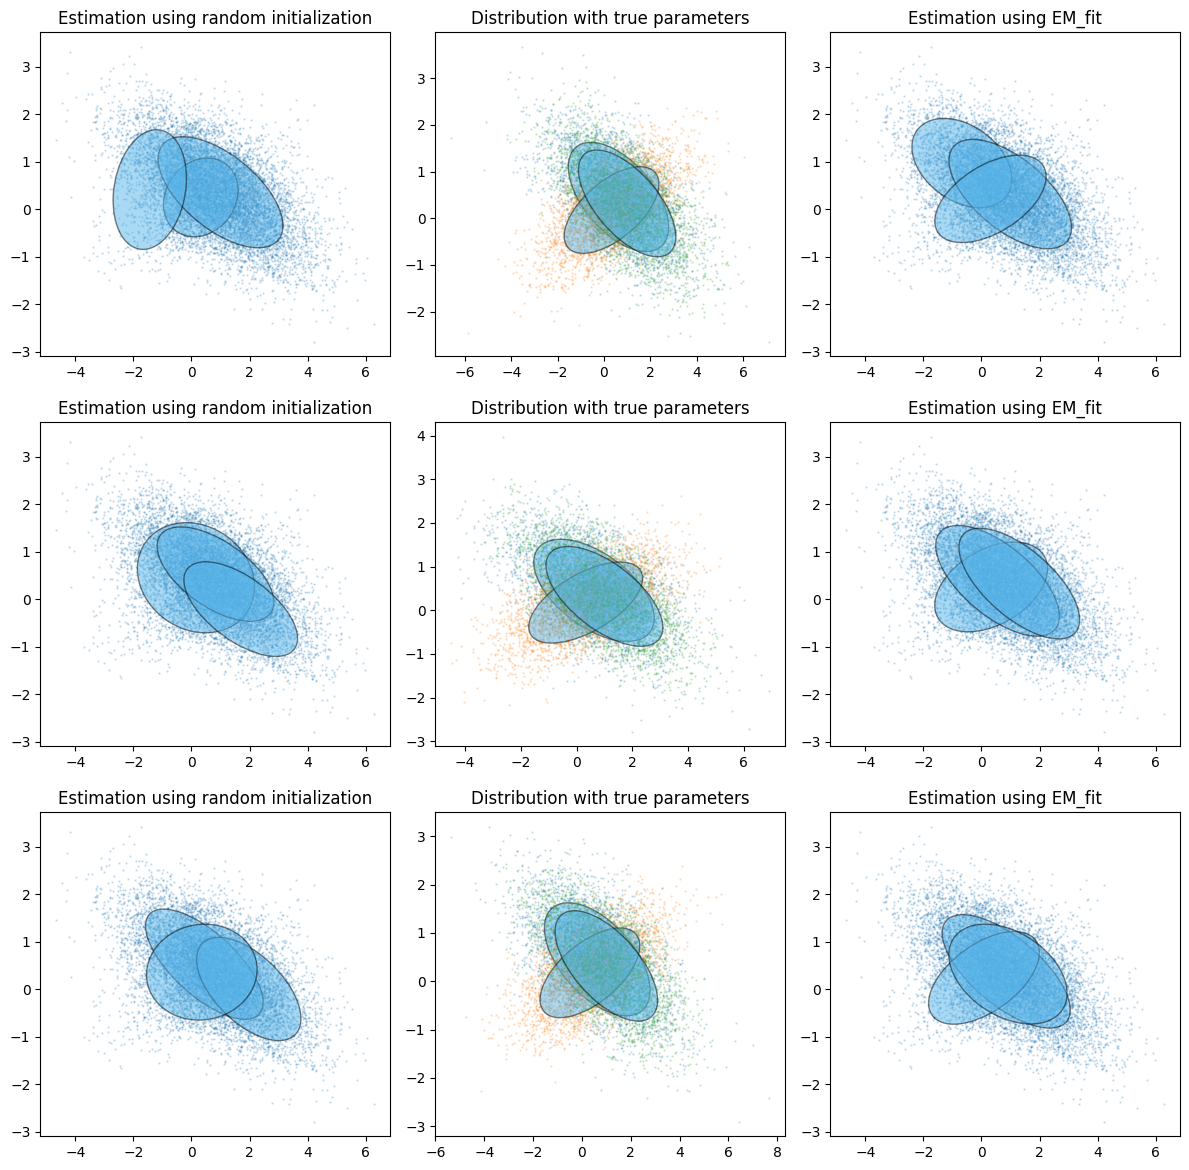

When trying to use the algorithm on a model with gaussian that overlap, we sometimes end up with results quite different from the real distribution, with our first algorithm (``Em_expl`` function and random initialization) being off the mark on a higher frequency than the algorithm with better initialization (``Em_fit`` function). 

Moreover, using these parameters the BIC scores actually suggest that this situation is best described with a 2-components mixture model. 



> BIC Scores for the preceding model



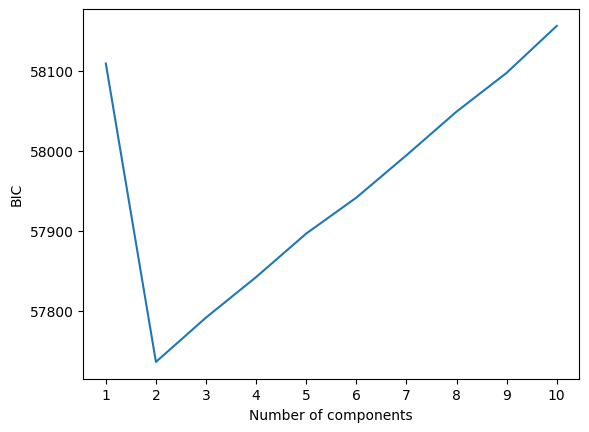

With spaced out means, we get results that are a lot more similar to the original distribution and a lot more repeatable. 


> Test on 3 successive runs of the algorithm using parameters:
- $n=$ 10000
- $K=$ 3
- $d=$ 2
- ``coef_means``$=$ 10



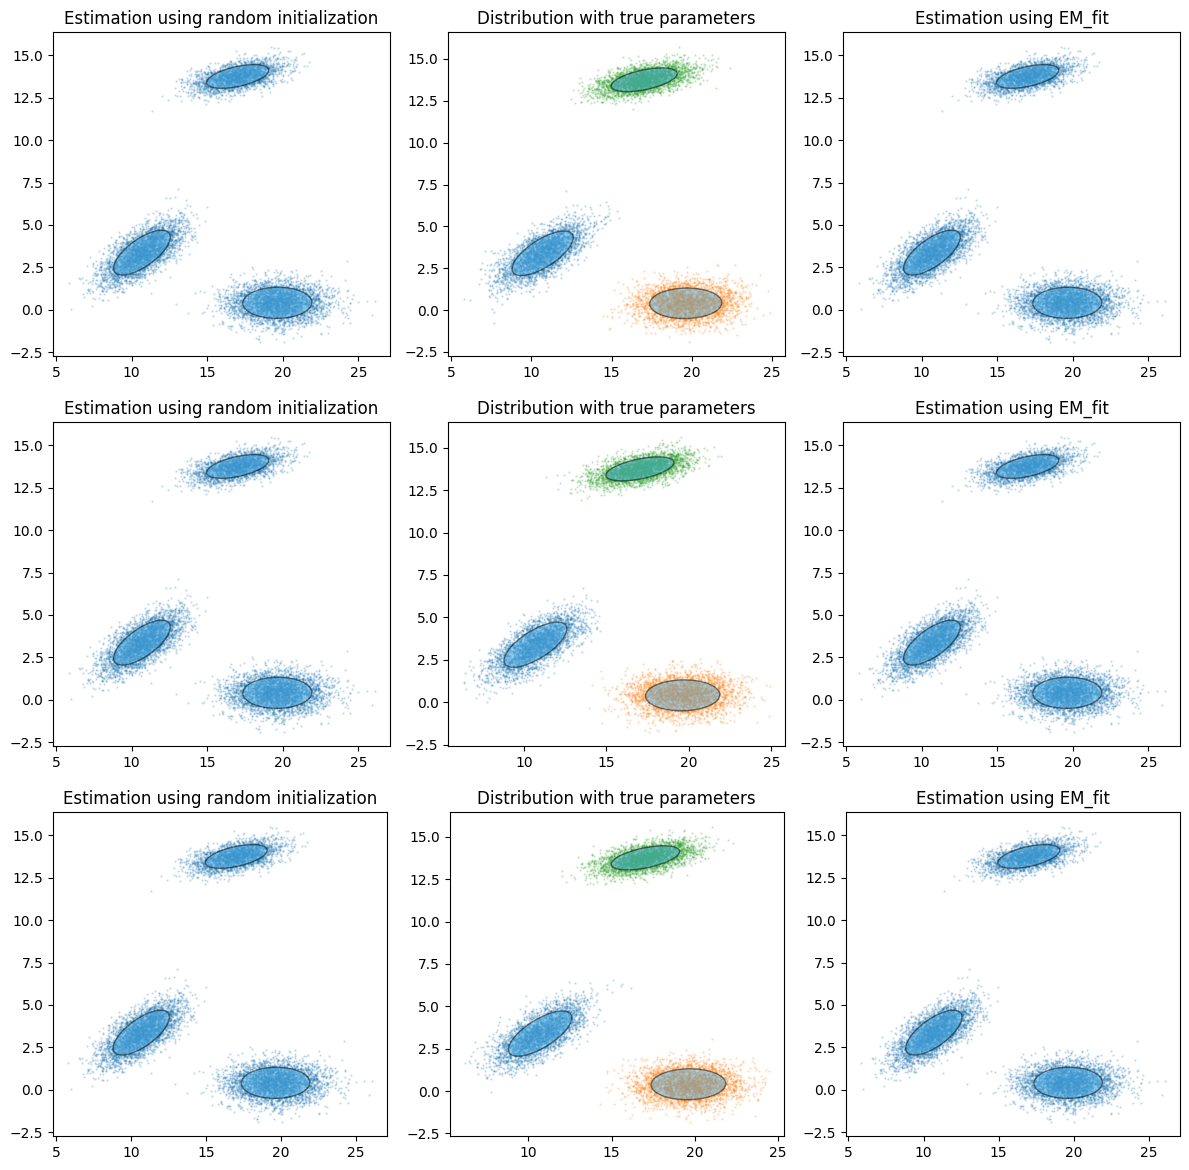



> BIC Scores for the preceding model



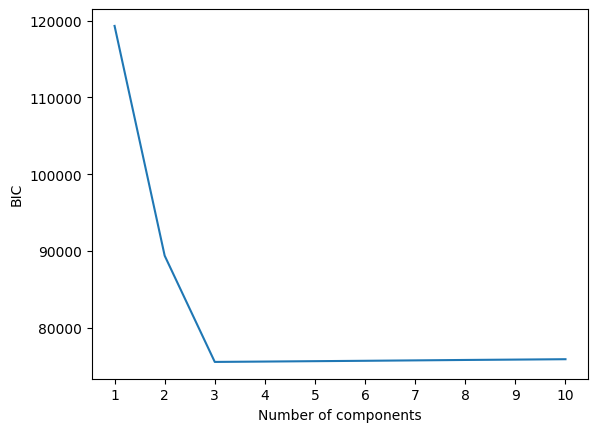

# References

1. Bonald T. (2019). *Expectation-Maximization for the Gaussian Mixture Model*. [Link](https://perso.telecom-paristech.fr/bonald/documents/gmm.pdf)
2. Punso A. (2019). *A new look at the inverse Gaussian distribution...* [Link](https://www.tandfonline.com/doi/full/10.1080/02664763.2018.1542668)
3. Bayesian information criterion [Link](https://www.immagic.com/eLibrary/ARCHIVES/GENERAL/WIKIPEDI/W120607B.pdf)
4. Lecture notes *Modele de mélange et algorithme EM*, Statistic Modelization course
5. Le Corff S. (2023) Lecture notes on EM algorithm
6. Lecture at Carnegie Mellon University. (2009).*Mixture Models, Latent Variables and the EM
Algorithm* [Link](https://www.stat.cmu.edu/~cshalizi/350/lectures/29/lecture-29.pdf)
7.*How to generate random symmetric positive definite matrices using MATLAB?* [Link](https://math.stackexchange.com/questions/357980/how-to-generate-random-symmetric-positive-definite-matrices-using-matlab)
8.*Scikit-learn: Machine Learning in Python. Gaussian Mixture Model* [Link](https://scikit-learn.org/stable/modules/mixture.html)
9. *Initializing EM algorithm* [Link](https://stats.stackexchange.com/questions/197865/initializing-em-algorithm)
10. *When does the EM for Gaussian mixture model has one of the Gaussian diminish to exactly one point and have zero variance* [Link](https://stats.stackexchange.com/questions/145458/when-does-the-em-for-gaussian-mixture-model-has-one-of-the-gaussian-diminish-to)

